In [1]:
%matplotlib inline
import sys
import copy
import datetime as dt

import pandas as pd
import numpy as np
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt

import pcse
from pcse.models import Wofost72_WLP_FD
print("This notebook was built with:")
print(f"python version: {sys.version}")
print(f"PCSE version: {pcse.__version__}")

from dataproviders import parameters, agromanagement, weather
wofost = Wofost72_WLP_FD(parameters, weather, agromanagement)
wofost.run_till_terminate()
df = pd.DataFrame(wofost.get_output()).set_index("day")

This notebook was built with:
python version: 3.9.19 (main, Apr  6 2024, 17:57:55) 
[GCC 9.4.0]
PCSE version: 5.5.6


In [2]:
variables_for_DA = ["LAI", "SM"]
dates_of_observation = [dt.date(2000,2,7), dt.date(2000,2,28), dt.date(2000,3,20), 
                        dt.date(2000,4,10), dt.date(2000,5,1)]
observed_lai = np.array([2.2, 3.5, 6.2, 3.3, 2.1])
std_lai = observed_lai * 0.1 # Std. devation is estimated as 10% of observed value                                                                 
observed_sm = np.array([0.285, 0.26, 0.28, 0.18, 0.17])
std_sm = observed_sm * 0.05 # Std. devation is estimated as 5% of observed value
observations_for_DA = []
# Pack them into a convenient format
observations_for_DA = [(d, {"LAI": (lai, errlai), "SM": (sm, errsm)}) for d, lai, errlai, sm, errsm in zip(dates_of_observation, observed_lai, std_lai, observed_sm, std_sm)]

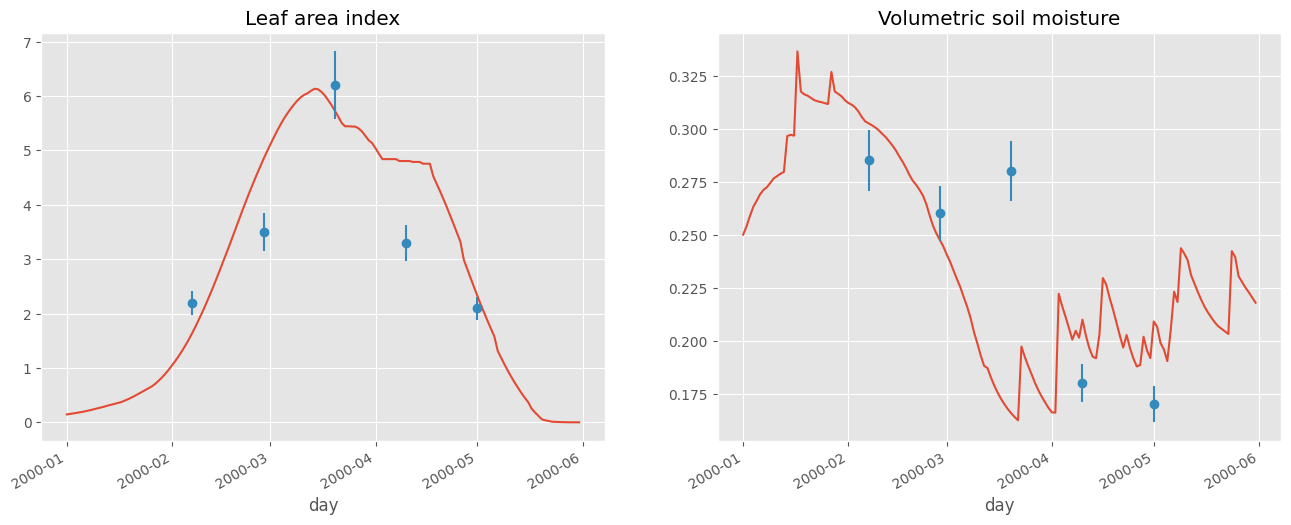

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
df["LAI"].plot(ax=axes[0], label="leaf area index")
axes[0].errorbar(dates_of_observation, observed_lai, yerr=std_lai, fmt="o")
df["SM"].plot(ax=axes[1], label="rootzone soil moisture")
axes[1].errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="o")
axes[0].set_title("Leaf area index")
axes[1].set_title("Volumetric soil moisture")
fig.autofmt_xdate()

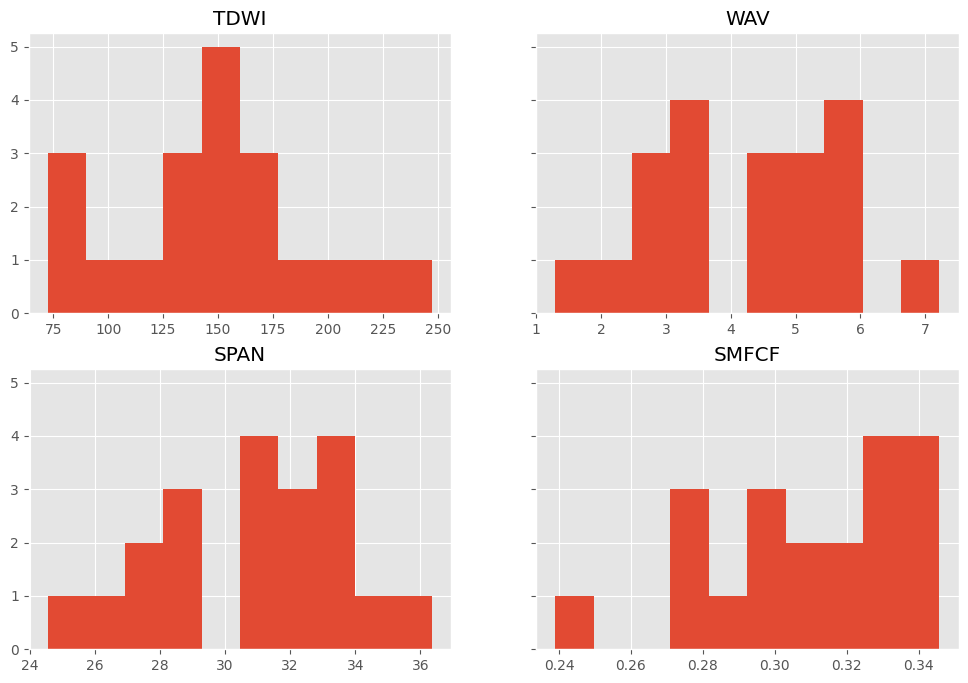

In [4]:
ensemble_size = 20
np.random.seed(10000)

# A container for the parameters that we will override
override_parameters = {}
# Initial conditions
override_parameters["TDWI"] = np.random.normal(150., 50., (ensemble_size))
override_parameters["WAV"] = np.random.normal(4.5, 1.5, (ensemble_size))
# parameters
override_parameters["SPAN"] = np.random.normal(31, 3 ,(ensemble_size))
override_parameters["SMFCF"] = np.random.normal(0.31, 0.03 ,(ensemble_size))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8), sharey=True)
# Show the sample that was drawn
for ax, (par, distr) in zip(axes.flatten(), override_parameters.items()):
    ax.hist(distr)
    ax.set_title(par)

In [5]:
ensemble = []
for i in range(ensemble_size):
    p = copy.deepcopy(parameters)
    for par, distr in override_parameters.items():
        p.set_override(par, distr[i])
    member = Wofost72_WLP_FD(p, weather, agromanagement)
    ensemble.append(member)

from sktime.forecasting.exp_smoothing import ExponentialSmoothing

ml_ensemble = []
for i in range(ensemble_size):
    forecaster = ExponentialSmoothing()
    ml_ensemble.append(forecaster)

from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
mape = MeanAbsolutePercentageError()

preds = [
    list()
    for _ in range(ensemble_size)
]

In [6]:
import warnings
warnings.filterwarnings('ignore')

show_output = True

for date in enumerate(df.index):
    day = date[1].strftime('%Y-%m-%d')
    total_metric = 0
    for i, member in enumerate(ensemble):
        lais = []
        member.run(1)
        LAI = member.get_variable("LAI")
        lais.append(LAI)
        model = ml_ensemble[i]

        if LAI is None:
            continue
            
        if not model.is_fitted:
            member.run(1)
            lais.append(member.get_variable("LAI"))
            model.fit(pd.Series(lais), fh=1)
            forecasted_lai = model.predict()
        else:
            forecasted_lai = model.predict()
            model.update(pd.Series(lais), update_params = True)

        if forecasted_lai is None:
            continue
        
        preds[i].append({
            "day": day,
            "LAI": forecasted_lai.values.item()
        })

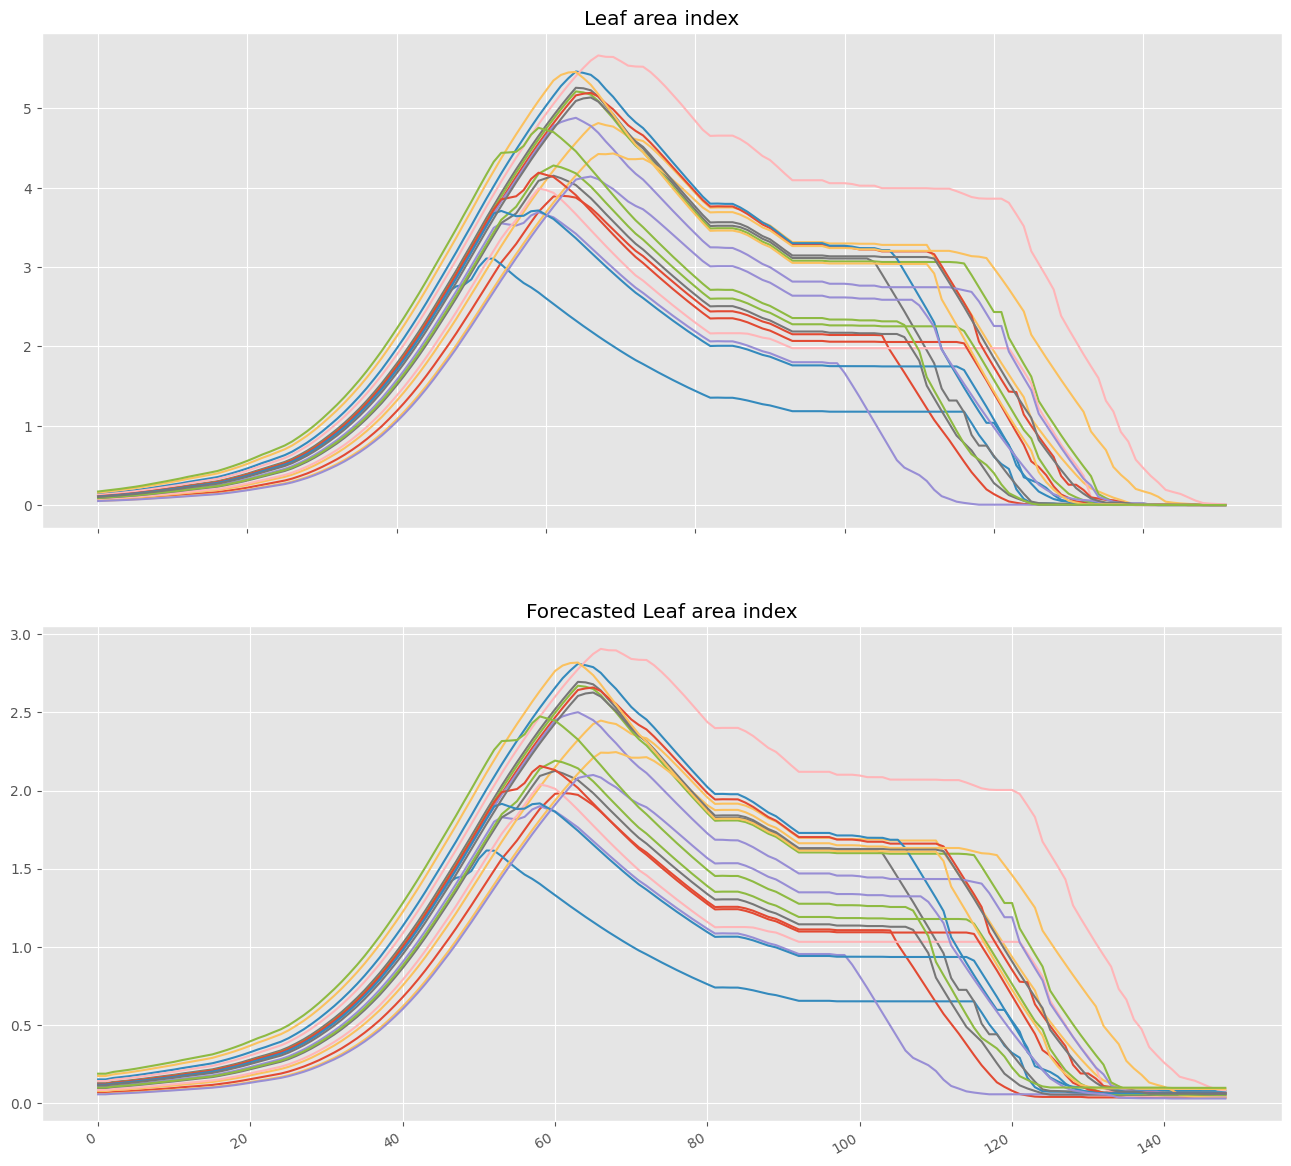

In [7]:
results = [pd.DataFrame(member.get_output()) for member in ensemble]

pred_dfs = [
    pd.DataFrame(pred)
    for pred in preds
] 

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,16), sharex=False)
for i, member_df in enumerate(results):
    pred_df = pred_dfs[i]
    member_df["LAI"].plot(ax=axes[0])
    pred_df["LAI"].plot(ax=axes[1])
axes[0].set_title("Leaf area index")
axes[1].set_title("Forecasted Leaf area index")
fig.autofmt_xdate()

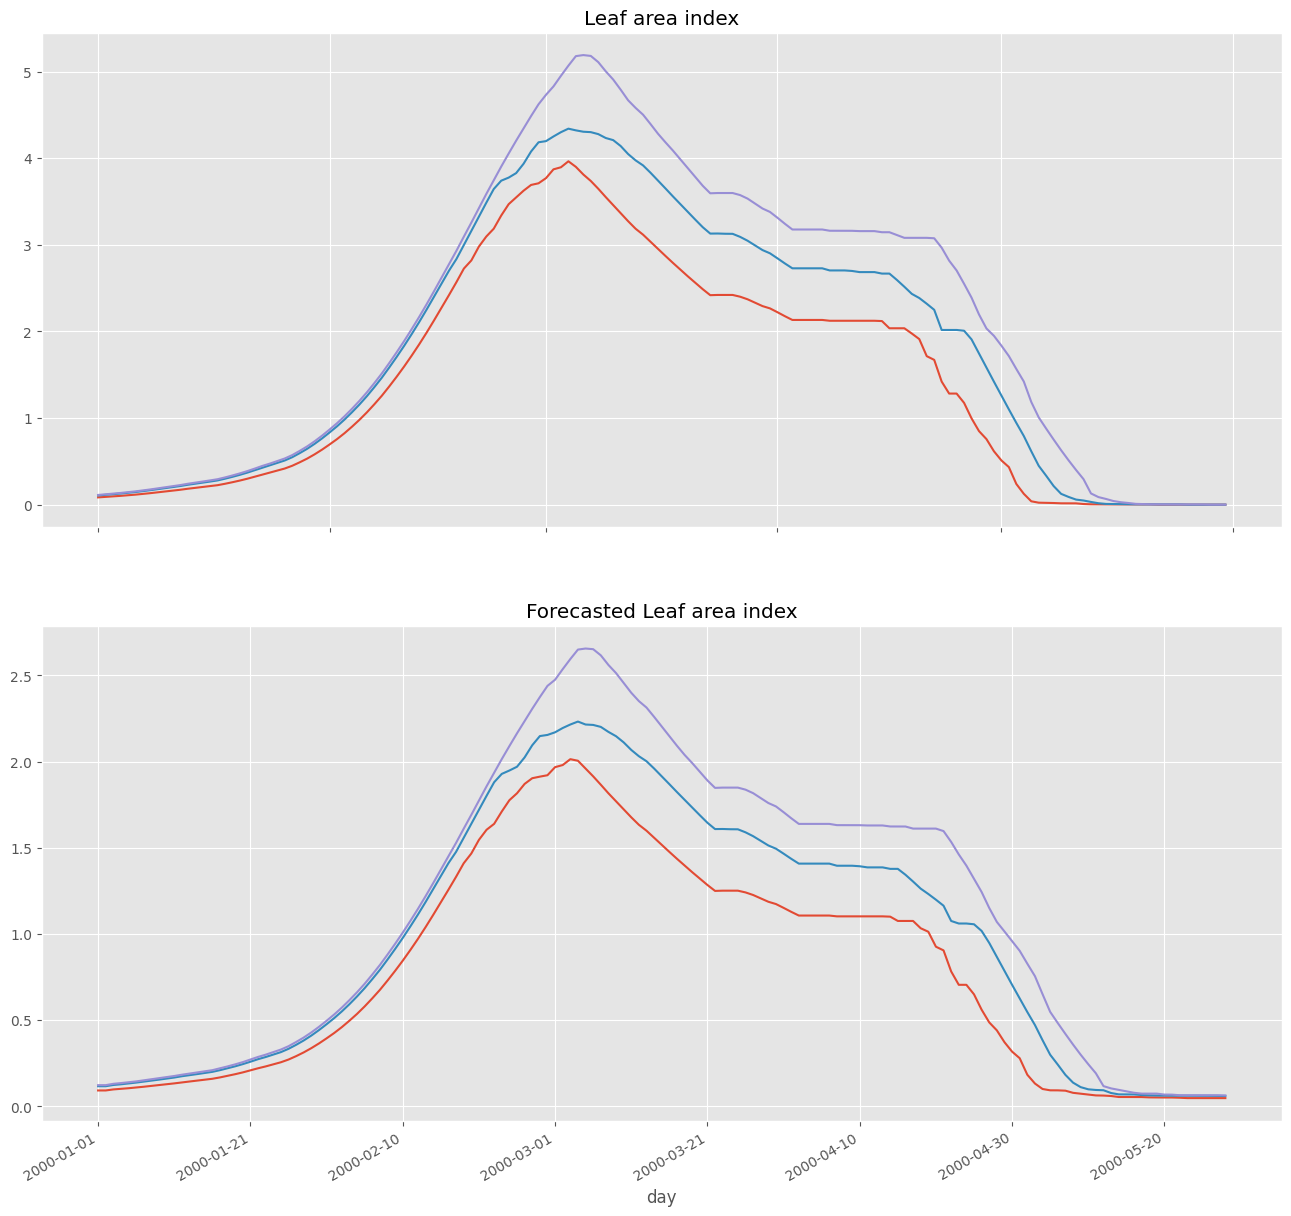

In [8]:
def q1(x):
    return x.quantile(0.25)

def q2(x):
    return x.quantile(0.5)
    
def q3(x):
    return x.quantile(0.75)

agg = {'LAI': [q1, q2, q3]}

combined_results = pd.concat(results).groupby('day').agg(agg)
combined_results.columns = ['_'.join(col) for col in combined_results.columns]
combined_pred_dfs = pd.concat(pred_dfs).groupby('day').agg(agg)
combined_pred_dfs.columns = ['_'.join(col) for col in combined_pred_dfs.columns]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,16), sharex=False)
combined_results["LAI_q1"].plot(ax=axes[0])
combined_results["LAI_q2"].plot(ax=axes[0])
combined_results["LAI_q3"].plot(ax=axes[0])
combined_pred_dfs["LAI_q1"].plot(ax=axes[1])
combined_pred_dfs["LAI_q2"].plot(ax=axes[1])
combined_pred_dfs["LAI_q3"].plot(ax=axes[1])
axes[0].set_title("Leaf area index")
axes[1].set_title("Forecasted Leaf area index")
fig.autofmt_xdate()

In [9]:
import warnings
warnings.filterwarnings('ignore')

show_output = True

from sktime.forecasting.exp_smoothing import ExponentialSmoothing

truncated_ensemble = []
for i in range(ensemble_size):
    p = copy.deepcopy(parameters)
    for par, distr in override_parameters.items():
        p.set_override(par, distr[i])
    member = Wofost72_WLP_FD(p, weather, agromanagement)
    truncated_ensemble.append(member)
    
truncated_ml_ensemble = []
for i in range(ensemble_size):
    forecaster = ExponentialSmoothing()
    truncated_ml_ensemble.append(forecaster)

truncated_preds = [
    list()
    for _ in range(ensemble_size)
]

for t, date in enumerate(df.index):
    if date == df.index[-36]:
        break
    
    day = date.strftime('%Y-%m-%d')
    total_metric = 0
    for i, member in enumerate(truncated_ensemble):
        lais = []
        member.run(1)
        LAI = member.get_variable("LAI")
        lais.append(LAI)
        model = truncated_ml_ensemble[i]

        if LAI is None:
            continue
            
        if not model.is_fitted:
            member.run(1)
            lais.append(member.get_variable("LAI"))
            model.fit(pd.Series(lais))
            forecasted_lai = model.predict(fh=t + 1)
        else:
            forecasted_lai = model.predict(fh=t + 1)
            model.update(pd.Series(lais), update_params = True)

        if forecasted_lai is None:
            continue
        
        truncated_preds[i].append({
            "day": day,
            "LAI": forecasted_lai.values.item()
        })

In [10]:
for i, model in enumerate(truncated_ml_ensemble):
    for t in range(len(df.index) -35, len(df.index)):
        day = df.index[t]
        forecasted_lai = model.predict(fh=t + 1)
        truncated_preds[i].append({
            "day": day,
            "LAI": forecasted_lai.values.item()
        })
        

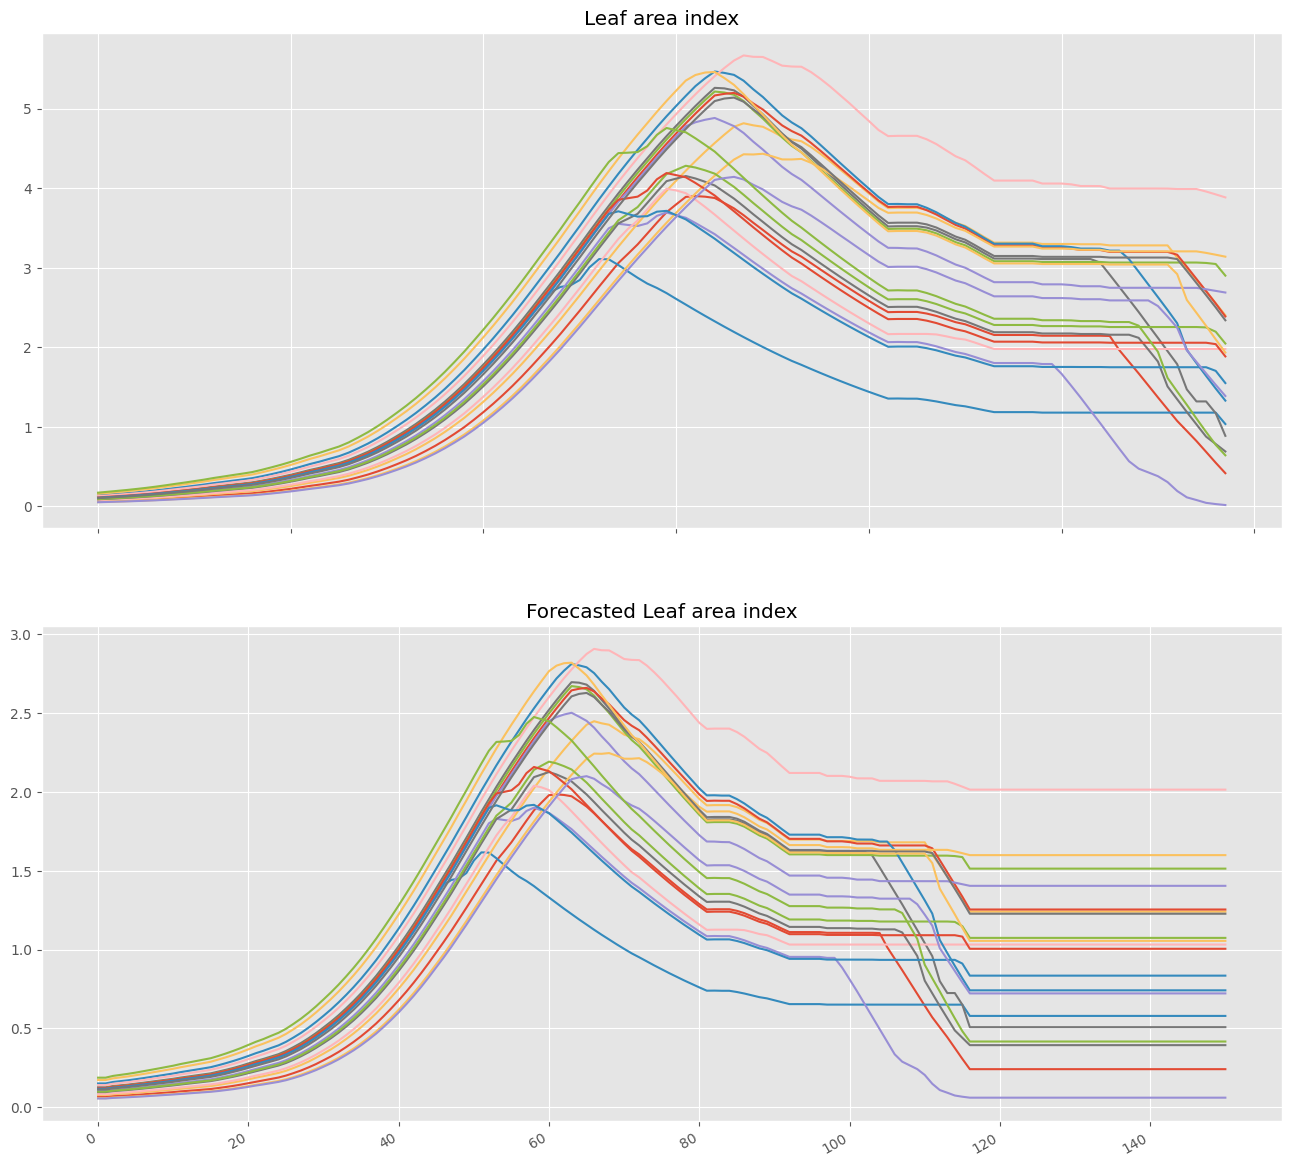

In [11]:
truncated_results = [pd.DataFrame(member.get_output()) for member in truncated_ensemble]

truncated_pred_dfs = [
    pd.DataFrame(pred)
    for pred in truncated_preds
] 

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,16), sharex=False)
for i, member_df in enumerate(truncated_results):
    pred_df = truncated_pred_dfs[i]
    member_df["LAI"].plot(ax=axes[0])
    pred_df["LAI"].plot(ax=axes[1])
axes[0].set_title("Leaf area index")
axes[1].set_title("Forecasted Leaf area index")
fig.autofmt_xdate()

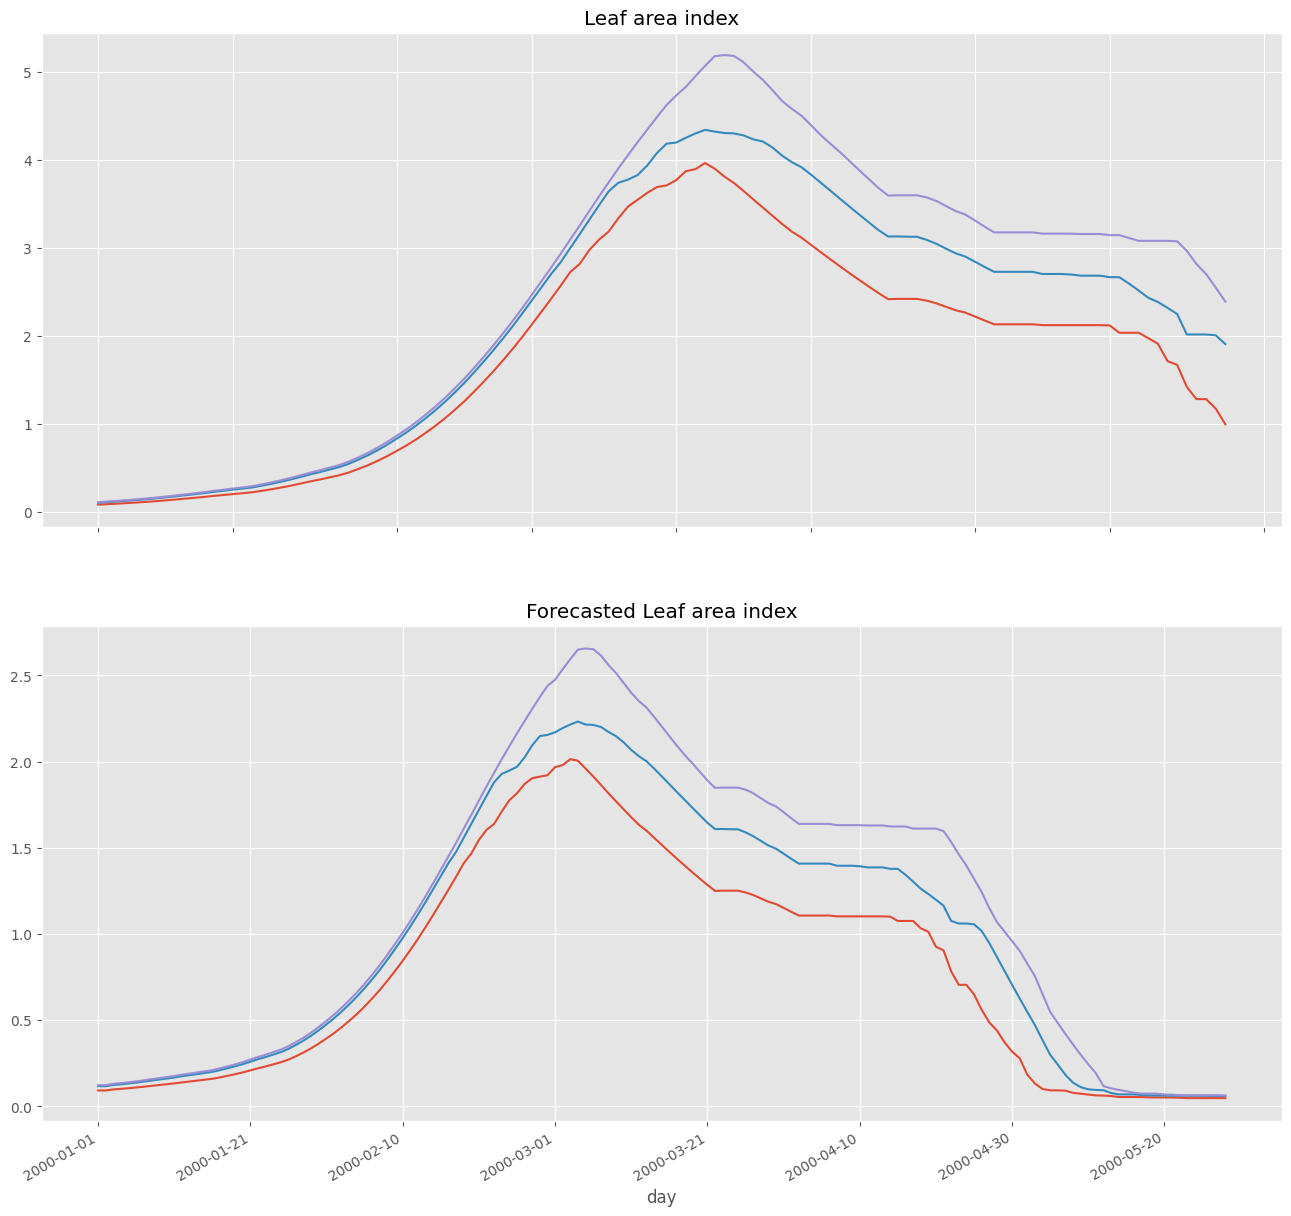

In [86]:
truncated_combined_results = pd.concat(truncated_results).groupby('day').agg(agg)
truncated_combined_results.columns = ['_'.join(col) for col in truncated_combined_results.columns]
truncated_combined_pred_dfs = pd.concat(pred_dfs).groupby('day').agg(agg)
truncated_combined_pred_dfs.columns = ['_'.join(col) for col in truncated_combined_pred_dfs.columns]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,16), sharex=False)
truncated_combined_results["LAI_q1"].plot(data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABQsAAASOCAYAAABiyXocAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy80BEi2AAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOzdd3Qc1dnH8e/M9iLtrnqXbLlgwIVmwN2mmd5JIZCEdEgh9U2BAIGEJKRAGiQhIYQQQu/dxoXibmwDNi6yZfW+q5W278x9/5CRMZYtAbJkW8/nHB3JuzOzd9ZzvaOf772PppRSCCGEEEIIIYQQQgghRjx9uBsghBBCCCGEEEIIIYQ4OEhYKIQQQgghhBBCCCGEACQsFEIIIYQQQgghhBBC7CJhoRBCCCGEEEIIIYQQApCwUAghhBBCCCGEEEIIsYuEhUIIIYQQQgghhBBCCEDCQiGEEEIIIYQQQgghxC4SFgohhBBCCCGEEEIIIQAJC4UQQgghhBBCCCGEELtIWCiEEEIIcYjYunUrF154IQUFBWiaht/vH+4mDak5c+agadoBfY3FixejaRo33njjAX0dIYQQQoiDlXW4GyCEEEIIcbB6L5hSSg1zS8AwDC644AK2bdvGFVdcQUlJCU6nc7ibJYQQQgghDjMSFgohhBBCHAJ27NjBxo0b+dKXvsTf/va34W7OsPj3v/9NNBod7mYIIYQQQhzWJCwUQgghhDgENDQ0AFBUVDTMLRk+ZWVlw90EIYQQQojDnqxZKIQQQggxSB544AHmzp2L3+/H6XQyYcIEbrnlFhKJxF7bPvHEE3zmM59h3LhxeDwePB4Pxx13HH/4wx8wTXOPbTVNY/bs2QDcdNNNaJo24HX1/vWvf3HxxRczevRoXC4XmZmZTJ8+nf/85z99bv/euoDJZJKf/exnjB8/HofDwec+97neberq6vj617/O6NGjcTgcZGdnc95557Fq1aq9jtfQ0MDPfvYzpk+fTkFBAXa7naKiIj796U+zcePGftvfV9ve7/1rDK5bt46zzz4bv9+P2+1m9uzZvPHGG30eq7m5mS984Qvk5+fjcrmYMmUK9957735fv6Ojgx/96EdMmDABl8uFz+fjlFNO4aWXXtpju8ceewxN0zjppJNIpVJ7PPf222/jdrspKiqipaXlQ52/EEIIIcRQkJGFQgghhBCD4KqrruKee+6hpKSEiy++GL/fz/Lly7n++utZuHAhL7/8Mlbr7luvH/7wh+i6zoknnkhxcTGdnZ288sorfOtb32LVqlXcd999vdvecMMNVFdXc++99zJ79mzmzJkD0Pt9f772ta9x1FFHMWvWLAoLC2lvb+e5557jiiuuYPPmzdx888197nfxxRezatUqzjzzTC644ALy8vIAWLt2LaeffjodHR2cccYZXHTRRbS1tfHEE08wY8YMHn/8cc4666ze4yxdupRf/vKXzJ07l4svvhiv18vWrVt55JFHeOqpp3j99deZPHnyR3jH97R69Wp+/etfc/LJJ/PFL36RmpoaHn30UU455RTWrVvH+PHje7dta2tj2rRpbN++nRkzZjBjxgwaGxv56le/yumnn97n8Xfu3MmcOXOorq5m5syZzJ8/n0gkwjPPPMP8+fP561//ype+9CUALrroIq655hr+/Oc/85Of/IRf//rXAESjUS677DISiQT3339/73sqhBBCCHFQUUIIIYQQok+AGsjt0j333KMAdeGFF6poNLrHczfccIMC1O23377H49u2bdvrOIZhqCuvvFIBavny5Xs8t2jRIgWoG2644UOdQ1+vk0gk1Lx585TValV1dXV7PDd79mwFqIkTJ6rW1tY9nkulUqqyslI5HA61ePHiPZ6rr69XRUVFqqCgQMXj8d7Hm5ubVTgc3qsN69atUx6PR82fP3/A5/Je297vvfcFUPfcc88ez911110KUF/72tf2ePxLX/qSAtS11167x+OrVq1SVqu1z/d59uzZStM09cADD+zxeDAYVJMnT1ZOp1M1NTX1Ph6Px9UxxxyjNE1Tzz//vFJKqc997nMKUD/96U8HfM5CCCGEEENNpiELIYQQQnxMd9xxB1arlX/+85+4XK49nrv++uvJzs7m/vvv3+PxysrKvY6j6zrf+ta3AHjxxRcHpW19vY7dbueaa64hnU6zcOHCPve7+eabycnJ2eOxZ599lqqqKr7xjW/0Tot+T1FRET/4wQ9oamra45h5eXlkZGTsdfzJkyczb948Fi1atNdU3Y9i+vTpe0yVhp7RnlarlZUrV/Y+lkqluP/++8nIyNhrGvfxxx/P5Zdfvtex169fz5IlS7j44ov55Cc/ucdzfr+fm266iXg8zqOPPtr7uMPh4MEHH8Tj8XDllVfym9/8hn/961/MmjWLn/70px/7fIUQQgghDhSZhiyEEEII8TFEo1HWr19PTk4Ot99+e5/bOBwONm3atMdj7e3t3HbbbTz33HNs376dSCSyx/P19fWD0r6amhp+9atfsXDhQmpqaojFYgN6nalTp+712LJly4CeKbl9rZe4detWADZt2rTHVORnn32Wu+66i9WrV9PW1kY6nd5jv7a2NgoLCz/UeX3Q8ccfv9djNpuN/Px8gsFg72Pvvvsu0WiUmTNn4vP59tpnzpw5e61d+N55d3Z29nnera2tAHv9HY8dO5a77rqLz3zmM3z/+98nJyeH//73v1gslg99fkIIIYQQQ0XCQiGEEEKIjyEYDKKUorW1lZtuumlA+4RCIU444QR27NjB1KlTufLKK8nKysJqtRIKhbjjjjv6LIryYW3fvp2pU6cSDAaZOXMmp59+Oj6fD4vF0rsG4r5ep6CgYK/H2tvbAXj44Yf3+7rd3d29P99xxx1ce+21BAIBTjvtNMrKynC73WiaxhNPPMH69esH5Vz9fn+fj1utVgzD6P1zZ2cnAPn5+X1uv7/zfvnll3n55Zf32Yb3n/d7Tj/9dDIzMwmHw1x66aUUFxfvc38hhBBCiIOBhIVCCCGEEB/De6PTjjnmGNauXTugfe6++2527NjBDTfcsNdItWXLlnHHHXcMStt+97vf0d7ezj333LPXFN0HHnhgv9V/P1h1GHaf65NPPsl5553X7+un02luvPFGCgoKWLt27V6jB98bsTeU3juH5ubmPp9vamra5z533HEH3/zmNwf8WkoprrzySsLhMDk5Ofztb3/jk5/8JLNmzfoILRdCCCGEGBqyZqEQQgghxMfg9Xo56qijeOedd+jo6BjQPtu2bQN6Kg5/0JIlSwatbYP9OieddBIAr7766oC2b2trIxQKMW3atL2Cwu7u7gGHq4PpiCOOwO12s27dut5Rhu+3ePHivR77sOf9nttuu40XXniByy+/nFdeeQWbzcanP/3p3pGKQgghhBAHIwkLhRBCCCE+pu985zskk0muuuoqQqHQXs8Hg8E9grGKigpg72DqzTff5NZbbx20du3rdV588UXuvvvuD328888/n8rKSv785z/z3HPP9bnNsmXLiEajQE9xE7fbzZo1a/aYoptKpfjWt75FW1vbh27Dx2Wz2bj88svp6uraa1Tn6tWr9ypEAz3rIc6cOZPHHnuMf/7zn30e96233qKlpaX3z8uXL+cnP/kJY8aM4c4772TixIn8/ve/p76+ns9+9rMopQb1vIQQQgghBotMQxZCCCGE6McHp/C+31/+8heuuuoq1qxZw1/+8hcqKys544wzKCsro6Ojgx07drB06VI+//nPc9dddwFw5ZVXctttt3HttdeyaNEixo4dy9atW3nmmWe46KKLePDBBwel3VdffTX33HMPl156KZdccglFRUW8/fbbvPDCC1x22WUf+nVsNhuPPfYYZ5xxBmeffTbTpk1jypQpuN1uamtrWbVqFdu3b6exsRG3242u63zzm9/kl7/8JRMnTuT8888nmUyyaNEiOjo6mDt3LosWLRqUc/0wfvGLX7Bw4UJuv/12Vq9ezYwZM2hsbOTBBx/krLPO4qmnntprn//+97/MmzePL3zhC/zhD3/gxBNPxO/3U1dXx4YNG3j77bdZtmwZeXl5hEIhPvWpT6HrOv/73/96q0F/9atfZeHChTzyyCP87ne/47vf/e5Qn7oQQgghRL8kLBRCCCGE6Mf+1va7/fbbcbvd/PnPf+bMM8/krrvuYsGCBYRCIbKysigrK+P73/8+n/nMZ3r3KSoq4tVXX+WHP/whr732Gi+++CJHHHEEf/nLXzj11FMHLSycNGkSixYt4rrrruPZZ58lnU4zefJkHnvsMfx+/0d6nUmTJrF+/Xp+97vf8cwzz3DPPfeg6zqFhYUcc8wx3HTTTeTk5PRuf/PNN5Obm8vdd9/NX//6V3w+H6eddhq33HILN9xww6Cc54eVk5PD66+/zo9//GOefvppVq9ezfjx47nzzjupqKjoMywsKSlhzZo1/PGPf+TRRx/l/vvvxzAMCgoKOPLII/nGN77BxIkTAfjCF75AdXU1v/vd7zjuuOP2OM7dd9/NmjVr+NGPfsTMmTP7rDothBBCCDGcNCVzIIQQQgghhBBCCCGEEMiahUIIIYQQQgghhBBCiF0kLBRCCCGEEEIIIYQQQgASFgohhBBCCCGEEEIIIXaRsFAIIYQQQgghhBBCCAFIWCiEEEIIIYQQQgghhNhFwkIhhBBCCCGEEEIIIQQgYaEQQgghhBBCCCGEEGIXCQuFEEIIIYQQQgghhBAAWIe7AR9GMBgknU4PdzMOiNzcXFpbW4e7GUIMG+kDYiST61+MdNIHxEgnfUCMdNIHxEg2lNe/1WolEAj0v90QtGXQpNNpUqnUcDdj0GmaBvScn1JqmFsjxNCTPiBGMrn+xUgnfUCMdNIHxEgnfUCMZAfr9S/TkIUQQgghhBBCCCGEEICEhUIIIYQQQgghhBBCiF0kLBRCCCGEEEIIIYQQQgASFgohhBBCCCGEEEIIIXaRsFAIIYQQQgghhBBCCAFIWCiEEEIIIYQQQgghhNhFwkIhhBBCCCGEEEIIIQQgYaEQQgghhBBCCCGEEGIXCQuFEEIIIYQQQgghhBCAhIVCCCGEEEIIIYQQQohdJCwUQgghhBBCCCGEEEIAEhYKIYQQQgghhBBCCCF2kbBQCCGEEEIIIYQQQggBSFgohBBCCCGEEEIIIYTYRcJCIYQQQgghhBBCCCEEIGGhEEIIIYQQQgghhBBiFwkLhRBCCCGEEEIIIYQQgISFQgghhBBCCCGEEEKIXazD3QAhhBBCCCEEWONxXB0hlK6TdtgxHHbSdgfKahnupgkhhBBiBJGwUAghhBBCiGFkSSbxNrXg7gii9fG8YbH0BIcOR0+IaO/5UpoGmobS6PnOnn9G0zAtlp6fhRBCCCEGSMJCIYQQQgghhoGeTuNtbsXT1o6mFADxzAxMqxVLIoE1kcSSTmMxDCzRGPZo7EO/hmGzEcnJIpKdhbLKrb8QQggh+id3DEIIIYQQQgwhzTDwtLbhbWlDN00AEh4P4aICUh73XttakkmsiZ6v3SFiCpRCU4BSu37uCRy19/4MWFIpMhub8Ta1EMsKEMnNJu10DvEZCyGEEOJQImGhEEIIIYQQQ8E08bR34G1uxZJOA5B0OekqLCCR4e1zurCyWEi7XKRdro/0eq5QJ97WNmyxOJ72DjztHcQzvERysklkZsgUZSGEEELsRcJCIYQQQgghDjBnMERmYxPWZAqAtN1OuDCfuN934AI7XSeWFSAW8GOPRPG0tuHsDOPs6sbZ1U3aYac7J5tYVgBlkSIqQgghhOghYaEQQgghhBAHimniq2vA0xEEwLBa6SrII5qdNXSj+jSNpNdD0uvBkkjiaWvH3d6BNZHEX99IZmNzz7qGuTmYNtvQtEkIIYQQBy0JC4UQQgghhDgALIkkWdU7scXiKKA7P4/u/FyUrg9bmwyHnXBxIV0FebiCIbytbVgTSTJa2vC2thPN8tOdl4vhcAxbG4UQQggxvCQsFEIIIYQQYpA5OsMEamrRDRPDYiFYUUYywzvczeqlLBaiOdlEs7NwhLvwtrTiiETxtAdxtweJ+zLpzs8l5Xb3fzAhhBBCHFYkLBRCCCGEEGKwKEVGYzMZLa0AJN1uOirKMO0H6fReTSPhyyThy8TeHcHb0ooz3IWrM4yrM0zC66ErP4+k1yPFUIQQQogRQsJCIYQQQgghBoGeShPYWYOjOwJAd0424aICGMZpxx9G0uuhw+vBGovjbWnFFQzh6I7g6N5B0uUkmpONYbNh2KyY1p4vCRCFEEKIw4+EhUIIIYQQQnxM9u4IgZ01WFJpTF0nVFpMPOAf7mZ9JGmXk1B5KV2F+Xha2nC3d2CPxbHX1u+xnQJMq6U3OHwvRFS6BaVpKF0DTUNpu7+/97NpschoRSGEEOIgJWGhEEIIIYQQH5VSeNrayaxvRANSDgfBUWWknc7hbtnHZtjthEuK6C7Iw93WjqM7gp5O7/oy0ABL2sCSNoDEhz5+yukgXFRAIiNDQkMhhBDiICJhoRBCCCGEEB+FaeKvrccdDAEQ8/sIlRajLJbhbdcgM61Wugvy6X7/g0r1BoeWVHr3z+k0mmmCUmim6vm+6+v9P1vjCWzxBNnbd5LweugsKiTtdg3XKQohhBDifSQsFEIIIYQQ4kPSU2myqndij0RRQLi4kEhO9sgZIadpmDYbps1G+iNkfFraIKOlBU9rz4jF3C3biGUFCBfkH7zFYIQQQogRQsJCIYQQQgghPgRrLE7WjmqsyRSmRaejopxkhne4m3VIUVYL4aJCItnZZDQ24Q514u4I4gyGiOTl0p2Xc9iN0BRCCCEOFRIWCiGEEEII8QGRRJqF2zswlIWiTDvFGXbyvXa8kW4C1TXopknabqd9dAWG0zHczT1kGQ47oYoyIpEomQ2NOCJRMppbcLd30FWYTzQrMHJGawohhBAHCQkLhRBCCCHEyKAUllQ7tth2LKl2dDOOZsbRzMSurzi6mcBMx8lScb5oU6zoLOQ3G0+iLpHJpVkG3y0w0TWoVjaW6tnkBNMUZ+rkuK1oEmp9ZCmPm/Yxo3F2hslsaMKaTOKvrcfT2k6wvJS069AvGCOEEEIcKiQsFEIIIYQQhy09FcQeq8IW2449WoXFCPe7jwVgV+53oq+R+yc9xbbwRCZax6Nh4emgxi8aFWnV1rtPhsPCmCwnY7OdjMlyMibbSZZLAsQPRdOI+33EMzPwtHWQ0dyCLR4nd8s2OosKieZkyShDIYQQYghIWCiEEEIIIQ4bejqMLVaF/b1wMB3c43mFhZSzjLSjCNPiQukOlO6kLW7hoU3dbA1CxLBxbGk2lx/tJTf4HPbYNo70r8MwdlBvOZV2TyXn+FI0diWpDydp7ErSlTB4szHCm42R3tcKOC2MyXYyJsvFmGwnR+S68NplHb5+6TqRvBxiAR/+mjqcXd346xtwdnURKivBtMqvMEIIIcSBJJ+0QgghhBDikKengnjbnsMZeXuPxxU6aWcJSddokq5KUs5y0HdX21VK8fzWEPesbSFpuMiw61xzYiEnl2VgSSaxdc1AT+dhOtaApZNiHuVi31S6R89HWXrKACcNk52hBNva42xtj7OtI05tZ4Jg3GBVfYRV9T0Botum8+lJOZw1LoBFlxFy/TFtNjpGV+BpayezoQlnuIvcd7cSLC+VgjJCCCHEASRhoRBCCCGEOHSZSTzBxbhDr6KpNAqNtKOIpGs0KVclKVcFSu+7AEkoluYPyxtZ09AT5k0p9PDNkwrIdtuwRWNkba/Gkk5jWMcQKpyGI7IYV9dqXOGV2COb6M49l4TnaOwWnbHZLsZmuzhz17ETaZPtwTjbdoWH77bGaOpOcfeaFhZu7+SrJxRwRK5riN6kQ5imEcnNIeH1EKiuxZZIkFO1g+68HMIF+aDrw91CIYQQ4rAjYaEQQgghhDj0KBNH93q8bS/0rkOYdI2mK+ccDEdhv7uvrOviT8ub6EwY2HSNzx6Ty9njA+iahr2rm6wdO9FNk5TTSfvoCky7jaT3YuKZx5DR8gTWVCu+pv+ScI+nK/d8TFtgj+M7rDoTct1MyHUDYJiKl7aF+M/6VnYEE/zfSzs5tdLHZ6fkkumUW/L+pF0u2saPIbO+EU97B96WNuxdEYLlpVKNWgghhBhkcmcihBBCCCEOKdZ4LRmtT2NL1AJgWAN05ZxN0nNkvwUwUobiH2uaeX5rCIAKv4PvTC+i3N8TODlDnQR21qIpRcLroWNUOcqye53BlGs0HWXfxNOxGHdwMY7oZmw1t9OdcxbxzKn7fH2LrnHmuADTyjK4981WFm7vZEFVJ8tru7hiSi6nj/GjS/GO/VK6TmdpMYkML/7aeuyxGLlbttJZXEQsKyDFT4QQQohBImGhEEIIIYQ4JOjpMJ72F3F1rQXA1OxEs+YS9U3fYx3CfQnF0vzy1Xo2tcYAuGBCFp+ZnIPN0jOV1d3Wjq+uAQ2I+TIJlpf2Pc1VsxLJPpV4xiQyWh7HHq8ms/UJHNHNhPMuQln2vZ6ez2nlmycXclqlj7tWNVMdSnDnymYWVPVMTR6T7fzwb8wIE/f7aHG7CdTU4uiOEKitx9HVTWdpCcoi05KFEEKIj0s+TYUQQgghxMFNmbiDS8ja+dveoDCWcRwd5d8lGpgzoKBwW3uc77xQzabWGB6bzk/nlPD5Y/N6gkKl8DY1498VFEayswhWlPW7Hp5hzyNU/CW6ss9CYcER2URWzR3YI+/2254JeW5+d2YFXzwuD5dVZ2t7nO+9UM1dK5voThoDeFNGNtNuo71yFOHCAhTgDnWSs7UKSyIx3E0TQgghDnkyslAIIYQQQhy8lMLb+hTu8AoAUo5SunLPJe0sHfAhllaH+ePyRpKGojjTzk9ml1Ccae89vq++AU9bBwBd+Xl0FeQNfEqrphMLzCTlHkNm84NYk834G+8l6juJ7uwzQbfvc1eLrnHuEVlML8/knrUtLK0O8/zWEG81R7lxXim5nv5D0BFN0+jOzyXpcROorsEWj5O7ZRvB8jISmRnD3TohhBDikCUjC4UQQgghxMFJKTztz+MOr0ChEc69gGDJ1wYcFBqm4t43W/jt6w0kDcVxRR5uO6N8d1BomgR21uJp60ABoeJCugrzP9Lad2lHIR0l1xD1TQPA3bmcrNo/Y0009LtvlsvKd6cXcfMppWS7rNSFk/zgxZ3sCMY/dDtGoqTXQ+u4MSTdLnTDJGt7Nd6mFlBquJsmhBBCHJIkLBRCCCGEEAclT8dCPKFXAejKvZC478QBB3ndSYOfL6njsY09IwYvOSqbn8wuwWPvKVaiGQbZ23fiCnWiNI1geSnR3JyP12DdRnfuuYQKP49hycCaaiFQ+xfcwSWgzH53n1Tg4VdnlFPms9MRS/Ojl2rY0BT5eG0aIUy7jbYxo4lkZ6EBmU3NBHbUoBkypVsIIYT4sCQsFEIIIYQQBx13cCme4EIAunLOIe47YcD71oUT/ODFnaxpiGC3aHx3ehFXTMnFovcEjXo6Tfa2HTi6uzF1nY5R5cQD/kFre9Izjo6ybxH3HIWGgbf9BfwN/0BPhfrdN9dj49bTyjkqz0UsbXLTolqWVocHrW2HtV3VkoOlxShNwxUOk7OlCmtcRmgKIYQQH4aEhUIIIYQQ4qDi6lyGt/15ALqzTifmnz7gfVfXd/P9F3ZSH06S47byy9PLmVWR2fu8nkyRvXU79lgMw2KhvXLUAVnfTlk8hAsuJ5x3EaZmxx7bTlbtnwY0LdnrsHDjvFKml2WQNuG3rzfwxKZ2lEyrHZBYdhZtY0dj2GzYEglytlThDHUOd7OEEEKIQ4aEhUIIIYQQ4qDhDK8ho/UpACKBOUSz5g543+e2BLllcR3RlMmRuS5+e2YFlVnO3uctySQ527ZjSyRI22y0jx1NyuMe7FPYTdOIZ55AsPQbpBxF6GYEf/3dWON1/e5qt+h8b0YR544PAHDP2lb+sbYFUwLDAUm53bSOG0PC60E3TbKqa8hoaJJ1DIUQQogBkLBQCCGEEEIcFBxdG8hoeRSAqG8akazTB7zvc1uC/HVVMwo4Y4yfn51Sht9p7X3ekkiQvXU71mSStN1G+5jRpJ3OfR8QiEQiBINBIpEIqVTqI4/sM+w5hIq+RMpZhm7G8DfcjTVe0+9+uqbxhePy+PyxuQA8/W6Q37zWQNLof/1DAabNSnvlKLpzswHIaGklUF2DZsr7J4QQQuyPtf9NhBBCCCGEOLDs3RvJbH4QDUUs8wS6c84ZcDGTF7b2BIUAFx2ZxZVTctHet68lniCnajuWVJq0w05b5WhMu22/x1y7di2vvfbaHo9pmobdbt/ry+l0kpubS35+Prm5udjt9r2OpyxOQkVX4Wv4F/Z4Nf76f9BZ9HlSror9tkPTNC6YkE2Wy8Ydyxp4vaaLzniaH80uwburWIvYD00jXFxEyu3GX1OHqzOMZdt2OkaVY9r2fw0IIYQQI5WEhUIIIYQQYliZwXfIbLofDZO4dzJduRcMOCh8aVuIO1f2BIUXTNg7KLTG4mRX7cCSTpNyOmivHLXfkEgpxRtvvMGaNWsAsNlspFKp3ucSiQSJRGKv/TZv3tz7c1ZWFvn5+eTl5ZGfn09OTg5WqxWlOwgVfR5/473YY9vxN/yTUOHnSLlH93uesyoy8Tst3Lq0nrdbYvzopZ1cN6eEfO/ewaTYWyzgx7DZyNqxE3s0Rs7WKjpGV/Q7ulQIIYQYiTR1CK2U3Nra2nuzdjjRNI3CwkIaGxtl4WoxIkkfECOZXP9ipLPFdxJo+CeYSeKeowgXfAq0gY2Ye3lbiD+taALgvCMCXHVs3p5BYTTWExQaBimnk/YxozCt+/6/ctM0eeWVV9i4cSMA06dP57jjjkMpRSqVIplM9vkViURoaWmhubmZ7u7uvY6r6zrZ2dmMGjWK448/Hqtu4mv8D47YVpRmI1R4BSn32AGdc3Uwzk2L6uiIpcmw63xvRjFTCj0D2lfsmo5eVY01mcS09FTCTnq9w9om+RwQI530ATGSDfX1b7PZyM3N7b9dEhYOP/nHUYx00gfESCbXvxjJrPF6/A1/RzcTJN3jCBVeAdrAJr4sqArxp+VNKODc8QG+cNyeQaEtGiW7age6YZJ0u2gfXYHaT1CYTqd5/vnn2bFjB5qmMXfebFyFbaTNBC5bAJc1gMvmx2kNYNX3PZovEonQ3NzcGx42NzcTj8d7n/f7/ZxyyikUF+bha7ofR3QzSrPSWXA5Sc8RAzr3tmiKXy6tZ2t7HF2Dzx6Ty/lHZO1x/mLf9HSarO07sUejKE0jVFpMLCswbO2RzwEx0kkfECOZhIWDQMJCIQ5P0gfESCbXvxipLMlWAvV/RTci4BtPa87lKG1ga8i9sr2TPyxrRAFnjw/wpQ8EhfbuCFnbq9FNk6TH3RMUWvY9WjGRSPD000/T0NCAxWLhtPmzqdUfpy26pc/tbbp7jwDRbc0m211JtmssDuueo9SUUnSFwzRWbWXZmrWEYz3B4cSJE5k+7URyOx7FEdmIwkJnwadJeo8c0HuQNEzuXNnMK9s7AZhVnsnXTyrAYZX6hQNimgRq6nCFet6/cEE+3fm5A57+Ppjkc0CMdNIHxEh2sIaFsmahEEIIIYQYUnoqhL/hH+hGhJSjGOdR34bWEAzgJnnR+4LCM8f69w4Ku7rJ2rET3TRJeD10jCrfb1AYiUR48sknaWtrw263c9pZ09mcuI+ueAM23U2BdyLxdIhYOkgsFcRQKVJmlFQiSjhRjy2u8IYMghFFXcTEn/DiS3jxRK04IgZ6uAtPOMQYI02lw0lT0WiWaW7e2rCB6upqTpk7m6O9Fpzdb+Frup9wwSdJeCf2+z7YLTrfPKmAMVlO/rGmmaU7w9SGE/xoVrGsYzgQuk6wvBTDbsPb0kZmUzOWZJLO0uJhCQyFEEKIg4mEhUIIIYQQYsho6W78Df/Aku4kbculs+jzuKwuINTvvot3dPKH5buDwq+ckL9HUOjo6iJr+040pYhneAmOKkfp+x5pFwqFeOKJJwiHw7jdbuaddRxvdf2VeLoTlzWLWeXfw+8sBUBFI6iGGoz6baTrqqChBr2pCWv4g2sUxoG2vs89Eadwx0YuAsJODxt9BSxob2XL5Mmcf+REPLG3yGz6H+F8RSJjUr/vh6ZpnD0+QIXfwa9eq2dHMMF3n6+WdQwHStMIFxWSttvx1TXg6QhiTaboGFW234BZCCGEONxJWCiEEEIIIYaEZsTxN96DNdWGYfUTKroKZR1YcYml1WHuWNaIqeCMMX6+/IGg0N7VvTsozMygo6IM9hMUtrS08OSTTxKLxfD5fEyfP443O/5C2ozjc5QyK//rOF9cjLFjMzTUQrAnANSBvcbt+bPAn42ZmUHMDd2uBEFHmA5bkJhHEXfrJNwa2c2KydsL8L9dS2Y8wknxKk5srqK2fiNPr61g3oWV5OlVZDY/SKfuIOkZP6D35qh8N7+dX8GvXu1Zx/CmRbWyjuGHEM3JxrDZCOysxdHd3Vsp2bDLCE0hhBAjk4SFQgghhBDiwDOT+BrvxZZowLR4CRVdhWnzM5Ao642aML9/owFTwWmVPr46NR/9A0Fh9vbqAQeFdXV1PP3006RSKXJycjjulDzWtv0VhUGe50imBz6P5Q+3oaq37rmjPxuKytCKyqCodNf3MjSXGwALYAMygSIgbcZpj22nLbKFpshbtFq3sKC4hezZlZzUPAXXqvVoW96mrLuDsm0dRH67gbbLxpFTbuJrup9Q0VWkXBUDentzPTZ+cVpZ7zqG96xtpao9IesYDlDCl0n7mNFkba/GFk+Qs6UnMEy5XcPdNCGEEGLISVgohBBCCCEOLJXG1/Rf7PFqTN1JqOjzGPb+F9cGWF3fzW9f7wkKTxnt4+oTC/YKCrM+RFBYXV3Ns88+i2EYFBUXMXYarGu7F4By3zROcF4Av7kJmurBm4F23uVopRU9oaB7YKMgoae6cjSaxIwEcESOJicyCo9WR4P1GdrNOp7LbWDCledwJF9DvbGY5JIXcUbCpB7aSOziclyjvfga7yVY/GUMR+GAXrOvdQzru5LcOK+UTIdMq+1Pyu2idVwl2bsCw+xt2wmWl5LwZQ5304QQQoghJWGhEEIIIYQ4cJRJZvPDOKKbUZqNzsLPknYUDWjXDU0Rfrm0nrQJM8szuOaDQWF3N1k7qtEHGBRWVVXx/PPPY5omFaPKyT+mlXc7lgAwIeccjk6fhPr1T3qmHAdy0L99E1ph6T6PF4/Hqauro7m5mUgkQiQSIRqNEolEiMfjfe7j8R6PvzxCMnstG9ueos6xhqlnfJGs8y8ntHwp8UfuhcdrsHyiHHsJ+Ov/Qaj0axi27AG9Z3usY/hqPVUdca57uYafnVKK3yW3/v0x7XbaxlYSqK7BuatYTmdxEdHcgb3/QgghxOFA7hiEEEIIIcSBoRTe1qdwdm9AYaGz4PIBT6vd1Brl50vqSJmKE0u8XDutCIv+/qAwQtb2anSzp5hJf0Hhli1beOmllzBNk8qx5XgnbKG6cwMaGscUXsmYYAnmH38MkS4oKOkJCrP2HP2YSqVoaGigrq6O2tpaWlpa9nsOuq7j8XjweDy43W4aGxuJdEeIvAMWy/E4CzpIldSxMPEzxmXP5+iTLsZ21DFs+OMvmfjIu+R+qhxbPvh23kWo4huY1oGPcDsq383PTyvj+oW17OxM8OMFNdx8SinZbtuAjzFSKYuFjtEV+Grr8XQE8dc3YE0mCBcVSqVkIYQQI4KEhUIIIYQQ4oDwdLyEO7wChUY4/7IBF+yo6ojzs0V1xNOKKYUevj+jCOv+gsJR5fsNCt99911efvlllFKMPaICa+UamiLbsWh2Ti65mqIaMO+8HpIJGDUO/Zs/RfNmYhgGLS0t1NbWUltbS2NjI6Zp7nHsrKwsiouLycjI6A0G3wsHnU7nHgVG0uk0W7ZsYd26dbS1tRGp9xOp92MPhFlfuoy68FqmFn+R8d+5nlf+fTcnPb6Mik8UYg2Ab/PvCY77DtgyBvz+l/oc3HpaGdcvqKE+nOTHL9dw8yll5HklMOyXptFZWozhsJPZ2Iy3tR1LMkWovHS/FbaFEEKIw4GEhUIIIYQQYtC5Qq/hCS4GoCv3AhIZkwa0X00owQ2v1BJNmRyZ6+LHs4qxWXaHM7bIe0GhScLbf1D4zjvvsHDhQgCOOHo0ZtkyOuI12C1eZpZ9l6y36jHvuR0MA446Bv2rP0RzuqipqeHFF18kFovtcTyv10tpaSmlpaWUlJTg9Q58HUOr1cqRRx7JhAkTaGhoYP369VRVVZEMZpIMZtK9JU5L6d0cO+kkZn3uy7zweA6Tn1vC8efp2DLAv/bnBCu/iZYzsGncAIUZdn5xWjnXL6yhqTvFj17eyS2nllGYIZV++6VpdOfnkbbbCdTU4eoMY9m2nY5R5Zg2CVyFEEIcviQsFEIIIYQQg8rRtZ6MtmcB6M6eT9w3dUD7NYST/HRhDV0Jg7HZTq6fW7JHJV9bJEp21XtBoYeO0fsPCtevX8+SJT1rEh45uZJU8auEE/U4rT5ml/8fma+vQ/3v7wBoU2ehff5baFbbHlOWnU4nxcXFlJaWUlZWhs/n22O04EehaRrFxcUUFxfT1dXFhg0bePvtt0nEoXtrGa/XV9E18wHOuvjTPPesi+YlKzn7FAN7tgX/+l8T8l2IdvzsAb9enrenUvJPF9ZSF07yo11rGJb5HB/rPEaKeMBPu81G1o6d2KMxcrb2VEpOO53D3TQhhBDigJAx9EIIIYQQYtDYolVkNj8MQNQ3jah/1oD2a+lOcf3CGoJxgwq/gxvmluK27a7g2xMU7nhfUFix3+mga9eu7Q0KJx07lmTRYsKJelzWAHPLf0zmC0t2B4XzzkH7wnfQrDY2bNjACy+8gGmajBkzhquuuoqzzz6bSZMm4ff7P3ZQ+EEZGRlMnz6dq666innz5uF0WzGiLtYtCLHgzX9w1jln0j52Bv9dkYmRNHGUu8hsehDzX7ejopEBv06228bPTyuj3O8gGEvzk5dr2BHsuwiL2FvS66F1XCVpux1rMkXO1irs3d3D3SwhhBDigJCwUAghhBBCDApLoglf031oGMQ9R9Odc/aACkK0dSe4bsFO2qJpijPt3HRKKRmO9wWF0djuoNDjoWPU/oPCVatW8dprrwEw5YRxdOe9TFeyCbcth3nlP8b7yBOoZx8CQLvgM2if/BJoGitWrGDx4sUATJw4kfnz52O1Ds1EHJvNxtFHH81nPv05cvIzUIaFbSvSPLbgLk49bS56+Yn8580sTEPhOsJHhncT5k+vQa15HaXUgF7D77Ryy6llVGY5CScMrltQw9b2WP87CgAMh4O2cZUkPW50wyS7qhpnZ3i4myWEEEIMugMeFj700ENcdtlle3xde+21B/plhRBCCCHEENJTIfwN96CbCZLOCsL5l4HW/61mZzzN1Q+to6k7Rb7Xxs2nlOJ37g7orLH4+4JCNx2jy1GWvo+rlGL58uUsW7YMgONOPoLO7BeIpFrx2vOYV/pD3P99ALXkBdA0tM9cjX72ZQAsWbKEFStWADB16lTmzJmDPgyFLNxuN5+89LOMPaoYgJatOv955C6mnnQsruITeXB9AFOBZ0oWGcfYMO/6FeYfb0a1778y83syHRZuPqWU8TkuupMm1y+oZVNL9ECe0mHFtFppqxxFzJeJphSBHTtxtXcMd7OEEEKIQTUk/1VaWlrK9ddf3/vn4bjxEkIIIYQQB4ZmxPA3/guLESZtz6Oz8ErQ+y8AEUka3PhKLTs64mS7rdx8SinZ7t37WRKJnqDQMEi6XT1Tjy2WPo+llOKNN95gzZo1AJwwYwItnqeIp0Jk2AuZU/o9nP++F7XqVdB1tC98B33qLAzD4KWXXmLr1q0AzJ49m8mTJw/Cu/LR6brOmadcTG7eIpYtXUekzcr9D/ybc84+n3qHgyffWsKFkzrxnpiDMqD71dWYP70G7fxPo51yHto+3qP3eOwWbppXyi1L6ni7OcoNr9Ry3ZwSJhV4hugMD3G6TrCiDFVbj7sjSKC2Ht0wiOTlDnfLhBBCiEExJKmdruv4/f7er8zMzKF4WSGEEEIIcaCZKXyN92FNNmNYMgkVfh5lcfW7WyJtcsviOqo64gTcNm4+pYx87+4KvZZkkuxtO7Ck06ScTtr7CQqXLVvWGxSeOGsCze4niKdD+BwlzCv5AY5/3N0TFFqs6F/5P/Sps0gmkzz11FNs3boVXdeZP3/+sAeF73f8xLmcfcE8rO4E6biFJx9/Godbx1VxOs+803M/nTEtB/dZR0IygXr4Hsyffwe1Y2u/x3bZdH46p4QphR4ShuJni+pYWdd1oE/p8KFphEqL6c7LAcDX0ERGQxMMcEq4EEIIcTAbkrCwqamJr3zlK3z961/nD3/4A21tbUPxskIIIYQQ4kBSJpktD2OP78DUHYSKPodp8/e7W9pU/PrVeja2xnDbdP54yRRK3leZV0+lyN62A2sqRcrhoL1yFGofawe+N/V49erVAJw4+wganI+RMML4neXMLf4etr//BdYtB6sN/eofoR17MrFYjMcff5za2lpsNhvnnnsu48aNG5S3ZTCNLp7MpZddiiuvG2VqvLZkBS1tDXjGnMfLW3oCQ99EDeeXzwO3F2p3YN76fcz//R0V3//0YodV57rZxZxY4iVlKn65tJ6l1bIG34BpGuGiQsKFBQBktLTiq62XwFAIIcQhT1MDXRH5I3rzzTeJx+MUFRURDAZ55JFH6Ojo4Le//S0uV9//65xKpUilUrsbqWm4XC5aW1tJp9MHsrnDQtM0CgoKaGpqGvAC1UIcTqQPiJFMrn9xKPO0PoM79BoKC53FnyflHtPvPqZS/P71BpZUh7FbNH52ajmnTBrd2wf0VJqsbVXY4gnSdjvtYysx7fue0rx8+fLetQZPmD2WRvsTpMwoWa5K5hR+E8udt6M2rQO7Hf2a69CPOoZwOMwTTzxBMBjE6XRy/vnnU1BQMFhvywHRlWjmiVfupGOLH9DIzg1w7JTj0WqfYNbonoCv1XEKxosbUCsW9+wUyEa/4hr0SSfs99iGqbhjWQOLd4TRgKtPLOCMsYEDeTqHHVdbO77aejQg5sskVFEGA1x6ST4HxEgnfUCMZEN9/VutVnJz+18244CHhR8UiUS4+uqr+exnP8u8efP63Oahhx7ikUce6f3zqFGj+NWvfjVUTRRCCCGEEP0w617A3P4AAPoRX0XPO7nffZRS/HrBFh5ZV49F1/jthROZPjpn9wapFKxYBeEucDrhpBPA7d7n8RYsWMCCBQsAmHPmFKrM/5JMRyjyH81546+j6+c/IfH2WjSni5wbb8c58Tja2tr4+9//TmdnJz6fjy984Qvk5eV9vDdjiHQn2rnvheuoWeVBpa3YHTZOmXcK9vrHOaEkhKkgWnw5zq5Mgn/+JenGOgB8V3yNjE9chbafytTmrr+bR9fVA3DtnDFcfkLZkJzXYaOpGdatB1NBdhYcdwwMUTVtIYQQYjANeVgI8KMf/YiJEyfy6U9/us/nZWShECOL9AExksn1Lw5Fjq71ZDb1BIXdOWcRC8wa0H7/WdfCQ2+3owHfnVHErApfbx9orq8nsHU79mgUw2qlfexoDKdzn8dauXJlb9Xj42eOocn5JCkzSq57PLNyr0b7462wfTO43Fi+dSPamAm0t7fz2GOPEY1GCQQCXHjhhWRkZHzs92MoJdLdLNj0O3ausZDq9AIwfvw4JnnWM7kghGFCrftc3PnHYz7yL9QrzwCgTZ2F/rlvotkd+zy2Uop/r2vl0XfaAfjkxBw+NSlnvyGj2JO9q5vA9mp00yTpdhEcPQrTtv/AUD4HxEgnfUCMZAfryMIh/6+ueDxOU1MTM2fO3Oc2NpsNm63v6SaH8z8eSqnD+vyE6I/0ATGSyfUvDhW2WDUZTQ8BEPVNI+qbMaA12p7Y1M5Db/eEUF+dms/M8szd17xh4K/agT0axbRYaK8cRdrh2OdxV61a1RsUHjdjLE3OnqnHOe5xzMz+Ktrtt8DObeD2on/7JqgYS2trK48//jixWIzs7GwuvPBC3G73Idfv7BYPpx/5fd7w/oUt6xuI7ixk8+YttAQKsVsVE3I6KYk+zdaaNNmf+jJmcRnqv39FrVyK0dKIfs2P0fzZ+zz+lVNycVt17lvfyv/eaiOaMrjq2DwJDAco4fXQPmYUWVXV2KMxsrZW0VFZgWG397uvfA6IkU76gBjJDrbr/4AXOPn3v//Nxo0baWlpYfPmzdx2223ous6MGTMO9EsLIYQQQohBpKc68DX+Bw2DuOcounPOhgGESAuqQtyzthWAK6bkMv/96+GZJqxdh6M7gqnrtFdWkHbte0ThmjVreoPCY6dV0uLuGVGY7RrLrMCX0X//s56g0JuJ/r2fo1WMpaWlhccee4xYLEZubi4XXXQR7v1Mbz7YWXUnM8q/xZQTjsA/ZQu6LUUwGOLhNzPY2pGJVYfK9AvUvbMQfdZ89G//DDwZUL0V8+ffQ+3ctt/jX3J0Nl8+Ph+Ap94N8ucVTRjmwfMLzMEu5XbTPnY0aZsNWyJBztYqrLH4cDdLCCGEGLADHhZ2dHRwxx13cO211/L73/+ejIwMfv7zn5OZmXmgX1oIIYQQQgwSzYjhb7gX3YyQchQTzr8MtP5vJd+oCfPnFU0AXDghi4uPzNr9pFL4q2ugtQ1T1+gYXUFqPyHe2rVref311wE4dtoYWr3PkDQiZLvGMDvrK+i33wJ11eALoH//F2ilo2hsbOSxxx4jHo9TUFDARRddtM8ie4cSXbNwXOFnOWHCfLJOfBt7VifJlMF/Vrip6vBgtyiOsixk85oXYNzR6D/+DRSWQqgd89c/RK1+bb/HP3t8gG+dXIiuwctVnfzujQZShgSGA5V2OmkbW0nK6cCSSpOzrQp7d2S4myWEEEIMyAGfhnzttdce6JcQQgghhBAHkjLwNf0Xa6oFw5JJZ+GVoPc/rXJdY4Tfvt6IqeC0Sh+fPSZ393RWpfDX1uPqDIOuERxVQdLr2eex1q5dy2uv9QRcx5xcSav3aZJGN1mu0czK/gr672+B+p3gy+oZUVhQTH19PU899RSpVIqioiLOO+887AOYDnqo0DSNCbnn4rJlsdLxd7qrc+neXsJ9KzP47FSDUVlxjnMtZfkqjaNOOB39h7/G/Ptv4O01mH/9NVpDLdq5n9znFON5o304rRq/fb2B13Z2EUvV8d3pRXjsliE+00OTabfRNmY02Tt2Yo9Eya7aQUdFGQmfDJoQQghxcDvgIwuFEEIIIcQhTCm8rU9jj21DaTY6iz6Lae0/7NjcFuPWpXWkTcX0sgy+NrVgj6Aws6ERd0cQBTBlMsnMfRcaWb9+fW9QOOWkStoznu0NCmdnfw3L7be+Lyi8Ba2gmJqaGp588klSqRSlpaWcf/75h1VQ+H4V/unMLv8+/tGdBI7bBA6D+1b5qAnacNsVx7uXsmHlQnC50b9xHdpp5wOgnn4A9bfbUInEPo89rSyTn8wuwW7RWNMQ4TvPV7O1PTZUp3bIU1Yr7ZWjiGdmoClF1o6duNs7hrtZQgghxH5JWCiEEEIIIfbJ1bkMd3gFCo3O/E+QdhT1u099OMkti+uIpxVTCj18e1ohFn336DVvcyve1p5iJ51lJVCQv89jbdy4kSVLlgAweepoOjKfJWF0EXCOYnbO1VjuuBXqdkCmH/27t6AVlFBdXc3TTz9NOp2moqKCc889d5/F8/bHPITW6cv3HsW8Udfjy7YTOGED1pwI963OoqnLSqbT5DjnYtauWASajn7ZF9Cu/DpYrKjVr2He9iNUR9s+j31skZefn1pGnsdGU3eK/3txJ09sasc8iBZiP5gpXadjVDnRrAAa4K+tx9vcMqDCQEIIIcRwkLBQCCGEEEL0yR7ZjLftGQAi2fNJeo/qd59QLM1Ni2oJJwzGZDn54cxibJbdt5zu1nYym5oB6CwuJJadta9DsWXLFhYuXAjAUceVE/Q/vysorGBO7jU9QWHtDsjw9Uw9LiyhqqqKZ555BsMwGD16NGeddRZW6/5X3lFKEY2YNNWn2PJOnFWvR1j4TJhnH+5k8fNhdmxNkEoe/MGO31nKqaNvJOAtxHvUu9gqmvnXyiw6IhayPAbHOBaxevkSlFLoM09H/87PwJsJO7dh/uK7qKp393nscTkufn9WBdPKMjAU3LO2lVsW19EZTw/dCR7KNI1QaTFdebkAZDY2k1nfKIGhEEKIg5KmDqbazP1obW0llUoNdzMGnaZpFBYW0tjYeFCVyhZiqEgfECOZXP/iYGVJNBGouwtdJYhlHE9X3kX9Vj6OpUx+sqCGqo44BV4bvzqjHL9zd1Dn6ggSqKkDoCs/j67C/H32ge3bt/Pcc89hmiZHTC4lVrCQeLoTv7OcObnfwPqHX/VUPX4vKCwqY+vWrbzwwgsopRg7diynn346Fsue6+sppejuMgm1p+kMmYRDBuGQ0W8YaLFCcZmd8ko7/qwDvuz3x5I0orxeezstkU3EG/LQdxbzpZPayXSa1ARtrE+dytSTZ6JpGqq1CfPPP++Zxm21on3mGvTpp+zz2EopXtwW4h9rWkgaioDLynemFTKpYN/rTYo9eVrb8NU3AhD1++gsL6WwuFg+B8SIJfdCYiQb6uvfZrORm5vb73YH952OEEIIIYQYclq6C3/jvegqQdI1mq688/sNCtOm4tev1lPVESfTYeHGeaV7BIWOzjD+XUFhd042XQV5+zzWzp07e4PCMUcWEy9YTDzdic9Rypzcr2P94697gkJvZs/U4w8EhUcccQSnnnoqut4zojEaMWhrTvd8taRJxPe+Gdc0yMjUyQxYyPRb8PktuL0WmhtSVG9L0B02qdmepGZ7En+WhYoxdopK7Vis+39fhoPd4mZW2Q9YUX8ntawkYTX49+oyrpraRlkgRaJ1ISuWaZx48gy03AL0H/4K8x+3w7rlqH/dgVlXjXbJ59Asexcy0TSN+WMDHJHj4rbXGqgLJ/npwlouPTqbT07M2WO6uehbJDcH02rFX1OHO9SJxTAgf99T8YUQQoihJiMLDwLyPylipJM+IEYyuf7FQcdMEaj/O7ZELWlbNsGSq1EW9353UUrxh+VNvLK9E4dF45ZTyxiX4+p93t7dTXZVNZpSRAN+QmUlveHjB/tAfX09Tz75JOl0mlHjCtFGLyOSaiXTUcTc/G9j++NvYMcW8Gagf/fnaCUVbNu2jeeffx6lFBMmTGDG9Ll0tJq0tfQEhNGIuUd7dQv4s3oCQd+ucNCbacFi6TvoUkrR0WpQXZWgsS6F2nU4m12jtMJO+Rg73oyDr0KwqQxW1N1FTXg5yQ4fmTWj+exxbditircanWzTT2HatOk9IwxNE/X0/1DP/K9n5yOnoH/5B2ge7z6PH0+b/H11MwuqOnt2yXXxnelF5Ho+/PqQI5Ej3EWgugbdNCEzk6byEsw+AlohDndyLyRGsoN1ZKGEhQcB+cdRjHTSB8RIJte/OKgoRWbzgzi712PqLoIlX8Ow939Def/6Vh56ux1dg5/MLuH44t0Bky0aI3vbdnTTJJaZQXBU+R6jFN/fBxobG3n88cdJpVKUjc7HPn4NXclGPLY8Tin4LvY//x62bwZPRs+IwtJRVFVV8fzzz2OaJkUFY8n2nkx3157t07SecDAn30pOnpVAjnWfwWB/EnGTmh1JdlYlib0vhMwtsDJ6nIPcAuvuqs8HAVMZrKz/Ozs7XyfV6SW3fgyfmtyGVYdVNS7qHPN6A0MAteZ1zH/eDskE5BWif/06tMLS/b7G0uowf1nRRCxtkmHX+dqJBUwrzTio3oeDlS0aJWt7NZa0QcrpoH30KEy7hK1iZJF7ITGSSVg4CCQsFOLwJH1AjGRy/YuDibtjAd6OhSh0QkVXkXJX9rvPC1uD3Lmyp2DJNScWcPoYf+9z1nic7K3bsRgGCa+H9tEVoO9ZX++9PrBhwwYeffRREokExWV5eI7eQGeiFrctm3kF38H5lz9B1bvg9vYEhWWjqaqq4rnnnkcpE69zFDmZ09G0nuNn+i3k5FnJybeSnWvFahvc4EqZipamNDurEjQ37C7y4c3UGT3OQXG5HeuHmKKsp8M4utbjiG7BsGaSdpaScpSSdhSA9vFGm5nKZFXD3VSHXiXd7aK0cTwXHdWGrsHSKg/t3rlMmzZtd2BYs71nHcOOVnC60L/0PbRJJ+z3NRq7kvzmtQa2dcQBOKbQw5ePz6co0/6x2j4SWBMJ8nbUQDxO2majfcwoDIdjuJslxJCReyExkklYOAgkLBTi8CR9QIxkcv2Lg4Wjax2+5gcBCOdeSNw3td99VtR18cul9ZgKPjkxm09N2n3zaUkmydm6HUsqRdLlon3MKNQ+1sCzWCzceeedxGIx8ouyCUzZTDCxA6fVx7yi7+P+699g81s9QeF3bsYsHs3qVVtYueplFCYeZwW5mTPwZ9moGGMnv9iGw6Hv9VoHSqTbYMeWBDU7khi7ckObXaO80k7FGAcu9z7aYiZxRDbi7FqLPboNjb3/DVCalZSjmLSjhJSzjJSzFNPq73cNyb2Oo0xWN9zD9tBijJiDsS1HcPa4dgBefDeDiH8W06e/b4RhOIR51y9h60bQNLQLr0Sbf9F+RwumDMVDb7fx2MYO0qbCqmtcOCGLS4/OxmEdur+PQ42maRT6/aTfWI41kcSwWmmvrCDtcvW/sxCHAbkXEiOZhIWDQMJCIQ5P0gfESCbXvzgYWGM7CTTcjabSRPwzieSc1e8+m9tiXLeghqShOLXSx9dPLOgNkrR0mpyt27ElEqQcDtrHjsa09l1XLxwO89hjjxEOh8nNC5B7wg7a41uxW7zMLf4+Gf/8N7y9FpwuYlf/gppEERs3VtHQthgw8TormDJpLqPHuvBnD2/tvlRSUbsjwY6tyd51EjUNikptjBrnIJBtBWVii1Xj7FqLo/stdJXcvb+zjLh3IroRwxqvxZaoRTfje72OYfGSdhRj2PNI23Iw7LmkbTkoi3e/IaJSJmsa76Uq+ApGwsbkjgnMregA4Mm3MknnzGDGjBm7A8N0CvXA31FLX+g5lxNmon36K2jezP2+Dw3hJH9b3cybjREAct1WvnB8PieVeGVqch/e+xxorqkha9sObPE4pkWnfXQFKY9UmRaHP7kXEiOZhIWDQMJCIQ5P0gfESCbXvxhueqqDrLq/oBsREp4j6Sy4HLT9jwKrDyf5v5d20pUwOK7Iw09ml+yugmuaZFftwBGJYthstI6t3OcabN3d3TzyyCOEw2Gysn0UnVxPa2wTNt3FnNIf4Lv3IVi3nJQ7wIYzf0lzp4tooo7m0GLApCB/NOeeNx+Xa3hDwg9SpqKpIcX2LQk6Wo3ex/OzOplZ9gw+S13vY4Y1QDzjGOIZx2DYcz54ICypdmzxWqyJ2l3fG9HYs2DLe0zdiWHLwbDnkLblYthzSTnLMa27wz2lFGub/s22jgWYKQsnhSdwYlEIU8Ej6/3oeSczc+bMPUI9c/FzqP/9HQwDPBloF1yONusMNH3f06OVUiyv6+Yfq5tpjfYMtzy20MOXZGryXt7/OUAqTdaOahyRKKauERxVTiIjY7ibKMQBJfdCYiSTsHAQSFgoxOFJ+oAYyeT6F8NJM2IE6u7Cmmoh5SgiWPwV0Pcf5ITiaX7w4k6au1OMzXZyy6llON+bYqoUgeoaXJ1hTF2ndcwoDHfflZRjsRiPPvooHR0dZGcHKJ7WRHN0A1bdwezS75H1wDOolUtJOzJYecbvCEUdRBP1tHQuRimDMZVjOGP+GVgO8uqxoY40NRsbqW1wYyoLNj3ByRWLKCm3E884lpSz/MNNKTZTWBMN2JINWJJtWFJtWJOt6OlQ39OYsRDLPJ5oYA6mzd/zmFK82XQ/WzteRBk6syMTmJzbiWHCA2sDOItO2iswVNs2Yf7nL1C/s+eB0lHon/oK2tgj99vcRNrk4bfbeXyTTE3elw9+DmiGSaB6J86ubpSmESwvJe73DXczhThg5F5IjGQSFg4CCQuFODxJHxAjmVz/YtgoA3/Dv7DHtmFYMgmWXo1p3X8gkTRMrl9Qy7ttMQq8Nn51Rjl+565RfUrhq2/A09ZBSjNYGFjHlu6lOK0Bct3jyHGPI9czjgx7EalUiscff5zm5mY8HjdHn5miOvgGumZjVsm3yX18Meq1lzFsLlad+Xs6om6SZgON7YswTYPKykrmz59/0AeFKBNP+4t4QksJJ3ws3nkJrV09oweLy21MPNaNzT5I03LNFJZUO9ZUG5Zka0+ImGjElmzsaQoW4pnHEQnMwbQFUEqxrvkBtrQ/jzI1Tk9M4Ah/mLQB963OwlsylVmzZu0ZGBoGasnzqCfvh2jPFGPtxNlol3wOzZ+93+Z9cGpynsfKd6YXMSG37zB5JOnzc8A0CdTU4Qp1ooBQaTGx7KxhbacQB4rcC4mRTMLCQSBhoRCHJ+kDYiST618MC6XIaH0CV3glSrMRLPkqaUdRP7sofvdGI0urw3jsOr8+vZwS3+6Krd7mVjIbm2ijlWdcLxJMN/R5HLvFSyrkJdxkRYtlMXaqg8b4KnTNwvSSb1Hw7CrUK89g6HbWnv17WmMZJI1GmoKvYBgGo0eP5swzzzzog0LNiJPZ/D8c0c0ARAJz6PKfytZNKbZsjIMCl1vjmJM8ZOceuGnUtuh2PMGF2GPbgfdCw2OJBOZgWANsaH6Qd9ufBQXnpI9glLebZFrjnpVZ+EqOZe7cuXutM6i6OlGP34d67WVQChwutHMuQzv1PDRr31POYe+pyVZd4xsnFTBn1MgeNbfPzwGl8NXW4+kIAtBZVEgkL2cfRxHi0CX3QmIkk7BwEEhYKMThSfqAGMnk+hfDwRV6jYy2Z1FodBZ+hqRn/1NJAR58q43/bmjDosEN80qZXLC78IKrI4i/ppZ1+lpetSzBII3DksHxRZ/Hojtoi2yhLbqF9lgVxvsKerxfkfcYyjenCTz/Oo6Izrpzfk9zzE/SaKE5tIB0Os2oUaM466yzDvqg0JJsw9f4b6ypVpRmJZx3MYmMKb3Pd7SleXN5tKcIigZjJzgYd5QTXT9wxT9ssR14OhZij1UBoNCJZxxLd2AOG4KL2Nj2JLqC89V4SlwRYimNfyzPJqf8mD4DQwBVvRXzgb/B9p5AlPxi9E9+Ee3o4/bblljK5PdvNLCirhuAT0zM5lMTc0Zs8ZP9fg4oRWZDE97WNgCiWQE6iwpQ+ygYJMShSO6FxEgmYeEgkLBQiMOT9AExksn1L4aaPbIJX+N9aCi6ss8iFpjZ7z6vVof5zes9IwWvObGA08f4e59zdHXhqHqHly3PU633jF4r9E5iavGXcb5vWrNSipcXvMi2+rU4AxFyxsWIma19vp4l7YXoKFQkj1BrE/EOB6XFozjnnHOwHuQhiS26FV/Tf9HNOIYlk87CK0g7S/baLpVSvL02Sl11z72tP8vCMSe58WYc2CDUFqveFRpuA94LDY9hhUrxVvtzWNG4SBtDvj1Gd0Ln7uXZ5FdMZt68eX0HhqaJWr4I9ei9EA71PHjkMehnXQrjjtpnAGgqxb/fbOXxTT3VmGeVZ/KNkwuwW0beOob9fg4ohbellczGZgAMq5XO4sKedQxHaMAqDi9yLyRGMgkLB4GEhUIcnqQPiJFMrn8xlKyJBvx1f0VXSWKZU+nKvaDfsGFzW4zrFtSQNBTnHxHgquPydx8vGiO87SUW6M8R06Lomo0p+Z9iTNape651pxSvvvoq69atQ9M0jj89m5r08wBMyDmX3LoQdVsW0FFgJZRrBe2Do6sgw1FIuX8aR2SfjUXf91TXYaMUrs438LY9i4Yi5Sils/AKTOv+K9k21CTZsDpGKqWwWOHoY1yUjrIf8FF21thOPMGFOKJbe5qPheXWTFZH3sKOxiWWSrKtcTpjOn9fnk1hxUROPfXUfbZLRSOoZ/6HeuWZnqrJAJVHoJ95CUw8Hk3vOwR8aVuIu1Y2YSgYn+Pix7OLd6+DOUIM9HPA3h3BV1uPLZEAIJ6ZQWdJEYZdqkuLQ5vcC4mRTMLCQSBhoRCHJ+kDYiST618MFT0dJlD7ZyxGmKRrDKGiz4G2/1FsLd0pvvdiNZ1xgxOKvfxoVjGWXVNlVayLTVV385a2FgCfo5STS67G18couhUrVrBixQoAjj+1kFr1FABH5V7AUe96MO/7CwrYOP8Wqo0CkvbNdFsWoHlCOAMxsMd6j5VhL+T4os+T55kwCO/KIFFpMlqewNW1BoBYxnF05V0A2sBCr1jU5M3lEdpbe0K2kgobk09wH9Bpye+xxmvwtr/cO9JwrRHl9XQHTnQus1bgsyRpj1j4+/JsiiuO5LTTTkPfR/AHoFqbUC8+hnp9IaR33bcXlaGdeTHa8TPR+hgZuqEpwi9frSeSNMnz2Lh+Tgllfsde2x2uPtTngGnibWklo7kVTSlMXaerMJ9ITraMMhSHLLkXEiOZhIWDQMJCIQ5P0gfESCbXvxgSZpJA/V+xJRpI2/IIlnwVZXHtd5doyuCHL9WwM5RgVMDBraeV47L1hESh7u2s3PlHgvSsozY+cAYTCy7Dou89wmndunUsXboUgGNnF9NgfQqFydis05hSU476x+9QSrH59OvZbo4lZXTT3v0isXiEnJwcLrroIrAmaOzewIbmB4mnOwGo8M9kSv6ncPQzcu9A09Jd+Jv+gy1eg0KjO+csYr7pHzq4UaaianOCd9+KoxTkFlg5fpoHq21oAiBbdBve9hewJepZb3SzNB3Cg85ltnK8eormLit3L88mt7BiQNPBVagDtfBp1OLnIL4r7M3OQzvjQrTpp6LZ9wwD68IJbl5UR1N3CrdN5/sziji2yHugTveg8lE+B6zxOL7aehyRKABJt4tQaTFp1/77tRAHI7kXEiOZhIWDQMJCIQ5P0gfESCbXvzjglCKz+QGc3W9h6h46Sq/GtGXtdxfDVPx8SR1rGiIEnBZum19Brqdn6m9bZAuLq2/FII0bD1OLvkJ+4Jg+j7Np0yZefvllACZNK6bV/SymSlHum87U9mNRd94KhsHOM37MO8YRpI0o7ZEXica6CAQCXHzxxbjd7t7jJY0IG5ofpir4CqCwW7xMKfg0Fb4Zw1Icw5Joxt/4LyzpEKbuJFzwKZLucR/rmM0NKVa/EcE0etYxnDrTg8M5ROv4KRNH99t4Ol7k3XgNi9IhMrFwma0Yl25SF7Lxr5VZuDNzuOSSS3A6nf0fMtqNWvw8asFT0NUT9JLhQzvlXLTTzt8jNAwnDH65tI53WmLoGnzp+HzOGhc4UGd70PjInwNK4W7vILOhCd00UUB3Xi5dBXmg6z2VqpVC2/WF+d7PJpiD+3lj2qyYtoNweQBxSJB7ITGSSVg4CCQsFOLwJH1AjGRy/YsDzd2xCG/HSygshIq/SMpV0e8+d69u5unNQewWjV+cVsbY7J7RSpFECwu3/ZQYEUpVBVMrvonV2/cN5/bt23n22WdRSnHkccV0Zr1A2oxTlHEs0+KnwO0/g1SSHTO+zibnVAwjRnvsZSKRED6fj0suuQSPx9PnsduiW1ndcA+diVoA8twTOK7o82Q6Cj/am/QR2KJV+Jr+g27GSduy6Sz8LIa9/5vvgQi2pVnxaoRUUuHx6pw024PbO4QVoJWBK7ySnS2PsSjZRECzcqktH4emURuyce/KLLC6+cQnPoHP5+v/eIBKJlCvL0C9+Di0t/Q8WFKB/pX/Qyso7t0uZZj8ZWUTr2wPA3Du+ACfPzavd/r74ejjfg7oqRS+ugZcnT3vmXovOFeKoXrXFJD0eogG/MT9PtRBXrFcHFzkXkiMZBIWDgIJC4U4PEkfECOZXP/iQHp/5eNw7oXEfVP73ef5LUHuWtVTdfUHM4uYXpYJQMqIsWjrTwkaTeSqPE4p/RHKl9PnMRobG3n88cdJp9OMPbqQeNErJI1u8jwTmMVF8LsbIRal9sTP8VbGPAwzQTD2Ml3dHXi9Xi655BIyMzP3205Tpdnc/gLvtDyOoZLompUJOecyIefcA14AxRleQ0bLY2iYJJ0VdBZ+BmXpO9j8qLrCBiuWdBOLKhxOjRNnefAFhrbwh2YmaGj4N692LiVbs3GxLRe7pvcGhiYWzjnvQkpK9l6ncl9UOo1a9Srq4X/2jDR0utCu/Ab6CTN2b6MUj77TwX3re6plTyvL4DvTCrEdppWSB+tzwNkZxldXjyWV7vN5BShdA03vCRQHK0lUYEnvfk2lacQzM4hlBYhneHtGOQqxH3IvJEYyCQsHgYSFQhyepA+IkUyuf3GgWJLNBGrvRFcJor6T6M49v9991jVGuGlRLaaCz0zO4dKje8JAUxm8UfUr6hOb8CgPZ+f9AC1vdJ/HCAaDPPzww8TjcUorc7CMWU4sHSTgHMVc52fRf3sjdHXSOPli3sw9H9NMEk4uItjZjMfj4eKLL8bv9w/4PLuTLaxpvJem7g1ATwGUE4q/SO7HnA7cJ6XwdCzAE3wFgLh3EuG8S+AAhZPxmMnyJd10dZpYrXDCDA85+UM/1bM2uJhlDf8kW7NykS0Xh6ZTH7Jyz8psdB3mH5fDqKNOJuUqH3BRFxVqx/z7b2DLOwBoc89Gu/QqtPdNZX21OsztyxpImzAx382PZhXjsR9+I9YG9XPANLGkUqBpKE1DaTro2q5w8MCNM7QkkriCIVzBUG+1ZgDTYiHm9xEL+El63FKERfRJ7oXESCZh4SCQsFCIw5P0ATGSyfUvDgTNiBGo+zPWVDtJ5yhCxV/ot/JxTWeC/3txJ9GUyZxRmVx7cmHvOoDrav7B5q7FWJWVczKvxlF2Qp/HiEQiPPzww4TDYfKKfHgnbSCSaiHTUcy8zK9g/e3N0NFG64QzWF1yOYaZJhR/hc5wEy6Xi4suuojs7OwPfb5KKWrDK3mz6b5dBVA0jsg+k6PzLu6z6MpHotJktjyKs2tdz7kG5hDJOg20AztqKpU0WfVaT6VkXYdjTnRTVDZI5/Qh1IfXsqzuzwRQXGjLw6lpNIV7ip4k0hqnje9iWmUaw1NJ0llB2lFI2lG43xGXyjBQT96Pev6RngfKx6B/5QdouQW926xvivCLJfXE0yajAg5umFtKwDW0IywPtMPqc0AprLE47l3B4ftHHKZtNqI52URysmSastjDYdUHhPiQJCwcBBIWCnF4kj4gRjK5/sWgUwa+hntxxLZiWP10lF6Dsuy/qmwonuYHL+6kuTvFkbkufnZKae+Uz23Nz7Om7b8AnG7/FIExZ/Y5OiiZTPLoo4/S2tqKL+Ah/6TtdCZrcNtyOCXnWzh+9ytorqdj9DRWjvkqhmHQGV9CMFyH0+nkwgsvHNDN6/4kjQjrmv7LjlBP9eVMRzEnFn+ZLFffoyAHSjNi+Brvwx7fgUKnK/cC4r6+A9MDwTAUby6P0ljXcx989DEuRo1z9LPX4GuPVvFqzW/JMOO7A8MuO3cvCxBP64zPi3PJ5BAu2+5/ywxLJmlHAWl7Yc93RyGGLWeP8Fq9tRrzH7+HSBe4PeifvxZtyom9z1d1xLlpUS2dcYN8r42b5pVSmDH0gemBcth+DiiFvTuCOxjCGepEN00ADIuFSF4OkZxsCQ0FcBj3ASEGQMLCQSBhoRCHJ+kDYiST618MNm/bc7hDr6I0G8GSr5J2FO13+6Rhct2CWja3xSjw2rjtjHIynT0jtxo71/Jq3e0oFCfrp1A+7kpUH+vGGYbB008/TU1NDS63g1Fz2mlPbMJhyeCUgu/h/uMfoGY74eLJLJ/4HVIpRTj5Oh2hHVitVr74xS/icDgGrQ/Ud61ldcM/iac70dA5Mvc8JuScj0X/8CPS9FQH/oZ/YU21YmoOwoWf/tgVjz8KZSrefjNG9bYkAGMmODhionPIq0B3J1tYuvM3OFJtXGDLxaXpNEc8/P11D/G0BY9D49LpXkZ527CkO/o8htKspO2FRAOzSHiO6pky296K+bdfw/bNAGhnXIh2wRVo1l3XYleSG1+ppak7hc9h4adzSxmT3X815kPBiPgcME1coU4ymluwJnquYdNioTs3h0iuhIYj3YjoA0Lsw8EaFspqs0IIIYQQhwlneC3u0KsAhPMv7TcoVErxx2VNbG6L4bHrXD+npDcoDMVqWFb3FxSKI5lM+ehP9xkUKqVYuHAhNTU1WK0Wxs6J0Z7YhEWzM7PgG7j/+jeo2U537hhWTvoOqRR0p1bSEdqBruucc845VFRUDOr7UJxxLPMrb6U080QUJu+0PsGCHTcSitd+qONY4zVk1d2JNdWKYfURLPnqsASFAJqucfSxLo6Y2BOQbduUYM2yKOn00P5i7bXnccqon4JrFE+kWokpk3xPhK/NSeC0mkQSin+90sX9706kOv/7dBR/la7c84llTiXlKMXU7GgqjS1Ri6/pfnyN92BJtqFl56J//xdop54HgHrxcczf/gTV0QZAYYadX51ezuiAg86EwU8W1LCuMTKk5y4+Bl0nlhWg5YhxBMtKSDvs6IZBZlMz+Rs3421qRjOM4W6lEEKIXWRk4UFA/idFjHTSB8RIJte/GCzWeC2B+r+hqTSRwFwi2af3u88DG1r531vtWDS4cV4pkwp61peLpUK8svV6ulWIElXGzFE/xPRk9HmMN954g9WrV6NpGlPOcNKQWoqGzoyib5D/72fh7TXEfCUsn34zsaSF7tSbtHa8haZpzJ8/n3Hjxh3QPlDTuZw1jfeSNLrRNQtH517M+Jyz0PtZw9Ee2YSv6QE0lSLlKKKz8LOY1v1XaB4qtTsSrF8dQ5mQ6bcwdaYHl3toxwAYZpIV9X8j1rWWC2w5uDQLnUYWf1xoI57uaYvFYuHEE09kypQpWHeNEESZWFIdOLvW4g4uRcNAYSEamEUkMAd0O2rtG5j/+gPEopDhQ//aj9DGHglANGVw65J6NjRHserwrZOLmFVxcPy9fFQj8nNAKVyhTrxNLb0FUUyL3jPSMCcHZZWRhiPJiOwDQuwiIwuFEEIIIcQBoafD+Br/g6bSJNwTiGSd2u8+i3d08r+32gH42tSC3qAwbSZZtv03dKsQARVgRtE1+wwK169fz+rVqwGYPM9PQ6pnrcDjCz5HwWNL4e01JDxZrJp5E7GkhWj6HVo73gJg7ty5jB079mOfe3/KfCcxv/JWijKOwVQGG1oe4pUdt9CVaNznPs7w6l3vZ4qEezyh4i8fNEEhQOkoByfP8WJ3aIRDBq++3EVHW7r/HQeRRbdzcsnV5GSdzhOpNmLKwGfp4NvzIcfvBnqmp7/xxhv85z//oaqqqueXIE3HsOcQyT6djrJrSbjHomHgCS4iu+b32LvfQTvmZPTrfg9lo6GrE/O312G+vgAAt83CT+eWML0sg7QJv329gaff7Xu6sziIaRqxgJ/WI8YSLC8l5XCgGyaZTS3kb3oXd1s7SGgkhBDDRsJCIYQQQohDmUrja7ofixEmbcsjXHBZvxV6N7ZE+ePyJgAuOjKL08b4ew6lTFZX/5nW9E6cyskpWV9FZfU9lbmqqoolS5YAMHF6Lo28DMDRuRdRsbgGtXwxKbuH1XN/SXfcRiy9leb2NQDMmDGDo48+ejDOfkBcNj8zSr/N1OIvY9NdtMe28WLVdWxtf3nP/8VXCndwCZktj6JhEss4js7CK1D60BcT6U92rpWZp2WQ6dNJxBXLFnVTuyM5pG3QNJ3JBZ+kvODTvYGhx2zm6tldzDh+fO924XCYZ599lieeeIL29vbexw17Dp2FnydU8BkMqx9LOoS/6T/4Gv+F1W9D/8Gv0I6bDkYa9a8/YD70D5RpYLPofG9GEWeP8wNw95oW7lvXKiOSDkXvCw07yktJOXtCQ39dA9nbtmONx4e7hUIIMSJJWCiEEEIIcahSiozWJ7HFazB1565ga/9FHxq7kty6tJ60qTi51MsVU3qmoiSNKGtq/87O2Fp0pXOa+0oshRP6PEZDQwMvvPACAOOPyaXd9TKgGB2Yy4S3rKgXHsXQbaw57dd0xp3E09U0tS8D4Pjjj+fYY48dvPdggDRNY5R/JvPH3Eq+5ygMlWRt079ZWnMbsVQQlIm3/Tm87T3nFfHPoivv4j2q9h5s3B6d6adkUFBswzRh3coo76yLocyhDc3GZJ3KhNJv8FS6k6gysKdaODX/Da668AR8Pl/vdrW1tfz3v/9l8eLFxGKxngc1jaT3KNrLvk0kMAeFBUd0C1k1t+PtXor2xW+hnftJANTLT2L+6eeoWBRd0/jS8fl8ZnIOAI+8086fVjRhDPG5i0GiacQDflrHj6WzuBBT13FEouRu3oa3qRl2VVIWQggxNGTNwoOArNEgRjrpA2Ikk+tffByuzuVktD6JQqOz8HMkPfsvvtGdMPi/l3ZSF05SmeXk1tPKsFs0asLLWdd4P3GjE4B51gvJHXsB6Hv/v3IwGOShhx4ikUhQPi4bo/xVUmaEooxjmNZyAvztNygFa+ffRnM6j0S6nsaORShlMnHiRObMmbNHBd/h6ANKmWztWMCG5v9hqBR2i4eZ7vEcmWwBoCv7LGKBmUPSlsGglGLz23G2buxZ+y2v0MqxJ3mw2Ye2UnJHbDtra+5gnmalQLejgM7MWSx41826dev32NbhcHDqqadSWVm5x+OWZCve1qdxxLYCYFiz6Cz4BMm3alD33A6pJBSWon/jerTcAgBe2hbizpVNmApOLPHy3elFOKyHzpgI+RzYmyWZxFfXgDPcBUDK4aCztJik1zPMLRMHgvQBMZLJmoVCCCGEEGLQWGM78bY+A0Ak+4x+g8K0qfjVq/XUhZNku638ZHYxCaORxTtvZXndX4gbnfhVgPO1T5NXeV6fQWEsFuOpp54ikUiQX+xDG7WKlBkhy1XJydG58I/bUUrxzrzrdgWFzTSHlqCUybhx4/YKCoeLpumMyz6d00bfjN9RRtKIsLBrLS+lgrTlnHdIBYXQ84vGERNdHHeyG90CLY1pXlvQRXfX0FaXzXKNZtaYX7DWPZ63jG40wB9eyumj3uGyi84hM3P3uo+JRIJnn32WtWvX7vHLkWHPpbPo83QWXI5h9WFJdxCo+yveyhT6938B/ixorMX8xXdRm98G4PQxfv5vZjE2XWNFXTc3LaolkpTKuocyw26nY1Q5HeWlGFYrtkSCnG3b8dXWS9VkIYQYAhIWCiGEEEIcYvR0GF/T/WgYxL0Tifpn7Xd7pRR3rWxiQ3MUp1Xnx7Nyqe96jBerfkJLZBMWrEwzZnK5+iKeynmo9yrXvo9hGDz77LN0dnaS4XeROeldYul2vPYCZlk/gXbnryGdomraNdToY0mkOmjpXIRhpKmoqOC00047KILC9/Pb/FxqL+R4SwYasNmM8GTLQ7RENg130z6SojI70+d5cbo0urtMXlvQTWvz0M7KsVs8HF/yZcyiL7LETJBWisxELZWJe7n84plMmjRpj+1fe+01Fi5ciPH+AEjTSHiPpqP0WuLeyWiYeDteImBfgvX/boSKsdDdhfn76zGXvgjASaUZ3DivFLdN552WGD9ZUEMwNrRFX8Qg2zU1ueWIsUSyAgB42jvIe3cLzlDnMDdOCCEObxIWCiGEEEIcSlSazKb/YjG6SNvzd62rt/8Q7ql3g7xc1YmuKa6e2sKm9hvY1PYMpjIosx3JZ1NXMVVNIzyqEsOxdzEPpRSvvPIKDQ0N2OwWik9uJJysw2n1MTvzC1j/dBtEI9ROuYwt7hNJGV20R14hnU5SVFTEWWedhcVycK39p6dCBOr+hjNZz4n2Ak4t+hIeWx7RVBuLqm9lfdMDGOaht/yNP6un8Ekg20IqqVixJEJd9dAWPgEozJhMZeUtLHOWElZpPCpJXtPfOfnoKBdccAF2u713240bN/LEE08Q/0AxC2VxEs7/BOG8SzA1O/bYdrLD/8b5tSvQTpgJhoG678+Y//s7yjA4Ot/Nz08tw++0sCOY4Icv7aSxa+jPXQwuZbXSWVZCW+Uo0g47llSarOoaAjt2oicPvT4qhBCHAgkLhRBCCCEOId7WZ7DHd/YUNCn4TL+Vet9sjPCvN1vw2IN8evITNEX/SjTVjtuWw7zAl7g4eg4+/IT2sx7Y6tWr2bRpE5oG4+cmCSa3YtWdzMy5Gtedf4ZgGy1j5vF27jkYZpyOyCskElFycnI499xzsfYxUnE4WZLNBOrvwppqwbD6CJZ8hazALM6ovIVR/tmA4t3253h5+w10xuuGu7kfmtOlc/JcL8VlNpSCN1dEqdo89FVl7RY340uvoSb/MuqVgU3TKA29Srb5Py686Gy8Xm/vtvX19Tz00EMEg8E9D6JpxDOPI1j6DVKOYnQzRqDjQTLOH4N23icAUAufxvzTzahYlNFZTn55ejkFXhtN3Sl++NJOtndIRd3DQTLDS8v4sXTl56IAV2eYvHe34GltA1nnTgghBpUUODkIyIKuYqSTPiBGMrn+RX+UUpgqRdpMYAmvwtn2HEkUoazTiTvySJsJUkaUpBElaUZIGhFSRs/3SKqb5u4wVj2G3ZJA0xS6ZmF89tlMcZ1C/o4GNKXoys+lq7Cgz9ffunUrzz//PABHz3HSankVDY0Zhd8g/x+Pw5a3CRVNZsXR3yFlGHREX6aru5WMjAwuvfTSPQKhvgx1H7DG6/E3/BPdjJK25RIqugrT5t9jm/rwGlY1/IOE0YVNdzGj7DvkeY444G0bbEop3lkXZ8eWnsInlUc4mDDJOSzTwVPpCLG6PzMm3RMGNiqTVv9lvPzCxj0CQofDwVlnnUVpaeneB1FpPO0v4wktBSBtzyPYMI70ffdAMgnF5T2FT7LzCMbS3LSolh3BBG6bzo9nFzMx/+AsjiGfAx+eNRbHX1uPPRoFIOl2ESopJu12DXPLxEchfUCMZAdrgRMJCw8C8o+jGOmkD4iRTK5/0RelFBtbn2RLx4ukjAiKwbk28j1HcWzhlQRUNrlbq9ANg5jfR7C8tM+pzM3NzTzyyCMYhsH4EzIJZS4E4Ni8K6h89E3UmteJBMpZdtJNJJIQii8hFK7F4XBw6aWXkpWV1W+bhrIPWGM78Tf+C92Mk3KUECr6HMrSd4AUT3fyeu0faItuQddsnFxyNSWZxx/Q9n1sSoFKoRtRdCOCZkYxLBls2e5j04aewLCk3MbkqW50fXjWj4y2PUdRcCl2TSOo0tQEzuPVVxppamrq3UbXdebMmcPRRx/d5zFs0a1kNj+MxehCaVY6o1OI3fsUdAYh04/+9evQRo0jkjT4xZI63m6JYdM1vjujiJNLM4bqVAdMPgc+IqVwt3eQ2dCEbpooIJKbQ1dBPsoiE+gOJdIHxEgmYeEgkLBQiMOT9AExksn1Lz7IVCZrG++lKvjKXs9ZAKtmw2LNxKo7sGgOrLoDm8WFXfdgs3iwW9zYdA8vbE3wbpuG0+rh29MqyfP4cVp9aOk0uVursCaSJN0u2saM7rPycVdXFw8++CDRaJSy8ZmkS1/FUEnGZJ3GMUuTqAVPkXBmsWzebUQSVroSK2jv3ILFYuHCCy+kqKhoQOc7VH3AFt2Or/FedJUk6aygs+izKN25333SZpJldX+moWstGhrHFX6eyqy5B6aBSmGPbsHVuQJNJVGaBbCgNB00C2g6Cgtoux5TCt2MohtRtF3hoG5G0dTeRT0Mq4+gMZq3qkqpD1fgy8vguGkerNbhCQzN2E4y6v+KB0VYpdnqm8uby9NUV1fvsd2xxx7LtGnT0Pu4PjWjm8zmR3BENwMQTVfQ+b+3oX4n2OzoX/g22nHTSRomv3mtgRV13egafG1qAaeP8Q/BWQ6cfA58PHoqha++Edeuoidpm43O0iIS76u+LQ5u0gfESCZh4SCQsFCIw5P0ATGSyfUv3s8w06yov4va8ApA49iCKyjJOJbslodwx3Zi2nMJllyDsuw/5PrPulYefqcdm65x6+lljM3eNTXPNMmuqsYRiZC22WgbV4lps+21fzKZ5OGHH6a9vZ3sAjeeSetIGJ0Ueicxfdt4+N/dpC0OVpxxB51JN93JDbQG16FpGmeddRaVlZUDPueh6AP2yBZ8TfehqTRJ1xhChVeAbu9/R8BUBqsb/smOXVNfj867mCNzzh/UqbzWeD3e9uexx6oG5XgKC6bFg7K4sKTa9wgQlYLWaCHtydFkjT8KLaOsJ4wcaok23HV34FVpupXBO95j2Pp2Nu9uenePzUaNGsX8+fOx9XGdohSuzmV4255DwyBp+uh4rgv1zlsAaBd9Fm3+RZgK7lzZxMtVPWHSlVNyuejIrIOmOrd8DgwORziMr7YB667fF2N+H53FhX3+GycOLtIHxEh2sIaFB9dq00IIIYQQI1TajPN67R9o6n4LXbNwYvHXKPOdiLftWdzxGkzdQWfhFf0Gha/tDPPwO+0AfP2kgt1BoVL4a+txRCKYuk7H6Io+f4k2TZMXXniB9vZ23F47gSnb6Ep14nOUcHJwGjx4G6Zm4c3TbqUz6Saa2kprcB0As2fP/lBB4VCwRzbia/wvGgYJ93g6Cy4HfeDhga5ZOKHoizitfja1PcXbLY8ST4c5tuAzaNrHm+qop4J421/C2b0O6An5Yv6TSTmK0ZQBykTDgA/8rCkTANPi7gkF9Z7vpsWNsrhRmn33tHIzhT2+A3t0K/boVqzJZvI8jeR5GqHldcxWJ0l3JUnPBBKeI/Y5LXvQOXKIlX0PVXs7GWacSd1vkj5iNG73Maxd8ybQ8wvUjh07ePzxxzn33HNxuT6wHp2mEfNPI+Usw9d0P/Z0iLyzrbRnnUj61RWox+6F5nr0z3yNa04swOe08sg77fx7XSvhhMFnj8lFP0gCQ/HxJTIzaT3CS0ZTM57WNlyhThzhLiK5OURysiQ0FEKID0HCQiGEEEKIYZY0Iizd+RvaY9uwaHaml32LQu8kHF3rcIdeA6Ar/1IMe95+j7O9I84dyxoBuGBCFnNG+Xqf87a04g6GUECwooy0q+/Q8bXXXqO6uhqLRad8RgcdqXqcVh+z9EvR7/4VSpm8PfcGWtM5xFN1tASXA3DCCScwadKkQXg3Bo+jawOZzQ+iYRL3HE244BOgffjbX03TmJR/KU5rJm82/YdtHS+TSIc5sfgrWD5E8Nh7PCOGO7gId+iNngAQiHun0J19OqYt8KGPt1+6jaR7HEn3uJ4/pjsx2zcTq3uXfM8OnNY4zsg7OCPvoNBIOStIeI8k4TkS09b/mpMfh7L5iJd/H2puJ8Po4oT4DpYVdzHdPZvXX12OUgpd12lqauKRRx7h/PPPJ7OPqaVpZwkdpV8ns/khHNEt5E7rJug7ifizK1GvL0C1NaN/7UdcMSWXTIeFf65t4YlNHYQTaa45sRDrMK3fKAafsuiEiwuJBvz46+qxR2NkNLfgbW4h7vcRyckm6XH3uUarEEKI3WQa8kFAhl2LkU76gBjJ5PoXsVSIJTt/TWeiFpvuZlb598hxj8WSaCSr7k40lSISmEMk+4z9HicUT/O956tpjaY5ptDD9XNKsOwKQZyhTrKqa3q2KykimpPd5zE2bNjA4sWLATj6NJ1WcwUWzca8wNfx/f5PEGxj6wlfZqtvBolUK82dL2MYaSZMmMCpp576kaZ1Hqg+4AyvIaPlUTQU8YwphPMuGZTptjWdy1hR/1dMZZDvOYrppd/CZhlgBVaVxhVahie4CN2MAZB0VdKdfSZpZ/HHbtuHEYuarFwaxp5qpDxQxfii7bjMxj22SdkLSXqOJOE9krS98OMHLEqBSqOZcTQUprUn+NPMBM7aP5GRaiOtFK/qDkhdyKIFr2GaJhaLBcMw8Hg8nHfeefuePqVM3MFX8HS8goYiUuMg/NhGSMShoLinUnJeEa9s7+SPyxsxFZxQ7OX7M4pwWIevIIZ8DhwgSuEMdeJpa8cRifY+nHI6ieRkEwv4pRDKQUL6gBjJDtZpyBIWHgTkH0cx0kkfECOZXP8jW3eyhcXVvyKSasFp9TO7/Af4naVoRpxA3Z+wptpJuMfSWfg52M+U15Sh+OnCGja2xijKsHHbGRV4HT3BmDUWI2drFbqp6M7NJlzcd+GR6upqnn76aZRSHDXTQ5t9MQDT875C4V8fg53baBh/FutKP0kqHaYl/ALJVJzy8nLOOeccLJaPFsQdiD7g7FxBZusTAMQyT6Ar94L9vn8fVlP3W7xeewdpM0HAOYpZ5d/FafXtdx9H91t4257Hkg4CkLbn0519Zs+Iv2Ea5ZRMmqx6LUJHq4Guw9SpCcp823BENmKLVaNh9m5rWP2knBW7Cq8AaKDt+s7u7woNTSXRzURPKLjrSzd2/XnXSEqAlKOEmO9E4t5JgIaz/m9kJuowlGIpCpv1Uyx4/g3S6TRWq5V0Oo3dbufss8+mtLR0n+dlj2wms/lBdDNGok0RfLQBFQqBNwP9mp+gjTmSlXVd3PZaA0lDcWSui5/MKcFrH4a1G5HPgaFgjcXwtLXj6gih73qPTV0nmh0gkpON4XAMcwtHNukDYiSTsHAQSFgoxOFJ+oAYyeT6H7lC8VqW7PwV8XQnHlsecyr+D689D5Qis+m/OCNvY1j9dJR+vd915O5c2cQLW0O4rDq3zS+n1Nfzi6+eTpOzeRvWVIp4hpeO0RV9BlNtbW08/PDDpFIpKqdkEslehMJkYs4ljH9sI6xdRrBgEismfZdUOk5L1wvE413k5eVx0UUXYbcPrFhIXwa7D7hCr5HR9iwAUd80unPOOSBhXHtsO6/u/A0JowuvPZ/Z5T/o+fv7IGXgbXsOd+cbABiWTCLZpxHPOHZQA8yPykgr1q6I0lTXc4995BQnleOdaEYER2Qz9shGHNEtaGrw7sHVrmBR473Qxkk84xhiGcdjb3+BjNhWTKV4VSWwuj7DK8+tJpFI9AaGuq5z+umnM27cuH2+hp4K4mu6H1uinnR3mvYnQ5h1zWC1oX/xO2jHTeedlig/X1xHJGUyKuDghrmlBFxDv0qTfA4MHS1t4O4I4mlrx5pM9j4ez8ygs7hQQsNhIn1AjGQSFg4CCQuFODxJHxAjmVz/I1NbdAtLd/6WlBnF5yhldvkPcNn8ALhCr5PR9gwKC8GSr5B27nsEFcDzW4LctaoZDbhuTgnHF3t7nlCK7G07eiof2+20jhuDsu49cioSifDQQw/R1dVF0agMtDHLSJsxKvwzOH65A154jKi3kDdm/IJ4StEeeZnuSCuZmZlcdtlluN3uj/VeDGYfcAcX421/see8/LN7pm4fwFF7XYlGFu/8NdFUG06rj5ll3yPLVdH7vGZE8DU90FvlOBKYQyQwd8CVmIeKMhXvrIuxY2tPeDJqrJ2jprjQ3lvLz0xij23Dmmx9bw96cj61+8/v/1mzY+pOlO5A6c49flYWJ0qzoxlRXF1rcHWuxJLu6G1L0lGOgYkrUQvA60YEMj7NkufeJhqN9gaG0FNQZ/Lkyfs+MTNFRtszuMIrMZMmHc8FSW1uAk1Du+TzaKedT3UowY2v1BKKGxR4bdw0r5SCjKH9+5HPgWGgFI6u7p4pyuEuNHpGGnYWFxLLCsiahkNM+oAYySQsHAQSFgpxeJI+IEYyuf5Hno7YDl7ZcQuGSpLtGsus8u9i3zVy0BqvIVD3NzQMunLOJeaftt9jbWyJct2CGgwFV0zJ5ZKjdq9F6Kutx9PeganrtI2rJO3cu6BJKpXiscceo7m5GX+OC/9x7xBLt5PrPoLZtcfBfX8hZXWz7LTb6Uo6CMVeI9S1A4fDwWWXXUYg8PGLcQxWH3B3LMbb0RMUdmedSjQwb0h+4Y+lgiyt+Q2heA1W3cn00m9S4J2IJdGEv/E+LOkOTM1OOP8ykt6jDnh7PiqlFNs3J9i4Pg5AYYmNY05yY7Ec4PdQmdhiVbg6V+CIbOqd+mxiRacnFFye7iaVeTHLXqomHA7vERgef/zxnHzyyftdL9MZXkNG6xNgpAgtChFf3QCANvdstE9+kaaIwY2v1NLUnSLgtHDjvFIqAvuvOj6Y5HNgeFniCfy1db3rGsZ8mXSWFmNapRboUJE+IEaygzUsHP65D0IIIYQQI0TSiPJG7Z8wVJJ8z9HMqfhBb1D43ig0DYO4dyIx38n7PVZ7NMWvXq3HUDC9LIOLj9xdudbd1o6nvaOn8nF5aZ9BoVLq/9k77zgr6nP/v2fm9Lq996VLk94FBEQFjTUmxsQkJiY37SYxNz/T773Jzc1N7zExptqxxK4IAtJ7Lwss2/vu2dPLlO/vj4OLSNcFgZ3362XYzJz5TjnfZ2fms8/zfHjttddob2/H4bKSN6GBuNaNx1bAjOjV8MgDGJLCtrnfJ6I6CCd30Bs+gizLXHfddf0iFPYXxwuFC4hlXX3BMoOc1kzmVHyTPPcINCPBqvqf0tT2OJlNv0fRetAtmQRKPntRC4WQflmpHuZg3BQXkgytTSrrV0RIJY0zb/yediyjugYTKvwI3RVfJ5I1H93i7xMKAaZYPPhDTzFpQQFZWVl9PQwBNm/ezOuvv46u66faAwnfeAIln8WwZZIxNwPP1WkzGfHGixi//18KbIIfLiinIsNOIKHzjaUN7G6PnXI8k8sL3WGne1AVocIChCThDIbI3X8QezD0fh+aiYmJyfuGKRaamJiYmJiYmFwAhBBsanmQqNqB25rDtNLPY5GPinjCwNf+JIrWi2bNJpx382nFLlU3+NGbzfQmdMoz7HxxamFfZpUtEsXflM6cChfmk/T7TjrG2rVrOXz4MLIsUT0rTFCtw6Z4uMp+J8qffonQdfbM/DpdRg7R1GG6gzsBmDt37mnNJS40JwqFcy74MdgUF7PK7qPMNwWBzpruF9imdpN0VNFT+jl0e8EFP6Z3S3G5jSmz3Fis0NOls2Z5hFj0PAuGRzEsPmJZc+ku/w96Cz9K0nWsJ+Foi4fhkaVcOcdOfkE+mqahKAqSJLFv3z5eeOGF01YgafYieko+h+qsxDshg4wbS8GiwPYNGD/9JplqhB/ML2NErpOoavC95Y2sbTDFogGDJBHJz6VzcDWqw46iaWQfqcff2IykX5j5b2JiYnIxYYqFJiYmJiYmJiYXgEOBZTSFNiFLClNLPt+XUQjg6l2FPXYAIVkIFdyJkE9fAvmnzR0c6ErgtsncP6sYhyX9SKekUmQeqUcCYhl+InknLzPZs2cPW7ZsAeCKuRa61F3IksKMzHtw/uF3EIty5MqP0mgbRjzVTlfvOiBd8jlixIh+uBrnhhCC3kQjoWQzhjiWQXYxCIVvYcFggeLjSiXdM3KtHuQNxYYuO9+3Y3q35ORbmT7Xi8MpEQkZrH49TDCgnXnD/kKSSbmHEyz6OIHie9Es6SzWfNnGzNhm5k5qpaysqC+bUJZl6uvrefrpp4nH46ccVlg89BZ/krhvAs5hPrI/WIbktMGRGowffg13Tyvfm1vKlFIPqiH4vzdbeLkmcEFO2eTiQHM56RwyiEhuuqWDu7uH3JqDWKNmpqmJicnAwmzEYGJiYmJiYmJyngnE69je9jAAo/M+SLarum+dNV6Lu/s1AMI5N6DZC0871qsHe3n1UC8ScN/0IgqPmjFIukFWbT2KrpNyOgiWlZw0O7GxsZE33ngDgBHTvHSI5QBMyLubrD8/CZ1ttFXNYX/2PFQtRHdkBYYwGDRoEFOnnr40ur/RjBQNwXUc7FlKb6IeAEWy4rOXkCNZKUi1kyNbcWZdg/4+CoWy2kNG69+xpNqZbslG8V7J5t43OdjzOnEtyJTiz6BcZKYmZ8KXoTBjnpcNqyKEgwZrlkeYON1NboH1gh6H6qygp/xreLpewBlci0WSuUJrp3xkF5uyqlm2PYQQEhaLhfb2dpYsWcKNN96Iz3fyjFokC+Hcm9FshXh4kZyPlNG9pBmjqx3jf7+O7XPf5D9mDOeBTe28eqiXP2xqpyeu8eHROafti2hyGSHLhIqLSPh8ZDY0YkmmyDl4mEh+HuGCPNP8xMTEZEBgioUmJiYmJiYmJucRVY+ztuk3GEKjyDuOIdkL+9ZJWhhf22NICOLeK0n4Jpx2rANdcf64uQ2AO8fkMK7omPNxRmMT1kQC3WKhp7IcIZ9YQNLT08OLL76IYRhUjfLR41wBwIicGyl/dgvi0F6COcPZMehudC1Jd3Q5qpokPz+fBQsWXDCxJJrq5FDPMmp7V5LSIwDIkhVZktGMJIHEEQLAQQAdaH8YZ/fLZDjKyHSUke8ZSY5rMLJ0/h91rbHD+NseRjbi6IqXYMGdVDvLsXpGsaH5jzSFNrFSCzOj7N+Pyya9FHC6ZKbP9bJpTZTuDo0Nq6IMG+Wgepj9wgpnkkQkdzEpRwX+9keREHjQmVNUw6hsL89us1LXA3a7nUAgwJNPPsmNN95ITk7OKceLZ0xDs+Xhlx8m506Fnqeb0VrCGD/7NtInvsxnJ00ny2Xh0Z1dPLG7m564xr9NKkCRTaFooJDyeugYOgR/UzOu3iDe9g7s4TCB8jJ0+6Ul/puYmJicK6Yb8kWA6f5kMtAxY8BkIGPO/8sbIQTrm35HQ2g9Lms2C6q+j93ylsBnkNHyELb4YTRbPj0l/wanyT4LxDW+8nIdPXGNqaUevj6zuE+w8bR14GtrR0gS3dWVpDwnilKxWIwnnniCUChEQbkHy5ANqEaMMt8UJm/LQjz/KHFnNmuv+jEJVaI7uoxwtA2v18vtt9+O231+hK63YqClpYW2yG4O9SylJbwNQToe3NYcBmXNozJjFjbFjd75ArHAMrqESrslk24jRlTtOmFcq+wk3zOSQs9YCj2jcVoz+v3YHaHNeDueQcJAtZcQLPwIhsXft749upc1Db9ANeL47SXMKv8aLmvWaUa8ONF1wc5NMZrq08/heYUWxk5yYXdc+I5GtugBfK1/R8bAEAL5aAzsbbPzwh4fKclDIpHAZrOxePFiiouLTzuekurC3/p3lFg7gedbSB4MAiDddBfStbfy2qEgf9jUhiFgYrGHr80owm7p3/M27wMXP85AL/7GZmTDwJBlgiVFxLMuHpOnSx0zBkwGMherG7IpFl4EmL8cTQY6ZgyYDGTM+X95c7hnOZtb/4KEzNzKb5LzNsMGd/dS3IHlGJKNQOnn0G15pxxH1QXfWdbA3s44JT4bP15YjsuqAOAIhsg6ki7R7S0tJpZ9ohilaRrPPPMMra2t+LIcZE/cR0zrIts5iDnt0+GhX6EpDtbP/zlB1UVvfC294cNYrVZuu+22U2do9QOakaBH7GTLkacIJVv6lue7RzI4az6F3rHIUlqcOVWPwpQeI5hopDfRQHf8MG2RnST18HH7yXRUUugdQ5FnDJnOqr4x3xVC4O5ZijuQLudOeEYTyrsV5BNLdAOJelbV/4SE1ovTksXsiq/jsxe9+32/TwghaKhNsXtbHEMHh1Ni3FQ32bkXvlDJGq/F1/IXFKERFTpOSUEGUjos3e9lZ2ce0VgMRVFYuHAh1dXVpx1P0hP42h/DFtlPaHkbsS096eXT5yF95LNsbE3wkzUtpHTB0Bwn35pdgs+u9Nv5mPeBSwMllSKjvhH70f6FscwMgiVFCKX/5sJAxYwBk4GMKRb2A6ZYaGJyeWLGgMlAxpz/ly+9iQZer/0eulAZnf9Bhucs6ltni9bgb/0rEoJg/gdJeseedqwHNrXxUk0vLqvMTxZWUOxLZyBaEglyag4jGwbRnCyCJSdmUQkhWLp0Kfv378dmt1A5p41e9Qhuay7z9Tuw/Op/MXSDrVf/Lx0UEE7spiu4FUmSWLx4MRUVFf15WfqIpDo42PM6RwIrUI20KYVFdlCRMZPBWfNOENTOxczEEAaBeC2tkR20hHcQSBw5br1d8VLoHUOZbwr5nivOrVzZUPF1PIUjsgOAaOYcolnz4DTiYzTVxcr6HxNOtaQdp8u/Rpaz6uz3eRER6tXZvDZKNGyABENHOhg8/AKXJQOWRCP+5j+jiCQ9hooqKeQf/Q5aggqP7yqhO5RCkiRmz57NqFGjTj+gMHB3v4q7dxXRLd2ElrWBAIaOQv7s/eyPynx/ZRORlEGJz8b35paS6+6f/o3mfeASQgg87R142zqQAM1mI1BRiupyvd9HdkljxoDJQMYUC/sBUyw0Mbk8MWPAZCBjzv/LE1VPsLT2O4RTrRR6RjOz7KtIR4UMWQuS1fArZCNGzDeZSN4HTjvWssO9/Gp9uk/ht64qYWJJuoxZ0nVyaw5hSaZIut10D6o8aeP9rVu3snr1aiQJRixI0aXtwCq7mO/9DK6f/gQiYfbMuI96x2hiqTraA6sAmD17NqNHj+7Hq5IWLrtiNdR0v0JzeEtfqXGmq5RK/xwq/DOwKie6B7sCq/B0vwy8O9fjuNpLW2QnLZHttEd294mTADbFQ6lvEmX+KeS6hvZ9TydD0qP4W/+BLVGPQCacdzMJ3/izOoakFmZVw0/oiddikR3MKP138j1XnNN5XCxoqmDXlmNlyTn5FsZNufBlyUqylYzmB1GMGD2Gyj6hMVH2Y5NS6AY8vC2fmvb0MU2ePJlJkyadUdR0hLbi7XyG5KEAvc81I1I6FJQgf/E7NFoz+d4bjXTHNLKdFr4zp4SKzNM7l58N5n3g0sMWiZJR34hFVRFAuLCASF6OaX7yLjFjwGQgY4qF/YApFpqYXJ6YMWAykDHn/+WHEIINzQ9QH1yD05LJNdU/wG7xHl2pk9H8ILZEHaq9iEDxZ05auvoWB7vj3P9aA6oh+NCoHO4YnfPWTsg6Uo8jFEazWukaMgjDemJ2XF1dHc8//zxCCEbMttCtrENCYXbO58j+9UPQ3kzdmA+zN3chiVQn7cHXMAydsWPHMmvWrH67Jrqh0RjaQE33q8dl+RW4RzEkZyHjBi+gra39pDHg7F2Dt+sF4N0Jhe/EEBpdsYM0hjbSGNxwXLmy05JJqX8yZb4pZDmrjhOWlFQn/ta/YlF7MGQHwYKPoLpOX976TlQ9zprGX9Ie3YMsWZha8jlKzmBqc7EihKDxSIpdW9NlyXaHxLgpLnLyL6xbspLqxN/8Jyx6mKDQeFULM9U6ihLRBMBrNV7ePJwW2EeNGsVVV12FfBLzn7djSTTib/0HRmsnPUsaMMIqeHzIn/smXYWD+M83GmkMpnBbZb55VQlX5L+3rDLzPnBpImk6GU3NOHvTfS6THjeB8lIM64WNgcsBMwZMBjKmWNgPmGKhicnliRkDJgMZc/5fftQGVrGp5U9IyMyp+Aa57qF969zdr+IOrMCQ7QRKv4BuzT7lOL0Jja++XEdXTGNisYdvXFXcZ+bgbW3H296BkCS6Blejuk7MxgsEAjz++OOkUimqxzmIZL4JwMS8uyn/6zKo2U1HxSw2D/okqh6hI/gyKTVBZWUl119//RkFldMh1BTihccxVr1K0muhLS9FZ75Od6FCPNNOeeYMhmRdg99RctoYcAQ34Ot8FoBo5lyi2fPf9TGdDEPodET30hBcT1NoM6oR61vntuZR5p/CoKy5+LUQ/tZ/pB2PLZn0Ft192h6Tp0M3VNY3/Y6m8GYkJCYUfZKqzKv665QuOOFguiw5EkqXJQ8Z4WDICDvSBXQNltUAGc1/wqIFiAid59Qeqp0LKenZRbE/xYZ6F8/v8QES1dXVXHPNNVgspy89l9/6zruO0PNUA1p7AixWpLu/SHTsDH6wsol9nXGsssRXZxQxtdT7ro/fvA9cwgiBqyeAr7kF2RDoikJvWQlJv+/9PrJLCjMGTAYypljYD5hioYnJ5YkZAyYDGXP+X14EE00srf0uukgxKu82RuTe0LfOFq0ho/Uv6c8VfJik59Q91HRD8L3ljexsj1HktfGTheW4bekm+vZgiOyjhiaBspKTOnImk0kef/xxent7Kah0IlWvwxAqw7KuY9TL7Yh1ywllD2bd+G+R0lS6Iq8Qi/eSm5vLLbfcgs12alfmMyEO7sX4+6+hrfnk690epMqhSFVDkaqHIlUOpah60Akx4AhtwdexBIBoxiyi2QvPa4mfbqi0RXbSEFxPc3grukgBYJVszFS8jJAdaI4yegs/injL0fpdYgiDzS0PcaR3JQBj8u9gWM717/kc3i80TbB7a5zGI+lrlpmtMHqCC1/GhTN+kLUQ/uY/Y1U7iAud59RuMt03oO8+xOyqbg532XlyRwa6IVFcXMSiRYux2+2nH9RQ8XY+g717C70vNJE8mM5ClW68k9Q1t/Kzta1saIogS/DpCflcO+TdueOa94FLHyWRJLO+AVs8AUA0O4tQUYFpfnKWmDFgMpAxxcJ+wBQLTUwuT8wYMBnImPP/8kEzkiyt/S6hZDP57pFcVf61d/Qp/DWyET2rPoUP7+jkid3dOCwSP15YQZk/LWq83dAkkpNNqOREV13DMHj++eepr6/Hm2kla+JeEnovRZ6xTNtVAv96mIQji7Wzf0JclemJLSMUacXtdvPBD34Qj+fdCWEiEUM8/XfEGy8BkHBJ7JjlwOnIo6InD19zGBpqQU0dv6EkYSmtRC+rhqqhSNXDsLu78HcuQUIQ808jkrPogvYC04wELaFtHOp4kk61E4BSay5Xlt+P037mB+yzQQjBzvbH2d/9IgDDchYxOu/2C24U0p801aXYuSWGrqW/rsrBdoaOdGCxXphzkvQoGS1/wZpsJikMnle78HgXcHBlkOklbWQ4dR7ekklSk8nN9nPDB27F7XafflAhcPauxt35EpEVbUQ3daf3NXUOxp2f44/be3j1UC8At4/M5sOjc875OzTvA5cJhoGvtR1PZxeQNj/pLSsh5TnDHDMxY8BkQGOKhf2AKRaamFyemDFgMpAx5//lw+aWv3I4sAyHxc811T/AYfGnVwidjOY/Y0scQbUVEij57Gn7FG5pjvBfK9L91r4yrZCrKtPjSLpOTs1hrMkkSbeL7kFVJxXQVq9ezdatW7FYZSrnthLSGvDZi5jXvQD5wV+iKXbWz/85QdVNMLGeQOggVquVW2+99aweHk+G2LUF45+/hZ70S3LdSAc7ZtgoyJvC1JJ/6xNNhaZCUx3i8AGoPYA4cgA6204YT7LLWItcxAorqc8aw0FVor6jE4fDQUlJCSUlJZSWluL1vvvSz9OfkI634xnsoc1s1yOs08MYGNgUN+MLP0apb8o5CULCEMTjAosFbPbjy7v3db3AzvbHAajKmM34oo8jn8Zk5WInHjPYsy1Oa1P6md3hlLjiSieFJdYLIoRKRgJ/y9/SfUGFwYtqN4pnGjUrLeRY2phWGeOp7X4iKYUMj5UbbrqNjMycM45rix7A1/4Y8S0thJa2pp2Sh4xE+uz9PF6b4LFdaRFxfrWfz04qQDmHMmzzPnB5YQtHyGho6jM/ieblECrIh/fQ2uFyx4wBk4GMKRb2A6ZYaGJyeWLGgMlAxpz/lwfNoa2sbvw5AFeV/wcFbysxdne/hjvwBoZkS/cptJ1amOiMqnz5pSOEUwbXDs7gM5MK0iuEIPNIA85QCN1qpXNI9Umb6O/bt4+lS5cCguHzUvSIndgUNwv4KI5f/hShaWyZ90M6KCKc3E1X71YkSWLRokVUVlae83mLSAjx+J8R698AwMjOYcMcieaSFPnuK5hZ9lWU0wijAIR6yeztpHvzOoz9m6GhAUk3jt8P0GN3czCjgO05ZehyurTP5/NRWlraJyCeMUvsbDBS+NsewR47gEAinPsB2u1FbGh+gECiDoBS3yTGF97dZ1wjDEEiIYhFDWJRg/jRf9/6OR4zeCu8/ZkKufkWcgosZOVYUBSJ2sAKNrc8hEBQ4p3AlJJ/O/N1u8hpb1XZvTVOLJL+LnMLLIwc58TjvQBlmUYKf9vD2GM16ELwitZN0jWGpnVZhHo6mD04yoZ6J4GYBbddcNP1V5NVMvKMw6ZNbv6OfqCOwL8aESkDCoqRv/hdXgnY+ePmdgwBk0o83De9CLvl7MQh8z5w+SHpOv7mVlw9AQBUh51AWSnaSfrLmpgxYDKwMcXCfsAUC01MLk/MGDAZyJjz/9InrgZ45fA3SOkRhmZfy9iCD/ets8YOktHyFyQEwfw7SHrHnHIcVRd8Y2k9Nd0JqrMc/GhBGVYlLTZ42trxtb1laFKF6jrRfbWtrY2nnnoKXdcZOt1Kr2MtEjKz/Z8m+xd/hGCAvdO+Qp1rLLFkHe29qwC46qqrGDPm1Md1MoQQiM1rEI8+AOEgSBL63GtYNvIgIamLDEc5cyu+iVU5/YtxKpWipaWF7u5u9u/ZQXdvBFkYZCciFESDFCZCFCUjuGPHHIsTHj/bqsewzbDxzojJzMyktLSU6upqiouLz9mkJV3G+jesyUaEZCVY8CFS7uFA2kV5b+dz7G19HSlRgC1VTY40Cy3iJxw2EMYZxpbgnSEuK5CdayE334Lm28HO3j9gCI189xVML/13rIrjnI7/YkPXBYf2JTi0L4lhpBOrBg23M2iYA8VynrMMhYav7XEc0d0YQvC6FqDXUU339gqaG9sYkpsilJRpC1mwWwxuvqqc3BGLQTq98Ymkx/G1P4Zcv5OeJ486JXv9yJ//FuutRfx0dQuqIRiW4+Rbs0vw2s8sjpr3gcsXezBERmMziqYhgHBBPpH83AvaVuFSwIwBk4GMKRb2A6ZYaGJyeWLGgMlAxpz/lzZCGKys/z/ao3vIcJQzr/K7fRlhshYiq/FXyHqUuG8S4bybTjvWg5vbef5AALdN5ufXVpDvSZuM2IMhso7UIwGB0mLi2VknbBuJRHj88ceJRqOUXeEkVfAmAsG4rA9S9eflUH+I+pG3sadgMYlUJ+3B1zAMnTFjxnDVVefmxCvUFMaDP4Ota9MLCksx7vo0b8hLCCTqcFtzubryOzitGSdsq+s67e3tNDQ00NjYSHt7O4ZxTGWTEBRmWiiqHktZWTkFBQVYLBZEKIDYvRXx7MMQSJc6i2GjaZt1PUcSGk1NTXR2dh63L5fLxaBBgxgyZAiFhYVnLIGV1QAZLX/BonZiyE56Cz9GhFIC3RqhXp1gr04ooBOPnTxOJQmcLhmXW8bpPv5fl1vG4ZBIJgVd7Rqd7SqdbRrJxPFjSRk1xIr/iJCSZDsHMav8PmzKpd/vLBLW2b01TmebBoDLLTNynJP8ovOcPXm0nNwZ3gLAG2qAFlsBiQOjOHKoGZfVINOr0NwjUGTBzeMlSsfdhmYvPMO4Bp6ul7A3rTjmlGy1Id/zFfaVjOX7K5uIpgxKfDa+N7eUXPfpz9O8D1zeyJqGv7EZZzAEQMrlpLesBM1xaf8xoD8xY8BkIGOKhf2AKRaamFyemDFgMpAx5/+lzf6uF9nR/hiKZGNB9ffxvSUyCIOMlj9ji9ei2goIlPzbafsUrmkI8X9vtgDwjauKmVySLm9VEklyaw4hGwbRnCyCJcUnbKtpGk899RTt7e1kFdpxjdyCasSp9M9i/Eu9sOlNOkoms3nYv6HqUTpCL5NKxamoqGDRokXnlH0nDAPx4E8Rm94ExYJ03a2Ia27izdZf0h7dg13xcnXld/Da0+XTQgi6u7tpbGyksbGR5ubmE57lMnxuBmV0Myg7TklpGanyu06Z3SWSCcTLSxCvPgOaCrKMNHcR0uI7SMoWmpubqaur4/DhwyQSib7tPB4PgwcPZsiQIeTl5Z0gHCrJVjJa/oKih9EtfnqLPsGhej97tsVPyAYEcLokcLYSVLYiHI3Y3DEmVdxOge+Ks7+WQhAJGXS2qXS2a3R3auga6M46kuW/B0sMr7WEOZVfP6nweqkhhKC1SWXPtjiJePqillfbGHmlE1k5j1lWwsDT9QKu4DoA1mhBDll8yPVTObAn7SpenOuiuTOGhGDRFWGuuHIqsczZIJ0+K9AR3IC7+RmCzzWQPBwBSUK69eM0TFzIf73RRHdcI9tp4TtzSqjIPLUwZN4HBgBC4Az04m9qQTYMhCQRzc3GuCjdkiVSLmfamOUCZUCaMWAykDHFwn7AFAtNTC5PzBgwGciY8//SpSdey+u1/4VAZ0LRJ6nOnN23zt29FHdg+dE+hZ9Ht536oaw5lOKrL9cR1wxuHpHFx67MA05iaFJdeUKDfCEES5cuZf/+/TjcFopm1BLV2slxDWH23iHw7MOEfBWsm/I9UppGV+QVYvFecnJyuPXWW7HZbOd0zsaz/0S8+AQoCvIXvwvDR7O++Q80BNdhke3MrvgG2c4qAOrr63n99deJRqPHjeFwOCgtLaW0tJTKPBvlkUeQjSQp12B6C+46rajad96dbRhPPATb16cXeP1IN92FNP1qJFlB13UaGxupqanh8OHDxz0/+nw+hgwZwtChQ8nOzsYar8Xf+g9kI4FmyydQeDf79ts5uDeZHton489S8Gda8GUo+DNkrLb099AZq2Fj8wNEUh0ADM5awOj8D2KRz+26Ahi6INCt01Sfor6ljnj5b8EawmbkMbvi62R68855zIsRTRUc2J2gtiZ9fTOzFSZMd+NwnkfzByFw9yzFHUj31tyshdghW3F3zGX31joACvKyaOvoAWDOoDAzR/oIF9yObss/7dC2WA3eloeJvFZHbFu6P500+zq6Ft/Nf65soSmUwmWV+X+zihlTcPIsUfM+MHCQUyoZjU04wpH3+1DOiCHLJHxeEn4fSZ8XcR6FTTMGTAYypljYD5hioYnJ5YkZAyYDGXP+X5qoeoLXar9NJNVGiW8i00q+0JetZo0dIqPloaN9Cj9I0jv2lOMkNYP/eLWeut4kI3KdfH9eWdpFVQgy6xpwBkPoVgudQwad1NBk27ZtvPnmm0gSDJkfpFevwWXNZkH4RiwP/IKE1c/a2T8mrlvpji4jHG3F7XZz++23n7OTsLFmGeKvvwRA+tgXkGfMZ1vbI9R0v4yEwszyr1DoGQ1Aa2srzzzzDJqmYbFYKC4u7hMIc3JykCQJJdVOZtMfkY0Y+IfSmXMnQjq3slSxZxvGY3+CtrR7NOWDkD/0aaTqYX2f0TSN+vp6ampqOHLkCJqm9a2bNtTGwqpGZMkg5aggkH8XO7ZB45EUAENHOhg8wn7aEmbNSLC97TEOB5YB4LUVMaXkXrKOiqbvhnBIZ+euBppdv0DYepDUDIZZv8KIoRVYznevvwtEe4vK1vVRNBXsDokJ09xk5Z6+X+B7xRVYhaf7ZQB26RHWCZ3syLVsW3sEgPz8PNrb08LvhNIYi0ZGSeTMJ5YxA07jUK2k2vE3/5XEukOE32hPLxw1gdjdX+GHG7rZ0xFHkeDzUwqZW+U/YXvzPjDAOJplaItEz/zZ9wHJMLBHIiia3rdMSBJJj5uEz0fC78U4xz80nXGfZgyYDGBMsbAfMMVCE5PLEzMGTAYy5vy/NNnY/CBHelfitGRxTfUPsFs8AMhamMzGX6HoEeK+iYTzbj7tOL9e38rrh4P4HQo/v7aCbFdaLHN3dOFvaU0bmgyqQnWfaGjS2NjIs88+ixCCYbMFAWUzimRjvuMePD/7BZpmsH72jwhJWQTjG+gJHcBqtXLLLbeQl3duWWpi3w6MX34PdB3putuQb7qrrwQbYHLxZ6jImA5AT08PS5YsIZFIUF5ezvXXX4/FcrwIJKs9ZDb9AUUPo9pLcIz/Fm2dve8qBoSmId54EfH8oxCPASDNXIB0691ILs9xn02lUtTV1VFTU0OuvpvrRwSRJdjb7mBreBI2aQLhXitIMHq8k/Jq+1kfR2t4Jxtb/kRC60VC4YrcGxmeuxj5DIYZp6OptZMN7f+HZm0DzYOv9XOMHDqYknIbknzpi4bRsM6mNVHCQQNJhpFXOimvtp2xv+R7wRHciLfzGSTggB5jhREjX13M5hV1AOTl5dHRkRYMh+UluP3KALjLCefdelonc0mP4G/9J/qOXfS+0ASagLIqtH/7Fr/al2R1fdqk587ROdw2Mvu4czTvAyYXHUJgjcVwBEM4gmGsyeRxq1NOBymPB3GOJlKnRAJvZhaBWBTdYsGwKBgWC4bFYprBmFz2mGJhP2CKhSYmlydmDJgMZMz5f+nRGNzA2qbfABJzKu4n76hbbrpP4UPY4ofRbAX0nKFP4euHe/n1+jZkCf5zbimjj5YoWqNRcg7WIgG9xYXEck8UKEKhEI899hiJRILKK63EstJmI9MzP0Hhbx5FdLazZfq36XAOIpo6QEdgAwCLFi2iqurcMt5EayPG//4HxKJIE2ci3fNV6kNr2dD8AABj8u9gWM71AITDYZ588kkikQj5+fncfPPNWN+RESlrQTKbHkDRAmi2fHpLPk1ByaD3HAMiFEA8/XfEmnSGH/5M5A/fizRu2js+eHxJ6s72TJ7a6iMv42octlyE0PHntXLlhDJ8Pt85HUNSC7Ol9W80htLXO8tZxeTizxzrZfkuSKghlh36MRGjDnQH9vp7ybQNYfgYJ7n5lvMqrF0INFWwfVOM1sb0M35ppY1R450o57GPoT28A1/7E0gY1OpxXtODFEk3sOn1JoQQ5OXl0d3dja7rlGao3DWhG6fdQiT7GuL+qafOMjRUfB1PI9esJfBUA0ZMh8xs+Py3+We3h6f3psuc51f7+cykAixHBV/zPmBysaMkkjhCIRzBELZojAv5W0dXjgmHutWC5nCgOR2oDju6zWaKiSaXPKZYeJRnn32WRx55hOuuu4677777nLY1xUITk8sTMwZMBjLm/L+0iKa6ePXwN1GNGCNybmBU/m1961yBFXi6X0VIVnpKP49uO3X2Xl0gwdderSelC+4cncPto9KCoKxp5B44iKJqxDP8BMpLT3gRUlWVJ598kq6uLvLKbSiDN2AIjRGZixnxyA44sIu9Yz5FXe5MkmobrYGlCCGYNm0aEyZMOKfzFaFejB9+DbraoXoY8le/T0fyICvrf4xAZ0j2QsbmfxhJkkgkEixZsoSenh4yMzO59dZbcTqdx40n6REym/6ERe1As2bRW3wvwurv1xgQNbsx/v5baG9OL7hySlo0zMg+wewikjWPTutVrH0jRCIuYxhJ2nqXk1TTzsolJSVMnDiR0tLSs9+/EDQE17Gl9W+oRgxFsjEm/w4GZV2NdJpS1tOh6nFW1f+Mrvh+MKzYGz6JErmCzGyFwSMc5BVe2qKhEILDB5Ls25kAARlZ6T6GTtf562Noi+7H3/YwktBoNBK8qPZQbL2ezUs70XWd7OxswuEwqVSKHK/Exya0k+nUSTmrCOXdgmE90ZX86MngCizHUfsSPU/Wo/ekwO5A/tTXeMkxiAe3tGMIGFfo5mszi3BZFfM+YHJJIasa9lAIazyBRP/NV7fVRjIcRta0o//pZxQlDVlCsx8TDzWHA9XpODfjmLf/7ryEf4+aXLqYYiFw6NAhfv7zn+NyubjiiitMsfAo5gOCyUDHjAGTgYw5/y8dDGGwou5/6IwdIMtZzdWV3+orMbUkGsls+gMSBqG8W0j4Ti3KxVSdr75cR0tYZVyhm2/PKUGW0n0Ks2rrcIQjqHY7XUOqT2goL4Tgtdde48CBA7h8CrlT9pPQeynyjmPaaie88RJ1Fdeyd9CHULUwHaGXSKlJhg4dyoIFC85JUBKpJMZPvwW1ByC3APn+HxOyRlh25L9QjRhlvilMKfkskiSjaRrPPvssLS0tuN1ubrvtthOy8iQ9QUbLn7AmW9AtfgLF92JYM89LDAg1hXjxCcQrT4Gug9OFdMvH8A2J4IpuBSCceyNtxkQ2rIqQTAgcLomJ0520dx5h7969NDY29o03atQopk+ffk6GMDG1h43Nf6I9uhuAfPdIJhV/CtepRKYzoBkp1jX+mpbIdhAy9uaPovSOB8CXoTB4hJ3CYuslXZ7c2aayZV0MNSWw2SXGT3ORk3dufSzPBWu8Fn/L35FFknYjxXNqF3mOq9mxNEoqpeL3+9E0jWg0isdp5aMTOijyJjAkG5Gc60n4Jp5SXLCHd+BpeIzeZ+pI1Uf7nJI3Dp/LT9e0ktIFVZl2vj2nlGyX1bwPmAxoTnofEAJZ098mHmpYUiqWRAJLIoE1kUQ6D/HSN+LR2DYsCkm3m5THQ9LrNrMZTfqdAS8WJhIJvv71r/PJT36Sp59+moqKClMsPIr5omgy0DFjwGQgY87/S4c9nc+yu+MpLLKDa6p/gOdo5qBkJMls/BUWtYeEZxSh/A+d8kVCCMFP1rSwuj5MjsvCz6+twOdIC46etnZ8bR0YskTX4EFoTscJ22/dupXVq1cjK1B9dSchvQ6vrYj5zTOQH/4THTlj2Tz2yxiGSnfsVSLRAPn5+dxyyy0n9A08HcIwEH/8MWLLGnB5kO//P5I5Xl6v/R5RtSvttlz+dRTZhmEYvPTSS9TW1mKz2bj11lvJyXlH6bSRSpdoJ+oxFDeB4nv7HKLPZwyIpjqMv/8GjtQAYCt14bummPjwO2mKj2LTmrTBhtcvM3mW57hMtlAoxJYtW9i1axcAfr+f+fPnU1RUdPb7FwaHepaxo/0xdJHCpniYXvrFY6Xr54ghNDY0/5GG4DpAokj/EOGDU9GPerZ4vDKDhjsoLrciX6KiYSyis2lNjFCvjiTBiDEOKoec3mTmvWBJNJHR8hdkI0aXofIvtZMs5zT2LZeJxeJ4PB4sFgu9vb3YbFY+OBmGehsASLqGEsq/FaF4TjF2A76mvxF95RCxHUedkmddw8EFH+MHb7YSTOrkuS18Z04Zk4dXmPcBkwHLu7oPCIGSTGF9SzyMJ7AkkliSyfNaJq1bLSQ9HlIeN0mPKR6avHcGvFj4m9/8Bo/Hw9133833vve904qFqqoeJwpKkoTT6aSzs/M4B7vLBUmSKCgooK2tzXxAMBmQmDFgMpAx5/+lQVfsEMtq/wuBwZSSz1CRMaNvnbftcRzhbeiWDAJlX0IozlOO81JNgD9sbEOR4IcLyhmWmzYusYXCZB0+ku5TWF5KPCvzhG0bGhr6DE2GzlHplbdjlZ1cY9yJ49e/IOQsZt2U76EJhbC6ku5AA263mzvuuAOP5+RixqnQl/w1nZWnWFC+8l/og4ew/MgP6InX4rHlM7/qe9gtXoQQLF++nN27d6MoCjfddBPFxcXpQY42yDcUCU/Xo9jiBzFkB70ln0a3HxPczncMCC2B/dn/Jr5sF0IVYLHQtvBLbE+NwTAgO9fCpJlurLaTl7w2NDSwdOlSIpEIAOPGjWPq1KnnJL6Gki2sa/wdgUQdEgrjCu9icPa8d3U+hjDY2vo3DvWkezMOy7oRe/f11NWkUNX09XO506JhaaXtvPb+O19ommDnphhN9WlX6tJKG6MnuM7buSjJdvzND6LoYYJC49lUJy7nGOpWZxDsDeNwOPB6vXR2dqLIMotmlDPBuxFJaOiKl3D+7ajuwScdW1Z78bb8ldSa3YSXp52SpWGjab/ra/zX+m5awincNpmf3jyGYmvSvA+YDEj69T5gGOeWcfi2z0oC+nILj/5sSaawRSLYItF0v8Z3jK1brSQ9bgzr+cuCvmBI6f8RfT8f/eHozwIJIcsIRU7/e/RnQ5YRsnLc8v49rkvvPnYuXOh3AYvFcvGIhWvWrOHpp5/mhz/8ITab7Yxi4RNPPMGSJUv6/n9lZSU/+tGPzvdhmpiYmJiYmJicQEqL8c/19xKMtzCs4GquHfWNvnVG+1qMAw8AEsqYbyD5h5xynAPtYT7+8GZUXfCl2YP4yMSy9Ip4HFavA1WF0hIYdcUJ2/b09PCb3/yGWCzG0Ckuet0rAYkbS76M/b9+TjQpsW7GD0lILlRpF01t27BYLNx7773n1G8PIPLKMwR+/QMAsr76n7jmXMsLO/+TQx2rcVi93DHxN2S6SwB47bXXWL58OZIkceeddzJy5MijF8aAHbugtQ0AgQpyGHLKkbKKwOsBjwcc9vP6EiC0OMaeXyKC+9BCgtBqmUPdWewa/gmQZMoLYN5tw7BYTv9ik0gkeP7559myZQuQdsy9/fbbKSkpOetj0fQkS/f+lP1taZFvdMkNzB76ORT53N2ShRBsqP0H62r/BsDI4uuZWfV59u8KsXNrN/GYDoDLbWHc5BxGjM685HoaCiHYta2H9avaEQLyC50sWFyKy/3u3aVPu794B/qu/4NEJxGh8y+1E7t3GB2by2lp7MBms1FUVERdXR2SJHH9/OlM8a2BWAsAUsl1yBW3IJ3k+xR6EmP/A8Q3rKD3uSaEamApLsPy/37G19d1saslhFWR+M7C4SwcUXBezs/ExKQf0HUI9EJPD3T3QG/wOLHR5DwgSeD3QXY2ZGdBZgacS09Kk3fNeRcLu7q6uP/++/nWt75FeXk5gJlZ+A7MrBKTgY4ZAyYDGXP+X/xsbP4TtYGVuKw5LBz0P9iUdDagrHaT2fArZCNJNGsesdNkikVTOl9+6QhtEZVJxR6+ObskLd4YBtmHarFFY6hOJ11DquEdf5F/y9Cks7OTvHIryuCNGEJjVMaNDH1oNVpzM+un/hchRyGaVEdj2yoArrnmGoYNG3ZO52ps34jxux+kMzMWfwjlxg+zrfURDnS/hCxZmFNxP7nuoQDs2LGDFStWADB37lxGjRqVHkQIMuoacPYGEQjAQOLkD/aGIqM5HNiyswlYFJIeD0Lpn4wESY/hb/kL1kQjhmwnVPQx9tcXsmd7AoDSpuWMrPkH8rW3IC+6A+ksskJqa2tZtmwZsVgMSZKYNGkSEydORDnLFxchBPu6nmdn+5OAIM89nOmlX8Ru8b6rczzUs4wtLX9FICj2jmdq6efAsNJQm+TQvgSJePp3SmaOwthJbry+S+8Fq6NVZfPaKJoqcLokJs304M88P4KhrIXwN/8ZS6qdhDB4Xu0ibs0nunckzfVdyLJMaWkp9fX1AIwfN5ZrhnTjCm0EQLWXECr4EIYt+8TBhYGreym2Ay/Ts6QBI6yC24P2mW/wi85M1jaEAfjo2FxuuSL7khN3TUzeC5fqs5CkG1ijUWzRKJJhvN+H8944etmlt/6PeNsKcXS5EEiGcew/3UA29L6fJcM4707ZQpJIuV2kvB6SXg+qy3XJZx4O2MzCjRs38pOf/AT5bQ++hmEgSRKSJPHII48ct+50mD0LTUwuT8wYMBnImPP/4qYptJk1jb8EJOZWfLNPKEPoZDY9gDXZSMpRQW/xPSCdXIgRQvDj1S2saQiT57bws2sr8drTn/U1t+Dp7MZQZDqHDEa3207Y9tVXX6WmpgaXTyFnyj6SepBizzimLjUwNr7JlnH30Zk5Ep1umrteQdd1xo8fz/Tp08/6PEU0jHjyL4g1rwMgTZmN9IkvcziwjC2t6ey1KSX/Rrl/KgAHDx7k5ZdfBmDy5MlMnjz5rQMms76xTyg0HKswlDYi2R9CyCVHe0qduq+UkCSSHjdJr5eEz5u+Hu/iJUDSwmS0PIQ11YYhOwkUfpx9tbkc2J0WCqsqYdi2P8Lm1ekNisqQ7/4SUuXJS0nfTjweZ8WKFRw8eBCA3NxcFixYQHb2SQSiU9Ac3sr6pt+jGQnc1lxmlH2ZDMe5ZYC+RVNoM+uafochVHJcQ5hZ9hVsihtDF9TXpti3M46upTXoIVc4qB5mv+T6GUbCOhvfjBINGygKjJ3soqj07M1mzgVJj5HR8lesyUZUIXhJ7aJL8UDdZI4cSLtkV1VVUVtbC8DQoUO5fkohGd3PIhtxDMlGOO8DJL1XnnR8e3g77trH6H3qCGprPJ0h85HPsyR3Co9sTpvqXDMog3sn5qNcYt+Ticm7xXwWukwQIl2m3Y/Cqawb2CJR7JEI9kgERT0+ecyQ5aP9Iz0k/F50u73f9n2hGLA9C+PxOJ2dncct+/3vf09RURE33ngjZWVlZz2WKRaamFyemDFgMpAx5//FS1zt5ZXD95PSIwzPWcTo/A/2rXN3v4o7sAJDdtBT+kUM64k9Bt/ixQMB/ri5HYsM/zO/nKE56Z6Gjt4gWXVpo4TuynKSft8J2x5vaNJBSK/HZy9m3uHxSEv+yc4rPkVz4QwMYnSEXiYej1JRUcGiRYvO6o+xQgjE5jWIRx+AcBAAafZ1SLd/krbEXt5s+CkCwci8W7gi9wMANDc388wzz2AYBqNGjWL27NnpLCghyKxrwBkMHRUKVyIsLQTzbz+5cGIYWJJJrIkkmQK0tjYsqeOf8zSbjYTPS9LnJelxn5B1eTJktZeMlj9jUbvQFQ+Bwk+ye7+fwweSAAwd6WDwiLRhhtiyFuPh36fPXZKRFt6EtPhDSNYzC1E1NTWsWLGCRCKBLMtMnTqVK6+88qz/CB5MNPFmw8+Jqh1YZAdTij9LsW/cWW37Tjqi+1nd8HNUI4bPXsxV5f/R57ocixrs3Byjsy39guXLUBg7yXnesvPOF2rKYMu6Y+cx5Ao7Q65wnJ8MPCOFv+1h7LEaDCF4TeuhXlJwdczmwPZ038Hq6mqOHDmCYRiUlpayaMF0cgPPYEvUARD3Xkkk90aEfOKLqyXRgK/h74Sf309ifwgA7y0f5YmKuTy4pQMBjC9yc9+MIlzWSy8b1MTkXDGfhUzOiqOmNvZIBHs4gj0SRdb14z6i2u0kfek/OKY87ksi63DAioUn40xlyKfCFAtNTC5PzBgwGciY8//iRAjBqoYf0xbZRYajnHmV3+vrLWeN1ZLR8iASgmDBh0l6Rp1ynEPdCb7+Wj2aIfjk+DxuGJYWcJREktyaQ8iGQTgvh3BR4QnbNjY2vs3QJEWvvAOr7OKa1Aex//ZX7B90O0fKr0OgE0otpSfQQVZWFrfddhv2s/jLuujpxHj4D7BzU3pBQQnyRz+PNHgEgUQ9y498H81IUJExk0lFn0KSJAKBAE8++SSJRIKqqiquu+66tDhmGOmMwncIheGcRcQzTp/h2BcDLS0oiQT2UBhHKHxCI3lDkohnZRIqKkCcouxXUbvJaH4QRetFt/gJFN7D9l0u6g+njTKuGOugaujxLtMiHEI89ifExpXpBYWlyHd/Ealq6BmvYTQaZdmyZdTV1QFQVFTEvHnzyMjIOOO2AEktzNqmX9MR3QdIjMq7leE5i9+VANabaGRV/Y+JawFc1myuKv8aPnvabEYIQVO9yp5tcdSUQJKgelhabLuUDFAMQ7BvR4LamrTwW1hiZexkFxbLeTgHoeFrX4IjsgMBrFID7BEq2dH57FrXAaT7qjc1NaGqKjk5Odx4w2JyUxtx9yxDQqBZswjl34F2kqxRWe3F1/p3kst2EFmbTqyQrpzCxms/w083dJLSBVWZdr41u4Rs12VgnGBichrMZyGTd4UQWOIJ7JFI+rkhEj2uYsFQZBJeb594KM7BmOxCYoqFb8MUC4/H/OVoMtAxY8BkIGPO/4uTg91L2dr2dxTJyoLq/+4TXSQ9SlbDr1D0EHHfBMJ5t5xyjGhK5ysv19EWUZlc4uH+WcXpNiyGQU7NYayJBEm3m+5BlSf85TscDvPoo4+SSCSoHK8Qy1gPSFzl/ji5v3iQwzmzODD4gwgh0G3raWw6iN1u54Mf/OAZhSph6IgVLyOe/gck46BYkK67Fena25CsVmJqD6/Xfo+4FiDPPYJZZV9DkS3EYjGefPJJgsEg+fn53HzzzVit1uOFQgl0+wqwtBDNuIpozsIzXutTxYCk69gj0T7xUDn6DKhZrQTLikl6j+/zp6S6yGj+E4oeQrNm01NwD1u3WWmuT283eoKT8upTi6hi23qMf/4OQr3pLMMFNyLd8GEk2+mFVyEEe/fuZdWqVaiqitVqZcaMGYwcOfKsRD9DaGxr/SeHAmnjkzL/VCYW3YNFPvcy22iqi5X1/0c41YpNcTOz7CvkuI6Z7iQTBru2xmltTF8Tt1dm7EQXWbkX5wvUqWioTbJzSxxhpDMlJ85w43L3s/smgDDwdL2AK7gOgI1aiI16hHx9ATtWdANQWlpKV1cX8Xgcn8/HjTfeSJ4jiK/9cRStF4FMNHs+sYxZIL3jGI0UvvYnERtX0/tyC+gCSqs49JGv84NtEYIJnRyXhe/MKaU849IrrTMxOVvMZyGT/kDSdezhCI5gCHsojPK2rEMBpNwuEn4fCb/voipXNsXCfsAUC01MLk/MGDAZyJjz/+IjmGhmae230YXKuIKPMjh7fnqFEPjb/ok9uhfNmkNP6RfgFIKOEIIfvdnMusYIeW4rP7+2As/RPoX+hibcPQF0i4XOoYMw3mGsoes6Tz31FG1tbeSWW1AGbUSgMzrjRoY8uIpGo4xdI+4BwOGvYV/NeiRJ4gMf+MAZnY9FcwPG338NtQfSC6qHId/1eaTidFsYVU+wvO779Cbq8dmLuLryO9gUN5qm8cwzz9Da2orP5+P222/H5XKlhcK6BpyhcFoodKwCpYm4dwLhvJvPqvznrGJACGyRKBmNzVhS6SzBaHZWX5ahkuo8KhSG0ax5dBd8ks2bFNqaVSQJrpziorjszOKbiIYRjz2IWP9GekFBMfInvoxUeWqX67cIhUIsXbqU5uZmAMrKypg3bx4ej+eM20LarGRr6z8Q6GQ5q5hR+mWc1oyz2vbtJLUwbzb8jO74IRTJxtTSz1HsPb68ubUpxa4tcZKJ9PWuGGRj+GgnFuulk2XY06mxaU2UVFJgs0tMnO4+P6KnELgCy/H0pPt57tQjrNJ6KZDnsHNZFMMQFBQUEIvFCIVCOBwOFi9eTFFeBt7OZ3BEdgGQclYRyr8dw+J/x/gG7sAyrDtfIPBMA0ZMB38mHfd8k/8+aKE5lMJllbl/VjGjC9z9f34mJhcB5rOQSb8jBNZYDEcojCMYxppIHLdatdv7hEPV5Xxfy5VNsbAfMMVCE5PLEzMGTAYy5vy/uNANjdePfI/eRD0FntHMKruvLzvMEdyAr/NZBAqBks+iOYpPOc4LB3r40+YOLDL874JyBmen+xQ6ewJkNjQhgO7qSlLeE4WklStXsmPHDhxeyJtygKQRosQ7gSkvJ2mrj7N19BdAksnI72L7rpcRQjBr1izGjh170mMR0TC0NiJ2bUG8+gzoGjicSDd/DOmqhUhHe+wZQmd1wy9ojWzHrviYV/VdPLY8hBC88sorHDyYzl687bbbyMrKAsMgq64Bx1GhUHOuRpIbSLqGEyy885SGL+/kbGNAhENI7c34Igk8pEUhTU0SbNuKp+oIih3UHo2O53rYXP5punxDkYXGlcGXKVA6wOkGpwtcbnC6kbx+yC2A3AIkh/P4fe3YhPHP30JvD1isSB/9PPLUOWc8FyEEO3bsYM2aNei6jt1u56qrrmLo0KFnlWXYEd3HmsZfkdIjuKzZzCz76rsyPtGMBGsbf0trZDsSMhOKPkFV5lXHfSaVMti7PUHjkbT46nRJjJ7gIq/w0il5jUUNNq2OEurVkWQYPd5JWdX5yRZxBtfh6XweCUGNHmOp1kOedQp7l0moqkZ2djayLNPZ2YnFYmHhwoVUVVbiCG/B0/k8skhhyE7CeTeT9Iw8bmxJkshX6khu+B29S2rRupJgtRG9+6v8sLeIvZ1xLDJ8bnIhc6v8pzhCE5NLF/NZyOR8o6RS2INhHKEQ9nDkuHJl3WLpEw7Ptj9yf2KKhf2AKRaamFyemDFgMpAx5//FxY72x9nf9QJ2xcs11f/Tl9mlpNrJavwtklAJZ19HPHPmKcc42B3n/71Wj2bAPePzWHy0T6ElniCn5hCyEIQK8ogU5J+wbU1NDa+88gpIBtXzOokYDWlDk5orCazYwqaxX8NQrOQWJti5/zkSiQTDhw/n6quvRgoFoKUR0doEbUf/bW1Ml9W+nTGTkD/8GaSsnL5FQgi2tP6Nw4FlKJKVORXfINs1CIA1a9awZcsWZFnmxhtvTGcvvkMoVJ3rkOUjpBzl9BZ94pQZlyfjTDEghEAsfxHx5ENpoROwF1eRNfdmlAwJ3bEc5ARqR5L2J9vYOOzfCWQMQdESjN/xc3IC+858EF4/5BUiHRUPyS0Erw+x7AXYvSV9nNfchHTzR5HkM4ugPT09LF26lPb2Y2YYc+bMSWdjnoFwso03G35KONWGRXYwrfQLFHpGn/kc3oEhNDa1PERd75sAR/sh3nCCaNnZprJjc5x4NO1eWVxu5YorndjtF/Zl6d2iaYLtG2K0NqXfESoH2xgx1nleHJ/t4Z342p9AQqfeSPCy2k2GbRSHV/qIx5L4fD68Xi/Nzc1IksScOXMYOXIkSqoLX/tjWJPprNO4byLhnEV9cfJWDHTWrsdb9xdCzxwgWRsBQL3xLn6TMY0368MAfGB4Fh8Zk4v1Euo1aWJyJsxnIZMLiaTpOMLhvnJl+W3uzYYsk/R5iWZnnfQPuufleEyx8L1jioUmJpcnZgyYDGTM+X/x0BHdxxt1PwQE00u/RIlvQnqF0Mhs/B3WVCtJ52CCRXef2HvsKJGUzpdfqqMjqjK11MPXZx7tU6jr6T6FySQJr4eeqooTSl56enp4/PHHUVWV6ulJIo6dWGUn1yRuJ/nP59gw7n40xU6xt5t9bSvpjsbIkwU3hRqxtDVBPHbqk8vKSRt3zFwA46adIBjt73qJHe2PAhLTS79AiW8iALt372b58uUAzJ8/n+HDh79DKJRQ3ZuQqUGz5RMovhehON+599NyuhgQyQTi7789Zj6SlQO+TPD4sBV6yBoTRFJU0DNJRubyQnMZvXEbVsVgUnkbmVIPIh6DeDR9feIxiEXSy4IB6GyFSPj0B5iZDYF0fzpGTUC+56tIrjOXgxqGwebNm9m4cSOGYeB0Orn66qupqqo647ZJLcLaxl/REduHhMy4wrsYlDXvjNu9EyEEuzqeZF/X8wAMyprHlQV3Ib9j/mqa4MCuBLUHkyDAZpe44konxWXW8+M23M8IITi4N8mB3ekys5x8C+OnurCdB8HTFq3B3/ZPJKHSbqR4Tu3CaaukZX0xoUAch8NBYWEhR44cAWDSpElMnjwZCR139+u4elcdNT/JOWp+UnxcDEipHnzNfyX+yg5iW3rS5zdlDg+P/RBP7+8FYHC2g69OL6LQe+59LU1MLkbMZyGT9w3DwB6J4giGcARDKFr6j5K9JUXEcrIvyCGYYmE/YIqFJiaXJ2YMmAxkzPl/cZDSo7x6+JvE1G4qM65iUvE9fevcXS/h7n0TQ3bTU/YlDIv3pGMIIfjfN5tZ3xgh32PlZ9dW4LEpIAQZDU24Ar3oVgudQwZjWI/vrZZKpXjiiSfo6emhaJiEXrwRWRPMbZ2B66W1dHsH44p34I618nrRUA5n5ONUk9x+aCMeLe0MiyynM+IKS5AKS6CgFKmwFAqLkRynzmhrDG1ibeOvAcHY/A8zNOdaAOrq6nj++ecRQjBp0iSmTJmSPpfGZlw9AYQkkfLuQDF2o1syCJR85sR+bGfBqWJAtDVj/OF/obkeZBnp1o8jzUtnxlmSLWQ0P4hsxNEsBWjBubx6JJ+upA27RTB5jgd/1tmV04pYFDrboLMV0dkGnW2Ijtb0skAXvHVMkpT+ubAU+fPfRMorOqvxOzo6WLp0Kd3dacFxwoQJTJkyJe0ifRp0Q2Nz65+p610NwJCsaxhT8OEThL6zoab7Nba1/RMQlPgmMqX4Mygnyf4MdGvs2BQjHExnWeQVWhg13nV+zEPOA61NKbZtiKFr4PLITJrhxus/u3L4c8GSaCCj5a/IRpyA0PlXqgNhzSO4YyhdrVEsFgvV1dUcOJDuDTp8+HDmzp2LoihYY4fxtT+BoocQKESzFxDPnElhUXFfDEhGEl/b42hr1hBa2pruzF89nI03f4Xf7AgSSRk4LTKfmZTP7EqzLNnk0sd8FjK5KBACayyOIxgimpONYbswbTlMsbAfMMVCE5PLEzMGTAYy5vy/OFjf9Hvqg2vx2PJYUPUDrIoDAGvsMBktf0ZC0Ft4Fyn3iFOO8XJNgD9saj+hT6Gru4eMxuZ0n8JBVaQ8x2elCSF47bXXOHDgAJ5sCd+VO5CSCRb8y4Kruee4z27JrWB9wSBkIbjJrlJYXIJUVAoFpekyWuu5Pdh2xQ6xou5/0IXKoKz5jCu4C0mS6OzsZMmSJaiqyrBhw5g/fz6SJOFpa8fX1oEAkr4aLMZmDNlFoORedFveOe37LU4WA2Lbeoy//CKdCejPRP70fyANuQIAS6KZjJY/IxtxVHsJ7dkfZ90qjVDQwKnoLCrtxOtX6Kkse89uh6K3B/HiE4g3X4W3uSridCF/9n6k4WPOahxN01i7di3bt28HoLy8nGuuuQaHw3H6/QvBvq7n2dXxJABF3iuZUvxvffPzXGgIbmBD8x8whEauaxgzyr6MTTlRRDZ0waH9SQ7uTWAYoFhg+GgnFYNsl0SWYahXZ+ObEeIxgcUC46a6yS/q/xc+JdVBRstDKFqQqDB4Vu0gJnvRDl1Jc20YWZYZNmwY+/btQwhBaWkp1113HXa7HUmP4u14Bkd0DwAp5yCcoz9HW0/y2H1AGLi7X8Wy7SUC/2pEJA3IyaP7E/fz8yMW9nbGAZhT6ePeiQU4rZeGoGticjLMZyGTgYwpFvYDplhoYnJ5YsaAyUDGnP/vP/XBdaxv+h0SMnMrv03O0V59kh4jq+GXKHqIuG8S4bybTjlGXSDBfa/UoxqCT47P44a+PoVxcmsOIwlBqDCfSP6JgtrOnTtZsWIFkmJQMbeJZLKNOc8JMhrDqIqD9tzxpDKLYGQuL++vAWDu3LmMHDnyhLHOhUiqnddr/5OkHqbIM5bpZV9GlmQikQiPP/440WiU4uJiPvCBD6AoSp85C0DC14LFWIGQrASK70FzlL3r43h7DBiahnj2n4hXnkqvHDQC+d7/QMo4ej0TjWS0PIRsJFAdZbRl3s26VSrhkIHdIXHVBCgLNKNoOoYs01taTCIz4z1dJwDR2YZ47tFjLsnpI0da/EGkxR86axHtwIEDLFu2DE3T8Pv9LFq0iOzsM5c5pYW+BzCESoajnJllX8FlzTrn82iP7GF14y/QjAR+eylXlX8NpzXzpJ8Nh3R2bIoR6EqLpJnZCmMmus5Lpl5/k0wYbF4bpaczfezDRzuoHmbvd7FT1oJktDyEJdVBEsELqU46JQVLy1Tq9qTL20eOHMmBAwdQVZWcnBwWL16M1+sFIXCENuPteh5JqGDxEMy7laRr6HH7cIQ249z3GIEldei9KZAVjEUfZEnpXJ7Y24MhoMhr5b4ZxVRnnbuIbGJyMWA+C5kMZEyxsB8wxUITk8sTMwZMBjLm/H9/iaa6ePXwN1GNGFfk3sTIvJvTK4TA1/4ojsguNGsOPaVfOKVpR1Iz+OordTQGU4wvcvPt2SV9fQpzaw5hSaZI+Lz0VJaf0Kewra2NJUuWYBg6g2ZHiIp9zHwuSW5DEk2xs378N0hmlzFqCvzruSdJpVKMHDmSuXPnvqfzTmoRlh35T8KpNjIdFcyp+CZWxUEqlWLJkiV0dXWRmZnJbbfdhsPhwBaOkF1bhyQESU8YhecRyAQLP0rKPfTMOzwNb8VAy4F96H/8MezfmV4+70akWz6GZEmXbKdLPx9CNpKkHBW0Z36MtStTRMIGDqfE1NkePD4FOaWSWd+APZru4RjNySJYVNgv7oaiuR7j6X/Azo3HFhaVIX3pu8hZZ37whnRZ8osvvkg4HMZqtTJv3jwGDx58xu26YodY3fAzknoYpyWTmWVfIdNZcc7nEIjXs6rhxyS0IC5rDleV/wc+e+FJPyuEoO5Qin074+haevoWlVqpHmbHn2k56TYXC4Yu2L0tTv3htNtzcZmVMRNdKJb+FQwlPYa/9e/YEvVowCtqF/VCwxucSc2mtEnJsGHDaGhoIBaL4Xa7ueGGG/pe1JRU51HzkxYAYhkziWQvAOnY9bXGj+A9/FfCLx8iUXO0x2b5IPbd/AV+fkCnK6ZhkeGjY/O4YVjmJZEBamLydsxnIZOBjCkW9gOmWGhicnlixoDJQMac/+8fhtB5o+5/6IrVkOWs5urKbyEffUF3hLbg61iCQCZQ8lk0R8kpx/ndhjZePdRLpkPhF9dXkuGwpHv71Tfi6g2iWa10Dh2EsBwvrsTjcR577DHC4TBlYw1SGZuZ9nyMwjoNQ7Kwfvz9hDOqmDTHxcuvLiEQCFBYWMjNN9+Morz77C7dUFlZ/yM6YwdwWbOZV/k9nNYMdF3nhRdeoL6+HqfTye23347f78eSSJBTcxjZMEi6NRSeAAlCebeS8I1/18fxFpIkkRXsouP796WNROwOpI99EXnijL7PWBINZDQ/hCySpByVtGV+lLUrU0SPCoXT5nhwe992TYTA29qOt6MTgJTTSaCiDN3eP4YQxuH9iId+Dh2tb50EzLsR+YYPITnObPASj8d55ZVXaGxsBGD8+PFMnTr1jH0MI6kO3mz4GaFkM4pkY0rJZ48Z8ZwDkVQHK+t/TCTVhk3xMKvsq33u1yc93pjBri0x2lu0vmU5+RYGDbOTk2+5qMWpukNJdm+NIwRkZClMmO7G6ernkl0jhb/tMeyxfQhgudrDXiNOVnIG+1anTVeqqqoIBAIEAgGsVivXXXcd5eXlAEhCJy++EtGyFADVXkKw4EMYb8seldUefK2Pom/fTfC11nRZssVK5IaP8jvXONY3RQEYX+Tmi1MK8doVDCEwBEf/E4ij/xqkl1kksFlkrLKEch7co01MzhbzWchkIGOKhf2AKRaamFyemDFgMpAx5//7x+6Op9nT+QwW2cE11T/Ac7Tnnqz2kNXwS2SRIpK1gFjWnFOOsbYhxI/ebEEC/vPqUsYUpPsRurq6yWhqQQBdg6tQ3cf3KTQMg+eee46GhgYyisA5ZAuTXwpTfFhDSDLrx/0/ApnDuHKyg227lnLkyBHcbjd33HEHbveZnXhPhRCC9c2/pyG4DqvsZG7lt8lwlCKEYNmyZezduxeLxcLNN99MQUEBsqqSU3MYi6qiOiRQnkCSVCJZVxN7F+68JzseVr2K8dgfQdOgoDjdC7DoWFlzuvT4z+mMQmcVrf67WLsyRSxi4HRJTJ3jwe05uXhqD4XIrG9C1o+WJZeVkMjoP0MI46UnEc8+DCJtCILbg3TTR5FmzEc6g6BrGAZr165l69atAJSVlbFw4cIz9jFM6THWNf6GtuguAEbm3sKI3BvPWbBLaCHebPgpPfFaFMnGtNIvUOQde9ptggGNw/uTtDSqfb4vvgyFQcPsFJZakS9SwamrXWXz2hhqSmB3SEyc4SYzu58zI4WOt+NZnOHNAKzTgmzWw+Qwmb3LDYSA4uJihBC0tLQgyzJz585lxIgRffeB7oOv421/EtlIYMgOwnk3k/SMOm4frsCbOOpfJvRKI8nadOaiGDScpfM+y0MHk6T0d3cfUSSwKjJ2RcKqSNgUCZsiY1XO7jvNcVm5qsLHhGI3VsXsn2hybpjPQiYDGVMs7AdMsdDE5PLEjAGTgYw5/98fOqMHeKPuBwgEU4o/S3nGtPQKoZPZ/EesiQZSjgp6iz8Fp3Cf7YyqfOmlI0RTBreMyOKjV6bFRmssTs7BdJ/CYFEB0bwTH8g2bNjAhg0bsDoERdMPMfqlFspqVIQksWXkF+jIn0BllUJE38PGjRtRFIVbb72V/Pz893Teu9qXsLfrX0gozCq/jwLPyOOOR5Ikrr/+eqqqqpB0g+xDtdjicTSrjGF7FlmKEPeOI5x36wkl1eeK0FTEo39ErHoVAGn8NKSPfRHJecx0w5JoOioUJkg5Kmnxf5R1K1PEogYut8zUOZ4zOvXKqRRZdY3YYumy5EhONqGign4pSwYwWhoRP/sWBAPHFhaWIt/yMRg98YwiXk1NDa+//jqapuHz+Vi0aBE5OTmn36fQ2d72CAd7XgOg1DeJScWfwiKfW886VU+wtunXtEV2IiExvvBuqrPOXOIei+jU1iRpqE31+b443TJVQ+yUVdmw9HOpb38QjehsWh0lHDSQZRg9wUVpZf9kmvYhBO6e13AHVgCwQwuzSg+SbRnFwTfcqCmd7Oxs/H4/tbW1AH1O40VFRbS2tiKlevC3P4Y10QBAzDeZSM71IB8zabEkW/G0PY62eT+h5W2IlAE2Ow03fppfqNXU9abOeKiylM4u7G88NpmZ5T7mVPkZku24qLNOTS4ezGchk4GMKRb2A6ZYaGJyeWLGgMlAxpz/F56kFuG12m8RU7upyJjB5OJ7+9a5epbh6XkdQ7bTU/oljFOYP+iG4FuvN7C3M87gbAf/u6Aci3y0T+GBQ1hSKeI+L4GT9ClsaGjg2WefBQTVc7sZ9toeKvalhcK9g++kvmwBmT6dgkG9vPTyiwDMmzePESNO7cR8NtQGVrKp5UEAJhZ9iqrMWQDs2bOHZcuWATB79mxGjx4NQpB5pAFnKIShyGjOZci0knJW01t093H91N4NIhTA+P2P4NBekCT8d3+eyLT5x30m7Xr84FGhsIIWX7r0OB4TuD1pofCsy0mFwNfShqezC4CU62hZsq1/xCIRi2A88GPYu+34FUNGIt/2caSK0/ck7Ozs5MUXXyQUCmGxWJg/f/5Z9TE8HFjB1ta/YgidDEc5M0r/Hbft9ELjOzGExuaWv3CkdxUAw3MWMyrvVqRTiORvJ5U0qDuU4sjBJKlk+veX1SZRWmmjpNyKL0O5qMQiTRVs2xCjrTn9PlE1xM7wMY5+z4h09q7B2/UCADV6nKVaN15LJU3rComFVNxuNxUVFezZk3ZDHj58OHfeeSednZ3p+4DQcXcvxd27EgDVVkio4EPotre93AkNd88ybHVLCb3UTKohXYYsho8hevM9yHYbkq4h6yqypiHrGrKmImkasqEiVA1dgC7JpCSFFDIpZNSj/6aQUYVMCgk4/fURwH7Vyco2je74sVL1Iq+V2ZV+Zlf6yPf0szBrcllhPguZDGRMsbAfMMVCE5PLEzMGTAYy5vy/sAghWNv4K5rCm/HYClhQ9V9YlXSPOUuigcymB5AwCObfTtJ75SnHeWRnJ4/v6sZpkfnFdRUUeG1pga2uAWcwhGaz0jlkMMJyfClqJBLhkUceIZFIUDkxxdBN66nelUJIEvVFc9g7/G5sssboGRLPPvsEqqoyZswYrrrqqvd0zocDy9na+g8EOiNybmRU/q0A1NXV8fzzzyOEYMKECUybls6w9DW14OnqRkgSKc8mFFGDZssnUHwvQjlzT77THk/9YYzf/QB6usDpRv70fRQvWHxcDFiSLWQ0P4hsxEk5ymnxfYw1K1Ik4gK3V2bq7HMQCt+GPRgis+FoWbKiECgvJenzvqfz6TsvQ0c88zYnZ0nirVpdadIspJvuQso5dWboO/sYTpo0icmTJ59RbOuMHmBN4y9J6mHsio8ZZV8ixzXk3I5dCPZ0PsOezmcAKPdPY2LRp1DksxOFdU3QWJfi8IEksYjRt9zjlSkut1Fcbj1lqfiFRgjBgd0JDu5NApBbYGHcVBc2W/+WztrDO/C1P4mETrOh8oLagdWSR2D7YALtSex2OyNGjGD79u0IIaiurmb+/PnY3iZg26I1+DqeQNajGJKNSO6NJHzjjtuPJdGAt+0JUhtqCK1oB+39u4/olUPZM+YaVrgHsa4tSfJtJdFX5DmZU+lnRrkPp9UsUzY5HvNZyGQgY4qF/YApFpqYXJ6YMWAykDHn/4XlUM9ytrT+BVlSuLryu2Q5KwGQjCSZjb/CovaQ8IwhVHDHKcfY3R7j28saMAR8dXoRsyp8wNv6FEoSXYOqUN2u47bTdZ2nn36a1tZWcioMxjWtYfC2JALoyRnJhrH/AQgmzrCzbMUzdHd3U1RUxE033fSuDU3iai+bWh6kNbIDgHL/dCYX34skSXR0dPDUU0+hqirDhg1j/vz5SJKEu7MLf3PauCPpPYQiNqIrXgIlnz1lpuXZYmxYifjbr0FNpfsTfu6byIWlx8WAkmwls/lBZCOGai+l2X83a1aqJGICjzedUehwvnuxQUmmyKxvwBaLI4BwYT6RvNz3XFZ93Dn+/deQSoHDCYl4eoXFgjT/RqTFH0ayWk++rWGwZs0atm1LZyhWV1ezYMECrKf4/FtEU12sbvw5vYkGZElhfOEn+jJHz4XawCo2tzyEQCfPPZzppV/Cppx9j0xhCNpbNZrqUrS3qBjHdEMyshSKy20UlVrf0/fXX7Q0pti+IYaug9sjM3GmG6+vfwVNa+wQ/tZ/IoskPcLgX6l2UooL9eBY2o4kkGWZcePGsWPHDlRVJSsrixtuuAGfz9c3hqyF8LU/gS1+GICUcxCRrHlozvJjOzJSeLpfxXbkDYKvtpBqjIEiIR39L/2znP7ZIiHJEtLRUnFhkBa1Rfr7Q5CuTxZHe4qezW1JgB5MHfusJJEcMpT1V1zHG0o5uzqTfavcNpnrBmeyaGgmGc6L21Hb5MJhPguZDGRMsbAfMMVCE5PLEzMGTAYy5vy/cAQTTSyt/Q66UBmT/yGG5VzXt87b/hTO8GZ0SwY9pV88ZfZcKKnz7y8doTumcXWVny9OLQTAEk+QW3PotH0KV69ezdatW7F7DGZpGxmyKW1OEMutZtXI+zEUG0NHWDnSspoDBw7gcrn40Ic+9K4NTZpCm9jU8hApPYIsWRmdfztDshYgSTLBYJAnn3ySWCxGaWkpN9xwA4qi4OgNklnXgAQkvZ0oYimGZKO3+NNojuJ3dRxwNOvu2X8iXj6adTdqAvI9X0VyuY+LATnxllAYRbWX0OL/OGtWqsT7SSjswzDwN7Xg7kn3GYz7ffSWlSDeg8v02xENhzF++z/Q0wk2O+QVQlNdemVJJfKnvnqcics72bt3L8uXL8cwDHJycli8eDFe7+kzIDUjwYbmP9IU2gTAkOyFjMm/A1k6t3Nqi+xiTeOv0IwEPnsxs8ruO+fSZgBVFbQ1qTQ3pOhs194mJEFOnoWSchvFZVbkszTQOB8EAxqbVkeJxwQWK4yb6ia/8PTC7LliSbbgb/krih4mCvwr1UYvMta2SdTvTmc3jhs3jkOHDhEKhXC5XCxevPj4/qTCwBV4A3fPciTSCmzSNYRo1jw0R2nfx6yxw/g6lqBovSc9FoGCkBSQFIRk4UzlxeeCCAZIHuglvjeI2hI/tkKRCA4dwspBc3hNr6IlevRYZYm5VX5uGpFFodcsUR7omM9CJgMZUyzsB0yx0MTk8sSMAZOBjDn/LwyakeL12u8STDZR4BnFrLL7+nqy2SO78bc9jECit/geVGfVSccQQvDDVc1saIpQ5LXxs2srcFplJMMg58AhrMkkCa+HnqqKE7LUDh8+zIsvvgiSwVW5+xi5LJ25p1UO582ie4g7c8nPFdizG1i5ciWSJHHzzTdTXHzuAp2qx9na9g/qet8EIMNRzpTiz+B3lADpctclS5YQCATIycnhlltuwW63Y43GyD5UiywESU8cRTyDkCSChXeRcg8/p2PQDUE4qRPXDPLkFPz5Z7Ar7RIrXXsL0gc+giSnRay3YqCjbjsZzX9E1qOo9mJa/J/oEwrdXplp/SUUvg1XVw/+5hYkIVAddnoqy9Ht9n4ZW4R6MR74EdTsAUlCmjgTsWcbRMNgtSHd9nGk2dedssy4paWFF198kXg8jtPpZNGiRRQWFp5+n8JgT+ezfeXEBe5RTC393DllBwIE4vW82fBT4loAhyWDWWX3kfn2TLZzJJkwaGlIC4eBbr1vudsrM2qck9yC/hXozvXYNq+J0tOVPq7hYxxUD7X3a69FWQ2Q0fJXLGoHKhLPpzpoFim84Skc2pju8Tdx4kSOHDlCV1cXFouFa665hurq6hPGcQeW4whtfZtoOJRo1vxjYr7QkbXgUUFQAcmCIC0QnsqsqV8wVCypVqyJJqTWfehbd5La3YLWlTz2EZvC9jGTWJI7j/2xtPgtAVPLvNw8IovB2e+txYHJpYv5LGQykDHFwn7AFAtNTC5PzBgwGciY8//CsKX1bxzqeR274mPhoP/BYfEDIGtBshp+iWzEiWZcRTRn4SnHeLkmwB82tWORJX58TTlVWWnnWX9jE+7uALrFQufQwRjW40vrgsEgjz32GMlkkjGDO5n6rx0oOmijx7JNmktn7lhcNpUhE1T+9a+nMQyDqtGT6PJV0RZJMTTHybgiD2V+2xkFjI7ofjY0P0BM7UJCYljOIq7Ivbmv95ymaTzzzDO0trbi8Xi4/fbb8Xg8KMkkOQcPo2g6KZeBLD0OkiCcewNx/9Tj9iGEYFd7jMZgimBSI5TQ6U3ohJIawYROMKkTSep9iWQlyW5uOLKcWYE92O/6LPLk4/svSpJEgV+gbvsBsh5BtRfRkvFJ1qzUiEcN3B6ZaXP7Xyh8C2s0SlZdA4qqYchyuo+h33fmDc8CoWmIxx9ErHgpvWD0RNBSsDddFs6oCch3fwHJd/Ly7nA4zPPPP09XVxeyLDN37tyzMrppDG5kQ/MD6CKFx1bAzLKv4LOfXmh8JzG1m5X1PyaUbMYiO5hW+gUKPaPPaYyTEY3oNNerx5miFJVaGTHW+a76UPYHhi7YtTVOQ23aRbi43MqYCS6UfnR1lvQY/tZ/YEvUYQCvqd0cNOL41XHUrJIBiaqqKlRV7etbOWvWLMaOHXvCWIrajavnDRzhrUhHIy3pHkE062o0e1G/HfN7RdITyEc2wcaVaNt2Y/SmHckFcGjECJ4pvZr1yWOZkaPyXdw8IosrC90XlTGOyfnHfBYyGciYYmE/YIqFJiaXJ2YMmAxkzPl//mkObWF14y8AmFX+tWOChzDIaPkztngtqr2IQMlnT+nyWxdIcN8r9aiG4JPj87hhWBYAjt4gWXUNCKC7upKU13PcdpqmsWTJEjo6OiipSHL1qjV4ggbJqjIaxZXUVN+CJDTyr4SNK55FT8botOWz0zP6hOzEbJeFcYVuxhW5GVPgxm07Vl6qGyq7O55if/dLgMBtzWVy8b3kuof2fcYwDF5++WUOHz6M3W7n1ltvJTs7G0nTyD14GEsyhWqXwfIkkpQkmjGT6NtKtXVDsLo+xNN7e6jrTXImJEAWBvrRbKYMK1w/IoeFgzPx2Y8du0XtIqv1QUgFUW2FtGZ+kjUrdWJHhcJzcj1+l8iqSmZdA/ZoWswIFeQRyc/rvz6Gq15FPPIA6BqUVsHYKfDyk6Cp4PUj3/1FpNETT7qtqqq89tprHD6c7ll35ZVXMn36dGT59NckEK9ndePPiandWGUX00o/T4Fn1Dkdd0qPsqbxl3RE9yEhM6HoE1RlvnuznbejpgwO7E5w5FC6151igSFXOKgabH9fSpOFENQdSrFnWxwhwJehMHGGG5e7H+eeoeJrfwJHdDcAq7VetukRMqThHFrpRVcF+fn5ZGZmsn//fgDGjBnDzJkzT/p9K6lO3IHl2MM7+kTDhPsKEv5JCGQkoYHQkYSGJHQQ2tuW6ZxdQ8KzPDXFg+qsRLdmnzRuhBBwYCe8+jjGnt19u24uLeO5oXNZrg9DF+lzrMy085ExuYwvMkXDgYL5LGQykDHFwn7AFAtNTC5PzBgwGciY8//8ElN7ePXwN0npEYZmX8vYgg/3rXP1LMfTk+7JFyj9PLrt5A9OSc3gvlfqaAimGF/k5tuzS5AkCSWZIvfAQWTDIJyfS7iw4IRt33jjDXbt2oXLb3BN6xqKDidJ+V00ZE7k+co7aEalQ04yKLCJbLWHqOxik38KGW4HYwrdFPts7O2Isas9RuptzqKyBMNynIwrcjM4O0Jr5I+EUulspMqMq7iy4M4+l2dIv6ivWrWKHTt2IMsyH/jABygpKQHDIPvwEezRGLpVRre/gEwvCc8oQvl3gCST1AxePxzk2X09dETTz2EOi8zYQhcZDgt+h4LfbsFnl7GoErEuQbhFRVIVNAT7RZw9RpTo0bJJmyIxr9rPjcOyKHaEyWj6I4oeQrMV0JL5SdasMohFDFyedOnxBcs2Mwz8La24u3oAiPu89JaX9l8fw4N7MX7/QwgHwZeBdNsn0s7JzfUASHOuQ7r140i2E8ughRBs2LCBjRs3AlBeXs7ChQuxn6FkOqEFWd3wS7rjB5GQGVtwJ4Oz5p+TAKMbGptaHqQ+uAaA4TmLGJV3W18Z/3slGNDYtSXeV57s8aVLk3Py35/S5K4OlS1rY6SSAptdYvxUV/8eizDwdL2IK7gWgJ16lFVagAx7NXUrc0hEDXw+H4MGDWLr1q0AVFZWsnDhwlMa3SipDtw9y7FHdvaJhu8XuuJDdVaSclahOqtOKh6KtmbE688i1i6Ho+923ZnZvDL6al5SxhA30uc5psDFx8flUZnpuODnYXJhMZ+FTAYypljYD5hioYnJ5YkZAyYDGXP+nz8MYbCi7od0xvaT6ajk6srv9JXjWuN1ZDT/CQmDUN5tJHzjTjnOHze18WJNLxkOhV9eX0mGwwJCkHPwMLZYnJTLRdfgqhNeiGtqanjllVdANpjr38nwVV0YisSmEdfyk6zZ6Ec/XhU7RGW8FiEplEy9lkmDiynxHV9ynNQM9nTE2NoaZWtLlOZQ6rh9OSwRirzNTC+rYHbVCHJcx0SF5uZm1q9fT3NzMwALFy5kyJAhIASZ9Y04e4MYsoTmXoksmkg5yukt+iRhVeblmgDPHwgQSqaFHL9dYdGwTK4bnInnaHZgJKzTXJ+iuV4lGjlmf2tVI+SkmggXDCcUMqgVCXYaUXpI92iTgKuymvlI4XauyLPT6LubNSsNohEDlztdevx+lKU6uwNkNDUjCYFmt9FTWY7m6B+xQnS1Y/zm+2mB0GJFuvMz0NyAeP1f6Q8UlqaNX8pO3jfz4MGDLF26FE3TyMzMZNGiRWRmnt6hWjdUNrc8RF1wNQDVmXMZV3gX8imyaE963EKwu+Mp9nalj7PYO57JxZ/BqvTTdRGCproUe3ck+kqTi8vSpcnvh3NyLJruYxgM6EgSjBjjoHJI//YxdAbexNudLk+vNVK8onZgU7Lp2TaIUKeBw+Fg7NixbNq0CV3XycvLY/Hixac1PFKS7bgDb2BJNh8zMTn6r5AUwHKsj6Gk9FvmLCJdGm1NNCChH7fqdOKhiIQQK19BLH8BQr0ARJwunhu7kH85JqIKBQnB1VV+Pjwml2zX+9fb0uT8Yj4LmQxkTLGwHzDFQhOTyxMzBkwGMub8P3/s6XyW3R1PYZHtLKj6Pl57OvNP0uNkNf4KResl4R1LKP+Dpxxjc3OE/17RBMB355QwrihdZuxtacPb0Ykhy3QOHYxuP97NMxAI8Nhjj6GqKuMGtTD52b3IAtrGzuAr/sUkJIlcWWFaXpTInlUAXHPNNQwdOpSz4XBPM8/tf4ND3V7aIhVoxvEZZiU+G4N9IHUcRm+rwSJ0ZFlm1qxZjB6dLsP2tbTi6ehCSJDybkcx9qJZszmY9Sn+VZPg1UO9JLT0nMxzW7lpRBZXV/mxW2QScYPmhrRAGAwcEwdkWZDfvZ2i+jfIdUWx3PffSE4XsYhOR6tGW0uKne0xdush6o1j2w22W5kpZSFrEk6XxLS53v4t/zxHrLEYmUcasKhquo9hRRlJ3+ndiM8WkYhj/PlnsH0DANLCW2DoSMRffwXBACgWpFvvRrp68UnFqY6ODl544QUikQg2m40FCxZQVXVycbFvn0JwoPsldrQ/DgjyXMOZVvoF7JZzO6e63jVsavkzhlDJcJQxo/TL78op+VSkUgYHdiWoO5wuTbZYYOhIB5WD7UjyhS1H1TXBjs0xmuvT7x7no4+hPbwTX/sTSOh0IPhXshVddpA6NJqOIzqKojBp0iS2bdtGIpHA6/WyePFicnL675r3K4aKNdGALV6LNX7kpOKhZssj4R1HwjsW42jvWKGqiE2rEEv/1eca3u7J5rErb2ClkjZXsiuCm0dk84EROTgs79/vBpPzg/ksZDKQMcXCfsAUC01MLk/MGDAZyJjz//zQHTvEsiP/jcBgUvGnqcyYmV4hBL62R3BEd6NZswmUfgEhn7yUMxDX+NKLRwgmdRYPy+Se8fkA2MIRsg8fQQJ6KspIZPiP205VVZ544gm6u7spr4wzd/laXBFBbPAg/l/unTTZ3ORKFr43K5MXX1xCMplk9OjRzJ49+4znJYTBwZ6l7Gx/HF2oWGUno/LvIqmOY0dbjO2tUQ52J44rRJSEQaFdY3JFNj6Xg7hmoIdj6KEocQMicoyEHiZm2InKubREdLSjCYIVGXZuuSKb6WVelKNiTVNdih2bY7yl9UkS5BZYKMrXyXv0P7E0H4K8IuSv/y+SL+PEc0iF8Tf+iaaoyj+ax7Kmp5JrlSwyJAtRodMoJZhU4KWs0E5OgQWPV35f+pbJmkbmkQbs0SgCCBUXEs05eT+2c0UYBuLZfyJeXpJeMGYS0gc/hXjiwWMi4sSZSB/9PJLjRIfYWCzGSy+9REtLCwCTJk1i8uTJZ7xOLeFtrGv6HZqRwG3NY2bZV/A7zs1xuyt2kNUNvyCph3BY/Ewv/XdyXIPOaYwz0duTLk3u7UlPssxshTGTXHh9/VMSfrYIIThyMMXe7eevj6E1Xou/9R/IRoIQEs8mWwgBlvbxNO1OR/KECRM4dOgQvb29WCwW5s6dy7Bhw/rtGM4bpxEPBRKqs5qE90oSnpEg29L3wH07MJ57BA6nezbW5Fby9ytuZC9p45Ysu8GdYwuYU5XZ9zvJ5NLHfBYyGciYYmE/YIqFJiaXJ2YMmAxkzPnf/6h6gtdqv0kk1UGZbwpTSv6tT0RxBDfg63wWgUKg5DNojpKTjiGE4L/eaGJra5SKDDs/XliOTZGRVY3cAwdRNI1odhbB0hOFlqVLl7Jv3z682TrX1K4mv0ElleXlD+V3ssJfhQ2Jb44vYO/WF+nq6qKgoIBbbrkF5Qy98SKpDjY2/4nOWPolOt89kknF9+CyZgPpjLP169dzsL6JgDWLgC2HsKuAoH725aZvMTLPyc0jshn3NoMBQxfs2R6n7lC6BNqfqVBWaaOw1IpNSmH87NtQewAyspC//iOknPwTxpX0GBnND2JNtaIrPtpy7mXFCoVETBAVOs/rPUTQUYDBkpMrZBeFLhs5eRZy8q3kF1mw2S9gVpFh4G9qwd0TAEh/5yVF/Wd8sn4F4m+/ThudFJcjfe6bsHMT4smHQNehqAz5s/cjFZw4z3RdZ/Xq1ezYkXZWrqio4JprrjljH8PeRCOrG35OVO3EKjuZWvI5Cr1jzum4o6kuVjf+nN5EA7JkZVLRPZRnTDunMc6EEIKG2hR7d8TRVJDldJZh1VA78gUWic53H0NLqoOs9n9AsoskMs+l2mgTKVzRsRxZbwEkrrjiCkKhUJ9T8ujRo5k5c+YZf29cTEh6Ant0F47QNmyJI33LDclG0jOShHccqrMSgQTb1mE8/Q9ob0YAGyrG8Y/Ka2kV6T/OVPk0Pja+lLFF/lPszeRSwnwWMhnImGJhP2CKhSYmlydmDJgMZMz53/9sbP4TR3pX4bJmc031D7Ap6R5fSrKNrKbfIgmNcPZ1xDNnnnKM5/f38OCWDmyKxE+vraDMbwchyKqtwxGOoDrsdA0ZhHiHQ+mePXtYtmwZssXgasd2hqzrQbfIrBq6mF/nTgfgoyVZ+NWd7N27F6fTyR133IHXe+pyUCEEhwPL2dH+KJqRxCLbGZP/Yaoz5yBJEp2dnWzYsIHa2logPaeGDRvGpEmT8Pv9tEdSbG+Nsa8zhqLrZETCuGSBzaHhknfiVDTImozFU4rDIpPltFDiP15wiscMtqyN9plQDB5hZ+gVDiRZQmhqug/fnm3g8iD/x/8iFZedcB6SkSCj+c9Yk03oioeO3E+zerWdUNDA7bEwfqaTTR1h/rW3h4bwsZ6MRZKNKyQXpZIdm01i0LB0/zhLP5aDnhYhcHd24WtpQwKSHjc9FWUIy7mLsCcdvvYAxu/+J12C7PEh/9s3ADAe+FF6mdOF/PF/R7pyykm3379/P8uWLUPXdfx+P4sWLSI7O/u0+0xqYdY0/pLO2AEkJMbkf4gh2QvPKYNT1RNsaP49zeG0CceInBsYmXdLvxmfvEU8ZrBjU4zOtnSvy4wshbGTXHj9F1YkO599DCVJoiDbSWLb/2FNNqMj8araxWEjjlcfzqGVLhAylZWVZGVlsWXLFgAKCgq49tprT/v742JFVntwhLfhCG/Fovb0LdctfhLeK4n7p6LjQqx+DfHcoxAOokoKrw6fwxP5s4iIdL/MCTkpPjKhksrsS+8amBzDfBYyGciYYmE/YIqFJiaXJ2YMmAxkzPnfvzSFNrGm8VeAxJyK+8lzp/tdYahkNf0WS6qdpGsIwcKPwSlEjbpAgvteqUc1BPdOzOe6IWkDCXdHJ/6WNoQk0TlkEJrzeHOH7u5uHnvsMXRdY2JlAxOfO4gENIyZxdcyrkeVJCY7nNwwNMzy5cuRJIkPfOADlJaWnvJ8Ymo3m5r/TFt0FwC5rqFMKv40Hlsera2tbNq0ibq6ur7PDx06lMmTJ5ORkXHCWEoyRc7BwyiaRsopkOXHQBKEcxYTP01WWFe7ypZ16awqq1Xiyiku8ovSWVXCMBAP/hSx6U2w2ZG/8t9I1ScpjzRSZLT8BVuiDkN20ZH3KVavdRMM6NgdEh+4o4p4ogchBEII9nbEef5AgA1NYYyjYeGXFUbjZojkxOmSGXKFg9JK2wXLMrMHQ2TWNyIbBprNRk9VPxqf9HRh/PYH0HA43bPwI59FGjke44H/g0N7AZCuvQXpxo8gnSSTrKOjgxdffJFwOIzVauXqq69Om9icBt3Q2Nr6N2p7VwBQkTGTCYUfR5HPPmNOCINdHU+yr+sFAEq8E5hcci8WuX/da98yQNm97ViW4ZArHFQPu7BZhrom2Lk5RtPb+hiOnuB6z8J1332guR5f66PYY/sQwBotyDY9jEcqp25VDnpKJjc3l9GjR/Pmm2+SSqVwOp0sXLjwtL9HLmqEwJJowBneij2yE9lIpBdLFuK+icQyZqHrNsRrzyJeexaSCcIWF0+NuZ6XvOPQSJugzCtOcMf4IeR4T20AY3LxYj4LmQxkTLGwHzDFQhOTyxMzBkwGMub87z9iag+vHv4mKT3CsJxFjHmbcYmn41lcoQ3oioee0i8hLJ6TjpHUDO57pY6GYIqJxW6+eVUJkiRhjcXIOViLJAS9JUXEco7P3FJVlccff5yenh6qqyPMeXUD9rggPGw4X8v+MB1WO0WShftneHj++afQdZ2pU6cyceLEU55PS3g765t+h2rEUSQro/JvZ3DmfJqbW9i0aRNNTU19nx0yZAiTJk0iKyvrpGPJmkb2wVqsySSqXQbLk0hSkljGDCI51590GyEEh/cn2bcrAUf7tU2Y7sLtUfrWi0cfQLzxEigW5M9/C2nkSVylDZWM1r9hix/GkB105d3D6vU+At06NnvazGTosJKTxkBHROXlgwFeO9RLJJVupFii2JiGD59kweOTGT7aSX6R5YL0NbTEE2QdqcOSOg/GJ8kk4i+/QGxZA4C04ANw453wzD+PuSUPH4P8qfuQvCeWXsbjcV555ZW+MtVx48Yxbdo0ZPnUmX5CCA72vMb2tocRCLKc1cwo/RJO6+kdlt/Jkd7VbG75M4bQyHCUM7PsK7isJ5+L74V4zGDn5hgdreksQ39mOsvQl3HhsgxP3sfQhcv97o/huPuAoePpeh5XcD0Au/UEK7QuHHIOHZsqiPVKOBwOZs2axdatW+nq6kKSJKZNm8a4cePel/6e/YahYo/tx9m7BluiHgCBQsI3jljmVWgxGfH8o4g3XwPDoM2ZzeNjb2SlPf0HCpukc1NlnBuvHI7bYYqGlxLms5DJQMYUC/sBUyw0Mbk8MWPAZCBjzv/+QQiDlfX/R3t0D5mOCq6u/C6KnC4TtUd24297GIBA0SdQXYNPOc4fN7XxYk0vGQ6FX15fSYbDgqTr5B44hCWVIu73EagoO6Fn3bJly9izZw/e7BTXHVhLTqtGIi+TX5TexUZvCU5kvjs5jw2rnyUUClFRUcHixSd3uwUIJpp5/ch30YwkWc5qJhV9mp7WJJs2baKtrQ0AWZYZNmwY48ePJzPz1OKOkkySXVuHJZlCt8jojheQ6SXhHkmo4EMnzbBUU4LtG2O0Naefu0orbIwa7zzOCdZ47hHE84+BJCHd81XkSbNO8sVo+Fv/iT12AEOy0V3wSdZszKK7Q8NqlZg6x01GlvWMMZDQDF6qCfDozi5SusAmS0xUvAw1nMiSRFaOwvAxTrJy+qc0+HTIqkZmXT32aAwBBIsL0+JxfxmfvPBY+roCjJqA/Kn7ELu3pHsbJhOQlYP8mf+HVHli5qBhGKxbt66vTLW0tJSFCxfidJ5okvJ22iK7WNf0W1J6FIclgxmlXyL7HE1LOmM1rGn4BUk9jE3xMKnoUxT7TiIev0eEEDTVq+zZGkdVBdLRLMNBFzjL8O19DK22dB/D3IJ318fwhPuAEDh7V+PpfhkJQb3QeSnVhiS7SdaMpLM+7W4+bdo0urq62L8/3ce0urqaefPmnbFv5UWPEFjjtbgDb2CLH04vQibhHUMsczZaTwrj6b/DtrSgejCjnH+OupFdSroHrc+S5M5BceaNGo3F5nq/zsLkHDCfhUwGMqZY2A+YYqGJyeWJGQMmAxlz/vcPB7peZnv7IyiSjQXV/43PnnbOlNXe/8/eecc3cpf5/z1FXbIs9963917TwyakENILNZQ0INzBHRwHv+M4uOOAo4USemghIQkESN1kky3Z3nt1792SbXXNfH9/jONdx+td7662xJ73K3rJmfLVaPb7SDMfPc/zIa3hh8h6hGDqFQQzrh9xjO1N/Xx9jZGt99WrCpibZ2QfptY34uzuIWGx0DFpAkIdmkF09OhRXn31VSQ1wQp5JxU7eknYFF6dcCu/yViIBHyyNAPRvZnq6mpSUlK45557sI9QwhrXwrxe/R/0xVrJdE4hP3YbO3YYGUQAiqIwbdo05s6dS0pKyinPiyUYJK26DkXT0CwKmv1NZNFEzF6MP+/jcJKS016/xvYNQYL9OrIM0+c6KCqzDhE29TdfRDz1CwCkDzyEfOUNw19caKS0PoU9eAAhWejK/igbd2TR0ZpAVWHxlW586eoZxUBLX4wfb2llf1sIgCKnjUVxD15hiIQ5+RYmz7Sff9dcXSe1oQlnjx84D8Yn295CPPFDiMcgvxj501+BaBT98W9CWxOoKtI9DyBdft1JBeejR4/yxhtvEI/H8Xg83HjjjWRlZZ3yNftjbbxV/316o03Iksr8vI8ddxEfJcFYB+sbfoh/ICus3Hc1s3PuQx3BcfxciISNLMO25uNZhnMWXdhehuGQzrb1Rh9DJJgywyiNPtPsvpFiwNa/n5S2PyOJBF1I/C3aRBgJW88c6nYCSEyZMoXMzEzWr1+Pruv4fL5BwVDXdTRNG/GRTGw2G+np6aSkpCQ1u1EN1+HqeRNb6ChguChH3dMJ+q4i0dRriIZH9iGAHTkz+OOkG6mXjKzWPFs/90+OsHDSDLCYRiiXMua1kMl4xhQLk4ApFpqYjE3MGDAZz5jz/9zpidSxqvo/0UWCebkfpSLtGmOF0Eht+iXWSB1xWyE9BQ+CdHIhoSec4LMv1RCIatw82ccn5hlOvvYeP2l1DQigq6KMmHtoaZvf7+epp54iHo+xsKiGBS8ZJiPHZl7Nv/uuR5PgCreLKwra2bBhA7Isc+edd5KdPdwpGIysqQ0Nj9HUtx2r5CWwYza9PYYwZrFYmDFjBnPmzMHlOn2Jnd0fwFfXgCQEMYcNzb4aS7yWhCWdnoKHEcrxMXRd4O/SaG+NU30kiqaB3SmxYKmL1PSh2Xpi+3r0X3wHhEB6333IN99zkjei42l/DkffLsN5OufDbNydR1tTAkWBRVe4Sc80xj3TGNCFYOUxP7/b1UE4oaPKElf6UigK2JGRkCQoLrcyabr9/DonC4G7vRNPy3kyPqk5ZvQxDHQfNz4pKEF/4geDGVXS4iuRPvAwkn145mBXVxcvvvgigUAAVVW55pprmDRp0ilfM66F2dL0c5r6jMzEiWnXMSvnXuQR4uZkaHqcfe3PcaTrZQBSbHkszn8En6N41GOMFiEETfVx9u8ME48JZBkmz7BTNtGGdIGyDDVNsG9HmIYaw5Qnr9DCrAVOVMvoX/9UMaCG60ht+QOyHiSEwvOxJrpFAo82haq3nAhNJjs7mwULFrBmzRr6+/uT+v7OFIvFQnp6OhkZGYPPGRkZ55ztqEaaDNEweHBwWdQ5hX7flSSqOgzRsKEGTZJ5s3gZfy65mm6Mz7g8Wx835HZydXkqnoxp6Oqpf2QxufCY10Im4xlTLEwCplhoYjI2MWPAZDxjzv9zI6HHeL36P+iNNpHnmcPywn8ezGpxdb2Oq+dNdNlGd+Gj6CP0UNOF4OurG9nZEqQk1cZ3ri/Gqsgo0RiZR44h6zp92Vn05Q4V+DRN49lnn6W9vZ3S0l6ueW0btojAP2UGn8+4hx7FQrFs4Z8XW3nxxb8hhOCqq65ixowZI76fQx0vsrf9zyAUerZPI9ZrQ5aspDgnk+mbiifFgcMl4zzh4XDJOJwyijIgTgy493qbjXLlcIoH3b4eW+gAuuKip+BhEmoawX6djtYEHa1xutoTJBLHjyMjW2XuEie2d4ht4ugB9O//ByTiSFfdgHTvg8OziIQY6Lm2CYFMT/YH2LyvmJaGOLIMCy93kZl9PKPxbGOgIxjn8a2t7GgOAlCcYuNapxep0zhmi1Vi4jQ7JRXn1wTlvBqf9HQZTtNvG5986FNIS69GrPwr4vk/gK5DTgHyQ19Eyh8uxkUiEVauXEldnZHpN2fOHJYtW3aaPoY6Bzr+xoGO5wHIdk1jScGnsKln1puxtX8/W5p+TiThR5ZUZmbdxcT065LulgxGluGebcd7GaZlKMxedLy/5vlGCEFdlWHAInTweGUWLHPh8ozu9U8XA0qsE2/Lb1HjXSRQWBnvoFoP4ZRzad2ST7hXwul0cu2117Jv3z4aGxuRZRlFUYY83rksWRmAQghCoRDd3d3oun7SbdxuNxkZGRQUFFBRUXHarOiRUKKtuHpWY+vfh4RxrmKOcvpTryC2vwnx9z9BRysR2cKLE6/j77mLCQorADI6S1KbuCE/wJyiPLSU6aZweIlgXguZjGdMsTAJmGKhicnYxIwBk/GMOf/PjZ0tf+BY92vYVS/Xlf83dtUoNbOEa0ht+iUSgkD2PUQ9s0Yc44XD3fxqRztWReK77y2hyGsDIciorMYaDBFzOumcUDasxPStt95i165duHwxbqraSEaT0afwm8UfZ58rCzcy/7k0k7Vv/IVQKMSkSZNYsWLFiDfodR372Nz2HZAEwaNT6G9wY7dmkp9+Lbp++l5oFquE0wELfT2U2foAaLGkgnMPmdoGBCpH1Y9S355LR1uccEgM2z8zWyUr10JBsWVYZpZorkf/1hchFITZi5Ef/iKSPFwMcXavwt39BgD+rLvYcnAijXVxJBkWLHeRnTv0vZxLDAghWF3Ty693tNEf01EkuL44lfJeB6FeYyx3isy02Q6ycs+un9xoGG58Ukj0LMWQdyKiUfQnvg87NgIgXXcr0m0fhqojRoanvwusVqT7HkJaes2w+aXrOps3b2b79u3A6PsYNvZuZ0vTz0joUVyWLJYX/ROp9jNz3I0m+tjW/Cua+nYCkOOawcL8B3BYUs9onNEghKChxhDstAQoCkyd7aC43JrUsthT0d2RYPvGINHIcOfwUzGaGJC0IN7WP2ENG9nL27UImxKdqJKTyLEpdNXJyLLMVVddxbRp05L6vkaLpmn4/X66urro7Oyks7OTrq4u+vr6hm2blZVFRUUFFRUVJ3VvPx1KrANnz1rsfbuQMATKuK2Qfu/lRHfUIV78M/T6icoWNpUs5o2iJRwgY3D/dEuIGzKquL4wTGZmBVH3DPQzFMRNkod5LWQynjHFwiRgioUmJmMTMwZMxjPm/D97Wvr2sq7+OwBcXvQv5A4IgpIWJq3hMZSEn7BnHn3Zd4w4Rk1PhH99tY64LnhwQTY3TDSMQjwtbXja2tFlmY5JE9Bs1qH71dTwwgsvICka19p2MXGLH82q8JeJd/J0xlxk4DOTs/DXraGxsZG0tDTuvvtuLJaT9wg8dKSZWvv/gNpPvK2U7v3p2GxO7rvvHtxuN/G4INSvEw7phPp1QkHjER541jRQJZ1r87oodkcQAja2pxJTqrms5FUAVlffTHXP1MHXlWXwZahkZqtk5qh4fSNnGgl/F/o3vwDdHVA+GflzX0eyDi8rdPg34Ol80Xhf6TezpXI29dUxJAnmLXWSW2Adtk8yYqAnnODn29rY1GCIEkVeK3cVZhCqEcSixphZuSrTZjtwn6d+hnIiga+mHlswiAB683IIZmYkz/jkhacRLw4Yn8xaiPyJz0E8jv6b78N+Q4yTllxllCXbhmc2Hjt2jFWrVg32MbzppptOe7PgjzSwvv4HBOPtqLKNRfkPUpAysoP3SY9dCKp6VrO79Uk0ETuv5icAoaDG7q1hutqNLMPMHJVZC5w4nOexJP0EImGd7RuC9HQZPQEnTbczYeqp+xiOOgaEhrvzJZyBTQDUI/NytIE4YO2ZTsNOGyBRVlaG3W4f7E34zt6Fb/9/Mr9zrFYrXq8Xr9dLamrq4LPdbicajdLV1UVbWxvV1dU0NzcPee2MjIxB4XAkR/eRkOM9OP3rcPRuRxLGv3ncmkPQvYzIxkrE6383fuAAmhyZvDllBau9U/CL459Fcz0t3JJdydKyPMJpVyOUUwvpJsnHvBYyGc+YYmESMMVCE5OxiRkDJuMZc/6fHZFELyur/p1IIkBF2nuYl/thY4UQpLQ9jb1/LwlLGj2FjyJGMFcIx3U+90otzX0xFuS7+fIV+UiShLU/SHplNRLQU1xI2Jc6ZL++vj6eeuopIpEIc0vqWfzCUSTgwLSr+GrGe9EluD7Vw8zUWnbs2IHFYuHuu+8edhPc3Zmg8lCE1pYw0dIfoDvrkSKZtG4qQhIKt956KwUFBac9F0II9GCMzPp67LEIGhKHlByCWjtzXE8iSzp725exrXE5nhSZzGwLmTkqaZkqqnp6IUuEQ+jf+RI01EB2PvIXv4XkGZ41Z+vbhbftGeMc+a5he/0yqo9GQYK5i53kFw0XCiG5MbChvpefb20jENVQJLhtShozhZv6yhhCGLpdyQQbE6fZsFrPg3ik63ibmnF19QAQ8qXiL8w3lNlkDL9lLeK3j0EibhiffOrLkJ6FePUviL89CUKH3ELkB7+IlF80bP+z6WMYTfSzqfHHtAUPADA54yZmZN1xRn0MAXqjTWxqfPwd5icfQJVPPi/OBSEENcdiHNobRtdAtcD0uU4jY/YCZBnqmmD/rjB1VUYfw+w8ldmLnCPOuTONAXvvNjztf0dCo1ey8nykjl40nIkyatenIrQLZ/JyOmw22xDxMDc3F5/PR11dHZWVlTQ2Ng55zz6fjwkTJjB9+nTcbveoX0dO9OHwr8cR2IwsjPOesKQTTFlOuDKK2LgGDuwCoROXFHZkz2TVhKvZpWQhMObEFFcn/1y6l+KSeURS5o/Y49Yk+ZjXQibjGVMsTAKmWGhiMjYxY8BkPGPO/zNHCMH6hh/Q3LeTFFs+7yn7r0HB4W3BSiDTU/AgCftwweRtfripmTere0l3qvzghlJSbApSQiPzyDHUeNwQeoqHll3qus5f//pXmpubKSjqY8XqrThCgu6KyXw+98MEFJUJipUH5wleeeUlAK6//nomTpw4OEY0orNzU4jOgcynWN7TJNI2oOCgfdMkEiELy5cvZ+7c0WVeqeEI6dW1KPE4mqrQXVqCbgnha/wpsh4m4p5Jb/Y9CDhjoUQkEug/+i84uBs8XuQvfQcpM2fYdtbgIbwtf0RCJ+Rdys62azlyIArA7IUOCktHNjdIdgwEIgke33o8y7DMZ+OTs7Lpr9YHnXMtVonJM+wUl1mTb4QhBK7OLlKaWpCAmNNBd2kx+kmySs9q+JqjA8YnPeD2ID/wBaQpsxBH96P/4v8MQxSrFem+h5GXXTNs/7PpY6gLjT1tT3O0y8hSzXROYknBp8+4nPid5iep9mKWFT6K23pqp+azpb9XY9eWEP5uI8svJ9/CzPkObPYLk2VYXx1l344wug5Ol8z8ZU68vuEGOGcTA2q4Dm/rH1G0fuKShZdibTToIRxyJt6+y7HILiTFMH2RFIEkC5B0JHngb1kky7wbAD0uE+uzEfQLAv4AgUCAYDB40m0tFgtFRUWUlZWRnZ1Na2srlZWV1NfXD/Y8lGWZyZMnM2/ePHw+36iPQ9JCOAIbcfo3IuthAIRkIeacQIRCIvta0d9aB62NAHTavKwqu5IXsxcSwojRGzMqeaC8HkveCuLOinM5LSajxLwWMhnPmGJhEjDFQhOTsYkZAybjGXP+nzmV3W+wo+W3yJLKtWX/ic9uGDvI8W7S6h9DFlH6095DKO3qEcdYXR3gB5takCX4xrVFTMtyghD46hpw+AMkrFY6JlUglKGZJZs3b2br1q3YPDFubtpEdl2caJqH/yl/kH2uLDzI/OcSH2+8/lei0SizZs3iiiuuGNxf6ILNa4N0tieQZPCUb6PV9ntAInxoBr3NNiZMmMD1118/KmFPDYXJqKpG1nTiNhvdZSXoagJf4+Oo8U7DBTr/kyCfuVAlhEA88UPEpjfBakP+1/9BKpkwbDtLuJrU5ieQRIKwZw57A+9j/64IANPmOCibeGoX1PMRA0II3qrr4xfbWumL6agy3DMjg+W+FA7vjdDfawgSKV6ZaXOdZGQlx8H4RKx9/aTV1iFrOprFQndpMXFncsobRXcn+uPfhNpjIMtId96PdM37oC+A/uvvGeIuGD0M73sI6R1OtGfbx7AhsJWtzb8koUewq16WFHyKLNeUMz7+1v59bG58nKjWh0V2srjgYfI8s894nNGg64Kqw1GOHIggdLDaJGYvHF0vwWTg706wY2OIUFBHlmHGPAdFZUP/Pc42BuREAG/LH7BEmxBIbNKj7Ii3J/stnBGqbMNjzcNry8dtyUVJeNFDLsJ9Et1d3dTX1w8TEXNzcyktLSU/Px+/38+BAwdobm4eXF9WVsa8efPIzc0d9XFIehR7YAvOwCaUhH9wuUAibi8iGs0ksquRxLrNEA7it7j5w6RbWJ1htLNwKTE+kb+bm0slIlnXo1lPf2NtcvaY10Im4xlTLEwCplhoYjI2MWPAZDxjzv8zwx9pYFX1V9FEnFnZ9zI54wZjhdDwNf0CS6SemL0Ef/4nYQTX1cbeKJ9/pZZIQnDfzAzunmE0vXd09eBraEQAnRPKibucQ/drbOT5559HSBpXu/cwZUMXmirz98l38MeM+cjAo5MzaTv2Ou3t7WRnZ3PHHXegnCA4HtobpvJQFEWFGZd1sbnzv9FFHKl9Mq37PKSlpXHXXXdhtZ6+NFMNR0ivrEbRNGIuJ12lxQhFIrX5N1jD1WhqKj0Fj5x10379708aJgGyjPzpryDNmD/8GCJNpDb9EllEibqmcCB6F7u2GELhxGl2Jk0/vSvw+YyBnnCCn2xpZVtTPwAT0u18ZlEOeofEkQMR4jHj9fIKLUyZ5cDpSm7GmRKNklZdhyUaRZck/MWFRFK9SRlbxGOIP/wEsWk1ANKSq5E+9AgoKuKV5wxXWKFDXhHyQ/+GlDu8pP3YsWO8/vrrJBIJPB4PN9xwA9nZ2cO2O5G+aAsbGn5EINqAhMSMrDuZnHHjGbsch+LdbGh4jO5wFQDTMt/P1Mxbkc+DWzJAoEdj1+YgfQNCcXG5lamzHaMqxT9XYjGdXZuPuzUXlVmZPtcx6GB+TjGgx0np+Cv2vt0A1Eg2VkbrQVKRBx8WFPn4/yuoWCQVSNZ7F4S0XnpjregicdIt3hYRs1xTcCbK6GrUqamuobOzc8h2KSkpgxmHR48ee3dm6QABAABJREFUpaamZnBdXl4e8+bNo6SkZPRZ0kKgxlqw9R/EGjyIJdYyZHVCzSDS5yG8ai+Jg/UcSSniV1PvospuZLuWOvz8c/E2phWVEky7xuxneJ4wr4VMxjOmWJgETLHQxGRsYsaAyXjGnP+jJ6FHeL36q/RGm8l1z+Syos8PChSurlW4et5Al+10Fz6Kbjl52VpM0/nCyjpqeqLMzHbyn1cXosgSSiRK5tFKZF2nNzeb/uyhZZGhUIinnnqKYDDIrNImlr5wCFnA0amX8++ZN6FLsMLrYYrzCPv378dut3Pvvffi8RwX6lqb4mxbb2TUzFissy/6dULxTmyxIurfysJqtXH33XePquROiUbJOFaNkkgQczroKi9FyDKejudx9G5Dl6z0FDyEZht9Js6J6OteRfzhpwBIH/408mUrhh9DrB1f4y+Q9SAxeymH+RDbN0YRAkonWJk2xzGqG/rzHQNvOyb/ansbwbiORZb4wKwMri9L5dj+KHXVMRAgK1Ax2U75ZFtSBSRJ0/DV1mPvMwTLvuws+nKykmN8IgTijRcQz/4GdB1KJiA//CWktAzEkX3ov/w/o1zZ5kD6yKeRF1w2bIzOzk5eeuklAoEAsixz5ZVXMn369FO+bkKPsqPlt9T61wOQ557NwvwHsamj7zEHRlny7tYnqewx3LNz3DNZnP/wGY8z6tfTBIf3RoxemoDLLTN3sZPU9ORnlr4TIQTHDkU5ss8Q070+hflLnTjdyrnHgBA4/Otxd72ChEBTU41erSKBJLTBZ0kkQGiD7sHJREgqCUsGETWFPkmhW0/QluilOd52UhHRrnrJ98wjTZ1KX6uV2pp6Ghsb0TRtcJvS0lLKy8tpamriyJEjgyXK6enpzJ07l4kTJw75MWY0yPEebMFD2IIHsYRrhpyLSDCVvr/tJ9bYyxu5C3hy4s30SkYW6FVptXy6ZD+evOWEUxaO+GOUydlhXguZjGdMsTAJmGKhicnYxIwBk/GMOf9Hz7amX1PtX4NdTeW68m9gV40MLTVch6/p50gIAtn3EB1wRT4Zv9jWyktH/XhtCj+4sZQ0hwq6TsaxaqzhMFG3i67y0iFCjhCCF154gdraWnLyg1y/YTOuPkGgrJzP5X+MHsVCqWzhgZlxVr3xGgDve9/7KCkpGRwj2K+x7rU+EnEomaDSnf5TWvv3YcVH49oSRELlxhtvpLy8/LTnQYnFSD9WjRqPE7fb6awoRagqjp638HS9jEAikPthYq7JZ3WexZ5tRk88oSPddA/yLfcN20aO+/E1/QwlESBuy6PS8jE2vxVH16GgxMLshc5RZ/5cqBjoDMX58eZWdrUYgu2UTAefXZKLM6Gwf1eI7g5DpHA4JabOdpBbkEQzDCFIaW7F3WFkUYW9KfiLChFKcgQHcWgP+s+/DcE+SElFfvjfkCqmIgI9hmB4ZB8A0tU3GSXL6tAS3Gg0ymuvvTaYxTV16lSuvPJKVHVkEU0IQY1/LTtafo8u4rgsGSwt/AxpjrIzPv5a/3q2Nz+BJmID43yWNEfJGY8zWjra4uzeEiISNvr2TZxmp2KKDTnZ/StP9tqtcXZsChGPCSwWiTmLneTkW5MSA9bgUVLankLWI0k84nNDIKNZ0omoKQQkhdp4DwdCh4kO9BMEsMhOcj2zyHHMIt7j48ihqiEZhVlZWUyZMoVAIMCBAwcG7wc9Hg9z585l6tSpJ3WaPx2SFsYaOoIteBBb/wEkdAQQbnfS95fd9IZUni6/nldzF6MjYZMTfDhvH3eVdBPLuomEo/icz4+JgXktZDKeMcXCJGCKhSYmYxMzBkzGM+b8Hx31gU1savwpIHFl8RfJdk8DQNIipDU8hpLoIeyZQ1/2XSOOsamhj/9d1wTAV68qYG6ekb3kaW7B096Jrii0T5qAbh1607l7927WrVuHxRnjps4t5FVFiXpdfGfCA+x05+JC5j8WprJ61V+Ix+MsWLCAJUuWDO6vJQTr3+in16/hS1dImb6SQ11/R8ZC9/YpRAM25s+fz9KlS097HuR4nIxj1aixGHGbja6KMnSLOmAw8gckBH0ZNxJOXX6mpxgAUXMM/f/+HWJRo9/dRx8dJphJWhBf489R4x0kLJnUOD/JhnUaWgKy81XmL3WdkehyIWNACMHrVQF+s6OdcELHpkh8ZE4W10/w0taY4MCeMJGQcQzpWSrT5zhISU2eI6qjq4fUxiYkIYjb7XSXFaONouR8NIiOVvSf/g801oKiIt33APLl1yM0DfH3JxGvPGdsWDrRcEtOH3qjIIRg+/btbNq0CTAEmhtuuIGUlOHO1yfSE65lQ8OPCMbbkSWVOTkfpNx39RkLrf5IPRsafkh/rB1ZsjAv96OU+S4/ozHOhFhUZ9+OMM0Nxr2FL11hzmInLvf5d8ANBXV2bAwOGq9MnGrniveU0tbWes4xIGn9WCJNCEkFSUFIygl/D31OXhmy8bmgxtpQY+0osfbB57ediU9Elx34rdnU6FH2ho/SnwgMrpMlCznuGeRaFlN/OMyhg4cGsw3dbjfTpk1DCMH+/fsJhUIAOBwOZs+ezcyZM7HZTt0jdSSUWAeurtewB/cDIFAIHknQ/8phatUsfjXlTg64DcOrAlsvny/ZwqzCXPrTr0ecp0zY8YR5LWQynjHFwiRgioUmJmMTMwZMxjPm/D89/bF2VlZ9mYQeYWrGLczIvmNwXUrbn7H37UZTfXQXPYqQT94jr70/zj+9UkMwpnPrlDQ+OtcoM7b19ZFWVYsEdJcUDesn197ezjPPPIMuElyRdoDpa9rQZYlXptzKrzMXIwGPVGTQVf06HR0d5OXlcdtttw1xlt2zNUR9TQyrTWLS8iq2tH0fgFj1NHpqnBQVFfG+973vlG60AHIiQfqxaizRKAmrlc6KMnSrBTXaQmrjz5BFjHDKQvoy339WJa6ivRn9f78IfQGYNgf50/8P6Z2ZZXoMX9OvsEQb0FQvdZ6HWL9OIh4TZGSpLLzcNdiHbbRcjBho74/zo80t7G0zxIaZ2U4+sziXNLtK1eEIlYej6BogQdlEG5Nn2M/4fY2EJRgkraYeJZFAU1V6SoqIuV1JGVtEI4YpzY4NAEhXXI90zyeRVIuRMfqb70OoH1we5E98Dmn6vGFj1NXVsXLlSiKRCHa7neuuu47i4lNnUMW0IFubfklT3w4AClIWMDfnQzhGaAdwqnG2NP2c5r5dAJT5rmRuzodQ5OQIqu9ECEFTXZx9O0Mk4qCoMG22g6Iya/KySkdA0wQHd4eprTTEtPwiF9Pnqlht5z+78YIhBHIiYAiH8XbUaDO24BFkPXR8E0ml35ZLnRDsjVTTFTtu0OK1FVKWci09tQ727T0wKA5aLBamTJmC0+nk4MGD9Pb2Di6fOXMmc+bMwekc2nN2tKiRetydr2KNGJmNuq7Sv7WH/g0NbEibyROTbqVHMca+0lfHo6V7cOcuJ+xdNCDAmpwN5rWQyXjGFAuTgCkWmpiMTcwYMBnPmPP/1Gh6gjdrv053uJoM50SuKvl35IEbMlvfbrxtf0Yg05P/wIglYQld8O+v13OkM8zEdDvfXFGMKkvI8TiZRypREgmC6WkECvOH7BeLxXj66afx+/1MK2nlspf3o2hQNWUpX8p6PwkJrnS7mOOtYu/evdjtdu677z7c7uNZJvXVUfZsC4MEs5aH2B74GnE9hBqooGm7D4/Hwz333HNaF1opoZFRWY0lEkGzWOisKEOzWZETffgaf4KSCBBzlOPPu/+sblhFrx/9f78AHa1QVGY4H9vfcbMtNLwtT2ILHUKXHTT6HuKtt2xEwoLUNIUlV7pRLWcudFysGNCF4JWjfn67q52YJnCoMh+fl8W15V7CIcHBPWFaBrLOUlIV5i1x4k5JjhigxGKk1dRhCUcQkoS/II9welpSxhZCIF5+FvH3J0EIqJiK/NAXkbw+RGcb+s++BXWVIElIN96FdPM9SPLQ99Xb28vLL79Me7sh3CxZsoT58+efUkATQnCk6xX2tv0ZgY5FdjAj607K0645I9MSIXQOdb7Avva/AAKfvZRlhY/ismac1fkYDaGgzu4tQboGStGz81VmzXdis5//vnSNtTH2bg+haWB3SMxb6iIt4/z3ULxoCA1LpB5b/wFswYMoiZ7jq5AIW3OpQ2djcD+hgXJqh+qjPPVa9M4C9u4+RFdXF2B8dlRUVJCRkcHRo0cHlyuKwtSpU5k7dy5e71kYCgmBNXQEd9erqLE2ALS4hb43Gug60M+fS1bwUsEydGTscpyP5e/l9qJuotk3Ez+P5fNjGfNayGQ8Y4qFScAUC01MxiZmDJiMZ8z5f2p2tz7Fka6XsSouVpR9Y1AwkOM9pDX8EFmP0p92LaG0a0Yc4w+7O3juQBcui8z3bygh220FIUivqsHWHyRut9MxsRzekdm3atUqDh48SFpWiJt2bMbj1+ktLuZfCz9Jh2qlULbwyCyNVateBYb3KQz0JFi/qh9dh4nTZWrt38YfqcOm5VC/Nh9FtnDnnXeSlTXUTOWdSJpGelUN1lAYTVUNodBuAz2Or+mXWKINJCwZ9BQ8clZOnSISRv+/LxsCUnoW8pe+g+R9R0aYEIPmKUJSaU37BGs3+gj267hTZJZd7cZqOzth5WLHQHNvjB9uauFwp9FDbV6ei08tyiHdaaG1Kc7urUZ/OUWB6XMdFJYmJ+tM0nRS6xtwBIysqP7MdHrzcpNifAIg9m5D/9V3IRyC1HTkR76EVDoREY8jnvkVYs0rxoZTZiF/4vNIKalD9k8kEqxdu5YDBw4AhtnEihUrTlvm2ROuY3vLb+gOVwPgs5cyP+9+0hylZ3T8rf372NT4U2JaP1bFzeL8h8n1zDyjMc4EoQuqjkY5vC+C0MFqk5g530FuwfnJajyRvoDO7i0R/D0xJAmmzLJTNtF23rMbLzpCoMRajZ6BwYNYos2Dq3TJQrMlg/XhSjoGBEVVtlOWegWuyHQO7qmlvr5+cPvCwkLy8/Opra2ltbUVMD5bJk6cyPTp08nLyzvz8yl07H27cHW/jjJQKh3vk+l9uZpjHR5+OfkODnqKACi2+/mXki1MK8glmP7es3ahH69c7O8BE5OLiSkWJgFTLDQxGZuYMWAynjHn/8i09O1hXf3/AbCs8LMUpMw3VgiN1KZfYo3UEbMX48//5IjZdLtbgvznmw0I4AuX5bGsyOi/5m5tI6W1HV2W6JxYQcI+tHz56NGjvPrqq8jWODeGt1F0METcbef7Ez/J5pRCHMh8ZX4q61f/lVgsxrx581i2bNng/rGYzluv9RMK6mTnqVD2FDX+dag4aVk/AT1q5ZprrmHatGmnPAeSrpNWVYMtGEJTFLoqykg47IZ41/4sjr5d6LKdnoJH0Kynv/B7JyKRMMxM9u8Atwf5i99CyikYtp2z+w3c3asQSHSkf5C1Wwvo9es4XIZQ6HCefQbWpRADmi74x+FuntzTSVwXuK0yn5yfzRUlKUTCgt1bQnS2G26ueYUWZs53YLEmIetMCNxt7aS0Ghl8EY+bnuIihJqcDEbR2oj+k/+B1kZQVaQPPIy8/D0A6FvWIn7/Y4hFITUN+YEvIE2YOmyMAwcOsGbNGjRNw+v18t73vve0ArcudKp73mRv27PE9RASEhVp72FG1h1YzkDQDsY62dj4owHhUWJa5vuZlvn+QRf080GgR2P3liC9AcMlt6DEwvQ5Sfr3HgFJkkhPz2LlC9U01xv3OrkFFmYtcGKxjnHB8AQMp+KDOHq3o8YMwU8g0W3NZnOsheqo0XNWQqYwZSFZyhIq93Vw9OjRwc+OzMxMSkpKaG1tpaGhYXBsl8tFeXk5EyZMIDc397RtH4agx3EENuHqWYM8YMwSaYzT+2otq9Tp/H7iLQQG5vV70mv4VMkenNlLCacuBWkMZ4kmkUvhe8DE5GJhioVJwBQLTUzGJmYMmIxnzPl/csLxHlZWfZmo1kdF2nuYl/vhwXXO7lW4u99Al210Fz6Kbjl5+WZPOMFnX64hENG4fkIqDy/MAcDa3096ZQ0S0FNUQDhtaBZdIBDgqaeeIhaLsjTnCHNeb0RI8PqUW/hZliEIPliaRl/Datra2sjNzeW2225DUQyBRwjBtvVB2poTOF0yhYt2sKv9N4BE//5pBNscTJs2jWuuGTkbEgBdJ62mDntfP7os01VRRtxp3JA6e9bh7noFgYw/737izoozPsdCCMTvfoTYsAqsVuTPfQOpfLiDsr13GyntfwXAn/5+1uyeRld7AptdYtk17nM2hLiUYqA+EOUHG1uo6jbKH5cUunl4YQ4pVoXKI1GO7IsghOGYPHdJ8spF7f4AqXUNyEIQt9noLi02skeTgAiHjF6Fu7cAIF11A9Jdn0BSVURzPfrj/2uIibKM9P4PIV13K9I7hJT29nZeeukl+vr6kGWZ5cuXM2vWrNNmaoXjfna3/Yn6gGGaYldTmZvzQQpSFo46y0vT4+xqfZKqnjcAyHHPZHH+Q9jOY+aWpgmOHjB6VyKM8uDZC51k5py54+5oeDsGmpubqTkW5cDuMEIHl1tm3lIXXt8464UnBJZwJU7/W9hCxwYXBy0Z7NZC7Aof5e1PimzXNAodV9JwOMLBAwdJJAxRPyUlhYqKCoLBIDU1NcRix41WnE4nFRUVVFRUkJeXN2rhUNJCuLrfxBHYZDgnCwjtCdC2sZs/5qxgZd4SdEnCKce5P38Ptxe0Ecu6jqhrWtIyhscql9L3gInJhcYUC5OAKRaamIxNzBgwGc+Y8384utBZW/ct2oMHSbUXcW3pVwcNDiyhalKbf4WEIJB9N1HP7BHGEHztzQZ2t4YoSbXx7euKsakyciJB5pFjKPEEIV8q/uLCIftpmsZzzz1HW1sb5cWdXLNyN5Y41E2czxdy7yQuSSxzOlmcXsvu3bux2Wzcd999eDzHhYtjByMc3hdBlmHG5Z1s6fofdBGH1sm0HfCQlZXFHXfcgfpO85ATEQJfXQMOf8AQCstLiLsME4yhzsfvI5y6ZORxTnWe//4nxItPgyQbJaqzFw3bxho8PPBaOv2pV7Lu6HJaGuKoKiy92o3Xd+5i2aUWAwld8JcDXfx5XyeaAJ9d4XPL8piZ46KnK8HOTSFCQR1JgonT7EyYYkM6A/fnkVBDYdJq6lDjcXRZpqekiGhKcgQxoeuIl55B/ONPxoIJA30MU3yISBjxx58itqw11k2fh/yxf0byDHVBjkQirFq1iupqo7y4tLSUa6+99rT9NsEoKd7R8jv6B/q/5bpnMjf3I7itp85QPJFa/3q2Nz+BJmI4LeksLXyUdEfZqPc/G7o7E+zaEiLUb2QZlk6wMnmmA1VNrvDzzhjo6UqwY2OQcEggKzBznoPC0uSIx+82lGgrTv967H27kTB6SsaUFA5LChuDB4kPLEu1F1Oe8h46q63s3bOPSGSg36HDwYQJE/B4PHR1dVFdXT1MOCwvL2fSpEnk5eWN7phiHbi7XsUWPAiAHpfoX9/CvsN2fj7xdo65jezsfFsfny7azpJcmWDmjSTsw7O2TQwute8BE5MLiSkWJgFTLDQxGZuYMWAynjHn/3AOdPyN/e1/QZVtvKfs66TYcgGQtH7S6h9D0foIe+bTl337iGP89WAXv9vVgU2R+O57Syj02kAI0qprsff1E7fZ6JxYjlCGZuxs3LiR7du340oN876jm0lr0+jPzeYLZZ+i1WInX1J5dC689trLANx0002UlR0XLDra4mxeGwQBU+drHNK+QTDeiTVaSMP6bOx2B/fccw8pKUOFmHfibusgpaUVAXSVlxLzGKYpSrQVX+PjyCJGKGUR/Zm3nFXGir7uVcQffmqc1w8+gnzF9cO2USP1+Jp+hSTihNxz2dx8IzXHYkgyLL7cRUZ2crKsLtUYqO6O8L2NzTQEYkjA3TPSuWt6BroG+3aEaKozrknTMxXmLHadUyn228jxOGm19ViDIQTQm5dDMDMjeX0M92xF//X3hvcxFAKx/nXEU7+AeMxY98C/DitLFkKwd+9e3nrrLXRdx+12c91115Gfnz/CKx5H02Mc6nyRQ50voIsEimRhVva9VKRdO+osQ3+kgQ0NP6Q/1oYsqczJ+SDlvqvPa2+/RNwwu6mrMgQml0dmziInvvTklZeeLAZiUZ1dW0K0txiZcoWlVmbMdaAkWah8tyAnenEENuEIbBksBdZkOzWKm7eCh+gXUQBclkwqfCsIN2ewZ9f+QadkMEqRS0tL8Xg89PT0UFNTQzQaHVxfVFTE8uXLycgYnZmOJVSNu+ulwV6LiT6dwBtNrPRX8McJN9OjGj/wzPW08NnibRTmlBBMvw5dPQvTlTHOpfo9YGJyITDFwiRgioUmJmMTMwZMxjPm/B9KR/AIq2v/G4FgYf4DlKZeZqwQOt6W32ELHSVhyaK78FMgn9x44FhXmC+urEMT8KlFOayoSAXA1d6Bt7kVIUl0TCwn8Y6MqIaGBp5//nkkRWOFvIOKnb0k7Co/nfxx1qSWY0fiy/N8bFr7PNFolDlz5nDZZZcN7h8J66xd2UcsKigoVenL/hkt/Xuwkkrj2lJEQuWWW26huPjkrs1vY+vrI62qFgnwF+QRykgHBsTShp+iJHqIOcrw533s7JyP92w1+tgJHemmu5Fv+cCwbZRYJ77GnyHrQaLOiewI3M2hvYZYMneJk/yi5Jk+XMoxEE3o/GJ7G6uqDHOD6dlOPrc0l3SnhYbaGPt2hNASYLEaZhh5hUk4L7qOt7EZV7dh6hDypeIvzB9mwHO2GH0M/xtam0C1IH3wYeRl1xrrGmvQf/5tY91pypJfffVV/H4/kiSxaNEi5s+fP6pyzr5oC9tbfkv7QFZWnmcuC/M+Meqy4pgWYmvTL2nq2w5AsXcZ8/PuR5XPb+Zde0ucPdtCRMICJJgwxcbEqXZkJQlmNyPEgBCCY4eiHNkfAQEpqTJzl7jwJMmV+12JHsPRuwNHYD1qvNtYJKm0qGmsC1fRqRmxalM8VPiuxdo/kdqq5mEZhQ6Hg5KSErxeL36/n6NHj6LrRgbp1KlTWbx48RBn+xF52wSl6zUUzRAmY80ROlZ38LRlCX8vupK4pCAheF/mMT5ZuB971gJCvssR53nOvpu4lL8HTEzON6ZYmARMsdDEZGxixoDJeMac/8eJJvp5rforhOJdFHuXsSj/wcGMocEefZJKd8Gn0Gw5Jx0jHNf551dqaOmLs7TIwxeWGw6YlmCQjGPVAwJcPqGMoX0OQ6EQTz31FMFgP/MLalj0ilFquX7K9Xwv+2oAPlLgI9G2ltbWVrKzs7njjjsG+xTqumDTmn66OzRSUmXSZr3Bwa6/IqPStW0KsV47ixcvZuHChac8B0o0RubRSmRNI5jmI1CYb2SViQSpTb/BGqkhYUkbcD52nfE5FlWH0b/3FYjFkJZdg/SRR4dlZUmJPtIaH0dJ9BC35bMvcT+7thrXX9Nm2ymbZD/Z0GfNuyEG1tQEeHxrK5GEIMWm8M9Lc5mb5ybYp7Fzcwh/t1EKWVhqZfocB6rlHAUkIXB2duNtakYCYk4H3SXF6NbkZHOKUNDoY7hnKwDSVTci3fVxo4/hKMuSY7EYa9as4fDhwwAUFBRw3XXX4XKdfl4KITjW/Tp72p5CFwkcqo/FBQ+T5ZoyuuMXgiNdL7O37RkEOl5bIcsKH8UzwudCsojFdPbvDA9mlXp9CnMWO89ZvDtdDHS0xdm5KUQsKpBlmDTdTtkkG3ISyt/ftQgdW/AAzp61WAaMTwQSXZZMNkQbqY8bpkGKZKUgZT65rnlofh/VVXVUV1cPlikD2Gw2ioqKiMVi1NXVAaCqKnPnzmXu3LlYraP4EUCP4fSvw9WzDkkY8yNyrI/aTSF+lXYdGzJnAeCUY9yfv5fb8xvRfIsQI/zodbHR1RQ0SwaaJe2CiJrvhu8BE5PzhSkWJgFTLDQxGZuYMWAynjHnv4EQgvUNP6C5byduazYryr4+6JqqRurxNf4cCZ3ezFuJeEcW3H64qYU3qwNkOFV+eEMpbpuClNDIPHIMNR4nnOqlp7hwSFmnEIIXXniB2tpa8vP9XL92B/awoLliOv+S/yEiksR8m50rsxvZtWsnVquVe++9F6/3eCnZob1hKg9FUVWYfFktWzu+Bwhi1VPpqXFRUlLCzTfffMpySUnXyThahSUSIeZ00FlRZmSTCYGn43kcvdvQZduA8/Hoe70Nvs/WJvRvfQH6+wwB6FNfRnpH30RJj5La9Ass0WY0NY3D6oNs2Wg08i+fZGPq7NE72Y6Wd0sMNPXG+M76Jmp6jLLF26am8YFZmcgCjhyIUHnIWO50y8xdnJwyVWtfP77aehRNQ1NVukuLibuc5zwuDPQxfPHPiBeeMhZUTEV+8AtIqWmjLksGOHToEGvWrCEej+NwOHjPe95DSUnJqI6hJ1zHpsaf0BdrASSmZryPaVm3Io8yY7Y9eIhNjT8hkgigynYW5n2SwlN8PiSL5oYYe7eHiceMnoJTZjoonWA963Lo0cRAOKSzZ1uIjlajLDk1TWHWAicpqeM4yxAGzFBqcPrXYgsdHVzca8lga7ybQ9H6wWWqbCPXPZs89zxEbwY1VQ1UVVURDhtlzbIsU1FRQSAQoK3N6K/pdDpZvHgxU6dOHVXmrJwI4Opehb13BxICISC8v4fde2z8NO8WqlxGX8R8Wx935xzEqVya97YVzh4mOLuRJdAUD5ol/SQPL5CcjGdJksjOzqatre003wMSQlIMl+nz6IpuYnIhMcXCJGCKhSYmYxMzBkzGM+b8NzjatZJdrX9EllSuKf0qaY4SACQtTFrDYygJPxH3THqz7xmxf9u62l6+u6EZWYJvXFvEtCynYRRSW48j0EvCaqVjUsWwPoW7d+9m3bp1WF1R3te8mez6OOF0L1+e+Ci1Ng+ZksLnZsusWvUSADfeeCPl5eWD+7e3xNmyLgjA1EUh9ka+TkzrRwmU0bw9nZSUFO655x7s9lNk5AlBan0Dzp4AmqrSMbEcfSCbxeHfgKfzRQQSgdyPEHNNOuPzK/zd6N/6InS2QXEF8r/8N5L9HcKfSOBt+T220DF02UW16yHWr1fREpBfbGHOIud56Q33boqBmKbzmx3tvHLMD8CkDAf/ujyPTJeFzvYEu7YEiYTEoPlJxZRzz/5SojHSauqwRCIIScJfkE843Xf6HUeJ2L3FyDIMh8DrQ37gC0gTpxnrGmvQf/ZtaHu7LPmDSNfdNqwsuaenh1deeYXOzk4AZs2axeLFi7HZTp+RlNAj7Gz5IzV+I5Mx3VHBkoJHcFlPfyMDhuPypsYf0xE6AsCEtBXMyr4XRU5eT8GTEQnr7N56XLzLyFaZvdB5Vr0rRxsDQggaa2Mc2BUhHhdIMkycmpx5NhZQoi04/W9h79uDhFFSHFF91Mh2dkeq6Yx3Hd9WspDjnkm+Zz5Sfw67tu+joaEBAKvVSllZGc3NzYM9D9PT01m2bBnFxcWj+hxUYu24ul7HHtwPgNAEwZ3drKzM49eFN9FjGUWJ80UmVY0yP6WZBd4WFnibybUFL/YhDUEgIyQVJGXgWUUMPJLpPi0kK7rqRVNT0Sw+dDUVTU1Ft6SapeQmScEUC5OAKRaamIxNzBgwGc+Y8x+6w9W8UfNf6EJjbs6HmZD+HmOFEKS0Pok9eMAovS38DEI+ueDW1h/jn16uJRTXuXtGOvfNNC6CXB2deJtaEJJE54Ry4s6hAll7ezvPPPMMukhwlWcPUzd0oakyv5/6IV5Im4YFiS/M9LF709+IRCLMmjWLK664YnD/cEhn3WtGn8LCcomOtO/RHa7GqmXRsLYQRbZw5513kpV16kxAV3sn3uYWw9CkopTYQK8sa/Ao3pbfGs7H6TcQ9l12ynFOhujuRP/uV6C9GTJzkP/t20gpqe/YSCel/VnsfbsRkoUG7wOsXe8hFhVkZKssusyVlN5sJ+PdGAMb6nv58eZWQnEdt1Xm0cW5LCr0EI/p7N0RprneuF71ZSjMXezE6TrHMlVNI7W+EUfAEC76M9Lpzc9NnvFJaxP649+E5npQFKQ77ke6xsiEFZEQ4o+PHy9LnjQD+WP/hJQ29EYjkUiwfv169u7dCxgZWcuXL2fSpEmjElfqA5vZ3vwb4noYi+xkQd7HKPQOd+g+GbrQ2Nf+HIc7XwQgzVHG0oLP4LKOzqjibBFCUFsZ4+CeMLo20LtynoO8M+zpeaYxEAnr7N0eoq3ZECpTUhVmL3QkxZ18LCDH/YaDcu82ZHG8T2HImkUDKrsjtbQPlCkDyJJKjnsmafFF7N5cQ1eXISp6PB7y8/Opra0dLFsuKirisssuIz09fVTHokYacHetxBquAkCP6fi39fB0y1QOpE5KWi/SZBKTFCodOUSkofMpz5lgni/AQm8L893VpEo9F+kILx102WEIh2oqQk5Om4hLGSHbCKUuP6vqBpORMcXCJGCKhSYmYxMzBkzGM+N9/se0EK9V/T+C8XbyPfNZVni8h57DvwlP5z8QKPQUPETCXnDSMTRd8KXX6znSGWZKpoP/vrYIRZawhMJkHKtCEoJAfq7hKnsC0WiUp59+mkAgwPTiRi57+TCyDrsmX8k3sm9ASHB7Zgquvk00NTWRmZnJnXfeiTpQuqvrgk2r++nu1EhJVXDPeJ7KntdRcdCyYQJ6xMa1117L1KnDSzdPxNrXT3pVDRIMOU4l1m44H+sRw/0567YzFodEV7shFHa0QnoW8ue/gZQ5vK+bq/MVXP51CGTa0j7C6k05hPp1UlIVll3tPvcefKfg3RoDrX0x/m9DM8e6DBHhxkk+PjonE4ss0VQXZ9+OEIkEqBaYMddJQck59iYTAndbOymthsgRdbvpLilEqMkRiEQ0gvj9jxFb1wEgLbgM6cOfRrI7jpclP/1LiEXB6UL64KeQFywfNk5dXR1r167F7/cDkJeXx1VXXTUqcaU/1s7mxsfpClcCUJZ6JXNyP4A6wo8E76Spbydbm35BTAtiVVwsyn+IPM/s0Z2Ac6CvV2PX5hCBHqN3ZX6xhRlznViso4ubs4kBIQRN9XH27zTKoSUJKpJoujIWkLQw9r4d2Pr3Y4nUI3H83IYtmTRKFvZGG2mONQ8uL0pZgr13Fjs3HyYYNDLpMjMzSU1NpaqqCl3XkSSJWbNmsWjRolFlzxql0pW4u14ddE7WQgnCe3sQ8UvzMy/aE+dIn4+tajl7sqZxzJGLfkLZryxBfooVS5IyWiUJ0j0OHJKG16aQ6lCMZ7uK166Qalfw2hWsioQkNBAJJJEAoSEN/p044e/knVdJjyIn/CgDDzk+8Dzgyj3e0FQv3QWfRqiXfnbsuwVTLEwCplhoYjI2MWPAZDwznue/EIJNjT+hoXcLTksG15V/A+uAaYcabcbX8FMkNPoybiScOlyUeJsn93TwzP4uXBaZH9xQSpbbgqRpZB6pRI3FCHtT6CkpGtan8JVXXqGyspLMnCA3btmMq1fQWVzO54o/Qb+sME21cXNRG9u2bcVisXDvvfeSmpo6OMZgn0ILVCw7xM7OnwIQPDiN/hYn06dP5+qrrz7lOVBiMTKOVKJomuF6W1QAkoSkRfA1/gQ13knMXoI//+NGj6YzOb8drYZQ2NVuZBR+/htI6cOzARz+9Xg6jRLr7rS7eHN7BYEeDadLZtk1buyO85v58m6Ogbgm+MPudv5+2MiwKfXZ+PyyPAq9NkL9Gju3hOjpHBCQiizMmOfAYj2382n3B0itb0TWdRJWC90lxSScyeklKYRAvPki4tnfgKZBXhHyw19Cysk31rc1o//qu1B7DABp8VVI9z2I5BjaRzGRSLBr1y62bdtGIpE4I3FFFwn2tz/Poc4XAIHHmseSwkfw2U/tIv42wVgHGxt/THfYMCmaknEz07NuH3UfxLNF1wVHD0Q4digKAhxOidmLXGRknT5uzyUGohGdfTvCtDQa90ger8yUWQ5sVgmktz/2JKS3/x54liRQFAlFlVAVkMZ4GbOc6MXWfwBbcD+WcM0Q4TBiyaBKxHkreJA4AllSKUu9mlhjMbt3HBi8/ywsLDRKwRsbAbDb7SxdunTU/QzfNmVxda1EPaEk+lJGCyaIt4QJtsU52udjQ7yUzakzaLKmnX7n84DHKpOXYiM/xUpBinXwOcdjRb3Ac1jSowPCYQ9yImCIlGMcR2CzcV3iKMOf9zE4z5+r4wVTLEwCplhoYjI2MWPAZDwznud/Vfdqtrf8BgmFq0u/QoazAjAuwH0NP0KNdxF1TSGQ86ERM+r2t4X4yqp6BPAvy/K4rMRwbE2ta8DZ4ydhsdAxaQJCHXpBu3fvXtasWYNqi3Nj7xYKjkaIpjj4r8mPcsiZTioKX5hr5c1V/0AIwYoVK5g8efLg/m3Ncba+NdCncHEfu0P/RUKPINrLad+XRlZWFnfcccdgFuJJ0XUyjlVjDYeJOex0TigfMDTRB3oHHjnrX/BFezP6/30FejohK88QCtOGl2Ta+nbjbfszAAHfe1m7fy4drQmsNoll17hxe87/jcBYiIHtTf08tqmFQFTDpkh8cn4215Z7EQIqD0U5eiCCGBCQ5i52kZZ5btmAajhCWk0daiyGLkkECvMJpyWxj2HlQaNXYaAb7A7k+/8Jae4SY10igXjxacTLz4HQjYzVT3wOqWJ4Bm1fXx/r1q2jqsoowTyT0uS2/gNsbvoZkYQfWVKZlX0vE9LeM6qSZk2Ps7vtKSq7Xwcg0zmZJQWfwmFJPcMzceZ0dybYtSVEqN/omVc+ycakGXaUU2T7JSMGmhti7NsRJhY9u/1lBVRVQlUlFJWBZ+NvWZKQ5OMioyQdFx9lGZAkHE6JnHwLLvelLx5IiT5swYPY+/djCVcP9jdMyHb2ApvCleiARXZS7r2OzsNuDh44ghACWZYpLS2lq6trMHs2IyODK664gvz8/NEdgNCw9+1CjTSel/d3rkhCQ421okZbkNCGrU/0ROlv02jrtaHryXlNHYmIZCEo2emX7PTJDvpUF72Ki4DsIICDCCphTaUz7sQft6EzNNMxx31cPHRbRzcPJcnYV5akwed3LvNYFcrT7aQ71PPSt/fdhBJrw9fwU2QRI5h6GcGMGy72IY0JTLEwCZhioYnJ2MSMAZPxzHid//5IA6uqv4om4szMvpspGTcZK4Qgpe0Z7P27DaGs8DOIgWzDd9IX1fjsyzV0hRJcU+bl0SW5ADi6e/DVNw70/ysj5h66//E+hRqXZRxk5pst6BL8derd/ClzHgrw2clpVO5+gWAwyNSpU7n22msH9w+HdNau7CMeExRVSLSmfgd/pA5LLJvG9YXYbQ7uueceUlJSRj4BQpBa34izx4+mKHROqkAbMDRxdb2Gq2c1QlLpyX+IhH2UN6BvD93aaGQU+rshpwD5819HSh1eAmoJVZLa/FskNIIpS3mr6mqa6uMoCiy5yp0UN9/RMFZioDuc4Acbm9nTGgJgWZGHRxbl4LYq9HQl2Ll5QECSDFOKCVPPzZRCSmj46uqx9/UD0J+ZTm9eEvsYBnrQf/4tOHbQeL333o50yweRBgyCROVB9F99z8hclWSkG+5AuumeYQ7bcPalydFEH1ubfkFz/25jP/dsFuR/Ert6itg6gfrAZrY1/5qEHsGuellc8AjZrlO3BUgGibjgwO4w9dVGvzxPiszsRU5S004eU8mKgWhU59CeCF3tCSNLFEAYFZlvD2v8bbj06lpSqzUBSEmVyS2wkpNvweOVL3lxRdKC2PoP4vSvQ40bBj1Rxc1mrZ+9UUPMc1rSKXVeT9XOKHW1dYCRVVhYWEhdXR2xmPHvPGHCBJYvX47H47k4bybZiARqtAVLpAE12mg8D5yji42uQ2/UQmfMQYuWQnvcRUfMSUfMSWfcQURLXv/AoKbSGEnBYbNRkWanIt1OeZqdinQHaY7x1yfU1r8fb+uTAASy7yXqmXmRj+jdjykWJgFTLDQxGZuYMWAynhmP8z+hR3i9+qv0RpvJcc/k8qLPIw30QrL3biel/S8IZPz5nyQ+4Ir8ToQQfOutJjY19JPnsfK995bgsMgo0SiZRyqRdZ3enCz6c7KH7Hdin8KpJa1c/vJ+FA2OTFrCl3NuRZfgeq+LfH0XtbW1+Hw+7rnnHiwW48ZD1wUb3+ynp0vD61NwTHuWav9qVJy0vDUBPWblfe97HyUlJz/ut3F2dJLaNGBoUl5KzGNkDg69CL+LqGfOGZ1b0VxvCIW9fqOE9PNfR0oZnnGmRppIbfoFsogRcc9kU8stVB+NIUmw8DIXWbkXrlH7WIoBXQj+drCbP+7pQBOQ5VL53LI8pmQ6ScQF+3aEaKwzrmXTMhTmLHbhdJ1DWbIQeFrb8LR1ABB1uegpKUK3JKmPYSKB+MvvEKv+biyYMsvIIhyYUyIcQjz1c8Sm1cb6kgnIH//cYNnyiZysNHnBggUsWLAARRk5C0gIwbHu19nT9hS6SGBXU1mc/xDZ7mmjeg990RY2NPyIQLQBCYlpmbcyJfMWZOn8G0u0NsXZsy1ELGr0FJwwgkh8sWJACIGuQyIh0BKCRBzjeeChJYx1QgwVGYU+/P/9PdqASHl8fJdbJrfAQk6BhdQ05dIWDoWGvXc7ru5VKNqAAK96WRtrpzpuxJfXVkgOV7FvUys9PUbrgfT0dLxeL9XVRtm7qqrMmzePuXPnDn5vjCUkLTwgHDaixDuB5MxXCXDYrURC/aAnIBFFSkRBjyNpceNZJJCkBLJFT6bZ8ajQBTRHPdSGvdSEU6kNe6kNewmQTr4vhfI0O55RZDN6bApLCt1YlEvP2OZMcHW+isu/Fl2y0lPwMJpteC9kk9FjioVJwBQLTUzGJmYMmIxnxuP839r0S2r863CoPlaUf2MwS0iJtZHW8BMkEac/bQWhtKtGHGPlMT8/3dqKKsO3VpRQkW4fUtYbdbnoqigdsU9hRnaQG7ZvwePXCRQW8fmSB+lWLJTJFj5Q4Wfjpg0oisLdd99NRsbx8t2De8JUHTb6FJYv28+uzp8DEr17pxDucDF//nyWLl16yvdv7Q+SXlltGJrk5RDMMi7YlGgbvkajvCfkXUZ/5k1ndF5FYw369/4D+gJQUIr8uf9C8niHbafEu/A1/gxZ6yfmKGdH730c3Gtkxsxe5KTwXI04zpCxGANHO8N8d0Mzrf1xZAnunZnB7VPTUWSJxtrYoPmJxSIxc4GDvMJzO+cn9jHULBa6S4uIO52n33GU6NvWI373GEQj4PUhf+LzSJNnDl3/x59AKAhWG9JtH0a64nokdbhY8s7S5OzsbFasWIHPd+oy6p5IHZsafkpfrBmQmJJxE9OzbkMeRS/PhB5lZ8vvqfEb5i3ZrmksLngYuzo8PpJNNKqzb/vxnoJen8KcRU483uPCwliJgVhUp605TktjnI7WxJASVbtDIrfAQn6x9ZIWDiU9isO/HmfPukEn5S7VxxvhWtr0PgByXDOx98xl15Zjg1mFRUVFRKNR2traAHC5XCxZsoTJkyePrp/hOOeMYkBoyFo/UrADpbsOKdCMEu5ETgSQCaNYEoz+t4DTx5vsUJBPkUHYHnNSG/bSr43uczzFApNTFNR347SQJLAZhlPWcC2yHkSXrMQd5Yjz1b9QktEsaWiWTBLWTDRrJmKUplfvFkyxMAmYYqGJydjEjAGT8cx4m/+1/g1safoZEhJXlnyJLNcUY4UeI63xJ6ixdmKOCvx59zPS1X5DIMrnXqklpgk+OieTW6capYwpTS24OzrRFYX2SRPQrUOFisE+hfYYNwa2UnA0Qsxj57sTH2KbJw8XMv82x8G6N/+OrutcddVVzJgxY3D/oX0KA+wOfZ2EHkVvLafjQBr5+fnceuutp7wxlGNxMo9WoiQShFK9+IsLBwxNwgOGJl3EHOUD73/0F96ivsoQCoN9UFRuCIWu4aVwUqIfX9PPUONdxK257NM+zq6txrXVlFl2KiZf+AvwsRoDobjG41vaWFfXC8CMbCf/vDSXdKeFYL/Gzk0h/N1GP7CiMivT5jhQ1bMXUNRIBF9NPZZoFCFJ+AvyCKcnz4RAtDSg/+xb0FxvlB3ffA/SjXciyQNlyd2d6E/8AA7vNXbIykW+7cMwd+lJhaGjR4+yevVqotEoqqpy+eWXM23atFOKSAk9wq7WJ6nuWQNAmqOcJQWP4LYON+45GTX+9exofgJNxIyy5PyHR52heC4IIWhuiLNvh+FcLMsweYadsok2JFkakzGQiAvaWuK0NsZpa4mjneD9kJIqU1xmI7/YOmrH6AuNlOjD1fMmjsBWJHQE0Kz6WBU6TK+II6FQknIFgWPZHNpvuHcrikJpaSmtra309xvZienp6Sxbtozi4uJLViC9FLhUYkAM1uwLQ0cUAvxdyA0HUTqOooQaUXU/agooGXZU9/grQ74U0JQUNOuAeGjJJGHNQrNmoSuepLXiuJCYYmESMMVCE5OxiRkDJuOZ8TT/+6ItvFb9/0joUaZl3sr0rNsG13nansPRtwNN8Rh9CtWT93yKJnT+5dVa6gMxZuc4+erVhciShK23j/TqWgC6S4uJeIf2NDvepzDB5WkHmLGmDV2GlVNu5ZeZS5CAh8pSaT3yKr29vZSXl3PDDTcM3tyFgjrrXjP6FBZPgOaUbxGINqJGc2haX4DD4eS+++7D5Tp5f0XAyHysrMYaChO3G4YmQnnb0OR32EJH0dRUugs/PWKfxpMhao6h/+A/jKyu0onI//SfSM7hhiiSHiW16ZdYok1oqo/D6kNs2agjBJRNtDF1tv2i3MyO5RgQQrC6ppefb2slkhB4bAqfXZzLggI3ui44sj9C5aEoAO4UmbmLXXh9Z5+dIWkaqXWNOHoNgTKYnkYgP3fAhSIJ7ycaNcqON6wyFryzLFnXEetWIv7xJyPDFaBsEvLtH0WaOFyU6+vr4/XXXx90ly0pKeHaa6/FeZqsyIbAVrY1/5q4HkKV7czP+xjF3iWjeg+90SY2NPyI3mgTIDEt8/1MzXz/BSlLjoR19mwL0d5iKGe+DIU5C524U9QxGwMAmiboaE3Q3BCjpSE+mHEoK5BfZKW4zEpq+qWZbajEOnF1v4a9fx8AuqRyWLKyNnyMBAKr4qbY8R4qt8ZpbTGyCj0eD3l5edTW1hKNGvFdWFjIsmXLyMoanbA93ng3fQ8IIYyewPVV0HAExV+NGm1DEsPNYN5Jp9XDq1nzCSp2XFqE97ZvJz3WdwGOOkkYvQmO/78sofisqBk2RNFUEtln1jplVIgESqwTNd6BEutA0UY+X7riJm7LJWHNI2EzHpolbcQfny8VTLEwCZhioYnJ2MSMAZPxzHiZ/5oeY1XN1/BH6slyTuGKkn8bvDm39+4kpf1ZBBL+vI8Td5aPOM6PNrewqiqAz67wgxtKSXWoyPE4mUeMbL1gRhqBgqH90k7sUzitpIXLXj6AokHV5KV8Kfv9JCS4wulgsu0AlZWVpKSkcO+992Kz2YChfQpT0xSsU56iNvAWKq6BPoUWbr31VgoLC095DrwNTbi6utEVmY6JFWgD47u6VuLqWYOQLPQUPETCljfq8yoqD6I/9l8QDkH5ZORHv4rkPInQKBJ4m3+PLXwMXXZR7XyI9etVNA3yiy3MWeS8aDfq4yEGmnpjfHdDE1XdhnBw8yQfH5mTiUWR6WiLs2tziGjEyDibMstB6QTr2f97CIG7rR1PazsSEHM66S4pGpZpey7oG99EPPk4xKJGWfLHP4c0ZdbxQ4iEEK/9DbHyeWMbgNmLkG/7MFLu0DgRQrBr1y42btyIrus4HA6uvfZaSktLT3kMwVgnm5sepzN0FICS1OXMzfkwFsVx2uM3ypL/QI1/LQBZrqkszn/4grglCyFoqIlxYFeYRAIUBabOdrDkshJaW1vHbAy8TSyq01gXp64qSn/v8Tplj1emuNxGQbEFi/XSu7FXIw24O1/GGqkFIC472KKH2TVggpJiyycjfjn7Nh3PKszIyMDn81FVVYU+oJBOmjSJJUuWnNoAaxwyHr4H3qYjGOdrqxtoCMRwqDJfuiKfWTmj/4HwYiISCag6jNi7DbF3G7QOdfSWMjNg9jKkBZchlU48L8cgaWGUeAdqzBAP1Xg7SqwdJd6NdJKycl2ykbDlDjzySNjySVizzqh643xjioVJwBQLTUzGJmYMmIxnxsv839HyOyq7V2FTPFxX/t84LEYmkhJrx9fwE2QRoz/tWkJp14w4xpvVAX64qQVZgq9dXcjMHBcIQVp1Lfa+fuJ2Ox0Ty4dkUZ3YpzAzJ8gNW7fgDugEior5l6IH6FItFMkWPjY5yFtvrUGWZW6//XZyc3MHx3i7T6HFIlGydBd7un4NSAR2TyHS5WLx4sUsXLjwlO/f0dWNr6EJAXSXlRBNMTInbX178bY9BUAg+x6inlmnGGUo4tAe9B9/wxBjJk5D/sz/Q7KfJCNLCDztz+Ho24mQLNSnPMC6DR5iUUFmjsrC5S5k5eJl9IyXGIhrOr/b3cELhw1jhDKfjX9Znk9+ipVoVGfP1hBtzUbGRlauyuyFTmz2sxdNbL29+GobjD6GqkpPceGgkU4yGFqWLBlOyDfdNViWDCD83YgXnkasf82wL5VkpMveg3TzvUipQ0ukOzs7WblyJV1dXQBMnz6dyy677JQmEbrQONjxNw52/B2BwG3NYnH+I6Sf4geHE6n1b2BHyxMk9OgFLUsGCAU1dm8N09Vu/JvnF7mYMkvF4bz0suvOB0IIero06qqiNDfE0QeSsmQF8gutlE2ykZJ66dzMAyAEtuAB3J0voySMOO5XUngj2ky95gcg2zUTtWMG+7bXDN635ufnY7FYqK2tBYxy5VmzZjFnzpxL1gTFYrFc0B+Qxsv3wNv0RzW+ua6R/e1hVBk+sziXK0vPfw/VZCPamxF7t6Nsf5lETYvhBDOA9MAXkBcsv3AHo8dQY62Gg3e0GTXajBprRRKJYZsKSSVhzSVuLyBhyyduK0CzZl60DERTLEwCplhoYjI2MWPAZDwzHuZ/Y+92NjT8EIDLi/6VXM+AMYIeI63xp6ixtoE+fR8b8UKtPhDlX16pJaoJ7puZwd0zDNMRV3sH3uZWdEmic1IFCfvQnnsn9im8qWcL+ZVRoikOvjPxIXa6c3Eh8+9zPax9869omsayZcuYN2/e4P4n9imcsrib3cH/RhMxEs0VdB3yUVRUxC233HLKmypLKETGsWokIYY4NCvRFtIaH0cScYKplxPMeO+oz6nYuw398f+FRBymzkF+5N+RBjIV34mzexXu7jcQyLT6PsrqjVmEQwKvT2HpVW5Uy8UVJ8ZDDJzItsZ+fri5hb6ohl2VeHBBDleXeRFCUFsZ4+DuMLoONrvE3MVOMrLPXkxQolHSauqxRCIIoDcvh2BmRtJ6OoloFPH0LxDrXzcWTJ5pmJ94h5qViJYG9L/+HnZvMRZYbUgrbkW6/vYh8zaRSLBp0yZ27doFQGpqKitWrCAn59ROmx3BI2xuepxQvAsJhelZtzE546ZRlRb3RpvZ2PAjAtFGjLLkW5iaeesFKUsWQlB7LMahvWE0DVQLTJ/joKDkHDJL34XEYjpNA9mGfYHj2YbZ+SoTp9hJTb/E+sLpcZyBjTi7VyMLI3O2VfXyWugYARFDQqHYs5z+6jwO7a9G13UkSaKkpIRIJEJLS8tFfgOnR5ZlHA4HDocDp9M5+Hzi3zabLWnzVJIkMjIy6OzsvOS+BxRFwW63Y7fbkyruxjWdH2xqYX2dUVb7odmZ3D417d0Z+yKBt+qn6EeOEDoQJnasE6w25C99G6ng1Fni5/e4NKOEOdZ8XECMNiHr0eGbShbiA5mHcXsBcXsp+gXINgdTLEwKplhoYjI2MWPAZDwz1ud/MNbJyqovE9dDTE6/gVk59w6u87T/FUfvNjTFTU/ho+gj9CmMDPQpbAjEmJXj5KtXFaLIkiHCHa1CAvwF+YQyhmYqndin8ArffqavbUeXJV6cchu/zVyEBDxSnkZ75Wt0d3cPE/7CIZ21K40+hUUTdJo8/0tfrAU1kkvThnxcLjf33nvvKfuryYkEGUcqUeNxwikeekqLBwxNQqQ1/Bgl0XNaQ5d3IravR//Vd0HTjNLOB76ANMINjL13ByntzwHQmXo7q7dPpDeg43LLLLvGfU6Za8lirMfAyegKxfnexhb2t4UAuLIkhQcXZuO0KAR6NHZuCtLfZ4gmFVNsTJpuR5bP7gZS0nW8DU04e/wAhL0p+IsKEErysrb0TasRf/ypkeWakop8/z8hTZ87bDtx7CD6c09A9RFjQVYe8v2fRaqYMmS7hoYGXnvtNYLBIJIksXDhQhYsWHBK86CYFmR78xM09BqCZKZzMosLHsJpST/t8Sf0GLta/zBonJLlnMKigodwWpJnEHMqgn06+3fFaW8JA5CdpzJzvhO74+LH54Xk7WzD6iPRQfdogIxslQlTbKRnqZeUkCIl+nB3v469dzsSAh2Fo7KNNeFjxBGoso0i51W0HXBRXVkPGMJTWVkZXV1ddHd3X+R3YHKmvC0cOhyOQQHx7YdyFp+pQgh2t4Y43GHE/oR0O3PzXMiX0Dw/EUmS8Hg8pKWl4fP5sFqPO0DLiQC+hh8jx/vofL6bRGUrZGQjf/m7SO5LqOxe6CjxbtRoI5ZoE2qkyRAQB9zP36Y//b2EfJdfkEMyxcIkYIqFJiZjEzMGTMYzY3n+60LjzZr/pit8jDRHGVeX/D8U2cgQsfXtxtv254E+hR8j7qwYcZzHNrXwRvXQPoWSppF5pBI1FiPsTaGnpGhIttTQPoXNXP7SQWQdjkxexpezb0GX4Bq3i8mOQxw+fBin0zAoeVv403XBptX9dHdqpPhkrFOepL53I6pw0/xWBSSs3H777eTlnaK/oBCkV9Vg6w+SsFnpmFhhCDRCJ7X5CazhSjQ1je7CTyGUUxs6DJ7TjW8ifvsYCN3oCfSxf0ZST551YwlVktr8BBI6vZ4reePAUro7NGx2iWXXuHG5L40Sv7EcA6dC0wXPHeji6X2d6AJyPRb+dXk+5Wl2EgnBgV1h6quNmxdfusLcxU6cZ/tvJgTOrm68TS1IQpCwWekuKSbhSJ77tWhpQP/5t6GpDgBp8ZVId34MKSX1HYciYOdG9Kd/Bf4uozR5xS1It3wAyXL8xjMSibB69WqOHTsGQHZ2Ntdddx2pqUPHe+fYtf632Nn6exJ6FKviYn7uxyj0nrpNwNvU+TeyveUJEnoEq+JmYf4nyfcMFz2TjSRJZGfnsH5NLUf2GZmlFqvEjHkO8ouspx9gDNLXq1F5KEJTXZy3PxZ86QoTptrJyr20REM12oy78yWs4WrA6Ge4U8TYFqlDADbFQ4HtKqp3aLQ2twNgt9uZMmXKJVmGfOLnsKZpg494PE48HicajRKJRIjFYqcY5cxRFAVNO71JyIVG0zQikchg30mT47jdbtLS0gbFwyxXlJLw33BqUTqebEV0BwwjrM/+J1ISf6BKOkJHiXdiiTSiRg3xMJh+HXHHhcmKNMXCJGCKhSYmYxMzBkzGM2N5/u9re5aDnf/AIjtYUf4N3FbDBVKJdRi/PosYQd/VBNPfM+IYJ/Yp/K9rCpmRbTQBT61rwNnjJ2Gx0DFpAkI9oU+aEKxcuZKjR4+SmdPPDVu24O4V+ItL+FzRA/gVlVLZwv1TQ6xduxpJkrj11lspKCgYHOPQ3jCVh6KoFihZspO93U8gIdO9czKxHhfLly9n7tyhIkJvJMEPNrWwry2ERZZ4JDPBXT6NsA7/2uagTVdQZYl7M7Zwg283cWGhu+BhJEcuo0Ff8zLiyZ8BIC27FunDnxrSH+5ElGgbvqafIesRwq6ZrKm5meaGBKoKS6924/VdOmV9YzkGRsOB9hDf3dBMVyiBKsNH5mRx8yQfkiTRXB9jz/YQibhRojpzvvOcxCNLMERabT1KPI4uSwQKCwj7UpP2XkQ0ivjLbxFrXgYhwOlGuuOjxnx9R1agCPUjnv4lYtNqY0FuIfLH/gmpZMLxbYTg6NGjrF69mlgshqqqXH755UybNu2UYlFftI3NTT+le0C8KU29gjk5H8SinF4c7Yu2sLHxJ/gjhug5IW0Fs7LvRpHPn2h3YgwEehLs2hKi12+IJnmFFqbPc2Czja8sw7cJBTWqDkepr44NuiineGUqptrJK7AgnWXGbdIRAmvwEO6ul1DjRsZgRHGzKRFgf8woO3ZZMsniMo5s6aNnINPX5OIhyzJFRUVMmTKF0tJS1BF+eAPjsygWixGJREZ8nKuY2NofY09LCF0IUh0qCwvcKJeQKA6GcBoIBOju7iYcDo+4XaY7zr2lrWjPVUMsjrTi/ch3fuwCHum7C1MsTAKmWGhiMjYxY8BkPDNW539r/37W1n0bECwp+BRF3sXGCj2Or/FxLLEWYo4y/HkfH7lPoT/K51+tJaYJPjAzg7sG+hQ6unvw1TcigK6KMmLuoS6CBw4c4I033kCxR3lfz1byBvoUfnPSp9jrysKDzJfmuVnzxvNomsaSJUtYsGDB4P7tLXG2rDP6FE5e1MWe0H+jiTjxhgq6j/ooLS3lpptuGiJWNPZG+frqRlr7jeuU96To/E+hcbP/xQaFN3uN93hNWg3fmLAOgK8cu4LDiYl8cn42c3JP7YSov/Y84tknAJCuvgnp7k8ME1/eRk704mt8HCXhJ2YvYWPnB6k6EkeSYfHlrnPqgXc+GKsxcCb0RTV+tLmFLY2Gi+r8PBePLsnFa1cJBTV2bgrR02XMp6JSK9PmOlDVs7uJlBMJfLUN2AYcW/sz0unNyxliDHSuiJqj6L//CTTWGAsmTEX+0KeGOSEDiN1b0P/wE+j1gywjvfcOpJvuRlKPz9O+vj5ee+01mpqaACgtLeWaa645ZQsAXSTY3/48hzpfAARuaw5LCh4mzVF22uPX9Dh725/haNerAKTai1lS8ClSbKMT9s+Ud8aArgmOHYpw7GAUIYz+lTPnO8nJv7Ri90ISCetUH41SWxlFG/ArcLllyifbKCixolxEk6YhiASOwBZc3auRdeN7pE9JYW2sjZqEYd6TaivCG11MsM2JxCVy3CcghCCRSBCPx4nFYid9Hmuf1VarlYkTJzJ58mRyc3MvWubqofYQ31jbSH9M57qKVB5ZdOp+rReTSCRCd3c33d3d9PT0DD739vYCkO2J8+GMOkL/qAVA+vjnkBdfefEO+BLGFAuTgCkWmpiMTcwYMBnPjMX5H0kEWFn1ZSKJAGW+K1mQ9/HBdZ7253H0bkVX3HQXfgZdPXkfmxP7FM7OcfIfA30K1XCEjKOVyO8wC3mbrq4u/vznP5PQYlyRuo/p6zrQZYnnp97JkxnzkYHPTEij4dArBAIBSkpKuPnmmwdvDCJho09hLCooKNdp8X6TvlgrSiiX5k35pKR4ueeee7CfYKSyry3I/65roj+mk+Wy8B8L05nf0YgiBA0eH5XedBKawJZoZWH4t6jE2aMv5Iv7phOIGALQ4kI3H5ubRbZ7aPaSEALx4p8R//gTANJ7b0e69cMj3shIepTUpl9giTaTsGSwM/JJ9u02sh3mLHJSUHLplTSOxRg4G4QQvHzUzxM724nrAp9D5XNLc5mZ40LXBUcPGOIRgNsjM3eJC6/v7MuSPa1teNo6AIi5nHQXF6FbkydGCU1DvPEPxN//ZPQyVFRj/t5w55ByYwDR34v4088R294yFhSUGlmGhcdLwIQQ7Nq1i40bN6LrOg6Hg2uuuYayslOLf+3BQ2xu/BnhRDcSCjOybmdSxo2jMjBp7tvN1qZfENX6UCQrc3M/QmnqZUkXEkaKAX+3kWXY32vEcEGJhWmzHVjHaZYhGGYotcdiVB+NEo8Z58pmlyibaKO4woblIhs2vY2kR3D2vIXDv36wF1q36uWNcB2tuiHUe6y5qPLJjakuNhbZgVV1Y1Xc2JShz1bFhYITSVeB5MxFSZLIzMygo+PCGZyEw2Gqqio5dqySUCg4uNzj8TBhwgQqKipISUlBQsGiOJClC1NGu6slyNfebEAAn12Sy9Vl7y6X5L6+Pv785z8TCoWYmh3hxmAloU2tYLEif/F/kYpHbjszXjHFwiRgioUmJmMTMwZMxjNjbf4LobOu/v9o7d9Hii2f95R9bfBmyNa3F2/bUwN9Cu8n7pww4jg/3NTCm9UBfA6VH9xQQqrd6FOYcbQKSzRKxOOmu6xkSJ/CRCLB008/TXd3N1OLmrjilUPIOhyYdBlfzbkZXYLrvC6Kpb1UVVXh8Xi45557cDgcgNGncPOafro6NDypMtapf6Shd9Ngn0JJs3HnnXeSnX1coHyzOsBPtrSQ0GFShp2vLM+loq4WNRYj6nbTVV4yzNAk6phAIO+jBOOCp/Z18tKRHnQBVkXi9qnp3Do1DZsqG0LhX36HWPlXAKOn2413jSxUCA1vyx+whY6gKy4OyI+wdYsMAibNsDNxavL60yWTsRYD50pNT4T/W99MY28MCbh9Wjr3zsxAlSU62+Ls2hIiEhbIMkyeaads4tk7ktoCvfjqGpB1HU1V8BcXEvWc3GjobBFd7ehP/gz2bTcWZOUhf/BhpCmzhm+7fb2xbX+vIS7edLeRaXhCr6vOzk5WrlxJV5eRpTVt2jQuu+yyIY3230k00c/2lt/Q2LsNgEznJBblP4TLmnHa4w/He9jc9DPagwcBKPIuYX7u/VgUx6jPwek4VQxomuDI/ghVhw2h2GKRmDDVRskE26WTTXcRSMQF9dVRqo5EiYSNc6ZaoKTCRukE2yVjDiMl+nD1vIkjsBUJQ/RtVr28EarEL4Y7sppcuqiyDYvsxKI4schOrIrj+P8rTmSSJya+WZ3Jm9XZWGSdBxdWkeN+d82VQGeMXas7ETpMLOtg2b5jOKtDxL1Oqh++Ec19Bp+fkoQqWVFkG6psQ5XtA88nPuxYZNeoWk1ciphiYRIwxUITk7GJGQMm45mxNv8Pd77EnranUSQL15Z9jVS7UXaoxDoH+hRGCfquIpi+YsQx3qjy89jm1qF9CoUgtb4BZ08AzaLSMXECumVof6E333yT/fv3k5bZx807tuEO6HQXlfK54gfoVRQqFAv3Tehlw4a3kGWZO+64g5yc4yU+h/eFOXYwiqJCydKd7Ot+ApDpGehTeMUVVzBrliFwCCH4095OntlvCBbLijx8dnEOuQ0N2Hv7SFgsdE6qQFdVEDre5t9iCx9DU310F356iKFJnT/KL7e3sW/AGTfLZeET87KYv+WvsPIvAEh3fRz5PbeMfOKFwN3xd5y9WxCSSrXzQdZtcKNrUFRmZeZ8xyVlCHAiYy0GkkEkofOr7W28XhUAYFKGg88vyyXbbSUa1dmzNURbs1GLmZGtMnuhE4fz7MQRJRolraYeSySCAPqzs+jLyRoixJ8rhqnJJvSnfgEBo5+btOQqpLs+PswlU/T2oP/xcdi12VhQXGFkGeYVDW6TSCTYtGkTu3btAsDr9bJixQpyc0cuEz5ufvIHEnoEi+xkXt5HKfYuOe3x60LncOeL7G//CwIdlyWLJQWPkO4sP9NTcVJGEwPdHQn27QjRGzAEJ4dTYvJMB/lFlks2ti8EuiZoqo9TeTgymIEpy1BYaqV8kg2X59IwVVDiXbi6XsfevwcAgUzAlocuXTr9Y48jiCMRQxARGlGRICwShPQoQT1MUAvRpwUJ6aGLfaDnCfH2fwYXIbyEgDXV99DSV47H1sX1E3+DRUmuocz5JtycQe8hIzs8bfIxblrVgKdHpyNfYd1tLsR5+LHDIjtwWHw41DQcFh/Ot58taTjUNJyWNGxqcn8QSwamWJgETLHQxGRsYsaAyXhmLM3/rlAlb9R8A4HG/Nz7KU+72lihx/E1/QxLtJmYvRR//sdhhHKekfoUOju7SW1sGrFP4dGjR3n11VeRrVFu7ttGwdEIUY+D/5ryGQ45M0hB4d/m2ln9xt/RdZ3LL7+c2bNnD+7f0Rpn81qjDGnigi72RYw+hbH6cnqOpVFeXs4NN9yAJEnENJ3HNrXwVl0fAHdMS+cDszJIaesgpbUNIUl0Tign7jR+OXd1vorLvxYhGYYm2kn6ngkh2FDfx292ttMVMkSg2d1H+Pixf1Bw2x3IV773lOfe2bMWd9erCCSaUj7M6o25xKKCzByVhZe5kC8VE4CTMJZiINm8VdvLT7e2EorruCwyn1qUw7LiFIQQ1FXFOLA7jK4Zzrkz5zvIKzzLMnNdx9vUgqvLEPKibhc9xYXoSXZqFaEg4m9/QKx5xbgb9qYhf+QzSDPmDd1OCMSWtYinfg6hIKgWpPd/EOk97xti6tPQ0MDrr79Of38/kiQxf/58Fi5ciHIK183+WBubG39GV7gSgGLvUubmfgTrKBzJO0PH2NT4U0LxzoGS5juYnHED0ihKmk/FaGNA6ILGuhiH90UGs+m8PoWpsx1kZF2KotOFQwhBW3OCykORwf6eSJBXYKGo3Ep6pnpJfA6qkSZcXSuxhY9d7EMxGSW6gLgmIVkcCMWKJikkkEkgE5cgLgQxdHSS+/2V0GR2NGcS01QynGGmZHZfFOHyRHRkmlQvUXl03w1Vu0K0VMZQFJ0lkyqZ/nwjSkync1E5TTfOGdUYAoGmx0joERJ69B2PCJownnUxOift0tTLWZD38XP+3E4m41YsfO2113jttdfo6DB6ohQUFHDHHXcwZ87oJseJmGKhicnYxIwBk/HMWJn/MS3Ia1VfIRjvpDBlIUsKPj2Y7eLu+AfOwCZ02UV30WfQ1ZP334kkdD7/Si2NvUafwq9eXYgsSaihMJnHqpCEIJCXQzBr6AVOIBDgqaeeIhaPsjztALPWtKLL8MzUe3kmYw4K8NnJPqr2vER/fz8VFRW8973vHdKncN1rfUQjgvwyndbU4X0K7733Xmw2G4FIgv9Z28ThzjCKBI8syuHa8lRsfX2kVdUiAT2F+YTT0wCw9e/D22r0Gwxk30PUM7z08p3n4Nn1R/lbQ4KErKKic9fMLG6flo46wo3u2+XdAJ0p72PV9mkE+3RSUhWWXe1GvUR6eI3EWImB80Vbf4zvbmjmSGcEgBUVXj4xLxubKtPfq7Fzc4hAj3GTVFBiYfpc51n3bXN09+BtbELWBZqq0lNSNEyYTwai+gj6Ez+E1kYApCuuR7rzY0i2oSVkwt9lGKW8XcJcPhn5/n9Cys4b3CYajbJmzRqOHDkCQGZmJitWrCA9PX3E19eFxsGOv3Ow4+8IdJyWdBblP0SWa/Jpjz2mBdne/AQNvVsAyHJNZVH+gzgtaWd0Dk7kTGMgkRBUH41SeSgyaPaRnacyZZYDT8qlkUl3sRBC0N2hUXk4QntLYnC51SaRk28hr9BCetbFFw4t4RrUSMNFPYaRkBBIegxJDyPrYSQtMvB3BEkbWCbG3j25yejQ1FR68h9At/hOu62u6/ztb3+jsbERn0Pj/rwaon+rBUD6yGeQl78naccV18KEE92E4j2E492EEz3G34luwvEeQvFuopphvjIt81amZ92WtNc+V8atWLh9+3ZkWSY3NxchBGvXruUf//gH3/72tyksHO6IdipMsdDEZGxixoDJeGYszH8hBJsaf0xD71ZclgxWlH8Dq2IIDLb+/XhbnwTAn/tRYq5JI47xg40trKntHdanMPNIJWosRiTFQ3dp8ZDySE3TeO6552hra2NCYQvXrDyAosG+icv4z9xbEBLc6HOTHd9BXV0dXq9hUGKzGX0UhS7YvDZIZ3sCt1fCNvVJGvqG9im86667yMrKojEQ5etrDMdjl1Xm3y7LZ2aOCzkWI/NIJYqmEUzzESgqAECJtpLW+FMkESeYehnBjBtOfy57utD/+/O0xCR+PffD7LQYWYjlaXY+uySX4tShzfDVcB2+5l8hiQR97mWsOnAF3Z0adqfEZdd6Lpm+XadiLMTA+SahC57a28lfDnQhgIIUK/+6PI8Sn/24+cmhKAhwuGTmLHKSnnl2mWZqJIKvph5LNIoA+nJz6M/KSGpZMoCIRRF//T3ijReMBVm5yB/7Z6TyoYKdEAKx/nXEM7+GSBisVqTbPop01Q1DHMGPHTvG6tWriUQiKIrCkiVLmD17NvIpXJ47Q8fY3PgzgvF2QGJKxk1My7wNRT71uRNCUONfx86W36OJGFbFzYK8j1OQMv+szsXZxkA0onP0QIS6qhhCGP9ERWVWyibZkCXQ9bcfwnjWxJBlycRmk0lNVy6pPoq9fo2aY1FaGuODZihw6QmH70pEAklPXlmsJElkZ2fT1tZ2yX0PxKIhXnnxb0RDAQpy07l86QJk4kh6FEmPIg88M9CTMtnU9EQ50B5CApYUeUhzXLwsYmvoCGq8+4wEw3A4zJ///Gd6e3spS49ye/wwoQ0doKrI//pNpLKTXxeeD6p71rCt+dcALC34NIXeRRfstU/FuBULT8b999/Phz70Ia6++uoz2s8UC01MxiZmDJiMZ8bC/K/qXs32lt8goXB16VfIcBpOd3K8m7SGHyHrEYKplxPMGLmU9rVKPz/ZYvQp/MY1RUzLdoIQ+GrrcQR6SVgsdEyqQKhDL5Lfeustdu3ahTe9n/ft2UpKj053fhGfK3+YXllhkmLl9tJOtmzZjKIo3HXXXUMukAb7FCoDfQp7hvYpvPLKK5k5cyZHOsN8bXUDwZhOttvCf1xZQIHXBrpORmU11lCYmMNO54RykGUkLYyv8ceo8W5ijgr8eR8dsfT6bUQsiv6df4faY5BXhPTFb/FWW4JfbG+jP6ajyhL3zszg1ilpKLKEEu/C1/A4sh4k4pzC6trbaG5IoFpg+TUePN53R4bRWIiBC8We1iDf39BMT0TDIkt8ZE4mN03yIUkSXR2Gc244qIMEFZNtTJpmRz4L8UbSdLyNTTh7/ABEUjz0FBUMi79kIA7uRv/tY9DTCZJsGJrcfDeSOrTMTXS1o//uR3DI6PnGpBnIH30UKeO44VAwGOSNN96gtrYWgLy8PFasWEFKysld18HIRtnV+kdq/OsA8NlLWVzwMCknaRfwTvqiLWxqfJyeSA0AZb6rmJNzH6p8Zk32zzUG+ns1Du2N0Np0ce+TZAXSMlQyslTSs1RS05RLQojTdUFXe4LmhviIwmF+kSEcjuf+jxeTS/17oKuri2eeeYZ4PM6cOXO47LLLLthrCyH4vw3NrK/rI92h8v0bSvDaL45gKCd6SW36JWq8c0Aw/CT6KLKqOzs7efbZZ4nH4ywu7mfp0QNEj/ZBahryV76P5D296JgsdrU+ydGuV1EkK1eX/j/SHCUX7LVHwhQLMdJQN23axE9+8hO+/e1vU1BQcNLt4vH4EFFQkiQcDgcdHR0kEomT7vNuRpIkcnJyaG1tvSQ/HE1MzjdmDJiMZ97t8z8QaeS1qv+HJuLMyr6HKZk3GStEgtSGn2OJNhC3F+EveHBEsayqO8IXXq0lrgs+MieT26cN9Cls78Tb1IyQJLomlBN3De0pVlNTwz/+8Q9ka5wbw9soOhgi5rLy9Wmf5YAzkxQUvjDHypo3/oEQgmuuuYbp06cP7t/WHGfLun7gHX0KG8rpOZrGxIkTuf766/FHNP755Rq6wwkmZzj48pUFgxfqKQ1NuDq70BWFzkkVaDbboKGJNXQUTfXRU/RphHLqUk4hBPqvv4fYvAZcHpQvfxcpyxArukNxfrKllW1NA8eaYefzi1KZGvgNaryDuC2fjV33U3kkjiTD4ivcZGYnt9fc+eTdHgMXmkAkwQ83NrO92eixOSfXxWeX5JLmtBCPC/bvCNFQa2T8eH0K85a4cJ9NaaoQOLq68TY2IwlBwmLBX1o8LA6TgQj1oz/5c8SWNcaConKUT3xuiKkJgNB1xNpX0J99AmJRsDmQ7/oY0uXXDYo8QggOHDjAunXriMfjWCwWrrjiCqZOnXpKIaghsJVtzb8mpgVRJCuzc+6lIu3a04pHmp5gf/tzHOp8CRB4rLksLfwUvjO4AU1WDHS1xzm4N4y/S0OWQZYlJBkUBSRZGlw2uC5JupgAgn0a0cjQY1dUSM9Uyci2kJGl4k1VkC6yeHhcOIzR0hgnFj1+zKlpCpOmO8jKNUXDC8274XugsrKSl156CYDrr7+eSZMuXEZcKK7xLwNtWmbluPjPqwtRLlIsyYlevI2/RI13oKle/AUPoFtGbvvwNieev/dP6ab4zQMkOqMwYRrK57+BdB5+jDoZutB4q+67tPTvxaGmsaL8v3BYUi/Ia4/EhZ7/qqpeOmJhfX09X/7yl4nH49jtdh599FHmzp074vbPPPMMzz333OD/l5aW8q1vfet8H6aJiYmJiYnJGRDXwvxpy6foDtZRnD6fW+d8c7BhtFb9NKLxFVCdKHO/jmTPOOkY/dEEH/r9Nhr9YZaXp/PdW2ciSxL4/bBpq2GCMHUylBQP2S8QCPDYY48RDPazLOcIs19vREjwl2n38KeMucjAv8/JZ9/mZ+nv72fu3LnceeedgzeAfb0x/vJkDdGIxqQZdmodX6Mn1IgayaNpQx4ZGZl8+tOfxmK18elnd7O9vofSdBe/++B8HNYB4aWpGfbsM/6eNweys4z3XvMsouFFkK0os7+C5B567Cej9y+/J/Cbx0BWyPzGj7HPWjBkvRCClw608t03jxGJRXlsyirmeFrBlsYR9V9Yv85wzb3q+jwmTkkdxb+eybsZIQTP7mrisbWVRBM6qQ4LX7luMldMMC7+q4728taqZqJRHVWVWHx5NlNn+s5OAOnthZ17IBQy6lwnTYR3tANIFqG3VtHzk2+i9wXAYiX1o5/G/b57hpQbAyRaGun+/teIHjDckO1zl+D77FdQT8gy7Orq4tlnnx3MMpwyZQq33XYbHs/ITpj9kQ5WHvg29d07AShKm8d10/4Vt/30N1X13bt4df83CUa7kCWV5RUfZ27xHZdUE/3ziRACf3eMpoYgzQ1BmhtDRCNDDQdsNpmiUg9lE1MoLHahqBf33Oi6oLkxSNWRXioPB0gkjNvirBwH85ZkUljsMkVDkyG8+uqrrFmzBovFwiOPPHJKB/ZkU9XZz0f/uJ1IXOcTS0p4cHnZBXvtdyKifrS9/wvhFrClocz8NyRH9mn3W7VqFatWrUKR4aOTW3D87TAiquG+5V58D3z+Ahy5QSTez9NbP01PqIFc7xTumPc9VOUsDcLGMBdELEwkEnR2dhIKhdi8eTNvvPEGX/va18zMwgHeDb+kmJicT8wYMBnPvJvn/5bGX1LjX4td9XJ9xf9gHzAusQYP423+LQCB3A8Rc0876f5CCP53XRObGvrIcln4/g2leGwKUiJBxuFjqPE44VQv/pKiIcKErus8//zzNDY2UlrYxorX96HG4dCExfy/vNvQJXiv101WbCuNjY2kp6dz9913YxlwdtU0wYY3+vB3a3jTZCyT/0h97/E+hbJu5+677yYzM5M/7m7nmf1d2FWJ7763lEKv0TNQDUdIP3oMWRf0ZWfRn5djvPe+fYM9Gnuz7yGaMvu051Hfux39R/8FQiDf9yDy1TeNuG1nf4zAsSdZ7D5CULPwWO19ZPmN1548w87EaY7Tvt6lxrs5Bi429f4o393QRE1PFIAVFal8Yn42dlUmHNLZtSVIZ5tx7ZyVqzJ7oeus+lhKmoa3vhGH3xClIyke/MWF56cs2d+F/tvHEPsNwU6aPBP5/s8ipWcN3U7XEKteQH/+DxCPgcOFfPcnkJZdMyjw6LrOzp072bx5M5qm4XA4uOqqq5gwYcLIry90jnWvYk/rU2gijkV2Mj/voxSnLj3tsUcTfWxr/jWNvYYhS7ZrOosLHsRxmr5eYzEGhBD0+jU62xN0tiXoao9z4m2capHILbCQX2QlI/vi9w2MRHSqDkWorYyiDWicvnQj0zAzx8w0PN+8W2JA13X+8Y9/DOmBbLefWduBc2FNTYDvbWhGAv7j6kLm5bkv2Gu/EynRR2rjL45nGOZ/Et168h+G30YIwUsvvURVVRUuG3w8twrtBaONg/yJzyMvvvICHLlBX7SV16u/SkwLUpK6nEX5D160OB/XmYXv5Otf/zrZ2dk88MADZ7Sf2bPQxGRsYsaAyXjm3Tr/a/8/e+cdXkd55u17Zk5v6r1LtuTeMMYYDLjQezWQkEJ6QrJfsunJJptsym6ybDYFkk0gkAamJkBoxg0bG/feZEtW7+Ucnd5m3u+PkWULS24cF+y5r0vXkeZM1/vOzPub53l+vjWsb/sdIHFV2TfIGxQE5eQAmc2/QtbChNPmEMy5edR1vLyvn8c3d2OS4adXl1GdbQchyGxowuYPkLRY9DqFyvAUynXr1rFhwwZc6SFu3buB9F4Vb0Eh/zrmIXyKiTGKmTtKutm8eSNms5lFixaRmXm4ps6OTWGa6uOYLRKlszeys/9PgIx3cw1xn4t58+YxefJktrQH+cEK3a31K3MKuLJCF0MlVSVnfx2mWJyYy0VfVTlIEkq8m4yWR5BFnHD65QSzbzzueRQdrWg//SpEwkhzr0F64AvHfFh19C/D1b8UDYnv77uFomA1ZkmGTMENC9JQjmHmcK7yQe0D5woJVeOv23t5aW8/Aih0m/nKZYWMzbLrRhwH4uzdEUFTwWyRmHqxnYLiU4igEAJHXz9pbR1IQqCaTXjLTpNbshCIt99APPdHPd3YZke691NIcxYc1T9ERyvaE/8LDfv1CZNnIj/wBaSMw2lxvb29LFmyhN7eXgBqamq48sorjznI98faWd/2f/RHDgJQ4rmEiwo+htV07MG5EIKD3hVs7fzbCZufXAh9QNMEvj51KP03Gjl8nGaLLhyeC4YjsahG3b4YjXUxtCNEw+pJNnLyDNHwdPFB6gPRaJTFixfj9/spKyvj5ptvPqaRUqr53YZOXj/gw22R+cUNFeQ4z17ZETkZIL3tMUyJblTFg6/oU6jHEQzj8TjPPfccfX19FKVr3JvYSXRdD5gtyN/6OVJJxRnae+gM7mJV088RaEzJW8T47NFf1p5OztWahWfliVLTtPNS9DMwMDAwMLgQCMQ62NzxBAATc24dEgoRKp7OxchamIS1kOAxDE1qeyM8uaUbgAdn5OlCIeDs6cXmDyAkif7y0qOEwsbGRjZs2IBkSjLXv5P0XpW43cwvi+/Dp5hwI/PhCRKbN28EYN68ecOEwtbGOE31ej23qpmd7PbqUYDx5nLiPhfV1dVMmjSJnlCC/1nbAcD1Y9OHhEKEIL25FVMsjmo24y0vAUlC0qKkdfwVWcSJ2ysJZl133PMoQkG03/wIImEYMwHp/mO/1bYGtuHqXwpAt+tOxibHY5ZkWrUYj3d38Z2lLbT6Y8fdrsH5hVmR+fiMXH64oIQsh4n2QIJvvNnEs7t60QRUVlu54mo3nnSFRFywaU2YretDJBInOSCRJMLZWfRUV5GwWlESSbLqDuLq7NLLBaQQSZKQr7oe+fu/hKpxEI0gnvwV2iM/Rvi9w+ctKEb+xn8h3flRMJlh5ya07z+EtmbZ0KArOzubRYsWcfHFFyNJErW1tfztb38bSlEeCY+1kAUV/8bEnNuRkGnxr+eN+m/REdhx3H2vypzPNVX/QbqtjLgaZE3LL9nQ9gcSauR9n5sPKrIskZljYtIMBwtv9jBnnovyMRYsVolEXNB8MM66t0O89bKfHZvCDHjV46/0NGC1yUycZmfBjR4qq63ICnj7VNa/HWLNsiA9nYlzXswyOL3YbDZuvPFGTCYTTU1NrFu37oxu/xMX5TIm00YgrvGz1W0k1LPXHjWTG2/RJ0laclFU3fxEifcecxmLxcJNN92EzWajzSezPGMclgoXJOJoj/4EEQqcob2HfNckpud/GIAdXc/SFthyxrb9QeC0i4VPPfUUe/bsobu7m+bm5qG/z6SDkIGBgYGBgUFqULU4a1sfIanFyHGMY0LO7UPfOfuXYYk2oklW/Hn3gTRyiqI/pvKz1W2oAi4rdXNDdToAlmAIT3snAAPFhSQdw1NqA4EAS5YsAQQX5xykcrtu+PFaxS3scOYhAx+rcrN5w3IAJk6cyLhx4w4vP6CyY1MYgIoJcfZFfosmksjBQrwHMklPT2f+/PkkNfj5O20EYipVmTY+cdHh9EdnTx/2Af+QmKmZTCAE7q4X9FQcxcNA3n3Hdz5WVbTf/xy62yEzB/lz3zzK/fVIzJFGPF16PWef6ypWbRtLIiZwp8mUTbNgNcns7Ynw/15t5IXdfaiaMZi90JiS7+RXN1RwWakbVcDftvfynaXNdAXjuNMU5i50MWa8FSRobUzw9psB+npOvrxP0m6nt7qKcEY6EuDp7CarvgH5NAQCSLmFyF//KdIdH9HdMrZvQPv+FxGb1w6fT1GQr7sT+d9+ARXVEAkhnvwl2q//A+HtA0BRFC699FLuvvtuMjIyCIVCvPzyyyxbtoxYbGSRXZZMTMq9gwWV38dtKSCa9LGq+edsan+CpBY95r57rIUsrPj3wUgViQbfKt6s/zY9odqUnJsPMpIkkZVrYvJFDq65xcOlVzkprbRgtkjEY4Km+jirlgRYszxAe3Mc7Sxcz2x2mYnTjxYN170dYu2KIH3d519pLIMTJycnhwULFgCwadMm6uvrz9i2zYrM1+cW4rTI7O+L8qdt3Wds2yMhTG68he8VDHuOuUxaWhrXXXcdkiSxtdXK/hnjUNLM0NuF9tjDCO3MvSwYk7mQqoz5gGBd62/xRVvO2LbPdU57GvJvf/tbdu3ahdfrxeFwUFZWxq233sqUKVNOel1GGrKBwfmJ0QcMLmQ+aO1/c8efqOtfilVxc03Vj3CY9ag9c7iO9PY/IiEYyLuXmHvqiMtrQvCjla1sbg9R6Dbz8PXlOMwKciJBTm0dSjJJOCMdX2nxsDqFyWSSF154ga6uLspL+7j6ra1Y4lBbNZPvFN+DJsFCj5OixMZhdQpNgzXVEgnB6rcChAIaWXky8fLf0hXahUlLp31VBTJWFi1aRHZ2No9t6uKVWi9Oi8wvri8nz6WnbFqCIbLqDiIBvqJCwjl6mqPduwp33+sIFLzFnyZpKz3quI86D88+jnjrJbBY9aio0tELlSvxXjJaf6undtsnsbTuFno6Vaw2icsXunE4ZXpCCR5d38mWDt0htyrTxpdm51OeceZqKZ0qH7Q+cK4jhGBFg5/fb+wiktSwm2Q+fXEe8yo8SJJEX0+SbevDhEMaAGPGW6mZaENWTj690t7vJa21HVnTUE0KvtISYp7RDUTeD6K1Ae3xX0BrIwDS7KuQ7vs0kmN4WrBQVcSSvyNefgqSSXA4kRZ9EunS+UORu8lkkrVr17Jt2zYA3G43CxcupKSkZNTtJ7UYO7qe5UD/EgBcljwuKfoM2Y7R6x8eoidUy/q23xFK9AIS47NvZGLOnSiyfn0y+oCOpgl6u5K0NOipyodOhdUmUT7GSmml5ZRqbqaCaESjbm+Upvo4mt51yM4zMW6SjYzsM+Piej7zQe0Dq1atYtu2bSOWPDndrG8N8JO32wD45twiLi09PdfeE0VKBslofwxTvAtV8dBf+iWEcuwyFZs3b2bNmjXIksRHq9tw/GMvJAXSTYuQb/3QGdpz0ESStxt/Rnd4L05zNgsrf4DN5Dlj2z9X05DPSs3CU8UQCw0Mzk+MPmBwIfNBav8t/o2sbfkVAFeUfpWCQUFQTgbIaPkVihok4plFIPf2Udfx3K5e/rq9F4si8fNry3QxSwiy6huwBkMkbFZ6x45BKMMHhCtXrmTHjh24MyLcvG8dGd0qA3m5fKX6X/AqZipkM3eXjlynUAjB5rVhOloT2OwSOTPfotb7EjJmetZVkww5WLhwIRMmTGBNs5+frW4H4NtXFnFJsf7wPVzMTMNXqqcfm8P1pLc/joQgkHMrkbTZxz2P2tpliCd+qa/3M19Hmnn5qPNKaoiM1t9iSvQRtxTzdtdHaT6YRFFgznwX6ZmHB6mHRKLHNncRimsoEtw1KYu7J2ZjPgUh6EzxQeoDHyS6gnF+sbaDvT166uulJS4+Pysfj81EIiHYvTVCS4Oeku9JV5h+iQNP+rEjYkdCicbIbGzGHNUj7QK52QQK8k+LW7JIJhCvLEa8/gIIDdKzkD/2JaSJ04+et61Zr2XYVKdPmHIx8gOfR0o/XMuwtbWVpUuX4vf7AZg6dSpz5swZMkMaic7gLja0/YFIsh8JiZrsG5mUcweKfOy6YQk1wtbOv9LgWwVAuq2M2UWfJc1WbPSBEYiENZoPxmiqjxOL6udEkqGw2Ez5WCsZWcpZqR8YCWsc2BOluSGOGBQNcwtMjJtsIy3DEA1PlQ9qHzhkuNbW1kZGRgb33HMPVqv1jG3/yS3d/H1vP06zzMPXl1PgPruOvpIaJKP1d5gSfQSybySSPvrzDejPLW+88QYHDhzAaVN4MGsf2htNAMhf+A7StEvOxG4DukHVWwf/nVCimxxHDVeWfXPohc7p5lwVCz94VbANDAwMDAwMzjjBeDcb2x4DYFzWjUNCIULD0/UMihokackjcIzi0Ds6Qzy1Q69l85mL84ai3twdXViDITRZpr+87CihcP/+/ezYsQPJnGCudxsZ3SoJm4lfl3wIr2LGicxHjlGnsGF/jI7WBJIEpRfVUet9ST+m/ZUkQw4mTpzIhAkTaPfH+fW7ehr07eMzh4RChCCjsQUlmSRhszJQrEc9yskB0rqeRkIQcU8n4jn+Q62o34f4yyMASDctOqZQiEiS1vFXTIk+VFM6mwMfpvmgnvo241LnMKEQ9IfN+ZVp/OamSmaXuFAFPLOzj399vZEDfRdurbQLlTyXhR8vLOWBqTkoErzbEuRLrzawuS2I2SwxbZaDmZc5sFgl/D6V1W8FqNsbRZxkyqdqs9JTXUUoW+9z7u5ecmrrsPoDqa9laDIj3/4A8jf+E3ILwdeH9r/fR/vbbxGx4WnBUlGpXiz/tg/rKcw7Nuq1DNcuHxqMFRcXc//99zNp0iQAtm/fztNPP01HR8eo+5DvmsR1Y35CWdplCAT7ev/JWwe/R3+k8Zj7blbszCr6FJeVfAmL4sIXbWLJwe9R2/cG4pDqZDCE3SFTM8nOwps8zJjtICNLQWjQ1pxgzbIgq5YEaT4YI5k8s8KS3SEzZaaD+Te4KamwIEnQ3ZFk1ZIgG9eE8PvOTq1Fg7ODLMtcf/31uFwuvF4vS5cuPaNi54en5TAu204oofHzd9qIq2f3WiIU15BAaPMfv/6fJEksXLiQrKwsQlGVF6PjsczQX+hojz+M6Gw9rft7JFaTm7mlX8Ek2+gJ17Kz+9kztu1zFUMsNDAwMDAwMDgmqpbk3dZHSGhhsuxjmJx319B3Du9KLJF6hGRmIP9+GCW6xhtJ8vCadjQB8yvTWFiVDoB1wI+7W69t4yspQrUNfyPf19fHsmXLAMGlGQeo2BlCAG9W3sQWVwES8JEKF1s2jlynsL8nyZ7tuohQNTXEnsAfBldcRqDFQ25uLldeeSWxpMZ/rW4jktSYkGPnw9MOv3F1d3RhDelipre8VBczRZK0jr8hqyESlgICObcdN5JKePvQfvtTPTVy2mykm+87xswCd/eLeg1I2cpu7ePs2aUPQCZOt5NfNHoUU6bdxDfnFvH1ywtJsyo0DcT4+ptNPLGlm1jSECUuJBRZ4q5JWfz3deUUeyx4oyo/XNnK7zZ0Ek1qFBRbuPJaN3mFJjQN9u6IsmZ5kGDgJAUPWWaguEiv46komKNRsg42klXfgDkcTvlxSVXjkL/3S6T5+ssJsfJ1tB98CbF/9/D5FAX5xnv0WoZlYyAcQjzxv8NqGVosFubPn8+tt96K0+nE5/Px/PPP884775BMjlyXzqI4mV38WS4r+ResipuBWCtLD/47u7v/jiaOXcuu2HMx11X9lALXFDSRYFvn31jR+J8Eome37ti5iqxIFJVZuHyhm7lXuyipsCDL4PepbN8YYenLfnZtjZx8m32fOJwK02Y5uOp6N0Vl+vW4s1WvBbrl3RABvyEaXig4HA5uuOEGZFmmvr6erVu3nrFtm2SJr80txG1VqO+P8cfNZ/86EnVNQaBgjndgirUfd36z2cyNN96I1WqlrS/JysIZWIodEI2iPfpjRDT195DRSLMVcWnxF0i3lTE28+oztt1zFSMN+Rzggxp2bWCQKow+YHAh80Fo/9s6n6K273XMsoNrq36M05INgDl8kPT2x5AQ+HPvIuq5aMTlVU3w/eUt7OwKU5Zm5efXlWE1ySixODn7DyCrGsHsLPzFhcOWi8fjPPPMM3i9XmrKOpn3+i4UFeqqZ/GtgrtQJZjndFCqbRqqU3jPPfcMpRDGohqrlgSIRgT5JeDNexhvtBFTIpu21WXYrA7uvfdePB4Pv17XwdL6AdKsCr+4oZwsh74O24CfzAY9Jaa/vJRouu6K7Op5CcfAOjTZhrfkIVRzFsdCxGNoP/82NB6AwlLkb/0MyeYYdX6HdyWuvjcRyNTbPsnqdzPQNKgYa2HSjNGXey/+aJLHNnfzdqOeZpnrNPOpmbnMKj67tY2O5IPQB84HYkmNv2zr4ZVa3U240G3hy3MKqM62I4SgpSHO7q0RkkmQFZgw1U75GMtJp3pKySTurh6cvX1Ig//PSHoa/oI81NOQnif2bkd78pfQ36s7ky+4Bem2DyO9Z1simUS8+SLin4t1wd7uRLrnQaTLFg4dYzQaZdWqVezbtw+A9PR0rr76agoKCkbdfjTpZ3PHk7T69cjmDFsFlxR9hjRb0bH3WwjqvcvZ1vkUqohjNTmZlvcAZWlzzkp67QeJeEyj+aDubH+o9iboNQTLx1jIKzQjy2f2HAYGVGp3ReloPTxWLSgxM3a81UhPPgHOh/vAjh07WLlyJZIkcfvtt1NcXHzGtr2lPcgPV7QigH+9rJArys9cvb2R8HQ+hS24k3DaZQRzRs84OZKmpiZeeknP/LhxXJTK19ehBZMwYzbyZ791Rq+LmtCQpTMXV3eupiEbYuE5wPlwcTQweD8YfcDgQuZcb//tga2sbv4fAC4r+ReKPTMBkJIBMlt+jaIGiLgvInBEtOF7+dv2Hp7d1YfNJPPwdWUUp1lB08g+UI8lEiXusNM7phLkww9mQgjefPNN9u/fT1ZugBs3b8Tt0/CVlPDV8s/Sr5gplc3cW9bD5k0bjq5TqAnWrQrR25XE5ZZxTnmehoEVKNjpfGcsWszKrbfeSllZGcsPDvDLdzuQgB8sKGFqvl6QW4nFyKmtQ9Y0gjlZ+It0MdPm34Kn+zkAfAUfJe4cx7EQQiD++AvEupXgdCN/52GknPxR57cEd5Pe+VcAOpx3sXT9GOIxQV6hiYsvcyKdwiB4Y2uQ327spC+sRz3NLHTyyZl5Z72+EZz7feB8Y1tHiF+920FfJIkswaJJ2dw9KQtFlgiHNLZvDNPbpbeT7FwTU2c5cDhPftCkxOO4O7qwe31IgABC2VkE83LRzKkVT0Q4hHj+CcRq3XyEvCLkj/8LUtXRfVO0NaP96VfQsF+fMHE68gMPIWUdHjg1NDSwfPlyQiHdMGjatGlceumlo9YyFELQ7F/Hlo4/EVdDyJKZybl3Up11/XEHnIFYB+va/o/+iO6mWuSeyczCj2EzpZ3sabjgEJqguzNJY12M7o7DEZ02u0RZ1dkxRBnwJtm/O0Zn2+Exa16hibETbGRkGaLhaJwP9wEhBG+99Rb79u3Dbrdz33334XK5jr9givjrth6e2z34rHV9GcWeM1c78b1YQvtI7/gTmuKkt/xbIJ1YPdxNmzaxdu1aZFnmI1VdOP+xAzSBdMdHkK8f/Tnzg44hFqYAQyw0MDg/MfqAwYXMudz+w4l+3qz/DnE1yNjMa5hR8ID+hdBIb38CS6SOpCWX/uIvgDyy6DTa2+60ljacff2oikJPzRg0y/Dlt2/fzttvv41ii3FL/wYK62PE3TZ+PO4hdjpzcSLzr5NMrHn7nwBcc801w9KPa3dF2L87hqJAxZxt7PA+DkgMbK8h2uvmkksuYfrMi3lpbz/P7uojrgrun5LNosl61CSaRs7+eszRKHGnQxczJQlTrIOM1t8iiQShjAWEshYe9zxqb/4d8fwTIMvI/+8HSONHdooGMMXayWj9HZJI4HXM5c1tlxMKaKRlKMyZ58JkPvU369GkxrM7e3lpXz9JDcyyxB0TM7lzQhZW09mrTHMu94HzlWBM5XcbO1ndFABgbJaNL88ppMhjQQhBY12cvdsjqCqYTHrqu16f7eTbnykSwdPeiS0QBECTZYK52YRyshHKyRuqHAuxczPan38Nvn6QZKRrbkW69UNI5uHXF6GqiLf+gXjpKUgmwGZHuvvjSHOvHRZluHr1avbu3QtAWloaCxcupKho9IjBSMLLxvbH6QhuByDbUc2swk/jtuYde7/RaI2+zbqDf0ITKlbFzczCB4dezhgcn3BQpak+TnNDnHhs0BBFgoJiM4WlZrJzzZgtZy4yye9Tqdsbpa0loSvl6JGP1RNsZOUaouF7OV/uA4lEgueee47e3l4KCgq44447UFJ8nRsNVRN8b3kLu7rClKVb+fm1ZWfv3i5Ushr/E0UN4it4gLhzwoktJgSvv/46dXV1OB1WHnTtQlvWpNeJ/vIPj/n89EHGEAtTgCEWGhicnxh9wOBC5lxt/5pQWdH4E3rD+8mwlbOg4ntDbp+O/mW4+pciJDP9JV9AtYw8EO4NJ/jya434YyrXjU3nc7P0aDp7v5eMZl1A7K8sJ+YZnhLb2dnJ888/j0aSea4dTFjTi6ZIPDP+Xp7Lno4MfL4yjabdrxIOh5kwYQILFx4W7bo7E6x/W48IGjuzl12xn6CKBInWSvprsygrKyN72lU8ubWX7pD+XHFJsYtvXlGEPCgUpDW34uz3opoUeqrHolnMSGqEzJbfoCT7iTmqGSj4qG7PeQzEzs1ov/4hCIF076eRF4yejiMnA2S0PoKSHCBsrWbJgbvo61GxOSTmLnSnLEKm1R/jDxu72Nap1wHKc5n55EVnLzX5XO0DFwKrGv38bmMnobiGRZH4yLQcbqzJQJYkggGVbevDePv02mu5BSamXuw45XZoCQTxtHdiiehmO6rJxEBRgZ7an8L0MhEKIp55DPGuXseU/GLkB/8fUkX10fN2tOpRhvV62jHjpyJ/5CGk7MPXtMbGRpYtW3ZSUYYNvrfZ2vk3kloURbIwJW8RYzMXIo1yvTjUB/YcXMe61t8xEGsBoCztMmYUPIBFcZ7q6bjgUFVBR0uCxrrYUNsFvYllZCvk5pvJyTeRlnFm3JSDAZW6PTFam+JDfj+ZOQpjJ9jIyTMZKeeDnE/3AZ/Px+LFi4nH40ydOpUrr7zyjG27P5Lky6814IuqLKxK44uzRy+hcLpx9b6Gw7eaqHMi/oIPn/By8XicZ599lv7+fgpzPSzqWkF8lxccduTv/RopK/c07vXZwRALU4AhFhoYnJ8YfcDgQuZcbf/bOxezr+9VTLKNayp/NBQZYw7Xk97++HHrFCY1wXeXNrO3J0JlhpX/urYMiyJjikTJ3l+HLAT+/FyC+cOFxkgkwtNPP00wGGRKSSOXv16HJGDLuKv4cd4NCAluSHeRG99IS0vLUXUKI2G9TmE8JiiqTNKe9lNCiW7kUD4d64qxOz00Fc9lZ6+espZlN/HR6TlcUe4ZGrQ5+vpJb2lDAH1VFcTdLhAaaR1/wRreh2rKoL/kIYRy7NqBorMV7Sdfg0gI6fKrkT7y0OgDQy1BRtsfMMdaSJhyWNn1SZobNUwmuGyBG096iiOwhGBtS4DHN3ef9dTkc7UPXCj0hBL8Zl3HkHg8Kc/Bl2bnk+eyIDRB/f4YtTujaBqYLRITp9kpLjefmsghBDbfAJ6OLkzxOAARj4eBkkK0UcS3U0VsW4/210dhwKtHGV53B9LN9yG9ZztCUxHL/on4x18gHgerDenOjyJdeT3SYGmEWCzG6tWr2bNnD3BiUYaheC8b2n9Pd0iPTMxx1HBx4SdxW48uQXBkH0iqcXb3vMi+3lcRCOymDGYVfYp81+RUnZoLhgFvkpaGON2dSUKB4eZOFqtEbr6JnAJdPLRaT28EVjikUrc3RktDHG1wV2x2CUU5N8VCl0cmI8tERrZCeqYJk+n07uf5dh84ePAg//ynnvlw7bXXUlNTc8a2vaMzxPeXt6AJ+JdLC5hfeXZKGiixTrJafolAobfiW4iTeOlxpOA6vSqdK9f9k0RnFKmkGOlb/3tUtPgHHUMsTAGGWGhgcH5i9AGDC5lzsf23+bfwTssvAJhT/BAlaZcAJ1en8Mkt3fx9bz8Os8z/XF9OgduCpKrk7K/DFIsTdbvorywfFlEkhODll1+mqamJwiIv16/agi0s6Cyv4aulHycsy4w3WbmlpJNNmzZiMpm49957h+oUaprg3RVB+ntV3OkS8rjH6QhuxaR5aF9dhVAtbEybhV/xYFEkbhufyZ0Ts7AdkaZjCkfIOVCPJAT+gjyCefob7MPRlCa8xZ8jaR1uxvJeRDioC4VdbVA1Dvlff3yUSHHEgePpegZbcDuabGdD5Avs3qWABLMud5JXmFoR5UgiCY3ndg1PTb59Qia3js/EZTkzqVPnYh+40BBC8MYBH09u7SaaFNhMMg/OyOWaMWlIkkRgQGXr+jADXj1SKyffxJSZp1bLEABNw9Xdg7urB0kINFlmoKiASGZGaqMMg37E039AbHhbn1BUhvyxLyGVjz163q52PcrwgC4IMmYC8kcfQso/bFLQ1NTEsmXLCAb1lOopU6YwZ84cLJaRB65CaNR7l7O9azFJLYYiWZicexdjs64dVstwpD7QG97P+rbfE4x3AVCVsYCpefdiVmzv+7xciISDKt2dSbo7E/R2JVHfY1qdkaVQMdZKQcnpNUeJhDXqa2M01cfQPiCGyZIEnnSFjCyFjGwTmVkKdqec0qjI8/E+8O6777Jxo/6ssmjRIrKyjm2Elkqe2dnLUzt6sSgSD19XTmn62alfmNHya8yxdgLZNxNJn3NSyzY0NPDKK68AcMMEC5Uvv4mIqMizL4MHv35eReUaYmEKMMRCA4PzE6MPGFzInGvtPxjvZkn9v5HQwseoU5hHf/HnR61TuKE1wI/fbgPgG3MLmVPqASHIaGzGPuAnaTbTWzMGzTS8btO6devYsGEDNneEWxvXk92eJJyVxrer/4Vmq4ssFP7fFImVK14D4Oqrr2b8+PFDy+/ZHqF+XwyTGQovWc0+37NImOjdUE0y4GSPcyIdtiIuK3Xzsem55LqGi3BSclDMjMeJetz0V5SBJGEJ7Set48nBaMo7iR6njpjQVLRf/wfs2gIZ2cjffRjJkzHq/ENCJDJ75M+wbqNe13HidDuV1WfmAf+9qck2k8w1Y9K4ZVwmOc7TJ1bCudcHLmQ6AnF+9W4He3r0VOHpBU6+ODufLIcZTRPU18bYv0uPMlRMMH7KqTkmH8IUiZLe3DqUmhx1uxgoKUIdRXw7VcSWtWh//S0EBkCWka69A+nme4+uZahpiBWvIf7+Z4hFwWRGummRPv/g9SoWi7FmzRp27doFgNvtZv78+ZSVlY26/VC8h43tj9MV2g1Aln0ss4o+hceqpwiO1geSWpTtXc9S1/8WAC5LLhcXfpJc5/ijN2JwwmiqoL83SXdnkp6OBP6Bw1GHdodEZbWV0krr+6oRezziMY3ge6IdzxU0TTDgVfH2qXh7k0QjR1+XrTYJT7pypC/Z+0KSJNweB6oaxWSWsFgkzBYJs/Xw7xaLhNksnZLJ19lA0zReeuklWlpaSE9PZ9GiRVhPgyP8iNsWgh+saGVbR4hij4X/vq4cu/nM1y+0+9bi7n2FhLUIb8lDJ738hg0bWLduHbIs80CVH9ff14EA+f5PIs275TTs8dnBEAtTgCEWGhicnxh9wOBC5lxq/6oWZ1nDj/BGG8i0VzG//Lsosj5APtE6hV3BOF95vZFgXOPmmgw+OVOfz9ndS1p7B0KS6B1TScI5PIW3sbGRl19+GcmU5BppC2O2+ElaFH474ZOsSK/CgsRXJ3nYtu5lYrEYkydPZt68eUPLd7Yl2PiOXlMsb2ojDeovAA3vvkribVm0WYuIlczgUxflMTFvhPRhIchoaMLuD5C0mOmpHoswKcgJL5ktv0bWIkQ8swjk3n7c86g9/wTizb+DxYL89f9CKqsadV5rcCdpnU8B0GxdxPIN5ahJKKuyMPki+xl9c34oNfmZHX00DcQAkCWYW+bhtvGZVGaenoimc6kPGOhF8v9Z6+Uv23pIaAKnRebTM/O4cjBVP+hX2b4xTH+vHhaVma0w9WIHLs8pRqIKgau7F3dn11CUob8wn3BWZmqjDAMDiKd/j9i4Wp9QUKJHGVYenR4o+rr1FOZdW/QJxRXIH/siUtmYoXlaWlpYtmwZfr8fgPHjxzN37lxstpH7iRCCg94VbOt6erCWoZlJg47Jiqwcsw90Bnexsf0xwok+ACrTr2Jq/r1GLcMUEQlrtDTEaTgQGzJHMZmhrMpKxVgrdsfZM4A6F4iENby9Sfp7k3j7VAa8KmfrUi1JYHfIOJwydqf+eejH7pSx2aVzKuIsEomwePFiAoEAlZWV3HjjjWds/waiSf7fa430R5JcWe7hy3MKzvi5kdQQ2Q0/RUKlr+RfUEcow3AshBC8+uqrHDx4EJfTwUdtu2DlQZAl5K//FKnqxIxTznUMsTAFGGKhgcH5idEHDC5kzqX2v6n9Seq9y7AoLq6p/A+cFt0ZeHidwruJemaMuHxCFXzrrSYO9EUZm2Xjp1eXYVYkzKEQ2QcOIgEDRQWEcrKHLTcwMMDixYuJxaLMKjjAxUuaAVg6/kYezdMLg3+o0EOyYyW9vb3k5+cz99pb6AglaQ/E6epPkNliwSQk9smd5Iz9X+zmEP7OfCK7iwmZ05g+/2auHpuJMkpEgqurB09Hpy5mjq0i4bAP1hH8HeZYOwlrMd7iz4B0bBdLbd1KxOP/A4D06a8hXzx31HlN0VYy2n6PJBL02a7ija2ziYYF2XkmLrnCeVpT4Y6FEIIt7SH+vrefnV3hoelT8x3cPiGLafkOI/3sAqBlIMYv3+3gQF8U0E2APj8rn3S7CSEETXVx9uyIoCZBlqF6ko2qGuspt1slGiO9pRVrSG9zMacTX2kRaoojccSWd9H+9lvw+/RahlffinTr/UiW4dsRQiDWrUQ88xiEAnpE4tW3Id1y39C8iUSCd999l23btgHgcDiYN28eVVWjvyAIxXvZ1P5HOkM7Aci0V3FJ0acZVzHzmH0grobZ0fUM9V7duMVmSmN6/gOUeGadU+LIBxk1KWhtilNfGxuqcShJUFRmpqrGlvLasR9U1KTA51UJBVKZRy1ht7no6/UTj2vE44JEXBCPCRJxjURckEwefy2yrIuJqYwKNZklXG4Zt0fB5ZFxeZSTEiW7urp47rnn0DSNOXPmMHPmmXM539Md5jtLm9EEfG5WHteNHT3L4XTh6fgrttBuQulzCWXfcNLLx2Ixnn32WbxeL0X52dzV/CbJWi+S24H0vUeR0jNPw16fWQyxMAUYYqGBwfmJ0QcMLmTOlfbf5FvLurbfAnBF6VcpcE8FBh16W36FogaPW6fwsU1dvFLrxWXR6xTmuSzIySQ5tQdQEkki6Wl4y0qGRQslk0meffZZent7qSrpZsHSHZjjUD9mBt8qWkRSkphtszHDtZ/a2n1YbHa6yq5kS68+kJOBm5RMciUL3SJKqPw35LmbiIU9+NaPQZLt3HXPIgqyR39AtgSCZNU3IAG+kiI9oglwd7+A3b8JTXbSX/IQmjn9mOdQNNWh/dc3IRFHuv4u5Ds+Muq8cnKAjJZHUVQ/Ies43th3O75+Dadb5vKFLiyWcyOSpa4vyj/29rGmOYA22DwrMqzcNj6Ty8s8mFIgaJ4rfcDgaFRN8MKePp7Z2UtSA49V4VMz85hb5kaSJMIhjR2bwvR06qN4T7rCtFl20jKOLaqPihA4e/twd3QiawJNkggU5OkvGFJdy/CZxxDrVuoT8or0yMExR0epCL8PsfgPhyMScwt0x+Saw4YjHR0dLF26FK/XC8CYMWO46qqrcDhGNkHSHZNXsa3zbyS0CLJk5tKqj1JknYvEsft+T6iWje1/JBBvB6DQNY0ZBR8derlj8P4RQtDVnqS+Nkp/z2FBLCffRFWNlWzDxTjlnMh9QNMEsaggHNIIhzQig5+HfqJh7YxFPJrM4HLr4qEuIiqYjlGxo6Ghka1btiBJEpddfjm5uccXalLF6kY/b9YNoEjwmYvzKPS83zIPEpKkX5Il/c+hy7M+fXjfcMb2UhD4G0nJRWPm10A6OdFdkiEaG+D5558hkUgwvaaQuSueQe2LIVcUw9d/NVQm4oOKIRamAEMsNDA4PzH6gMGFzLnQ/v2xNt46+H2SWowJ2bcwOe9u/Quhkd7+RyyR+uPWKVzb7Oe/VuuD1+9eWczFxS4QgsyDjdgCQRJWK73VVQjl8EOiEIKlS5eyd+9e0rND3LR9PWn9Gr6CAr5a9RD9JjPFkpkHa4KsWfM2AoktnovwmTORJSjxWJkhnGSFLaCAbcqr9CfeQMZM97s1qGE7t9xyC+Xl5aMeuxxPkLO/DiWZJJyZga+kCCQJ28BGPD0vIpDwFT5IwjFm1HWALihoP/4K9PfC5JnID30HSR7lgViLk9H2e8yxNhLmXJa2foL2Vg2zReLyhS5c7nMveqUrGOflfV7eqvMRU/V2mus086Gp2VxR7kF+HwPnc6EPGBybBm+U/13bQaNPT0+fVezisxfnkeUwI4SgtSnB7q0REnGBJEFFtZWxE6ynLHorsbgeZRjUSwvEHXZ8JcUk7alNhRfbN6L99RHw9YMkIc2/Cen2B5CsR29HbFuvRyT6+gGQrrgW6c6PITn0VOBkMsmGDRvYvHkzQghsNhtXXHEFNTU1owpL4UQ/m9r/SEdwOwAZtnIuLvwkGfbR6x8CqFqCvb2vsLf3ZTShYpKtTM69mzGZVw8zTjF4/3j7khysjdHemoDBy1NahsKY8VYKiswfmPp55zqpuA9omiAa0YXD9xrYvB/iMUEwoBLwqwT9GuHgmRMlzwckVO6b8ih2c5g3D9xFq3/0yOtjkRAttHavAGB66VjGbF6Pw9+Be+YY5Ae+lspdPuMYYmEKMMRCA4PzE6MPGFzInO32n9SivHXw3/HH2sh1TuDKsm8MDTZPtE5hR0CvUxhOaNw+PpOPzdAdhF2dXXg6u9Fkid6xY44a6O/cuZMVK1ag2GLc7NtI0YEocaeVn0x4iB3OPJzIfLbaxNZ1ryIJwQFHNS32cq6s8HDf5Gw0L2x+V09ZrJpdx87gLwEI7BlLuCOdiy++mEsvvXT0g9c0susOYglHSNhsupgpy3p6cOvvkFAJZl5LOPOqY55DkUyi/eLfYP9uPULp2z9HcrhGmVnD07UYW3AnmuxgbeAhavfpb+lnX+UkO/f0mom8XwIxldcPePlnrZeBqB5xU55u5YFpOVxU6DylaJuz3QcMToyEKnhhdx/P7dajDJ1mmY/PyGVhle6YHItq7NwSoaNFf1Y3WyTGTrBSPsaKopyCoCIEjn4vnrYOZE1DSBKBvByCuTmkzFUB3blcPPs4Ys0yfUJOPvJHv4RUM2mEeUOIF/6EWPWGPiE9E/m+zyDNOHyd6e7uZunSpfT29gJQXl7OvHnzcLvdoxymoGlgDdu6niKWDCAhMy77Jibm3IoyysuZQwxE29jU8Ud6w/sByLRXcnHhJ0i3lZ7saTA4DuGgysH9MZoPxlEHgw2dLpmqcVaKyy2n1sYNhvgg3Qc0VRAKakPiYdCvEgxoqOpx9lvAgH8AVVUxmUx43J7B0LwzsM8COoNxVE1gN8tkO97Hs4YY1M0FiKHfxZCAKganH8nM/KWMz95E48A4VrfcdnL7rgmSgxKQN7gNX2gHEgoFmddhNWeB0HCYYrhy3bg8Cm6PjDtNwe1RTqtJUSoxxMIUYIiFBgbnJ0YfMLiQOZvtXwjB+rbf0TSwFpspnWurfoTNlAaAOXyA9PYnjlunMK5qfOPNJg56Y4zPsfOjhaWYZAmrP0DmwUYkwFtaTCRzeBpwZ2cnzz//PBpJrnLvYOI7vWiyxHMTFvFM9gxk4Eq3mUTzUqxajC5LHu7xc7h/ai6l6VaCAZXVSwIkk1A6PshBy4+IqyHU7hJ6d+ZTUlLCrbfeinwMUSGtpQ1nXz+aotBTXYVqtSKpITJbfoOS9BFzTmAg/0N6Dswx0J7+PWL5P8FmR/72fyMVlIw6r7NvKU7vMgQKO8Vn2bhFFxWnXmyntPLMuCSmgmhS45/7vLy4p49QQk8Jn5Bj5yPTcxifM3Lq5WgY94APFk2+GL9ed7iW4dR8B1+4JJ88ly5sdbUn2Ls9QsCvtwuHU2bcFBuFJeZTEpPleIL01jZs/gAACZsVX2kxiVFSfE8VsWsz2p8fAa8u8klXXId050eHIgeHzVu7C+3Pv4buDn3C9NnI938GKT0LAFVV2bJlC+vXr0fTNMxmM5deeilTpkwZ8ZokSRKeTCuvb/s5Lf4NALgthVxc9AlyHNXH3m+hUe9dwY6uZ0hoESQUStNmY5KtaCKJJtT3fCYRQkUVSSRJQpZMyJKif6J/Sof+lhRkSeFEFA2bKY1c53gy7ZWDy5yfxGIajQdiNByIk4jr1yurTXdQLquyYrZ8MMSJc40L5T5wuEbz0UZtp5sDfRG+uaSZpCZ4cEYut44/c7X+TLF2Mlt+jUCht+I7CMV+UsvHYxqhgC7QvvPu6/T2NWM2OSlOvxoUz6jL2R0S7jTlnBcRDbEwBRhioYHB+YnRBwwuZM5m+6/rX87mjieQkLmq/FvkOscBICd8ZLb8BlkLEfHMJJB756jreHR9J2/W+fBYFX5xQznZDjNyPE5ObR2KqhLKymSgpGjYMuFwmMWLFxMMBpla0sic1+uQBWytuZIf5d+IkGCCULD615GZ9KJaXVx3652Mz9eFTDUpeGdpAP+ARkaORqTsl/RHD6LEsmhfU47T4ea+++4btV4YgKO3n/TWNgTQX1lOzOMGoZHW/iTWyAGS5iy8xQ8hlGOnPWprliGe1CMa5S98G2na7FHntQa2k9a1GIAG8/2s3FCCpkFVjZUJ007uwflcwR9TeXF3H/+s9ZIYLGo4q9jFA1NzKE0/MfHTuAd88FA1wcv7+nlqRy9xVWAzSTwwLYcbqjOQJQlNE7Q2xtm3M0osqv9P0zMVJky1k5V7CrWlhMDmGyCtrR0lqSKAUE42gYI8RCqjDCNhxPNPIFa9yeBOI3/oc0jTLjl63ngM8c9nEEv+DqoKdgfSHR/V05MH96mvr4/ly5fT0aGLinl5eSxYsIDs7OH1BY/sAy0DG9jc8SeiyQFAYmzmQibn3oP5ONeicKKfrR1/oTWw6f2fiPeBSbaR6xhHrmsiec6JpFmLz8v6fsmEoLkhTn1tlGj4sINyeZWVimorNruRDn4yXEj3gcbGRl5++WUArr76asaPH3/Gtv1qrZffb+pCkeDHV5ee9Mu990NG8y8xxzsJ5NxKJG30Z6XjEYvFeOaZZ/D5fBQX5nPDwdX4e2yEs8sIXPkhglEzgQF16N4zEodExEM/njQZl1tBMZ2da5UhFqYAQyw0MDg/MfqAwYXM2Wr//ZFGljX8AE0kmZK3iPHZN+lfiCQZrb/HHGshYS3EW/RZkEdOV1lxcID/fbcDCfjevGJmFLoGU3sbsITDxO02esdWDUsZ1DSNl156iZaWFoqK+rju7W3YIoKO8nF8tfRjRGSZckyYQ3sojTaimMzcd+8iMjP1N+BCCLZtCNPamMBilci46B80+JciCxtda6shbueOO+6gsLBw1GM3h0Jk1zUgCYG/II9gnp427exbgtO7Qk+7Lv48qjX/mOdQNBxA+9k3IZlAuvle5FvuH3VeU7Rl0Pk4SY9tAW9uvphYVJBXaOLiy5wf+LpXveEET+/oZfnBATShxyHNq/Rw3+Qccl3HTncy7gEfXNr9cX69roM9PREAxufYeWh2PsUeXShOJgUHa2PU7YsO1RDLKzQxfqodt+fko8/kZBJPWwcOr09fv8WCr6SIuHuUtP9T5L2Rg9LMy5Hu+xSS52ijJNHagPan30DjAX3CmAm6AUpBsf69EOzcuZO1a9cSj8eRZZkZM2Ywa9YsTINF+d/bB+JqiG2dT9HgWwWAw5zNxYUPku+afNT230tHYAe94f1D0YKHowRNw6MIJQWBQIgkqlARg1GH741EFOL4jrcCCMQ76A7tJa4Gh31nVdzkOieQ55xInmsiLkvucdf3QUJTBW3NCer2RQkORtPKMhSVWaisthoOyifIhXYfWL9+PevXr0dRFO65554TEm5SgRCCn7/TzprmAFkOE/97fTke25kxB7H73sHd+yoJazHeki+8r3X19fXx7LPPkkgkmDG+ksuXPInqi2OqKUb78q+RFIV4TCPg1wgMqAT96tDvo4qIEjidg9GHaTL5RWbSM8/MuTHEwhRgiIUGBucnRh8wuJA5G+0/roZYUv9vhBI9FLqnc3nJ/0MaTLV19byMY+BdNNlGf8kX0cwjp6k0eqN87c0m4qrg3slZ3DdFf+jwtLXj6ulDk2V6asaiWofX3Fq7di2bNm3CkRbilroNZHWqhLIz+Fb1v9BqcZCJQrHUTU7vZgBuuOEGxow5bC7ScCDGri0RkKBi9i52B/4PgIEd1UR70pg7dy7Tp08f9djlREKPekwmiaR58JaXgiRhCe0lvePP+rryFhFzTzvmORR+L9p/fAV8fTB1FvLnvz0UTXTUNpMDZLQ8gqIGCFom8vqeW/APaHjSZC5b4D7n0mHeD60DMf66vYd3W3TBwCRL3Doug3smZ2MzjXx+jHvABxtNCN444ONPW3uIJjXMssTdk7K4bXwm1sH/eSyqUbsrSvPBuF7LSoLSCgvjJtuw2k4+Ass64Ce9tR1lcFwQysrEX5g/zEDp/SLiMcQri/XIQU0Dhwtp0SeQLp1/VKSc0FTE8lcR//grxKJgMiHdcA/S9XciDVqkBoNB3n77berr6wFIS0tj/vz5lJSUjNoHOoM72dT+R0KJwfqH6XOZlncfVtPI9Q/PNkJoeKPNdId20xXaTU+oFlXEh83jsRZS4plFsWfWeRV1eMhBuW5vFG/fYYE1O89EZbWV3ALDQflYXGj3ASEEr7zyCo2NjXg8Hu69915sttQaOI1GOKHyr6830R6IM73AyffmFb8vk7ITRUoGyG78TyQ0+kq/jPo+XxzU1dXx2muvAXD9lBIqFz8JqsBy3RWod3511OXiMY3AgJ7SHBhQ8Q+oBAa0obICh5g0w07F2DNTHsYQC1OAIRYaGJyfGH3A4ELmTLd/ITTeafkl7YEtOM3ZXFP1IyyKXpPLGthGWtczAPgKPkLcOXJqjP6g2Uh7IMG0Aiffu6oYRZaw+QbIbGwGoK+ijFja8Doy9fX1vPrqq0jmBNcnNlGxM0TSauJ/J3yatWnlWJGokGKUDawhmUgwY8YMLr/88qHl+3qSvLsiiBBQMcVLLT8mqcWIt5Xi3ZdHVVUVN9xww+gDMk0jq74BayhMwmald6zuzqzEe8lofQRZixJOu5Rgzi3HPofJBNrD/wZ1eyC/WK9TaB8llUeLk9H2f5hj7cTN+Sxp+jhdHRpWm8TlC904nOdnqtr+3gh/3tbDzi7dgCbHYeITM/OYXew66v9j3APOD7qDCR7d0MnWDt3BOMtu4sPTcriq4rBbdtCvsndHlM62QRMUs8S4KTbKKi0nHV0rqSqe9k6cfbo7sWo2MVBcRDRt9PpVp4JoqtejDJsP6hMmTEd+4PNI2UcbPom+brS//Q52DqYCF5ToUYZjDl9L6+vrWblyJaGQfp4mTJjA3LlzqaioGLEPJNQoO7uf40D/W4DAoriYkreIyvQrhl7ynKuoWpK+SN2geLiHvnA9gsNCmttSSEnaLEo8F5NmLTkvxDQhBN4+3Qyl4wgHZadbprJaN0MxnaVUx3OZC/E+EI1GWbx4MX6/n/Lycm6++eYz1geOfOH7oSnZ3DM5+/gLpYC09j9jDe8llH4loezr3vf6Dr2ANplM3Fes4XllCQDmz38Obfr1J7weIQSxqBgUEPUIxLIqixFZaIiFZ58L8eJoYHAkRh8wuJA50+1/d88/2NX9ArJkZkHFd8m0VwKgxLrIbH0ESSQIZcwjlHXNiMsLIfjZO+2sfU8KixKNkbO/DlnTCORmEygsGLacz+dj8eLFxBMx5mTvYfryDgTwz/G38UTeHADGCZnq5DpCfh9FRUXcfvvtQ2YAkbDG6rcCxKKC/FKN3pyf4Y+1IYdz6FhXRnpaBosWLcJqHf0tcFprG87e/sGoxzGoVqsu5rX+FnO8k7itDF/RJ0E69sOh9rffIVa+BnaHLhTmF488o9DwdD6NLbQLTXayyvcF6g9IyDLMme8iI+vMPISeLYQQbGgN8tjmLrpDeg7qRYVOPjUzjwL34YhT4x5w/iCEYHVTgL9s6x76n1dkWHlwRi5T8g8bhfT1JNm1JYLfpwtHaRkKU2baT2lgZgkGSW9uwxTXI9giaR4GigvRzKlzFhfJJOKtlxCvPA2JOFisSLd/GGn+TUjy8GhGIQRi42rE4j9AYAAkSa9jePtHkJx6unQsFmPt2rXs3LkTALvdzq233kpu7uiRNr3h/Wxqf4KBWCugOx9fVPAxMu0VKTvO001cDdEW2EqrfwOdwZ1oIjn0nduSPxRxmG4rPS+Ew3BIo+FAjOaDsSE3V7NFoqzSQvlYK3bHuS32nkku1PtAd3c3zz33HKqqMnv2bGbNmnXGtr203sev13UiS/CD+SXDrtGnC2twF2mdf0NVPPSVf+O4BnLHQ9M0Xn75ZZqbm/F4PHwoshN5ywEkuwnluz9H5FalaM9PL4ZYmAIMsdDA4PzE6AMGFzJnsv13BLazqvlhQHBx4SepzLhS3wctSkbLI5gSvcTtVfgKHxz1Ae6Vff08trkbRYKfXlNGTbYdSdPI3l+PORol5nTSN6YCjhjoJRIJnn32Wfr6+qgpbmPekr0oKuweO5vvF96BJkGNMDHBsgt/ZzNOp3OYQYmqCt5dEcTbp+JOk7BM+CstgXUomoPONdXImp177rnnKNOAI7H39ZPRMmhocijqUQg8XYuxBXegKS497dp07KgkbfUSxJ9/A5KE/IXvIk29eNR5h2ogorAt+Xm2bNePZ8alDopKLaMud74RS2o8u6uPf+ztI6mBWZa4Y2Imd07IwmqSjXvAeUhc1fhnrZfndx12y55Z6ORjM3IpSdMFfU0TNNXF2bcrMiSklFVZGDfFhsVykgNITcPd2Y2ruwcJ0BQZf2EB4cyMYdei94voakf7829g/y59QkU18ke+gFR8tGAnQgHEc39ErFmmT3CnIS36JNKsK4aEsPb2dpYtW4bX6wWgtLSUq666ivT09JEPUyQ50L+UXd0vkNSigERVxjwm596N1ZTauo2nm7gapn1QOOwI7kQTh8d4Lks+lelXUJFxBTZT2lncy9SQTAhaGuIcPBAjHNT7gyRBZo6JFPrzpAxJ0l3M3WkKnnQFT9rpd4+9kO8De/bsYenSpQDccsstlJeXn7Ft/+rdDpYdHCDdpvCLGyrItJ/ml5giSXbDT5C1CL6CjxN3Htvt/UQ4MkKztKSIW7a8iOgMYCr0oH3790jWM2ficqoYYmEKMMRCA4PzE6MPGFzInKn2H4x3saT+eyS0MFUZ85lZ+HH9CyHwdD6FLbQL1ZRGf8lDCGXkQefenjDfeasZVcAnL8rl5nF6PcP05lYc/V5Uk4memjHDInqEECxZsoTa2lqyc33ctGEzzoCgu7icr1Z+hqCsUIKJSY4W4i07kWWZu+66i/z8w+Yi2zeGaT4Yx2yWKJy9mr3eZ5CQ6dtcTcLnPq6boDkcJvvAQd3QJD+XYL6ePujwvo2r7w0EMr6iT5I4ToSOqN+H9t/fhmQS6dYPId+0aNR5j0zprlM+zKqNRQgB1RNt1Ew6M3WJzjXa/HF+v7GTbZ16anK+y8ynZuZxcbHbuAecp/ijSRbv6uON/V5UAbIE14xJ577J2aQPDkqjEY092yO0NenP+BarxISpdorLzScdXWYKR0hvacMS0Q1XYi4nvpIiPYo4RQhNQ7yzBPH8kxAJgywjXXM70k33Io2wHVG7C+2vj0KnHhHIhGnIH/osUq5uwpRMJtmyZQubNm0imUyiKAqzZs1ixowZKKPUYIwkfGzvepqmgbUAWBQXU/MWUfEBSE0eiYQaoT2wlRb/RjqD21EHhUMJhSLPDKoy5pHnnPiBPLYjEZqgqyPJwdoofT3HN445l3C4ZDyHxMN0GU+6gsMppywC9EIfCyxfvpxdu3ZhtVq59957SUs7MyJ5LKnxtTebaPLFmJRr54cLSlFOs+HaodrYUddU/Pn3pmSdPT09PPfccySTSWZNqGLWS48hoiqWWTWon/xZSl8anQ4MsTAFGGKhgcH5idEHDC5kzkT7T2oxlh78AQOxFjLtVcwv/w7KoMPxIXc6gYK3+NMkbaUjrmMgmuTLrzXSF0lyWambr11eiCRJOPr6SR+M2OurqjjKlXT79u28/fbbmB0Rbu3YQF5zgojHyXcnfJkGm4c0ZCbY/Dja9EHvggULmDhx4tDyTfUxdmzSB/5jL21kR+B/EAgiByvxN2QxceJEFixYMOqxy4kkOfvrUBIJIh4P3opDhia1pHX8CQmBP+c2ommXHPMcCl8/2o++AgP9MH028me/OaqhiSnaTEbbH5BEkk7LNSzZPINEXFBYambGbMd5kV53qgghWNsS4PFN3fRF9BTES4pdfPuGyUhhn3EPOE9p88f509Zu1rfqxjd2k8ydEzO5ZdxhE5Te7gQ7N0eGHGUzsxUmX+Q4eTdZIXD29OLu6EIWAiFJBPJzCebmpDbK0NeHtvgPsFm/dpGTj/zhzyFNONpgSSQSiDdfRLz6LCQTYDIj3Xg30rV3Ipl1UdRkMvHMM8/Q2jqYZpyZyfz584/p7N4d2svmjj/hj7Xpy9irBlOTy1N2nGeahBqhxb+Rg94V9EXqhqY7zblUZVx13kQb+n0qA95zUzAUQhAMaPh9ugFENDLydVmSUqvBKIqMJAtkGWRFL9mhDH7KioSi6H9bbRJWm4zFevj3Q58f1HqQyWSSF154ga6uLnJycrj77ruH3NJPN63+GP/6ehPRpMY9k7L40NTT68xsiraS2foIQjLRW/4dhJKaF6j79u1jyRK9ZuEt43Ipee4pAKz33URy/qdTso3ThSEWpgBDLDQwOD8x+oDBhczpbv9CCNa1/ZbmgXexKh6uqfoPHIMOx+ZIA+ltjyGhEci+mUj6nBHXoWqCH6xoYXtnmCKPhf++rgyHWcEcjpB9oF6P2CvII5g3vN5WR0cHL7zwAkJKsMC8lZqNPlSTxP9N/ARLM6oxIzFOSVDsW0M8HmPy5MnMmzdvaHlvX5K1y4NoGlRMCnBA+QlxNQjeYrq25JOTk3vsB2ohyKprwBoKkbBa6a0+2tAk4rmYQM7txxzxiEQC7eHvQP0+3bDg2z9Hso2c1iInfGS0PoKiBvFbpvDarhsJBTTSMxXmzHOhfEAHMqkmktB4ZmcvL+/rRxVgNcncOSFzmIOuwfnH7q4wT2zt5kBfFDgcXTqzSH/JoKmCg/tj7N8dRVX1blkx1kr1JBvmk0yDVGJx0lrbsAV0gTJhs+ErLSLhSG1Kmti2Hu2p/wOv7lgszb4K6Z5PILmPFrREd7tugLJnmz4hvxj5w59HHjeZgoIC2tvb2bdvH6tWrSIa1c/RxIkTueyyy0Z1StVEkgN9b7Gr58Wh1ORC93QUyYwmku/5UYf9nco7jlVxkWmvJNNeSZa9Cpcl732/GPFGmzjoXUmTbw0JTX9pdL5FG34QiEV1wwe/T8Xv0wbdY1U07Wzv2dEoJrBaZZQU6myKImF3yjicMnbH8M9UpmcHAgGefvppotEoEyZMYOHChSlb9/FY1ejn4TXtSMD355cwveA01i8UgsyWX2KKd+HPuZ1oWurqNK5cuZIdO3ZgtVq53+XFsXItmCQs//o11DGXH38FZwlDLEwBhlhoYHB+YvQBgwuZ093+9/e9ydbOvyIhc1X5N8kddDiWkwEyWn6Nogb0VJC8RaMKZk/t6OGZnX1YFYn/vq6c0nQrUjJJTm0dpkSCqMdNf0XZsOXD4TBPP/00oVCQiwoOMHuJ7pK8tOYGHi24CoCJyFSrG/D7+ikoKOCOO+4YSruLRTVWLQkQjQhyiwS+gv/GF21GiWfRvqYcm8XBokWLjpmq42ltx9XbhybL9FZXkbTZkLQYGa2PYop3n7ihyV8eQax6E+xO5O88jJQ3SqSPFiej9XeY4x3ETQW83vAxers1bA6JuQvd2OzGoPa9NPti/H5T15Brcq7TzIMX5Y7ommxwfqAJwepGP3/a2jMUXTqr2MUnL8olz6XX8gyHNHZvi9DZqj/3W20SE6bZKSo9ydRkIbB7faS1dSCrKgIIZWcRKMhDjJLieyqIaBjxj78hlv8ThACnG+nuB5HmzD9qf4UQiA2rEM8+Dn4fANKc+RQ89G26wxGEEESjUdasWcPu3bsB3QBl7ty51NTUjHr8kYSXbV1P0zzwbsqO6/1gUZyD4mEVWYMi4qlGBCa1KC0DG6gfIdqwMuNKKtLnYjdnpGrXDU4ATdPdY1OHRHZ2Dp2d3ahJDU3TXx6og5+H/k4kIB7TiEUFsegRnzGBdhYCNc0WaUg8TIVAGQ6FaGltBSHIzy8gLf39R9FaLBKVNVYczmNf8x5d38mbdT7SrAq/uKGcLEfqTKLei8O7Clff6yQsBXhLvgBSaq7Hqqrywgsv0NnZSXZWFve0rkKq60DJsCJ995cIz+iR2mcTQyxMAYZYaGBwfmL0AYMLmdPZ/rtD+1jZ+J8IVKblf4iarOv0L4RKetvjWKINJM25eEs+j5BHrum1pT3ID1e0IoAvzyngqoo0/a3wwUZsgSBJi4We6jEI0+EHPU3T+Pvf/05bWxtlhV1cu2In5jgcqJzOd0ruIylBtWZimmMPfW2NOJ1O7r33XpxO5+DygndXBunvUXF6JGwTBw1NhJ3ONWMRcRu33XYbJSUlox67vd9LRrOeztdfXko0PQ2ERlrn37CG9qAqHrwlXzi+ocnbbyD++qhuaPLF7yFNvmjkGY9wPlZlJyt7v0Bjg4RigssXuE8+lfICY7df4X+W1dIb1sWjqfkOPjUzb8gMw+D8I5LQeHZXLy/t1aNLLYrEXROzuH1CJhZFF9a7OhLs3hIhNGgKkZWjMGnGyacmy4kknvZ2HN4BAJJmMwPFhbrRUQoRDfvR/vwItDboE2omIz/whRFfMIhwEPHin/UXEUIgu9Pg9gfgsoVDJQ7a2tpYvnz5kAFKSUkJV111FRkZowtjveED9IXrkCQFWTIN/igoQ7/rP5KkIJE6QT6c6KMvUk9/5CDeaNMww5JDOM3Z5DonUOCaSp5rEhbl5KM8fdFm6oeiDfWXDBIyBe5pVGZcSYFrKnKKhAeDM8f7fRYSQpBMMiQgalrqnqeSCUE4pBEJaYTDGpGQIBLSSCQ+OGMWWYEx46xUjbONmqodS2p8Y0kTDd4YE3Pt/MdprF8oJYNkNT+MrEUJpc8llH1DytYdDAZ5+umniUQi1FSWc/XKvyIGoliqc0h++VEk07n3XGGIhSnAEAsNDM5PjD5gcCFzutp/JOFlycF/I5ocoDTtUmYXfW4oIsXZ+zpO3yo0yYK35AuoltwR19ETSvDl1xoIxDWuG5vO52bppiPuji7cXd1okqRH7Nntw5Z755132LJlC+6MALfu3khan0Z/XgFfq34Ir2KmABOzPO0EG7YhyzJ33nknBQUFQ8vv2hKm4UAckxmKLlnDXt9iJGT6t1QT97qZO3cu06cfXRfsEKZIhOz99chCEMjLIVCg77ejfymu/mXHrc94CHFgD9rD3wU1iXTHR5Cvv2vUeZ19S3F69XVvin2eHbv0QfDFlzvJLzp9b+fPBw71gYaWNp7b2cvf9/aT1ASKBDfWZHDv5GycFmPwf77SMhDj/zYeji4tcJv59Mw8ZhTqqcmqKqivjXFgTxTtfaYmW/0B0lrbMMX18UQkzcNAUSGaJXV9VCSTiKUvIV55GuJxvT7hDXcjXafXJzxq/vp9ugFKa6M+obIG+UOfQyqtBPRImS1btrBhwwZUVUWWZaZMmcKsWbNGTU0+26hakoFYM32Rg/QPCoj+WPuweSQUsh1jKXBPpcA1lTRr8UlFjSa1GC3+jTR4V9ITrh2abjdlUJE+l4qMK3GNcm8zOPf4II4FEnFBJKzpQmJYQ1NTs98C2LN7N/1eLzabjenTpr2v+oVdHUn6uvUXcTaHbiBVWDJylHabP85XXm8kmtS4e2IWH552+uoXWoK7Se/8KwC+go8Qd45uVHeytLa28ve//x0hBFdNrGTic38AVWC7egaJu79/zhmeGGJhCjDEQgOD8xOjDxhcyJyO9q9qSVY0/pi+SB1p1hIWVn4Pk6wPKq2B7aR1LQZgIO8+Yu4pI64joWp8661mDvRFqcq08Z/XlGJRZKz+AJkHG5EAb2kxkczhES51dXW89tpryJYYNwc2Urw/Ssxh5QeT/h/7HFm4kLnIGcTcsgYhBPPmzWPy5MlDy7c0xtm2XhcNxlzSxM7Qw8MMTWpqarjmmmtGHVRKSZWc/XWY4nGibhf9leW6ockRD6X+3DuJemYe8xyK/l60H38F/D6kiy5D+szXR92mNbiTtE69kHat9ADvbC4EAROm2qgad24O5s8l3tsHOgJxnthy2AwjzabwkWk5zK9MQz7HHvANUoMQgtVNAf64pRvvYGry7BIXn5iRR65LF9jCIY3dWyN0th2RmjzVTlHZyaUmS5qGq7MLV3cvEqDJMv6CfMLZmak1QOnpRPvrb2HPVn1CXpHugjx+6tEzaxrujW/j+8vvIBYBSUaafyPSrR9CsusvHnw+H6tWraKxsREAm83G7NmzmTRpEvIoZkvnEnE1TH+kno7gDjoC2wnEO4Z97zBnUeCaSoF7KnnOCUP3rBPBH2vnoHcljb53iKmBoel5zolUZlxJoXv6Sa3P4MxjjAWGE41GefrppwkEAlRWVnLjjTeecmkOIQQdrQn2bIsQCevnNjNHYdJ0B2kZR7+IO7J+4ffmFQ+9uDkduHpewTGwFk2201/yJTRzesrWvWXLFt555x1kWeauUgc5r/wDJLB9+j4SM+9L2XZSgSEWpgBDLDQwOD8x+oDBhczpaP+b25+kzrsMs+zgmqof4rLkAWCKdZDR+lskkSCUfgWh7OtHXccj6ztYUjeAyyLzP9eXk+eyoMTi5OyvQ1ZVQlmZDJQUDVumv7+fZ555hkQyxhVpO5i8uhdNhicnPsA/syajAFNNKvm+d4jFYkyYMIEFCxYMPQD7+pOsWR5EU6FsQoB6s25oIvqL6N5acEKGJofTo82D6dEmlHgXGS2PIos44bRLCebccszzJxJxtJ99CxoPQFEZ8rd+jmQdeaBpirWT0fo7JJGgQ7maJVtmkExCaYWFKRfbjbp7J8BofWBLe5A/bOqmPRAHYGyWjU/PzKM62z7aqgw+4IQTKot39PJKrRdtMDX5nklZ3DY+E/MoqcmZOQqTTyE12RSJkN7ShiWsG2fEHXZ8JUVHRUq/H4QQiI2r9fqEA3oqsTTrSqR7HkRKO/yi5VAfaN+zC+2ZxxCb3tG/SMtEWvQJpJmXD11LmpqaWLVq1VBqclZWFldcccUxyzKciwTjXXQEdtAR3EZ3aC/qEWnLsmSmyD2D8vTLyHdNRj5OXdlDqFqS9sBmDnrfpjO0CwYtXGTJRI6jhnzXFApcU/FYC41r8zmGMRY4mq6uLp577jk0TeOyyy7jootGKYNygqjJwSjtvXqUNhKUVVqomWzDah3+wuG3Gzp544APj1Xhf09n/UKR1Gs9x9oG60h/KmX1C4UQvP7669TV1eF0OrkvcRDr5p3IDhPmb3+fZN4IL27OEoZYmAIMsdDA4PzE6AMGFzKpbv8N3lVsaP8DIDG39CsUuqfp21FDZLY8gpL0ErOPZaDwYzCKi+SSOh+PrO8c/lZZ08g+UI8lEiXusNM7phKOiGaJx+M888wzeL1eJhY1cMWSemQNVo+Zxy+KdVFysqRQrW3A199HXl4ed95555Dwd6ShSXaBhr/o4UFDk0za11Rgt+p1Dd1u96jHfig9WkgSPWOrSDrsSGqEjNZHMCX6iNsr8RU+eMwHUSEE4olfIt5dDk63bmiSkz/ivFIyQGbrIyjJAQbME3lt582EQ4LMHIVLr3QhK8Zg9EQ4Vh9IqIJ/1vazeGcf0aQuDi2sSuOBaTmk21Jod2lwTtHki/F/GzvZ3a0LeQVuM5+6KI+LikZPTS4fa6Vmog2z5eQMUBy9/Xg6OpE1DQEEc3MI5uciUhitJ8IhxD/+ilj5mm6AYnci3f4A0pXXIsnKUX1A7N6K9tTvoHsw+m78VOT7P4uUXzR4/Cq7du1i3bp1xGIxACorK7n88stJT09P2X6fKZJanJ7QXtqD2+kIbCOU6Bn6zqq4KU27lPL0y8iwVZywyBeK93DQt4om3zuEEr3DvnOYswaFwynkOSdiVowXEGcbYywwMjt37mTFihVIksQdd9xBUVHR8Rc6DuGQxt7tEdpbdF3FbJGomWSjrMqCPFijMK5qfP3NM1O/UE70k9nyK2QtRij9SkLZ16Vs3Uc+mxYVFHD79pcRXQNYyjxoX/sVwpqZsm29HwyxMAUYYqGBwfmJ0QcMLmRS2f77Iw0sa/gPNJFgYs7tTMq9Q/9CqKS3P4klUodqyqS/5AuIUQrL1/ZG+PZbzSQ1wYenZnP3pGwA0ppbcfZ7URWFnpoxaBbL0DJCCN544w0OHDhAfl4fN67dhi0sqC+u4TtVDxKXJKqFicvT99N0sA673T5M+NPUQUOTXhWHW8I+6W+0BN5FEQ4614xBxG3cfvvtFBcXj3rs1gE/WQ1NwBHp0UIjreNPWMP7UU3pg8d97HQabdk/EYt/D5KM/P/+HWnCtJFnFEnS2x7DEm0ipuTy+sEH6esVOJwyl1/tOuotvcHonEgf6I8k+dPWblY2+AFwmmXum5LNDdUZp20AY3B2EULwdqOfJ7d0443qNqezil18YkYu+e4jXJOPSE22WCXGT7FRUmE5qcgxOZ4gra0d+4DevpKWQQMUT4oNUBoP6KnJTYOOvuVjkT/8eeTyMUf1AZGII954EfHac5BMgMmEdO0dSNffjWTVC/RHo1HWr1/Pjh07EEIgyzLTpk1j5syZKIqCqqpomnbU56HfU4nNZiM9Pf19R+wJIfBFm2j0vUPTwLvEVP/Qd25LIeXpl1GWNgenJfuE1xeId9AR3EFncAfdoX3DzFcO1U4sdE+jPP3yU3ZsNnh/GGOBkRFCsGTJEmpra3E4HNx3331DZnDvl97uJLu3hvH79BdxGVkKs690YRqsBds+WL8wcgbqF1qDu0jr/BsAvoKPEneOS9m6h7JeEgmmj61kziuPQULDcVUVsft+BvLZryttiIUpwBALDQzOT4w+YHAhk6r2H00OsKT+e0SS/RS6pnF56ZeRBiMHnb2v4fStRkhm+os/j2odOVLOF0nyldcb6YskmV3i4ptzi5AkCUdfP+ktbQigr6qCuHu44LZ161ZWr16NzRXitsaNZHUk8aan881J/0qPyUoeJj5c7mXb5neRZZnbb7992NvxHZvCNNWPbmhy5ZVXMnXq6OkiSixGTm0dsqYRzM7CX1w4eNxv4PS9jZDMeIs/S9J6tCPpkYjanWj/82+gaUh3P4h8zW2jzChwd7+APbAZVbKxoveLNDXKmExw+UI37jTDjONkOJk+sLcnzO83dnHQq0dTlaVb+fTMPCblnbyrqsEHg3BC5ZmdfbyyT3dNNssSd0zM5M4JWVhN+jWuuyPBrq0RQgF90JueqTBphp2MrJOLPrUO+ElrbceUOI0GKJqKePsNxN//ApGwXp9w3g0UfvardPkDR/UB0d2B9vT/wa4t+oSMbKQ7HtDTmQejH/v6+li9ejXNzc0p289TwWazkZ+fT0FBAQUFBeTl5WEewdTlRNGESmdwJ02+NbQFNg9LVc51jKcs/TJKPLNOKjIwqcXoCe2jI7idjuBOgvHOoe9kyUSpZzZjsq4my155yvttcPIYY4HRSSQSPPPMM/T391NUVMTtt9+esjqlQhM0HYyzb0eUREKQnWti1hVOlMHMiNWNfv77jNUvfBnHwLtosoP+0i+hpVC4P1RPG+D68lwqX3kKJHA9uJDIJV8864YnhliYAgyx0MDg/MToAwYXMqlo/5pIsrLxP+kJ1+K2FLCw8t+xDEYOWgPbSOt6Bji2oUlSE3xvWTO7uyMUeyz8/LoyHGYFczhC9oF6JCHwF+QRzBvuLtnW1qY7zslxrtM2Ubk9SNyi8NPJX2K7uwAHMl+skdn87usIIY4S/hrrYuzcrKcajpndyM7gLxBoQ4Ym761reNT5U1WyD9RjjsaIOR30VVWALGMN7CCt6+nB415EbDAdezREXzfaj74CQT/SJVcifeIro27T7nsHd++rCCQ2Rz/H9t16hOSsuU7yCs/+G+oPGifbB1RNsKTOx9+29xCI6+LQ3DI3H5uRS/bpqqtkcNZpHojxh01d7OjUDZBynWY+cVEulxS7kCQJTRU0HIhRuzuKqnukUFJhYfwUG1bbiQ+sJVXF3dmNs+ewAUogP5dQTnZqDVB8/Yjn/ojYsAoAOSML7voYXHzFUdceIQRseRft2cehfzBFt6Ia+Z5PII0ZPzRPY2Mj77zzzlA9w0PIsoyiKMM+ZVlOad2+YDB4VLSiLMtkZ2cPiYcFBQXHLCVxLOJqmFb/Rpp8a+gO7x2arkhmCk+hvuHQfg/WTmwceIf+yMGh6Zn2KsZmXk2JZxbKORB5dL5jjAWOjdfrZfHixSQSCS666CIuu+yylK7f159k7YogahIKis1cdKkDaTBq/3cbOnn9jNUv/C3mWDtxWzm+ok+mrH4hwJo1a9i8eTNms5l75X48m9Yju0zYv/IZoiXXpmw7p4IhFqYAQyw0MDg/MfqAwYVMKtr/5o4/Ude/FJNs4+rKH+AZjKA70nzjeHVgHtvUxSu1Xuwmmf++voxijxUpmSSntg5TIkHU46a/omzYYDkYDPL0008TiYS5JHsPM1fo9bWerL6LlwtnIQOfKnXQuvcNotEo48ePZ+HChUMD1L6eJO+uCCIElE/yU6f8hLgaQusromdbAXl5+cPqGh6FEGQ0tWD3DaCaTHp6tNmMEusg8wSNXABELIb2s29A80EorUL+xn8iWawjzmsJ7Set40kkBAdYxKot5Ybz8fvkVPuAP6byt+09vHnAhwBsJom7J2Vz67iMITMMg/MLIQRrWwL8cXM3vWFdEZxe4OSTM3Mp9gym5kY09u6I0NqojxlMZqieaKNirHWoHteJYIpESG9txxLSxcmEzYavpJBEilIAh45pzza9PmFXuz6hepJen7Co9Oh54zHEWy8hXn9Bd00G3fzkzo8iZetGVkIIYrHYaRMFR0NVVXp6eujo6Bj6CYVCR82Xnp5OeXk55eXlFBUVoSgnLwaE4r00Dayl0beGQLx9aLpVcVOSNpvytDlk2qtO+rj7wvUc6H+LFv96NJEcXKeHqox5VGXOx2E+N+qbnY8YY4Hjs3//ft544w0AbrrpJiorUxv92tOVYMOqEJoGZVUWJl+km7TFVY1vvNnEQW+MCTl2frTw9NUvVOK9ZLT8BlnECGVcRSgrdSKepmm8+OKLtLe3k5OVxZ17lqF092KpcCF96d9JuqpTtq2TxRALU4AhFhoYnJ8YfcDgQub9tv+D3pVsbH8cgMtLv0yRe4a+3iMNTRxjGSj42KiGJisbBvjFWl3o+9YVRcwucb/HWdgy6Cx8eFCXTCZ54YUX6OrqYkxhKwuW7cOUhGWFs3h07F0ICa5Ps5MWWEtPTw+5ubncddddQ8JfJKwbmsRjgvySJL25/40/1oYSy6J9TTkOu4t7770Xl2v0lBdndw9p7Z16evSYSuIuJ5IaJrPlNyhJL3H7GHyFHzu+oclj/4PY8Da405C/8z9IWSM/QCnxHjJaH0XWonTKc3lz2xySCT16aarhfHzKvN8+UN8f5fcbu9jXq4snhW4zn7goj5lFpy9dyuDsEk1qPL+rj7/v7SepCUwy3DIuk7snZeEw6/29vzfJri0RBrx6tJvLIzNphp2cvJOIihECR78XT3sn8mDUXCgrA39BPmK0lxinQjKJ692lDCx+DOJxUBSkBTcj3Xwvku3oFHsx4NUNU9Ys1Q1TTGakq2/R6xnaz42UfCEEwWBwmHjY09MzrI+bzWZKS0uHxMOTrcUmhMAbbaTJt4Zm/zqiyYGh71yWfMrT5lCWfhkuS+4x1nI00eQA9d4V1PcvJ5IcdLFGptgzkzGZV5PjqDGu9ynGGAucGG+//Tbbt2/HYrFw3333kZaW2hqb7S1xNq/VX5CMnWBl3GQ9xb8jEOfLr52h+oVHZIb4Cj5O3Jk6ES8YDPLUU08RjUaZXFHOFa89AUkV17wiYnf/GO0svRAwxMIUYIiFBgbnJ0YfMLiQeT/tvzd8gBWNP0ETSSbl3MnE3Nv0L4RKevsTWCL1xzU0Odgf5RtLmoirYtgDoLu9E3d3D5ok0VtdRdI+vCbU8uXL2bVrFxlZA9yydTOuAY09mSX8ePIXiEgyExUzV6TXsX9/LTabjfvuu28o/UxNCtYsDzLgVXGng1zzRzpCW1E0J51rxkDSxh133EFh4eg1Bi2BIFn1DUiAr6iQcE6WbmjS/iTWyAFUU8bgcR978Km9/jzixT+DLCN/5UdINZNGnO9IV+WAMpZX99xJKCjIyFa49CrXUH0fg5MnFfcAIQQrG/w8ubUb36AZxkWFTh6ckUtx2shRogYffDoCcf6wqYvN7XoEW4ZN4SPTc7mqwoMsSQhN0NwQZ9/OKPGY3rbyi8xMmGbD6TrxiDY5mcTT3omjXxeOVEXBX1RAJCM9JanJh/pA+85tqIsfg23r9C/SM5Hu+YQePTjCdkRLg56avG+HPsGdhnTbh5EuX4gkDz8+IQSoSUgmQVVBTUAqH7lsjiHjldGIxWK0tLTQ2NhIY2Mj4XB42Pe5ubmUl5dTUVFBbm7uSQlymlDpCu6maWANrf5NqCI+9J3HWkiOYzx5zvHkOMedsImJJpK0+bdwoH8JPeHaoenptjKqM6+hNG02imw5xhoMThRjLHBiqKrKCy+8QGdnJzk5Odx9992jZ1+cIkeWh5k43U5ltd6v32ny8/N39PqF/7GwhMl5qY2yPhJX9z9w+NejKU76S76EZkqd2VRTUxMvvfQSANeW5THmn38DCdI/ehHBS7+JkM/8M4MhFqYAQyw0MDg/MfqAwYXMqbb/SMLLkoPfI5r0UeyeyZySLw4Zmrh6X8PhW40mWfAWf25UQ5NATOVf32ikK5hgRoGT715VjCJL2HwDZDbqhfK9ZSX6gPgIdu3axfLlyzHZItzas5H8xjj9dgffm/512i0OslH4ZJWfjRvWIEkSt912GyUlJYA+YN26PkxbUwKzRSLn4jeoG/gnEgq9G6pJBlzMnz+fSZNGFu0A5HicnP11KEmVcEY6vtJikKT3GJp8jqS14JjnUGxbh/boT0EIpPs/izzvhlFmPOwmnZAzeK3x0/T2gN0hMfdq90nVQzM4mlTeA8IJlWd39vFKbT9JDRQJbqzJYNHkbFwWw3jmfGVja5DHt3TREdDHCWOzbHxqZh412fpLjnhcY/+uKI11cYQAWYbKGitjx9uGnD9PBEswRFprG+aobrATczoYKC486mXKyfLePiB2bkJ7+vfQM2i+MW4K8v2fQSooOWpZIQRs34D23BPQPZiS63TrB6kOCoPJJEOFHE8XkgRZuVBQglRYAgWlg5/FI0dHCkF3d/eQcNjV1TXs+7S0NGpqahg3bhzp6ekntSsJNUJbYDNNvrV0hXYh3qOKeqxF5DrHk+s4JB4eX4jwRZs50P8WTb41Q0YrVsXDmMz5VGUswG4+uX00GI4xFjhxAoEATz/9NNFolEmTJjF//vyUb2P/7ii1u6IATJ/toLhMF8V/va6DpfUDZNlN/O+NFXisp+m+qiX0+oXxDuK2CnxFn0hp/cK1a9eyadMmzGYziyQfaZvfRXabcX/hRoKVHz/jhieGWJgCDLHQwOD8xOgDBhcyp9L+VS3Bisaf0Bepw2MtYmHF94fcIIcZmuTfT8w1eZR1CH64spVtHSHyXWYevq4cl1XBFNENTWRNEMzJxl80XHDr7Ozk+eefR0gJFpq2UL1pgIQi8fDkz7EhvRwrEv9SrbBlnW5oMnfuXKZPnz60fP2+KHu2R5EkqJi9m12B3wEQ3DeWUFs6U6ZM4aqrrhr9fKkaWXX1WCJREnYbvWOrEEcZmtxLzD26ezIMRuT81zcgFkW66gbkD3121HldPa/gGFiLkMys7PsiBxvMKCa4fIEbT7ohQL1fTsc9oN0f549butjYpkecpVkVPjwthwWVaaet1pLB2SWharyyz8szu/qIJnXjm/mVHh6YlkumXY+8CQyo7NoaobdrsB6dTWL8FDvF5eYTj2ITAld3L66uLmRNl6FC2VkECvIQp1B/D0buAyIRR7z5IuK15yExmJq88Fakm+4ZWXxLJhArX0O8shjCR9cKHHnDqXrRIfR06NHIzIHCEl3srKhBqp6IlJYxbJZwODwkHDY1NQ0b8+Xn51NTU8PYsWNxOE4uzTqWDNIT3kd3aC/dob0MxFqOmifNWkyecyIVGVeQbju6VuTw9QU46F3Jgf6lRJL9AMiSQolnNtVZ15BpuCifEsZY4ORobm7mH//4BwDXXXcd1dWprbcnhGD31ggNB+JIkm7glltgJprU+PJrjbQH4lxS7OJbVxSdtpR8vX7hr5FFnFDGPEJZ16Rs3UfVL9y9AqWnG+sYN+ZPfoJIVuoF2GNhiIUpwBALDQzOT4w+YHAhc7LtXwjBxvbHafC9jVl2cHXlD3Fb9cL2J2No8pdtPTy/uw+rIvGza8soz7Dphib76zDFE0TdLvory4e9XQ2Hwzz99NOEQkFm5tVyydJWAJ6uupnnSuYiAR8vstN9YAmRSISamhquueaaoQfJ7o4E61eHQEDFtG72qf+FKuIkOkrp35NHcXExt9566+gF74Ugo7EZ+4AfVVHorR6DarWcvKGJ34v246/qrqLjpyJ/6ftIo6Tx2AY24On5OwBbYp9m6y59gHvx5U7yiwyHzFRwOu8BW9qDPL65m1a/npJYkWHlUxflMTHv3KjrZpB6+iNJ/rKtm+UH/QDYTDKLJmVx86DxjRCCrvYku7dFCAd1UTE9U2HSdDsZ2SeezqfE43jaOrAP6NtRTSb8hfmnlJp8rD4gejrRnnkMtm/QJ6RlIN3+ANKl85Hko8U+EQ3rZimKCUymwU8zKMrg32b9M8XGJyLgh45mRHsLdLQg2puhowUGvCMvkF+EVD0JqichVU9Cysga+iqRSFBfX09tbS3Nzc1D50SWZUpLSxk3bhyVlZWnlH4ZSwaOEA/3HSUeZtqrqMqYR2naJZjk0U2rNJGk1b+Z/X1v0hc5MDQ9yz6W6qxrKfZcdNLOzBcyxljg5DkUHXe66hcKIdi6LkxbcwJFgUuvcpGRbaK+P8rX32wkqcFnL87j+uqM46/sFDn0Alwg4St8kIRjTMrWfWSE5uSKMq549UlQVdzz80ne8mXizvEp29bxMMTCFGCIhQYG5ydGHzC4kDnZ9n+gfylbOv6EhMTcsq9S4JqirycZILP1EZTkwHENTd5tDvCfq9sA+NfLCrmi3DOCoUnVsAL+qqry97//nfb2dioK27lm+R5MCVidP51f1tyHJsF8p4286Dq6u7vJzs7m7rvvxmzWBbVQQGX1W0ESCUFBRZSOtJ8STvYjBfPoXF9CWlo699xzD/ZjpPO5OrvwdHYjJIm+qopRDE0+fsxoGZFIoD38HajfB7mFyN/+byTnyEYY5shB0tseR0Kjntt5e0s1QsC4KTbGjjecj1PF6b4HJDXB6/u9PL2jl1BCF4cuK3Xzsem55LoMwfd8pbY3wh82dXGgT0+lK3Cb+cSMPGYWOZEkCVUVNOyPsX9PdChDt6jMzPgpduyOE4+4s/oDpLW1Y4rpgrSemlxE0n7i14gT6QNi+0a0Z/5wODW5tAp50SeRqiee8HbOBiIUOCwetjYiDuyFtsajIxFz8g+LhzWTh4ymQqEQ+/fvp7a2lu7u7qHZzWYzY8aMoaamhuLiYuQRhNMTIZr00xPaR4t/Pa3+zQj0mqdm2U5p2hyqMuaRYS875jr6IwfZ37eEFv86NKEvbzOlU5lxFVUZV+EwZx1zeQNjLHAqaJrGCy+8QEdHB3l5edx1112n5C5+zG2ogg3vhOjpTGK2SFw234U7TeGlvf38cUs3FkXi4evLKT2NtYHd3S9i929EVdz0l3wRYXKnbN2NjY28/PLLAFxXmkfVq38DWSLzgWqCs76GepLmSKeKIRamAEMsNDA4PzH6gMGFzMm0/+7QPlY2/icClal59zIu+0b9C5Ekve0xLNEmkuZsvMWfRygji26NXt3QJJoU3Dougwcv0qMSPW0duHp60WSJ3rFjjhroHnLgS8/0csv2rbh9GrUZhfxo8pcIyTJjZRNXZx6ktnYfNpuNe++9F49HrwOVTAhWLw0Q9GukZwlilb+mL3IAJZlGx5pKTJKde+65h6ys0QdUR9ZR9JUUEc7KHMHQ5KFRjVxg0Pn4if9FvLsCHE7kb/0cKb94xHnlRD+ZLY8ga2G65dm8sf0qEnFBUZmZ6Zc4DCfMFHKm7gED0SRP7ehlSZ0PTYBFkbh1XCZ3TMwcctA1OL/QBo1v/ry1G++g8c20AiefmJFLabo+uI1GNPbtjNLSoIt9igJjxtuoqrGimE6wn2sarp5eXJ3dyGIwNTkni0D+iaUmn2gfEIkEYvk/Ea8+AxHdHES66DKkuz6GlJ13Yvt6DiBCQTiwG7F/F2L/bmg+CEIbPlNpJdKMOUgXzRm6Tvf391NbW8u+ffsIBAJDszqdTsaOHUtNTc1JG6McSTQ5QINvNQe9KwjGDwuTmfZKqjLmUeKZjVkZXQSOJHzUe5dR17+cmKpHnEpIFLqnU5WxgHzXpKHawgbDMcYCp0YgEOCpp54iFosxY8YMLr/88pRvI5kUvLsiiK9fxWaXuGyBG5tD4ocrWtnaEaIs3cp/X1eGRTlNbVuLk9n6KKZ4FzH7WAYKP5bCEgqwZs0aNm/erNcv1HykbXsXJc2M4/89QLj4tpRt51gYYmEKMMRCA4PzE6MPGFzInGj7Dyf6WFL/b8TUAKWe2cwu/rw+IBICd8+L2P2b0GQb3uLPo1pGfgDwRZN87Y1GukNJpuU7+N68EhRZwu71kdGkp2L1l5cSTR+eyrJ3717eeuutYYYmXrudf5/2NVqsLjJR+FRlkE0bVyNJErfeeiulpXrdJyEEG9eE6GpLYrFB2vTnaQq8jSysdK8bixq2c9NNN1FZOXqdJ3M4QtaBemQhCOZk4S/SXZKdva/j9K06YUMT7Y0XEC/8SXc+/pd/R5owbcT5JC1KRutvMcW7CSoV/HPPIt35OEvh0nmG83GqOdP3gAZvlMc2dbGrW3d7zLApfGhqDvONeobnLeGEynO7+nh5n5ekJpAluHZMOvdPycZj0yOoff1Jdm2J4O0bjAxzSIyfbKeo7MTrGZ5qavJJl6Pw+xAvPYVYvUQX2UxmpGtuQ7r+zhHrGZ7riHAI6vcianch9u+Cxrrh4mFRGdKMS5EuugwK9XtLe3s7tbW11NXVEY1Gh2ZNT0+npqaGmpqakzZGGdofodEd2ku9dwVtgU1D0YIm2UZZ2hzGZC44Zm1DVUvSFthEff9yusN7h6Y7zTlUZcynIuOKEzJVuZAwxgKnTn19Pa+++ioAt9xyC+Xl5SnfRjymsWZ5kKBfw+2RuWyBi5Cq8aXXGhiIqtxYk8GnZ56+FxZKrIvM1keQRIJg1rWEM65K2bqPjNDMycrizp0rUPq6kebdiHz/Z1K2nWNhiIUpwBALDQzOT4w+YHAhcyLtP6nFWN7wI7zRRtJtZSyo+DdMsh4VY/etxd37CgKJgYKPEnfWjLiOhCr43rJm9vREKHSb+fm1uqGJOawbmkhCEMjNIVA43Dm5u7ub5557Do04C0xbqBnB0OSLY01s3/A6mqZx+eWXM2PGjKHla3dF2L87hixD8SXr2Rf4KyAxsL2aaK+HOXPmMHPmzFHPj5xIkLO/HiUxvI7iSRuabFuP9uhPBp2PP4M878ZRZtRI6/gz1nAtCSmd15o+Q2+PLhxcYTgfnxbOxj1ACMH61iBPbu0ectCtyLDy4IxcpuQ7z8g+GJx5OgJx/rS1m3dbggA4zTKLJmdzQ3UGZkVCCEF7c4K9OyJEwnpbTM9UmDDNTlbOidefGzE1uaiQpGPkiO9T7QOitQFt8WNQu1OfcLx6hkLo7sjqoDtyKrub1YpkSk1avwgMILatR2xZC3u36/t8iLwiPdpwxhworUTTNJqamqitraWhoYFk8rDrc15eHjU1NZSXl5OWlnZKEYfR5ACNvneo964gGD/s2JztqGZMxgKKPRejyKMftz/WRl3/chp975DQ9GhQWTJR7LmYYvfMc7OuoQQOUxZua/7Qs8Zp36QxFnhfHMr+sNls3H///bhcI5dXeT9EwhrvLA0QjQiyc01ccoWTbV0hfrBCr1/93SuLubg49ds9hM2/EU/3iwhkfEWfImEvT9m6j6xfOKW8lCs69iM98Hkkx+k7niMxxMIUYIiFBgbnJ0YfMLiQOV77F0JjbetvaPVvxKq4ubryBzgHIwfN4TrS259AQiOQdQORjLkjbkMIwSPrO3mrfgCHWebn15ZRnGZFTibJrq3DlBjZ0CQSibB48WICAT8X5dYye5n+QPjUmFt4vvhyJOBjhXZ6698iHA4zduxYrrvuuqEBWXtLnM1r9cFRxUXN7Ik9jEAj0liBvz77KAOUo9A0susOYglHSFit9FZXIRTl5A1NWhvR/vMbEIsgXXU98oc+N+q8h6IVNUys7PsiDY0WFBNcNt9NWoaRqno6OJv3gIQqeG2/l2d29RKK65FMFxe5+PiMXIo8ljO6LwZnjp1dIR7f3E2DNwZAodvMx2fkcnGRS69nmBQc3B/jwN7D9QwLis2Mn2rD6TrB68Ch1OSu7iHX5HBWJoGCPLT3GHO8nz4ghIDt69Ge/ePheoaedN3YJJk4LA4mBwXC04WiQG4hUnE5FJYiFZdBYRlk540oXJ4oIhREbN+gC4e7t+rHdIjsPD3icMYcqKgmkUwOGaO0tLQMO5dOp5Pi4mKKioooLi4+afFQCEF3aA/13uXDahtaFTeVGVdSlTF/6N48EkktRvPAOur6l+GNNpz8iThLOMzZeKwFuC2FeKwFeKyFuC0F2EynJr6OhjEWeH8kk0meffZZent7KSoq4vbbbz/lOp7HYsCbZM3yIGoSSsotTJ1l5/Et3byyz4vHqvDLGyuG3OdTjhB4up7BFtyOakqjv+RLxyw9c7IcWb/w+uuvZ+zYsSlb9/EwxMIUYIiFBgbnJ0YfMLiQOV7739n1PHt6X0KWFK4q+xY5g5GDSryXjNZHkbUIEfd0Arl3j5rm9s/afv6wqRtZ0t/8XlTkAiHIqm/AGgyRtFroGTsGYTo8CNY0jZdeeomWlhbK89u4duVeTAlYWXARv6lehCbBAqeN3EFDk6ysLO65554hQxO/T+WdZQHUJBRV+2my/5S4GkTrL6RnayG5uXox7lHdLIUgvbkVh9eHpij0VFehWq3IyQAZrY+iJH0nZmji96H95KvQ131852P/ZjzdzwOwOfIptu3JBAzn49PNuXAP8EeTLN7Vx+v7vWgCFAluqM5g0eRs3FZDJD4fUTXB8oMD/GV7DwOD9Qyn5jt4cEYu5Rl6XbpYVK9n2NwQBwGyDBVjrYydYMVsObGBuBxP4GnvwOEbAEBTZPz5eYSzs4au2anoAyPVMzwnsFh18bCoFIrKkSproGzMqNfhYyGiYcSOTYjNa2HXJojHD3+ZnnVYOBw7nkg0xoEDBzhw4ACdnZ1o2vCaiO9HPIwkfBz0rqTeu5xI8pDbs0SBaypjMheQ75qCfIz7Un/kIPXeFfiiLaPOczYRQiOU6CGuBkedxyzbcZizkaXUXR8tFivJhIYsyUjISJKMJCnI6J+SJKNIFiyKE4vixKq49d9NLiyKC6uif5pl+wVZV9jr9bJ48WISiQSXXHIJl1xyyWnZTldHgo2rQwgBNZNsVIyz8LU3m2jwxpia7+Df55cgn6bzL2kxMlp+jSnRR8w5noH8B07aff5YHKpfeLocpkfDEAtTgCEWGhicnxh9wOBC5ljtv9G3hvVtvwNgVtGnqUjXIwePrKmXsBbjLfo0jJIGta0jxA9WtKAJ+PiMHG4br5uIeFrbcfX2ockyvdVVJG3Di7avWrWKbdu2kZbh5dYdg4YmmcX8cNJDRGSZcYqZeWl17D9Qi81mY9GiRUMPVbGYxuq3gkRCGpn5SfxFD+OPtSLHMuhYW4nD5uLee+89ZpqMq6sHT0cnAnTnY7cLtAQZbX/AHGs5rpELDDof/893oW4v5BYMOh+P7KJnijSR0fYHJFTqtNt4e1sNCBg/xcYYw/n4tHIu3QNaB2I8saWbTe0hAFwWPU31+rF6mqrB+Uc4ofL8rj5eOqKe4dVVej3D9MEIGb9PZfe2CL1demSe2SJRM8lGWZUF+QTrXFqCIdJa2zEP1tdL2GwMFBUQd7tS2gdEOAgdrWAy6dF+ivnw7yaTHnF46Cdlg2wBfh+0NSPaGvXP9iZobxkeCXgIixXGjEeqnoRUMwnKx550CrOIRWHXFsSWtYgdGyEaOfylOw1p+myki+ZA9WSSQtDZ2UlbWxutra0jiocul4tx48YxYcKEE651qAmV9sBW6vqX0RXaNTTdac6mIuNKKtKvwGHOPKnjOpeIJQP4Y+344x0EYu34Yx0E4h2E4t2IlOawpxYJOaXp3YpswWZKw27KwG5Kx25Oxzbs93TspnQU+exHo+/bt48lS5YgSRK33347xcUjm7i9XxrrYuzcrPe56Zc4IEPwldcbiamCj07P4Y4Jp88B3BRtI6P1t0ioBLJvIpJ+WcrWraoqL774Ih0dHUybNo0rrrgiZes+FoZYmAIMsdDA4PzE6AMGFzKjtf/e8AFWNP4UTSQYl30TU/MW6V8IjbSOv2AN70NVPHhLvoA2SqH0dn+cr77ZSCiuMb8yjS/NzkeSJOz9XjKa9ZTikQxNdu/ezbJly4YZmvQ5HHxv2jfosNjJRuHj5T62bH4XSZK47bbbKCkpAUDTBOvfDtHbncTuBMukJ+gIbUHWHHStHYuUtHPnnXeSn59/1P4ewjrgJ7OhCQnwFRfqEThHpJ9osn3QyCV71HUIIRBP/gqxdhnYB52PC0ZzPvaS2fooshqkS7qEN7ZfRTJxOMXmQoxQOJOci/eAbR0h/rilmyafnqZa4Dbz0em5zC52Ge3hPKUzEOdP23pY26y77NpNMndOzOSWcZlYTbKehtqZZM+2CEG/LjQ53TITptrJKzSdWLsQAkdfP56OLuTBOnyR9DT8RQXklZWdU30gFQhVhZ4OaGtCtDUhWhqgbg8EA8NntFigajxS9USk6slQUY1kPnHxUCTisGe7LhxuWw/hIyLiHC6onohUWTMU1aiazHR0dNDW1kZbWxsdHR3DxMOioiImTJjAmDFjhqLlj0cg1kmddzmNvlXEVf1lg4REvmsKlRlXUuCajiKfg/UJTwFVSxCMdxFO9qeu7qUEGRnp9PX3ogkVIVT9E4E49DcaqhYjroaIqyFiamDw9yCxZJC4GkQV8eNv6wOA05xNWdplVGTMxWU5OeOQt956i7179+J0Orn//vux20d/qfp+2LM9Qv2+GJIMs690scUf5JH1nSgS/Ne1ZYzNOj3bhSPrdSu6wZ2tKGXrDgQC7N+/nxkzZpyx+70hFqYAQyw0MDg/MfqAwYXMSO0/FO/lrYPfJ6b6KXLP4LKSf0EaTGly9r2J07sSIZnwFn2apK1kxPWG4ipff7OJVn+cmmw7P15YglmRsQRDZNU36IYmebkECoY/hLa3t/Piiy8ipMQwQ5P/nPoQWz0l2JB4aKzEtvVvIoTgiiuuYNq0aUPL79oSpuFAHMUEuRcvoT7wChIKvRurSfpdXH311YwfP37U82GKRMk+UI+saYSy/j975x3mRnX27Xtm1KXVSturt7p3G1ywMcaA6R0MpL0hpEGSN18K6W+ANNJ7IwWSkIQWwKEX29jGuOPevb139a6Z8/0x67UNu7aBtbHXc1+XLmml0Zkzs3N0Zn7zPM8vi0CpfgLo6FuOq2+ZXti66GOkHFXH3K/aK08jnngIJBn58/cgTZw++P7XEnhaHsCcbCcklfPc3luJRgRZOQpzFhrOx6eC03UOUDXB8roA/9rejb8/TXVCrp2Pzcw7qRdBBu8vuzujPLili5o+PQIw22HiQ1NzWVjhRpYkNE3QVJdk/644yYR+vGblKkyYasebfWJikJRO4+7oxNHThwQISUKqrqTdYUeMcDFaaBq0NyP279Sdj/fvgnDw6IUsFpg0E2n6XKQp5yI5Ttx0SKTTcGAn4s21iK3rIRQ4egFJ1t2VK8dCv4CYzs6jobGRPXv20NjYeEQ3LIwZM4aJEyeSl5d3QsJBWkvSHNxIvW8l3dH9A+9blQzKPedT6b0At7XohLfnbGG45gFVS5JQwwihHn/hEySlxYmn/cTSAeIpH7G0n1jaRyzl73/fjyZOnkaR6xhLuWcBpe5ZmJXjZzokk0kee+wxfD4f5eXlXH311SdF9BJC8ObaKO0tKcxmiXkXOfn9jk7WNoUozDDzqysqsJpOkimcEGR2/BNrZA9pcxa+0s8h5DM3C8QQC4cBQyw0MBiZGGPA4Gzmrcd/So2xvP67BBLNeGyjWFT+fwMnh9bQNjI7HwMgkL+ERMbgApiqCb6/qoU32yJkO0z87LJyvHYTSiJJzoEaFFUllunGVz7qqDS0YDDIY489RiwW5dy8fcxa3grAP8bcwNKiOUjAHcVWWve9TDKZZMKECVx00UUDJ6FNdQm2b9LTUsrO3c3emJ5CHdpbRbQtixkzZjB//vwh94WcTpNzoAZTMkXC5aS3quJtzsfB3BuIZ557zH0qdmxC++33dOfjWz+JfNFVQyx4OEozJbl5vuFOenvA7pQ5/2KX4Xx8ijjd54BoSuXpPX0s3dtHUtX7d0G5mw9PyyXXadSyHIloQvB6Q5CHt3XTHdVTjyu9Vm4/wi07lRTU7ItTdyCB1q9LFI0yM36yDccJmqCYYjEyW9qxRvRINNVsJlhUQMyTOax1uE5nhBDQ1twvHPYLiEcKfIoJxk/V6xFOm42UceI1xISmQv1BRN1+qNuPqNsHfT1vX9Dh1CMbZy0gPHoS+2rr2LNnD8HgYREzOzubCRMmMG7cuBOO1AolOqj3r6Le/zrx9OFtyraPptJ7AUUZ005PN2Tor/t36ubA030eOBZCCFJaFE0Mj4GQEILu6D7q/avpCO/iUPimSbZS4p5Fhed8ch1jj/n/6e7u5vHHH0dVVc4//3ymTx/8fPG9oqYF61aG8fWqOJwy0xfY+fKyRnpjaT4/t5BFlSev5p+kxshq/jVK2k/cNYVg/q1n7O+mIRYOA4ZYaGAwMjHGgMHZzJHHv6qpvNH0C9rC27CZMrmk8j4cZr3uiyneirf1j0giTcRzAZGcy4Zs86EtXSzd24dFkfjh4jKqsmxIqkrOwVrM8QRJu43e6iqEcvhEM5VK8cQTT9DT08OYomYWLduPosKyotn8YfSNCAkuy7DiCqzB5/NRUFDADTfcMGBQ4utJs/a1MJoGJRO7qJV/hCqSJNtK8O0tpLy8nKuuumpodz5NI6e2HkskStpioXtMFcJkwhRvxtv6JySRJuqZTzjnymPuT9HahPbDuyEeQ1pwGdKH7hzyjrqr+1kcgbVomFjR/TkamyyYTDDvogzcHsPU4lRxpswB3ZEU/9zezcp6XUCwKBLXjMvixolZOMzG8TISSaoaz+3z8cTuXqKpQ27ZTv5neh6lmVYAYlGNfTtjtDTo1yiyDOXVugmKxXoCYosQ2ANBvB1d0F/PMOmwEyguIuUcPqfPMwUhBDTVIbasQ2xdB+1HmIBIMoyeoAuH0+cgZR3/Yvdt7ft6oX4/ok5/0FhztFGK1Y50znkw50JaHB727t1LTU0Nan/auCzLVFdXM3HiREpKSk4oYksTKu2h7dT5V9Ee2oZAO+533m9kyYTdlIXTnI3DnI3DnNX/nDPw2nyMmsHvlDNlHjjVRFN9NPjX0OB/nVCyY+B9pzmPCs98RmcvxqIMHnm7Y8cOVq5ciSzL3HzzzeTnv7N05hMlEddYsyxMNKLhyVJoz0vwr109TClw8N2LRp2UdR5Crzf9JyS0E7qZfLpiiIXDgCEWGhiMTIwxYHA2c+Txv7X93+zvfQFZMrOo/BtkO6oBkNMBvM2/R1GDJBxjCRR+ZEgH4BV1AX61rh2Au+cXMb/MDUKQVd+ILRhCNZnoHlONZjkcESWE4IUXXqC2tpb8vB6uXL8de0SwM7ucH0y6k4QkMclkZpZtF42NjTidTm699VacTv0ENR7TWP1KiERckFMSoyfnh3oto1AunRvL8HqzWLJkCVardfCdIASepmYcvgCaItMzWjdckVN+vC2/Q1HDJBzjCBR++NjOx6Eg2v1fhu4OGDsZ+f/dN6Tjpt3/Bhk9zwGwKfpJduz1ggSz5jvJLzKixU4lZ9ocUNMb56Etnezq0qNoM20KH5iSwyVVHpQTNLswOLMIxNM8trOHlw76UQXIElxa7eHWKTl4bPpvTMCXZs/2+GETFLPE6AlWykdbj1vOQJIkCvPyCO3YibOzG7m/fl7Um0mwsADN8v4bJ7xfiPbmfuFwvS7sHUnFGF00nD4XqeDd1SwT6TS0NiC2b0Ssew16Og9/mJWLNOdCEjPP46A/zO7du+nu7h74ODMzk4kTJzJhwgQcjhMTdmMpPw3+NdT7Vx0l/pyJKJJlWKMPJUk67hwgISFLZhTZjCJZUGQzsmTGJFmQZTOKpD+kYXRpliUFs+LEIjuwKE7MiqPfkdmBWXYOvHcyo0SFEPTGamjwv05zcANpTb+xkGWr5MKKbw66biEEL774AnW1dbjdbm699VYsQ52HvUfCIZW1y6OkkgJvvsxPW1uQgD9dV0W2472dU0lwzOPM4VuFq/clhGSir/SzqO+wxuPpgCEWDgOGWGhgMDIxxoDB2cyh43/N7kfY1PYXAOaW3MWozLn651oCT+ufMCfaSJvz8JXciRiiZs2+7hjfXNZEWhMsmZTNB6fqJwLu1nZc3T0ISaJndCWpt1zUbNiwgQ0bNmDPCHJd7Ztkdaq0uzK5b+qX6TJbyZcUbivqZOeOLSiKwk033TRwh1pVBWtXhPH3qbgyVdTRv6M3fhA5lUHH2mosipNbbrnlmO6Sro5O3B1dRzkfH1lLMG0pwFfyaYQ89EmuSKfQfnEPHNgFuQW687FrcOMXS2Qvme0PIyHYry5hzfYKEDBhmo2qsWduzZszlTNxDhBCsLElzN+2dtEW0s9NS9wWPjItl1mGCcqIpSWY4B9bu9nQohto2Ewy10/I4tpxWdjNuglKd0eaPdtjhAK64Gd3yoybZKO4zDzkcXHkGJCSSdztndj7fEiAJklE8nIJ5+UeFQ1+NiJ6OhHb1iPeXAe1e+HI34uiUQMRh5RWvqsxKISAmr2IdSsQm9+AWOTwhxVjkOYuortyPLtr69m/f//Adaksy1RUVDBp0iRGjRp1wuserrTV4UYIjXg6SDTVSyTVQyzVRyTVS/SIR0qLvt/dNDjNkCNVWBs+gyTMpLJXkCp8evjalkwokgWTbEWRLf1CsQWTbEHBwvlqmHyRIGHOJTDqf+E0Te8fCkMsHAYMsdDAYGRijAGDsxlJklCtXfznzbsRqEzMvZ5JeTfoHwqNzPZ/Yo3uRVOc9JXchWbOGrSdznCSu19qJJBQmVPq4qvnFyNLEo7ePjzNeu3BvrJS4l7PUd+rqanhhRdeQLbEuSr0JqUHYkQtJr439Yvsc+ZgR+auiiTbNq8AYPHixYwbN07vnhBs3RCltTGFyQKZM56gObwaWVjoWj8GLeY4yil5MOw+P95GPc3MX1pMNDtL3+6Of2KN7EVTXP3b7R2yDSEE4p+/R6x+GWx25K/9BKl48NQXU6INT8sDyCJJC4tYtu1cVBVGVVqYco7hfPx+cCbPASlV8NJBH4/t6iWUOGyC8tEZeYzNMUxQRiq7OqM8dIQJisemcOvkHC6p9mCSJYQmaG7QTVDiMf2Ydntkxk+xk1vwdufkwcaAORrD3dqGNaKLMqrZRLCwgJjXc8bW5RpORMCH2LYBsWUd7N8B6hGGFtl5unA4Yy5UjkMaqvzFsdpPJhDbNyHWrYDdW+CQW7LJhDRtDqnZF1JjsrFr9x46Ow9HI7rdbiZMmMD48ePJyMh4r5t52pJSYyTU0PEXPEEkSSI3N5fu7u5jzgNCaKgipT+0JJpIoWopVJEceE/Vkohhs2nWRd2UGiGpRklqEVJqVH+tRkhpUVJqZFjXdyaj+GdibfkoAPGKX6I5a0/Jeh3IfMCSj11SqFFcpPJvJfs4RninE4ZYOAwYYqGBwcjEGAMGZzPhZBfLG+4lngpR6p7N3JLPDFxIurqfwxF4o9/5+BOkbYMLYJGkyldfaaQ5kKTSa+X+xWXYTDKWUFh3PgaCBXmEC45Ozeju7uaJJ54grSW40L6NCet9aBL8buLtvJYzHgX4RKmZ+l0vk06n32ZQcnBvnH074kgSFM1ax8HIvwEJ39bRJPsyueCCC5g6deqQ226ORMip0Z2Zw7k5BIsLAXD2vIjTv/q4230IbflziEf/BJKE/NlvIU0ZvGbNkencfdIUXth1BYm4ILfAxKzznchGCun7wkiYAyJJlaf29PHMvsMmKHNLM/jwtFyK3WdvCulIRgjBG00hHt7WTUdYvz4pdlv48LRc5vRHl6bTgvoDCWr2xUn3X8Jk55kYP8V2lHPykGNACGyBIO62dkxJvYGk3UawqJBkhuuUbevpjoiEETs36cLh7i1H1yB0e5DGTobKMUgVY2FUFZL5naVFiqAPsXE1Yu0KaK4//IE3B+m8RfROmMnutk727dtH8oh1l5aWMn78eKqqqjC/w3WebZzJ84AQGmktgTaMDswnys6uJ6j1rcAsO1lU/k3sQ9xY3b17F2+8sRZZlrn22mtPSCh6t+x+U6W1QdBEhJWii+9fPIoyz3tJfxb9QnCCtJZEFf3PR7xOa3EIbGR+f8Tr0mQ3MXsZY7MvpyhjBvIpNOt5Nxhi4TBgiIUGBiMTYwwYnK0k0mGW199HKNlBlr2SC8u/iUnWhQV7YB0Z3c8AEMi/jUTGlEHbUDXBd1e2sLU9QpbdxE8vKyPbYUZJJMg9UIusqsQ8mfjKSo+KRolGozz66KOEwyFm5O1jbr/z8eMVl/No2YUA3JxtJdn2GuFwmLKyMq6++uoBg5KO1hSb1ugpWqOm17M/9UsEGtHaMkINeUyePJmFCxcOGamnJJLkHKxBSavE3G58Fbozsy24CXfXU/3bfQuJjGnH3Idi91a0X90HQkO66XbkS68fdLkj05qjcinP7f8goaAgI1Nm3kUZmM2GUPh+MZLmgJ5oikd29LCiLoB2ZG27yTl47GdWWpTBiZFSBS/X+HhsZy/B/ujScTl2Pjo9l/F5esmHZELj4N4EDQcTAwFqhSVmxk224XIrxx8DmoaruxdXZ9dAPcO4O4NgUQFpm1E64UhEIgG7tyC2rkNs33R0KjHo7sqjKpEqx+qpxZVjISf/hKPKRVMt4o3liPUrIRo+/MHYyaRnX0itJ489+w/Q1tY28JHZbGb06NFMmDCBwsJCI4J9EEbSPHAqUbU0y+u/gy9eT45jDBeWfwN5kHqNR9amdrvd3HbbbUPXkX6PBP0qq14OIRA8mu7m4nGZfGzmqakjaG5/GG9kDxGh8u9kJ3E0XJZ8xmRfRoXnfEzHKGfzfmKIhcOAIRYaGIxMjDFgcDaiailWNf6I7uh+Mmx5LCr7P2wmDwCWyH4y2/+BhEY4azHRrAuHbOdPmzp4/oAfqyLxg0vKqM7udz4+UIs5kSDpsNNTXalbdPaTTqd5+umnaW9vp6qgmYtf248pDSsLZ/DbMbeiSTDfbqFC20JbWxsej4clS5Zg678oDfhU3lgRQk1D0Wg/TY4fklQjpHsK6N1eQnFxCddddx2KMniB8aGcmc3RWjxtDyGhEvEuIpJ9yTH3oehoQfvB3RCLIM1dhHT75we/CBMqme0PY43uJym5ebHx0/R0S9jsEvMvzsDuOL3vOI90RuIc0OhP8I+tXWxu04UKm0nm+vFZXDter21nMPKIplSe3tPH0r2Ho0tnl7j48LTcAefkaETjwK44zQ169JkkQWmFhXGT7VRUFh93DMipNBmdnTh6+pAAAUSzswgV5KEZkWtvQ6RTeg3CQ87HdfshFHj7ghmZusvyOecjTT0XyXJ8QUGkkohtGxFvvAp7th2un2izI517PsGpc9gXTbFv/36CweDA9zIzMxk3bhzjx4/H7R68ru7ZyEicB04V4WQnr9T+HyktxoSca5icf/OgyyUSCR555BGCwSBVVVVcccUVJ024XvtamN6uNNu0MLWWGH+9vvrUGIBpSbKaf4cp1UWXyc1TsYaB+poWxUW1dxFjsi/Hajq9IrMNsXAYMMRCA4ORiTEGDM42hBBsaH2AxsAbmGQbt836DamwHSEESqIDb8sfkUWCWMZMQnk3Dlmf6vn9Pv60Wa+V9LUFxcwtzdCdj+sasIXCqOZ+52Pz0c7Hy5cvZ8+ePWRn93DNm9txhAS7s8v4/qS7iEsSo2UzF3trOXBgH2azmVtuuYWsLL1WYiKu8fqrIWJRQVZBkkDRTwkl2yHmpXN9JW6Xh1tuuQW7fYh6bW/t32jdmVlJduFt+QOyFifumkIw/5ZjOx9Hwmj33w2drVA1DvlL3x88tUwIXD3P4AisR8PM8q7P0dRsRjHBvEUuMr1GtNf7zUieA3Z2Rvj71m4O9h6ubbdkUg6Lqz2Yj+OQa3Bm0htN8ejOHpbVHo4uXVSZya2Tc8h16r9RQb/Kvp0xOtt0gwtFgckzsikoTZ9QlLMST+Bu78Ae0EUoTZYJ5+UQyTVMUI6FEAJ6OnXhsP6A/txUB+oRRiM2O9KM85BmXwDjJiPJx3fVFX3diLUrEGuXQ/cRDsfZeTDrAtqrJ7Ovq4eDBw8edS2blZU1EK1/uuF0OnG73WRmZuJ2uwden6xotJE8D5wKmgIbWNfyW0DigrK7KXBNHnS5zs5OnnjiCTRNY8GCBUybNu2k9Ke9JcnmN6LE0Xgk3cW3LixhRtGpEehMiTa8zb9HQsWXfRW7tQgHel8iktKdzN3WYi6uuAezcvrUFTbEwmHAEAsNDEYmxhgwONvY1fUUu7ufRkJmQdndzBizWHfBTAXwtvweJR0gaa/EX3T7kI5uW9rCfHdlC5qAj0zL5caJ2QC4W9pw9fSiyRI91VWkHUefDG3atIl169ZhdYW4vuFNstvTdLjcfHva3fSYrORKCh8p7WPb1g1IksTVV19NeXk5oDsfr3stjK9XxeESyBMeoCu6G1l10rm2GkU4WbJkCdnZ2YNvuBBktrTh7O1DkyV6q6tIOexI6RBZLX9ASftI2srwF90B8tBRMkJV0X51L+zdDlk5yN/8GZJ78Do9dv8bZPQ8h0BifejT7DngBglmzXeSX2RE4pwOjPQ5YLDadgUuMx+cmsv8sgxkIyVxRNIcSPDwtsPOyWZZ4ooxHm6amI3bpv+u93an2bs9hq9XT182mSWqx1mpGG3FdAKioSUcwd3WjiUaA0A1mQgV5hPN8r79JlP/2JKEAE0gIXg/PBmELCFk+bQxaRGpJDTWInZsQmxcDb1dhz/MzEKadT7SnIUn5LAsNA0O7kG8sUyvn5iIHf6wrJr0rPOpyxnFvsYmmpubT84GnWSsVuuAeOhyDZ/zuyRJOJ1OIpHIsaNrZRmz2YzFYsFisRz1+sj3hspseDfIsozJdPrfWNzc9hC1vhVYFTeXVn0fu9kz6HLbt29n1apVyLLMzTffTH7+8KcIa5pg+fNB4lHBKjVAcZmZL8wrGvb1DIXd9zoZvS8gJDN9pZ8lZc6hNfQmW9r/QTztpzhjBvNKP490mtQyNMTCYcAQCw0MRibGGDA4m2jwv8GG1j8CcE7hx6jOXqQf/62Nek29RCtpcw6+kjsRimPQNhr9Cb76ciOxtMZFlZl8bk4BkiTh6O7F06rXSeorH0Xck3nU9w4cOMBLL72EbE5wZWwzo/bGiJpNfGf6lzjgyMaJzJ2VabZuWgZwlEGJEIJtG6O0NKQwmyU8M5+iMbwCSZjp2TiGdNjBVVddRWVl5ZDb7uzuIbO1HQH4DvVPS+Jt/TPmRAtpc3b/djuHbEMIgfjXHxCrXgKLFfmrP0IaNfg6LZE9ZLb/EwnBrsQH2LBLd2WePNNOefXpWbfmbORsmQNSquDVWj+P7ezBH9fFoQqvlY9My2V6odOoYzZC2dsd5eFt3ezu0oUju0nmuglZXDPOi8OsIISgqz1NzZ40fb0JACxWiTETbIyqsqAcLwJVCGz+AO72jgETFE1REFK/MCgEkuh/fRqhyTJClhGK3P9aQSj6e5pJIWWzkbLbSdtturh4ChCapqctb1iF2Lzm6JqEhaVIsy/QHznHF1dEIoHYsVGvbbh7y2G3ZkmGCVMJTz8Pf34pnEDk4qlGCEE4mSIYChEMBgkGgwQCAWKx2PG/PEIxm83YbDbsdvtRz4cedrt9WAVKl8tFXl7eO5oX0lqSZXX3Ekg0k+ecwAVlXx3U2ONU1S88uCfOvp1xekSKF+nj7zeOPnVlOISGp+0hLLEaUtYifCV3gmSiN1rLiobvo4kUE3KuZXL+TaemP8fBEAuHAUMsNDAYmRhjwOBsoSuyl1WNP0ITKuNyrmJq/i1IkkRBQT7RLT/FGtmNJjvwld6Fah48Os8fT3P3Sw10RdJMzLNz36JRmBUJayBIVn2j7nxcmE84P++o77W3t/PUU0+hiiQLnduZuLYPTYJfT7qD1dljUYBPl5mo2fEK6XSaKVOmsHDhwoHv1+yLs3e77nxcfO56DkT/BUj4d1ST6PZw3nnncc455wy57Uf2L1BUQCQvF4SGu+Pf2CK70WQ7vpK7UC05x9yH2ktPIp78u+58/OmvIc2YO+hypngr3tYHkESKBnUxK3ZMR2hQNdbKhGmnT+qJwdk3B8RSGs/u6+PpvX1EU7pZxaR8Bx+ZlsvYHOPYHIkIIdjaHuHhbd3U+XRBMNOqcPOkbC4b7cFiUsjPL+DNDY3s2xknGtGPC7tDYuwkG8VlluO7tWsazp5eMjq7kdVT78p6shBA2mol5TgsHqbsdrSTHOklUinY/SZi/SrE9o0M2FkDjJ2MNPdCpJnnIdkGv6l3VFuhAGLT67pwWH/g5HV6uHG4wOWGDDe43KQcGYRsToJmG0HZRBQZhvEeh81mJx4/tiCpCUFSVUmpGsm0SlJVD//d/1rVRsY84nK5qKqqoqqqiqKiohNKWQ8m2nil9v9QRZJJeTcyMfe6QZc7FfULEwmNZc8E0TR4Jt3LB+bmcGFl5vG/OEzI6SBZTb9C1qJEPAuI5FwOQIN/DRtaHwDgvJLPUpo5+5T1aSgMsXAYMMRCA4ORiTEGDM4Ggol2ltffR1KNUOI+l/NKPoskyUiSRF5sNaLlBQQK/uKPk7KXD9pGUtX41rJm9vfEKMww8+NLy3FbFUzRGDk1dciaRiTLS6C0+KgUL7/fz+OPP048HuOcvH3M7nc+fqzySh4bdQEAt+RYiLW8RiQSOabzccm0Wg6mf4VAEK0rI1Sfx/jx47n44ouHPNEcqn+unhdw+F8/7nYfQtu4GvHnnwIg3XIH8sXXDrqcnPLr6dxqiC4xnZd2LiaV0t1HZ57nMCK4TjPO1jkgGE/zn929PH/AT7r/4nZOqYsPTT1siGEwstCE4I3GEP/e0U1bSL+myXOauG1KLredN46uzg5UVaOpLsmB3XEScf24cGXIjJ1so7DEfNzfL0lVMSWSCElCSBIM+ow+R5zq30IhkIRAUjUkTUVSNWRNQ9I0JFVF0vS/5VQacyyGORZHSacHbUo1m0ja7aScDpIOBymHHTGMkV1HdTsa0d2V16+E/TsPm5lYrEgz5iLNXXTi9Q072xAbViI2rIKu9pPS37Mdlf5jfZhIyzJxxaw/TBbiipmY6dDfZuKK/p6W6UHKe++ptkIIent7j9I97Hb7gHBYUlJyzCjGev8aNrY+gITEwvJvkOccN+hyXV1dPP744ye1fuG2DVGaG5LUaDH8eSnuu2jUsK/jWFjCu/F0/BMAX9EdpBzVer86/s3+3hdRJAsXVXwbr73slPbrrRhi4TBgiIUGBiMTYwwYjHTi6SDL6u4jkuoi217NwvKvY5ItANiDG8noehqAQP4SEhnTB21DCMHP32hndWMQp0Xmx5eWUeK2IidT5B6sQUmlSbic9FZVHHUBGI/HeeKJJ/D5fIwvauCCZTUoKrxWNJPfjr4FIcEFdgsF8fX09PSQlZXFzTffPJCSEvSrrFmuOx8XVPfQ7PgxKS1GuruQ3h3FFBUVc/311w954iqnUuQeOKJ/leUgy9gD68no/m//dt9CImPaMfehOLAL7RffhnQa6aKrkW/9xKDLSVoCT8sfMSc7CEllPLf3NqIRgTdbYe5CF4rJEApPN872OaA7kuKRHT28Vn/YEOPCCt0QI89l1NUciaQ1wfLaAI/u7KEvpothFdkOlkzwMqfUhSxJqGlBQ02Cg3sTpJL6uMj0KoydZCOv0HTW3PSQUynMsfiAeGiOxjAlk29bTgBpm42k007KoQuIaZt12AVR0duNWP8aYt1rusHWIbw5SHMWIp23CKmg5MTaGkIIfd8RAmIRCAchHIJwEBEO6n9HQhDq/zsWHb51SmCxWEgmk+9LLc1jIjRIpSCV1CNM0+kjXvf/3Y/0ybuRzz3/Pa8ynU7T1NREbW0tdXV1JBKJgc+sVisVFRVUV1dTXl4+aMThhtYHaPCvwW7ysrjqe9hMgztvn+z6hf6+NK+/GkYTgse0bn5zXQXZjlM7r2V0PY09uBFVcdM36n8RihNNaLze9FM6wjtxmLO5pPI+bKZTF/X4VgyxcBgwxEIDg5GJMQYMRjKqluS1hh/SGzuI05zLxZX3DJyQWCL7yGx/GAmNSNbFRLIuGrKdR3f08MjOHhQJ7llUytQCJ5KqknOwDnM8Tspmpae6CmE6LNqpqsrSpUtpbW2lpKCDy9bsxhoTbM+u5IeTPkVCkhinmJnn2ENDQ4YFE1MAAQAASURBVD12u51bbrkFt1s/qUzENV5fFiYW0fDkxwkU/YRIqgsiWXRuqCDT7WXJkiVDOh9LqkZ2TS2WWJyU1UrPaL1/+nb/AwlBOGsx0awLj7kPRXsL2g+/otePmj4H+dNfHTyCQ6hktv8Da/QACbw8X/dJfD5wOGXmX+zCajs9ClkbHI0xB+g0+RP8c/thQwyTDJeO9nLzxGy89tO/uL7BOyeR1nj+gI8nd/cSTuqpx5VeKx+cmsvMIr2OZSopqDsQp3Z/YsC0N9OrMGaijfyis0c0PBJJVfuFwyiWaAxzJIppkGtETZZJOeykrVZUi4W0xYxqsaBazHoa83vYd0IIqNuPWLcCsel1iEYOf1gxBmn2QqRz5w1pvmVwNGfyPCA0DfHso4jnHgVnBvJ9v0XKHL7/u6qqtLa2UlNTQ21t7VG1I8vLy7nqqqveJhim1Div1t1DKNlGoWsK54/60qBmHqeifuGaZSF8vSpbtDBTptq5fsIQJngnCy1JVvNvMaW6iTsnEiz4IEgSSTXCq3X3Ek52kOsYywVlX0OR35+51hALhwFDLDQwGJkYY8BgpCKExrqW39Mc3IBZdnBx5bdxW4sBvaaep/VPyCKJlD+frowrh7yZvrzWz6/XdwDwmdkFLK72gBBk1TdiC4ZQTSZ6RlehWi1HrFuwbNky9u7di9fbx9U7t5Hh02jMzOE7U76ATzGTLyksyW9nz+5tKIrCDTfcQGFhIaA7H69fGaavR8XuUmHc7+mNH0BOu+hYW41FdrFkyRK83iFOiIXAW9+IPRhCNSn0jK5GtVowJdrwtDyALJLEMs4hlHfDMS/YRNCH9oO7dYfKyrHIX/we0mAnskLg6nkGR2A9KhZebvsc7e0mzBaJ+Re5cLlPvyLyBjrGHHA0+3ti/HN7Nzs69KgdqyJx1Vgv10/IJsNqHMcjkWhKY0VLkn9uaiLWX8dybI6ND07NZWqBbviUiGvU7kvQUJMY8MpwexTGTLRSUHz89OSRjpxKYYlEMUdj+nMshqxpQy4vJAnVYiZtsehCotVK3J2BanvnQolIJWH7RrS1K3Qzk0PrlWQ9PXnWAj1d2eF6t5s34jnT5wGRTqPd/2VoqoOps5A/882TMiY1TaO9vZ3a2lp27tyJqqrMnDmTefPmvW1Zf7yJV+vuRRMppubfyricKwdt88j6haNHj+ayyy4b1r63NiXZsi5KVKiscwX55VUVw9b2iWKKt+Jt+QMSKsHcG4hnngvoNR6X1d1LSotR5V3EOUW3n/K+gSEWDguGWGhgMDIxxoDBSGVH5xPs7XkGWVK4oOyr5DnHAyCn+vC2/AFFDZN0jMY+42t0dHYPevxvbY/w3deaUQXcMCGL/5meB0KQ2dqGs6cPTZLora4k5Ty6yPqmTZtYt24dVleYa5s2k9uaxme3c++0u2m2ushA5uNlUXZsWQ3ApZdeytixY4H+Yvzro7Q2pVDMAvf0x2mNrkESFro3jEHEnFx77bWUlpYOue3u1jZc3b0ISaKnuoKU04mcDuBt/j2KGiRpr8JfdDtIQ4sfIhFH+8k3oLEGcguQv/4TpIzB00Ts/jVk9DyPQOL1vjs5WJ+BLMOcC1xk5xlRWaczxhwwONs7IvxzWzcHeuMAOMwy14/P4qp+F12DkcOhMbC/vpmn9vTy3H4fSVUfC5PzHXxwag7jc/Xf+ERco25/gvqaw5GGbo/MmIk2QzQ8EiEwxeNYojGUZBIlmUJJJjElU8ip1JC+HCmrlXimm3imm5TD/o6jD0XAh9i0GrHx9aPNTEwmmHSOLhxOOXfwm15nMSNhHhAtDWjf/6JeLuX2zyOfN3S2yHBw4MABXnrpJQAWL17MuHFvr01Y07eCN9sfQkLhospvk22vHLStjo4O/vOf/6BpGhdffDETJkwYtn5qmuDVZ4Mk44LXVD//e3kB5V7bsLV/ojh8q3H1voiQzPSVfhbVohsBtoW28XrTzwHBzML/oTrr4lPeN0MsHAYMsdDAYGRijAGDkUht32tsbn8QgFnFn6TCo9ewkdQo3pY/Ykp1k7IUEij5FAUlFYMe/3V9cb7+ahPxtMaCcjdfOK8QWZJwdvWQ2daOAHzlo4h7jhbQ9u/fz8svv4xsjXNV8E1KD8SImxR+MO3z7HIVYEHi0+Wwd+uraJrG7NmzmT37sBvcvp0xDu5JIElQcO5qaqNPABK+raNJ9mWyaNEiJk2aNOS2O3p68bS0AdBXVkrc6+mvJfgA5mQ7aUsevuJPI5ShnV+FpqL9/n7YvhFcGchf/TFSQfGgy1rCe8js+CcSgi2RD7F1n77c9DkOSsosg37H4PTBmAOGRgjBptYw/9zeQ6P/sIvujROzuXyMB4tipNaPBN46BnyxNE/s7uXlg4fNb2YWOfng1FyqsvSL7ESiXzQ8eFg0zMjURcPBjFCEEAhND3rT+l+DHvwmSxKSfNjzZMQLjpqGkkr3i4i6gGiORrGGwkeJiKrZRNytC4cJlxNOwI32SERXu+6CvHE1tDUd/sBqR5o2C8ZPhZNkyvJekewucGX0OyFngv3kmoONlHlAe/E/iKf+AXYH8r2/Qco6viDzXli3bh2bNm1CURRuvPFGCgoKjvpcCMHalt/QEtyE05zH4qrvYlEGd/DevHkza9euxWQycdtttw2dOfIuOLA7zv5dcTpFEmUM3D4jb9jaPmGEhqftISyxGlKWAnwld4Gs10/c2/0cO7oeQ0JhYfnhm/unCkMsHAYMsdDAYGRijAGDkUZbaBtrmn6BQGNi7nVMyrtR/0BL4Wl7EEu8AdWUia/kToTZM+jx3xVO8ZWXG/DFVSbnO7jnwhLMiozNH8Db0IQEBIoKiOQdPdm3tbXx9NNPo5HgItNWxm4OoEnwm4m3sypnPDLwsRIrbfteIZFIMGbMGC699NKBi4CmugTbN+n1cEpn7GN/8veAIHywnEhTLtOnT+f884cu3m0Nhsiqa0ACggX5hAvyjqolqCoufCV3oZmHPgkVQiD+/QBi5QtgMiN/6XtI1YOfuJnirXhbH0ASKWqSl7Nq1xQQMHayjTETTv2da4N3jjEHHB9NCNY0hnjkCBfdbLuJmydlc3FVJmZDNDyjGWoMdEdSPL6rh2W1uvkNwKwSF7dOzhkQDZMJjboDumiY7r9MMlv033MhBJqm+zO8k6E1IBrKJx5YZ7HIuL0KmR6FTK/+sNnPrONSSqvYQiFsgSDWYOioNGZNlom7M4h7Mom7M965cNjSgNi4WhcOe7uGu+snH0UBl3vgIbnc4HDqB8lwIIHD4SAajZ5+BieyBCYLmE1gMoPZ0v9sHvhbMplBlvX6hU//AzrboKQc6erbTqrIKoRg85tv0tnRgc1mY978edhtR9+ITZLgFfNjRKUQpWo1c9TFSIPE1goh2LBhAz09PbjdbubNm3dM1+V3QjytsKyuCpBpCWzmk+c4kYd7v9jskFcE3mykIcannA6S1fxrZDVCNHMu4dxrAH3b17f+gabAOqxKBpdU3ofTcnKF3iMxxMJhwBALDQxGJsYYMBhJ9MXqea3h+6S1BOWe85lV9An9RFFouDsfxRbeiSbb8BV/CtVaMOjxH0qofO2VRlqCSco8Vu6/ZBROi4I5GiX7YB2yEESyswiUFB11Jef3+3n88ceJJ6LM8e5m5qpOAP5VfS1Pluj1bG7MtqJ1rCIYDFJQUMANN9yAyaSn6XZ3pNiwOoIQUDyhnTrlp6giSbK9EN+eEioqKrjyyisHdd4DMMXi5BysRdY0ol4P/lG6I2RG99PYg5sQkhlf8SdI24ZOXwbQXn4a8Z+HQJKQP/UVpJlvr8UDIKf8eFt+j6KGaFPP5ZWdi1BVKK2wMPVc+8iPjhkhGHPAiaNqghV1uotuT1QPJ8t1mFgyOYdFlZmYZOOYPxM53hhoDyV5dEcPqxqCAzrKucVObpmcw+hsXRhIJjXqDySoO3BYNHy/sdokMr0K7iMERIdTPjN+mzUNaziCLRDEFgiiHOF4q8ky8Uw3MU8miQzXOxIOB4xRNr2OaG85GT1/7whNN2w55IaciB3/OwanNb0FCiuXOBGyxMxXo1TsPvU/Etsmfoq2wnkUt61h6p4/nbwVmS2QWwD5RUh5RfpzfhHkF4PbgzV6AE/73wDwF36YpFNPuU5rSVbUfw9fvJ5MaykXVXwbs3JqbjqftWLh008/zcaNG2ltbcVisTBmzBg+9KEPUVRU9I7bMsRCA4ORiTEGDEYK4WQXy+u/QzwdIN85iQVlX0KWdCHO2fMCTv/rCBT8RbeTclQBbz/+k6rGPcub2dMdI9tu4seXlZHjMKMkk+QcqEVJp4lnuOirLD9KKIxGozzxxBMEAn4m5ddw/opGZA1eLJ3PnyuvAQkudFgoiG+kq7sLt9vNkiVLcDj0dJSgX+WNFSHSKcgrC9Dh+QlxNYAWzKZ7cwU52bncdNNNWCyDp/XKqRQ5B2oxpVIknE56q8pBlnH0rcTV9zICiUDhhwZOyoZCbF6D9sCP9X1z88eQF1836HKSFsfb8gCmZAd+Uclze24mEYecfBOzFziRDdHkjMGYA945KVXjlZoAT+zuxRfTRYx8l5klk7K5sCITxTj+zyhOdAy0BBI8vquX1xuDA5GGM4uc3Do5hzE5umiYTgkiYQ1Z1jUsSZb0ZwlkWU83lo+IGBTicOThofRkIQ69LwbWczziMY2ATx14hEPaoBFiVptEVq6J7P5HRuYZIB4KgTkaxR4IYvMFjnJe1hSFWKabmNdD0uV8Tw7LpysimdBFw3AQwgFEqF9EjIWHbR0SEq6MDMKhEOJ0Cy3UNEinIJWCVHLgtTj0Xrr//SPHrr9PjyCVJCit0AWsk4iaTtPT04smNOw2Ox5P5tuOxX1VYXZNCKGocNHqHNxh86BtJeJx+nw+ALK8Xqy24RHM/NYi1hZ9FLQ0k/b+glGOYdZ1IiHo7mSgLsNg2B1IV9yM+xwbDv8aNNlO36jPo5n0cj7RVB+v1n2beDpAddYlzCz8yPD2cQjOWrHw+9//PvPmzaOqqgpVVXnkkUdobm7m5z//ObZ3eOAZYqGBwcjEGAMGI4FEOsTy+u8SSrbjsY1iUfm3MPfX5LP715LR8ywAgfwlJDKmD3zvyONf1TR+uqaNN5pCOMwy918yinKvDSmtklNTizmeIGWz0TO6EnFEakgqleKpp56is7OTioJWLlm1F3MS1uVP4ufjPoIqwVSzmRmWXTQ1NWKz2bj55psH6tHEYxprloWIRQWevAShkp8RSrYjJTLpXFeFw6YLixkZGYNuu6RpZNfUYYnGSFstdI+uQphMWEPbyOx8DIBQztXEPOcdcx+K/bvQfnkPpFNIi65CuvUTg19EHpHWHBNZPFvzcUJBiYxMmXmLMgZS8AzODIw54N2TSGu8XOPnyd29+OO6RW5hhplbJuWwoNxtiIZnCO90DLQGkzyxS480PCTmzSh0cuuUHMbmDF0L9lSSTgtCfpWA/7CAGAqovNWg2GyR+oVDhaxcE5keBel0Pm4PCYe+AHZ/4KiIQ9VkIubJJO7JJOl0jEjh8GQx0uYBoWloP/sWHNgFoycgf/kHQ6bGDhfNzc3897//RdM0zjvvPM4555yj+yQ0VjX+hM7ILjKtJVxceR8meXARc/Xq1Wzbtg2bzcYHPvABXK7hcfJ+5YUAiZBgG2HuvrEIm2l494lQVV2k7WpDdLZBZxuiS3+mt5tDxVrlT32ZrPwdmBOtJG0V+Is/PpBS3xM9wO7upcwpvhOrafDz3uHmrBUL30owGOTjH/8499577zt22THEQgODkYkxBgzOdFQtycrGH9ETPYDDnM3FFfdg76/JZwnvJrPjX0gIwlmXEs1aeNR3jzz+/7q5g//u82GS4Z4LS5lS4ARNI7u2Hmskimo20T26Gs1y+G6wpmk899xzNDQ0kJfbw5WbtuMICfZmlfK9SZ8hJsuUSyauyG5g//49KIrCDTfcQGFhIaBf0K1dESbgU3G4VMS4P9Ab34+sOuhcNxpZdXDjjTeSn58/+MYLgbehCXsgiKoo9IypQrVaMcfq8bT+FQmVqGc+4Zwrj7kPRUsD2o+/DrEITJuNfOfXkORBauUIMZDWrAorzzd/lu5uE1abxPyLM3A4z6waWQbGHDAcJNIaLx708eTuPoIJXTQsdlu4dXIO80ZlGKLhac67HQPtoSSP7+plZf3hmobTChwsrvYgyxKqJkhrov8Z/bU4/N5wjjanWaE008KoTCuZNmXQGz2qKvD3qfR2pentTuPrSaOqRy9jMkN2rom8QjN5hebT+zddCCzhCHa/LhzKR2yMajbpqcqZmSM24nA4GYnzgOjuQLvvfyERR1pyB/Il1570de7YsYOVK1cCcPXVV1NRUXHU5/F0gJdrv0k8HaDKu4hzim4ftJ10Os3jjz9OT08PJSUlXHfddUOWoHknNNcn2LYxRkSo5J+rcGGV5z23eaKIVAqx9GHEK0vBasP8tf8jK/EfZJEknHUx0ayT6159LE5XsdB00nvyFqLRKMAx1elUKnWUKChJEna7feD1SOPQNo3EbTMwOBGMMWBwJiOExobWB+iJHsAsO7ig7G4cliwATLEmMjsfRUIQc88mlrXwbcf5ob+f2dfHf/fpaR+fn1vE1EKXLsQ1NmONRNEUmb6qCoTVMlCWWgjBypUraWhoIMPj45IdO3GEBG0uLz+b8CliskwOCtcX97Bj+x4kSeLyyy8fKAUiNMGWdVECPhWzVWCZ8Aht0f1IwkL3pgpE0splV172Nne9I8loa8ceCCIkCV9lOZrNhinZRWb7w0ioJFyTiORccczxLXq70H51ry4UVo9H+eTdSMrgpyiOvlexBzehCYmV3Z+gu9uEYoLZC1w4Xaenq6TBsTHmgPeOzaxw/YQcLhudxQsH+nhqdx+twSQ/e6ONx3dZWDIph/llRqTh6cq7HQNFbiv/77wibpmcwxO7enitLsC2jijbOqIno5snTIZVYVSmVRcPPVZKM62MyrTisSnk5JnJydNveGlav3jYnaa3K0Vfd5p0Cjrb0nS2pYEYbo9CfpGZ/CIz3qzTLOpQkki5M0i5MwiWFmMNhrD5A9j8AZRUGmdPH86ePlSTQiLTTTzzndc4PFsYifOAlFcISz6G9vDvdYfkyTORCo9ds/m9MnXqVHp7e9m5cycvv/wyS5YsITs7e+Bzu9nDnJJPs7LhR9T6VlDgmkRp5qy3tWM2m7niiiv497//TUtLC1u2bOHcc899z/0rLrOy5c0oTlVh+4EYi6qHz3H5eEgWC+LGj6I11SH27SD1x98T+sJHyfQtxdm3nJSjmrS9/JT156i+nabH/ymNLNQ0jR//+MdEIhG++93vDrnc448/zn/+85+BvysqKvjRj350KrpoYGBgYGDwjli1//dsaXoSWTJxw4wfUpqlpxiLWAfqtu9BKoSUNQ154v8iSYOLWcv2d/GNZ3YhgM8tqOIjs8v02je79kBzi35hMWsmZGUd9b0VK1bwyiuvYHWGubb1TXKbUwRsNu6ZfjdN1gxcyHxhosTa1S8CcO211zJ37tyB77/xWge7tvWhKBIl569kb89/kJDp21JN0pf5tuXfRkMj7Nmnv546GYqLEMkA6tbvQKIH3NUok7+KpAxdq0cN+um6++OkWxowjaok78d/RsnIHHRZrW0ZWs3DAGxP3sXmnRlIElx6TSlllacmVcTA4EwgnEjz+JYW/rmpiVBCT5Msy3LwsTnlLB6fh8kQK0Ykrf4YD29sYm9nEJMsY1IkTLKEWZExyfpr0xGvh+vCVCDwRVPU90Ro8ceGjFjMtJkYl5/B5KJMJhdnMrnQTYbtyEh5QW93nJbGCE31ITrbY0eVgbPZFUZVuCirzKBklBOL9TS9QaRq0NsLHZ3Q2aXXtTuEyQR5uVCQD16v7rRrMGIRQtD7g68S37EJS9U4cr/7myFvhg4X6XSav/7979Q3NJDl9fKZT38aZ3996kOsqXuQTU2PY1WcfPCc35FpH/ym8NatW3nmmWeQJJnbP3Y7pSUl77l/y17roHZ3iA6R5DMfG02O8+TWc3wrqr+Pzi/djtrbhX3OBXhvrEb0rAdLFsqUbyOZ+4PaZAWUs3uuPKVi4Z///Ge2bdvGd77znaMU7rcyVGRhd3c36fQxClaeoUiSREFBAR0dHSMm7NrA4J1gjAGDM5X9PS+xteOfAMwpuYvy/pp8UjqEt/kPKOk+UtYS/CWfhCHqwuzpivLt5c0kVY0rxnj51Ln5SJKEq72DjI4uBOCvKCPuOVpA27NnD6+++iqyNc5Vwc2UHoiTMMn8YOrn2ZlRiAWJT5UJ9m59FSEE55xzDvPmHXYVrtsfZ9dW3eGw6JyN1MR1ES64t5JYWzYzZ85k/vz5Q2671R/AW9+IBAQLC4gU5IGWxNPyJ8yJFlRzNr6SOxGmoTMJRCKO+vP/g9p94M1B+fqPkbIGT4uwhHbg7ngECcHuxBLW79JTaybPtFMx+tS41RmcHIw54OQRSao8t9/Hf/f2Ek7qtZqKMizcPCmbhYYRymnDSBoDibRGazBJUyBBcyBBkz9BUyBBZzg1qFlKaaaFsTl2xuXYGZfroCTTgtwvYiYSGl3tKTpbU3R1pI5yeZZkPV05v8hMfqEZl/s0FQ77U5UHIg5H4LWswelHJJXkt1vexJeIU+Xx8LFJU1GOuEmkovKE8gjtchuFWhE3q7ehcGrGUDil8M+6QiQk7JmdfKQgeUrWeySJzma6nvozaCqZ8y/BMTcIchgpXYIcPx8JCX9pMbGcoTWr4eRUzwEmk+n0qln417/+lc2bN3PfffeRl5f3rtowahYaGIxMjDFgcCbSHNzE2ubfAIIpebcwPvcqQHfp9bT8CXOynbQ5C1/x0IJZgy/ON15tIpLSmF3i4qvnF6PIEo6eXjwtbQD4S4qIvuVkpbGxkWeffRahJLhE28LobSFUCX4z6Q5WZ49FBj5aoNB2YBmpVIqxY8eyePHigSiS9pYkm9/Q09QKJ++nTvwOgSDaUEqotoAxY8Zw6aWXDhl1Yo5EyKmpRxKCSHYWgZIiQJDZ8U+skb1osgNfyZ2olpwh959QVbTf/wB2bAKHE/krP0IqHjX4+qK1eNoeQkKlJnU5q3dOQQioHGNl4vTTo5i/wbvHmANOPtGUygv7/Szd10eov6Zhgcs8IBqaDNHwfeVsGAOJtEZLMMmBnhj7emLs74nRHnr7dZ3TLDM2x860QifTi5yUui1IkoSmCfq60/0pyiki4aOdUpwumbxCE3lFZrJzTSjKaXhMHzJH8QexBYKYkqdeJDE4e+iIhPn91i0kNZV5xSVcXTX6qM8DBPiX6W8kpATnqrOZr11wyvr2UEM2yYSDVqJ8Y3QvtvchgC+8eyO+lf8FSSL35iWYyveApCHHz0VOj8ZfUkw0J+v4DQ0Dp2vNwpMuFgohePDBB9m4cSP33nvvQEH1d4MhFhoYjEyMMWBwptEdPcDKhh+iiRRV3ouYWfg/urAm0nja/oYlVoumuPCVfBrVPPhdyc5wkq++0oQvlmZacSbfPL8AiyJh8wfwNjQhAaH8PEKFRxuLdHV18eSTT5JS4yxw7mDy2l4AHhp7E88W6nVnbvCaSLWtJBqNUlpayjXXXIPS757c251m/aowmgq51W202H+GKpKkugro21lCcXEJ1157LSbT4GkySjxBzsFaFFUl7s6gr6IMAFfPszgC6xCSCV/Rx0nby4bcf0IIxD9+i1jzKpgtyF/8DlL14KZnpkQbnpY/IYsEzenzWbbrPDQVisvMTJ/tOO3quxi8c4w54NQRS2m8eMDH0r19BPpFwzynLhpeWJGJ+XQUWM4CztYx4I+n2d8TY3+3Lh4e7I2TUI/e/hyHiemFTmYUOZlS4MRl0eeycEilsy1FV7tuliKO0A4VBXLy9ajDvEIzdsdpmkp4Fv2vj4ckSRQWFNA+AqJrB0MIgfaHH8L2jZCVjfz1nyC5T369vtraWp5/4QUALrn4YsaPH3/U583BTaxt+Q0AF4y6mwLX5EHb6ejo4Kknn0TTBIsWXciEiRPfU79a2pNsfV3PbunJTXL7hccXroabgXPRN5aBy43rSx8iI74KIZnoK74L1VpwyoyJzlqx8C9/+Qtr1qzhK1/5ykBBdQCHw4HF8s7y0w2x0MBgZGKMAYMzCX+8iRX13yelRSnKmM680s8jSwoIDXfno9jCO9EkC/7iT5K2FQ/RRpqvvdJIeyhFmcfKgx+eRcTXgzkUJrv2UMSel0BJ8VEnKsFgkMcff5xoLMI52XuY/Vo7AE+WL+Zf5RcDcInTjDv4Bn6/n+zsbG666SasVqv+fb/K2hVhUilBVkmA7uyfkFADaMFsujeXk+XN4eabbx5Y/q3IqTQ5B2sxJZMk7XZ6qysRiozdv4aMnucBCBR8gMQQJ5uH0P77L8Rzj4EkI9/1NaRpcwZdTkn14mn5I4oaplObxsu7LiWVgrxCE+fOdyIb0VAjAmMOOPXE0xovHfTx1J4+AnFdNMxxmLh+QhaXVHmwmk5TcWWEYowBHVUTNPgT7OqMsqU9wu7OKKkjcpdlCcbm2JnRH3VYlWVDliTSKUF3py4cdrWniMeO3od2h4Qny0RmloLHq5CZpWCxGMf46cTZMAZENIz2g7uhsxWqxiF/6ftIZvPxv/geWb9+PRs3bkRRFG666Sby84++Cb257W/U+pZjN3m5aswv9HPaQdi8eTNr167FZDJx6623kpX13qLuXlsTJNyqkRaC7CkyCyYMXq/6ZCKSCbQffQ2aaqGsmqyPTsIaP0jakkdfyWeGLCE03Jy1YuGSJUsGff+uu+5i4cKF76gtQyw0MBiZGGPA4EwhlOhgRcP3iKcDZNurWVj+VUyyDYTA1fMcjsBaBAr+oo+SclQP2kY0pfKtZc3U9sXJc5r40aXlTKoaRXddPdkHa5BVjZg7A19F2VFCYTwe54knnsDn62NiXg0LXmtE1uDV4jn8sfoGhASzrWZGiy20t7fjcrm4+eabycjQjT+iEY03loeIxwSZuQnCpT8jlGyHuJuu9dU4bG6WLFkysPxbkVSN7No6LNEYaYuZntFVaGYz1vDOgVqCoezLiXkXHHMfaitfQPzrj3qbH74LecFlg68vHcLb+kdMqT58WjUv7L2ReBy82QpzFrowmQyhcKRgzAHvH4m0xss1fp7a04cvptdSy7QpXDsui8vHeHCYT9M6cCMMYwwMTiKtsbtLFw63tkVoCR6dtpthVZhW4NBTlgudZDvMCCEI+lU629N0taXw9aqDtu1wyXi8Cp4spV9ENGEyG/PK+8XZMgZERyva/V+GaARp7oVIt/+/k54hIYTg2WefpaGhAZfLxa233orjCMOTtJbkuQP/j4Qa4vxRX6IoY9qQ7SxdupTm5mays7O55ZZbhsxCOaF+aYKnnvdhicpEUZl/sYvi7MFvVp9MRE8n2ve+CJEQyqKLyJ4TQVFDRDPnEe4vMXSyOWvFwuHEEAsNDEYmxhgwOBOIpnpZXv9doqlePLZRXFj+DSyKEwCHbxWu3pcACOTfQmKIE62UqvGdlS3s6Ijitir8cHEZJZlWCj0e1DXrUFIpEk4HvVUVugPyoe+lUixdupT29nYq8pu4ZPUBzElYnzeJn4//CGkJJigm5jr20tBQj8Vi4eabbx4wE0skNN5YHiYS0nBlplFH/4He+AGktJ2u9WNQNCc33XTT0CcOQuCtb8QeDKEpCt2jq1BtVszROjxtDyKhEs2cQzjnmmOmbIgta9H++CMQAunq25CvuW3Q5SQtjqf1z5gTbYRFIc8d+AiRMGS4Zc5b5MJiNSJCRhLGHPD+k1Q1ltcGeGpPL10RXTR0WmSuHuvlqrFZZJyurrMjBGMMnBhd4RRb2yNsaQ+zvT1KLH103cJRmRamFzqZVuhkYp4Dq0kmlRQE/GkCfSr+/kc0or2tbUmC7DwThcVm8otP49TlEcrZNAbEnq1ov7oPNA3ppo8iX3rDSV9nIpHg8ccfx+fzUVRUxPXXXz9QngZgS/vDHOx7hVL3bM4r/eyQ7UQiEf79738Ti8WYPHkyF1544XvqVyyh8d9nfDg1hZCS5qZrs7CYT/3YE7u3ov3qXhAC68c/gKskTDD/ZjTTqYl2NMTCYcAQCw0MRibGGDA43YmnA6yo/x6hZAcZlgIWVXwLW/8JhC34Ju6u/wAQyrmSmGdwB2FVE/zsjTbeaAphM8l87+JSRmfbkVWVgvpGCEdI2az0VFcijrhTq6oqzz//PA0NDeRnt3Plxj3Yo4JdWeX8YPKdxCWJMknh8qx6Dh7Yh6IoXHvttZSUlACQTgnWrQzj71OxOjQsEx+iM7YNSVjo2TgaLerimmuuYdSowc1FEILM1jacPX0ISaK3qoKky4mSaMfb+gCyliDunEiw4AO6PeUQiAO70H5xD6RTSAsuQ/rQnYPfTT+i7mMCD8/VfhK/X8LukJh3UYZxATcCMeaA04e0JljdEOQ/u3tp7Y/isplkLh/t4drxWXjt7z6KxGBojDHwzklrggM9Mba2R9jaHqGmN86Re84sS0zM041SxubYKfdaByJlkwmNgK9fPPSp+PvSxKNH73dPlkJBsZmCEjMZp6vT8gjibBsD2ornEI/8CSQJ+TPfQpp67klfp8/n47HHHiOZTL5N6OuLNfBq3f8hS2auHfubgZvhg9HU1MTSpUsBuPzyyxk9evSQy54I9R1x3lwVxYpMyq1x/WXe96Uetfb844il/wSTGfkr9yNVjDll6zbEwmHAEAsNDEYmxhgwOJ1JqhFea7gff7wRhzmbReXfwtnv8muJ7Cez/R9IaEQ8C4jkXD5oG0IIHtjUyYsH/Zhk+L+FpUwrdCKpKtm1DViiUVSzme7RlWhH1PMVQvDyyy9z4MABPN4+rt65DbdPoyEzj3umfIGQopAvKSzJb2fP7m1IksQVV1xBVVUVAJom2Ph6hO6ONCaLIGPaY7RG30ASJnq3VJPyZ3DJJZe8reD1kbg6u3G3dyAAX/ko4p5M5JQPb8sfUdQgSVs5/qKPgTx03R3RXI/2k29ALALT5iDf+VUkeZCLL6Hh7nwMW3gHKWHnxabP0N2jYLFKzLvIhSvDuGAbiRhzwOmHqgnWN4d4Yncv9b4EoIsvl1Rnct34LPJdp6aO09mCMQbeO8GEyo6OyIB42BtNv22ZApeZCq+NyiwrlV4bFV4rWXYTkiQRDql0tKboaHl76rIzQ6awXzj0ZCmGsdZJ4GwbA0IIxD//gFj9EljtyF//MVLx0MZww0V9fT3PPvssABdddBET+41KhBC8VPt1golWzin8GFVZx44YXLt2LZs3b8ZisXDbbbeRmfneIvCWb/cT3iuQJQlvhcL8WYOXxDmZCE1D+8P9sG0DZOUif+sXSBnuU7JuQywcBgyx0MBgZGKMAYPTlbQWZ2XDj+mNHcSquLmo4ltkWAsBMMWb8Lb+BUmkiGdMI5h385CRdY/u6OGRnT1IwJfnFzG/zA2aRnZdI9ZwGMxmuqsqSNkO12oRQrBy5Up27tyJ0x3g6tqtZHek6XZk8K3pd9NttuFB4X+KfezasR54+4nf1g1RWhtTyIoge+bzNEZfBiR826tJ9niYM2cOs2bNGnL77T4/3sZmAAJFhUTycpDUCN6WBzCluklb8vEVfwqh2IdsQ3R3oP3oqxDwwegJyP/vPiTLIDVphCCjeyn24EZUYeKV9s/S1m5FMcF5F7rwZBkRTSMVYw44fRFC8GZbhMd39bK/R3eulCWYX+bmxglZlHtt73MPRwbGGBhehBA0B5Nsa4+woyNKnS8+qHgI4LYqVHitVGfZmFnsYlyOnVRC0NmWoqM1RU9nGu2IrGWbXaKg2ExhiZmsXJNhtDVMnI1jQKTTaL+8B/bvhJx85G/87JSIUxs3bmT9+vXIssyNN95IYaF+Xruv53m2dz5KjmMMF1X83zHbUFWVJ598ko6ODvLz87npppuOSmt+Nzz4ahe5ffqNqImzbFRWnPr5RUQjaN//EnS1IV14BfIHPn1K1muIhcOAIRYaGIxMjDFgcDqiainWNP2CjshOzLKDCyu+gdem3/VVkt14W/6IrEVJOEYTKPwfGMI97sUDPv64qROAT52bzxVjvHoNwIYm7IEgmiwjzzmX9ljsqOP/kHudxRnimrYt5DelCFktfHv6V2i0uXEg8/HSKLu3rQZg3rx5zJw5c+D7u7fFqNufQJIg/5xV1MX0VOng3kpibdlMmTKFCy64YMgICWsoRFZdI5IQhHOzCRYXgZbE2/ZXzPEmVFMmvpI7j1nPRQT9ulDY1Q4l5ch3/wDJ4Rp0WWfPSzj9q9CExKruO6lrzkCWYfYCJzn5J98t0OD9w5gDTn+EEOzsjPLknj62tUcG3p9Z5OSGCdlMzLMb0VbvAWMMnHyC8TT1/gT1vjj1fQnqfHFagkm0t+zuDKvCzCIns4pdTC9yYkamq10XDrvaUqSP0BwtVomCIjMFpWZy80zIijEG3i1n6xgQ4SDaD74M3R0wZhLyF+5DMp3ccx4hBC+88AK1tbU4nU5uvfVWnE4nsZSPZw98HoHgytE/xWXJP2Y7wWCQRx55hEQiwYwZM5g/f/AyPCdKLKXxl/92Uq7a0STBBRdnvC83ikVrI2L5s0i3fALJemoMVwyxcBgwxEIDg5GJMQYMTjc0obKu+be0hDajSBYWln+NHIdek0VO+fC2/gkl7SdlLcZf/AmEPPjJxBuNQX6ypg0B3DI5mw9MyQUh8DS34ujzISSJvqpysseMOer437p1K6+//jome5Sre9+kqDZBXFH4/vT/x25XPhYkPl6c5sDOFQghmD59OvPnzx+4WK/dF2fP9jgAhTPepDb5NwAitWWEG/IYO3YsixcvHvLi3hyJkl1bj6xpxDyZ+MpKAY3M9n9hje5Fk+34Sj6FeowTSRGLov30m9BUC9l5yF/7MZIna9BlHb6VuHpfBmCt/+PsrdWNWWae56Co1Eh3HOkYc8CZRW1fnKf29LK2KTQgtIzNsXHDhGxmlbiQDdHwHWOMgfeHRFqjKZCg3pdgV2eUN9vChJOHwwhNMkzKczCrJINzi11k2030dKZpb9HFw1Ty8P/KZIb8Ij3iMLfAjMlkjIN3wtk8BkRbE9r9d0M8hnT+YqQPf+ak33xJJpM8/vjj9PX1UVBQwA033IDJZGJV44/pCO9kYu71TMo7vvFKbW0tzz//PADXXHMN5eXl76lfNT0xli0LUixZwSxYfEUmVtvIr1V9uoqFI3/PGxgYGBgYvAOE0NjU9ldaQpuRJRPzR33hsFCYDuBt/QtK2k/anIO/8KNDCoXb2iP8fG07ArhstIfbJueAELjb2nWhEPCVlZLMOLouy969e3n99deRrXEuC22lqDZBWpb49aRPsNuVjwJ8KF+jZvdKhBCMHz/+KKGwuT55WCicsoe65N8BiDcXE27Io7y8nIsvvnjIE1FTPE52XQOyppFwufCN0o1SMrr/izW6FyGZCBR+5NhCYSqF9vsf6EJhRibyF74zpFBoC2wYEAo3hz4yIBROOcduCIUGBqchVVk27p5fzO+vruSy0R7MssT+njj3r27lc8/Vs6zWT0o9uy72Dc5MrCaZ0dl2Fld7+OK8Iv5x42i+f/EorhufRVGGmbQG2zqi/GlzJ5/4by1feKmBZd1+XFUyl1yTwZyFTsqrLVhtEukUtDam2PxGlFeWBti0JkJTXYJE/O3OywYGRyIVjUL+5N0gSYjXX0GseO6kr9NisXDVVVdhtVrp6Ohg1apVCCEoz9SjAxv8a05ItKqqqmLKlCkAvPLKK4TD4ffUr+ocO4UTzfhFGlISa1aGUI355H3DEAsNDAwMDAz6EUKwteNfNPhfR0JmbslnKHBNAkBKh/G0/hUl3Ydq8uIv/jjCNHhK7b7uGD9Y1UJaE5w3KoNPnpOPJEm4OrtxdfcC4B9VQtxzdApvbW0ty5YtQzYnWZzcRtneGKoEv5/wP6z3ViIBN3mhvWYVqqpSXl7OokWLBoS/zrYU2zdFAcgf10C9+AsCQbKzgMCBQoqKirj88suHrCujJJNk1zYgqypJh52+ilEgyzj7lmEPbkIgEci/lZS9fOh9qKlof/0Z7NuhF+3+/D1I+UWDLmsNbSOj+78AbI8sYfsBvW7OuMk2yqpOTeqHgYHBu6Mww8Kdswr4y3VV3DQxG6dZpiWY5DfrO7hjaQ0Pb+umKzzyMoIMRi6KLDEp38HtM/L4wzVV/O7qCj46PZcJuXZkCRr9CR7f1cuXXmrgE8/U8XRTL1qx4MKrMpi3yEXlGCt2h4SqQkdriu2bYrzy3yBrloU4uCdOKKCedVFzBieGNPkcpJs+CoB47K+I3VtP+jo9Hg+XXnopALt372bXrl0Uu2dikm1EUt30RA+cUDvz588nJyeHeDzOK6+8gqa9N4H86kle2rLjJIRGNCDYujFqjJv3CSMN+TTgbA67NjAAYwwYnB4IIdjZ9R/29jwDwKziT1Hh0e+wSmoEb+tfMCU79Fp9xZ9CM3sHbafeF+eby5qIJDWmFzr55gXFmBUZR3cvntY2AALFhURydUflQ8f/xo0bWbp0KUJOcqGylfGbAwD8edytvFgwA4Cr3TJ0riYajVJUVMS1116L2azXtunpTLFhdQRNg5yKdtoyfk5ai6P6cunZWkZOdi433ngj1iHqr8jpNNkH6zAnEqSsVnpHV6KZTNgCG3B3LwUgmHsd8czZx9yH4l9/QKx6CUwm5P+9B2n81EGXtUT2ktn+TyQ09sSuYd0e3ZG5eryV8VOGNkwxGHkYc8DIIJpSefmgn2f2+eiL6YXdJOCcYieXjfYyvdCJYphBDIoxBk5/ggmVN1vDbGgJs7U9TDx9+P/ktMicW+RidqmLaQVOUhFBZ1uajtYUAd/RzsoOp0x+kYn8YjPebBOn65A41fUXjTHQfw71t18j1i4HuxP56z9BKiw56evdvHkza9euxWQycccdd7C95x/U+1dT6VnIucV3nFAbPp+PRx99lFQqdVzzvBPBH0/z/WdbmK9mIksS46fYqB4/cg21Ttc0ZMNa0MDAwMDAANjTvXRAKJxR8JEjhMIYnraHdKFQycBf9PEhhcLWYJJ7VjQTSWqMz7XztQW6UGjv8w0IhaH8vAGh8BAtLS08++yzCCnFfNsOxq/ThcKHR183IBQudiqY+9YSiEbJzs7m6quvHhAKfb1pNq7RhcKs0j463b8lrcbRQln0bBtFptvDddddN6RQKKkqWbUNmBMJ0mYzvVXlaCYTlvDugci/iPeiYwqFAOLZR3ShUJKQP/6lIYVCc7SOzI5/I6FxMHEJ6/fqQmF5tYVxk0fuyaCBwUjGYVa4fkI2V4/LYmNLiBcP+tnREWVTa4RNrRHynGYurfZwcXUmHptxCWJwZuG2KlxYmcmFlZkk0ho7OqKsbwmxqSVMIKGysiHIyoYgZlliWqGDc4pdnDPfhROFzrYUnW26s3I0olF/MEn9weT7vUnHxGQCq13Gbpex2qX+ZxmbXcJml7HZZaxWSb8jcBwUw/jlhJAkCT50F6KrDWr2ov32u8jf+CmSM+P4X34PzJw5k7179+Lz+Th48CDlFfOp96+mObiB6YUfxiQfvySM1+tl4cKFvPrqq2zYsIHi4mKKi4vfdZ88NhMfnJ/Lo6/1Mk9xs3dHHGeGTGGJUZ7mVGLM1AYGBgYGZz17u59jV/dTAEzNv43R2ZcAIGkJPO1/w5xoRZOd+IvvQLXkDNpGdyTFt5c3EYirVHitfGthCTaTjDUQxNPUAkA4J5tQQd5R3+vr6+PJJ58klU4wJ3M3U17vA+Dxyst4uvg8AC6wm/BGN9ITCOB2u48S/oJ+lQ2rI6hp8BSG6cv5DYlUEGJuet4sx2nP4Prrr8fhcAy+8ZpGVn0jllgMVVHoqypHs1gwR2vJ7HwUCUHMfS6RrIuOuQ+1lS8gnn1U328f+BTSzHmDLmeKN5PZ/nckkaYhuYA1e2YgBJSUm5k0w3BUNTA40zHJEueNcnPeKDetwSQvHfSxoi5AVyTFw9u7eWRnN3NLM7h8tJcJhouywRmI1SRzbomLc0tcqJpgf0+MDS1h1jeH6AinBgRy6KTcY9WFw3FOps1x09eVprMtTWdbimTi9I2gS6chHdKIhN57zcWsHIVz5zuxWI0KaMdDMpuR7/y67pDc1Y72xx8hf/5eJNPJk20kSWLixImsWbOG3bt3M3HizTjNOURSPbSF3mRU5twTamf8+PE0Nzezb98+XnrpJT70oQ8NeZP6RJhW6GT7+Ai790WYKDvZsj7K/ItkMr2GhHWqMNKQTwOMsGuDsx1jDBi8n+zveZFtnf8GYHLezUzIvUb/QEviaf87llgdmmzHX/wJ0tbCQdvwx9N8/ZUm2kJJijIs3L94FB6bCUs4THZtA5IQRL0e/KNK4IgLY7/fz5NPPkkkGmZG1l7mrGpDEvDMqAv5W8XlIMEci0KFuoWurk4cDgc33XQTHo8HgEhI5Y0VYRJxgTs3SqT0l4SS7UhJJ10bRmOWXNx0001kZ2cPvvFC4G1owh4IoskyvdUVpBwOTPEmPK1/RRZJEs4JBAo+ANLgdQ4BxOY1aH/6CQiBdPVtyNfcNuhySrITb8sDyFqMltQslu2+EFWFwhIzM+Y6kE/XfCyDk4oxB4x8EmmNNY1BXjzo52BvfOD9Cq+Vq8Z6Ob/MjdV09goJxhgYGQghaAok2dgSYnNrhAO9sQHHcIAMi8z0IhfnFDmZXujELg89r76fCATJhCAe1YjHBPGY1v844nVcIN6Bjuj2KMy90InFMvg4N8bA0YiWerQffhUScaSFlyN/8M6Tur5oNMqDDz6Ipml88IMfpE1dyZ7upRS4pnBB2d0n3E4ymeSRRx4hEAiwcOHCAfOTd0taE3zzlSbKfTZKZCtWu8SCSzKw2UfWfGGkIRsYGBgYGJxmHOx9dUAonJh7/WGhUKTJbP9nv1BoxV90+5BCYTipcu+KZtpCSXIdJr5zUSkemwlzNEpWXSOSEMTdGW8TCoPBIE8//TSRSJgp+QeZvUIXCl8uOY+/9wuF000K1WynvasTm83G9ddfPyAUxqIa61bqQqHLGydW+jtdKEw76NpUhSIcXHPtNccUCjNb2rAHgghJoq+ijJTDgZJox9P2N2SRJGmvJlBw27GFwj3b0P76c10oXHgF0tW3DrqcnOrD0/ogshajIzWZ5Xt0oTC3wMSMOYZQaGAwkrGaZC6q8nBRlYfavjgvHfSxqj5IvS/Bb9Z38Let3Vxa7eHyMR5yHOb3u7sGBu8KSZIo81gp81i5eVIOwXiaLe0R3myNsKU9TCipsbohyOqGILIERRmW07ZmocOskGFVcFuPeHbrz4VWMxkWGausHDcLORZV2bI2SodPZfkKlZnnOTCb3y70SJKEOZzAF0sfVyyRJN2lVZIk/bUEEpL+3P96OAOWJfrXcQqjoKWSCuSPfwnt9z9ArHwRrWgU8oVXnrT1ORwOKioqqK2tZffu3UyfPY893UvpDO8klvJjN3tOqB2LxcKUKVN4/fXX2bNnz3sWC02yxJfPL+IrLzTiUhU8MRMbX49w3iIXJtNpOnhGEEZk4WmAcSfF4GzHGAMG7we1fa+xuf1BAMbnXMXkvCX6iaBQyez4F9bIXjTJQqDo9iHdf+NpjXuWN7OvJ4bHpnD/JWUUuS2YYjFyauqRVZWEy0lvZTnIh0+Ow+EwTz75JIGAn3H5dVywsh5TGlYVzuA3Y25Fk2CiojDTvIvW1mYsFgs33HADeXl6CnMirvHGijCRkIbdnUQb/Xt8iVok1Ub3htGIhINrrrmGUaNGDbn9Ge0dZHR2IwBf+SjinkyUZA+e1gdQ1DAp2yj8RR9DyEOnkIiavWi/+DYkE0gz5yF98stIg0RKyOkA3pY/oaT76EmP4cW915NMQlauwuwFxgnf2Y4xB5ydhBMqr9b6eeGAj66IbogiSzC3NIOrx3kZl3P2pCgbY2DkcyhdeXNrmM1tERr9ife7SwbvAAndLdskS5hkXcRSZAlz/7NJlk6K8CuCfgj49D9yC5BsJ88ALpFIEgwGkCWZrOwsJhX8BbetmYa+S2kPDV5aZjA0TaO3tw8QeL1eTMOQQh1NakQjGtcq2dgkmU5Tkl22yFE1M7PsJhaUu5lbmnHGRaobkYUGBgYGBganCfX+19nc/hAAY7IvP0oodHc+hjWyFyGZCBR+ZEihMKVq3L+6lX09MZwWmfsWlepCYTxOdq0uFCYddvoqyo4SCqPRKE8//TSBgJ/R+Q0sWKULhevzJvK7MbegSVAtK5xr3UNzczNms5lrr712QChMJTXWr4oQCWlYnSkY/WddKNSs9GyqQovbufzyy44pFDq7usno7AYgUFJM3JOJnPLjafurLhRaCvEXfvTYQmFTLdqvvwPJBEyagXTHFwcVCiU1jKf1ryjpPnxqGS/t14VCT5bCrPMNodDA4GzFZdUNUa4Zl8XG1jDP7fexqzPKG00h3mgKUZVl4+qxXuaXZWBWzqwLPwODt6LIEhPyHEzIc/CR6Xqd4/bQ6WlyItDFmVBSJRhX9edEmlBCJZhQB56jqRPPQ36r/vFu7wMIoffvVCPQU2LT2qleux1c/QJhDIidZJHZ5AYg6E9iUiYxq7SZTPtW1jbN5ITcbAba0U1ZwiEVUI+97DvgVdXHFUoW+WkLbcEkb2rhgc/qfQnebIvwgLmT88vcXFSVyZhs21lz0+lkYIiFBgYGBgZnFU2BdWxq/TMgqM66hGn5tx0hFD6BLbwTgUKg4EOkHFWDtqFqgp+90c629ghWReLbC0sp99pQEgmya+pR0ipJu43eygqEclhAi8fjLF26FJ+vj8r8RhaursWcgq25Y/jl+I+QliTKJJkLnAdoaGhEURSuvvpqCgv1FOh0WrBhdYSgX8VsS2Ma/xDd8X1IwkzP5irSEQeLF19CdXX1kNvv6Okls60DgGBBPtGcLKR0WBcK037S5hz8RbcjlKHvXov2ZrRf3AOxCIyegPzpryOZ3546KKkxPK0PYkp1E1SLeOnALSTikJEpM3uBE7PZOIEzMDjbUWSJuaUZzC3NoN4X57n9eopybV+cX65r56GtXVxa7eHS0UaKssHIIddpJtd5dh3PAV+ada9FSKXE2zIL3mlklRACrV84PPK11v96OBFCP+9LaQK1XzDUH6AKQVrVPztZiHQa7T8PQXszeHOQb/3ESYsw3L1nNwcOHCA/L5/Zky+m1v8qXnsXX18gYTOVnnA7HZ0drFu3DovZwmWXX4YyDPU5VU3w0NYu1gSDXKBkMl12cdH4TJz5MgLY3x1jeb+Z1ss1fl6u8VPitnBRZSYLKzPJshvS1zvF2GMGBgYGBmcNzcFNrG/5IwJBpXchMwo+9BahcDsCmUDBB0g6xw7ahqoJfruhnXXNIUyyxDcuKGFcrh0lmewXCtOkbFb6qioQpsMnR4lEgqVLl9LT00N5XhMXvV6LJQk7s8v5yYQ7SEoSRShc4q6hvq4WWZa56qqrKCkp0derCjatieDrVTGZNWyT/klnfCeSMNH7ZhXpkJNFixYxbty4Ibff3tuHp6UNgFBeLuH8XF3Qa3sQU6oH1ZSJv+gORP8d4cEQ3R1oP/82hINQVo38uW8jDeJ2J2kJPG0PYU62E9ZyebHmQ0SjEk6XzJwLXIYrooGBwduo8Nr43JxC/mdaLq/UBHjhgI/eWJrHd/Xyn929zCnN4MoxXiYaLsoGBmccmV4TcxY6WbcyTF+3ysbXI8w63/muMgwkSUIZ+NrI/y0Qd3wU7ftfgrqD8HQU+X/vOSkOyeX2MfTuXk+6tY8x7jkktBk0BzdiNW1mWuHQ55dvRcuvoPXNlUQifWTGuo55E/udUOa18oUXGtieCjNVduE/qDK+xE5WjonphU6WTM5mV2eU5XUB1jaFaAkm+fu2bh7e3s2MQicXVWUyqyQD0+laLPQ0wzhTNzAwMDA4K2gNbWFd8+8QaJR7zuecwtuRJHkQofCDJF0TBm1D1QS/Xt/Oijq9OPmX5xcxrdCJnEqRXVOPKZUibbXQW1WBdsRJXDKZ5JlnnqGrq4tRuU1cvLYGS0KwO6uMH038NHFJIg+Zq7wN1NcdRJZlrrjiCsrKygDQNMGWdVF6OtPIJg3n1EfpjL8JQqFvWyWpQAYXXHABkyZNGnL77X0+PM2tAIRzswkV5oNIkdn+d8zJdjTFhb/oDrRjFLEW/l69RqG/FwpLkf/fvUh2x9sX1FJktv8Dc6KZqOblxdqPEg5L2B0Scxa6RpyLnYGBwfDitpm4aVI2f7quiq+cX8SkPDuagLVNIb65rInPP9/ASwd9xN5BGqSBgcH7jyfLxJwLXJhM0NuVZtOaCGraqNN5PCS3B/lz3wKrDfZuRzz2l5OyHo/HQ3FxMQB79+6l3HM+AI2BdWgifcLtyLLM+PHjAdizZ8+w9S/HYeYL5xWySQvToMXRNNi0JkI0oqc6y5LElAInXziviL/fWM1nZhcwLkefPza3RfjR621897Vm1FOeTn5mYpytGxgYGBiMeFqCm1nb/GsEKqMy53Ju0cfflVD4q3XtrKzXhcIvzStibmkGcjpNdm09pmSStMVMT1UF2hEpuel0mueee4729nZKclu4ZP1BrDHBPm8pP5x0J1FZJgeZ67NbqK3ZiyRJLF68mMrKSuCwUNjRmkKSBe5pT9EeXwdCwr+jgmRfJvPmzWPq1KlDbr/NH8DT1IIERLKzCBYVAiqe9oexxBvRZBu+oo+hWoYudixCQT2isLsDcguQv/gdJJd7kAXTZHb8C0usjpjq5sW6OwgGZaw2ibkXunA4jVMPAwODE8MkS8wb5eb7l5TxqyvKubTag1WRaAwk+MPGTj72dA1/2dxJa/D0rP1mYGDwdrzZJmZf4EIxQU9nmk1vRFBVQ7w5HrpD8hdBkhArX0B77YWTsp4JE/Tz4D179pDvnIhVcZNQg3SEd76rdhobGwmHw8dZ+sSZUeTiponZrNQC9JEimRBsfF1Pbz8Sh1lhcbWHH11axu+uruDGCVnYTBLbOqL8Y1v3sPVnJGOcsRsYGBgYjGgaA+tY2/wbNKFS6p7N7OJPIQ8IhY+fsFD4y7XtrGoIovRHFM4vcyOlVbJr6zHHE6hmE71VlWgWy8D30uk0zz//PC0tLRRmt7F4w35sUcEBbzE/mHwXEVkmW8h8ZFSAmgO7ALj44osZM2YM0C8Uro/S3qILhd7pz9EWXwUC/LsrSPR4mTVrFjNnzhxy+22BIN6GJl0ozPISKCkCNNwdj2KJ1aBJFvxFt6NaC4dsQ8SiaL+6V6+X48lG/sJ3kDzZgyyo4u54DGt0P0nNwUuNn8AfULBYdaHQ6XrvNWsMDAzOTsq9Nu6aXcCDN1Tz8Zl5FGWYiaY0nt3v465n67hneRPrm0NGxIiBwRlAVo6J2QtcKAp0d6TZtCaMmjYihY+HNG0O0vUfBkA8+ifEnm3Dvo7q6mosFgvBYJC21g7KMucC0OBf847a8Xg8FBUVIYRg7969w9rHD0zJYUyujZfSPhKSRiigsWVdBDHE73+J28pHpufxv3P1c92le/tY0xgc1j6NRAyx0MDAwMBgxFLnW8n6lj/oqceZ85lTcieypBwhFO44IaHw52vbWN2oC4V3n1/MvFFuJFUlu64ecyyOajLRU1WJaj0sFKqqyssvv0xjYyP5WW1c9uZe7BFBTWYh35v8WcKyQpaQubWgm+1b1wFw4YUXDqRtaJpg64Yo7c0pJBlyZrxKS+IVAAJ7y0l0ZjNjxgxmz5495PZbg6EBoTDq9RAoLQYE7s7/YIvs1o1cCj9M2ja0c7JIJNB+8x1orAGXG/mL30XKLRhkQY2MrqewRXaR0qy82Pgp+nwmzBaJuQtdZLgNodDAwOC947IoXD0ui99dXck9F5ZwbrETCdjWEeX+1a184r+1PLqzh95o6v3uqoGBwTHIzjUxa4ETWYGu9jQrX2k7IXOTsx3pshuR5lwImob2p58gujuGtX2z2czYsXrd7t27dw+kIreGtpJUI++orSOjFIfzf6vIEl+eX4TZKvFiqg8hCbra0+zZHj/m9+aNcnPDhCwAfrO+nUb/SXaXPsMxxEIDAwMDgxHJgd5X2NT2V0BQ5V3ErOJPDCIUKscUCtOa4GdvtLGmMYRJhq+eX8zc0gwkTSOrrhFLNIamKPRWVaDaDpt8HBIKa2tryfF2cPnWvThCgrrMAr475XOEZQWvkLk1v4t9e94EYMGCBUyePBnQhcJtG6K0NaVAFuRMf5XG+LMAhA6MIt6ey5QpU5g3b96QRf4toTBZ9Y1IQhDLdOMfVQIIMrr+gy28bcDIJeUYuui0SKfQ/ng/HNwDdifyF+5DKiwZZEGBq+dZ7KEtpDQzLzV/mp4+CyYzzLnAidtjCIUGBgbDiyxJzChy8a2FpTxwbSU3TsjCbVXojaZ5ZEcPH19ayw9Xt7K9I2IIEAYGpyk5eWZmzXciSVCzP0jNPkO8OR6SJCF95DNQMQYiIbTffR+ROLZI9k45JPLV1tZiI49MaymaSNEU2PCO2qmursZsNhMIBGhvbx/WPmY7zHxhXhG9pFmR9gNQdyBBY+2xj6EPTc1laoGDeFpw/+oWwkl1WPs1kjDEQgMDAwODEcfe7ufY2vEwAGOyL2dm4UePqFF4pFD4gWMKhT9d08YbTYeFwtmlGUiqRlZdA9ZIBE2W6a2qIG23DXzvkFBYU1NDlqeTK7bvwRkUNLjz+M6U/yWkmPAImVvyOtm/dwsAV155JdOnTwdAaIJtG6O0NqVA6hcKE88AEK4ZRbQ5nwkTJnDBBRcMLRSGI2TVN+hCoTsDX/koDgmF9tBWBDLBgtuG3HYAoapof/4Z7NoCFivy//4f0qiqQRYUOHtfwhFYT1pTeLX103T12FBMMHuBC0/W8Lv1GRgYGBxJvsvCR6bn8eD1VXzxvEIm5OoF7dc1h/j28mY+81w9z+zrI5wwLgoNDE43cgvMTJphB2Dv9hhd7UZU8PGQzBbkO78Obg+0NiIe+tWw3hTJy8sjJycHVVU5cOAA5Z75wDtPRbZYLIwePRoYXqOTQ0wvdHLTxGzqRYLt6HURd74Zo6dz6GNIkSW+PK+IXIeJ9lCKX65tQzNuKA2KIRYaGBgYGIwYhBDs6nqSHV2PATAh9zqm5d+mi2rvQChMqYKfrGllXXMIkyzx9QUlzCrJQFJVsurqsYYPCYXlpBz2ge9pmsYrr7xCTU0NXk8XV+7aTUZAoykjh+9M/TxBxUSmkLg1r5OD+7YCcP7553P++XqKx4BQ2NgvFM54haaEHlEYrhlFpDGfsWPHsmjRoiGFQnMkSlZdA7ImiGe4jhAKnzxCKLyVhGto52Shqoi//Ay2rAWTCfkz30CqHnxfOfuW4fSvRhMSy9o+RXuXA1mBWec7ycoxhEIDA4NTh1mRuaAik/sX64Yol4/2YDfJtAaT/PXNLm5/uoZfrWtjX3fMiDY0MDiNKK+2Mm6SB4A310UIhwxh/3hI3mzkO78Gignx5huIl54cvrYl6agU4rLM85CQ6I0dJJR4Z2nPh9o5ePAgyeTwm1HdNiWHSXl2NqXDtCsJhIDNb0SPeQy5bSa+tqAEsyyxqTXC47t6h71fIwFDLDQwMDAwGBEIIdje+Qi7u5cCMCVvCZPzbnzXQuH65jBmWeIbC4o5p9g1YGZijUQPC4VO58D3NE3j5Zdf5uDBg3g9XVy1axdun0aLK5v7pv4//IpZFwpzu44SCmfMmKH3XxNs2xSlpV8ozJ7+Mk2J5wAIH9SFwurqai655BJkefDp2xyNkl1bj6xpJFxO+irKQIKMrqewh7YcIRROHno/qirirz9HbF4Dign5019HmjB90GUdfctw+lagCYnl7Z+ktTMDWYZz5znJyTMP+h0DAwODU0G518anZxXw4A1V3Dkrn3KPlaQqWFEX5KuvNPL5Fxp4fr/PSEEzMDgNkCSJ+RcW4M1RSKdg05q3u9savB2pegLSBz4JgHj6YcTON4et7bFjxyLLMt3d3YR8SQr6zx0P9r36jtopLCzE4/GQSqU4ePDgsPXvEIos8aX5xXhsCi8lfMQtKqmUYOPqCMnE0KY51dk27pyVD8CjO3rY3Dp8js0jBUMsNDAwMDA44xFC4832v7O/90UAphd8mPG5V+sfakky2x8+QaFQ40evt7KhpV8ovKCYmcUu5HSanNq6wzUKqyvfJhS+8sorHDx4kCxPJ1fv1IXCVlcW9077Aj6TBbeQuCWni5r9h4XCgdRj0S8UNhwSCl+iOfk8AKGDo4g05TNmzBguu+yyoYXCSJTsmn6h0Omgr6JcFwq7n8YeehOBRDD/luMLhQ/+ArHpdV0ovPNrSFPPHXRZR98KXH3LEQJWdn6cpnYPkgQzz3OSV2gIhQYGBqcHDrPCZaO9/PKKcn58aRmLKjOxKBKN/gR/2tzJ7U/V8Kt17ezvMaINDQzeTxSTzLnzXNjsEuGgxtb1Rr3RE0FecBnSgstACLQ//xTR2TYs7drtdqqq9PIze/bsYXTWpYAuFnZGTjyl+K1RiieDLLuJL88vQkjwZLQXLBAJa2xeG0UbwiEZ4KIqD5eP9iCAn69toz00/JGPZzKGWGhgYGBgcEajCZWNbX+m1rcckDi36A7GZC8GQFLjeNoewhrdj5BMBAo/NKRQmEhrfH9VK5taw1gUiW8uLGFGkQs5lSK7pu6w63F15aCpxwcOHCDb08lVO3eT4ddoydCFwj6ThQwhcUtOJ7UHBhcKVy9rp7k+iZAEWdNfojn5AqCbmUSb9NTjxYsXH0MojByOKHQ66KssR8iQ0b0Ue3DzYaEwY8qQ+1FoKuKhXyI2rgZFQf70V5Cmzhp0WUffSlx9ryIErOr6OPWtWSDBjLkOCooNodDAwOD0Q5IkxubY+fzcQh66oZpPnpNPWeahaMMAX3nZiDY0MHi/sdllzp3nRJahsy3N/l3Da9wxUpFu+wRUj4dYRDc8iUWHpd2JEycCsH//fnLtE6j0LAQEG1oeeEfOyOPHj0eSJNrb2/H5fMPSt7cyOd/JB6fkEkPjmUQvsgK9XWl2vnnsG0F3zMxnbI6dSFLj/tWtxNNDRyOebRhioYGBgYHBGYuqJVnX8jsa/GuQkJlT/GkqvQsBkNJhPG1/xhJvQJOt+Is+RtI5btB2oimVe1c0s7U9glWR+OYFJUwvdCInk+TU1GGOJ1DNJnqrjzYz0TSNV199tV8o7ODKHbpQ2JyRzT1Tv0ivyYpLSNyS3UndgW3AW4RCTbB9U5R9u/wISZA97UVajhQKm/MZP378MVOPLeEI2bUN/UKhs18olPqFwk39QuESEhlTh9yPulD4a8SGVbpQ+MmvIE2bM+iyDt8qXH0v9wuFd1Dbkg3AtFkOikotQ67DwMDA4HTBZVG4cqyXX11Zzo8Wl7Go0v22aMNfrm1jd1fUiGwyMDjFeLJNTDnHAcDBPQnamo1or+MhmczIn/4aeLKgvRntwV8gtPcuepWWlpKRkUEikaC2tpZpBR/EZcknlu5jc9tDJ/z76HQ6KSsrA05edCHADROzmFnkpEtNsUEJAtBUl6TuwNAOyWZF4qvnF+GxKTT6E/xufYfxu9+PIRYaGBgYGJyRJNUoqxp/QktwE7Jk4rzSz1LmOQ8AOeXH2/oA5kQbmuLEX/xJUvaKQdsJJVS+vbyZPd0xHGaZ+xaVMq3QiZLQhUJTIknabKanupK07e1C4f79+8nxdHDVjj1kBDQa3bncM+2L+PojCm/N7qT+4DbgaKFQ0wRbN0ZpqkuCJMia9gItKT2N+pBQOGHCBC666KJjCoW6mUl/jcIBofC/RwiFN5PImDbkfhSaivjbrxHrXwNZRv7k3Ugz5g66rN23GlfvS/2px3dQ25IDwLTZDkrLDaHQwMDgzEKSJMbl2vn83CIeur6aT5yTx6hMC0lV8Fp9kG+82sRdz9bz1O5e/LH0+91dA4OzhtIKC5VjrABs2xgl6DeifY+HlOlFvusbYDLBtg2I5x57721KEuPHjwdg9+7dmBUbc0ruQkKhObiBhsAbJ9zWoSjFvXv3og2DkDkYsiTxhfOKyHOa2B6N0pGhi4R7tsXpbBvaITnbYear5xejSLC6Mcgz+05O9OOZhiEWGhgYGBicccRSPlbUf4/u6D5Mso0Fo75MiVuvracku/G2/hFTqgfVlImv+FOkrUWDtuOPpfnmsiYO9sbJsCp896JRjM9zoMQTulCYTJG2WOgdXYlqtQ58761C4ZU79uAKaNS787l36hfwK2bcQuLWnKGFwi3rD7seF85dQWvqJQCC+3WhcOLEiccWCkNhsuoOmZm4BoRCV/cz2IMbjxAKBzcngUNC4W8Q644UCs8bdFm773Uyel/sFwo/Rl1rDkgw3RAKDQwMRgAuq8JVY7P49ZUV/PjSMi6pysRmkmgLJfn7tm4+9nQN969uYXNrGPUYNbAMDAyGh/FTbeTkm1DTuuHJscwqDHSkijFIH7oLAPHsI4ht699zm4fqDba0tBAIBMi2VzIp73oAtrT/nXCy64TaKS8vx263E41GaWxsfM/9GooMq8Ld84sxyfCcz4fI0n+v31wXOaboPCHPwR0zdcOTv23tYmfniadZj1QMsdDAwMDA4IwimGhjWf19BBLN2EyZLCr/Fvku/W6lKd6Kt+UBlHSAtDkXX/GnUS25g7bTHUnx9VcbafQn8NoUfnDxKKqzbZhicXJq6lBSKVJWKz2jK1Eth8UwVVUPC4WZ7Vy5XRcK6zILuHfq5wkoJjKFxC3Z7YOmHquqYPMbEdqbUyALvDOeoza4VN+2/aOIteQzefJkFi1apDs5D4IuFDYga4J4hoveyjJEv5mJI7gBgUQo76bjCIUa4h+/RaxboQuFn/gy0sx5gy5r968ho/eFI4TCXF0onOWgxBAKDQwMRhCHaht+do5e2/CzswsYm2NDFbC+Ocx3V7bwiaW1/Gt7Nx1GMXwDg5OGLEvMnOvA4ZSJRjTePI5ZhYGOPO9ipEVXAaD95ReItqb31J7b7aa0tBQ4nEI8LudqchxjSGtx1rf8AU0cP/JTURTGjRt3VDsnizE5dj42Qxf+/t7did0roaZh4+thEvGhRecrxnhYWOFGE1DXN3Tq8tmCIRYaGBgYGJwx9ERrWF7/XaKpXlyWAi6q+DZeu14DxRyrx9P6Z2QtQspahK/kk2hmz6DttIeSfP2VRtpCKXIdJu5fXMYojxVzNEZ2TR1KOk3KZqO3uhLNfNiwI51O88ILL+iFnj1tXLVjD66gRk1mIfdO/TwhxYRXyNzkaabu4A4AFixYcFgoTAs2rYnQ2ZZGUjQypz9Ja+IVAIL7yoi15DN16lQWLlx4TKEwu64BWehCYV9FGUgCd9cTA6nHobybiLtnDLkfhaYhHv4d4o3lIMtIH/8y0jnzB13W7l9LRs/zulDYcbshFBoYGJw1OMwKl1R7+PGl5fz6ygquHuclw6rQG0vz+K5ePvVMHd98tZEVdQGjKL6BwUnAYpU5d74TxQQ9XWn2bDcMT04E6eaPwZhJkIih/e4HiGj4PbX31hRiWdLrhJtlO72xGvZ2P3NC7RyKUqyvrycaHR4TlqG4YoyH+WUZpAU8Ee7B7pSIRQUbX4+QTg8uOkuSxF2zCvjORaVcOz7rpPbvTMAQCw0MDAwMzgjaQttY2XA/STVMlr2Siyr+D5clDwBLZB+etgeRRYKkrQJ/8ScQimvQdpr8Cb7+SiPd0TRFGWbuX1xGYYYFSzisC4WqStJup6e6As1sGvheIpFg6dKl1NfXk+dt48pte3EGBfs9xdw79X8JywpZQuY6dz0Ndfod00WLFjFt2jQA0mnBhtcjdHekkRUV17RHaE+sAiER2FNOrDWPadOmsWDBgiGFQmswRHZdA5IQxN0Z/UKhhrvjUWyhbQhkgvm3HkcoVPWIwjWvgiQj3fFF5HOHEgrXkdHz7GGhsC1vIPXYEAoNDP4/e/cdJsdVJXz4V9U5d0/OM5pRzjknS1ZwtjFOJMMCJi7LLnmBhV3SwgIfXpYcjA044YhtyVlWzjmM0uQcuns6p+q63x8txpY1YwUn2brv8+iR1NN163apS1196p5zpEtJtdfCx2YUc9cNdXxpYRlTS+wowKHeBHdu7eL2h0/y821dHJFNUSTpDeX2Gpg2J9fwpOl4irZmuaL3bBSjEfWTX4G8QujtRP/9TxH6hdd9rK2txWq1Eo1GaW3NrVR0mAuZXno7AIf7HqM/fvKs4+Tn51NcXIyu6xw7duyC53MuFEXhM3NKKHeb6U5k2GGOYDIrDASy7Ns+/P/TFqPKlBLHmzq3dwoZLJQkSZIueo3B9Wxq/X9kRZpS52Quq/kaVqMbAEtkL56uP6MIjZR9LANlH0Go1iHHOelP8u/PtxJMZqn2WPj+imoKHSYsofBpHYX9I0cgjC8HCuPxOI888gidnZ1UFLRx1Z56HBFBvbeK/5r8z8RVAwVC4VrnSVqbj6EoCitWrGDixIkAZDKCbeuj+Hs1VFMG29R76EltA6EycGgEya5Cpk+fzqJFi14zUJjX1PJyoLCmCsji6foL1tghBAZCpe8n5Zo87HEUmob4/U8Rm58/FSj8V9TZi4d8ri24EVf/308FCj98eqCwWgYKJUm6NJkMKgur3fzn8ip+d30d759SQInTRFLTeb4hxNeea+VTTzTy4KF++uPDF9SXJOnclVaYGTU+Vzv6wK44AwHZcOhsFJcn1/DEZIaDuxCP33fBYxmNxsEU4s2bN5PJ5P5vq/EuoMozD4HO9o5fkckmzjrWP1YXHj58+E2/sWI3GfjKonLMBoXtfVHCpRlUFbraM9TLVapnJYOFkiRJ0kVLCMGRvsfZ2fl7BDo13oUsrPpXjKoVhMAeWIen50EUdJLOqYRKPwCqacix6nvjfPOFViKpLCPzrHx3RRU+mxFbIDgYhEu4XfjrahAGw+B24XCYhx56iL6+XuoKGlm99Tj2qOBwXjXfmfxpEqpKEQpX2o/T1noSVVVZvXr1YPe4dFpn20tRgv1ZDOY0lkl30ZfakwsUHqgl1ZvP8uXLWbhw4bCBQutA6OU5etynAoUa3q57sMSPIRQTobIPkXaMH/5YZtLov/5vxM6NYDCifuLLqHOWDHXQsQdefLlGYfdHaOwsBgWmy0ChJEnSoEKHiZsnFvDra2v5/ooqltfmmqJ0RTL8dX8/H3u0gW+92Mb6phApmaYsSa/LmIlWikqN6FnYtTlGSjY8OSulug7lQ58FQKx5ELF7ywWPNXPmTOx2O36/n/Xr1w8+PqP0duymfKLpXvZ2/+Ws44wePRqDwUAgEKC399yao7we1V4Ln5pdAsC9Df14R+Wu8RuOpWg+KesSvhYZLJQkSZIuSrrQ2dN9Dwd7HwJgXME1zC67A1Uxgsji6nsUZyBX7y/uXUS4+CZQDEOOtbM9yrdebCOe0RlfaOM7l1fithhw9Pbja21HAeI+L8ER1fCK7sN+v5+//e1vDISCTCg4xuUbG7EkBfvyR/HdSZ8mqaqUACst9XS0N6GqKldeeSWjRo0CIJXS2bouxkAgi9GSwjjxt/jTB0EYCe4dSarfx6JFi1ixYsWwgUK7P4CvuTUXKPR6CNZUoZDG23kX5sRJdMXMQNmHSdtHD3ssRTKB/vPvwP4dYDKjfubrKDOG6HosBA7/MzgDz6ELhXXdHx1cUTh9rp1yGSiUJEk6g6IoTCiy87l5pfzpPaP43NwSJhTZEMC+rhg/3ZJLU/7frV0c7ImhyzRlSTpviqIwfa4dh1MlERfs2SobnpwLde5SlMuvA0C/62eIjgvrRGy321m1ahWKonDkyBHq6+sBMBsczCn/BKDQNLCBtvDO1xzHYrEwcuRIILe68K2wrNbDijoPAvj1yW4qRucWFhzck6CnS64AH44MFkqSJEkXHU1PsqXtTk4GngcUppV8kMnFN6MoCoqewtN198vNPAquIVpwJShDf6Q9fSLI9ze0k8oKppc6+PaySuxGFVdXN57OLgCihfkMVFXAKwJ23d3dPPzww8QSEWZ4D7F4fTtGDTaVTOEHEz9GSlEoQ7DMdJiuzlaMRiPXXHMNtbW1ACQTOlvXRQkPZDHaEijjf0kwfQx0E4HdI0kHPSxbtozp04evL+jo7cPb1oECxPJ8BKsrUfQk3o4/YE42o6tWBso/SsZWO+wYIh5F/9m3oH4/WGyo//ItlEkzhniijrP/SRwD68nqKs933kFTZ8HLgcIqGSiUJEk6G5tJZXmdl++vqObX19Zyy6R8ihwmEprOC40hvvF8G3c81sBf9vXRHparWiTpfJjMKjMXnGp40qNx9KBMJT0Xyns/DGMnQyqJ/ovvIWIX1vCksrKSOXPmALBu3Tr8fj8ARY5xjCu4CoBdnX8gngm85jivTEVua2u7oLmcr4/PLKYuz0o4leXPXb2UVZtAwO4tMULBC6/n+G4mg4WSJEnSRSWRGeDFpu/TEdmDqpiYV/EZRuevBEDVQnjbf4MlfiKXelv6ARLeIVbIkUth/su+Pn61owddwPJaD19fWoHFoOBp78TV0wdAuKSYcFnpaYHCtrY2Hn30UVKZKAvs+5i7oQdVhzWVC/nZmPeTURSqhGCx4RA93R2YTCauvfZaqqtznZlj0SybX4gSCemYHFHE2J8TyjRC1ox/1yiyEQ+rV68erGk4xORPBTO7AYgWFRCqLEfRY3g7focp1Y6u2hko+xiatWrYYykiIfSffAMajoLdgfpv/4UyZtIQT9Rx9T2GPbQFTTfyTPsnaev2oqgwY54MFEqSJF2IUpeZ900u5DfX5dKUV9R5sJtU+uIafzvs5zNPNPGlp5tZcyzAQEKubpGkc+H2Gpg6K9fwpOFois5W2fDkbBSDAfWOL0N+EfR1o//+xxfc8GTmzJlUVlaiaRpr164drF84ofBGfNYRpLMxtnf8BiGGTxOvqKhg7NixCCFYu3Yt4XD4guZyPixGla8tLsdtMdAQTLExGyK/yEBWgx0boyTiMq391WSwUJIkSbpoDCTbeL7p2wSTTVgMLi6r+SpVntwdTEOqG1/7rzClu9ANToLlHx+2Rp+mC/53Wxd/O5y743nrpHz+eW4JRgS+ljYc/gACGKgoI1pSdFqg8OTJkzz++ONkiXGZsoepW3N3R++tu4rf112LrsBYBeYZ9tPX24XZbOb666+noqICgPBALlAYj+lY3GGyo/6XSKYNNAv9O0ch4m6uuuoqRo8eJm1YCNwdXS8HM0uLCZeWoGYj+Np/hyndRfbU69es5cMeSzHgR/+ff4fWRnB5UL/4fZTaMUM8MYu750Fs4Z2ksxbWtHyarj4XqgFmL3RQVikDhZIkSa+HeipN+bNzS/nTe0bypYVlzCxzoCpw3J/k1zt7uOKXm/juujY2NodlfUNJOouyKjN1Y3MNT/btiBMekCvDzkZxuXMNT8xmOLQH8djZ6wsORVVVVq1ahcPhIBAI8NJLLwFgUI3MrfgUBsVMb+wIx/xrh5+LorBs2TKKiopIJpM89dRTg0HHN1Ohw8SXFpahKrCuOYy/KIPTrZJMCHZsjKJlZFr7K8lgoSRJknRR6Ioe4IWm/yKe8eMyl3J57bcoOFWHzxQ/ia/j1xi0EJqpkEDFp9CslUOOE89k+c66Nl5sDKMq8Jk5Jdw2uRBVF+Q1tWAbCCGAYHUl8YL807Y9dOgQa9euRTXHWJ3cxbi9YXQUfjn+/TxUmWsGMsuoM0nfTX9fL1arlfe85z2UlpYCEPRrbFkXJZUU2PICpGp/RlTrgrSV/h2jUdMerr32WkaMGDH0QRACb2s7zn7/y8HM4iIMWgBvx28wZnrJGj0MlN9B1lIy7LEU/T3oP/oadLWBNx/1yz9AqRxin0LD3X0f1uh+kpqdJ5s+RV/AhtEIc5c4KSodulmMJEmSdGEsxlw35W9eVsldN4zkozOKGOGzoOmCHR1Rfry5kw89fJI7t3ayrytGVtZkk6QhjZ1kpaDYSDYLOzfHSKdlkP1slKpalNs/B4BY+zBi16YLGueV9Qvr6+s5cuQIAG5LKdNKPgDAgZ6/4U80DjuG0Wjkqquuwmaz0dfXx4svvvimd0cGmFzi4MPTigD44/5efOMMmC0K4QGd3Vtjsg7mK8hgoSRJkvS2Oxl4kY0tP0HTkxTZx3F57bdwmosBsIZ34+28C1VPkbaOIFjxSXRT3pDj+OMZ/v25VvZ1x7EYFL6+pIKVI72omkZ+QxPWSBRdVQjU1pD0eQe3E0Kwbds2XnzxRcy2CFf7dzHiSJy0YuAHUz/F80VTAFhu0SiLbSMQ8GO327nxxhspKspdcPR1Z9j6UpRMWuAo6iRa+VPiWh8iZadv52iMuocbbriBysqhg5zoOr6mFuzBgVyg8FQw05jqxNv+a4yZAFmjj2D5HWTNhcMeS9Hdjv7Dr0JfNxSW5AKFJRVD7C+Dp+vPWGOHiWVcPNH4SYIhCyazwrzLnOQXGs/+DydJkiRdMK/NyLVj87jzqloe+MgcbpqYq2+Y1HRebAzzrRfb+OijJ/n97h5O+BNvyRdpSXqnUFWFGfPs2OwK8ajO3m1xhAz0nJU6ezHKqhsA0O+6E9HedEHjVFRUMHfuXABeeumlwfqFtb6lVLhnIciyrf0XZLKJYcdwuVxcccUVKIrCsWPH2Ldv3wXN5XxdO9bH4ho3uoCf7u5k9CwLqgF6uzQO7ZH/1/6DDBZKkiRJbxshdPZ138furrsQ6NR4F7K4+suYDQ4QAnvgedy9D6Ggk3ROYaD8nxAG+5BjtYVSfOWZFpqCKTxWA99bUcXMcieGZIqC4w2Y43F0g4q/bgQpt2twu2w2ywsvvMCOHTuwOwNc176b8sYUEZOF/5j5b+z21qAA19mTmPs3EY1G8fl83HzzzeTn51YmdrWn2bExRlYDZ0UTwZKfkcqG0OMu+neMxqr6uPHGGykpGWY1oKaR19CELRxBKAqBEdUkfF5M8Qa87b/FkI2SMZcSrPjUsIFSANHSkFtROOCH0krUL/0ApfDMfSp6Cm/Xn7DEjxNJ5/Fkwx2EIyYsVoUFy5x482SgUJIk6a1UW+Dgg1OL+O11tfz3iipWj/LiMqsEk1meOBrki0+38Jknm7j/QL9sjCJJp5gtKrMWOgYDPccOy4Yn50J5z4dg/FRIp9B/8X1ELHJB48ycOZPq6mo0TWPNmjWk02kURWFW2Uexm/KJpnvZ3XX3a45RUVHBokWLANi0adNb0vBEURQ+O6eEET4LoWSWXxzsZvJsGwAtDWkaj8n/Y0EGCyVJkqS3iaan2NL2c4751wAwsehGZpfdgUE1gp7B3fMAzsALAMR8SwkX3wzK0EGsw71xvvpsC31xjTKXiR+trGZUvg1zNEbhiQaM6TSa2UT/qDoyDsfgdul0mieffJIjR46Q7+3iPcf3UdiRod/q4mszv8JxRyFGFG51h4l3bCKdTlNWVsZNN92E2+0GoLUxxa4tcXQdXDWH6ff9HE1PkA176N85Ers5FygsKCgYcu6KpsH2XViiMXRVxV9XQ8rjxhI9mFtRKVKkbbUMlN+BbnQNOQaAqN+fq1EYCUHlCNQvfR/Fl3/G85RsDG/H7zEnGgmminji5EeJxozYHCoLljtxeQzn9O8nSZIkvfEURWFckZ1PzS7hrveM4utLyllY7cJsUOgIp7nvYD+feaKJf13TxCOH/fTFZGMU6dLm8RmZPDN3I/nEkRRd7bLhydkoqgH1ji9BYQn096D/9sIaniiKwooVK3A4HASDQdatW4cQArPBwdyKT6Og0BLaTPPAa6c7T5ky5W1reOIyq5zwJ3msM8D4KVYAjuxP0tkm30cyWChJkiS95RKZAdY1f5/2yC5Uxcjc8k8xofB6FEVB1cL4On6LNbofgUq48AZi+atAGfoja1NLmG+90EY0rTOmwMYPV1ZT4jJjCwTJb2hCzWZJ2230j6pDs1oHt4vFYjz88MO0tDRTmdfMdXuO4PHrNLuK+MrMr9BpcWIVcJu7j96mbei6zsiRI7n++uuxnhqn4ViS/TsTIMA9aic9zt+giwwZfx79u0ficxdx00034fP5hpy7IZWm4HgDhELoBgP+kSNIO51YQ9txd9+HQpakYwIDpR9GGKxDjgGg79yIfud/QioBYyblmpm4PGc8T80E8bX/GlOqnf5kBU+duJ1EQsXpUlmwzInDKQOFkiRJFwuTQWF2hYsvLSzn7htH8vl5pcwoc2BQoDGY4u59fXzssQa+8kwLTx0LMpDQ3u4pS9LborLGzIhRuYZs+7bHiYRlw5OzURyuUw1PLHBkL+KRey5oHLvdfloq8eHDhwEotI9mQmEu3Xl3191EUj3Dz+VtanhS7DTzxYXlqAo83xDimJKgZqQZRYGs/O8URbyDErL7+vrekjfNW01RFEpLS+nq6pL58dIlSZ4Dl5ZAopnNbT8jnvFjNjhZWPl5Ch25Lr3GZAee7j9j0ELoqo1QyfvJ2OuGHEcXgvsP9vPAwVyNlDkVTr6woAyLQcHV3YurpxeAhNdDsKoC1JeDjcFgkMcff5xwJMR43zEWbmnHlIED+bX8aMLHiasG3ELhelcrHS31AEybNo2FCxeiKApCCI4dSnLiSC5NwTVuHT2GRwBIdhUSqq+mtKSMa665ZjCw+GrGeIL8xmYMmgZWK301VWQsZhyBF3AEcysqE+7ZRAqvGzZQCqC/8ATigd+DEDBjPupH/w3FdGYHY2OqC0/nXRiyEboSo3juxA1kMgpur4G5SxxYrPL+ofT2kJ8B0qXufM+BcFJja1uUDS1hDvfE+ccWqgKTiu1MLnagKLmPBV0IdHK/5/5+6jGRe75BUTCqCgY192eDmvu7qnDqcWXoOb/q7zaTSpHDRLHThMMsbzxJ5+eN+BzQdcHWl6IE+rI4XSqLVrgwmoZ+/0ov03duQvz2RwAoH/031LlLL2icXbt2sWXLFgwGAzfffDOFhYXoQuel5u/TFz+GzzqC5SP+I5dBNIxIJML9999PIpFgzJgxrFy5EkV58/8NHz7s5559fRhV+M6ySspMlre0JM9bfR1kMpkoLBy+/vngvGSw8O0nL5KlS508By4dzQOb2NX5R7Iig9NcwuKqL+A61dXXEj2Eu+dBFJFBMxUSKv0QWfPQqbtJTednW7rY2parsXLdWB+3TyvCgMDb1oE9OABApKiQSGkxvOJCo6uriyeeeIJUJsZMx0FmbulHFfBi6Ux+PfomNEWhSMAK6zG6O1sAWLRoEdOmTQNyF6OH9iRoaUgj0HFNfIpengUg1lJK9GQ5NTUjuOKKKzCZhu4mbI5EyWtqQdV1MlYrpvlz6Ar4cfQ+jj28PTeWbzmxvOWnzf2VhBCIR+9BrH0YAOWyK1Fu/TiKeuaXNFO8EU/3Pah6isboTDacXE42C758A3MWOzCZZaBQevvIzwDpUvd6zgF/PMPm1ggbm8Mc918c9docZpVih4kip4lih4lip3kwkFjiMmE2yM8c6XRv1OdAKqmz4dkIyYSgvMrEtLn2tyTY9E6nP3IPYu1DYDLnGuPVjDrvMYQQPPHEEzQ3N+P1ernllluwWCzEM36eafg66WyMsflXMaXk1tccp729ncceewxd10+7/n4zCSH40aZOtrRG8FkN/OSKGvLtQ1/DvxlksPANIIOFkvTuJM+Bdz9daOzrvp8TgWcAKHVOZW7FJ19uZBJ8EWfgeQBS9lGEi983bNptXyzD99a30xRMYVQVPj27mOV1XhRNI6+pBUsst8oiVFlOPP/0ZiANDQ08/fTTCDXBEvYxfk8YATxQewUPVl4GCtSiM1M5iL+/B4PBwMqVKxk1KnfRlEkLdm+N0detIcjimPwg/foWACInKoi3ljJ+/HiWLVuGqg79ZcgWCOJt60ARgpTTQbC2huKyIuL77sQSPYRAIVp4LQnP3GGPp9A0xJ9/gdiSW4GoXP8BlCtvGvKC2BI9iLv7ARSyHApezvbGGQAUlRqZMd+B0SgvoqW3l/wMkC51b9Q50B1Js6klQns4haooKEpu9aCqKCi84s+nfteFIKsLsgI0XaALgaZz6rFTP9PP3M+rZyiAWDpLbzRDKPXa6Z8KUOw0UeE2U+GxUOkxU+G2UOEx45QrEi9Zb+TngL9PY+u6KELA5Jk2qussb9As372ErqP/4ntwYCd481G//hMU7/AN9YaTSCS47777iEajjBo1itWrV6MoCu3hXWxuuxOAJdVfpsQ56TXH2b9/P+vXr0dRFK6//noqKysv6HWd19wzOl9+ppnWUJoxBTa+d3kVJsNbc40sg4VvABkslKR3J3kOvLsltRBb235BbzyXzju+8HomFt6Aoqi5Ria9D2GNHgAg7plPtOBKUIb+wlDfG+cHGzsIJbN4rAa+triccYV2DKkU+Y3NGFNpdFUlOKKKlOv0ZiAHDhxg/fr1GK1RVoX2UX0sQVZR+fn4D7KhcAIAM1SNqtRuwuEQFouFa665hrKystzcYlm2b4gRDesoxjSWifcQ0PaDUAgdqSHZXcDMmTOZN2/e0HexhcDR14+nsxt4OT1aJUOh/35E6CgCA+GSW0i9xkWUSKXQf/NDOLgLFBXlg59GXbRyyOfaBrbi7H8ChGB733s43JYLelaNMDNppg11mPQySXoryc8A6VL3bjoHEhmd3liG3miGnlj61O+n/h7NEMsMEX08xWc1UO6xUOk2U5tnpdZnpdprxiRXIr7rvdHnwMn6JPUHkqgqLLzcicf31qWUvlOJRBz9B1+CrjaoG4v6he+hDJMh81q6urp4+OGH0XWdpUuXMnnyZAB2df6JhuALWI0eVtV9D6vxzNrag3MRgueff576+nqsViu1tbVn3W9hYSGTJ09+XStJuyJpvrC2mVhG5/pxeXxketEFj3U+LtZgoTxrJEmSpDdNINHE5rY7iWf8GFUrc8o/QYV7JgCqFsbTdQ+mVAcClUjhdSQ9s4cd6/mGAX61oxtNhxE+C19fUkGhw4Q5GsPX1IIhm0UzmQjU1qDZXl6VmM1m2bhxIwcOHMDhDHBl20GK2jNEjRZ+MPUz1DtzadArTQmMwR2EUylcLhfXXXcdeXm5u6rBfo0dm2KkUwKTI4Iy+g8EMg2gGwgerCXd72XJkiVMmTJl6MkLgbujC2d/rr5itDCfcFkpqhbC23U3It2NrloIlXxw2BqNACIaRv/5d6DxWC5V5I4voUydM+T+HIHncATXoQuVdZ0fork79zpHT7AyeoJFpuVIkiRJbzibSaXaa6Hae+ZqLiEEA8ks7eEU7aE0beE07aHcn/0JjWAySzAZ51BPfHAbgwJVXgsjfFZqfRbq8qzU+CzYTXIVojS8urEWAv0aPZ0au7bEWbzChcksr3tei2Kzo37m6+jf/wI0HEX89Zdw++fO+3qxtLSUBQsWsHHjRjZs2EBxcTHFxcVMLXkfffGjhFMd7Oj4LYuqvpBbODDUXBSFyy67DL/fT29vL0eOHDmnfSeTSebMGeK6+Fzn7jLzbwvKuPdAH1eO9l7wOO8WcmXhReDddDdRki6EPAfenZpO1SfURQaXuYSFVZ/HbSkHwJhsx9P1ZwzZMLpqJ1T6fjK2oe8aZnXB3Xt7efxoEIB5lS4+P78Uq0HB7g/gae9EAdJ2G4ER1eivuAuaTCZZs2YN7e3t5Hu6uKK+Ho9fp9vm5b+m/QvdZgdGFK6zBQh37kbXdYqLi7n66qtxOBwAdLSm2bc9jq6DrbCLeNlvSGT9kDUR2FdHNuxh5cqVjB49eugDoev4WtqwhcIAhMpKiBUV5pq5dN2NIRsBs4dg8YfIWMqGPZ7C34f+s29BdzvYnaj//A2UkeOHeGIWV+9j2CK7SGfNPNv6UXoCbhQll45TVSvTcaSLi/wMkC518hyAeCZLRzhNWyhN60CKxmCSxkCSSPrMlYgKUOoy5QKIebkg4gifFZ9NroN5p3ozzoF0Kle/MBEXlFSYmDlf1i88F+LwXvQ7/xOEjnLLx1Avv/b8xxCCp556isbGRtxuN7feeitWq5WBZBvPN36LrMgwteT9jMlf/ZrjpFIpjh49etYYUCwWY//+/QBceeWVjBw58rzn/EpZXQzb3OnNIFcWSpIkSZeEXH3CezkReA6AMudU5lR8CrPBDoA1vBNX399RhIZmLmKg9HZ009B1UWLpLD/e1MmerhgAt0zK59ZJBahC4GnrwBHIBRATXg8DVRWIV9QJ9Pv9PPnkk4RCA9TmN7J0ZzO2mOCYp5LvTf4UUYMRm1C4wdFOT9thAEaNGsWKFSswGo0IIThxJMWxQ7mC8c7qw/jdd5HNphBJO/49daiai2uvvYqqqqoh569o2VN1FGMIRSFYVUHS58Ucq8fdfT+qSKOZi7FM/QpaMJ1rXTkE0XIS/effhVAAfAWon/82StkQ+9TTeLrvwxI/Sizj5OmmjzIQsWIwwIz5DorL3rpizZIkSZJ0ruwmA6PybYzKtw0+JoSgP67RGEjSEEzSGEjRGEjiT2h0RjJ0RnLNXf7BazUwwmdlxKngYW2ehVKn+S390i9dPMwWlRnzHWx+MUp3e4amE2lqR8sbpmejTJiGctNHEA/+AfG3PyLKqlDGTz2/MRSFFStWcN999xEOh3nuuee4+uqr8VormVryPnZ33c2BnvsptI8lz1Yz7DgWi2X4rJ0h9rlv3z6effZZvF4vBQVDN0k8F/L/jBy5svAiIO8mSpc6eQ68eyS1EFva/o+++FEAJhRez4RX1Cd09T2OLbIbgJR9LOGSWxDq0I1M2sMpfrC+g/ZwGrNB4fPzSllQ7UZNZ8hrbsEcTyCAcFkJscKC07oGNzU18fTTT6PpSWbaDzFjex+GLGwunsKdY9+HpigUCMEKy3F6u3Idj2fPns2cOXNQFIVsVnBgZ5z2lgwCgXvsS/QYHwUE2oCXwP4R2Mxurr32WoqKhq5nYkinyWtsxpRMoasqgRHVpF3OwTqCCoK0bSTh0g9QUjFi2Pe/2LsN/fc/gXQKyqpQ/+VbKHln3g3MpXXfjSnVSTBZxNONHySeMGK2KMxZ7MCbJ+8PShcn+RkgXerkOXB+QkmNhkCS5mBuBWJTMEVHOH1G4xUAs0Gh1GmmyGmkyGk+rUtzkdMkm6pcJN7Mc6DpRIpDexIoCixY5sRXIK+HzkYIgbjrTsTWF3PZLF//MUrR8Nkvw+nt7eXBBx9E13UWLlzI9OnTEUKwue1OOiK7cZlLWFn3HYzDfBc4H7qu8/jjj9PW1obL5eKWW27Bbre/7nHfCnJloSRJkvSu1hurZ2v7L0lqAxhVK3PLP0m5O9d515Dux919L6Z0FwKFWN4K4r4lMEytkq1tEe7c0kVC08m3G/n6kgrq8qy5+oTNrRg0Dd1gIFhTeVojEyEEu3fvZsuWLZgscVZk9jNqSwwBPFSzgvuqVyAUGKFrzOAAvV39qKrK5ZdfztixYwFIpXR2bYoR6M+CmsEx8W/06FsBSHQUET5WSWFBLlXZ9aomKv9gisXJa2rBoGlkTUb8tTVoVgvOviexhzbnxnLPIlJ4HYo69EexEALx3GOIh/6UW3E4fhrqJ76MYnec8VxjqhNP590YsmG64nU8d/I9ZDIqDqfKnCUOHE75ZUiSJEl6d/BYjUwvczK9zDn4WFLTaRlI0XQqeNgUzAUTU1lBSyhFSygFxM4Yy2FWKXKYKHWZqcuzMjLPSl2eFZdFfm6+W9SMNOPv0+hqy7Bra4wlK12YLbJpzmtRFAU++GlEdzs0HUf/v++hfu1/UGznF3wrKipiyZIlrFu3js2bN1NSUkJZWRmzyj5KoKGRSLqbfd33M7Psw697zqqqcsUVV/DAAw8QCoVYs2YNN9xwAwaDPJcvlFxZeBGQdxOlS508B97ZdKFT3/c4h/seza3Cs5SzoPKfB+sTmqNHcPf+DVVPohschIpvJWMfupZIVhf8dX8fDx8JADC+0MaXF5XjsxpOq0+YsVoJjKgmazEPbqtpGi+88ALHjh3D5epndethitozpFUj/zvhdrbkjwFgOnHKE3uJx2PYbDauvvpqSktLAYiEs+zYGCMe1VGtEQxj/0hIOwlCIXy8kkR7MaNGjeLyyy/HNEyHOOtACF9LG4oQZKxW/LXV6EZw9zyINZZLd47mrToVLFWGfP8LTUPc+2vExmcBUJZegXLrHShDXPC8MqX5RGgOmxqXoOsK3jwDsxc5sFjlBbF0cZOfAdKlTp4Db46sLuiJZuiOpumJZuiNZQZ/741mCKWyw25b7DQNBg7/EUR0ygDim+bNPgcyGcHGZyPEojpFpUZmL3LI+oXnQAwE0L/3bzAQgCmzUT/97yjq+V1XCiF45plnOH78OA6Hg9tuuw273U539BDrW34IwKKqL1DmmvqGzNnv9/Pggw+SyWSYNGkSl1122Rsy7ptJriyUJEmS3nUSmQG2dfyK3liuS9kI72Kml34wl04gsjj8z+IY2ABA2lpNuOQ2dKNnyLFCSY2fbO5kf3euC+K1Y33cPq0II0PUJ6ysQBhevliJRqM89dRT9PR0U+Fr5vJ9TTjCuUYm35/yGdqtHhTgcsMAamAPcU0jLy+Pa6+9FrfbDUB3R4a922JoGpi9XaSqf0NUyzUyCR4YQTrgYe7cucyaNWvoC0whcPb24e7qASDpdhGsrgQRx9dxD6ZUOwID4eKbSLmGr78i4lH0X/8Q6vfngok3/xPK8mvP3KcQ2EJbcPY/BUKws+8aDrTlGp4UlxmZPs+B0SgvhCVJkqRLk0FVKHObKXObh/x5IqPTdyqA2BZO0RBIctKfpDuae6wnenpNxBKnibo8K6PyrYzKt1GbJ7syv1OYTAoz5jvY9EKE3i6Nk0dTjBr3+lNf3+0Ubx7qp7+O/qOvwv4diMfvRbnhA+c3hqKwbNky+vr6CAaDPPvss1x33XWUOCcyOn81x/1Ps6Pjd6we+X2sw3xHOB/5+fmsXr2aJ554goMHD5Kfn8/kyZNf97iXIhkslCRJki5IT/Qw2zp+RVILYVDMzCz7CDXehQCoWgR3z/2YE40AxD0LiBZcAcrQF9Un/An+e0MH/XENi0Hhs3NLWVxzZn3CSGkJ0aLT6xN2d3fz1FNPEUtEmOw5wrwt3Rg12Js/ip9M+CfiqgGLgOts3fg7DqAD1dXVrF69GovFghCCk/Upjh7MNTKxlR8mlPcntGwSPWkjsLcOJe3iyitXDt9dTdfxtndiPxXQjBbkEy4vxZDpxdt5NwYtiK7aCJV+iMxrFHIWfd3oP/8OdLWBxYr68S+iTJk9xBOzOPufxB7ahqYbWdfxAVp7iwGoHWNh/GQriizOLEmSJEnDsplUqrwWqrwWZvFySnM0laUhmKTBn+RkIElDIBdA/MevfwQQFaDCY2ZUvpWReTZG5ueaq5gNckX/xcjjMzBpuo39OxMcPZjEl2+koEiGQ85GGTEK5fbPIv7w/xBrHkSvqEadtei8xjCbzVxxxRU8+OCDtLa2snPnTmbPns3kopvoiR4ilGpnZ+cfWFj5r2/Iis8RI0Ywf/58tmzZwoYNG8jLy6OiouJ1j3upkWeHJEmSdF50keVw32Mc6XscEHgslcyv/CxuS67wsSnRhLv7PgzZCLpiJlJ0IynX8Hf0nj05wG929qDpgjKXia8urqDaa8EcjeJrbnu5PmF1JSn36fUJDxw4wMaNG8EY5zJlP+M3RRDAwzWXc2/1SoQCRbrOcstJejuaAZgyZQqLFi1CVVU0TbBvR5yutlwjE9eYF+k1PQ5CkBnwENxfi9Pm4+qbrh52ub6iaeQ1teY6HgOh8jLihfmY48dxd9+HqifRTPmESj9M1jx8ZzZxsh79/74L0TB481H/+ZsoVbVn7k9P4u6+D0v8OLGMk2ebP0IgbEdRYPJMG1W1stOfJEmSJF0op8XAlBIHU0perhEcSWUHVx6eCCQ44U/ij2u0hdK0hdK82BgGwKhCtddCrS+XvlybZ6XGa8FilAHEi0HliFz9wvbmDHu2xliyyiXLtZwDde5l6G3NiGcfRfzpTkRRGUp13XmNUVBQwNKlS3n++efZvn07paWlVFZWMrfiUzzX+C06I3tpDK6jLm/ZGzLnGTNm0N/fz/Hjx1mzZg233HILHs/rX7l4KZE1Cy8Csk6JdKmT58A7RyITZGv7L+iLHwOg1reUaSUfxKiaQejYBzbi8D+Lgo5mLiJU8n6y5qG7BaezOr/Z2cPzDSEA5lQ4+Zd5pThMKs7ePlxdPcPWJ0yn07zwwgucOHECuyPIqu6DlDWnSalG7pz4YbbljQZgkkgyUjtAODyAqqosWbKESZMmARCPZtm5KUY4pIMxiXX8/QT0XKfmREch4WNVlJVWcOWVVw7bTc2QSpHf2IwxlUZXVYI1VaRczsH0YAVB2lpNqPSDCMOZjUkg9/53H9tP4P/9J2gZqKpD/edvoHjzz3iumgni7bobY7qH/kQZzza+j0TSgMmsMHOBQ94hl96R5GeAdKmT58A7UzChDQYPT/qTnPAnCQ9RB1FVoNxtHgwgjvBZqM2zyk7Mr/BWngOaJtj0XIRIWCe/yMjcJQ5UmY1xVkLP5rJfDu2BvALUr/8Exe0773Gef/55jhw5gt1u57bbbsPhcHCsfy37eu7FoJhZVfddXJbSN2TOmqbx0EMP0dvbS35+PjfddBNm89BlCd5OF2vNQhksvAjICwTpUifPgXeGrugBtrf/mlQ2glG1MrPsn6j2zANA1UK4e/6GOdEAQNI5hUjRDQh16FVuvdEMP9zYwclAEgV4/5QCbpyQjyGbxdfShjUSBSDu8xKqKD+tPqHf72fNmjUEgwEqfc1ctr8JV0in2+rje1M/Q4fVjQKsMARRAvvQtAxOp5Mrr7ySkpISAPp7MuzaEieTFhhdfWRrf08s2wlCJXy0kkRnERMmTGDp0qXDdlEzR2PkNbWgZrNoJhOB2ho0qxFX3+PYwrsASLhmECm6HpRhOh7rOuLJ+xFP3J97YOpc1I/9G4rlzDo6xmQbnq57MGSjNIYms6FpNdmsgtOlMnux7HgsvXPJzwDpUifPgXcHIQR9MY0TgQSNgVxH5oZAkoHk0I1UXGb1om2yYTEo2Exq7pdRxWYyvOrvKlajgsIbNH8FPG4PoXAI3oBT4GyHVSRBPwboCkqxQC17/fu8FIh0CvHMoxAegMLiXE3t8+w2rGc12reuJR0dwOorpnzW5aBAIvtLsuI4qlKF3fCvKMOULjpfWjJG25Y1ZNNJnMVV3HDNVfjsQzcpfLvIYOEbQAYLJendSZ4DF7esrnGw928c868BwGutYn7FZwfv+pmjh3H3PoyqJxCKiUjhNSRdM4e9UtveFuHn27qIpHVcFgNfWFDGtFIHplgcX3MrxkwGoSgMVJSRyPOdNk59fT3r1q0jKxLMsh5i+k4/hizszh/DTyd8mIRqwCYEV5lbCXbnVj9WVFSwevVq7HY7QgiaT6Q5vC+BEGApOUKk6G40PY7IWAjuq0WLuFi0aBFTpkwZ9iLe5g/ibe9AEYK03UZgRDVCSeHp/ivmZDMChWj+FSS8C4c9DiIRR//DT2H/DgCUVTegvOf2IbvMWcN7cPU9CrrG3v7L2ds6A4DCEiMz5tkxmWUKjfTOJT8DpEudPAfe3QIJjcZAMvcrmKQxmKIn+u77TvtOM0KxstzgBeDZbJBWkXp7J3QJsWdjzBrYhpEsLdYaTjpGYzeFuXLM7zAbkxzsXsjB7iVv2P7cmQFmhHeiIujyjOZLN19Onu3iyca5WIOFF88RkiRJki46kVQ3W9t/STDZBECdbznTSt6HQTWDnsbV/xS2cC7YlbGUES6+lax56A+flKZz155e1p4YAGBknpWvLCqnyGHE0duPu7MLBdAsZgI1VWg22+C2mqaxfv16Dh8+jN0eYnngIFX7kugo3F+7ir9VLkMoUCY05itHCHZ3A7l6JfPmzUNVVbJZwcHdCdqa0gh0bKOeJ2B5EnSBFnYR3F+LxeDhmhuuGL4Isq7j6ejC4Q8Auc7MwaoKjJme3Ko/bQBdtRAuvo20Y8ywx1V0d6D/4nvQ3Q5GE3mf+zrh8TPOvEAQWZz9a7CHtpDVDWzoeB+NvZUA1Iw0M2GaTabOSJIkSdJFLM9mJK/cyczy05uoBJLa2zir1yAgldVJZHTimdzvCe3U7xmd+Kk/pzT9DdulooDVaiOZzN3MvYApv/zn89jeH8qQHzex3OiloSBBxiiD9eckHEScrAcESsUIKDrfpZkusgMzMTZvpzrZTElJCVlvOQOJGyhy3cfE4s3k2yaR0qrfoAm7yPg1LG17KAw38oN1zXx3Za2sJXoWMlgoSZIknUEIQfPARvZ034OmpzAbnMwq+ygV7pkAGFOduLvvx5jpAyDmXUwsf8Ww6bYtAyl+sqmTllDuru314/L4wJRCzOh4m1uxhXKFwRNeDwOV5YhXpDQMDAywdu1a+vp6Kfc2s/xgE64BnaDZwU8mfZwjrtwFylQ9QkVyP8FEHJPJxMqVK6mryxVfjsd09myNEfRnEYYElvH3EhD7cj9rLyRyvIqS4jKuvPJKnE4nQzGk0viaWzAnkrnOzCVFRIuLMMeO4Ol5AEVkTjUy+dCwdRoBxMFd6L/7MSTi4M3H8Jl/xzF/CeGurtOep2SjeLruxZxsIpZ28lzr7fhDThQFJk6zUTNKNjKRJEmSpHcip8WA0yLLh/zD27W6Vs8KtqyLEvRnmZlxsXCJE4NB3oQ9u3L0Z08i/vZHqFdR/+XbKOOnnvcYGzem2bt3L86O3dy6aBQ+35Vsa2+lJbSZUQUPs6ruu5gMtrMPdQ6EKOOuuxuIhkPEupr42VYbX1pYhnqRlgK4GMhgoSRJknSadDbG7s4/0RreBkCRfRxzKj6J3ZQHQj/VvONpFLJkDS7CxTeTsY8cciwhBE+fGOCPe3pJZwVeq4HPz8+lHRvjCfKaWzGm0whFIVRWQrwg/7S03YaGBp577jky2RizHIeYseVU2nHBaP533O1EDCYMQrBS7UELHSKh6+Tl5XHVVVfh8+WKLvd0Zti7PVefUHX0oNf9ngG9G4RKqL6KZFchkyZNYvHixcPWJ7SEwvha21CzOlmDgYHqSlIuJ/bgizgDz+eOm20koZL3IYa5qBFCINY+hHjsL7nb3iPHoX7qqyievDOea0x24On+MwYtRGd0BC8230gqZcBogpnzHRSWXFy1ViRJkiRJkt5pVIPCjPkONjwbITyQ5dCeBFNmDd3UTjqdsuI6aG9GbH0R/Tc/Qv36j1HOc4XhggUL6OnpobOzk6eeeoqbb76Z6aUfoi9+lFiml73df2F2+cffmPkqCtOnTmHDhg1UJlvZ0lLBvS4zH5h69nTcS5UMFkqSJEmD+uPH2dr+K+KZfhRUJhbdyNiCq1EVFVWL4Or9G5b4CQBS9nGEi9+DMAy9Ei+SyvLzbV1sb881K5le6uBf5pfitRiw9/vxdHShCIFmMhEcUUXmFR2HNU1j8+bN7N+/H6sjxFXhg1TvS5JVVO4eeQ2Ply8ABQp0nWWmk/h7mwEYPXo0y5Ytw2w2o+uCoweSNBzLrWa0lB4iUnA3mp5EpC0E9tciYh5WrFjGuHHjhj4gQuDq7sHVk1tBmbbbCNZUkTWCu+c+rNGDAMQ984kWXAnDFGMWqSTirjsRuzcDoCxejXLbx1GMZwb9Xlmf8KB/MTtb5yKEgsujMmuBA4dLrkSQJEmSJEl6I9jsKtPn2tm2PkZrY5q8AgOVI2T2xtkoigIf/DSiux2ajqP/3/dQv/Y/KLZzD7aqqsoVV1zB/fffTyAQ4MUXX2TVqlXMKf8k65q/T9PABspcU6lwz3pD5jxu3Di2bt2KIxPDpwX422GFcreZy2o9b8j47zYyWChJkiShC536vr9zuO9RBDoOUyHzKj5N/qkVg+ZYfa6JSTaGUIxEC64i4Z4zbPOOQz1xfrqlE39cw6jCh6YWcc1YH0Yti6epBVs4AkDS7SJYVYEwvvxxFAgEePrpp+nv76PM08Lyw424gzr9Fg8/nHwHDY7cHcDpIkJF+iD+YBRVVVm4cOFgU5LT0o6VDLYxTxEwvgACMgMuBg7W4bTmc+VNV1JUNHTKsJrR8LW0YonGAIgW5BMuK8Gg+fG134sp3Y3AQKTwOpKe4S9iRF93rj5hRwsYjCi33YG6ZPUQT8zi7FuDPbQZTTeyvv19NPfl6hOWV5mYPMuO0ShTJSRJkiRJkt5IhSUmxky0cuxQkgO7E7i9Rjw+eXP2bBSTGfXT/47+vX+Drjb03/0Y9bNfR1HP/dg5HA6uuOIKHnnkEY4fP05JSQlTp05lXMFV1Pc/yc7OP5JvG4nN5Hvd87VYLIwbN44DBw4wx9TN0+Tzf9u7KXaaGF8kV5S+mgwWSpIkXeLiGT/b2n9FXzzXPbjaM58ZpR/GZLCh6Cmc/U9iC+8CQDOXECq+layleMixsrrg/oP9PHTYjy6gzGXmiwvLqMuzYgmF8bZ1YNA0hKIQLi0mVlgwGHAUQnD48GE2bNhAljiz7YeZvjWXdry1cAL/N+4DJFQDJiFYbegg0V9PTAjcbjerV6+mpKQEgO6ODPt2nEo7tvfBqLsJZFsAiLUWEz1ZQVVlDatWrcJmGzpl2ByN4WtpxZDR0FWVgcpykj4vlsheXL2PoYo0usFBqOT9ZGwjhj22on4/+m9+BLEIuL25tOOR4898XjqMp+MPmBONhFNenmv+IANRO4oC46dYGTHaMmxnZkmSJEmSJOn1GTXeQtCv0dulsWtLjMUrnJjMsgHG2SjePNRPfx39f74GB3chHvsLyntuP68xysrKWLhwIRs2bGDTpk0UFRUxoeRGuqIHGUi2sL3jtyyp/hKK8vr/PSZPnsyBAwfQAp3MHzuJLb0639/Qwf+sqqbUZX7d47+byGChJEnSJeofTUz2dv+VjB7HqFqZUfpharwLADAlmnH3PIhBCyJQiHsXEstbAerQ9fLaQinu3NrFCX8SgMvrPHxsRjF2FdxtHYMdhDNWC8HqytO6HSeTSV544QUaGhpwO/tZ3nWEsuY0GcXA78e8h2dKcyv3yrJp5ir1hPp6ABg7dixLlizBYrGg64L6A0kaT6Udm8v3EMm7j2w2idBMDByuId3vZdasWcyZMwdVHeKCQwgcff7BzswZi4XgiCo0s4qr5yFskd0ApG21hItvQTe6hz62uo545hHEo38BoUPNKNRPfQ0lr+CM5xqT7WT33o851U9LaDTrm68jo6lYrAoz5jnIL5If1ZIkSZIkSW8mRVGYNsfOhmcjxKM6+3YkmLnALm/WngNlxCiU2/8Z8fufINY+jF5egzpnyXmNMWXKFLq6ujhx4gRr167l1ltvZV7Fp3m24Zv0xA5xzP80YwuufN1zzcvLo7Kykra2NuZaeujJq6QhkOS7L7Xzw1XVOM1yRek/yG8gkiRJl6BEJsjOzj/SFd0HQJ6tjnkVn8JpLgah4fA/j31gAwqCrNFLuPgmMrbaIcfK6oLHjwa4d38/GV3gMKl8cnYJi2vcmGJxfK1tGFNpAKKFBYRLi+EVgbqOjg6eeeYZovEwY9zHWLi3E2tc0GEv4EeTPk6bLZd2MDfbjy9+mFA6hclk4rLLLmPs2LHAq7odKyksYx9hwLDl5bTjQ7WYFTfXXLOCESOGXgmoaBre1g5s4Vxn5rjXQ6iyHFXrI6/tPoyZXgQKsbzlxH2XwTB3N0Usgv7Hn8GBnblx5y1D+eCnUUyvulspBLbwNpz9TyH0LLt7L2d/+3RAwZdvYMZ8Bza7vKMtSZIkSZL0VjBbVGbOd7D5xSjdHRkajqUYOdb6dk/rHUGdswS9vRnx9MOIu3+O8OajjJl4ztsrisLy5cvx+/2DJYluuOEGppW8n11dd3Gw90GKHOPJs9W87rlOmTKFtrY2jtYf4Su3zeBrz3fSHk7zPxs7+OZllRhVGSAGGSyUJEm6pAghaAltZk/Xn8nocVTFyMSiGxmTfwWqYsCQ6sbd8yCmdBcACdcMooVXI9ShL5Tawyn+d2s3x/oTAMwoc/CZOSXk24w4u3twdfeiAFmTiWBVBWnXy81QdF1nx44d7Ny5E7M1worsQUZvjiGApyoXcU/t1WQUBZvIskJpIjbQSBooLi5m1apVeL1eALra0+zfmSCTFijODkTt3QzoXSAUok2lxJrLqCivZOXKlTidQzdjMUdjeFvaMGYyuRTpshJi+XlYI7tx9f8dRWinOj/fSsY+dNAUQDSfQP/1D8HfC0YTyvs+gbJwxRl3pRU9hav3EazRA6Q0C+s7bqetP1eLsWakmQlTbagGeaEiSZIkSZL0VvLmG5kwzcbB3QmOHkjiyzPKLI9zpNzwAURXG+zfgf7z76D+63+i1I095+3NZjNXXnklDzzwAB0dHWzZsoUFCy6jK3qQjsgutrX/gpV138E4zPeSc1VTU4Pb7SYcDtPX2sg3lo7kq8+2sK87zu929fDJWcVyRSkyWChJknTJSGQG2NV1F52RPQD4rCOYU34HHmsFCB1bcCNO/zMoZNFVB+GiG0g7Jww5VlYXPHksyF/295HOCuwmlY/OKGJ5rQdjOo3vRAPmeC6AGPd6CFWUI4wvL+sPh8M888wzdHV1UuZpZVl9Ax6/zoDJyc8mfpgDnioA6rJxJmgHiUVDAMycOZM5c+ZgMBjIZASH9yZoa0ojEJgrthDxPoSua+hpMwMHR6CFPMyfN4/p06cPm3bs7OkdDGpqFjPB6io0q4q790Gs0f0ApOyjCRfdhDAOHWwUQiDWr0U88HvQNCgsQf3kV1Cq6s54riHVhaf7XoyZfnpi5axruZlYwoyqwuSZNtmBT5IkSZIk6W1UXWcm0K/R0ZJh99YYi1e6sNpktsfZKKoB9Y4vof/8O3D0APqd/4n6he+iVJ95PTycvLw8VqxYwZo1a9izZw8lJSXMqvknAg0NRNLd7O36K7PKP/q65qmqKpMnT2bTpk0cOHCA2yZM4AsLyvjBhg6ePjFAhdvMNWPzXtc+3g3ekmDhkSNH+Pvf/05TUxPBYJAvfvGLzJ49+63YtSRJ0iVPCEFreBt7uu4hnY2iKgYmFL6HsQVXoSoG1EwQd+9DmBONAKTsY4gU3YhudA05Xlckzf9u7eJIXy4YOLXUwWfnlFBoN2L3B3B3dqPqOrqqEqosJ+HznjaXw4cPs3HjRrLEmGs9yNStQQxZ2FI4iV+OvY24wYgqBMvphHA9MV3H4XCwcuVKKitz3YH9vRp7d8RJxHSEGsc09gFCai4Imur3EDoyApctn9U3vdz45NXUdAZfa9tgt+O4z0uoogyD1oOv7V6MGT8ClVj+SuLeRcOnHScTiL/8ErF9fe6BqXNRP/I5FPurAotCYI3swtX3d9A19vcvZnfbXIRQcHtMTJ1jlZ33JEmSJEmS3maKojB5pp1wMEIkrLN3e5y5ix0oMj31rBSzBfWz30D/2bfh5BH0n/0H6he/j1Jefc5jjBw5kunTp7Nnzx6ee+45brnlFuZUfJKXmv+bxoGXKHFOotLz+uJJ48ePZ9u2bfT399PZ2cmcynJun1bIn/b28cc9vZS6zMwsH3qRwKXiLQkWplIpampqWLZsGT/+8Y/fil1KkiRJQFILsbvzT7RHct2MvdZq5pTfgddalVtNOLAFh/+ZXHdfxUy04CqS7lmDHYpfSReCp44FuWdfbjWh1ZhbTbiizoMxlcZ7shFLLA5AyulgoKqCrPnlOn2RSIQXXniB1tZWPK5eLm+vp6Q1Q8Jg4Tfjb2ZD0SQASrNJ5oijREK9AIwYMYLLL78cm81GNis4djBJw6kmJoaCo6TL7iWsB0EoRE5UEG8rZsyYsSxduhSLZehVepZQGG9rO4ZsNhfUrCgj4fNgC23B2f80ClmyRg+h4tvQbMNf3IiuNvRf/Td0tYGqotx4O8qK689MXdDTuPoewxbZS1Kz8VLb++kI5IKYZZUmVl5TSyDQixDiXP5ZJUmSJEmSpDeR0agwY4GDjc9G6O/ROFGfYvQEWb/wXCgWK+rn/gP9p9+E5hPoP/0m6pe+j1JScc5jzJ8/n56eHjo6Onjqqae45ZZbGFdwNfX9T7Cz8w/k2+uwm/IveI5Wq5UxY8Zw+PBh9u/fT3l5OdePy6MjnOaFxhD98cwFj/1u8ZYEC6dNm8a0adPeil1JkiRJ/KM24Rb2df+VVDaCgoEJhdcxrvAaVMWIId2Lq/cRzMkWANLWaiLFN5Ed5kO3K5Lm/7Z1cag3t5pwcrGdf55bSpHDiLO3L5fGKwS6qhIpLSZWkD8YcHzlakJNjzPVUc/MPX1YkoIjnhr+38QP4zfZQQgWZrtwxI4S0TRMJhOLFy9m/PjxKIpCeCDLnm0xIiEdoSaxjPo7A6aNoEM2YWPg4AiUpJcVK5YyduzYoWuN6Drurm6cff7c67ZZCVZXIYwpvJ13YU6cBCDlGEe46L0Ig33YY6xvX4/48y8glQRPHuodX0IZfWbatiHdk0s7TvfSFalkXct7SaRyaccTptmoGWnBYpErCiVJkiRJki4mLreBSTPs7NsR59jhJHmFRgpk/cJzotjsqJ//NvqPvwHtTeg/+Sbql3+AUjh0xs+rqarKFVdcwX333UcwGOT5559n1eob6IkdJpBoZFv7r1ha8++ow2T+nIspU6Zw+PBhGhoaiEQiuFwuPjGrhOV1HsYVDv8d4FJxUb7TM5kMmczLkVxFUbDZbIN/frf5x2t6N742SToX8hx4Y4VTXezu/BM9scMAeCyVzK34BD5bDQgNe+BF7MEXUUQWXTETK7iCpGcOKCqv/hfI6oLH6wPce+AfqwkVPjy9mNWjvJgTCbzHmzElkgAkXS7CVeVkzebBccLhMM8//zxtbW343N0sbT9OWUuajGLg7pFX8vfyhQhFIS+bZqE4SizUjQZUVFSwYsUK3G43QhecPJri6MEEQgfVexKt6q8M6P0AxNuKiJysoKiglNU3rMbn8w15XAzJFL7mVkyJXMAzWlhApKwEc/wIrs5HUPU4QjHlVld65oCinHE8IJd2rD/4B8SGZwBQxk5G/fgXUTxn7tcS3oOr91GErrGndyl722cDCk6Xyoz5Djw+o3z/S5c8eQ5Ilzp5DkiXuov5HKiqteDv1WhrTrN3W4wlq9xYrLJ+4blQnG6UL3yH7I++Bl1t6D/9BoYv/zdKXuE5be9wOLjqqqt46KGHOHnyJCX7Spg38dM80/AN+uLHONr/JBOKrrvg+RUWFlJeXk5HRweHDh1i/vz5mI0K44scFzzmhbhY3/+KeItznm6++eaz1ix88MEHeeihhwb/PmLECH74wx++FdOTJEl6x9KyaXY238fOpvvIigwG1cycER9gZs3NGFQTItxA9sQfIdYOgJI3BXXk7SjWoVcTHu+N8N2nj1LfEwFgdrWPr60cS4XLDCdOQlMLCAEmE4wfC2Wlp60m3LFjB0899RSaiDLdeJjp+/yY0nDSVc7/TriddqsXhGBGto+iZD3pVAqj0cjq1auZP38+qqoSDqVZ93QH3Z0JhJLGNuZpAsbnANBTVgYOV5MNeVmyZAnLly/HaBziHpgQ0NoGR49DNpub7+SJiAI3+sm/Ino25J7nrMYw9pMo9rJhj3HqyD4CP/02WlfuGLpv/Sju992BYjh9ZaDQEugn70H0biGRsfNS+610BnIXRqPGeVi0rBSTWV5oSpIkSZIkXewyGZ1H7m1kIJCmotrBlTdUXXSBnYtZNtBP71c+jtbZhrGskqIf/g5DXsE5b79161Yef/xxFEXhYx/7GClbA88c/iGKonLLzDsp9Y6/4LkdPHiQv/71rzgcDr761a9iMpkueKx3m4syWDjcysK+vj40TXsrpvmWUhSFkpISuru7Zb0q6ZIkz4HXrzt6kF2dfyKa7gGgxDmJGaUfxmUpBj2Nw/8stoHNKAh0g4No4TWknFOGrE2Yzuo8cLCfRw77yQpwmFU+OqOY5bUeLNEYnrZ2jKk0AAmvh3BFObrp5SBdOBzmueeeo729jUJ3J0ubT1LUkSGlmvhL3dWsKZuLUBQceoal2eMkwx0AFBcXs3LlSvLy8hBC0HwyzZH9cbIa4GxCH/FXkiL3+uIdhURPVOLzFLJy5UqKi4uHPC6GdBpPSzuWaBQ4VUuxugpV78Ld/QCGjB+BQsK3hFj+5aAMveBeZDLoj/8V8cwjueBjXgHqRz6POm7KGc81JlpyY2sBOsLVvNRyI8m0CYMBJs2wUznCfNoFpnz/S5c6eQ5Ilzp5DkiXunfCORAeyLLhuTB6FsZNtjFqvKxfeD6Evze3wtDfC2WVGL70AxSX59y2FYLnnnuO+vp6bDYbt956K4dCf6Y1tBWHqYjVI7+L6TVKB70WXde56667iEajrFy5knHjxl3QOK/HW/3+NxqNFBaefXXnRZmGbDKZho3oXqz/ebwRhBDv6tcnSWcjz4Hzl8gMsK/nXlpDWwGwGr1ML/kAFe7ZKIqCMXYCd+8jGLQgAEnXVCIFVyMMp5bXv+p4H+mN83/bu+kI54KB8ypdfGJWMXkmBXdbBw5/AICsychARTkpj3twHF3XOXDgAFu3bkVXIsw1H2bK9iBGDfbljeQXYz+A35z7IJ+i9VOWPEIylURVVebMmcOMGTNQVZVIWOPAzjj+vixCyWCseYaI89ncPtJmQkeqyQR8zJgxg9mzZ2M0Gs983wiBPRDE3dGV68ysKETKSojle7EPrMcReBEFnazRQ7j4ZjK22iGPB4BobUT/4/+Djlx9R2X+cpRbPoZid5y+X5HFHnwJR+BFdF1he/dqDnVNBhRcHpUZ8xy4PIZTuxliP/L9L13i5DkgXerkOSBd6i7mc8DlUZk4zcaBXQmOHkzgKzCQX3hRhlMuTnmFqF/4LvqPvgqdbWR/+k3UL3wPxXFuHYcvu+wy+vr66O/vZ82aNVx7/Qfwx08Qy/Syq/Nu5lZ88oKmpSgKkyZNYuvWrezbt48xY8a8batGL7b3v3x3S5IkvQPpQqcx+CIHev5GRo+joDAy73ImFd2EyWBD1UI4+9dije4HIGv0Eim8nrRjzJDjxTNZ/ryvjzXHBwDwWQ18YlYJ8yqd2AZCuBu6MJxa2R3LzyNcVoJ4Reptd3c369ato6+vl1J3G0saGsnv1ogYbfx+/I1sLJqcGzebYoE4SSLUQRrIz89n5cqVFBYWouuChqNJjh5KomcBRwuMuI8IuZWHia58Iser8LoKWXHTCkpKhi6QrKYzeNvasUZyqwnTDjvBqgqEGsPX+TtMyVYAks4pRAqvQxhsQ44jslnE0w8jnrgvl77s8qB+6DMoU+eeuc9MEHfPA5iTLQQSBbzUchPBWC6QWlVrZsI0G0ajTFeRJEmSJEl6p6qqNePv1ehozbBna4wlq1yYLbKszLlSCktQ/+276P/zNWhrQr/z26j/+l8otrOvCjQajVx11VXcf//99PT0sHXzLubO/RQvNn2XltBmSpyTqPEuuKB5TZgwgR07dtDb20t3dzelpaUXNM67zVsSLEwmk3R3dw/+vbe3l+bmZpxOJwUF556rLkmSJEFf7Bj7eu4lkGgEwGcdwcyyD5Nnq801MAmuxx54EVWkcym2nrnE8lchVMuQ4+3qiPKrHd30x3PBwMvrPHxkWhEeNDyNzYNBN81iZqCinLTr5TuAyWSSLVu2cOjQISy2CIsN9YzfFkbNwsaiKfxuzE1EDWYUoTM304k7cYKElkFVVaZPnz64MjA8kGX/zjgDgSxCSWGsXUvE/iIg0DMmwvXVpPvzmD59OnPmzBm2NqEtOICnvRNV1xGKQri0mFhBHrbwdhz+Z1BFGl21ECm8npRr6rDHWHS3o//xZ9B0PPfA9HmoH/j0kOkSlsg+XH2PoWRTHOyby66ORei6itmiMGWWnZJyWftEkiRJkiTpnU5RFCbPtDMQjBCL6OzdHmf2IoesX3gelNIK1H/7DvqPvw5Nx9H/7zuon/s2imXo7ymv5PF4WLVqFX//+985dOgQJSUlTCi8gUN9j7C7608U2EfiNA9dmui12O12Ro8eTX19PQcOHJDBwlPekmBhQ0MD//mf/zn493vuuQeAJUuW8JnPfOatmIIkSdI7XjjVxYGeB+iI7AbAqFqZXHQzdXnLURUVc+wYzv4nMWZyXYIz1ioiBdeiWcuHHK8nmuYPu3vZ3p4LBhY7TXx6dglTi204e/tx9fSiCIFQFCLFhUSLCkHN3T0VQnD06FE2bdpEMh1hrPM4cw534wzr9Fs8/HLibezz5VJ7y7QI07WjJGJBNKC0tJRly5aRn5+PnhUcO5TkRH0SoQOeevSqB4mI3GtIdOflVhM6i7jutVYTZjJ42zqwhnPNWNJ2GwNVFQg1jLfzd5iTuRTitHUE4eKb0E1Dd0wWuo5YtwbxyJ8gnQabA+V9d6DMWXrGhaCiJ3H1PY41so9Y2sVLrbfSHcrNr6jUyJRZdqw2ebdZkiRJkiTp3cJoUpgxz8Gm5yP0dmk0HktRN1bWLzwfSkUN6r/+J/pPvgHHD6P/8vuon/0Gyjk0F6mpqWHu3Lls27aNdevWceN730OB/RD98eNsafs/lo/4Dwzq+d+onzJlCvX19Zw4cYKFCxficLy1HZEvRm9JsHDChAk8+OCDb8WuJEmS3nWSWohDvY/SGFyHQEdBYYRvKRML34PN5EXNBHD1P4UldgSArMFJLP8Kkq6poJwZrEpndR49EuChw37SWYFBgWvG5nHb5ALcyQSeYycxpVLAqYYgleVkX3G3z+/3s27dOjo7Oyh0d7K6p4GyfWk0ReWxqiU8ULOalGrAJDQWppswxJpJCIHFYmHBggVMmDABRVEY8Gvs2xknEtIRhgjqqMeIWXaAAD1pIXS0ikzAd26rCTu6ULPZXGCzpIhoYR72gY04Ai+gkEVXzMQKriDhnj3kMQEQPZ3o9/wcjh/OPTBuCuqHP4eSd2YBYGOiBU/PAxi0IA2BsWxpu4q0ZkQ1wISpNqrrzPIusyRJkiRJ0ruQx2dgwjQbB3cnqD+QJK/AiK9AVng7H0r1SNTP/Qf6//sWHNmL/tsfoX7iKyhDXe+/yqxZs+jp6aGpqYm1a57muvd+lPUd3yGYbGZ/z31ML/3Qec+nqKhosMnIoUOHmDNnzoW8rHcV+Y6WJEm6SGl6kmP9T3PU/xSangSgzDWNyUW34LGWn+py/Bz2gQ0oQkOgkvDOJ+ZbjjAMfYdzV0eU3+3qoTua6zg/qdjOHbOKqXYYcHd24gjkGqFkjUbCZSUkfN7BjsnpdJodO3awb98+TJYQi9UjjN8WwZCFfb6R/HbMLXRbc2m6o9L9jEwfJZ2KI4AxY8awaNEi7HY7WkZw7HCCxuMphBAoBbvIlD6CJqIgINZWTKyxnML8UpbdsoyioqIhX4shmcLb3oElGsvNz2ZloKoSFD++9l9iSncBkLKPJlJ4A7rJO+Q4IptFPPcY4u/3QSYNZgvKez+MsuQKFPX0wKKiJ3H4n8EW2k4ma2Jj+w009I8GcheO0+facboNQ+1GkiRJkiRJepeorsvVL+xsy7B7a4zFq1yYzTKj5HwoI8ejfvYb6P/7X7BvO+Kun8FH/xVFfe1raUVRWLlyJffffz+hUIj1z29n9vI72NT2U04EnqPIMY4K96zzns+UKVPo7u7m4MGDzJw5E4Ph0r6ml8FCSZKki4wusjQNbORQ78MktQEA8my1TCm+lSLHOBACS/Qgzv41GE79PG2rI1J4Ddlh6nT0RNP8fncvO06lHOfZjPzT9CIWVjmxB0O467swZLPAqQYmpSUI48ude0+ePMnGjRuJJUKMsR8bTDnutfr4/YQb2ZWXC5i5s0nmZU6gxbpIA263m8suu4zq6mqEEHS0pDmyP0EyIdBN/ah1fyNuPAICtKiNUH0NSsLHogXzmDx5Mqo6xEWXruPq6cPZ2/dymnRJEdECL47gC9gHNqGgo6t2IoVXk3JOHQx4vppoa0L/0/9Ca0PugfFTUT/4GZSCM4+jOXYEV+/jGLJhuiKVrG+5gVjKBgqMGmdh9AQrqipXE0qSJEmSJL3bKYrC5Fm5+oXxqM6+HXFmLZD1C8+XMm4K6ie/iv6r7yN2bACzBT74mTNu2L+axWLhqquu4sEHH6StrY3iQ8WMrb2So/417Oj4PV5rNU7z0AsOhjNy5Eg2btxIPB7n5MmTjBkzdGPIS4UMFkqSJF0khBB0RvdyoOdBwqlcB2CHqZDJxTdT6Z6DoiiY4idx+p/BlGoHIGv0EC24ipRj4pABsXRW55EjAR5+RcrxtWPzuHlSPp50Es/JRszxBAAZq4VQRTlp58s1Ovx+P+vXr6e9vY1CVxcrgicp25cmpZq4t3Ylj1UuRVNUDEJjbroVR6IJLZsdsoHJwT1xAn1ZhKKhlG0gnfcUOmmErhJtLCXeWsKImjqWLl2Ky+Ua8hhZIhE8bZ0Y02kAki4noYpyVL2dvPZ7MGb8ucedk4kUXIMwOoccR2QyiKceQDz9cK7Tsd2BcvPHUOYvO+MiT9XCOPuewBo7RFKzsbHzehr6chcPdofKtLl28mTqiSRJkiRJ0iXFZFKYMc/O5hei9HRoNB5PUTdG1i88X8qUWagf+wL6b3+M2PQcWKxwy8fOGngtKChg+fLlPPPMM+zatYsJyfHkVdcRSDawtf0XLKv5Jgb13K/RDQYDkyZN4tChQ+i6/npf1jue/HYjSZL0NhNC0BM7xMHehwY7HJsNTsYXXsdI33IMqgljshWn/1nMidwKOKGYiHsXEfMtAdU85Jjb2qP8aU/vYMrx5GI7H59VTI1Nxd3ZgT0YAkBXVSIlRcQKCwYDjslkku3bt3PgwAEsthBLlXrGbo+gZmFL4UT+MPq9BE12EILxqW6qMydIpxJkgfLycpYuXUp+fj6ZtM6hPXGaT6YRAnT3EUTVo6ToBiAddBGur8Gq5nPlFUuoq6sb8sJAzWRwd3RhH8jNOWs0EqooI+U04Aw8iS28M/e4wU2k6DrSjvHDH++Go+h3/xy62nIPTJ+H+r5Ponhe1fRE6FjDu3D616Jkkxz3T2J75wrSmVzR5Oo6M+On2DCa5B1kSZIkSZKkS5E3z8j4qTYO7UlQv/9U/cJ8GWY5X8rMhSjpFOKuOxEvPAEWK8oNHzzrdmPGjCESibBlyxYOHzpCYaAKy/guAolGDvQ+yLSS953XPKZPny5TkE+R72JJkqS3UV/sGAd7/0Zf/BgABsXM6PyVjC24GrPBgSHVjTPwLJZYPQACAwnPHGK+pQjj0KvvjvYl+NPeXur7cisG/5FyvKjSgbOvH2dLH6ouEEA8z0ektBj9VPcxXdc5cuQIW7ZsIZ0NM8Vaz/RD/dhiglZ7Mb8ZexP17ioASjIhpmaOk0kEB1OOFy5cSF1dHQBtTbmU43RKoJv7UEc8StJ0MLeftInIyXKSXQVMnjyFefPmYXlFE5VBQmD3B3B3dqPqOgKIFeQTKSnEGttNfuuzqHrudSbcs4nmXzFsvUaRTCAe+wvixSdBCHB7c0HCGfPPeK4h3Yur91HMyWYGknlsaruVnnAuNdnlUZk8U64mlCRJkiRJkqBmpBl/n0ZXW4bdW2IsXunCbJH1C8+XOn85eiqFuPfXiDV/QzdbUK+6+azbzZw5k8LCQp555hn6OqM49CqcE45y3L+WIsdYyl3Tz3kOpnPoyHypkN90JEmS3gb+RCOHeh+iO5oLnqmKiZG+ZYwrvAar0YMh48fR9ySW6H4UBAKFpGs6sbzl6CbfkGN2htPcs6+PrW0RAMwGhevH5XHDOB95sSjuoycwZnKrDFMOO+HyMjJ22+D2XV1drF+/nt6+bqqdTcxvaSWvN0vI5OBPY67g+ZJZCEXBnk0yJ3USNdFJhtyH6qxZs5g6dSpGo5FQUOPg7gRBfxahJqHyWVKedQg0hFCItxYRayoj31fCNTddRmlp6ZCvxxSP42nvHEyTTtushCrLEUof3s5fDTYwyZhLiRZeS8ZWM+Q4QgjYtx39gd+DvxcAZf5ylJv/CcXxqoCr0LAH1+MIrCOrw67uJRzsno0uVAwGGD3RSu1oi6xNKEmSJEmSJAG5+oVTZtoJvbJ+4UJZv/BCqJddiZ5OIR66C/HYX9AtVtTLrz3rdtXV1dx2222sXbuW7m5QXMU4qnrY3v5bVtV9F4e54C2Y/buLDBZKkiS9hQaSbRzqfYiOyB4AFAzU+pYwvvA67KY8VC2Eo/dRrOFdKORqZSSdk4jlXU52mCK9oaTGAwf7efrEAFkBqgLLaj28b3IBJWi4W1qwxOIAaCYT4bISkl7PYMpxLBZj8+bNHD1aj8/Zy1XxE9QcSJJRDDxStZSHalaSVI2oQmN6opW8ZBO6nmuGMn78eObNm4fD4SCZ0Dm8N05rUxohdETeTrJlT5Ahlzqc6vcQOVGJSfexdPE8JkyYMGQDEzWTwdXVgz0QROFUmnRpMQmvGUfgSWyRvQDoqpVY3koSntmgDJ0qILrb0e//HRzObUN+Ua6ByYRpZzzXFD+Bq+/vGDP9dISr2dx2NZFkruZhUamRSTNs2B0yJUGSJEmSJEk6ncmsMHO+nU3PR+np1Gg8lqJurKxfeCHUVTegpxKIJ+5HPPB7dJsddcHlZ93O5XJx4403snnzZvbt1zF7ouCJsan156yo+yaqIsNf50MeLUmSpLdAINHMsf6naA1vBwQKCtXeBUwovAGnuQg1M4C99zFs4V0o5AJxKftoYnkr0azlQ46Z0nT+fjTAw4cDJLRcYHFGmYPbpxVRa1NwdXdjCw7kAm6KQrS4kGhRIZwK0KXTafbs2cOePXswGAdYqB5hws4wBg02F07iT6Oux292gRCMSnZRmzmJlk6gA2VlZSxevJiioiIyGcHRgwkajqXQs5C1tUD1w6SMTQBk4xbCx6vQgj6mTJnK7Nmzh0451nUc/X5c3b2op4oKx31ewqWFWOK7yGt7HlVPAZBwzySavwphGKaBSTKBeOpBxHOPQ1YDoxFl5XtQrnwviuX0Czc1M4Cz/ymssUPEMw42dlxPoz/XwMRqU5gwzUZphUneHZYkSZIkSZKG5fEZmTDNxsHdCeoPJPEVGGXZmgukXHMbpFKIZx9F3PN/CLcPZdKMs25nMBhYvHgxZWVlvLBR4J62nwEa2XzyLhaN+vhbMPN3D/nOlSRJepNkdY328A5OBJ7Dnzg5+Hilew4Ti96D21KGmgni6H0Ea3jPYJAwba0hlr+SjG3EkONquuClphD37u/Hn9AAqMuz8OFpRUzNN+Pq7sXeHOAfoa24z0O4tATdnGuEks1mOXToEDt27CClhZhgOs6M+h4cEcEJVyW/H/0eTrhyAcrStJ9J6RNkU2E0cnUJFyxYwMiRIxE6NB5PceJIMleX0NSPUr2WlH0HACJrINpUSry1mJrqWhZduQifb+gUaksojKezC2Mq1+U4bbMRqigFpQdv968xpnsAyFjKiRReh2atHHIcIQRi50bE3+6CgVxnZCbNRL31YyhFZa96soZ9YDOOwAsIPcuB3tns7VqEls19NI4YZWbMJBsm2cBEkiRJkiRJOgfVdWb8vRqdbRl2b42xRNYvvCCKosB7PwzhAcS2dei/+SHqF7+HUjPqnLYfOXIkBQUfYc3mP0LNXjrTG1i/28vi6e+VCwDOkQwWSpIkvcHimQANwXU0BteR1HIpuKpioNI9hzH5V+KzVWPI+LH3PIw1smcw3ThtqyXmW07GXjvkuJmszguNIR4+HKA3lqs9WGg38oGphSypsOPu8+M40o8qBABJl5NIaclgXUIhBCdOnGDr1q2EI/2MsjUws7ULX3+WPouX34y/mk1FkwHwaBGmJ0+gpvrJAhaLhVmzZjF58mQMBgOdbRmOHkgSj+kIQxhR9Swp9ybEqYBnoiuf6MkKvM4SVly7iOrq6iFfkyGZwtPRiTUSBXJdjsOlxaSdWRyBR7HGDgOgq3ai+atJumeAMvQFl+hoQb/vt3AsVweSgmLUWz+OMmX2Gc81xU+eSjnuoyNcw5b21YQTHgC8eQYmTbfhlZ3sJEmSJEmSpPOgKAqTZ+XqF8aiOnu3x5m9SNYvvBCKosDtn0WEg3BkH/r//hfqV3+EUjR0vfNX83q93Lzqczy154ckHUfpVNfw9zVZVi2/HqtVpoifjfwmJEmS9AYQQtAfP86JwHO0h3cNBs1sRh91vmXU+pZiM3kxpPuw9zyINbJ/MEiYso0inrds2AYdKU3n2ZMDPHIkQODUSkKPxcAN4/O4eqQbXyCIs759MHU3bbcRLi0h7Xo5Rbe9vZ3NmzfT09dFtb2ZlX2tFHVqRI02/ly7lCcqFqOpBizZBDOSjdiSHQCoqsqUKVOYOXMmNpuN/p4MR/ZHCQWzCDWBKHuBdN46dHIrAlN+N9GGCoyZfBbNm8OkSZOGrEuoZLO4untx9PWjAEJRiBXkEy10Yg+9RF7bNhR0BAoJ92xi+SsRBvvQxz4eQzxxX67Lsa6DyZxLN171HhST+bTnqlool3IcPUgk5WFbx3tpDea6N5stCuMmW6kcYZYXdJIkSZIkSdIFMZkUZsx3sOn5CL1dGg1HU4wcJ4NTF0IxmlA/9VX0//l3aG1Ev/PbuYChy3NO2xuNRq6e+WWerP93kuZuIr6XuP/BKFeuvpaioqHrwUs5MlgoSZL0OiQyA3REdnEy8CKhVNvg44X2MYzKW0G5ewYqBoypduz+p7FED6CQW/mXso8hlrcMzVo15NjxTJa1xwd4vD5AKJULPubbjNwwPo+VtW7yQgM4j5/EoOUCiBmrlXBpMSm3a7B5SX9/P5s3b6alpZkSVzvXhZqo2J8mYTDzt+plPFa1nITBhEHPMDXeREGyGSFyQcfRo0czb948PB4PoaDGgZ1Rers0hJJGL9qIVvQcWWIApEMOog0V6GEfkydPZtasWUPfsdN1HP0BnD29GLK515R0uwiVFWJO7CGv/UVUPTl4fKL5V5C1FA95fEQmg1i/BvHUgxDNdYBm2lzUmz+KUvCqbfQM9tAW7IEX0bM6u7sXcrBnLlndgKJAzSgLYyZYMJllmogkSZIkSZL0+nh8BiZOt3FgV4KjB5PkFRjJK5ThlwuhWO2on/sW+g++BL1d6D//DuoXvntGHfLhGFQTy0Z+kWcb/gM8MfSavfztoQRLlyxjwoQJb/Ls37nku1WSJOk8RdO9tId30RHZTX/8BJwK/hkUM9Xe+YzMuxyftRpFT2IN78Ia2oEp3TW4fcoxjphvGZq1YsjxI6ksTx0L8sSxANF0LnBX7DRx4/h8ltc48QwM4DhxEmMml4qsmc1ESopI+LyDQcJAIMCOHTs4fvwY+c4erkg2MOJQgoxi5O8Vi3ioZgVRoxVVZBmTaKUq1YieTSOA8vJyFi5cSHFxMdFwlt1bYnS2ZRBkyfq2o5etRVMGcvuOWYmerCATyGPChInMmjULp3OIpiNCYA8EcXb3Ds47Y7EQLisBtRlv94MYtGDucXMJ0YKryNhHDnl8hK7n6hI++mfw9+YeLKlAveVjKBOnv/rJWKIHcPqfQc0M0Dwwhu0dK4ilHAAUFBmZON2GyyO7HEuSJEmSJElvnKraXP3CjtZc/cLFq1xYZP3CC6J4fKif/zb6f38Fmo6j/+ZHqJ/5Oorh3K7hXZZiltZ8iXXN/40lP4wYe4IXXtDp7u5myZIlGI0yNPZq8ohIkiSdhRCCUKqdjvAu2iO7GEi2nvbzPFstVe65jPAtxqzaMabasfU+giWyH1Xk0nOFYiTpnETCuxDNUjbUbvDHMzxxNMjTJwYGuxuXu83cNCGfpRV23P4AjqOdqKdW5GWNRiIlRcTz8waDhH6/nx07dnDixHE8Tj/LsycYtSOG0FWeLZnDAyNWM2B2oIosIxNtjEg3oWtJdMDn87Fw4UJqampIxAX7dsRpa04jhE7WsxdRtpaMIddoJJs0E20sJ9mVz9ix45hz1Rw8niHSAYTAGgrj6urBlMp1Ms6aTERKikjbwrj8f8F0akVm1uAilr+SpGv68HUJj+xDf/huaG3IPeDJQ7n2NpQFl59xsWCKN+D0r8WU6qA/VsyOzvfTFc4FaG12hfFTZZdjSZIkSZIk6c2hKAqTZ9oZCEaIRXT2boszZ7GsX3ihlJIK1H/+JvpPvgEHdyH++iv44GfO+Xjm20eysOpf2NjyE6zFQYTWwuHD0Nvby1VXXYXb7X6TX8E7iwwWSpIkDUEIQSDRQPupAGH0VDdeAAWVQsdYKlwzKXfPwG7KQ9FTWCL7sIV3YEp1Dj5XMxWR8Mwm6Zo2bM295mCSx+oDbGgOk80tUqTGa+HmifksKLbg6e/HVt822LhEM5uJFhUQz/PBqXqA/f397Nixg5MnT+Bz9HG51sDIHTHIKmwqnsa9tVfSZ/GgCJ3aZDu1qUbEqSChy+Vi9uzZjBs3jnQKDu1J0NKYRtd1su79uSChMbcyUk8biTWXEu8oom7EKOa+fy75+flDHUAskSiurm7MiVxacdZgIFpcSNKl4RhYizN4KDemYibuW0zcuwhU85ljAaK1MRckPLI394DVhrL6RpTLrz0jBcGQ6sHpX4slfoxQ0seuzhtoDo4Gcodr5DgLdWOtGI3yQk2SJEmSJEl68xhNCjPnO9j4fIS+bo0T9SlGj5f1Cy+UUjcW9Y4vov/yvxEbnwVvPsq1t53z9iXOScyt+BRb2n+BrbwPRbfSd1zhvvvuY9WqVdTU1Lx5k3+HkcFCSZKkU4TQ6Y+foC28k47ILuIZ/+DPVMVEiXMi5a6ZlLumYTG6QE9jjp/EEngRS/TgaasIU46JJDyzyVhrBlf9nb4vwf7uOI/WB9jXFRt8fGKRjevH5TMvT8XZ24/taIh/bJ222XLBNo97cMy+vj527NhBQ8NJCpzdrEo3UXs4jhAqWwun8EDNajrs+ShCpybZTl2yCbIJBOB0Opk1axbjx48nqykcPZii6USKbFaQdR1AlK8lY8w1OtEzBuKtJcTbiqksH8G8m+ZRXDx0LUFTLIa7swdLLPe6dFUlWlRA0qNjDz1HXschFAQChaR7JrG8y9GNQ9/JE/09iMf/iti+HoQAgxFl6RUoV918RmFjVQvjCDyPNbyLRMbO5q6VHOufghC5gGpFtYkxk6zYHTLlWJIkSZIkSXpruL0GJk23sX9ngmOHkvjyDBSWmN7uab1jKVPnorz/k4i//BLxxH3ovnzURSvPeftKzxxmZGPs7roLa2UbVqOLniPw97//ndmzZzNnzhy5+hMZLJQk6RKniyx98WO0h3bQHtlNUhsY/JlRtVLqnEKlexYlzsmYDDZULYw5Vo8ldgRzogFFaIPP10yFJNyzSLqnIwyOIfen6YJNLWEeqw/QFMyl5aoKzK9ycf1YHxMtWRy9fViPRwe3SbqcRIsKSTsdg0HC3t5etm/fTlNzI8WOTq5MNlF9KEkWA8+XzOGR6uX0Wr0oQqcq2cGoZCNkEwA4HI7BIKGeVTlZn6LxeIpMRqC7DqOXrSFjyqUG65qBeGsx8bZiSouqWHXdXCoqhq61aI7GcPb0Yo3k5v6PDsdxn4I9vA5fx8vNXZKOicTylpO1lAw5lhjwI9Y8hNj4DJxq4KLMWoRy/QdQikpPe66ip7AHN2Af2EhGU9jTvZCDvbPJ6rmPuKJSI+Mm23B7ZZBQkiRJkiRJeutV1VoI9mdpbUqzZ1ucxStd2OyyfuGFUpesRg/2I556MBc0dPtQpsw65+1H5i0jnY1wsPchKD3CSMdiTu5MsGPHDnp6eli5ciU2m+1NfAUXPxkslCTpkpPVM/TG62kP76QjvJtUNjL4M5Nqp8w1jUr3bEqcEzEoJozpLsyhLVhi9ZhSHaePZfSRcowl5ZxIxjpiyFWEAKGkxguNIZ48GsSfyAW/rEaFFXVerh3toSYdw9HfjimZCyAKIOHzEC0sRLPnPqh0XaexoYF9+/bR2dVOqaOdq6MtVB1IkTRY+HvFYh6vuoyQKVeTsDrZTl2yGSUbB8ButzNr1iwmTJiAllE5fjhF88kUmibQnfXoI9aQMbfk9qWpxNuKibeW5IKE1w4TJDyVbuzs6cUSiw/OPZ7nI55vxBZZj69z/yuChBNOBQlLzxwLEKEg4umHES+tBS3XCIUxk1Df+2GUmlGnPVfRU9hCW7EHNyK0FIf7prGvewEpLZfa4c0zMG6KjYIi+VEnSZIkSZIkvb0mTrcxEMwSHsg1EJx/mRPVIFewXSjluvdD0I/Y8gL6b3+I+sXvo4wYfc7bjyu4lpQW4XjgGaLuTcy5/EZ2v9ROS0sL27dvZ+nSpW/e5N8B5DcoSZIuCfGMn67Ifrqi++mJHUbTU4M/MxuclLumU+GeRbFjAgZFwZRowuJfiyVWj0ELDT5XoKBZKkg5xpFyjCNrLh42QJjJ6uzsiLKuKczujuhgPUKf1cDVY/K4qsZBUTiIo6VxsGmJrqrE83zECgvIWnL1+5LJJEeOHGH//v1E4wFqrc1cH+qi/ECaiNHOAzUreLJiMXGjBaOeYVS8iap0C2RzadE2m42ZM2cyadIk0imV+v1JWhvTZHWdrOsgouR5Mpbm3OvLqsTbioi1llBaWP2aQUJrKIyrpxfTqZqEQlGI5/lI+AxYYhvwdu0bDBKmHOOJ5S0ftrmLCA8gnnkE8dIaSOfmzchxqNe+D8ZOPi0V4JVBQrJJTvonsKdrEbG0CwCHS2XcZCsl5bJ5iSRJkiRJknRxMBgVZi6ws/HZKEF/liP7E0ycPnRNc+nsFEWBD34GEQ7CoT3oP/8O6ld/iFI09PeNobafWvI+UtkoLaHNtPEYK67/BPW7epg/f/6bPPuLnwwWSpL0rqSLLP74Sbqi++iM7Cd0quPuP1iNHspdM6hwz6LIMRaD0DDHjmPpfRhz/Biqnhx8rlBMpO2jcgFC+xiE0TXsfoUQHPcnebExxKaWMNG0PvizkXlWrhjlYWWREY8/gPVk52A9Qs1szqXs5vsQp7r6BgIB9u/fT319PUZTkIlaA+NaAriDOv0WD3+sW8Wz5fNIq0Ys2QQTY8coTrWDyAUeXS4X06ZNY8KECaQSKod2p2hvSaOjkfXsQi95Hs2Ya9wisgrx9iJiLaWUFlaz8prhg4S2wADO3r7B7sa6qhLPzyPpyWKNbsLTfQCF3OtO2cflgoTW8qGPVySMePZRxItPQvpUAHfEaNTr3g/jpw4bJBRaiuP+iezvWUA0lfv3sNoURk+wUjnCjKrKIKEkSZIkSZJ0cXE4DUyba2fHxhhNJ9L4CoyUVw3d4E86O8VoRP3EV9D/59+htQH9zv9E/eqPzqhtPuz2isrs8o+Rzsboiu7jYOgPXLbi65jN8t9EBgslSXrXyGQTdET20BnZS3f0IBk9/oqfKuTb6ih1TaHMORWvtQpDNoIlVo+56x7M8UYUsoPPzhqcpB3jSDnGk7bVgfraRYh7omnWN4VZ1xSiM5IZfDzfZmTpCDfLalyMEkkcff2YG18ORKacDqKFBaTcLlAUhBC0NDezf/9+WlqbKHR0syTZQt3hGMY0HPbWsnb8ArYXTkBXVJxahImxZnzpbji1iq+goIAZM2YwcuRIomHB/p0putoyCDWFlrcFvWgdWUMQyDUuSXQUEW8rpqRg+CChouvY/AGcvf0YM7nXpxtUYgX5pB0hbJGn8HY3vPy67GOI5V2OZh26vqGIRRDPPo544QlI5WopUj0yFyScOH3YIKGupanvn8yBnnnE004ALFaFujEWqkdaZIdjSZIkSZIk6aJWXGZi5DgLJ+tT7N8Zx+0x4PLI2toXSrHaUD/3H+g/+BL0duVWGH7heygWyzltrypG5ld+lvUtP6I/fpwNrf/Dsppv4rIM3czxUiGDhZIkvaNlsgk6I3tpC2+nK3oQXbwcqDMbnJQ4J1HmnEqJcxIWgx1Tsg1z/Djm/ifPqD+omQpJOcaTcoxDs1aCMnzR4awuaAgk2dcVY3dnjKP9icGfWQwK86pcLKtxM9Ou4wiFsLb1oeq51XZCUYj7vMQKC9Bsufp6iUSC+vp6Dh06RCjayyhTE+8JdlN6IEPMYOW5kvmsKV9Ip70AhMCnBRidaMGZ6R/cb2VlJdOnT6eyspK+7iw7Nibo79EQhiiZovXoBRvQ1VwANZsyEW8tJtFRRHVlHdOvnj5kkFDVNBx9fuz9fgynUqWzRiPRwjyylg5s4Qew9XbnXhcqKeck4t5Fw68k9Pchnn8csfG5l4OEVbW5dOPJs04PEmaT2MLbsAc3ks1kONw/lYM9c0lkcukaVptC3Vgr1bVmDDJIKEmSJEmSJL1DjJ1oZSCQpb9HY9fmGItWuDCa5PXshVI8PtTPfxv9v78CTcfRf/c/qJ/6Gorh3IKwRtXCoqp/48Wm7xFKtXEy+ALTSt73Js/64iaDhZIkveNksgk6o/toC22nK3rgtAChy1xKhXsWZa6p5NnqMGlBzPETmPsewxRvQBUv1yoUKGjWysEAYdZc9Jr79ccz7O2Ksbcrxv6uGJFXpBgrwKRiO5eNcHNZvgFvJIzV34qh9+XViprZRDw/j3h+HrrRiBCCrs5ODh48yIkTx3FY+xmfbGFs8wDOkE6zo4Rfj57P+uIZpAwmTHqamkQLNal2DNlYbr+KwsiRI5kxYwZ5vkLamtO8tDZKLKqjm/rRSl8im7cFoeSOkRa3EG8pJdVbyJhR45h+63Ty8/PPeK2GVApnbz/2QBBFiMH5xwq86Ibj2MOPYYiEAdAVM0n3LOLeBegm35DHTrQ2Ip55FLFrI5wKmlJRkwsSTp1zWpBQ1SLYBjZjC29DywgO9k7nYO9sUlqu0YvNrjByXC7d2CCLQkuSJEmSJEnvMIqqMH2unQ3PRohGdPbvjDN9nl3W234dlJIK1M9+Hf0n34T9OxD3/xbe98lzPqZmg4Ml1V+mMbiO8YXXvcmzvfjJYKEkSe8ImWyCrug+2kI76IruJ3tagLCESvccKj1z8JoKMScaMUcPY+57DGMmcNo4umonbR9J2j6KtH0M+mvUH0xndQ73JtjbGWVvV4zWUPq0n9uMKpNL7EwrsbOw0ERZMoot2I2x+eW5ZY1GEl4PCZ+XjN0GikIqleLo4cMcPHiQYLibWnMrV0a6qDyYIisMbC2czNppCzjmqQYh8GpBxsc7yEv3wKlagCaTiXHjxjFt2jRM/5+9O4+X46rvvP+ptffuu2/ad9mWV2zj3dgQtgBhHROyQJjAhCw8JANJSEIMIRCczCQkIXnCDM8YsoATGAyBYCCAbcDYxrstS7a1S3ff7+29aznPH9260tWVbAksS7a+b7/q1X2rq6pPVVfLV1/9zjlOlj07GjzwwzmCICbOPkm0+k7CzDawmkFfMJ+mvK+feKaHc889j/NfcT653NJz98plsuOTJOfmF8ZTbKRTlDvS2OZhUsUfY7cmh4mcHNW2K6jmX4xxUkuOZYyBbQ8Tf+vLsP2RQy+cdT72y98A51y46H/eTmOS9OwPSBYfpNpI8OD4pWyfeBGNqNmFIJ2x2XB2guWrfM0cJyIiIiLPa4mkzYuuyPCj75UYPhDQ3tVg7cbj6zorR2etPxv7V/878advwtxxG7R3Yb36Lce9f8pr45yeN5zEFj5/KCwUkdNWPSwxXHqIwfn7GC1tXVRBmPX7WJm/tBkQOu0kK0+QmP4ufmXnorEHDTZBclUrHNzQnI33aboXjxQbPDBc4sHhMo+NVWgcnMKYZvXg+s4kF/ZnuKQ3yTmJiHS5TKI4gbv/UJAY2za1tgLV9gL1bHZhLMLx8XEee+wxnnrqSdKJMbZU9rFh3xzZuZh9mT5uXnsJd/ZeTMlL4cYBK6r7WFMfxGtVEQL09PSwZcsWNmzYQHHO4anH6owOFzFWlbDtXuLuHxB544eu4VSeyr4+vEY/F19wIVu2bCFx5PgdrZmNsxOT+OVD4zzW8jlqhRC3fi/Z2ccXZjYOvR4q7VdTy10A1tL/jZgwxNz/Q8y3boXBPc2Vto118VVYL38D1qp1i7Z3a4OkZ+4kUX6cuWoH94+9jJ3TW4hNs9tAJmez4ewky1Z6mrhERERERF4wOrpczrkgxdaHqmx7uEpbu0NHt2Kan4b1oiuwbvhVzC3/G3PrPxG3d2Ffft2pbtbzju5CETmtVINZhor3Mzh/P+Pl7RgOdfXN+n2syF/KisKldNg5kpVtJCZvw6vtWwiyAEKvsxUObiRIrcXYx/4XunoY89hYhQeHSzwwXGa0FCx6vSPlcmF/hov7Ulyat2ivV0kU5/BGRzk8tjKWRS2fo9reRi2fA9teCAh37tzJzp07KZYnWOfu5dUzYyzbX6dmJfhBzyV8Z92L2ZVf3qoinOW84i66GqMLMwp7nsfGjRs599xzaSt0Mbgv4J7b68zPxcSJUcK+7xO1/xhjt2YnDh2qw11UB3toSy/j6osuYNOmTbju4j/yrTAiPT1NZnIat9FYOI9Ke54gPUmi+jWyM8ML2zdS66i0XUUjvfGogaspzmF++B3MHf8B062xFBNJrKt+Butlr8PqOmyQYGPwqjvJzNyJV9nFaGkFj429kQNz6xc2ae90WLc5Qd+Ah6WQUERERERegFZv8JmeChneH/DA3WWueXmORPLYxQ3yzOyXvpZ4ehLz7Vsxn/sbTKEd6+wLTnWznlcUForIKVdqjPPAvh+ybfB7TFZ2wGHBX1tyJctzF7MsdzEdltsMCCf+Ha8+vOgYQWIZ9cw51LPnPO3Yg7Ex7J2pNwPCkTKPj1UI4kPv51hwVk+ai/vSXN3lsoo6yVIZf34Ka84sOlaQSFDPZWnkstSzGYzjYIxhdHR0ISAs16ZY7g1xUXGcVQdKpIuGbYU13LrxEn7Ucz4N2yMZVVlT2cWK+jBefGiilK6uLs4991w2bNjI3LTN/h0Nfjw8TxxHRLmtRKt/QJR9cmH7sJykcqCXxng3a1dv5LxXn8fAwMCScTrcSpXM5BSpmVns1niEsWNTac8RJXaRLH2VxGwJAGO51HIXUilcQZToW3I9jTGwazvm9tswD94FYdh8Id+Gdf1rsF7yKqzMYd2d4wbJ4iOk5u7GqY+yd2YTj439MpOV/oVN+pZ5rNucoKNL/4sSERERkRc2y7I4/+I087NFSvMx9/+ozCVXZfB9BYY/DetNb4eZScx9PyD+f/8M+3c/gbVizalu1vOG/iYmIs+52ERMVXYyXHyI4dLDzB8xK3Fnaj3L8xezPHcR7VGVRHkb/vgti8YfNFgEqTWtyUnOIfbajvFehv2zzXDwsbEKj49XKB02MQlAV9rlRQNZrur1uSgVk6uUSZTGsUejRdtFnkc9m6Gey1LPZYk9r/kecczIyMhCQFgPJlnlDHHZ3AQrBiukyoaRVCff6r6W7551KSPpLmwT0tMYZ0VtmHx46Lw8z2PDhg1s2bKFTKqLwb0B3/9WjVotxiQPEPb8mKj9AYzTCvMM1CfbqB7oxWv0cf6553HOK88hk8kccSFiUrNzZCan8SuHuhoHySTVNhvLPESy/DBWrTXjsZOnWriMauFSjHPEsQBTq2DuuaM5FsjQvkMvrN6A9ZJXYV16DZbnL6x2GpOk5u4hWXyAoGF4cupcHh//OUqNAgC2AytW+6zdlCCbO75Zy0REREREXghcz+LiKzP84D+LTE9E/ODbJS6+Mk2hXZHNT8qybfiV92HmZuCprcR/8xHs3/8LrM7uU9205wXdeSLynKiHJUZLjzJcepjR0qM0DhuHz8JmWfu59CTPZ3l6C23BRDMgHPpf2HFtYTtjuTRS66lnz6Ge2Yxxskve52A4uHW8FQ6OVRbNWgyQdC3O6k7z4r4UV7fBsqhGojiHO9uA2cOOZdsLwWA9myVK+GBZxHHM5OQkQ0NDDA0NMTw8TMwkaxni2plJlh2o4dUNO3PLubXnKu7t2sKBTO9CN+NzSo/T0xjFNofCyBUrVnDWWWexcuVaJkYMO7c2mJkqEbtzRG33Ea34MXFiZGH7qO5SG+miMtTDQNc6rrz8PNauXYttL/4XSKfRID01TXpqBqdV9WeAWiFHkJ7Eq99JunQorA0SK6i0XUE9ey5YS0M7M7gXc+dtmLvvgHqrCtL3sS65Buslr8JaveGwjWP8ypOk5u7BLz/FZKWf+yeuY/fM2URx838/fsJi9Xqf1esT6m4hIiIiImesXN7hiuuy3P+jCpVyzA+/U+LcF6VYuVaTnvykLM/D/o0/IL7p92F4P/Fffxj7d/8MK5s/1U077SksFJGTwhjDbH0/o8VmQDhV2YE5rHux72Tpz57PQO58liVXssyfpTZ8D970HQtj9QHEdoZ6ZjP1zFkE6fVHHX+w1Ih4eKTMA61xB+dqiysCD4aDL+pJcnnBYrUVkKyU8SqzWIfmAsEAjUy6FRDmFmYvjqKIiYmJw8LBIWJ7nj57gmW1Kc6dLdI31MBEDo+3reXbK8/hvq4tTCfyWCamEM6yofwkfY1x/MO6Gefzec4++2w2bNhErZxiaF/A7Y9ViEyDKP8o4aofE2efWJjR2EQW9cl2qiOd2OVeNm3azLlvPpeOjo7FFySOSc4XSU/PkJgvLoytGHku1YILzjb8yoN4xdY4hTjUs1uotF1BmFy59LOs1zEP/BDzg2/Dzu2HXuhbhnXtq7Auvx4rcyi4taIyqfn7Sc3dS1wvsWv6bJ6YfDtTlUPdmHMFm9XrEyxf7eO6Go9QRERERKStw+Wal2d5+N4KY8Mhj9xXZXoy4tyLUjj6nfknYqWz2O+9kfgTvwsjB4j/5k+wf+ejWMnUqW7aaU1hoYg8a6rBDKPlrYyVtjJa2ko9ml/0eiGxgoHcBQxkttAHJKu78Gfvxg3+nRg42Gk19HqoZzbTyJxFkFy5ZDINYwz7ZuvcP1zmgaEST0xWOWzYQRKOxVk9aS7vTvDiAqykFQ7WZmFqcZsPjjtYz2VptMYdjKKI8fFxBrc9zuDgIKOjI9juDANmguW1aV40U6ZrLMAJYCLRxva2c/i3DWfxQOdmqm4SNw7oDCY5t7iPzmAS57BZnA92M968eTMJt4fh/SH33N4gCIrE2acI+x8gLjy8MFkJQGM2S22ki8ZkJ6tXbGDzZZtZvXo1jnNY5Z8xeNUaqekZ0jOz2NGhwLSeSdHIzOKGd5KsHaoiDL0uqvlLqeUvPGqVptm3C/ODb2F+/H2otrouOw5c8GLsa18Fm887NB6iifGqu0jNP0Ci/DgzlTYenXgRO6e3EETNgNe2YWCFx6r1Cdo7nSVjKYqIiIiInOl83+aSqzLs3F7nia01DuxpMDcTcvEVGTIarucnYnV2Y//2R4j//IOw56nmGIa/+SGs1rBSspTCQhH5iYVxjYnyk4yWHmO0vHXJ2IOO5dOTOZuB7PksTyyjPZgkUXkKb+wLWCZc2M5gYxU2UPLWU09vJvK7lrxXJYh4dLTSrB4cKjNVDRe9vqLg85KBFNe1wRo7JFkp4zZmYXrxcYJEgkY2TSOToZ7NEvveoXDwqScXKgc9b4oVZpx15VmumK7QMR5iYot92X4eKJzNExtWs72whulEc8y9VFShqzFGT3mCQjizaHbmZDLJqlWrWLNmDe1tKxgfhu0PNqhWS8TpXURdDxIVHsK4h7pmh9UEtZFOaqOd9Lav5cLNm1m/fj3JZHLR+dhhSGp6lvT0DF7tUJftyHOp52xi90kS1ftJVZqBpbFc6pktVAuXEiRXwxGBnamUMPd+H/PDb8P+3Yde6O7DuvJlWFe+FKut89Bn3JggWXyQ5PyDRI0ae2c28tTUf2GstGJhm0zWZtU6nxVrfPyEuhqLiIiIiDwdy7LYcHaS9k6HB+6uMD8b8/3/LHLBpWn6l/vPfABZwhpYif3ePyb+yw/Btocx/99fwrvfj2UrgD0ahYUictyiOGS6tpvx8jbGS9uYrO4gNoeHdhYdqTX0ZrbQl1rLAJCq7sWfvw8n+u7iY7ltNNIbaaQ3EKTX07d8LdWRkebsujTHHtw9XeehkRIPjZR5YqJKdFj1oO9YXNyX4tW9LhcmY9prFbz6JBxWzGiAIJVaCAcb2Qyx6xKGYbNb8e5dDA4OMjI6RMKZYnk8xvrSLFdOVWifjKhbHk/lV/G9wmq2b1nNk4VV1JwEGEMmKlEI5zi7dICOYJZEXFl0fu3t7axZs4ZVq1aTcLuZHI8Z2hnwRLFGnNpHVHiAaOVDGG9uYZ+44VIb76A21kGG5Zy7+Sw2XbOJQqGw+IOIY5LFEqnpGZJz8wvdjI1lUc/5RP4IbnAvfmMGmj2NCb1uqoVLqeUuXDJhiTEGdmzD/PDbmAfugkZrJ9fFuugKrKt+Bjad2xwkGLCiKonSY6SKD+BUDzA8v5qd09ewd3YjUdz81znLas5qvGqdT1evqypCEREREZET1NXrcc3Lczxwd5mZyYj776qwbnPE5nOT2LZ+vz5R1tpN2L/+QeK/+Wjz7z3/koNffI/+rnIUCgtF5JhiEzFT3ct4eTvjlW1MlJ8kMo1F26S9LvoyW+hLb2S5nSLXGMav7sItPrhou+bkJGsXAsLI616oajv4h/N0JeChkTIPDZd5eLTMfH3x2IP9OZdXDyS5tgCraZCszGPVDbR67BogSKeaXYozGRqZNMZxKBaLjI6OMvLoCKOjo4xPjpD1Z1gejrOxNMvVk1XapiLmvTTbC2u4p7CG7StWszu3nNiyceKQQjhHf32QtnCWQjiHYxZXNlqWxbJly1izZg19vSupV7KMjwQ89uOQMCwRp/cQ5bYR9T+I8Q/1hY4Dh/pEO7WxDhLBABs2bGLDKzbQ09Oz6H9aVhyTmC+SnJ0jOV/Ejg+N69hI+YSpOSzzIF6wD7dVYBhbCerZc6jlLz56FeHYMObeOzD33gnjhyZPYdkqrKtfjvXiaw8N/msi/PJTJIsP4pceZ6bSwfapc9g1/Vqq4aEuzJmczfLVPivX+CRTqiIUEREREflppNI2V1yXZfsjNXY/VWfXE3VmpkIuuCStbsk/AevsC7F/9XeI/9dfYL7/TcjlsV7/i6e6WacdhYUisiA2MbO1/UyUtzNe3sZE5UmCwybkAEg4Obozm+lNbWC5W6AzmMav7cGdum1R11uDRej3EaTX0UhvoJFcA/biMSEqQcT28SqPjVfYOnGAHROlRa+nXJtr+5P8TJfNFj+kUKvihFU41FuX0POaYw7mc9SzGQJgYmKCkZ07mgHhyDBBNEEvk/Q3Zrh4vkTnVJ3svGE80cb2tg18r3MN29euYbA1Y3EyrtIWzrKh/ATt4Rzp6NAkIQd5nkdvby/9/f309PSRcLuZnbIZHwkZfCom9vcTZbcTDzxBlHkKnENjEMahTX2yjdpYJ359gPXrNrLhpRvo6+tbHBBGEYn5Iqm5eRLz89iHDcwYeS6NdAPjbMNrbMVvzfhssGmkN1LLXUg9sxnsxd0UzPws5r4fYu69A/Y8ddgHm8S69JpmFeGajc12GINbO0Cy+DCJ0qPUqvDU9NnsnPplZmrdC7v6CYtlKz2Wr/IpdGgsQhERERGRZ5NtW5xzYYr2LodHflxheiLie98o0tnjsnKNT/9yTxOgnADr4quwyiXMP/895j/+jTibw37Zz53qZp1WFBaKnMHCuMF0dRcTlSeZrDzFZGUHYVxbtI1np+nJbKYntY5lTo6esIRf34c7+8NFsxYDhH4PjdQ6gtRaGqk1S7q71sKYJyaqPDZW4bGxMjumaosmJgE4vzPBa/pcXpSO6QtreI25ZlfaVkFjbFs0ss0JSWq5HA3XYXxigsEdTzW7FI/to80Zpz+cZlV5notnqq0uxQl2Z5fxUP4cdixfwY78CiaT7VgmJhsVaQtm2VJ8hPZgFt/UOVI+n6e/v5++3j4K+V6IC8zPGmanI7YfiIitIlHmKeLsE0T92xdVD0Kzi3FjOk9toh23OsD6tZvYeN3GowaEybn55jJfxDKHLlDouQTpOti7cINH8KIAWsWXQWIFtdyF1HLnLpmsxNRrmIfuaQaE2x6Gg1WJtg1nX9isILzgxQszgjmNSRKlh0kWHyasltk7s4nd069hpLQSWrGpbUPvsmZA2NPvqhuEiIiIiMhJNrDCJ9/msPXBKhOjIVPjzWXrgxbLVnmsXOtTaFfMczzsa19JXJrHfOWfMf/6/xFn8tiXX3eqm3Xa0F0kcgaph0UmKzuYrDzJROUpZmp7iM3irr6enaIrvYHe5FqWuVl6wzKJ+j7cubuXHC/0OlvBYDMgjN3cEe8X8+TkwXCwwo6pKuHifJHVOZdX9nlc15VgoFEkUSs146jWEICHdy2uZ7PUUkkmpqYY3L9vIRxst4ZZXp/kgrl5Xj5Wx61Z7Mv0szO/he+0r2DHqhUMpnsxQCKuk4vmyYeTrJzbSSGcx2bxNbBtm+7ubgYGBujs6CXpd1OvJJmZjhjeFbIvjDGJvcSp/c3xB9fsx6QOgHXo5ExsEcxlqU/laUwXKPgrWLtyFWuvXsvAwMCigNCpN0jONwNCv1ReVMUY+g5Bsgz2U7jB43iRWQgIQ6+TWu4C6tkLlkwKYxr15sC99/8Q89A90DgsAF2zsRkQXnIVVr4dACsskpy9i2TxYUxlnP2z69k1fR1DxdUYc6h7Q0eXw/LVPgMrPDxf3YxFRERERJ5L2ZzDZddmqZRjBvc22L+7TrVi2Luzwd6dDfJtDivX+ixb5eHr9/WnZb36LVCax3zn3zGf/WtMOot1/iWnulmnBYWFIi9A9bDIfH24uTSGF55Xgskl2ybdNrrTG+n1++m3E/REZRK1/TjF+5dsG/q9NJKrCVKrCVJriN3FE2/M1kK2T1R5YqLKtvEKu2dqS8LBtVmHV/d5XJI1rLZDUvUqFtVFE5MEyQT1g9WD6RQTMzMMDQ0xODjI8Ohe2hhieX2S8+bmedlYnbjh80RhFd8vXMS2zWvYlVtOYHv4cZ1cOE8+nOfc4kMUwuJRqwYTiQT9/f309vaTy/Ti0MH8nMXsVMjO4RjjTxKn9jXDwRX7iZMHwGksOU5YTtKYzlOfKuA1elm5fC0rNq1gxYoVZDKHVVkag1eutALC4qJZjJvX2SZMzmGxDSfahRcDMWBBkBignjmbRuZsQr9v0TiEplbBPPYAPPAjzNYHoH7Ycbv7sC57CdaLX4LVOwA0A8LE3L0kS1uxyvsYmlvDrukXcWBuHZE51GU83+awbKXHwEqfdEa/cIiIiIiInGrpjM3Gc5JsODvB5FjI/t0NRocC5mcjtj5YZdsjVfqXeaxc59PZrQkHj8ayLHjLO6FUxNxzO/Gnb8J+30ewNp5zqpt2yiksFHmeik1EuTFJsTFCsTHKfH2YYisUrEfFY+6X8wfoTq2lz2tjwNh0BNP4jSGs+vCi7Qw2YaKfILVmISA8vFuxMYahuTrbJ6psm6jyxESF4WKw5P02Zh1e1etySdaw0gpIBTWgBodtGvoebnc3s65DOZVktBUODj0wxNjEXjrMEMvqU2yZK3L9WJ1GmGJ7YQ3fLVzKtrPXsjs7gIUhF87TFs6yufQ4hWiexBFdqqH5P4TOzk66u7tpb+sl6fcQ1nPMzUSM74sZc+aIUg81w8GeZvUgbnXJceLQJiymCeYzhMUMptxGf9c6Vq5cyYpLVtDR0bGke7FfKi90L3bCQxOkGCBMQuSNY5ut2IzitkJWY9kEqTXUM2dTz5xF7LUv/pxK85hHfox58O5mF+PwsAvb0YV14eVYl1wNazdhWRZ2OEdi9kckSluhPMTQ/Gr2zW5m/+xrCOLEwq6ZnL0QEObyGjhZREREROR0ZFkW3X0e3X0ejXrM4L6AA7vrzM/FDO0PGNofkMnarFzns2K1TyKpf/w/nGXb8PbfwlRK8Oh9xJ/6U+wPfBxrxZpT3bRTSmGhyGnMGEMtnKXYGKVYb4aCzeejlBrjmCO6zx4u7XWS9/speB20OWk6cOkyDbKNUdzaXjgiR4vtBGFiBUFyJUFqFUFyFcY+FB6VGxE7xss8NVnlyckqT07VKB4xW7FnGa7t8riqw2ZLytBnGiTC1hsdNnlwkEjQyDZnKy4nEozMzjA/Oc72J7YzNbWL3miEgdo0F82V6BprMGu18URhNbcVVrNty1oOZPpw44BCOEtbMMNF8/eTD+ewOWIARKCjo4Pu7h4K+W6SfgdW3E6paDE/EzE8W21VDO4jzu0n6tkL/tzSzyGyCEppwvkMwXyGqJSlPb2CZT299Kzsoaenh87OThznUKhmByF+uYxfKpMol3GrtUXdi2PbIkzWMc5+7PhRLKuG22p+bPk00hupZ8+mkd6EcdKL2zM+jNn6IObhe+HJxw6NQQjQM4D1osuxLroCVq1vBoTBNInZH5AsbSUqT7J/dh37Zi9kaP4NiyoIk2mLZSubXYwL7ZqoRERERETk+cRP2KzdmGDNBp+5mYj9uxsM7mtQLsVsf6TGE4/V6BtoVht296ra8CDLdbH/2+8S/9WNsHMb5oG7FBae6gaICERxg2JjjGJ9hPnGcPOxPkKxMbJkwpHDOZZH1u8l53XS5uRps5N0Ah2mQTKcxQlmsMLZo+4bej3NYLC1RH43WHarPYYDc3WenJzlqalmODg41zgiijOsSFi8tMfl0rzFOjeiLWpgm1YqGBzcCoJUikY2TT2TYTIKGZqYYGTnU4yODlMt7aY/GmegMssVM2UK4zGD6T62FzbzvcJqnli2mqlEYWGG4kIwzYtnd5GNyhwpnU7T19dPW76XZKIT4nbK8w7F+ZDx0jxxcog4eW/zcfUgJjHOkdMcGwNhOXUoGCzmKCSXs6ynn57lRw8GAZxGA39uvhUQVvDqS7s7Rx5E/izwJDZ7sK24eYEsCL0uGulN1DObCJKrF80cbWoVeOJRzOMPYR5/CCZGFx94+Rqsi1oB4cAKLAxufYjE9HfwK09QLxbZN7uRfTNXMlpageHQvyamMzZ9yzz6l3u0dykgFBERERF5vrMsi7YOl7YOl7PPTzF8oMG+XQ1mpyNGBgNGBgNSGZuVa31WrvFJplRtaPkJ7N/6I8yPv4917atOdXNOOYWFIs+RZpXgXLPbcP1g1+ERio1hyo0JzFGq4gAsbDJ+N3m3g7ybp81O0IZFh4nIRxXccBormIJg6qj7x5ZP5HcReV2EfjdhYiVBcgXGac58GxvDSDFg10iJXdM1dk5V2TldoxYubk/BMVzR7nBZm81ZKcMAAYk4ZCEVbGWEkeMQZNI0Mmmqvs+BYpHh8TFGntrOxOQeCsEB+uvTrCiVuHCqjl322ZFbwdbCpXypZxVPrV9Fw3HJh/Pkw1kGGns5qzJLwiwdI7CtrY2e7n6ymV5cq5taOcP8fMBUOEac3NkMBQuDxL2D4C0NFwGiqk/QCgbDYpacu5y+7mX09PbQe14vnZ2duO5hf1Qag1ur49WKuNUaXrWKV6vhBOGSY4d+TOzOg7Uf2+wCu7oQ0xnLpZFaTyO9iUZmE5HXeegt4hj27WxWD257CHY9AdFhVZyOA+vOwjrv4mY3455+rKiKX9mBP34PXnkHU/N59s6vZf/czzBV6VvUrnybTd8yn75lHvk2WwGhiIiIiMgLlOtZrFybYOXaBPOzEft21RnaF1Atxzz5WI2nttYYWOFx1vkpUukzOzS00lmsl7z6VDfjtKCwUORZFkTVViA4ethjc3m6KkHPTpH3eyg4BdqcFO2WQ6cJaQ8reNE8VlSEY4xFaLCJvHYi71AoGHldRH43sZNbmARjIRg8UGPXdJGdU1V2z9SpBItnIUnbhstzFld1OpybgZV2SCYOWUgED46nR7NqMMikqCaTjNZqHJicZHzXDsYnBqG0m95wir7KPJfOVshMwoF0PzvyG7gnt4Idm1YynOoiGdcohLMUwjm2lB4iFxWXdCm2bZuurm7a2/pIJ3uxok6K8x716hRV9hGn7yfq2ItZdgDspcGdMRBVkoSlNEExTVhKkbYG6O1cQU9PD72be+nu7sbzDlX02UGIV622QsEaXq2GW6tjmaXBrgEiP8A408AeLHsQrMahGr6F6sFWQJhaC7bfapuBsWHMk4/CE49htj8CpfnFb9DTj3XOhVhnXwibz8VKpHAaYyQqT+IPfo2gOMnQ3CoG59cyNH81jSi1aPeOboe+ZR59yzwyWY1BKCIiIiJypsm3OZz7ojRnn28YHgzYv7vO9ETE0P6A0eGATVuSrNmQwLZVTHCmU1go8hOK4gbz9RHm6oPM1Q40H+uDVI5R4QdgYZHxOsm7bRScDO2WRweGzqhONpzHNhGE04vG9zvIWC6R10nkdRx6dDuJ/E4itw2sZgAUG8NUJWS02GCsFDBanGS01GC0FDA031gSDLY7hotycGm7zZaMxUo3Ih+Hrd65rarB1i5hwqeRTlFPJJgMAvbNzjAyuI+x8QNQ2kVPMEVPtcjZxQqXT0aMu93syi3n+7mL2blsBfs29WMTkQ/nyIfzdIcHWDezFd8snRglnU7T2dlLLt2La3cR1dsoV2tUo32U44eJ0nuJO/cetWIwDm3CUrq5FNOYWo625Ap6O/vo6u6i66wuOjs78X2/dXENbr2OVyrjVqvNYLBaWzQJyeLPwhB5AcaZB2scywyBPQNWuNCr2VguQWI1QXJVawzIlYsniJmawDzxKDz5KOaJx2DmiJmqEyk467xmQHjORVhdvdjhDH51N97c13HLe5mcy7Bnfi0H5q5lutq7aHfPozXQsUvvgKeBjEVEREREBADHtVixujnhydxMyGMPVJmZitj2cI3BPQ3OvThNR5fiojOZPn2RZxDGDUqtSUXm60PM1g8wVxui1BjFEB91n6STI++2U3AytFke7UCHCWgPy7hWDHGtuRzOOhQIhl5XMxD0W49eZ6tC0MYYw3w9YrwcMD4XMF4KGC9PNIPBUsBYKSCMl1a+2RgGfLiqDS4t2JyVhuVORNocMUnKwWDQ8wjSKaq+z3i9xr65WUYHR5mcPoA1t4vucIae6jxnzVW5ZNow7PezO7uMH+SWsbt3gP1r+zFWTC4stsLBSV48u5ukWTqWn23bdHf3kkl1kvC6IeqkWrOI3UHmnQPEqbuIOvZBcmkQa2KLsJQimM8SzGXwox668qvp7uqma30XXV1d5PP5ZldbY7CDsBkMzs0vqhg8VrVg7IYYp4yxJ7HMMNjTYJXBWjzcYeTkFgWDYWIArOYfscYYmBjF7LkfnnysGRIeOe6g48K6TVibzsXafB6s2YRDsRkOVr+Ps2cvM/Np9hRXMFJaz3jp2kWzFwMU2h16+l16+j3aOhz9i6CIiIiIiDytQrvLlS/NcmBPg22P1Jifi7nruyVWrvE56/wkfkJFB2cihYUigDExlWB6odvw/GHjCjYrBY8+nqBvp2j3Oml30nTi0G1CuqIqKQsgXtpt2AKD0+oy3LkQCIZedzMQdAsYLIqNmLFSg7GZZvg3Ua4yXp5vPQ+oR0vbY2HodOHshGG5D+uzNquTFgO+ocuOyRGx5I950+o+m/BpJJOUbIuJWo39c7McGNrL/MxuMuX9dDXm6KqUuWCuhjWfYDDVz97sGh7JDrBn2QCDG7pJxjVyUZFsWCQbTXDp3O6jjjNoWRaFQju5bBdJvws77qARJIj8MRqp/dSSjxGl9mISkxxtKL2wklgYY9CudtCZXUtfzwC9G3vp7e0lnU6DMTiNALdWawaDB4aaz2t17PjoAa+xDLFbxdizWIxg7Emw58AKD350QGvWaH8Vkd9L6PcQ+n2Efi/GzbbuJQOTY7D1Hsy+XZh9O2HfTqgcUQFp283Zijef1wwH127Ctefxqvvwatuw9n+T6bks+0srGC1uYrx83aKZiwE8H3r6PHr6mxWEqh4UEREREZETZVnNcQ17l3lsf6TGgT0N9u9pMDIUcPb5SVas8TXO+RlGYaGcURpRuTWpyGgrDGyGg6XGKNFRusIe5NspCm6Bgp2iy3LoiiO6TJ0sVjNEiiqHNrbAWN5Cd+HwYCh4sELQLVCPYKLcDAJHpwPGywGjpTJjpVnGSsGSrsIACcvQ68H5yebj6pTFypTFgAddTkzBilg8El205BjGsgiSSaqey3QUMlIusXdqivGZAzC7i/bGNB31Ep2lCstnImbibvZl+3kys5FvZ/vY191P0UuRjYpkoxLZsEhPuI+1M4/jHKPKMp9rI5ftIuF3QtxBGAGpMeLUEKXEVuLkICYxtSQYtICo5hPMpwnmM5hqgbbEKlZ2raB3RTMYzOfz2HHc6jZcxZ2cxqsO4R1jXEEAgyF2A4xdxGIC7AmMPQNWaSERNDSrPEO/d2GJWo+xW1gYA9LUa82xBsceggN7WsHgLigfZWxJ123OWrzxHKxN58L6jfjWNF5tH171EYK932Gy2Ml4eYCx0jlMlF+KOeIT9RPQ2e3R2e3S0e2SL9hYqh4UEREREZFnQSJhc8GlaVau8Xn0gQrFuZhH7quyf3eD8y5Ok2/T2OdnCoWF8oITRDVKwRilxjilwyYXKdZHqB9jghAAG5ucW2h1HXbpADriOh1AktaMsSZoLgCWTWynCPxeIr+nOamI30Po9VAlx0Q1bHYRnjnYVThgvDzHeGmSmdrSIC9jGwY8uDhp6M8Z1qQsViUtej1Dh2PIHCOMO5wBIs8j9D1qlkUpjphrNJipVRkvlRiZHSaa3kG+NkFHo0R7uco5swGrG+0MpXs5kNnAI+le9vX0MbKqk6Spkg1LZKIS2ajE2eWHjtqNGMB1XfK5TlLJDjynHRNliN06pMeIkoNUEvcSp4ax3KWTvDSDQY+wmCEopjGVZjA40LmSnoEeei7ooa1QwA3C5iQj1Sre9Cze0Ahu4+ghbzMUrIE1B9YE2LMYax7sIljxwvUyWK1JYVYTJvpaoWAfkdfR7PYdRzA1AUNDmNEnW+HgEIwNwfTkUd8bx4Xlq7FWrYfV67FWrsXuyeNH43i1/Tjl+5nfcQ8j5T7GSssYL19LqdG25DDJlEVnj7sQDmZzmrlYREREREROro5ul2tenmPPjjpPbq0xMxXx/W8XOev8JOs2JU918+Q5oLBQnpcaUYVSY2xhKR72vBbOPe2+aTvTDARtvzmWYNygHYu85WIfDGJMa2ILy2nNNNzWqgzsagWDPVTsLobKHiOlkOGJBsPFBsPzDUaKE8zUFo9HZ2HocKHXM1zoQ1/GsDxhsSoJAz502TFJ6+iVcIeLbZvI86jbFlVjKEUhs/U6s7UaY6UZpmYPQHkEvzZDLqqSDepk6w2ylQZrqzZdYRvDqV4OZDbxULqHA929jK9oIxHXSEdlMq1lWbCT9fXHOFYslU7nSKfaSHgdWOSI7RA7M4tJjhIl7idMDGMSs0etFjRxc1bioDX5iB200ZZYyaaVZ5FZlqG7u5u2bBa/VsetNccUdCen8Q4MH7MLcWw3mt2HrTGMM4Ox51qVgoeuqbHc5liQ/koir5vQ72oGg1432B6mUoLRIczoEIw9hBkdhNEhGB+B8NhVp2Ry0LcMa2AlrFqPvWolblcCN5rErY9g1/ZQnn+S2bEC05UexsvLmShfsqRLMRjyBYf2Lpf2TpfOHodUWuGgiIiIiIg892zbYt2mJAMrfB5/qMrIYMC2h2s0aobN5yX195QXOIWFctoK41ozBKyPLVQHlhpjFOuj1KP5p903YSfI2xkKtkcbFh1xSLtl02a5+NYR47rZfisQbCdY6C7cReh2ME87w7UsY5WIsdnmBCLD881gcLIyvHAIC0OPC8t8w9VJ6M8ZliVgeaJVGWjHuMfxZ2nkODQcmwpQikLmGg2mqhUmShPMzw8SFsdI1OfIRDWyQZ10vUG6GpKrOThRgbSTZypRYCqxjt2JQvN5e4Hp3iyR45CMqguBYDoqs6r+JBtrR68UBPD9FJl0OwmvDUhjnBA3W4LUJFHiCcLESCsUNEs6PVtAHDitWYlTRKUMaaefzsxqurt66drQRVdHB3nbwavXaXddahOTuEOjuMGxqwWNUwJrEmNPgz2DcWbBarReh8jJtqoDzyHyuhfGhIzdAqZeb44nODKKmdgLo3c1qwRHh2B+9tgfjOtBT38zFOwdgN5lOL1tOB1JXLeGE0xj18dpFPcwNznIzIFuZmpdTFfPZq52NbFZWq7veYa2To+OLpf2Toe2ThfP0/9wRURERETk9JFK21x8ZYad22tsf7TGzifqNBqG816U0pBIL2AKC+WUCqJqqyJwfNFjsTFKNZx52n2TdpKCnaJgObQbaCOmYLkULJfkkYGg47YmFumk7nU2xxP0OynRzmijwGA13QwEJ5rdhcdKza7DzTY02+FZzW7Cy3zD9UnD8jysSsCqJPQ4Mc+U8xggdBxqlkXFxBSDgOlahcnyJHMzB6gWh/FqM2SDZhCYrQY4VRs7zJEhS8PPM5NoZ9xfyXQiz0wiz0w2R9FPYlmGRFwjEdcPW2ok4mlWN4bZUA+ftm2JRJpUog3PzYHtYnkhTraElR4nSjxCnJjA8psTdBx5pIVQsJxqhoKVFEm6KSRX0NnWT2d3J90b2+lKpUg2AtxaHbdexy1VcKbnFlUvHl7QHts1sGbAnsbYsxh7dnEXYstrjieYOK81yUgfgd+DqYQwPoLZNwoTe2HyHszEaHP24acLBAHaOqB3GVbfMujvx+1rw2lP4KQi3HAGqzFDvVSnXNnN3GSO4lCBYr2NYmM5s9Xzl8xOfJDrGnIFh1yhGQy2d7pk86oaFBERERGR54f1ZyXxfItHH2iOYRg0DBdelsZx9HeaFyKFhXJSGRNTDWcpNyYoB5NHBINjTzuGIEDC8inYSdosh3YT02Y5tFnu0SsEgdhOE3kd1Lx2IreDit3GZFhgqJZjfyXJ6Fx0aPzAUkA5iIE5YJa8A30e9HmGF3uG/s5mt+EVieb6NufpuwkboG7blExMMQyZrZWZLo1TmhuiWhzFVKfJhDXS9TqZakjcSFKOclStHMVEgenEAFOJs5hOFJhOZSl2pcEy+K3wzzetx7hBIq7SEc/SV2tgLR0C8Khs2yGZyOJ7eWzHBzfGydRwsrOQHCH2H4PELJbdDOMO7/B78I//qO4RlZOElSRxJU3S7qaQXE5nYYDOrg56VufoSiZJhhFOvY5bb+DW6zjDY8e+blaj1W14FuMcDAVnwQpa19Uh8rsJ/VWHZh92uohm6s1uw2NDMHJfs9vw2NDSWYePlMlBVy9Wdx9Wfy/OQBtuRxIna+GaImGlSKUUUq7OU5yxKI62NQPB+nJKjQJm6ZzSh66TZcjmLHJtHvmCQ67gkG+z1Z1YRERERESe91atS+D5Fg/dU2FkMCD4QZlLrszgqofUC47CQvmpxCamFs5SCaYWAsFyMLHwvBJMEpulk3kcLmn5FGyfAjZtGAqtMLDN8pZUCDarA5vjB5bdduZNG5NhnuF6lv2VLMMVm4lywGQ5ZKJyaFZhhyI9XpE+z9DnwVmeob+rGQwO+M1QMHXsDGhBBFQsmA9DpqtzzE4foDg7SFAaxanNkavWsKsetShHyWSY83JMJ/JM++uYSVzItJ+jmE1Rcz08E7TCv/qiisBCPEh3PYBj9w4+goXnJfHcNK7rY9kOOGB7EXaigZ2sYCXmITEB/hwk5hYCweY1PXiU1s+xRVRNEJaTRJUUdpAn4/bSll5OZ76bzu4cXek0nX6CRBDg1hs49TpOtYFVnTpmK41VbQWBcxh7vhkQ2vNgtU60NaZg6PcT+ucTej2E9QTRZAUzPNqaWORuGBmEyVE4xviFWDZ0dEFPH3Z/D05vG25nCifn4aRiTFSjWgmolg3lWoL5UoLiVIFioxkKNqKnH7DXtg2pNKSzLumMQzprk87YZHMO2ZyNrX9ZExERERGRF6iBFT6eZ3HfXWUmx0LuvqPEpddkSCSO4y/U8ryhsFCOyZiYWjhPNZymEkxTCaYWPVbDaarBDOYZZum1sMhaCfKWQx5os5yFQLBwlArB2E4QeZ0ETgejpsBkVGCknmdPJcueUoLxcsR4OWC6GhIbcDB0uhE93iy9Hmz0muMG9uQMva1KwS4Xjmc4hQZQjmPmGxXm5scozo9Smx8jqkxj1+bxynXCIEM5zjNr55hMtjGRGGAycRbTmSzltiQ20RGVgHUScYNEPMnKcBjr6XsEH7pulo3npnDdBLbjYDkWthdjeQG2X8NKlrGSxebilcGrLAoBn85CIFhJElUS2GGWlN1FLtFHR7qXjkyO7rY03ckUWQNOo9EMBcMQao3mcrTjEoA9j7GLYBUxdhFjz7dCweaJR062NZbg6mY4GKSI52OydYeZR7fD2H7M2D0wPgyNp0lMEykYWIa7uhe3vx23K4WdsQkwVCuGStWiUs9QauQoj+Yp7c9TbuSphelnvD7JREw66zQDway9KBRMpixVCYqIiIiIyBmru8/j8pdkuff7ZWanI370vRKXXZsllVZg+EKhsPAMFcYNauEMlWCGajhDNZhuPW8GgM11syydtmIpC4uM5ZG3HApY5Cy3GQy2HjM4h2YZ5mB1YDs1u41J08Z0mGO0kWN/NcPuUpp9JYeJcshcPVo0i3CvW6ffr3GBC70dhp5WENjpwvEUc8VAJY6Zq85RnBunVByjXpxoBoGVImENqlGWcpxh3s4wkyi0qgK3MO9nKBYSBB02CVMnGTXHBEzGNZJxlfb4AJ11c5zVgBaOk8D1PBzXwXIMth9iJ2rYiQpWsoSdnms++sddXnjoPAOHuO4RNTzihkdc97CiJC5ZknaefKKPzmQXneksXb3NCsEs4DQC3EYDy7RqDSv15nIEQwPs0hGBYLE5niB1sCC2U62JYjoI7ZVENY9wLiKcqGDGJzGTYzDxaLNCsNEMHqePdjK2jTXQh7OyF3egDbczDVmXmklQqduUKj7FenPcwPndzcrApbMML+U68aHqwKzbDAYzNpmsTSpj4x7PbDQiIiIiIiJnqPZOlytfmuWeO0qU5mPu+m6Ry67Nks0vndxRnn8UFr6AxCamERWphrPUwjlqQfOxGs5RO7iutQRx5biPm7FcstjkLIes5ZDFOfTcckljLwoDYztJ3W6jTI7xOMdUkGW0nmWwlmZ3KcmuYoLJSkgcG9pd6HWbwV+PZzjLrXNtytCbbwaEPR7POHFI89wNlUaV+eIkpeIk1dIUjfIUpjJHoxpQaviU4zQlK8Osl2XazzOd6GLeW0kpmaSecXEJD40PuFANWCdnihQCA0efoHcR2/FxPRfHBcuPsL0GdqKKlaxgp0o4qRJ2usyJFKaZGOLAI264zfCv4RIHzQDQszL4VpaknSXrtpFzC+QSKXJegmzeJe955ByXFGCHIXYYHQoDAepBczn8/TBgVTB2CayDoWCp+bNdAquBwSJ280RuB5GdJ6x3EZUN4UxANFHCjE9hpvfA1L3PPKmI5+As7ya1doC4M43dlqKeyFCNk1TqHuV6uhkINgqU9hcoBzng6S6gIZWMm1WAGY9UxiGVtg9bLFxP1YEiIiIiIiI/jVze4cqX5rjnzhLlYsxd3yvx4msytHUoanq+0yd4mjPGEMQVauH8YWHfoeBvIRgMZ6mH882g5zi5WGRa4V/WcshYNlmc5rrWkj6iKjC00tSsHCWTZS7KsCdIM15PM1xLsbucYlcxyUjFJu9AlwtdbrPyr9szdLuufwJTAAEAAElEQVRwlmvo7a7R4xq6PDieAq6wUaNcnKFUnKRSmqJWmiIoz1GsQSl0KcZJilaKeTfLtJ9hzs9S8tZTds+hkXex8xEJUz8iCKyTNmNkIjiO4kkALNvF9mxcP8bxG1jJKk6qgp0u4mSLOIkAyz6+6780APQwDR/HpJvhn5Ul7eTIOQVybo6c55P1PLJZl5zrkrUd/DjGPta4fdAcjLARcuT8xYYYrApYZYxdPuKxBFYVrJjIyRE5BaI4RVTPEpUzRLPtRFNlwtFZmBqC6Yeh+vTBs512cLpzOMu6cHoKxG1Z6okCNVJUwwSVRopSI0epUaBYKlCezj/tJCLQrAzMZAyprEs665HJHVYZmNa4gSIiIiIiIs+FdMbmyuubXZLnZiJ+dHuJcy5IsXKtrwKN5zGFhadYbGKG5u9jNIDx6QPUglYYGB0MB+eJzXGUtB0mhU3Gckhjk7Yc0pZDpvX88PU+h6qrApJUrSzFOMNclGZXI814I8VoLcmBSpI9JZ+5eoqc49DhGtod6HCbXYQ7XDjHNVybhq58TKcb80xjmxpjiOtV6uUi5dI0lfI0tdI05UqJ2aphLnSZi33mrRRzXoYZP8ucl6bsraHmbiRus/DjBn5rdmDftB7jKlnKZE8kBHQcbA8cL8RONHASNexkFTtVxknVsBMBthdwlMmXF59TbBHVfKK6txAA2lEC16RJWJlmAGjnyNlZ8k6WnOeTc13yKZd8xiFtH+eMubGB+MgAsAFWDaw6xqof8bz586H1VYztEllZojhFHLiEFYhLLtFMknAyIBqZhsl9UCkdux22hZN1sTtSON0F7K4CUUc7jVQbNTdL3bTCwCBLqZGn3MhRquZplFLPeIq2FZNOx6QyNqmsTzrTGjswbZPO2vgJVQaKiIiIiIicDhJJm8uvy3J/a9KTR++vMnwg4PxLUqQz6pb8fKSw8BSzjOGeA39P/AyThPhYzeDvsAAwfVgomGmtSx3WJbhBkopJU4pTzEcpJoIU2xtJxusJxmo+0zWfepSGOEnWcWh3oN01tLUelzuwxTV0tEF7J/i24cgqtcOZOCauV4mLJWrVMrXKLJXyLMVSiZl6yFwAc5HLnPGZs5PMemnm/TQlL0nNWU7DWY2VifHT9YUgMNF6dJmhgxk6Ao6rO7CxLCwXbK9ZBegkajjJGnaqgpNsYPtBsxLQC5+xS7CJLOK6Txy0qgDrPk6cxjdZUuTI2TkKVoEOJ0fB88g7LoWURzrv4donNsBrs+qvQXPsv8PDvoPPG0ueQwNjOcQkiGOPOHKJA4u4AaYWE1cj4lKDqFQjni0TjcxiJmfAHKMK0rFwMi52m4uzPIfVlibq6KaR66SRLFCzs9RNkmqYohLkqATZhSWc9o/rPD03IpWKSaVtkmmPVManf3kHjaBIKm1pEhEREREREZHnEc+zuOyaDLt31HnisRqTYyF3fLPIWeelWL1eVYbPNwoLTzHLslltJ7BpVgQ2g0CbNK3HVldg17KIjU3FpCjFaeaiFNNBkt2NBNONJPN1n1qUJIoTWCaJbRLkHIc2B/KOoeBAwYGVrqGQhHzmyC7Ai8vwjIkxjTpxrUI0XyGqVijXKlSqRaaqdWYbAbOBoRhazBuXIh7zdoKil2yGf65P3e4gtLuwkzGe38CPG3im0QoCG7iUSVMmfZxVgMYCXLC9CCdRx01Um5V/ftCs/vMDHD/A9kMs5+nD1zhwmsFfJUnc8CDwcE0K36RJmgwpMuSsLG1WhryTIu94ZD2fbMojk/cXdc0+ZnuJMVaNxcHfkWFfbVEgGJsYYzziyCEObOK6Ia4bTDUkrgbE5YC4WCMuVjCz5ebzWgTR03R/di3shIOVsLGTDn6biz3QTpjN0Sj00Ei30/DzNOwMdZOiFqWohhkqQZZqkKEaZIhCF2ae+TOCVhCYjEimLBIpl2TGJ5VxSaZtUqlmN2HPX3z9LMuiv7+NkZEq5lghpoiIiIiIiJy2LNti3aYkvQMej9xXYXoiYuuDVUYONDj/kjSZnKoMny8UFp5iMbAhPp/YwFzDZy5IMBQkqEcJYpPExAlskrgkSFkeBcei0AoANzuQdyHhA9mjH92EQbPar14jLrceGzXm6zXmawEzjZDZIGQuMMzHNkVjU8KlZHtU3CRV16PmeASOR2i3Y2jDcwK8ZIDnB7gmwDMBXhzgUMehToE5CscuQFzEWIADlhdhJxq4yQpuoo7TCv8ODwItJz5mFWAcOsQNl6jhEZZSmNDHiRN4cZKkSZMiTYY0eZOh3c6R95JkfJ+M55HN+/jO8f2h1ezuO485GPLZtWYg2FpMq/tvbBqYyBBHrQq/uiGuRcSVVuBXqmHmq8TFarPyrxotDf0OD/l8G8t3sHwbK2FjpZLEbV3EforITxH6mebipQmdFIGVICRBYHyCOEEjShBEPvUoSS1MUw3SGBxo0FyOg+eGJBMxySQkUjZ+0iOZ8UmmHJIpuxUOaiZhERERERGRM1k253DFdVn27myw/dEqUxMRd3yryOZzk6zdkMCy9XfG053CwlPMBvqq15B3wLWBRGtpMVHYCvjmiOs1TKNGVKtSbdSZr4cMBzHFMKIYGuYjQzGyKGJTNg4V26Fm+9Rdl7rtEtoOUWusOosMnglw7bAZ+rkBnglxTYBNc1IMjyoekD+B8f8MYNxm+Gf5AY7fwPPrOIk6thdi++GhEPBpAsCD4V/ccAnLKey5NtyF8C9F2qTJkiFnZyhYWXJeknRrEpB0znvG8G9xd98i8cEuvYu6/jYwVh1DnTgKMI2AOIiJK9FChV80VyEuh8SVsLm+GmKCGMuxD4V8iWbIh+8RJtNEfooo0UE4kCbyUgRuaiHkC+0UAQkCk2iFfM2wL4j85hI3H5dMAHICod/hPDck6Uf4CUMiaeMnHfykRyLlk0jZJJKtEDBh4ygEFBERERERkeNgWRZrNiTo7Xd55L4qk+Mh2x6uMXIg4PxL0+TyqjI8nSksPMWCRoOt99xFJbYoxYa5yKKMTRmbquVQtx0ajktgu4S2RWxZGCuJbTxcEzYXQlynGfw5boRNxMGB/XzK+EAuhmcYFnERAxgHcGNwY2wvxPECHL+O69ebk4F4IdbCY9ScBOQo4V8c2pjQbXb9DTxoJLAqOdw4iR8nSbX+y1oZclaGgt0M/zJes/IvnfaO2e3XEAONw7r3FsFqEC+M5dc4FPyZOlFYJ27UiWtVTCUkLjeIKw1MrVXd14gxYdy8VnGzys/YNnEyRZRIEfppwkSW0E8RJDKE/WkCJ0XgpAmsZtDXiJKtUC+xKOCLzFG+bgfHYKwe/2dzONcJcZ0Yz41xXYPngetZuJ7dXHy3uXgerm/heRaJpIWfaE4S4mjWYBERERERETlJ0lmHy16SYf/uBtserjIzFfH9bxVZtc6np9+js9tVYcppSGHhKWY5Dt8wVjPwsyMOLxhrjmMIKUOzsu84q/ugFfbZhwI/y4mx3WawZ7sBrtdoTvxxMPBzIyw3xPaaj0eGfiayiUMHEzrEgQOhixV7OI0Mbt3Hi30SJkWSZCv4S5O10uTsDFkvSdr1SLku6czRJ/1oVvo1Az6sAGNVwJptBYANIlqBX1wnDmvNrtXVSnNpRBDExKHBRDFEhih2CI1PaCUJrQSBnSRykkRugcBNEjpJIjtF4CcIkwlCks1qPrM05AvixJL2EgP14/88DufYEa4T4bkxnmtwPYPrgufZOJ6F6zu4novrezieg+vZeJ6F61rN112rGQi6aJBYEREREREROa1ZlsWqdQl6+ptjGU6MhuzZ0WDPjga2A53dLj19Lt39Htmcrb/nngYUFp5itm3jEeAcVva3KOhzTDPscyNsN8RxQ2yvges1cL16K9yLWq8fesRuhn3GgIkcTGi3Hh1M5GDHLnbk4pgkTuDjNXx845Mg0Qz8rARpUqTtFFk7TcZNkHJdko5LKuni2ku/wKYV9DW79zYwVgBWFaw5IMC0uvUGYRUT1IjDKqZRJwrqBIFNEHmEkbcQ2oXGJyBBZCUJrSQBbYRWgtBujscX0nw9tHwC1yewPYLIJ4x9YnOMkuZWIeJPwiLGc6Pm4jWDPs9vzvrUDPgcvEQr5PM9XM/CawV7jmvheuC6FrbGZxAREREREZEzTCpt8+JrMowNh4wNBYyPBtSqhonRkInREB6ukUpbdPd59PS7dPV4SybHlOeGwsJTzLZtui/aiuWHC2EfNCv5TOgQRw6EDsStgC92cWIP1/i4JoMX+vhhAh+fJAkSVqIZ9FlJ0nZzSbouCccl4Tgkkg5Oq7LPYIAArJBmmBe0Zu892K23gaFMREQYx0RhRCOCamgIQggjizCyCWO7WckXe4TGa1b04RPhEZocIX5zPa3XIp8g9ghjnyDyiIx38q6v1Qz3DlbyuW6zis91W911XRvHs3E9pxXyuTie2/zZbQWBrbDPcVTJJyIiIiIiIvKTsiyLvmUefcs8jDGU5mPGRwPGR0KmJ0KqFcP+3Q32725gWdDR5dAz4NHb75HNq+rwuaKw8DRwVf163LpP2kqQsROkPZfWfBh4PliJiJiIyIREREQmJjQxETGRgciY1qNFGEMUQxRHNOIqlbhOVLeJYpvIOESxQ2wcIuMSGpfIuEQmSWhyxMYljF2iuPVoms+XTKZxkliY1hh8BwM+g+vGuC44Lq3utzaO2wz3HM/B8dxWFZ+3uJuuC46q+EREREREREROS5ZlkSs45AoO6zZBGBqmJkImRgLGR0PKxZipiYipiYjtj9RIZWx6+116+j26ejTW4cmksPA0MFY5myDyF0K8KF78CKfHF8AixrFjHCdqjbsX49gGx2kurgOOa3CcViWea+M4zco9x3WwXadZuef6zco9z8ZphXrN7rmq3BMRERERERE5E7muRW9/s4oQoFKKGBsJGRsOmBoPqZZj9u5ssHdnc6zDrh6X3gGPzh6XdMbWBJ7PoucsLPzmN7/J1772NWZnZ1m1ahXvfOc7Wb9+/XP19qe16WoPYewf17aWFeNYzbDOsWNsuxnY2bZZCO6az8F2Wovd7EJr2xa205wB13bs5uI6OI6N5bjYnoPtujiOi+Pa2A7N4K/1aCnMExEREREREZHnQDrrsGaDw5oNiWbV4XgzOBwbCahVDOMjIeMj4cL2yZRFKm2Tztiks3bzebb5cyplYytMPG7PSVj4ox/9iH/8x3/kXe96Fxs2bOA//uM/+NjHPsYnP/lJCoXCc9GE09oll7u0d7QxP1/Ecl0sx8axHexWN9qFwM8GS91qRUREREREROQM4roWvQMevQPNsQ6LczFjIwHjwwFzsxFRCLWqoVaNmJmKlh7AgkTCIpmySSSbj8mURSJpL3qeSGo4M3iOwsKvf/3rvPSlL+W6664D4F3vehcPPvggt99+O69//eufiyac1rpXdNLf38/IyAjGmFPdHBERERERERGR05JlWeTbHPJtDhvOSmKModEwVMsxlYNLKaZaaT5WKjFxBPWaoV47SpB4hC0XpVizIfEcnMnp66SHhWEYsnv37kWhoG3bnHvuuTz11FNH3ScIAoIgWPjZsixSqdTC8xeag+f0Qjw3keOh74CcyXT/y5lO3wE50+k7IGc6fQfkp2VZFskkJJMO7Z1LXzfGUK8bapWYes1Qq8YLy+E/12sGY8Dzrefsfjxd7/+THhbOz88TxzFtbW2L1re1tTE8PHzUfW699Va+9KUvLfy8Zs0abrrpJrq7u09mU0+5vr6+U90EkVNK3wE5k+n+lzOdvgNyptN3QM50+g7IqRbHzW7Mrmfh+85z+t6n2/1/Ws6G/IY3vIHXvOY1Cz8fTFgnJiYIw/BYuz1vWZZFX18fo6Oj6oYsZyR9B+RMpvtfznT6DsiZTt8BOdPpOyBnsuf6/ndd97gK8U56WJjP57Ftm9nZ2UXrZ2dnl1QbHuR5Hp7nHfW1F/IfHsaYF/T5iTwTfQfkTKb7X850+g7ImU7fATnT6TsgZ7LT7f63T/YbuK7L2rVr2bp168K6OI7ZunUrGzduPNlvLyIiIiIiIiIiIsfpOemG/JrXvIa/+7u/Y+3ataxfv55vfOMb1Ot1XvKSlzwXby8iIiIiIiIiIiLH4TkJC6+44grm5+f5t3/7N2ZnZ1m9ejV/8Ad/cMxuyCIiIiIiIiIiIvLce84mOHnlK1/JK1/5yufq7UREREREREREROQEnfQxC0VEREREREREROT5QWGhiIiIiIiIiIiIAAoLRUREREREREREpEVhoYiIiIiIiIiIiAAKC0VERERERERERKRFYaGIiIiIiIiIiIgACgtFRERERERERESkRWGhiIiIiIiIiIiIAAoLRUREREREREREpEVhoYiIiIiIiIiIiAAKC0VERERERERERKRFYaGIiIiIiIiIiIgACgtFRERERERERESkRWGhiIiIiIiIiIiIAOCe6gacCNd9XjX3hL3Qz0/kmeg7IGcy3f9yptN3QM50+g7ImU7fATmTPVf3//G+j2WMMSe5LSIiIiIiIiIiIvI8oG7Ip4Fqtcrv/d7vUa1WT3VTRE4JfQfkTKb7X850+g7ImU7fATnT6TsgZ7LT9f5XWHgaMMawZ88eVOQpZyp9B+RMpvtfznT6DsiZTt8BOdPpOyBnstP1/ldYKCIiIiIiIiIiIoDCQhEREREREREREWlRWHga8DyPN7/5zXied6qbInJK6DsgZzLd/3Km03dAznT6DsiZTt8BOZOdrve/ZkMWERERERERERERQJWFIiIiIiIiIiIi0qKwUERERERERERERACFhSIiIiIiIiIiItKisFBEREREREREREQAhYUiIiIiIiIiIiLSorBQREREREREREREAIWFIiIiIiIiIiIi0qKwUERERERERERERACFhSIiIiIiIiIiItKisFBEREREREREREQAhYUiIiIiIiIiIiLSorBQREREREREREREAIWFIiIiIiIiIiIi0qKwUERERERERERERACFhSIiIiIiIiIiItKisFBEREREREREREQAhYUiIiIiIiIiIiLSorBQREREREREREREAIWFIiIiIiIiIiIi0qKwUERERERERERERACFhSIiIiIiIiIiItKisFBEREREREREREQAhYUiIiIiIiIiIiLSorBQREREREREREREAIWFIiIiIiIiIiIi0qKwUERERERERERERACFhSIiIiIiIiIiItKisFBEREREREREREQAhYUiIiIiIiIiIiLSorBQREREREREREREAIWFIiIiIiIiIiIi0qKwUERERERERERERACFhSIiIiIiIiIiItKisFBEREREREREREQAhYUiIiIiIiIiIiLSorBQREREREREREREAIWFIiIiIiIiIiIi0qKwUERERERERERERACFhSIiIiIiIiIiItKisFBEREREREREREQAhYUiIiIiIiIiIiLSorBQREREREREREREAIWFIiIiIiIiIiIi0qKwUERERERERERERACFhSIiIiIiIiIiItKisFBEREREREREREQAhYUiIiIiIiIiIiLSorBQREREREREREREAIWFIiIiIiIiIiIi0qKwUERERERERERERACFhSIiIiIiIiIiItKisFBEREREREREREQAhYUiIiIiIiIiIiLSorBQREREREREREREAIWFIiIiIiIiIiIi0qKwUERERERERERERACFhSIiIiIiIiIiItKisFBEREREREREREQAhYUiIiIiIiIiIiLSorBQREREREREREREAIWFIiIiIiIiIiIi0qKwUERERERERERERACFhSIiIiIiIiIiItKisFBEREREREREREQAhYUiIiIiIiIiIiLSorBQREREREREREREAIWFIiIiIiIiIiIi0qKwUERERERERERERACFhSIiIiIvOO94xzuwLIu9e/ee6qb8RIIg4MYbb2TDhg0kEgksy+IrX/nKqW7Wc+azn/0slmXx2c9+9qS+z+rVq1m9evVJfQ8RERF5/lFYKCIiIifMsqynXU52yPF8s3fvXizL4h3veMepbspRHQwXT5fP7X/+z//Jn/zJnzAwMMD73/9+brzxRjZv3nyqmyUiIiJyRnBPdQNERETk+evGG2886voLLrjguW2IvKB8/etfJ5vN8p//+Z/4vn+qm/Oce8Mb3sBll11Gf3//qW6KiIiInIEUFoqIiMhP7MMf/vCpboK8AA0PD9PZ2XlGBoUAhUKBQqFwqpshIiIiZyh1QxYREZGTql6v84lPfIJzzz2XdDpNPp/n6quv5t/+7d+WbHt4d92nnnqKG264gZ6eHmzb5o477ljY7lvf+havfvWr6erqIpFIsG7dOj7wgQ8wOzt71DYMDg7y3ve+lw0bNpBKpejo6ODSSy/lox/96KLtbr/9dt797ndz9tlnk8/nSaVSbNmyhY985CPUarUlxy0Wi3z0ox9ly5Yt5PN5crkc69at44YbbuCBBx4AmoHqmjVrAPjc5z73tN21T/S8vvOd73D11VeTyWTo6Ojg9a9/PU888cQxPolnzxNPPME73vEOVqxYge/79Pb28ra3vY0nn3xyybZPPfUUv//7v8/FF19Md3c3iUSCVatW8e53v5vBwcFF2x7sDr1nzx727du3cJ2OZ1y9Bx54gP/n//l/OP/88+no6CCZTLJhwwb++3//78zMzCzZ/vBxAb/5zW/ykpe8hEKhgGVZC9uEYcjf//3fc9lll5HP50mn01x44YV86lOfIo7jox7zTW96E2vXriWVSpHP57nyyiv553/+5+O4qkdv2+EOjjFYLpf5wAc+wMqVK0kkEqxfv56bbroJY8ySYxlj+NSnPsU555xDMplk2bJl/OZv/iZzc3NP24YvfOELXHfddbS1tZFMJjnrrLP40z/9U+r1+sI2MzMzrF69mkQisXC/HxTHMddddx2WZfFP//RPJ3T+IiIicmqpslBEREROmkajwSte8QruvPNONm/ezG/8xm9QqVT40pe+xA033MDDDz/Mxz/+8SX77dq1ixe/+MVs3LiRX/iFX6BarZLP5wH4yEc+woc//GE6Ojp4zWteQ09PD48++ij/43/8D77xjW9w9913L2wLcP/99/OKV7yC6elprrnmGt74xjdSqVTYtm0bH/7wh/nQhz60sO1NN93EE088wRVXXMHP/uzPUqvVuOuuu/jwhz/MHXfcwXe+8x0cxwGaIcwrX/lKfvSjH3H55Zfzq7/6q7iuy+DgILfffjtXX301L3rRi3jJS17C7Owsf/3Xf83555/P61//+oX3O7y79ome18Fr6Ps+N9xwA/39/fzwhz/k8ssv57zzznu2PsIlvvnNb/LGN76RIAh47Wtfy/r16xkcHOTLX/4y//Ef/8Htt9/ORRddtLD9l7/8Zf7hH/6B6667jiuuuALf93n88cf5zGc+w9e+9jXuv/9+li1bBsDrX/96Vq9ezSc/+UkA3ve+9wHQ1tb2jO363//7f3Prrbdy7bXX8rKXvYw4jnnggQf4y7/8S2677Tbuvfdecrnckv2+9KUv8c1vfpNXvepV/Nqv/Rr79u0DWDi/b33rW2zatIm3ve1tJJNJbr/9dn7rt36Le++9d0kI9p73vIdzzjmHa665hv7+fqampvjGN77BL/3SL/Hkk08uCad/EkEQ8IpXvILh4WFe9apX4bouX/nKV/j93/99arXakqEB3ve+9/E3f/M39Pf38+53vxvP8/jqV7/KvffeS6PROGr15jvf+U5uvvlmli9fzpve9Cba2tq45557+NCHPsR3v/td/vM//xPXdWlvb+cLX/gC11xzDTfccAMPPfTQwjX+yEc+wh133ME73vEOfumXfumnPm8RERF5DhkRERGREwQYwNx4441Llptvvnlhu49//OMGMK961atMEAQL68fGxsyqVasMYO66666F9Xv27Fk49gc/+MEl7/u9733PAObyyy83MzMzi167+eabDWDe9773Layr1+tm9erVBjD/8i//suR4Bw4cWPTzrl27TBzHS7b7oz/6IwOYW265ZWHdo48+agDz+te/fsn2URSZ6enpJef19re/fcm2P8l5FYtF09HRYVzXNffdd9+i7d/3vvctXMM9e/Yc9f2O9Pa3v90Aiz67o5menjZtbW2ms7PTPP7444tee+yxx0wmkzEXXnjhovWDg4OmVqstOda3vvUtY9u2+bVf+7Ulr61atcqsWrXquNp+0N69e00YhkvWf+YznzGA+cQnPrFo/cHralmWue2225bsd+ONNxrA/OZv/uai44ZhaN75zncawHzlK19ZtM/OnTuXHKder5vrr7/euK5rBgcHj+tcDrbtyM/j4HfmVa96lalUKgvrx8bGTKFQMIVCwTQajYX1d911lwHMunXrzNTU1ML6arVqLrvsMgMsuc4H3/sNb3jDovc4/Jp88pOfXLT+pptuMoB561vfaoxp3s+2bZuzzjrLlMvl4zpnEREROX0oLBQREZETdjCMOtpy7bXXLmy3fv16Y1mW2b59+5JjHAxxfuVXfmVh3cFQrbe396gB0+tf/3oDmK1btx61XRdccIHp7u5e+PlLX/qSAczrXve6n+JsjZmamlrS1oNh4c///M8/4/7PFBae6Hn98z//swHML//yLy/ZdnZ21hQKhZMSFn7yk580gPnUpz511NcPBpVHBonHcu6555o1a9YsWf+ThIXHEsexyefz5rrrrlu0/mAodqywt6Ojw/T19S0KuQ+amZkxlmWZt7zlLcfVhv/7f/+vAcznPve549r+mcLCHTt2LNnnl3/5lw1gHnvssYV1v/qrv2oA83/+z/9Zsv3tt99+1LDwggsuMK7rLgmtjWkGpZ2dneaSSy5ZtD6OY/PKV77SAObjH/+46e/vN6lUyjz66KPHdb4iIiJyelE3ZBEREfmJmaOMkXZQsVhk586dLFu2jM2bNy95/frrrwfgoYceWvLa+eefTyKRWLL+7rvvxvM8vvjFL/LFL35xyeuNRoOJiQmmpqbo7OzknnvuAeBVr3rVcZ1PuVzmr//6r7n11lt56qmnKBaLi85xaGho4fnZZ5/NBRdcwBe+8AX27dvHz/3cz3HVVVdx8cUXn/DEHCd6Xg8++CAA11577ZJtC4UCF1xwAXfeeecJteF42wnwyCOPHHVym6eeegqA7du3c/bZZwPNe+Rf/uVf+OxnP8sjjzzCzMwMURQt7PNsTWISBAGf/vSnueWWW9i2bRtzc3OLxhU8/LM73KWXXnrU85ienmbDhg386Z/+6VH3S6VSbN++fdG6/fv3c9NNN/Hd736X/fv3U61WF71+rDaciEKhwPr165esX7FiBcCi8Rmf7j656qqrFrrUH1SpVHjkkUfo6upa6Ap+pEQiseS8LcviH//xH7ngggv4gz/4AwA+/elPc+655x7/iYmIiMhpQ2GhiIiInBQHJ1Do7+8/6usH1x9t8o6+vr6j7jM1NUUYhnzkIx952vculUp0dnYuHPvgmHhPJwgCrr/+en784x+zZcsWbrjhBrq7u/E8D2iOwXb45A6O4/C9732PP/mTP+FLX/oSv/d7vwdALpfj7W9/O3/2Z39GNpt9xvf9Sc7r4LXt7e096nbHun4/rampKaA5PuDTKZVKC89/53d+h09+8pP09/fzile8gmXLlpFKpYDmRB4Hxwj8ad1www3ceuutrF27lp/7uZ+jr69vIXD+5Cc/ueizO9zRrtXB89yxY8fTfiaHn+fu3bu59NJLmZmZ4eqrr+blL385hUIBx3HYu3cvn/vc547ZhhNxrPEbXbf5a/3hQezT3Seu69LV1bVo3czMDMYYJiYmnvFePFJ3dzfXXHMNt9xyC52dnRqnUERE5HlMYaGIiIicFIVCAYDR0dGjvj4yMrJou8MdPiPtkceM45jp6enjasPBYOV4Krq++tWv8uMf/5h3vOMd3HzzzUvaerTwpL29nb/6q7/ir/7qr9i5cyd33nknn/70p/nUpz7F7Ozscc8Ce6LndfCajY2NHfX1Y13zn9bB933kkUeOaxKV8fFx/uZv/oYtW7bwox/9aMkEI1/4wheelXbdf//93HrrrbzsZS/jtttuWwjOoDkr75//+Z8fc9+j3WsHz/MNb3gDX/7yl4+rDX/5l3/J1NQUN998M+94xzsWvfaFL3yBz33uc8d1nGfT4ffJ2rVrF70WhiGTk5MsX758yfYXXnjhQlXi8brlllu45ZZb6OrqYnJykve+973PGCqLiIjI6ck+1Q0QERGRF6ZcLse6desYGhpix44dS16//fbbARbNnPtMLrvsMmZmZnj88cePe3uA22677Rm33blzJwBvfOMbl7x2PF16169fz3/9r/+VO++8k2w2y1e/+tWF1w529zy86uvIdp7IeR28Zkdr19zcHA8//PBxHedEHbyeP/jBD45r+927dxPHMS9/+cuXBIWDg4Ps3r37WWnXwc/uda973aKgEODHP/7xku7Az2Tz5s0LMwAHQXBCbXjTm9605LWT0SX8eDzdffLDH/5wyf2YzWY555xzePzxx487uIbmub/73e+mu7ubhx56iGuuuYbPfOYz3HLLLT/dCYiIiMgpobBQRERETpp3vvOdGGP4wAc+sCiYmJyc5KMf/ejCNsfrt3/7twF417vexfDw8JLXy+XywjiFAK997WtZvXo1//7v/37UKrbBwcGF56tXrwbgjjvuWLTN7t27F7oYH27Pnj1HDbtmZmao1+sLXW2hWYFoWRb79+9/Vs7r537u52hvb+fzn/88999//6JtP/zhDy90P322/cqv/AptbW185CMf4cc//vGS1+M4XnT9Dl7TI4OpUqnEu971LsIwfFbadazPbnx8nN/4jd844eO5rstv/dZvMTIywnvf+96jho0jIyNs27btGdvwrW99i8985jMn3IZnw8EKx4997GOLwr9arcYHP/jBo+7zO7/zOzQaDd75zncedYiAmZmZRVWHjUaDt771rZRKJT73uc+xfPlyPv/5z9PZ2cl/+2//jV27dj2r5yQiIiInn7ohi4iIyEnz/ve/n9tuu42vfvWrnH/++bz61a+mUqnwxS9+kfHxcX73d3+Xq6666riP99KXvpRPfOITfPCDH2TDhg28+tWvZs2aNZRKJfbt28edd97JVVddxTe/+U2gOXnGF7/4RV7+8pfztre9jU9/+tNcdtll1Go1tm/fzne/+92FwOq1r30t69ev5y//8i957LHHuPDCC9m/fz9f//rX+dmf/dklQd8jjzzCG9/4Ri655BLOOussBgYGmJiY4Ktf/SpBECwKGLPZLC9+8Yv5wQ9+wC/8wi+wceNGHMfhda97Heedd94Jn1c2m+V//a//xQ033MDVV1/NDTfcQH9/Pz/84Q/ZunUr11xzDd///vdP+PP6zGc+syTsOuhtb3sbL3/5y/nSl77EG97wBi677DJe+tKXcs4552BZFgcOHODuu+9mamqKWq0GNMcDfOtb38ott9zCBRdcwMtf/nLm5ub4z//8T5LJJBdccMGzUgV5ySWXcOWVV/LlL3+ZK664gquuuoqxsTFuu+02Nm3axMDAwAkf80Mf+hCPPPII//AP/8DXvvY1rr/+epYtW8b4+Dg7duzgrrvu4mMf+9jCRC6//uu/zs0338xb3vIW3vzmNzMwMMDWrVv55je/yX/5L/+Ff/3Xf/2pz/NEXXnllfzWb/0Wf/u3f8uWLVt485vfjOd5fPWrX6W9vf2o44m+853v5IEHHuDv//7vWbduHa94xStYuXIl09PT7Nmzh+9///v8yq/8Cv/wD/8AwO/+7u/ywAMP8Du/8zsLEwktW7aMz372s7z2ta/lhhtu4Ec/+tGzNpGNiIiIPAdO6VzMIiIi8rwEmOP9NaJarZqPfexj5pxzzjHJZNJks1lz5ZVXms9//vNLtt2zZ48BzNvf/vanPeYPfvAD85a3vMX09/cbz/NMV1eXOf/8881v//Zvm/vuu2/J9vv27TPvec97zOrVq43neaajo8Nceuml5mMf+9ii7fbv32/e9ra3mYGBAZNMJs3ZZ59tbrrpJhMEgQHMtddeu7DtgQMHzAc/+EFzxRVXmN7eXuP7vlm2bJl55Stfab7xjW8sacOOHTvMa17zGtPR0WEsyzKAufnmm3+q8/r2t79trrzySpNKpUxbW5t53eteZ7Zv327e/va3G8Ds2bPnaa/jQQe3f7rlr/7qrxa237Nnj/mN3/gNs379epNIJEwulzObNm0yv/iLv2huvfXWRccul8vmD/7gD8y6detMIpEwy5cvN7/+679uJicnzbXXXnvU+2jVqlVm1apVx9X2g6ampsx73vMes2rVKpNIJMzatWvNBz/4QVMul496vJtvvvmon8Hh4jg2//iP/2iuv/56097ebjzPMwMDA+bKK680H/vYx8z+/fsXbX/XXXeZ6667zrS1tS3c57feequ5/fbbDWBuvPHG4zqXY7Xt6a7LjTfeaABz++23LzmHv/3bvzWbN282vu+b/v5+8+u//utmdnb2aY/3ta99zfzsz/6s6e7uNp7nmd7eXnPJJZeYP/zDPzTbt283xhjz7//+7wYwF198sWk0GkuO8du//dsGMO9973uP67xFRETk9GAZY8xzmk6KiIiIiIiIiIjIaUljFoqIiIiIiIiIiAigsFBERERERERERERaFBaKiIiIiIiIiIgIoLBQREREREREREREWhQWioiIiIiIiIiICKCwUERERERERERERFoUFoqIiIiIiIiIiAigsFBERERERERERERa3FPdgBMxMzNDGIanuhknRXd3NxMTE6e6GfICo/tKThbdW3Iy6L6Sk0H3lZwsurfkZNB9JSeD7is5yHVd2tvbn3m756Atz5owDAmC4FQ341lnWRbQPD9jzClujbxQ6L6Sk0X3lpwMuq/kZNB9JSeL7i05GXRfycmg+0p+EuqGLCIiIiIiIiIiIsAJVhZ++9vf5tvf/vZC+ery5ct585vfzIUXXnjMfe6++27+9V//lYmJCfr6+viFX/gFLrroop+u1SIiIiIiIiIiIvKsO6HKwo6ODt72trfxiU98gj/7sz9jy5Yt/Pmf/zkHDhw46vZPPvkkf/3Xf83111/PTTfdxCWXXMJf/MVfsH///mel8SIiIiIiIiIiIvLsOaGw8OKLL+aiiy6iv7+fgYEBfv7nf55kMsmOHTuOuv03vvENLrjgAl73utexfPly3vrWt7J27Vq++c1vPiuNFxERERERERERkWfPTzzBSRzH3H333dTrdTZu3HjUbZ566ile85rXLFp3/vnnc9999z3tsYMgWDSRiWVZpFKphecvNAfP6YV4bnLq6L6Sk0X3lpwMuq/kZNB9JSeL7i05GXRfycmg+0p+EiccFu7fv58//MM/JAgCkskk73//+1m+fPlRt52dnaVQKCxaVygUmJ2dfdr3uPXWW/nSl7608POaNWu46aab6O7uPtHmPq/09fWd6ibIC5DuKzlZdG/JyaD7Sk4G3VdysujekpNB95WcDLqv5ESccFg4MDDAX/zFX1CpVLjnnnv4u7/7Oz7ykY8cMzD8SbzhDW9YVJF4MAGfmJggDMNn7X1OF5Zl0dfXx+joqKYyl2eN7is5WXRvycmg+0pOBt1XcrLo3pKTQfeVnAy6r+RwruseVyHeCYeFrusuJNJr165l165dfOMb3+Dd7373km3b2tqYm5tbtG5ubo62tranfQ/P8/A876ivvZBvbmPMC/r85NTQfSUni+4tORl0X8nJoPtKThbdW3Iy6L6Sk0H3lZyIE5rg5GjiOF40vuDhNm7cyGOPPbZo3aOPPsqGDRt+2rcVERERERERERGRZ9kJhYWf//zn2bZtG+Pj4+zfv3/h56uvvhqAT33qU3z+859f2P7Vr341jzzyCF/72tcYGhri3/7t39i1axevfOUrn92zEBERERERERERkZ/aCXVDnpub4+/+7u+YmZkhnU6zatUq/vAP/5DzzjsPgMnJyUUz7GzatIn3vve93HLLLXzhC1+gv7+fD3zgA6xcufLZPQsRERERERERERH5qZ1QWPie97znaV//8Ic/vGTd5ZdfzuWXX35CjRIREREREREREZHn3k89ZqGIiIiIiIiIiIi8MCgsFBEREREREREREUBhoYiIiIiIiIiIiLQoLBQRERERERERERFAYaGIiIiIiIiIiIi0KCwUERERERERERERQGGhiIiIyE/GGKwwPNWtEBERERF5VrmnugEiIiIizzeJuXnaBodwgpDIdQlSScJkkiCVJEgmCZMJsPVvsiIiIiLy/KOwUEREROQ4WVFEYWiE9PTMwjonDHGKJSiWFtYZIEwkMI6NsSywLExrwbIwtkXk+5S7u4hd/TomIiIiIqcP/XYqIiIichwS80XaDgzhBAEGKHd3Uertxqk38Go13GoNr1rDq9WwowivXn/GY2Ympij19lDq7lQlooiIiIicFhQWioiIiDwNK4rID4+SmZoGIPR9Zlcup5HNABC7LkEmfWgHY7CDEK9ew4pNc2xDYyA2WLQeTUx6ZhavWiM/Mkp6copify/V9jawrFNwliIiIiIiTQoLRURERI7BL5ZoOzCI2wgAKHd1MN/fj3GepgrQsoh9j7rvPe2xy91dpGZmyY+M4QYB7fsHyUxMMj/QTyOXfTZPQ0RERETkuCksFBERETmKzPgkheERAELPa1YTPpshnmVR7Win2lYgOzFJdmwCv1qja9ceavkc8wN9hMnks/d+IiIiIiLHQWGhiIiIyBGyYxPkR0YBKHe0M7+sH+M4J+fNbJtSbw+Vjg5yY2OkJ6dJzhdJzBcp93RR7O05ee8tIiIiInIEjaQtIiIicpjs6PhCUFjs7WFuxbLnJKyLPZe55csY37yRWj6HBWTHJ+nZ/hSpmVkw5qS3QUREREREYaGIiIhIS3Z0jPzoGADzfT0U+3uf8wlHomSC6bWrmVqzitD3ccKQ9n0H6Ny5B7dafU7bIiIiIiJnHoWFIiIiIsaQGxklPzoOwHx/L6W+3lPapHohz/jmDcz39xJbFolyme4nd5IfHMYKo1PaNhERERF54dKYhSIiInJmM4bcyBi58QkA5gb6KPd0n+JGtbTGM6y2t5EfGiE1N092corM5BSR7xF5XuvRP/Sz52EcG2PZYFsYy8LY9nNeISkiIiIiz08KC0VEROTMZQz54VGyE5MAzC3rp9zddYobtVTk+8ysWUW5WKIwNIxXq+M2AtxGAOXjO4YBjG0R+Qnmlg/QyGZOaptFRERE5PlJYaGIiIicmYwhPzRCdnIKgNnlA1S6Ok9xo55eI5dlYtMG7CDACQKcxtEfrTjGMgbrsElRLMCKDXatRufO3ZR6uin29YCtUWlERERE5BCFhSIiIvLCYSKsuIodVVuPFSCmkVoPtr9o09zo+GFB4TIqXR2noME/Acsi9n1i3yd4puLAg4HhwfAwjsmOTZCZniE3PkGiWGJm1QqiZOI5abqIiIiInP4UFoqIiMjzkhWVSJS2kSg/jtuYwIor2HH9qNuGXjdz/b9E5DfHIsyMT5Iba05m0qwofJ4EhSfKao5ZiG1zsMZwbuVy6vkcbQeG8KtVup/cwfyyfiqdHRrXUEREREQUFoqIiMjzhx3Okyg9TqK8Fa+6Bwtz1O1iO0lsp5is+yTiOdqZILX3U3y9+ipWJ1ZwRW0aaM56fLp3PT4Zam0FxtNp2vcfIFEq0zY4THK+yOzK5cSufj0UEREROZPpt0ERERE5rVlxneT8fSRKW/Fq+xcFhEFigHrmXBqpNRgnTeykMXaS0Nj83b0jfG/3PB1elY9vuIPzc+O8Of1V7MZ5GM7hC1MOXx0usb4z4tzeDOf1pmlLnTm/GsW+x9S6NWQmJsmPjJGcL9L9xA5mVq2gkcue6uaJiIiIyCly5vxGLCIiIs87bm2I/NgXcIOphXVBYgW17LnUs+cQe0u7D1eDmD//wSAPjpSxLfj5i9ZQa9/I0NRXWWY/BolHGY5n+PT4VVTiBrtnGnx75xwAqwoJzu1Lc15vmnN602R95zk711PCsij3dFPPZWnfdwCvVqdz915mVi6n1t52qlsnIiIiIqeAwkIRERE5/RhDau5HZCdvwyIicgtU2q5pBoRu4Zi7zdZCPnr7IDuna/iOxe9dvYyLl2XxyhU6a+eDnSZK3kdv6gD/cdl3+KH9Rh6YSvPIaJk9M3X2zTWXrz85g23Buo4kbz23i4uXvbAr7cJUiomN62nfP0hqdo72fQeYC0Mq3V2numkiIiIi8hxTWCgiIiKnFSsqkx/7EonKEwDUM2cz3/MmjJN+2v1Gig0+/L0DjJYCcgmHD71kOZu6Uri1Gp2792LHMfX0ecwNXEhh7PMkowmuN5/l4k030LjoLOZrIVvHKzw6WuHRsQpD8w12TNX46B2DvOnsDn7h/G4c+wU8AYhtM7NqBbHrkJmcpm1oBCeMKPb1aOITERERkTOIwkIRERE5bXiV3eRGb8GJ5jGWS6nz1VQLlz1jWLVjqspHbx9krh7Rk/H48PUrWJb3cRoNOnftwY4iGukU02tWYRyHmRW/SX70X/Br+yiM/BOl7tdC4XKuWJnnipV5ACYrAV/eNs1/PDnD/902zVNTNd5/5cALe1xDy2Ju2QCR65IfHSc3No4dhswtH1BgKCIiInKGsE91A0REREQwEdHeWykM/W+caJ7Q62Zm+a9Tbbv8GUOqB4dL/NF39jNXj1jTnuCmV6xiWd7HCiM6du3FCUKCZIKptasxTnMMwtjNMbvsV6nmL8HCkJv4dzJT3wZzaPKUrrTHuy/u5f1XDpB0bR4bq/C+2/aybbxyUi/FKWdZlPp6mV0+gAEyU9O0790PcXyqWyYiIiIizwGFhSIiInJqmZDC0M2Y/V/BwlDNvYjpFb9JmOh/xl0fGCrxsTsHqYWG8/rSfPxnVtKRciGO6di7D69eJ/JcptauwbhHVARaLsXuN1DqeBkAmZnbyY1/GUy0aLOrV+f5n69cxYqCz0w15A+/s5+vbJ/CHBYsvhBVujqZWb0SY1mk5ubp3L0XK4qeeUcREREReV5TWCgiIiKnVHbyNvzqTnCSzPfeQLH3zWD7z7jfI6NlPvGDIcIYLl+R449fsoK054AxFAaHSZTKxLbN1JrVxL539INYFpWOlzLf/UYMFqni/RRG/gnixqLNlhcS/MUrVnPN6jyxgZsfnOCmHwxRbryww7NaW4GptauJbZtEqUznzj1YYXiqmyUiIiIiJ5HCQhERETllEqWtpOd+BIC9+T3U8xce136Pj1f42B2DNCLDJcuyvP+qATyn2V05Oz5BZnoGA8ysXkGYTj3j8WqFS5jr/0WM5ZKoPEn70GewovKibVKeze9c0c9/u6QX14a7D5T4wLf2MVt9YYdnjVyWqfVriBwHv1qla5cCQxEREZEXMoWFIiIickrYwTS58f8LQKX9GuzOC45rvycnm5OZ1CPDhf0Zfu/qAdzWLMXJmVnyI2MAzC0foJ7PH3d7GpmzmRn4VWI7hVc/QPvgP2AHM4u2sSyLV29s5+M/s4rOtMvQfIM/uWOQavDCHs8vSKeZ2rCWyHXxqjU6FRiKiIiIvGApLBQREZHnngkpjH4eO67RSK6i3PmK49pt93SNj9x+gGoYs6U3zQevWYbnNH+d8Utl2vcPAlDq7qTS1XnCzQpTq5hZ/mtEbhtuMEn74P+LUx9dst2mrhR/+tKV5BIOu6Zr/MUPh4jiF/YYhmEyydS6NUSug78QGL6wu2GLiIiInIkUFoqIiMhzLjv5Dbz6ELGdYr73rWA5z7jPvtk6f/y9A5QbMZu7UvzRtctJuM1fZZx6nfY9+7CMoVrIMz/wzJOjHEvk9zCz/D2Efh9OVKRt5HNYUWnJdgN5nw+9ZDm+Y/HAcJl/uG/0BT/pSZhKMrVurQJDERERkRcwhYUiIiLynEqUHiM9dzcA873/hdhre8Z9Bufr/PF391OsR2zoTPLH1y0n5TV/jbHCkM7de3GiiEYqxezKFWBZP1UbYzfPzLJ3E3qdOOEshZHPL5klGZoVhu+/agDbgm/vnOOLW6d+qvd9PlgIDFtjGHbuVmAoIiIi8kKisFBERESeM04wtTBOYbntWhqZzc+4z1ipwR9/5wCztYg17QluvG4FGb9ViRjHdOzZj1tvEHoe02tXYZxn59cb46SY6/9lYiuBX9tDdvI/jrrdi5fnePfFvQD8y6OTfHfX7LPy/qezMJU8NOlJpRUYRgoMRURERF4IFBaKiIjIcyMOyI9+Hjuut8Yp/Jln3KUexnz8/2fvvuOkKq8Gjv/und5ntvddeu9IFVDBnhhN7JoeUzSJKZoeY4zpeZMYU0yM6cWoicaCBaV3BQHpsMv2vtN7uff9YxAhsKCyC4rn+/lsWGfu89znmZ3AcHjOOSva6EtkqfaY+fZ51bgsr6Use9o6sMRiaKqKf2gdmsk0oEvOmUsIl14NgD20Dmv4pWNed/FIH+8bWwDArzZ0srn96LTlM03WZjsyYFgvAUMhhBBCiDOBBAuFEEIIcUo4+xZjSrWjqXbCZdedsE6hruv8emMnjcEUHquBO8+rxmM1Hnre3tuHo8+PDgRqq8narIOy7rRzLNGCRQC4uh/DmGw+5nU3Ti5mQZ2bnA4/XNVOgz85KOt5K8nabPQNG4J2MGBY0NAI2pndGVoIIYQQ4kwnwUIhhBBCDDpLZBv20HrgYJ1Co+eEY57ZF2T5gTCqArefXUGR/bVTg+ZoDE9rOwCR8lJSHvfgLPyguO9cUo6xKOTwdPwdNRs+6hpVUfjMrHImltpJZjXuWtZCVzQ9qOt6K8jabfQOG4JmULHE4hQ0NsMZ3uhFCCGEEOJMZjzxJUIIIYQQb56a8ePq+Q/wap3CUSccs6c3we83dQHwgcnFTCh1HHrOkE7ja2xCARJeD9GS4n7naW5uZs2aNWiahsViwWq1YrVaD31vsVhwu91UVFRgNpv7X5CiEi69Gl/rrzGmu/F0/p1A5U2gHPlRymRQ+Mr8Sr66pDnfvfmFFr57fs0Rgc4zUdZuwz+kjsL6A1jDETwtbYSqK0+60YwQQgghhDj1JFgohBBCiMGj5/B0/vMN1SkMJbP8cFUbWQ1mV7u4fEzBoecUTcN3oAlDNkfaZiVYU9VvQKqnp4ennnqKTCZzwnuqqkpZWRlVVVVUV1dTVlaGwXBkmrSuWgiVvR9f668wJZtx9TxOpPiKo+7vMBv41rlVfG1JM53RDN98vpm7F9VQeIYHDNNOB4G6GnwHmnD4A2hGI5GKstO9LCGEEEII8QZJsFAIIYQQg8bR9xymVCuaaiVces0J6xTmNJ2frG6nL56l0m3ms7PLUF4Nxuk6nuZWzIkkOaOBwJBadPXYFVWi0SiPP/44mUyGqqoqpk+fTiqVIplMkkwmj/i+t7eXcDhMe3s77e3tbNy4EZPJREVFBdXV1YwdOxarNV8PMWcuIlx6HZ6OP2ELv0jWUkHCM+uo+xfaTXxnYQ1ff76J9kiGb77QwncX1eCzndkfvZIeN6HqSrwtbbi6e9BMRmLFRad7WUIIIYQQ4g04sz+xCiGEEOK0Mcf24giuBCBS8j40k++EY/62tYdtXXGsxnw6r930WnDR2d2LPRjKNzSpqyXXT9pwOp3m8ccfJxaL4fP5uPTSS7FYLMe9bygUoqWlhZaWFlpbW0kkEjQ1NdHU1MS2bdt497vfTWFhYX5+x0hihRfi7HsGZ88TZCyVZK3VR81Z4jRx96IavrakmbZwmm++kD9h6LWe2R+/4oUFqNks7o4uPG0daEYjCZ/3dC9LCCGEEEK8Tmf2p1UhhBBCnBZqNoK7+2EA4u6ZpJzjTzhm+b4e/r2jD4DPzCqnxvNagM8SDuPq6AQgVFVB2uk45hyapvHMM8/Q29uLzWZj5vm1PNt4OyaDHaepGIe5GMerv5qLcZpKMBlseDwePB4P48ePR9d1ent7aWlpYdu2bYTDYR5++GEuuugi6urq8nvyzseYasMafQVP54P4az6Drh7djbnUaebuRTV8fUkzLaE0dzzfwt2LqnGf4QHDaEkxaiaLs7cPb3MrmsFAyu063csSQgghhBCvw5n9SVUIIYQQp56u4e56CDUXJWsuI1p06QmHtIVT3PnMXgAuG+3j7NrXuhsbkil8jS0oQKywgHhRYb/zrFq1isbGRgwGA/MuGstW/+/R9CyJbIBwqu2YY+ymQsqdk6lwTabUMRaDaqa4uJgih40xRT6e2vAi7R2dPPHEE8ydO5cpU6agKAqR4iswJVswZP24uh87mGZ9dP3Eclc+YPi155tpCqW4Y2kLdy2swW05fkr225qiEK4sx5DNYguG8DU20zd8CBm7/XSvTAghhBBCnIAEC4UQQggxoOzBlZgT+9EVE6Gy60A9fmOPVFbjByvbiKVzjC228cEpJYeeU3I5ChqbUDWNlMNOqLK833m2bNnC1q1bAZh//hR2Rv+MpmepdE1jWMF5xNI9+a9MD9F0D7FUN9aeMC5/J4bIYiLhJ9HC4I6ZsIUyqKk0ZuCK0kp2145lWTzH6tWr8fv9nHPOORiNNkKl1+Jr+x3W6FbS9hEk3dOOubYKt5m7F1Xz9SXNHAik+NYLzXxnYQ3OMzxgGKipQs3msESjFNQ30jtiGDnr8VPChRBCCCHE6SXBQiGEEEIMGGOiCUffEgAixZeRM5ecYAT89sUumoIpCh1mvjSvEqP6WkMTb0sbpmSKnMlIoK4G+mlo0tDQwMqV+fqIM+dO5ID+LzJanELbCGZV3YxRNaMH+qB9D/qBFPqBTmgMQCpxjNnSh77TVAW1q43RXW0MdXlZ5y5j1/YcwWCQSy65BLu9lljBIpz+53D1/JeMtYacufiYa6xyW/jOohq+saSZhkCKby1t4e5FNdhMx97TGUFV8Q+poXD/AcyJBIX1B+gdOQzNdGZ3hhZCCCGEeDuTYKEQQgghBoSSS+DpehAFjaRzIknXsU/ZHW5pQ4gXGkKoCnz3XeMoMCXRdR0AR28ftoMNTfx1Nf0GmLq7u3nmmWcAGDthBAHPsyRSflzmCubZbkD9/T3k9u2EYN/Rgy02qKpFKSxBLygm4THSawvSbmqh3dyGousM25ZmzBYFcyTIgkiQ6d0H2NJXw7+DAS6+/AqKChdgTtRjTtTj7vwngeqbQTn2R6waz8GA4fPN7PcnuWddB1+eV/Fax+czkG4w4B9aR9H+eoypNIX1jfQOH4puPINPVQohhBBCvI1JsFAIIYQQJ0/XcXX/B0M2SM5YQKT4imPW7ztccyjFfRvzTUuum1jMtBofHR0dAJijMdxt+e/DleVkHMduaBKNRnniiSfIZrNU11ai1m0mFG/FavSyoOATGP/vB+g9+XugqFBZizJ0JNSNQBk6CsqrUNTDOi4f/KoDktkQ27oeZs/0FeybrHNW/XCq17fjCPQxt3MfU3sa2dayF265HbX0agqaf4Ep3YGz92mixe/ud9+1Xgtfm1/JN15oZl1LhIe293HNhKLX9TK/XWkmI31Dh1C0rx5TMknBgUb6hg3p96SoEEIIIYQ4feQTmhBCCCFOmjWyCWtsOzoqobJr0Q1HdwY+XDKr8aNVbaRyOpPL7Fw57rWmJWomg6+xGQWIez3E+mloks1meeqpp4jFYhQU+Cie3EZPfDdG1cr88lux3n8f9HRCUSnqbd9DvfdBDN+6B/X9t6DOuwClsvaIQOH/shjcTCp6P5NLr0czqmwY1cyqjw8jd+NN6MVl2HIZZrbvIfCzO4nGIVx6JQD20FrMsV3H3f+YEjufPKsMgH9s62V9S+S4158JchYzfcPq0FQVSyyOr6kFDp4iFUIIIYQQbx1yslAIIYQQJ0XN+HH2PAFArPB8stbqE4757YtdtITS+GxGPj+3AsNhdQp9jc0YslkyVguh6qpjnlDUdZ1ly5bR1dWFxWJhxLwsjdEXUTAwt/IzeB58FL1+N9gdqJ+9A6X82GtKpVL4/X7C4fARX5FIhHA4jKZpVFVVMX7KTexO/oWu1B6WVASY941vYF27BeWhBxja20rn976E+Zs/weyZiz20BnfXv/HXfBbN6D7mfQHOH+7lQDDFU3sC/GxtBz+60Eyt98xu/pG12fAPraWwvhFbKIzW0kaouvKEp1CFEEIIIcSpI8FCIYQQQrx5eg5310Ooepq0tY64d/4Jh7xQH2TpwTqFt82twGt97eOIq60DSyyOpqr462rRDcdOgti6dSu7du1CURQmL3TTGF0MwIzKmyh5YRv6i6vAYED91FePChSmUikaGhrYt28fzc3NaJp23PW2trbS2trKkOGXoFasJUonzzfdzexZn8Zh/zyWP/2csr52Qnd9HvXrP8BkOYAp1Y67618EKz6aT3/ux0emltASTLGtK853V7Tyk4vqcJ/JHZKBtNNJoLYaX2MzDn8AzWQkUl52upclhBBCCCEOkmChEEIIId40e2Al5mQTmmIhXHr1cQNjAM3BFPe92AXAdROLGF9qf+3Jjk6cPb0ABGuqyFmPfcquubmZVatWATB5XgWNqf8CMLH0Gmp2JNAXPwSA8v5Po4yeCBw/QOhwOPB4PHg8HlwuF263+9CXpmls2LCBPXv2cGB/C2pDLb4hJWiVO1jV9BOmjHo/rg99DtdffoHH30Xi7tsJ3f4VCtJ/x5xowB5YQbzg3H5fD6OqcPu8Sm5/ppHOaIYfr2rjW+dVv9YR+gyV9HoIVVXibW3D1dWDZjQSKz6z6zYKIYQQQrxdSLBQCCGEEG+KMdmKw/88ANHid6OZfMe9PpHR+OGqNtI5ncnljiPqFBqTSdhbD0CkpJik13PMOYLBIE8//TS6rjNyfAU9lmdB0xnqO5dRPdXof70TAOXSq1HnLiQUCrFy5UqampqOCBD6fD5GjBjBiBEjKCw8dk3EV1144YVMmTKF1atX09raSl+9BUPzVGx1zWzS/sqMMR8jePUnKX/4fpyBXhLfv5vI596PJ70Uh38JGVstGdvQfud3Wwx8bUEVX3q2kW1dcf6wuZuPTy897prOBPGiAtRsBndnN+62DnJGI0mf93QvSwghhBDiHU8anAghhBDijdPSuLseQkEj6RhP0jX1uJfrus59L3bSGk5TYDPy+TnlqAfr1Cm5HL6GJsjlSDmdRMqPHShLp9M8+eSTpFIpSssLyFVtIKMlKLKPZKp+HvpvfgC5HMqM+SjvuYFEIsFjjz3GgQMH0DQNn8/HjBkzuOGGG3j/+9/PrFmzThgofFVJSQlXXHEFl112GYWFheQyEN1XQ9+GcWxo+BsFM6vZcemNBCx2jJEg0Z/8gQTDUNBxdz6Ikj1+A5Nar4XPzakA4Kk9AZbsD76udb3dRUtLiBUVoAC+5lZMsdjpXpIQQgghxDueBAuFEEII8YY5+57GmOkhZ3ARKbn8hA0qXmgIsfxA+Og6hbqOp7UdYyoFVgvBupp+G5osWbIEv9+Pw2GneFob0UwndlMhcz0fhHvvhkQMho9B+dBnyeVyPPnkk4RCIVwuF9dff/0bDhD+L0VRqKur47rrrmPhwoU4HHZycRt9m0awYu9vGLfwLDbMew9dNjdqIkbw3ufIai4MuQierodAP35txNnVLq6bmE/Fve/FTnZ1x9/UOt9WFIVQZQUJjxtF1yloaMKQSp3uVQkhhBBCvKNJsFAIIYQQb4g5tgd7aD0AkdIr0Q2O417fEkrxu4N1Cq+fWMS4w+oU2v0B7IEgOsDkSWimY1dI2bhxI/X19aiqyphzVHoS2zEoJuaW3YLpt/dCXzcUl6He/HUwmnj++efp6OjAbDZz2WWXUVQ0cPXwVFVl3LhxXHPNtXg8HrSkha4Xq1m+95fMf9eFLJ9yHs3OAogn8f/xZTRNxZzYjz2w7IRzXz2+kNnVLrIafH9VG93RzICt+y1LUQjWVJO22TDkchQ0NKFkc6d7VUIIIYQQ71gSLBRCCCHE66bkYri6/w1A3DObtH3kca9P5zR+srqdVE5nUpmd9x1epzCRwNPaDkCkogwKjl3zsL6+ng0bNgAw9dxSWpL5oNtZFR/D+8hT0LAH7E7Uz34LxeVmw4YN7N27F1VVueSSS970ScITcTqdvO9978PtcaElLbRs8LGu6fdc+J7LeH7kTF4pqCLXmyK8uBkAh/95TPH6486pKgqfm1POEJ+FUDLHd1e0ksgc/0TimUA3qPiH1pIzmTClUhQ0NsEJulQLIYQQQojBIcFCIYQQQrw+uo6r+1EMuQhZUwnRwotPOOSPm7tpDKbwWA18fk7FEXUKCxqbUXSdpNtFrKT4mOMDgQBLliwBYOzUStqVZwAYXfQuql/qRV+3FFQV9ZNfRimrZNeuXWzcuBGAc889l5qamoHYeb+cTidXvu8qXG4HWtLC3tUKu/oe58JLL2V19ViWVo4htitKfFsABXB3/B31BPULrUaVry+owms10BhM8bO17Wi6Pqj7eCvQTCb6htaiqSqWaCwfSH4H7FsIIYQQ4q1GgoVCCCGEeF2skc1YYzvQUQmXXg2q6bjXr2uJsHhvEIDPzS7HZzusTmFLG8ZUmpzJRKCm6ph1CjOZDIsXLyadTlNeXUi8eCU5PU25cyLje0eiP/wHAJSrPoIyZhItLS288MILAEyfPp1x48YN3OaPw+l0ctWV1+B0W9GSFrYs68Ovb2PhwoXsKqjk30Om0rc2RqYniUFP4N7/uxPWLyx2mPjagipMqsKG1ih/29JzSvZyumVtNgJ11eiAwx/A2d17upckhBBCCPGOI8FCIYQQQpyQmg3h7H0SgFjB+WStlce9vieW4d71HQBcMaaAqRXOQ8/Z+wLYgyF0wF9XjW48uk6hrussXbqUvr4+7A4r3gn7SWT9OM1lzLK8D373Y9A0lDkLURa+G7/fz+LFi9E0jREjRjB79uyB2/zr4HQ6ufrK67G7TGhJC6uf3YXJE2bWrFl02z38tWISXRtAS+cwG3uxr78H/QRptqOKbHx6VhkA/97pZ2lD6FRs5bRLud2EKssBcHd0Yg2+M/YthBBCCPFWIcFCIYQQQhzfwfRjVUuSsVQR98077uU5Tef/1rQTS2uMKLRyw6TXUoyN8QSetnydwnBFGRnHsZujbNu2jT179qAoCiPnZ/Gn9mNSbcwr+RSG3/wU4lEYMhLlxk+RSCR4/PHHSaVSlJeXc/7556OcoDvzYHA6nVxz5Y1YnQpa0sKzT66ivNbNuHHjiBvN/ME0jJ76fF1GR1EXxn99Bz19/M6/5wzxcOXBOo+/2tDJrp53QIdkIF5cRLQov29fUwum2Dtj30IIIYQQbwUSLBRCCCHEcVkjm7HE96BjIFx6JSiG417/4Cu97OpJYDep3Da3ApPhsDqFTYfVKSw+dofijo4OVq1aBcDE+QV0pNcBMKviEzj+/iC0N4OnAPXmr5JTVJ588knC4TBut5tLL70U4zFOKp4qLpeLa6/8AGaHRi5p5vHHFjNybB21tbWkcxq/7ywiHClFURS8Y6Pwxx+gZ4/f8fiGSUXMqnaS1XS+v/Id0iEZCFeWk3S7UHSdggNNGFLp070kIYQQQoh3BAkWCiGEEKJfR6QfF55Pzlx63Ou3dcZ4eHsfADfPKKPMZc4/oet4D9YpzB6nTmEsFjuUTjx0bBE9pqUAjC2+nLIVe+Hl9WA0ot78VfAUsGzZMjo7O7FYLLznPe/BbrcP4O7fHLfbw9VXXofZmSGXMvLfx55g0pRxFBcXk0gkeGC7h7TmweAw4h3Wi/b7n6Dncv3OpyoKn5td8Y7rkIyiEKitJmO1YshmKTjQiHKc10kIIYQQQgwMCRYKIYQQ4tj+N/3Ye/ZxLw8ls/x0bQc6sGiYh3l17kPP2fv82A7WKQz0U6cwl8vx9NNPE4vF8BU5oWYTOT1NmXMCY1vL0Z/4JwDK+29BGTqKrVu3smvXLhRF4eKLL8bn8w3k7k9KgaeUq668BrM7iZZRefLJp5g6fQoul4u+QISHdlWg6QYsdU6c5n3of/7FcWsY2kxHdkj+6dp2ctqZ3ylYNxjoG1pHzmjElEzha2yWDslCCCGEEINMgoVCCCGEOKY3kn6s6zr3rOsgkMhS5TZz0/TXTiAaE0k8bflmJ8erU/jss8/S1taGyWSkYkYPsUw3dlMRs3gX/OHnACiLLkOds5CWlpZDqcpnn302NTU1A7TrgVPoruK9V7wXsy+KllV47tnnmDp1ChaLhd1NQVZ3DAXAeXYJxuYN6P/8LfpxAmGHd0je2BrlR6vbyOTO/BOGmtmEf2gdmqpgjUTxtLZLwFAIIYQQYhBJsFAIIYQQR3mj6ceL9wbZ1B7DpCrcfnYFVmP+I4aS0/A1nrhO4b59+1i5ciUA48+10pvajqqYmFv0MYy/uwdSSRgzCeXKDxMKhXj66afRdZ3Ro0czefLkgdv4ACvxDOeyd78LS1EQXYMVK1cyceJEVFXluS1RWpJVKKqC77IqWP8c+iN/Om7AcFSRjdvPrsCoKqxvifKd5e+MlOSM3UawtgYdcPT5cfT0nu4lCSGEEEKcsd5QBfBHH32UjRs30tbWhtlsZuTIkdx4441UVFT0O2b58uX8+te/PuIxk8nE3//+9ze3YiGEEEIMrjeYftwaSvGnl7sB+OCUYup81kPPudvaMaVS5IxGgv3UKQwGgzz//PMAjJ1RQkduMQBTS9+P55+PQXcHFBSj3nQ7mVyOJ598kmQySWlpKeedd95p6Xz8RlR4J3L+RWGef/45kp1FvPjii4wePZrdu3fzxxUZbr/Qjc0dxntJBYH/PAoWK8pl1/U738xqF3ecW8X3VrSytTPOt5Y2c8c51Tgtx28883aX9LgJV5Tjae/A3d5Jzmwm6fWc7mUJIYQQQpxx3lCwcOfOnVx44YUMGzaMXC7HP//5T+6++25++tOfYrVa+x1ns9m45557TnqxQgghhBh8byT9OJPT+enadtI5nclldi4d9VrdQGsgiMMfyNcprK1GO0adwmw2y+LFi0mn09QMLyHqXYme0xniXcCQjX3oWzbkG5p86ivgdLFk8WL6+vqw2+2nvfPxGzG04GzmnRtk9ap1JFpL2b17N2VlZXR2dvKX9Q5umhXDOsKNfVoB8Sf+iWaxol54Rb/zTSpzcNfCGu5a1sKe3iRfe76Zb59Xjc/29ng93qxYcSHGVApHnx9vcwt9ZjMZu+10L0sIIYQQ4ozyhtKQv/71r3POOedQXV1NXV0dt9xyC729vTQ0NBx3nKIoeL3eI76EEEII8dZzZPrxohOmHz/4Si/1/hROs8pnZ5ejHjzlZ0il8ba0ARAtLSbtch5z/MqVK+nt7cVmt+Aau4dULoLPWse04GT0R/8GgHLdJ1DqRrBx40bq6+tRVZVLL70Up/PYcx4undYI9mXJ5U5/jbvRRZcyddZoHHXtAHR2duLxeGjxw/IDxQC4z6vAWGpFf+SPaMsXH3e+UUU2vruoBp/VQFMwxVeea6Irmh70fZxWikKoqoKky4mq6RQ0NKKmz/A9CyGEEEKcYif1z8/xeBzghB/Wk8kkN998M7quM2TIEK677jqqq6v7vT6TyZDJZA79t6Io2Gy2Q9+faV7d05m4N3H6yPtKDBZ5b53BdB1X92OH0o8TvvnH/Tnv7I7zn519ANwys5wih/nQPL6mZlRNI+2wEy0vO+Y8e/bsYfv27QCMmJ+mK7Yfs8HJXOf74Zd3ga6hnH0+6vwLaWhoYMOGDQCcd955/ZZAScQ0+nqy+Huz9PVkiITy9fxsdpWR46xUDzGjqqfnvasoCtMqbiQ15ZfsUlqJHagkHA5jsVhYuivJsOJCap19+K4bQ++vt6L//T50sxV17sJ+5xxSYOMHF9ZxxwvNdEYzfHVJM3ctrKHaYzmFOzvFFIXgkFoK99ZjSiYpbGiib+QwdMPRJ2Dl9ysxWOS9JQaDvK/EYJD3lXgzFP14VbSPQ9M0fvSjHxGLxfjOd77T73V79+6lo6OD2tpa4vE4jz/+OLt27eKnP/0phYWFxxzz0EMP8cgjjxz67yFDhvDDH/7wzSxTCCGEEK+T1rkabe/9oBgxTL0LxVHZ77XRVJYb/ryR9lCSS8eVceclY197cvceaGgEoxHmzQHb0WmiPT093HvvvaTTaaaeV0qb8iSgcMX4b2P78f2k92zHNGwUJT9+gJ5giF/96lek02nmzJnDZZdddmieZDJHY32EtuYYne1xouHMUfcymhSymfzHHY/XzPTZxQwb5T5tH5qzuTT/3vQldq2NkuwswmQykcvlsBiyfHFRFKsSIxPy0HvfWlBVCr/8PexnLzrunN2RFJ9+eAsH+mJ4bCbued8kxpW7T9GOTpNEAtash3Qaiotg2hRQpXefEEIIIcTJetPBwvvvv58tW7Zw11139Rv0O5ZsNsvnP/955s6dy7XXXnvMa/o7WdjT00M2m30zy31LUxTlUN2iN/njEOIo8r4Sg0XeW2cmNRvC1/QzVC1JtPAiEgXnHPf6e9a180J9iBKHiXsuHYLDnD/VZQ5HKKw/AIB/SC2pYzSgyGazPPjgg/T19VE51ANDV5HVU8wcciO1jx7Ip9/anRi++TPSbh8PPvggwWCQqqoqLr/8crJZhc7WDO0taXq7shz+NlQU8PgMFBQZKSg2UlhsxGhUaKxPsW9nknQqf7Hba2D0BCulFabTEjRMZkM8u+8O2jYWkwm6sFqtJJNJanwZbprdh4JOaJ+X+H/WgMGAesvXUSeeddw5w8ksdy5tYb8/iVFV+Nj0Ui4e4T2jTxKYYnEK99Wj6Dqx4kLCVUcGuOX3KzFY5L0lBoO8r8RgkPeVOJzRaKS4uPjE172ZyR944AE2b97Mt7/97TcUKHx1YUOGDKGzs7Pfa0wmEyaT6ZjPnclvbl3Xz+j9idND3ldisMh76wyi6zi7/nNk9+Pj/GzXNUd4oT6EAnxuTjl2k4qu6yjpNJ6mZgBiRQUkPe5jzrN8+XL6+vqwOczYRu4kkklR4hjLxMYiAst/BYqC+rEvoheW8NxTTxEMBnE6nIwbdR4bVsbp6z4yQOj2qJRWmigsNuIrNGI0HR0cGzrSQs0QMw17U9TvSRIO5ti4Koa3wMCYiVaKSo/9uWOwWAxuzq69lSXJ79H74giSiXxDuOYALKv3ct6wAO6RMdIL5pBdsRbt19+Hz96BMmZSv3O6LAa+s6ian6/tYENrlPs2drKzK87NM8uwmc7ME3dpu41AbTUFjc04evrIms3EiouOuk5+vxKDRd5bYjDI+0oMBnlfiTfiDX1y1HWdBx54gI0bN3LHHXdQUlLyhm+oaRrNzc34fL4TXyyEEEKIQWeNvPxa9+OS43c/9iey/Gpj/h/8rhhbwLgSOwDhZBuL99/O77mHp83Pst3ZSiaXOGr87t272bFjBwDD56WIZNqxGj3M5lKCv/oBAMq7rkWZMI1NmzbR0NCAoqi4LfPZu51DJwlfPRl47iUuFlzkZvQEG8VlpmMGCl9lNCmMHGdl4aVuho+xYDBA0J9j3fIYG1ZGiYRyb/o1fDMKbEOYWfdBvJP2oRizJBIJLBYLy/ZYaA45UfQM3nkWmDoDshm0X30Xff+u485pNxn46vxKPjy1GFWBlU1hbnumkeZQ6hTt6tRLej2Ey8sAcLd1YAmFT/OKhBBCCCHe3t7QycIHHniA1atX86UvfQmbzUYwGATAbrdjNueLmv/yl7+koKCA66+/HoBHHnmEESNGUFZWRiwW4/HHH6enp4eFC/sv1i2EEEKIU0PNhnH2PgFArGAROUv/3Y91XeeX6zuIpHIM8Vm4fmI+haE3vp/VjT8mpcdBgd36VmjbiqoYKLaPpsI1hQrXZNJRE8uWLQNg7BwP3ZnnUVCYXfBhTD/7FXo6hTJ+Gsq7rqGhvpm1a9cBUOCcgcVUhMdnoKLaRHm1CYez/4DmiZgtKmMm2hg60sK+nUka96fp7sjS3RmhdqiZUeOtWKyn5iRenfdsAtWNbE+tJbBlFKlUCoPByD9etHPruSlsdOO5YjqhZAZ2voz2i2+jfvG7KLXD+p1TURQuH1PIyEIbP17dTms4zW1PN3LzzDLOGXJ0WviZIFpShCGVwuEP4GtqoXfEULLHqJUphBBCCCFO7A0FC5977jkA7rzzziMev/nmmznnnHMA6O3tPaI2TjQa5be//S3BYBCHw8HQoUO5++67qaqqOrmVCyGEEOLk6Dqu7sPSj33zjnv5M/uCbGqPYVIVvjCnApNBoT2yhbUt95LT05RqZUwsuIwmQwsdkZeJpDvpiu2gK7aDlzv/hp50YKlzUmQuI2BbAcC4osspfOQ56OnAUFpB9kNfYMdmP6vXPwPoOK3DqKsdw9hJNnyFb6p6Sr8sVpXxU+3UjbCwa1uSztYMTfVpWpvSDB9jZehIC0bj4Nf7m1R2HcFUM7lkI+FdQ8jlckRzBh7c5OJDZ/mxR18i/aGrSNyfgn070X5+B+pt30eprDnuvGNL7Pzskjp+uqadrZ1xfra2g53dCT42vQSz4QxLS1YUQtWVGNNpLNEYhQ1N9Iwchn7wH7OFEEIIIcTr96YbnJwOPT09RzQ+OVMoikJ5eTkdHR1SQ0AMGHlficEi760zhzW8GXf3w+gY8Fd/5rinCruiaT771AGSWZ2PTSvh3aMLOBBYyYvtD6CjUacNYZH9BiJDR+a7jACRVAftkS20R1+mO7oblCPfLybVzsjQUEqfXI/bbyL4qd+yeb9Oc+czpDK92CwFvOvS91FWaT0lTTr6erLs3JIg6M+nI1ttCqMn2KiqG/wmKMlsmCUNd9C1y0a8qRxFUdB1nQtGRZg/LIqmWugrvonsL34KjfvA7UX95FdQRow94dw5Tedf23t56JU+dGBYgZU7z63CbR3Y4OtbgZLNUbSvHlMqRdpmxT9iOGVVlfL7lRhw8mehGAzyvhKDQd5X4nAmk+l1NTg5w/5ZWQghhBCvxxtJP9Z0nV+s7ySZ1RlfYuOSkV529TzJxvb70dEYo43jUuUqYjVDDwUKAVyWckYVXUxl+kq6V04m+MowrOprzScyWpwdru0svc7Jfz/hY3XgYTr960hlejGZzFx1zbsor7Kdsm6+hcVGzl7kZOosOza7QjKhs2VjnBfXxMhlj/xwbUh14Or6N572P2ELrMSQ6jhuU5gTsRrdnF39OTzDu7EU+9F1HYPBwPN7nbSGLKhaCm/wMdRbvwlVQyAcRPvJ19Ce/je6ph13boOqcP3EYu44twqXxUC9P8m3l7USz5zaGo2ngm404B9aR85owJxI4m1qPqmfixBCCCHEO5EEC4UQQoh3Gl3H1f3owfTjyteVfry9K47FoHDLzFK2dv2Dbd3/AmBabgYX5i4hUl2LZjq6o3AoFOKFF15AzxoZOryWpNYLwKyCDzJlg5Hy+gxKzoxujJMtXIVp3H8xWJNcfPFFeL3eAd/6iSiKQmWtmXMvcTNmohVVha62LOtWREknc5gSB/C0/4nCll9gi7yEJb4HV9/TFLb8gsLG7+PqeghreDNqNvKG7+2z1TGj8qN4xh3A6IqRy+VQVCMPbnKTzBowpVpxJteifvn7KDMWgKah/+fPaPd+Bz1y4qYeUyuc/OD8GtwWA/v9Sb63oo107viBxrejnMWMf0gtuqJgDYVh957TvSQhhBBCiLcVCRYKIYQQ7zD57se7D3Y/vuq43Y+7omn+/HI3AO+f7KMp9AD7/M8CcDaLmK+dQ7yggJTHfdTYXC7HM888QyaToazOQci+GoDxxe+l6j8bGLauj8r9F2Pd9SPUhhvQ0iZMrgQlc/ZiKTq9HW0NBoXhY6zMWuDEaIJAb471z7VgOvDPg52jFZLOCUQKLyFlH4WumDDkItgiL+Pufpiixu9R0HwPru5HsYY2YEy2gHbiUiq13jmMLrkQ76R9GCxpcrkcoZSJf2/Nv76O4CosuRaUj30B5QOfBpMZtm9Cu+tW9P07Tzh/lcfCHedWYTWqvNIV5yer28lpZ97Ju4zDQaDmYH3sA024W9vlhKEQQgghxOskwUIhhBDiHeRk0o9LXY/THF6Pqhg4z3I1Z2WmkjWbCVeWH3P8unXr6OrqwmIz4hi9h5yepswxgTFbFNiygaBvBLuqLkPXcoS6OunbOBYl6UNTUqxs+gk7ex4/vbV1dI1K61YuGfModlOEUMLLk7vfT6fhHPw1XyBcdj0J3zxCFR+iZ+gdBCo+Rsy7gIylAgBjuhNbeCPunscoaP01xQ13UtD8c1xdD2ELrsaYaj/mbSeWXkNFwUg8k/aiGDR0XWdXl5V1jXYA3F0PY8hFUOddgPq1H0NpJQT70H78+tKSRxTa+PqCSkyqwobWKL/c0Il2BgbSkj4v4Yr8e9PR00th/QHUbPY0r0oIIYQQ4q1PgoVCCCHEO4Wu4+r57+tOP35672vpx9dP6uVAcAWgcK7vJiZF69CBQG01uuHok4mNjY1s3rwZgOHz0kQzHViNHmalF6L/589kjHZePut2NA0imfXE42HcthIuHftdhnrPAXRe6X6Yta33ksklBvylOCFdw939MO7uRyg27eXSMQ/htieIZVw8t2UWPWHvkdcrRjL2YcSKLiJQ/Rl6hnydUNn1xLwLSNlHoBkcKGgY013YIi/j6n2KgpZ7cXU9gpKLHTGVqhiYXXUL3gIHnvH7gXwg79ndbjrCJlQthrvrX6BrKFVDUL/xf8dISw4dd3sTyxzcfnYFqgJLG0L8cXP3GVn0PFZaDFMno6kqlmiMor37MSZOw/tJCCGEEOJtRIKFQgghxDuEJbYdS2znwfTjK4+bftwZSfOXLa+mHzupD/wFgJHehYzv9QIQLS0h47AfNTYWi7FkyZL89Wc56c1tAhRmez+I8YFfo+dybJvzZRKalWRuL/5gI6qqcsMNN+C0uzmr8qNML/8wqmKgNfwizx/4NpFUx8C+GMej67h6HsMa2YKOSrTwQlKjbmH2BaX4Cg1k0jrrlkfpbOs/rVg3OEk5JxAruohQxUforfs6vXVfIVj+AaIFi0jZR6OjYItsorDpZ1giLx+RJmsxuphb8znsxQmcI1oAyGoKD77sJZ1TMCcacPQ9B4BitR+dlvzNm9GWP42u9d/EZGa1i8/Myp+8e3x3gId39A3Eq/fWU1ZK38jhZM1mjOkMRfvqsQaPH0wVQgghhHgnk2ChEEII8Q6g5BI4ex4HIO5bQM5S1u+1mq5z74bX0o9LXItJZP04zaUsiM9EzWmk7TYiZSVHjdV1neeee45EIkFRhZ2Ydz0AYwrfReHDz4K/h8axV9FlHkI620t34EUA5s2bR3V19aF5hhWcx7l1X8dm9BFOtbGk4Vt0RLYO5EtybLqOs/dJbOEX0VEIl15D3HcOumrFbFGZdY6T0gojWg5eXBOjuSH1+uZVFDSjh7RjDPGChYQqPkig8hNkzaWoWgxP10N42/+AIfNawM5nrWVG5cewV3dhq8wHbvtiRh7d5gHAEVyBObrj4PTKa2nJVXUQi6D//Tdo37sdvaH/Bh/nDfXw0Wn5n+Pft/by9N7AG3/N3gayNis9I4eRdDlRNZ2CxmZcHZ1Sx1AIIYQQ4hgkWCiEEEK8Azj7FmPIRcmaiokVnHvca/83/bgxuBJQmG+/Gmcsg6YqBGqqQVGOGvvSSy/R0tKC0aRSMLGRrJag0DaCcVsNsHUjgYJR7K58FzktRSC+Ck3TGDZsGJMmTTpqriL7CM4fehdF9pFktASrmv+P/f7nB+olOZqu4+h7FntoLQCRkveRck084hKjUWH6XAfVQ8ygw9YXE7Q1pd/U7bK2WvzVnyZacCG6YsSc2E9B88+xB5aDnj8RWOOZzZiiS3GNbMJSkO+w/EqHjTUHHMDB+oXp7kNz5tOSf4Zy7cfB5oCm/Wjfvx3tz/f2m5p82egCrh5fCMBvX+xiVePpbS4zWHSjEf/QOqLFRQC4unooONCEKR7HFIthjkSxhMJYgyFs/gD2Xj/2nt43/WXrC6Bk+z/ZKYQQQgjxVmU83QsQQgghxOAyxeuxhV8CIFLyXlD6/+O/M/Ja9+MPTHZRH/gVAKM8CxnZawd0whXl5KyWo8Z2dHSwfn3+JOHo+Qo9mSZMqp05uYvh0e+RNjrYMv02tBxEM+uIJyK43W4WLVqEcozAI4DN5OWc2q/yUscfaAyuYlPHn4mmu5lUei2KMrD/5mkPLMMRXAFApPg9JN3TjnmdqipMOsuG0QgH9qXZsjGO1aZSWPImPlYpRuIF55ByjsfV8xjmRD3OvmexRrYSLnkvWWs1E0qvJphsRp+wk+Cm8WSiZp7d7aLCnWFIYQpPx98IVN+CruZ/JorBgLLwXehnzUX/91/Q176AvnoJ+ua1KJe/H2XBhSjqkSno108sIpLK8fS+ID9f10GB3ci4kqNTzN/2FIVwZTkZmxVvSxvWcARrODJot9PaVOKFPmLFReTM5kG7jxBCCCHEQJKThUIIIcSZTMvg6nkUgLh7JhlbXf+XHkw/TuXy6cfFrqdIZAMH049noOg6SZeTeGHBUWNTqRTPPPMMuq4zZIKLHvJBwxkFN2L54/3oOe1gnUILydxu/MFmVFXlkksuwWI5OvB4OINqZEbFTYwveR8Ae/qeZm3LvWS115kC/DrYAqtw+vN1FiOFl5DwzDru9YqiMG6KjfIqE5oGL66OEQm/+VNkOXMRwYqPEi65Ck21Y0x34mu9D0ffc6hozKq6GZetEM/EXRjNOpqer18YTqoYMz24uh45KqVWcftQP3wr6pd/CNVDIB5D/8d9+dTkwJH1CRVF4abppcyqdpLVdL6/opW28Js7Mfl2kCjw0TtiGGmbjZzRSNZsJmO1kLbZSDnsJF1OEm4XCa/nTX9lrBZUTcPZ00fJzj14G5sxxaW5ihBCCCHe+uRkoRBCCHEGc/hfwJjpI2dwEyu86LjX/m/68faeV9OPr8LRk0VTVULVlcdMP16+fDmRSAR3gYVc+YuQg2He86j473r0nk4OjLmKbnMd6WwPXf5NQL5OYUnJ0XUPj0VRFMYVX47TVMLG9vtpjbxEvPF7zKv5Alaj5w2/Loezhdbj6lsMQLTgfBIn6BJ9+JqmzLSTTEQJ9OXYsDLG2QudWG1v8t9iFYWkeyopxyhcPU9gjW7FEViGOb6HcMlVnF3zOV448G3cU3YQ2TKBWMrAPzb7+NisPqyx7WSDK4n7Fhw97fAxqN/4KfqKZ9Af+1s+NfnHX0X94t0oha+9/gZV4QtzKvj6883s60ty17IWfnRhLR7rmflxMWO30Ttq+ODdQNexRKI4u3uwRGPYgyHswRApp4NoSTEpl/OY/18SQgghhDjd5GShEEIIcYYyptqxB1cB+bRa3WDt99oj04+d1Af+DLyafpyvjxeuLD9mKuXevXvZs2cPigLlZ3WRykXwWKqZ3FCG/uIqgp5h7KnK1yn0x1ah6xrDhw9n4sSJR811IrXeOSyo/TJmgxN/ooHnG+4knGp7w/O8yhrehKvnvwDEfOcQ9x2/nuP/MhgVzprnwOFUScQ0Nq6Kkc2eXNMM3eAgXHYtobLr0VQ7plQ7BS2/pCLRwIyKmzA5E7gnb8NiNdIaNPPUTjcAjr5nMcX3H3NORTWgnnsp6h33QHEZ9HSi/eir6N3tR1xnMap8Y0EVJQ4TndEM313RRiqrndR+3rEUhZTbRd/woXSPHE7c50UHLNEYhQ2NFO2txygnDYUQQgjxFiTBQiGEEOJMpOdwdf8HBY2kYzxp59h+L9V0nXvXdxw7/Th2WPpxge+osZFIhGXLlgEwcq6BYHYfBsXMXNN7UR58gIzBxsszbkfTIJJeSyIZxePxsHDhwn7rFJ5IiWM0i4bcgdNcQizTy/MNd9EV2/mG5zFHd+Lq/jcAcc8cYgUXvKmTXhaLysz5DswWhVAgx+Z1MTTt5LvsppwT8Nd8jpR9NAo5nH3PMCHyMuMLLsToTOKa8jJWu5kXm+1sbrWhoOPu+AdqJtjvnEphCert34eySvD3oP3oa+gdLUdc47UZuePcKhxmlT29Ce5Z14EmXYNPStZuI1hbTffYUUSLi9BUFXMiQfHe/bjbOlByEpAVQgghxFuHBAuFEEKIM5AtuBZTqg1NtRItvuy41z69N8j27sTB9OMeGoOrAIUF9qtxJPpPP9Z1nSVLlpBKpSitsxCyvAjAtKJrsf/xz+jpNNtnfp6Ebiee3UUg1ILBYHhddQpPxGUpZ+GQb1FoG0FGi7Oy6Uc0Bde+7vGmxAE8Xf9EQSfhmka06F0nlRLqcBk462wHqgG62rNs35xAH4AAm2Z0ESr/AOGS96EpFszJJhbE9jDCPhqDPYl7yhbsDhuPb/fQFjJi0BO42/8KWqbfORVfIert34PKWgj50X78NfSWA0dcU+2x8NX5lRhVWNMc4a9bek56LwJyZjPhynK6x4wk4fWgAM6eXop378UyiI1WhBBCCCHeCAkWCiGEEGcYNeM/1KwjWnQJmtHV77WHpx/fODnF/sCfABjlWcSI3nw33P7Sj7ds2UJraytGs4J95F50clS7Z1Dz3H5oa6J16IV02EeTyvTSE9gMwPz58ykuLh6QfVqNbs6t+wrV7hloeo71bb9hV8+TJwzSGVKdeDr+gqJnSdnHECm5YkBqxxUUGZk6K/+aNdWnqd8zQA1YFIWkezr+mltJ24aikuWCbIQhqh3FGsMzZQsWu51/bvYRTyuYM+24uh4Gvf/Taorbh3rbd6FmGERCaD/5OnrjviOumVDq4NMzywH4z04/z+wLDMx+BJrJRKCuhr4htWRNJoyZDIUNjXgbm1Ez/Qd6hRBCCCFOBQkWCiGEEGcSXcfd/SiKniFtG0rSNb3fSw9PP55Xt4OU9nOS2RBuSyULYmcdN/24t7eXNWvWADD87DTxXDc2o4/pHeNgxdNEHBXsGHYdmpYmkHitTuH48eMHdLsG1czsqlsYebB5y7buf7G58y9o/QTK1EwAb/sfULUkaWstobJrQTEM2HrKq8yMm5yvDblra5K2poHrKKyZfPmOycWXo5lLuNDopVwxo1kiFE5+Ed1g5l9bfOQ0sMVewdnxr+MHDJ1u1C9+B4aOgngU7affRN+/64hrzh3q4bqJRQD89sUuNrdHB2w/AlIeNz2jRxAtLkIH7MEQJbv3Yu/zH9XdWgghhBDiVJFgoRBCCHEGsUS3YE7sR1eMRIqPf2Lu6b1BdvWEmV3zJNXex9D0DBXOybzb+anjph9ns1meffZZNE2jeqyFgLIFgFm2qzD87X5yqokts79GTlOIpDeQSERwu90nVafweBRFZUrZDUwuvR5Q2O9/nrUt95LVjgzUKbko3vY/YMhFyJpLCZV/ENSjT0yerKGjrAwZkZ/35Q1xOtsG8KSYopL0zMRf83ki1Z9mYeHF+BQzKUuC4ilbCSdVHnw5HzC0x7fhaPvr8QOGdifq578NI8dBIo7282+h73nliGuuGV/IeUPdaDr8cFU7BwLJgduPQDcYCFeW0ztyOGmbFTWn4W1pw9fUgpLLne7lCSGEEOIdSIKFQgghxBlCycVx9T4FQMx3HjlzUb/XdkTSPLJjN+eP+DNDCraioDCh5CoWlNxMcVe+dlp/6cfr1q2jr68Pu9sAlVsBGOk5n8J/PAGJGLum3UwEN8nsfvyhA6iqyoUXXnjSdQpPZFTRxcypugVVMdIWeYnljT8glc3vRdFSeNv/jDHTS87oJVjxYXSDbdDWMm6yjcpaE7oOm9bG6Okc4NRSRSFrrSZTeiVzh38fu8FFxJykZOpeEhnlUMDQkdyNb/+3cXX9G2t4E4Z071En1hSrHfWzd8LYyZBKot37HfT63YfdSuHmGeVMKLWTzGp8Z1krvXFJlR1oGbuN3pHDCVWUoSsKtmCIon0NGFIDdzpVCCGEEOL1kGChEEIIcYZw9j2DmouRNZcQ983r9zpN1/nLy0s5b/gDFNi7sBhcLKj9MmOL3k1BS/tx049bWlp4+eWXAZ3qmQHSWgS3pZKJmw1Qv5uOqrNp9kwjnQ3SE8o3PJk9ezbl5eWDte0jVHtmsqD2y5hUO32Jfbxw4DtEUx24O/6OKdWKptoJVnwYzegZ1HUoqsLkGXbKKk1oGry4OkZfT3ZQ7uUwlzCv7quYVDu9pjiFs6IUFPj418techqYlDR63ybc3Y9Q2Px/FDT/BFOi8cj1Wiyon/7GawHDX3z7iKYnJoPCV+ZXUuU205fIcvfyVuIZOfU24BSFWEkxfcOGkDMaMSWTFO/dL81PhBBCCHFKSbBQCCGEOAOYEgewhfPBuXz6sfGoa3JahnjGz2O7/kpd4d8xG1K4zcO4YNjdlDrH4ejpxRyPo6kqwWOkHyeTSZYsyTdOGTbdTFDbg6oYmZu9GJ56mLi1iFfGfBRNzxJMrCKXy1JTU8PUqVMH/wU4TIljNAuHfBO7qZBIuoOl9d8kHNuBrpgIVnyQnLnklKxDVRWmzrZTXGYkl4ONq6IE/YMTMPRaq5lX8wVUxURrqoHU6BRDznovD20tyKckm3U6IxY0XcWY8eNtux9bYNURpwwVkxn15q/B8DEQj6H97A70ztZDzzvNBu44twqP1cCBQIofr2onp0ldvcGQdjroGTmctN2GmstR0NCIo7tH6hgKIYQQ4pSQYKEQQgjxNhRL9+JPNNId20Vb+EU62h9gWy7KOqObTeENvNj+AKubf8bzDd/mqX238Z9dH+eRXR/hib23ktHzAT+TsoALhn0Du6kAYzKJu6MLyKcfa8dIP16xYgXRaBRviYmE9yUAJnreg+Ov/0DTFbbM+jJZ3UAss4lYPIDdbueCCy4YlDqFJ+KxVrFoyLfwGb0k9BSPZ/poL3oXWWvNKV2HwaAwfa6DwmID2QysXxEjHBycE3nFjlHMrroZBQMt4Q0c4B9MueBG/rurnJwGZa4Uu3sd9BnGoaDh6luMu/PvKLnEoTkUixX1M3e81iX5p3eg93Yder7Uaeab51RhNihs7ojxu5e6Tth9Wrw5mtlE7/ChxAp8KICnvRNvUwtKrv8alEIIIYQQA0GChUIIIcTbiK7rvNj+B57c93mWNHyTZY3fY3XLL3gh2cSKbJCXYjvZ1fskDYHltEU205fYTzTdRUZLHByvEkn5aApcw+VjPopBNYKu421uPW76cX19PXv27EFRdYomt5DT05Q4xjD8hRbo7mD/mGsJGktJZBrpDewB4IILLsBut5/S1+dwvvherlLtFChG4uR4oecxMocFxk4Vo1Fhxjwn3gIDmbTO+hVRopHBCRhWuaezoPb2g2nY+1nT9SPGnX85S9tGktNgbHGE1pYDHDAsQseANbYDX+svMabaD82h2B2on7sTyqsh0Jvvkhz0H3p+RKGNL86tQAGe2Rfk0V3+oxciBsbBJkPBqopD3ZKL9tVLHUMhhBBCDCoJFgohhBBvI7t6H6chsAxQsBl9uM2llCpmqhULNbYRDPHOZ0TBhYwvfh/Tyj/M3OrPcl7dN7hk+I/wWX7IP7d+hWf33sL7J12AevDEXz79OHEw/bjqqPTjRCLBsmXLABg2WyeSa8Gk2pndNwNWLSHgGU59xQVkchH6wusBmDZtGjU1p/YU3+HMsT24ev6LRVFZWHw5VqOHUKqFtS33oumDkwp8PEaTwswFDtxeA6mkzrplUeKxwQkYljrHsWjonTjNpcQzvSxt+g7F06ewJTGLnAaTKuK07d9As/cD5IxejBk/vtbfYA29eCjNVXF5UD9/FxSVQk9nPiU5Ej50j1nVLj4yLZ/O/eeXe1jTFD7WUsRAUBTiRYX0DR96RB1DcyR6ulcmhBBCiDOUBAuFEEKIt4nm0AZe6X4EgGnlH+SykfdwnX0MV5tLuMQzm9lDvsmMypuYWn4j40ouZ3jBeVS5z6LYMYqsVsyfXo4CCtdPLKLclU8zPjz9OFRZjmY2HXXfFStWEI/HKahUiFpfBuAs55WY/vYnsgYLW8/6ApquE0qsJpNNU1ZWxqxZs07Ni3IMxlQH7s5/oKCTcE1DLbqMeTVfxKCY6Yy9wqb2P5+W1FmzWWXWAgdOt0oyobNueYxUcnBSSt2WchYN+RbF9tFktSSrm39KosrKXj3f+ObsIRG2rn2CtqKbSNlHo+hZ3D3/wdX9CGj5U2uKrxD1C98BbwG0N6Pdcyd6In7oHu8e5ePSUflTqD9b28HunlN/avOdJF/HcBhpW76OYWH9AaljKIQQQohBIcFCIYQQ4m2gN76fDW2/BWBkwYUML1iIJboVc2I/umIkUvyeo04EHu7+l7qIpTWGFVi4bHRB/sH/ST9O9JN+vHfvXhSDjnvsAXQ0atyzqHh0HUTD7JryCeI4iaZfIRLrwWw2c9FFF2EwGAbldTgRNRvC0/4nVD1N2jaMSMnloCgU2IYwu/oWFBQagsvZ3fvkaVmfxaoya4ETu0MlHtXYuCpGNjs4wR6LMd/leoh3Pjo6L3f+jQOubvYlRwFwyaheVj37ID2F1xAtvBAdBVtkM76236Hk8qfWlOKyfMDQ6Yam/Wj33oWeSuWfUxQ+OrWEsyqdZDSd765opSMi6bGDSTOb6R0xlLjP+1odw+ZWFE3qGAohhBBi4EiwUAghhHiLi6V7WN38MzQ9Q4VzMpPKrkfJJXD1PpV/3nceOXNRv+M3tERY0xxBVeDTM8sxqPmgorP7xOnHS5cuBWDo7AwJrQer0cv0/ZXwykt0ls2gxTudZLqHvtA2AM477zzcbvdgvAwnpGgpPO1/xpALkzWXECq74Yiu0JWuqUwpez8A27ofojm07rSs02ZXmbnAgcmsEPTn2Lw+hj5IXYUNqpGzKj7GpNJrAYX6wAu87OikOV6M0QDvGd3Gc088SNh1NsGKj6GpdkypNnytv0PNBAFQyqtRP/9tsDlg30603/4QPZs9OL/CbWdXMKzASjiV465lrURSg5NeLQ5SVYI1VYQqy/N1DANBCvfVY0hLoFYIIYQQA0OChUIIIcRbWCaXYFXzT0nlwnitNcyqugVVUXH2PYOai5I1lRD3zet3fCyd474X82nGV4wpYGiBFcinH7s6j59+vHz5chKJBIXVClFLPhg4y/ge1Ef+RtLs4ZUJn0DTMgQTa9B1nVGjRjFy5MiBfgleHz2Hu/MfmNId5AxOguUfQjfYjrpsROH5jCy8CIANbb+jJ7bnVK8UAKfLwIyzHagqdLVl2bFl8FJ4FUVhdNGlnF19KwbFTFd8B5vdOr0JO06LxiVD61n8xH9IWesIVH2CnNGDMdODr+0+DOnu/Bw1w1A/800wm+GVl9D/dA/6wdNsVqPKN86pothupD2S5ger2sjkJDV2UCkKseIi+oYNIWcwYE4kKdojdQyFEEIIMTAkWCiEEEK8RWl6jrWtvySUasVq9DKv5guYDFZMiUZs4Y0AB9Nsjf3O8ZctPfgTWcpdJq6ZcPD04eHpx27XMdOP9+3bx759+1AMGq7RDYDOENdciv65GD2d5pUZXyCjm4ikXyKRDONyuTjnnHMG/kV4PXQdZ88TWOJ70RUTofIPoJmO3tOrJpVeR6VrOpqeZXXLz4mkOk/hYl9TUGxkysx8t+gD+9I07EkO6v0q3dNYUPslVMVES2wLW70lxNJGytxZ5pbs5OmnF5M1FROo/CRZUwmGbAhf630Yk80AKCPGon7yK2AwoG9Ygf6v3x+q/VhgM/KNc6qwGVW2d8X59caO01IX8p0m7XLSO2o4aZsVw6E6hr1Sx1AIIYQQJ0WChUIIIcRb1Mudf6Mzug2DYmZezRewmwpBz+Hs+S8ACfdZZGxD+h2/ozvOM/uCANw8owyLMf/H/hHpx1WVR6Ufx+Nxli9fDsCw2RkSWi82o48pm6zQtJ+moZfQYx1CPN2MP7QPgPPPPx+LxTLAr8DrYwuuwh7egI5CqPQastbq416vKiqzqj5JgW0o6VyUlc0/IZWNnKLVHqmixsyYifnTnju2JOloHdxU0mLHKGZVfQpQ2BlezU73SLKawpjSFMOMW1i2bBk5o4dA1cfJWKpQtQTetgcwx/cCoEyYjvKhWwHQlz6J/uS/Ds1d57PypXkVqAosbQjz8I6+Qd2LyMuZzfSOGHZYHcMOCvc3YI7GTvfShBBCCPE2JcFCIYQQ4i1ob99z7Pc/D3AwsJUPCtpCGzClO9FUG9HCC/sdn85p/GpD/sTc+cM8TCxzAP+bflxx/PTjGoWI5RUAZucuQn3mMaL2CnYPu5psLo4/uh6AadOmUVVVNUA7f2PMsV04+54BIFp0CWnnuNc1zqhamFfzBRymIqLpLlY1/4ycdnpqvg0bbaF2WL479eb1cQJ92UG9X7X7LKaU3QDA+tBz7LONBWD+sBjGwEY2bNiAbnAQrPwYKdsIVD2Np/0vWCL5VHR11jko134cAP3xf6Ate+rQ3FMrnHx8eikAf9/ay6rG8KDuRRz0ah3DinI0RcESi1O0v4GChkaMicE9sSqEEEKIM48EC4UQQoi3mECikS2dfwNgYuk1VLnPAkDJRnH4lwDku9caHP3O8fD2PtrCaXxWAx+aUpJ/8Kj0Y+9R4/bu3cv+/fvz6cej6gGdoc65FPxrMZqusGXGbeQ0hXBqHZlMkqKiImbNmjWg+3+9DOku3J3/QkEn4Z5BwjP3DY23Gj3Mr70Nk2qnL7GPDW2/Q9dPfVdZRVEYP9VGSbkRLQcbV8WIRQe3ScjIwgsZWXgxAEsjz9NkGA7A5eNDdOxdzc6dO9FVC6GKD5B0TkQhh7vrQWwHm8KoC9+F8u5rAdD/+Tu0DSsOzX3xSB+Xjc6ngd+zroNdPfFB3Ys4SFGIlRTRPXYUscICdMAajlC8Zx/ephZpgCKEEEKI102ChUIIIcRbiK7rbO78Kzo61e4ZjC689NBzTv+zqFqSjKWC5MEA4rE0BpL8+2AK6MfPKsVpMQDg6O17/enHc9IktD5sxgImv2SC9mb2jb6WsLGIWHoPoUgbBoOBCy+8EIPBMMCvwokpuTiejr+i6inS1iFEit991H5eD7elkrk1t6IqBlrCG9jW/fAgrPbEVFVh2mwHbq+BdEpnw8oY6dTgBi4nl15LtXsmmp7j6eQGuvUyjAa4YVqAl9Y8S3NzMyhGwqXXEPfMQkHH1fM49sBKAJR3X4dy7qWg6+h//Dn6K5sOzf2hKSXMrHKS0XS+t6KNzogEqk4VzWQiVF1J9+iRJLweFPIdk0t27cXd2o6aHdyTq0IIIYR4+5NgoRBCCPEW0hRaS298L0bVwuSyG1AOBsCMyRas4XwwJlJ0GSjH/iM8p+n8ckMnOR1mVjmZXe0CwJBO4+rIpx+HK8qOSj/WdZ1ly5aRTCYpqlWImPPpx3NyF6E++wRB9xDqKy8gnQ3Sd3AdZ599NoWFhQP/IpyInsPT+U+MmT5yRi+h8uuP2+TlREodYzmr4mMA7O59knr/0tc1zphsxRZahzX0ItbwZiyRbZijOzDHdmOK78cUr8cSfQVbcA2O3mdwdT2Mp+0PFDTfQ1HD3RQ2/hBn72KMyTbQdYwmhZnzHVjtCrGIxsbVMXLZwWtUoSgqMys/TrF9FBktwWKtnlDOhdOiccM0P889/Ti9vb2gqESLLiPmOw8AZ9/T2P3LURQF5dqbUGYsgFwO7b7vo+/fCYBBVfjC3AqGFVgJp3J8Z3kr0dTgnpYUR8pZLQTqaugZOYyU04Gi6zh7+yjevQ9TfPC6bwshhBDi7e/Nf7IWQgghxIDK5BJs7XoQgDFFl2E3FeSf0DVcPY/n021dU8naavud4+l9Afb1JbGbVD5xVmk+2KjreFraUDWNlMNOvLDgqHH79u2jvr4e1aTjGFlPUoNhznn4HniSnGJg27TPoesawcRqNC1HTU0NEydOHJTX4UScvU9jTuw/1PlYNzhPes4679lE093s6HmUTR1/xm4qotzVz/60DE7/c9iDq0/uphrYg6uwB1eRNRWTdE3C4JzEzHk+1iyNEOjNsXlDnOmz7SjqGz81+XoYVDNzqz/H0sbvEE61s8Ti4NKciXJ3hsvH9fLYY49y7bXX4XQ6iRWej66oOP3P4/Q/C+SIFyyED9+KHo/C9k1o996N+qUfoFTWYDWqfH1BJbc/20RrOM0PV7Vxx7nVmAyDsxdxbBm7nb7hQ7FEIrjbOjAlUxTubyBQV0PK7TrdyxNCCCHEW5CcLBRCCCHeInb1Pk4yG8RpLmFU4UWHHrdGNmFKtaIpFmKHPf6/euMZ/ralF4APTC6m0J4/PWgLBLFGouiKQrC66rjpx0NnpUhqfuymQiZvVKGjhX1jriNq8BFJbiMW92O1Wlm0aNGhU4+nkjX8EvbQGgDCpVeTtZQP2Nzjiq+gznM2OhprW+8lkGw66hpjqoOC1l8dChSmbcNJ2ceQso8gbRtK2lpLxlJJxlxG1lRC2lpH0jmBuGcO0YILCZdcSbD8w/RVf5Zg2Y0knRPQFSPGTA9O//MUNv8ftZH7uPCsbdjNMTpbM2x/OYGuD94JQ4vRyfya27EaPXSkWlltMpHVFMaWpZhb3cVjjz1GKpUCIF6wkGhBvrGO0/88jr4lKAYD6ie/AsNGQzyKds+d6P78+7DQbuKOc6qwGlW2dcX59caOQd2L6F/K5aJ3xDBSTieqplHQ0Iitz3+6lyWEEEKItyA5WSiEEEK8BURSnew52NV3ctkNGNR8d1wll8DZ+ywAscJFaMb+TwL9/qUuElmNUUVWLhzhBUDNZnG3deTvUVpCzmo5YswR6cd1r6Ufz05fgLLkdwQ8w2koX0gq04s/vB2A8847D6fz5E/zvVHGRBOu7scAiPkWknKOH9D5FUVhesVHiWf76I7tYlXT/7Fo6J35E566hj24Kh8cI4dmcBIueS9px5g3fb+cpZy0cxyKlsQS3YklugVzfD+mVCtltHLNBAON/uHs6ZpE/e7RDB9jG7jN/g+HuYj5NbextPG77E7spcA+iWm5PhYMi9ETbWXx4sVcdtllGAwG4gXngKLi7HsaR2ApoBMrOB/1099A++FXoLMV7Z478ycMHU7qfFa+PK+C7yxvZWlDmBKHiesmFg/aXkT/dIOBvqG1eFvasAeC+FraMGQyREtL3lTNTyGEEEKcmeRkoRBCCPEW8HLn39H0LGXOiVQ4pxx63OFfgqrFyJpLSHhm9zt+Q2uEdS1RDArcPKMM9eBf/N1tHRhyOTJWK9GSoqPG7d27l/r6egwmHceIfQAMdy7A968nyClGtk27FU3XCMTXoKMzatQohg8fPsC7PzE1G8LT+TcUciQd44gVnDco9zGoRuZW34rbUkEiG2BV8/+RS3Xgbfs9zr5nUMiRcoyhr/rWkwoUHk5XrSTdUwlVfITeuq8SKXo3GUsVKjmGFuzh4pEPMV67h0zD86jZ8IDc81h8tjpmV92CgsLa+Fb2G0qBfIdkIvUsW7bs0KnAuG8+kaJ88x1HYBmOvmdRHC7Uz30bvAXQ3oz2y7vR0/kTiVMrnHxqRhkAD77Sx/P1wUHbhzgBVSVYU0WkJB+wdXd242nN180UQgghhAA5WSiEEEKcdu2RLXREt6AqBqaU3XgovdeQ6sAWWg+82tTk2F2HExmN372Yb17ynjEF1PmsAFjCEeyBIDoQrK4E9ch/I4zFYqxYsQKAIbOTRLQAdlMRk9Zr0NnGnvEfIaZ6iCQ2kUiGsNvtLFiwYDBeguPTMng6/oohFyVrLiNSelW/DV4GgtngYH7NbSxpuJNgspmNDd/i3cYCNNVCtPjdJF3TBu0Ulm50kfDOIeGdgzHVjjX8Iubgy7gtIdzaC+iNy0g7RpNyjEVXDjapObQWBZ3896qWRMnFUbU4ai6OoiXyv+bi6KqVuO9s0vYxR+2jwjWZKeUfYHPHn3k6vomrrZMoNfRxw7QA963ZxkseD2edle/EnfCeDai4ep/AEVyBgka08GLUW+9E+9FXYf9OtPv/D/WTX0YxGLhguJeuaIZHdvTx6w2dFNlNTC53DMrrKE5AUYhUlJEzm/C0tuPoC2DIZAnU1qAb5CyBEEII8U4nwUIhhBDiNMppGV7u/DsAIwsuxP1qDT5dP9TUJOmcQMY+rN85/rGth954llKniWsn5E8PKrkcnpY2AGLFhWQc9iPGHJ5+XDxEIWLKpxjPSZ2P8sJv8XtH0Vi2gGS6G394B5BPP7ZarQO6/xPSddw9/8GUakNT7QTL34+uWk487iQ5TEVc4JnN0/7naNYSLCPHxOrPoptPXffnrKWCaPF70AsuomvrJkrVzZQ627DEdmKJ7Typuc0dB8hYqogVnk/aNuKIoOGIgkVE093s7Xua/6Z2cq1pGG5LlBumB7h/3RpcLhejR48GIOGdA4qCq+dx7MFVoGtEKy9FveXraD//FmxZj/6P++DGm1EUhRsnFdEdy7CyMcwPVrbxgwtqDgW3xakXLypEMxrxNbVgDUcorG/AP6QOzSR/RRBCCCHeyeSTgBBCCHEa7fU/SzTdidXoYWzx5Ycet0S3Yk42oismooWX9Du+3p/kyT0BAD55VikWY/5UkKujC2MmQ9ZsIlJWdtS4PXv20NDQgMGkYR/eQFKDEY4FeO9/nKxiYtvUz6LpOYKJtQCMGTOGoUOHDuDOXx9baB3WyBZ0VEJlN6CZju7kPBgc/ucpie3gAmMBi7N97Ex3YgqvZ/TB1NtTSTFYKJ40m3UrJ6I1dTCmbBt15X4MBg5LHdUPfuXPF2qqBV21oxnsB3+1HfrelDiAPbQWU6oVb/sfSVvriBWeT8b22s93cum1xNI9tEVe4olcG+9Tiyh3Z7hyUpAHlzyHw+GguroagIRnNjoG3D2PYg+tQVfNxEZdgPqxL6L99ofoK58FTwHKZdehKAqfnVWGP5Fle1ecu5a18qOLaik62IxHnHpJr4dek5HChibM8QRF++vpGzaEnNl8upcmhBBCiNNEgoVCCCHEaZLIBNjZ818AJpZei8mQb2ChaCmcvYsBiPnORTN5jzk+p+n8akMnmg7zal1Mrcg3HTHF4jh6+wAIVVUelVYYjUaPSj92mIqZuC4L3e3smXATcdVFJPESiWQYh8PB/PnzB3z/h+uN7yfR04SaLcBsOLiPRCPO3qfyay68iIz91AQr7f7lBxt3QEnpVUzJRXm5829s7XoQh6mIas/MU7KOwxkMCmfNtbNmaSlrGxeyza8y51wnFusbTxlNO0YR987FEViBLbwBc7IRc9v9pG3DiRaeT9Zag6KozKr6JMsav4c/0cDzBgcX6ybGlqVYODLMk08+ydVXX01hYf6kZdIzA4Ucrp7HcQSWoSsm4tPORbn+E+h/vw/9iX+ieX2o8y/CZFD56rxKvvxcE63hNN9Z1sr3L6jBbjp2mr0YfBmHg54RwyisP4AxlaZoXz19Q4eQtcmpTyGEEOKdSIqSCCGEEKfJ1q5/kdWSFNqGU+eZc+hxu38phlyErKmQuG9ev+MX7w1Q70/iMKt8dFq+GQWahrelFQWI+7yk3Ed2T9Z1naVLl5JKpSgZqhAx5VOM5yQXoSx7mj7fGJpK55FMd+EP51NdFy5ciMUyOKm//sQBljf+gOcb7uS/W77Oo7s/xeJ9X+bF1t/Q1vprglqKhGPCwfp4g88WXI3Tn+8+HS28iIR3LiMLL2REwfkArG/7Lb3xvadkLf/LZFaZOd+J1aYQDWusWRolEdfe1Fy60UW0+F301d5G3D0THQPmxH4KWn+Du/NBlFwco2phXs0XcJiKOJDuZIOS/zfmBcNijCsO8d///pdYLHZozoRnNpHCiwFw+p/DFlyNes4lKJdenb/n3+5D37wu/7zFwLfOrcZnNdAYTPHDlW1kNWmwcTrlrBZ6RwwjY7VgyGQp2t+A6bCfrxBCCCHeOSRYKIQQQpwGPfG9NIXWAApTy9+PcrBhhyHdjT24BoBo0btAOXYSQE8sw9+29gLwwckl+Gz565zdvZiSKXIGA6HK8qPG7d69m8bGRgwmDeuwfNBrlPNcPA8+Rla1sG3KZ9D0DIFEPqgzduxY6urqBnLrAERSXaxt+SVLGu6gK7YDVTHgs+fTWiPpdhpCa1mW7uBvmS7+GlrN6pZ7aAyuIaslB3wtr7KF1uN69SRjwSLivteauUwuu5EK1xQ0PcPq5p8TTXcN2jqOu0Z7/kShza4Qi2iseSFCLJJ70/NpRg/Rksvpq/0iCdd0dBSs0a0UNN+DObYXq9HDvJrbMKl2NqUOsFvJNyS5fEIIn9HP448/TjqdPjRfwjefaMFCAFy9T2ENbUR5zw0o8y4AXUO7/8fou7YCUOI08Y1zqrEaFbZ0xvn1hs5D3ZbF6aGZTfQOH0rabkPN5SisP4AlHDndyxJCCCHEKSbBQiGEEOIU03WNlzv+BsBQ7wIKXq0Vp+u4ep5AIUfKPoa0Y3S/c9z/UhfJrMboIhvnD/cAYEilcHV1AxCuLEc3HhlojMfjrFy5EoAhcxKktCBOcwnj1yShp5Nd4z9EQnUSSW4hmQzjdDqZN6//k41vRjIbYlP7n3h6/5dpCW8AFGo9c7lkxI/50Nw/ccXo33C+Zy5TDS7KVSuqYiSVi9AW2cSGtvv4757PsKHtd3THdqHrb+5U3bFYwy/hOpgSHvMuIO4774jnVUVldtXN+KxDSOUirGz6Cans6QmiOFwG5i504XCpJOI6a5ZGCQfffMAQQDP5iJS+j0DVp8iaijDkwng7/oiz5794zMXMrf4sCgaWJPfQoTgxGuCGaQHSkU6efvppNO21n0Xct5CYN5+27up5DFvkZZQbPgVTZkE2i/ar76E37gNgeKGV28+uRFXghYYQD23vO6l9iJOnG430DRtK0uVE1XQKGhqxBYKne1lCCCGEOIUkWCiEEEKcYo2htQSSBzCqViaUXnnocXNsJ+bEfnTFSLS4/0Ya61sibGiNYlDg5pllqIoCuo63pQ1F10m6nCR83qPGrVixglQqRdEQnYhxJ6AwJ74QZdkz9BSMp6V4Dol0J/7wLgAWLVo0YOnHmVyC7d3/5ql9X2R/4AV0cpQ7J3LBsO8wq+qTOM0lALjj+xmdbGKu0cOimi/w3tG/Y+GQOxhXfAUOUwlZLUljcBXLGr/Hk/u+yCtdjxBJdZ7U2iyRLbi6/wNA3DOXWOGFR3QHfpVRtTKv5gvYTYVE0p2sbvk5OS191HWngs2uMvc8J26PSiqps3ZZlKA/e9LzZq3V+Ks/Q9wzGwB7aD0FLfdSaXRzVuVHAfhvcg8hbDgtGjdO99PReoDly5e/dipQUYgVXkTcMxsFHVf3I1gTO1Fvug1GT4RUAu2eb6N3tAIwvdLJJ87Kp9H/Y1svSxtCJ70PcXJ0g4p/SC1xrwcF8Da1YO/pPd3LEkIIIcQpIsFCIYQQ4hTKakle6XoIgLFF78FqzJ8KREvj6n0SgLh3HjlT4THHp7Iav38pnwJ7xdhCar35YJ4tEMQSjaErCqGqiqOCXQ0NDezbtw/VlMM+PH+qa7TjXNwPPkrGYOOVKbegaRmC8Xz34/Hjx1NTU/OG9qbncujakSfcND3Hfv9Sntp3Gzt6HiOrpSiwDeXcuq8xv/Z2fNba18ZHmw4F7WK+80g7xmBQTRTZRzC+5L1cOuInnFf3DYb6zsGk2ohnetnZ+18W77+dFw58h5bQRjT9jZ2ws0S34+56GAWduHsm0aJLjxkofJXN5GV+zW2YVBu98b1sbP/9aUudtVhVZp/rxFtgIJPWWbcsSl/PyQcMUc1Eiy8jWPFhcgY3xkwvvtb7GJ9LMq7oMjLoPJpqJKmbKHdnuXJSkB3bX2HTpk2vzaEoRIveRcI1HQUdd+eDWNINqLd8DWqHQzSM9rM70Pt6ALhohI/3jc13uv7l+g62dkqtvNNOVQnWVhMtKswHDNs6cHV0HdaBWwghhBBnKgkWCiGEEKfQ7t7FJLIBHKYiRhZecOhxR2AlhmyQnNFLzHdOv+Mf2dFHTzxLicPI1ePzAUUlm8Xd1gFApKyE3P+cBkylUixbtgyA2plxUloIp7mMcavj0NvFrgkfIak4CKc2k0xFcblcnH32G2sooh/Yi/bVm9BuvZ7cr7+HtuIZuppW8Gz919nU8UdSuTBOcylzqj/LoiF3UuIYc8R4JRcnt/NeFD1Dyj6S2MG6d0dcoygUO0ZxVsVHuWzUL5lddTPlzokoKPTG97K29V6e2ncbe3qfJp2Ln3DNpvi+fDMPNBKuaUSLLztuoPBVHmsVc6tvRcFAc2gdO3oeff0v1AAzW1Rmn+OksMRINgvrV0Tp7sgMyNxp+0j8NbeSdE5EQcMRWMq8dBejXWcRIcPTuV5yusLYshSLRkZYu3Yte/bseW0CRSVScgVJ5yQUNDydf8estaPeeieUVUKgF+3nd6BH8icJb5xczLxaFzkdfrCyjaZgakD2IU6CohCuLCdclj/56+rqxtvcCtrAlQAQQgghxFuPBAuFEEKIUySe8bP7YAONSaXXYlDNAKgZP/bgCoD8ybaDj/+vjkia/+z0A/CRaaVYjPk/xj3tnRhyOTJWC9HioqPGrV27llgshq8qS9yyG1CYEz0HZcWzdBdOpLVoJolUO4FwPtCzaNEizOZjr+FYtPXL0X70VQj0QjIBL69H/9uvKbr7/5h1/26mrMoyJzyfi2ruotp9Fsr/BuR0DVfnvyDZQ85YQLj0GlCO/xHFqJqp8cxmfu3tvHvkPYwteg8Wg4t4ppctXf/gib23srnjL/02IjEmW/B0/A2FHEnnBCIl7z3hPQ9X6hzH9IoPAbCj51GaQ+te99iBZjQpzJznoKTciJaDjatjtDUNTHq0brATLruOUOk1aKoVU6qNhdkAk2zDaM1FWKXnA3oLhseYVBFnyZIltLW1vTaBohIuvYqUYyyKnsXb8RfMRj/q5++CgiLobMunJCfjqIrCrbPLGVdiI57R+PayFvriAxP4FCdBUYiWlRKsqkAH7IEghQ2NKNmTq5MphBBCiLcuCRYKIYQQp8gr3Q+T09MU2UdS5Z5x6HFX71Moepa0bRgpx7h+x//+pS6yms7kcgezqpwAmCNR7P4AAMHqSlCP/KO9ra2NV155BdQcrtGNAIx0zMf9r0fJGO28MvlmNC1NMLEegIkTJ1JdXf269qNrGtp//oz+wE8hm0EbP5ndH57DjtlWessN6Aq4/RrDNsWo+MMT8IUPkLvn22gvPIHe2XYofdceWIYlvgdUE6GKG9EN9tf3gh5kM/mYUHol7xr5c6ZXfBS3pZKslmSffwlP7bud1c0/I5LqOHS9Id2Nt/1PqHqatG044dKr31Cg8FVDfecwqvBiADa03U9ffP8bnmOgGIwKZ811UFFtQtdg8/o42zfH0bSBSRlNuSbjr76VjKUaVUsyX0sx31zB9kw328kHfy+fEKLCneTJJ5/E7/e/NlgxECq7jpR9JIqewdP+J0z2JOrn7gKnG5r255ueZNKYDCpfnV9FldtMXzzLd5a3Es9IUOqtIF5UiH9oLZqqYonGKNpfjyF9emp2CiGEEGJwSbBQCCGEOAX8iQM0BlcDMLnshkOn68yxPVhiO9FRiRS/u9802I2tEV5qj2FU4abpJfnxmoa3NX+KK1ZYQMbhOGJMNpvlhRdeAKB2RoqUHsBuKmTCyjj0dbNzwsdIKfZD6cdut5s5c+a8rv3oiTjar7+H/vS/8/e64BKeOr+H7Z4d7Jppof6mhSR/dA/qJ76EMncReAsgnYbtm9AfvB/tm59C+9rH4U8/wLDxUbR0DnX4B8lZKt74i3uQUTUzzHcOFw37Pgtqv0S5cxKg0xbZzPMH7qIntgc1E8Tb/gdULU7GUkWo/EZQjCeaul8TS6+lwjkZTc+wuuXnxNKnrwmEalCYOsvO8NH5NPQD+9KsXRYlER+YlFHN5CVQ9fFDzU8mKSqXm8pYl2qjFROmgx2SrUqcxx9/nHj8sFRwxUio7AbStqGoegpv+x8xFhhQb/0WWGywexva/T9Bz+VwWQzccW4VHquBA4EUP1rVTnaAgp7i5KTcbnqHDyVnNGJKpijaW48pnjjdyxJCCCHEAJNgoRBCCDHIdF1nS+ffAaj1zKXQNvTgE1mcvU8AkPDOJWcuPeb4VFbj95u6AbhsdAFV7nwwyNXVgzGVJmc0Ei4vO2rcxo0bCQaDuEpyJB07AZgdmYey6nm6iqbQVjideLqNQHgvAOeff/7rSj/WezrRfvAl2LoRjCb46OdZO91PSo/itlSycMg3mVP9aZzeISjTz0b90GdRf/RH1G/9AuXKD+U74hqM0NtFbs1agv9upusXe/H/4clD9etOhqIolDknML/2Ni4e/kMKbcNJ56Isb/oBvU3/hyEbImsqJljxIXT15Lo9q4rKrKqb8ViqSWZDrG75GZlc8qT38GYpqsKYSTamz7VjNEGgN8fK5yL0dg1QOq9iJFp8GaHSa9AVE1WqkWvNpWxMtxPCjOtgh+RkLMjjjz9OJnPYfVUzofIPHDydmMDX/gDGCk++6YnRmE9f/+uv0HWdUqeZb55ThcWg8HJHjPs2dp62RjLiSFm7jZ6Rw8hYLRiyWQr3N2AJhU/3soQQQggxgCRYKIQQQgyy1shL9MT3YFDMTCy96tDj9uAajJk+cgYXsYLz+h3/6C4/XdEMhXYjV4/P1yQ0JpM4u/OdZEOV5ehGwxFjenp62Lx5MygahRNbAZ0621n4Hn6atMnJ9kmfJKelCcby6ceTJ0+msrLyhHvR97yC9r0vQnszeApQv/QD9g6P0R3fhVG1cHb15yiyjzxqnKIoKFV1qBe+F8MX70b92V9wXjON3NgiknYr5DQSa14g/rVP0LVqKdoANVBwWyo4p+6rVLmmoulZlqQaeVFLEyj/MLrBceIJXgeTwca8mi9gMbgJJptZ3/YbNP30NoAorzIz/3wXbo9KOqWzbkWM/buSAxZwS7km46+6haypGJdi4D2mInZlekjqhkMdknu6u3jmmWeO+FnqqoVgxYfJWCpQczG8bQ9gGF6NetPtoKjoa55H//efABhRaOO2sytQFVhSH+Jfr/QNyNrFydPMZnpHDCPldKJqGgUHmrD39KFmsqf8S2onCiGEEAPvzefdCCGEEOKEclqGrZ0PAjCq6BLspnwHYzUbwu5fCkC06GJ01XrM8V3RNP/ekQ+SfGRqCTaTCrqOp6UdRddJul0kvZ4jxmiaxgsvvICmaVRPTZPQuzEbnExZb4C+bnZM/RwpxUYksZZUOobH42H27Nkn3Iu+aS3a/T+GXA7qRqDe8jUClgjbDzwCwJSyG3FZjj7heMQcuk5XVxcHtj7HniY3YcNkGKpTnIywqGUHBYkYpr/8nJdeWEx4zgUMHzmS6upqDAbDcec9HqOicpHBzUsGJ1tyUdZnuunpfYyp5R9AVd78vIdzmIs4u+bzLGv8Hu2RzbzS9S8mlV03IHO/6TW5DMxd5OKVTXFaGzPs2pYk0Jdj8gw7JvOJuz6fSM5SSqD6Flzd/8YafYVZJg+NuRjVqo2xZSkWjozw/N4DrFq1ivnz5x9KvdcNNoIVH8HXdj/GdBe+tt8TmPBx9A/cgv7ne9GffRTN6Ua96H3MqHLx8eml3PdiF/98pZcCu5ELhntPeu3i5OkGA33D6vC2tGH3B/C2tUNb+2lZS9puI15YQMLrQT+J3yuEEEIIkSfBQiGEEGIQ7fM/RyzTjdXoZXThpYced/Y+nW+wYa0l5Zzc7/gHNnWTzulMLLUzt8YFgM0fwBKLoakKocqKo+ocbtmyhe7ubmzeHFnfLgBmps7FsPzvdJRMp6NgKvFUK4FIviHH+eefj8lkOu4+dH8v2p/vhVwOZcZ8lA9+hpwR1tf/EE3PUemazhDvgmOP1XV6enrYt28f+/btIxx+NWXRgNlkYOiwEYwcORKr00HH735C+YFdTGvbS8viXp5/ZRw5p5shQ4Ywfvx4ysvLj+6mfNyFa7i7HsGa2M/ZpmIM3gVs6ltMfWAp8Uwfs6s+jclw7EDtG1VkH86Mio+xvu037O5bjMtSyVDf/AGZ+80yGhUmz7BTUJRm++YEnW0ZVi2JMOscB3bHyQdVdNVCuPQ6MpYaHH1PUWewEtAy+BQj5wyP0RM1sXXrVtxuN1OmTHltnMFBsOIjeNt+hzHTh7f99wRnfYJsLIr+yB/R//1nNIcLdd4FXDzShz+R5aHtffxmYyceq4GZVa6TXrsYAIpCsLqSrMWMs6sb9TTVljTHE5jjbbjbOkh4PcQLfWTs9n5rwAohhBDi+CRYKIQQQgySZDbMzp7/AjCh5KpDQSljoglrdCs6CtHiy/r9C+3m9igbWqMYFLjprNJ8Km82i7u9E4BIWSk5y5E1BkOhEOvXrwd0yqZ1EydLhXU8pX9eQcroZMeEm8hpKQLxfPrxlClTqKg4flMRXdfR/nIvJGIwZCTKRz6PYjCwpf2PRNId2Iw+zqr4yBFBPF3X6evrY+/evezbt49Q6LVahGaDzuiSJCOH11Iy4UqMRiOKolBeXk7H139EdvXzaH//DdUxP9fUb2RJ1Th2p1Ls3r2b4uJiJk+ezIgRIzAaT/wxxtm7+OBrrRIqu5HhjpFY7cNZ3/obOqJbWdp4N/NrvojN5DvhXK9HrXcO4XQHO3seY1PHH3CaiylxjBmQud8sRVGoHWbB4zXw0toYsajG2mUx5pzrxO4YgIo0ikLCdzYZcxGujj/jU40kdR2ronD5hCB9MQOrVq3C5XIxfPjwQ8M0o5tgxcfwtf32YMDwAQKLPk4uGkZ/5t/of/01ut2JMm0O108swp/I8nx9iJ+sbueuhdWMKX5jXbPFIFEUoqUlREtLTsvt1UwWWyCAvS+AKZXC4Q/g8AfIWC3ECwpIuZ3ovLmgoa6qaCajBB2FEEK840iwUAghhBgkO7r/Q0ZL4LXWMsR7dv5BXcPV+xQASdc0sv10/83kNO5/qQuAd43yUePJN+Jwd3RhyOXIWC3EiouOGKPrOsuWLSObzVI+PkOcVoyqlRnbCqFjDTumfI60YiOcWE06Hcfn872+9ONVz8GOl8FoQv3wrSgGA23hzdQH8mnUMypvwmLMn/Ty+/2HAoSBQODQHEajkbraGqYUNjDG14liryZQdeUxOxEb5i5EHToS7bc/wt7WxGUHXqZp3Fk8a/TQ09PDkiVLWLNmDRMmTGDChAnY7ccOGtmCa7CH1gAQLr2KtCNfS7HKPZ1z677Gqub/I5hs4vkD32Z+zW3Y1AqiYY1oOEfk4K+JuIav0EhFjYnCYiOqeuKgwfjiK4ik2mkJb2RNyz0sHHIH7pPo8jxQvIVG5i50sW5ZlFhUY92yKHPOc2KzD0wJ66xjNH2Vn8DZ9lucikJO1zEZFG6YHuC+NUU8++yzOBwOysvLD43RTF6ClR/D2/pbjOkuvO1/JHD5R9FiEfRVz6H9/ieo9m+hjJnEzTPKCCWzvNgW4+7lrfzgglqqPSfXoEa8/WkmI7GSYmLFRZhjcez+ANZAEFMyhae9A04yM1o/eI+cyXToSzOZyJlN4HSBNN4RQghxBlL0t1FruZ6eniO76p0hDp2m6OiQTn9iwMj7SgwWeW+9PqFkG8/Wfw0djXPrvnbodJklsgVP17/QFDP+2i+iGd3HHP/I9j7+urUHn9XAry8bit1kwBRPULR3PwrQO2wIaZfziDF79uzh2WefxWTPUjxnJzk9xUwupfreh2gvmsaWCbcQTzXTFVyOoihceeWVRwRujkXv7UK787OQSqBc9WHUC64gkQnybP3XSOUijCy8mCll15PNZnniiSdoaWk5NNZgMFBbW8uIESMYMmQIBcHF2MMb0FQ7/urPoJm8h6491vtKT6fQH7w/H6wEtFETeWXmBby8dx+xWAwAVVUZNWoUkydPpri4+NB85ugOPJ1/R0EnWngRcd+RKdKppEZ7Rx87Gl8mG/WhpstQssdPbTVbFCqqTVTUmCkoMhw3HTqrpVne+H36EvtxmIpZNPRbWI2efq8/lRJxjbVLo8RjGnanypxzBy5gCJBMNGFt/RUligEdUID2kJH71xdiMNm5+uqr8Xq9R4wxpLrwtf0WVUuQtg0jUHoj2v0/g83rwGJD/eLdKENGkMpqfPOFZvb0JimyG/nRhbUU2vtPoZffr96ZlFwOWyCI3R/AmEy9+Xk07YRnEjWDStpuJ2O3k3bYSNvt6K/j1LMQxyK/Z4nBIO8rcTiTyXTEZ+b+yJ9kQgghxCDY1vUgOhqVrqmvpaFqaZx9zwAQ953Tb6CwJ5bhoe29AHxoagl2kyHf1KS1DQWIez1HBQqTySQrV64EdKpmBIjrKQotw6l+6CVSBgc7xn003/04vhGAqVOnnjhQqGlof/oFpBIwfAzKosvQdZ2N7feTykXwWKqZWJLv7rxq1SpaWlpQVZWamhpGjBjB0KFDsVjyJ78skS3YwxvQUQiXXn1EoLA/itmC8oFPo42agP6XX6Lu2cYkfzeTPvVV6hMZXn75Zbq6uti1axe7du2irq6OGTNmUOVN4+l6EAWdhHsGMc88ErEcfT05/D1Z+nqyxCIaYAJmcHjlPpM1jcdjx+VWcboNWKwK3R1ZOlozpFM6jfvTNO5PY7UpVFSbqaoz4/EdXfvPqJo5u+bzvHDg20TT3axq/inn1n0VYz+NbE4lm11l9rlO1i2LEj/shKHVNjABQ6utlkDFTUTbfs3Qg/ut8OQ7JD+4WeHxxx/nqquuwmazHRqTs5QSrPgw3rbfY07U4+15mOBHP4+WiMOurWi/uBP1Sz/AUl7NN86p5ivPNdEWTvPtpa1874IanGZpaiFeoxsMxIsKiRcVnuREOmo2iyGTwZDOoGYOfp/JYEynMSdTqLkc1kgUayR6aFjWYiZrsZD/K7nCURHHw0s2HHrs0P+gGY0k3S7SToekQAshhDgtJFgohBBCDLCu2E7ao1tQUJlYeu2hx+3BVRiyIXJGL/FX05KP4Y+bu0nldMYW21hQlw8o2vwBzPEEmqoSrjg6yLd69WoSiQSFQ9PEDY2oipE5+4egH3iE7VO+QEa1Ek2uJ5WO4/V6mTlz5gn3oS9bDHteAbMln36sGtjb9xyd0W0YFBOzq27GoJo4cOAAr7zyCgCXXXYZNTU1R8xjSPfg6n4UyAdJ045RJ7z34dSZC9Ara9B++V3o6YQffoURH/sCI6+5ho6ODrZs2cL+/ftpbGwk3L2fT50dQDFmSdlHcUC/hK2L86fo/pfLo1JYbMTtg6bUf+nIvACGFNXF72Vs8eWHTg6WV5mZME2ntytLW3OazrYMyYROw94UDXtTDB9tYdR4K6rhyL/UW41u5tfcxvMH7sKfaGBd62+YW30rqjJwp/jeLLsjHzBcezAlee2yKHPOHbiAoc8xgrbSG9nc8UemHkxRH1eW4vxREZ7bo/Dkk09yxRVXHFF3MmutJlT+Abwdf8IS24lbfZzwp76C9tM7oHEf2s++hfrlH+IuLObOc6v50nNNNIVSfG9FK3eeV/3/7J13eBzV1YffO9ubVlr1ZhXLvdsY94qN6YSeACEhJCRfEkgghJBOAiSBFEJCEhLSCSWE3qt7771KVu91tX13Zu73xxrZwrKxLYs67/PsI2n23pk7o7Oa1W/POT+spg/+uhp8zBAC/VDZccL57qcEudnZtFZWYQmFsIbCWMIRLLEY5lgccyzer0O7W9vQzCaiKSlEU73E3C5QjBg3MDAwMHh/MMRCAwMDAwOD04iUOtuaHgdgsG8+KbaksKeo3bg6lwEQTD8HlL5LJ7c1hVhVE0ARcGOPqYlGSuM7piZZ6Nbec+vq6ti9ezfCrOIoPUhCwjhlHrYXX6Q+ZxrN6eOJJhrp8O8HYMGCBe9pDiKbG5DP/BMAcfnnEVl5+KN1bGt+AoBx2Z/Bay8gFArx1ltvAUmzlHcLhegJUpoeTzo/O0oJ+RacyGU8ClFQgvL936D/+V7YtwP9D/cgLr6GnPOv5Nxzz6Wzs5OdW9YwJ301DrNGvd/My9syscgwuiYQArxpJtIzzfgyzfgyTFhth//xHiSvYkeLwp62l9jZ+gzBRCuT876AcqinoqIIsnItZOVa0DRJa5NKbWVSOCzfG6OlSWXiVCceb+8MN48tl5mDbmFp1S9oCGxma9N/mJDz2ZNzdB4gnC6F6fNcrF4cJBQ4/YJhvncS+9U2lrQ8yxxzKooQzB4coiNsZmNtI2+88Qbnnntur2uRcA7Gn3M13sb/4AhsQSp2Ajf9CP1X34PGWvT7f4TynV+Q5fFy57wCvvtmDbtaIvxmVQPfnpmP6QR6ShoYnDYUBdXpIOGw92QxClXFGo5gSiQOpQ2+q+Tv0DZx1LbD31iiMez+bkyq1mPYoisKUa+HqNeL9h7u9cmFnPDGd6/wlPbxXkOkoqCbTEhFMbIlDQwMDD4CGGKhgYGBgYHBaaTav4bOaBVmxc6ozEt6trva30DIBAn7IGLusX3OTWiSv2xImpqcOzSNkrRkCaenqRmTqpGwHW1qoqoqixcnjUYGnRkiKoN4LLkMfmk/URzsGnk9ulTpiiTdj8eMGfPe7se6hv6P30I8DsPHIuaci6arrK1/CF0myHWPpcy3ACklb731FpFIhIyMjD7NUtztr2CJN6IrLrqzr4J+ZNUJTwrKN3+CfPJvyCUvI59/FFlXiXL9N0nzurlwaA3WqEZItfP4ljw8zvHoJoFGB1NmusnNO7ZbqxAKY7OvwmnJZHPjP6nqWkEk0cH0wpuxmnqnFJlMgpx8Czn5Fhrr4mzbEKG7S2P5mwFGjnVQPMTaSwDLdA5lav6XWV33IAc63sRlyWRYxrmnfB1OJ06Xienz3KxakhQM1yxNCoY2++kRDIemL2JzvIUXO5dxgSUDkxBcPNpPV8REeXk5q1atYubM3lm2cdcIurOvIKX5SZz+Ncg0O8Fv/gT93u9Acz36b+9Eue0eitOcfG9OPncurmNNbZCHNzbz5UMCu4HBB4U0m4mlHL//6YntSGINhnD4/di7ujGpKs5OP85O/3vP/RAjAWlS0BUT0mRKCoj9yArWFYVYioeoNwVpMtoRGBgYGJwujFx2AwMDAwOD04Sqx9nR8j8ARmRciP1QT0JztB57YDMAgYzzj5lV8dK+Duq643htJq4emxQFzeEIrrZ2APwFeUfN3bhxI11dXXiy40QdyczBGXVjkXu2s2PUDaiKnbC6jUgkgNvtZvr06e95HvLNF6BiL9gdKJ+/GaEo7Gl7nq5oNVaTm8l5X0IIwfbt26mursZkMrFo0aKjshVtwR04/UmRsjv7imP2aDwZhNmMcvWXEZ/9GpjMsGk1+i9ux7XvH1ij1eiKnUDBVyjIuwKzyUVC7aKu5Q2efe4pDh48+J77L/PNZ+agWzErNppDu1hceTfhRMcxx+cWWJl7jofMHDO6Bju3RFi3PEQ00rvsudA7hXGHStK3Nj9ObfeG/l2I04jTbTqUUSgIdicFw3js6LLtU2V8zjWo7lH8N9FMQkqEgM+e0UG2J8HmzZvZvn37UXNinvEEMy8CwNW5BKfYg3LLT8DjhZoK9D/cg0zEGZPt4tYZuQjg1QNd/G9X+2lbt4HBB4oQxD1u/AX5NI8aTuuQUoKZGSTsdlSr9dDD0vfDcvyH1uth7vthPpmH6fDDdPRDN5mQh+5dAlA0HXMigSUaxRYKYe8OnPLD2eUnraaOnJ178B2swtHRiVC1D/Z3Z2BgYPAxwMgsNDAwMDAwOE0caH+DcKIdh9nH0PRzkhulxN32EgJJ1D0e1T6oz7nt4QRP7EgKHddNyEwaNkiJt74BAUT6MDVpb29n48aNIHTSRtcTA4ZapuJ+/hXqcmfSmj6OuNpGW+duAObPn99jOHIsZEMN8rn/ACCuvAGRnkVH5CC7W18AYFLu53FYUmlra2PlypUAzJw5k/T03kYCSqIDT8vTAIRS55x0n8L3Qpm9CJlXiP7Hn0NdFcE/1WK+tJjgGV9k3UYXoYCKzS6YPiOTFStzqKmp4eWXX2b27NmMGzfuuPvO84xnXvEPWFHzK/yxWpZU/Yz5xT/AcQxTFrtDYcpsF1XlcXZvi9DapLL0tQDjJjvILbD2jBuWfh6hRBvlHW+xru5POIpTyXAOOZ2X5ZRxHRIMVy8JEvDrrF0WYtpcNxZr/7P0FKEwreD/WFz5M/4TreZaay4WRfClqe38dnkmy5Ytw+PxUFJS0mtexDsVoUVxd7yOp/0VZOalRL7xY/RffT9Ziv6XX6F85TvMGJRC1xkaf9nYzKPb2vA5zCwYnNrvdRsYfGgQgoTLRcLl+qBX0j90HUXTUDQNoemHvmoI/dQ/nDDHE9i7/FhisR4BUQIxj5tIqpeo14s0GxmHBgYGBieLkVloYGBgYGBwGoipAfa0JQW1MdlXYFaSIpEttAtrtAopLATTFx1z/j+3tBJVdYZl2Jlf6gXA0dmFLRRGVxT87zI1kVKyZMkSdF0nf3yEGG3YzV5GL+kmolnYPfw6pNTwx9YgpWTYsGEUFxcf9xxkOIj+t/tBTcDoSYiZC9H0OOvq/4xEpzBlCoO8U1BVlddffx1N0yguLmbs2HeVVUsVb9PjKHqMuL2IUPrCk7yaJ4YoG4njG5/DnG1Hj2i0P1HFxiXQ1qxiMsOZs1ykZ7i48MILGTVqFFJKli1bxvLly9Hf459Tn6OYBSV34rJkEIw3s7T6F8TUwLHXIgQlQ2zMPtuDN81EIi7ZuCrMpjWHswyFEEzI+Sx5ngloMsHKmvsJxJpP6zXpDy6Pialz3VhtAn+nxrrlQdTEMbuZnRRmxc6sQbeiW9J4JN5IQoLdIvnytHbMisarr75Kc/PR1yKcNodQ6mwAPK3PYveFUb7+AzBbYOta5CMPIqXk/GFpXD4qKVj/YV0TG+qCR+3LwMDgA0ZR0C0WVLudhMuZLB9OSyWS7jvlRyA3m9YRQ2kZPoTunCwSdhsCsAeCpNXWk7NrD2lVNdi6AyBPz98zAwMDg08ChlhoYGBgYGBwGtjV+iwJPUKqvYhi76FSX6nibnsFgHDqLPRjZKbtag6zvKobAdx4Rg6KEAhNI6UhaWoSzD7a1GTXrl00NDRgS0mg+5Llx1M7pyE2rmHHyC+imuzE5G6CwU7sdjuzZ88+7vplYy36PbdBTQU4XSjXfR0hBDtanqY71oDd7GVS7ucAWL16Ne3t7TgcDhYsWNDTI84UjWEJhXG3voYlVoeuOOjO/jSIgcnqsEQq8SaWkn51CeZRgykfdCF14XQEOpOmOkj1JQsoTCYT8+fP7ynB3rp1K6+++iqJROK4+3dZM5hb/F0c5jS6Y/Usrb6XuBY67hxPiomZZ7kpG2EDAQ01CZa82k3l/hi6Lg9l2X2VNHsJMS3A8ppfHleEfL/xpJiYOseNxSLobNdYvzKEpp6ef7AdllRmDfoWccXG4/FGVAlpTo3rz+xAUxO8+OIL+P3v6scmBKH0c4iknIlAktL8JLYCK8qN3wahIFe9jXzqH0gpuXZcBvNLvegS7ltZz762yGlZt4GBwYcf1W4nmJNN6/B3hMNsEnY7QkocXX7SD1aRvXsvnoYmTNHYB71cAwMDgw89hlhoYGBgYGDQTwKxRso7kiYj47M/gzhk4uHsWoVJ7UQzeQin9S3WabrkzxuTGVWLhqRSln7I1KSxGZOqkrDZCGb2LvENhUKHSoAluZNa0VHJt44m47klVBcupC19DKreRXP7NgDmzp2Lw+E45vrltg3oP7sNWhrAl4Fy692ItHRaQ/vY1/4qAGfkfQGb2UNVVRVbt24FYOHChTidSfMPSyhM1r4DZB6owNNQgCm8CE1cii0gk/+YneaMDiXRgbfxUQQacd84qi/8GQcGXwrAqN3/JOOF3yBjh/8hFEJwxhlncM4556AoChUVFTzzzDOEw+HjHsdtzWJu8R3YTB66otUsr/4VCS16/LWZBCPGOpi1wE2qz4SaSPYyXPFmkM52tSfL7p2sxRU196Pq8f5flNOEN83ElDkuzGZob1HZuDqEpp2e31+qvZDphTfRjeTZRAu6hEFpCS4b10U4HOGF558nGn3X9RWCQObFRN1jEWh4mx7FOjwb8bmvAyDfeA752tMIIfjalBwm5bmIa5K7ltRS5zdEAQODTxpJ4TCL1mFltAwtI5iRjm4yYUqoeFpayd67n4wDFTjbOxCa0d/QwMDAoC8MsdDAwMDAwKCfbG9+EolGrnsc2e5RAAg1iLNjCQCh9EVIpe9ega/s76S6K4bHqnDNuEwAzJHDpibdBbmg9L5dr1ixgng8TubQGBGlHpOwMnmTi+6Yjb1DPo2UOsHEWnRdp6SkhCFD+u6LJ6VEf/lJ9D/cDdEIDBmJ8v3fIIoGk9CirKv/CyApSZ1Nvmci4XCYt956C4CxY8f2lDUriQS+qmqElEg0BCaEno7DL0mrqSN77/5k8/mKytPyz5nQY6Q2/htFD5Gw5VEhL2H7pqQoVJbSyKDmlbB5Dfovv4vs6m14MXToUC655BLsdjvNzc08+eSTdHQc28AEIMWWx9ziO7CaXLRHyllZ+5sTEvdSfWZmnuVmzCQHFougu0tj5VtBtm8MY9JTmF10GxbFSXvkAOvqH0LK02cq0l/S0s2cOduNYoKWRpXNa8Po+ukRDHPcY5iUdz1NMs7ravL3Mz4/ytyyAJ1dXbz44vOoqtp7klDozr6SmHMYQibwNv4L66QRiCuuB0A+82/05a9jVgS3z8pnSLqdQFznzsW1tAYNwdDA4BOJEKhOB90FeTSNGk5H8SCiKR4kYA2FSa2tJ3vXXrw1dVjCYaNM2cDAwOAIDLHQwMDAwMCgH7SG9lEX2IhA9LjdArg630aRMRK2PKKeCX3O7YqoPLa9DYDPjs8ixXbI1KTukKmJN4WYx9NrTm1tLfv370exJrAOKgfgjMQcxNLlbBnzNXTFgrQcoLOrBYvFwty5c3vKhI9ExqLIv/wyaWYiJWLuuSi33oVISQVge/MThBItOC3pjM+5BiklixcvJhwO4/P5mDlz5qEdSdKqajAlVHRTGM31NNHUtXQMyieYmU7c5UQKgaJp2ANBUmvrydl5qIeUv/vk/zmTOilN/8Ucb0Yzeah1fZaNa2JICflFFoafMxzlW3eDOwWqy9HvuQ1ZXdFrF/n5+VxxxRV4vV66u7v53//+R11d3XEPm2ofxOyi2zErdlpCe1hd+wCafvwyZgChCIrLbMw7z0NBcbKUvLoizpJXA/gbM5lR+E0UYaauewPbmp84uWsxwKRnmjlzpgtFgaa6BFvXh5GnSTAcnDaXERkXUK5HWK12A3DWkCBjciM0Njbz5usvI98dG8KEP+ca4vYSFD1GasM/sMydgTj3cgDkf/6E3LQKu1nhR3MLyPNYaQkl+MZT2wjEjOwhA4NPNIpCNNVLR2kxzaOG052bg2qzoug6ro5OMvdXkLmvHGdru+GmbGBgYAAIedQ7sWPz7LPPsn79eurr67FarQwdOpRrr72WvLy8485bs2YN//3vf2ltbSUnJ4drrrmGiRMnnvRiW1tb37O/0EcRIQS5ubk0NjYe/cbYwOAUMeLKYKAwYuswUkreqvwJHZEKStPmMjnvBgBM8RZ8NQ8g0OnM+xIJZ2mf8x9Y08jig37KfHbuW1SESRE4OjpJq6lDVwStw4eiWQ+76WqaxmOPPUZnZyeDZrQTsx/EZy1i/hNBdjhnU1swH2EOUdP8AqqaYN68eYwZM+bodbc1o//hZ1BXCSYz4uobUWaf0/N8U3AHy6rvA2BO0XfIcY9mz549vPnmmyiKwlVXXUVmZjILMqWuAXdbO1LoaI6X0c1xOgpvRrf4jrxQWCJRbIEgjs5OLEf0i9LMZiJpXiI+H5mlJTQ2NR03rlxtr+HqWoYUZpoybmTpCi/hkE56ZrLXnmJKCqOytQn993dBYy1YbShfuQMxZlKvfYXDYV566SWamppQFIUFCxYwfPjwYx4bkuLwsur70GScAs8ZTCv8OspJ9GRsb1HZvilMsDuZRVg02EpK6RbWNT4EwMSc6xgyQIYwp0pTfYKNq0JICYNKrYw9w9GnAH2ySKmzpu6P1HavY4ElgxGKHV2Hv6xNp67LysSxw5g592hTIKFHSa3/K5ZYPZrZS0fejWj/fRy5/HUwmVFu/iFi5ASag3G+83o1nVGNolQbP55XQLrT0sdKDAxOHuNe+DFASqyhMM72DhxdfsSh36MuBNFUL3GX831fkkDg9abg93cjMeLK4PRgxNXJE3e7UO32D3oZA4LFYul5H388TkosvOeee5gxYwaDBw9G0zQef/xxamtr+c1vfoP9GBdy3759/PjHP+bqq69m4sSJrFy5kueff557772XQYMGnfgZYYiFBgYngxFXBgOFEVuHqfGvY03dg5gVG+eV/QrHIQMTb8O/sYX3EHONwJ97XZ9z97ZG+M4b1QDct6iIYRkOhKaRtWc/JlWlOzebYHZWrzmbN29m5cqVuHPCuEbtQiA4r2ou/lV1bB53M1LqxJRlNDbVkpeXx2WXXdYj6siuDqguR1YdQC59FYLd4PGi/N93EUNG9hwjroV5rfy7RNQOynwLmJT7OQKBAI8++ijxeJxp06YxefJkgB5hE0C1LwdzHf7sq4h5xh/7okmJORLF2dmJo9OP6chy07RUmvNz0czmPqfaAlvwNj8JQGfmVSzbNJj2Vg2nS2HWQjdWW++CCRkOof/5Pti9BcwWlJt/hBgxrtcYVVV54403KC9PZmlOnTqVyZMnH1cMawruYEXNb9ClSpF3BlPyb+zpU3ki6JqkfG+MfTuTvfnSM014Rixmd8dTCAQzCr9JfsrJf6g6kDTUxNm0NgwSSoZYGTXh9AiGmh5nSdUv6Iwc4GJrLgXCREwV/G55Jv6oibnTxjJ28tyj5gktRFrdXzAnWlAt6XTkfgnt73+CTavBZk9myZYOo9Yf584ldbSF4mS7LfxkfiG5HuvRCzEwOEmMe+HHC6GqODu7cLZ39PpAy8DA4JNJV0E+4Qzfew/8CDIgYuG76e7u5otf/CJ33nknI0eO7HPM/fffTywW44477ujZ9v3vf5+ioiJuvPHGkzqeIRYaGJw4RlwZDBRGbCXR9Divln+HUKKNUZmXMDoraa5hCVeQ1vBXJAodg76BZs06aq4uJbe9Vk1FR5QFg73cNDUXgJT6Btyt7ag2Ky3DhvTqVRgIBPjPf/5DQotROK+COF2MUmZR/PBGVk78EQmLG7evjh17FqMoClefOYHU1npkVTlUHYB39e5j0GCUr30P4ev9ZmFd/V+o6lqB25rFosH3YBI2nn/+eWpqasjOzuaKK65AURTM4QiZByoQUqLaDoBlAxHPBALZV574RZQSW3cAZ2cXdn83Qko0i4X20iLUdxmymKM1pNU/jJAqwdS5rKmcRc3BOGYzzFzgwePtO7tPqmpSMNy6NplheMtPEGW937NIKVm1ahWbN28GYMSIEcyfPx+T6dgZg/WBzayq+R0SjTLfQibmfPakxbPmhgSb14RQVbC7BK5R/6M2vAyTsDKv5PukO/rOSP2gqK2Ms3V90hCmbISNEWOPbZpzMsTUAG9V/oR4vIUrrfmkCeiOKjywPJO4KrjgrEmUjJp51DxF9ZNW92dMaicJaw6dWdej/fGXsGcbuDwot/8cJb8I3ZHKVx7fSFMwQZrdxJ3zCylO+3hmCxi8fxj3wo8pUmIJR3B2dqIk1Pcef7oRAofdTiQaNXooGpw+jLg6acIZvqNaAX1cOFGxsO+P7k+QdxwE3W73Mcfs37+fCy64oNe2cePGsWHDhmPOSSQSvURBIUSPi+Pp+BT7w8Y75/RxPDeDDw4jrgwGCiO2kuzveJ1Qog2HOY0Rmecnr4fUcR9yD456p6DbsunrKi096KeiI4rTonDdhCyEEJgjUVytSUHPX5CPeJdQtWrVKhKJBDljgsTpwmFKZdjrDWwcfA2eYB2++EFWNrcCgjMaD+B9+I3ehSZCgdwCRPEQxOBhiGnzEdbepiv13Zuo6loBCKbkfwWLycH27dupqanBZDJx9tlnYzKZEKraY2ii2gJg3ohm8RHKvPjk4kII4qle4qlezPE4mVW1mEIhMg4cpKt4EDFvCgBKoovUxkcQUiXmGsmujjnUHIyCgEnT3aSkHvvtjLBYEF++Hf3Bu5G7NqP/7qeYvnU3oviw6YsQglmzZuH1elm6dCl79uwhGAxy/vnnY7P1bUxTkDKJqQVfYU3dHynveBO72dMjGJ8oOflWZi00sW5FkHBQJ775EtJGt9Op7mRF9a9ZOPhO3H2IzR8Ug0pt6Dps3ximfE8Ms1kwdFT/BUO7JYU5Rbfz1sGf8Fy8kU9b80ix69wwpZ2HVmfw6pJNXGFXyCqb0WuetKTSlX8DqXV/xhJvIq3tUTr/7za0+++Cyv3ov/0xyh2/JH90LvedU8KP366msjPG996s4YfzChmZ9f6XGBp8fDDuhR9ThEB1u+h2uz6gwwscOTn436Mlh4HByWDE1anxSf/rfsqZhbquc9999xEKhbjrrruOOe4zn/kMX/va1w43Qgdef/11nnrqKR5++OE+5zz55JM89dRTPT+XlJRw7733nsoyDQwMDAwMTjuhWAf/WHUdCS3ColF3MDIv2WNOb16Fvu8vYHJgmnwfwppy9Ny4ymV/XUt7KM7Nc8r47JmDkp/yrtsAHZ2QnQWTehuilJeX89e//hWTI0bWjD0426MsXJuFWtmCNRFCIFmcP4I9vnzSokGuKl+HLbcQ65ARWIeMxDpkJJbBw1AcxxZHInE//15zA+F4J5OKrmT20C/T3t7OAw88QDwe54ILLkjey6WEDZugrR1pE2jmJ0FomMZ/H5FS1r8Lm0jA5q3QfsideOQIZGEO2rafQbASXIU0pN7Kay82ISVMm53N2EnpJ7RrPRql7cc3E9u5GcXjJfMXf8ZafPR69+7dy2OPPUY8Hic7O5vPf/7zpKWlHXO/22qfZ/He3wEwb9hNjB/0qZM9a6JRjbdeqqO+NoRUophG/4GgXkWas4CrJv8Oh9V70vscSLZvamfN8mYAps3JZuzEE/sdvBdN/r38b+Ot+KTOZdYczEh2Ndl4fHMaDovky5+ZR87Ic4+aJ0O1aNt+DmoIkToSOegLtN7xVdTaSsx5g8j65V8xpfoIRBPc+sx2ttb7sZkV7r14DDNKT8/aDQwMDAwMDAw+TpyyWPjwww+zdetWfvrTn5Kefuw3WqciFh4rs7C1tRVV/QDSwQcYIQQ5OTk0GUq/wWnEiCuDgcKILVhf/zAHO5fhcwxmYemPk/3q9AS+6l9hUv0E088h4pvb59xHtrbwv53t5HosPHjBYCwmgb2jk7TqWqQQtI4cdpSpyaOPPpo0NZnVhNSqWfRYDFsg3jOmOrOYl3KSwtflk8eTN24SwnXsrP++WF37IDX+taTY8lk0+C4EZp5++mkaGhrIz8/v6X/oqW/E3dKKFALV+QZCtBLyLSCcvuDkL+QRvBNXjZUHSamqwRWJIZHETcsxOerRE4KqncNZoZ+LioVCdztji/wobk/S+TjVh7AcvxedjIbRfvMjOLgPPKmYvvNzRE7BUeNaWlp44YUXCIVCOJ1OLr74YrKyjp3ht7PlWXa2PA3A1IKvUpw6/aTPX9clu7ZEqDwQQzf7UYf+BlXpIN0xmHkl38WsfLjKZvftjPT0XBx7hpPisr4zME+W+u5NrKz5LcWKjfPNGQgByypcvLkvBa9d45rzx2EpOOuoeeZoDal1f0XIODHXSPy2RWj3fhc6WrEMHoa8+U5wuYmpOvcur2NjQwiTgG9Oz2NOyYdLjDX4aGDcCw0GAiOuDAYCI64MjsRsNg9cGfLf/vY3Nm/ezE9+8pPjCoUAqamp+P3+Xtv8fj+pqanHnGOxWLBY+nar+zgHt5TyY31+Bh8MRlwZDBSf1NjqjFRxsHM5ABNyrgEEUkqcnSswqX40cyph7/Q+e8I0B+M8tzuZNXf9hCzMCqCqpDQ0AhDIzkK1WHrN3bJlC52dnXjywsQsNcx8JYotkCBsz2DX8M9hG1rMjsZl0NXFmDFjyJs2Gzi5+2WNfy01/rUIFKbkfxlFWNi8eTMNDQ1YLBYWLEgKgbbOLtwtrQAk3HtQZCtxexGhtLn96oEjI2HkPx+gbu92ZDhEB5CYOJuU2cWYbPVICS0vtLMu60xUp4W0zn2MfPtepFTR3tmJUCArF/IHIfKLEPlFkF8EmbmHS7ptDpRv/Bj9V9+H2kq0X/0A5fafIzJzeq0nMzOTK6+8khdeeIH29naeeeYZLr300mO+sRqZcTExtZsDHW+yru7PWBUnuZ5xfY49FkLA6IkOPF6FHZuAiv9DG3w/7ZEKVtc8yIxB3zwp1+WBZshIG5omKd8TY/vGMIoChSX9Nw7J80xkYu7n2NT4T1ZoXcw2pzJncIj2kInNdS6een0LV58TRc89N3nRDpGwFdKVex2pjf/EFtqNR7HRfcud6Pd9j0TFPvj5bSg3/xhrZg7fnVPAA2saWV7VzW9WNbCs0o8QAl1KNJnsKarrEv1QSFtNAptZwW5WsJkPfW9Kfm9Sjl2k5DArzBjkIcXer64/Bh9yPqn3QoOBxYgrg4HAiCuDk+Gk3r1IKfn73//O+vXrufPOO4/7Kfs7DB06lB07dnD++ef3bNu+fTtDhgw5ziwDAwMDA4MPH1JKtjQ9CkgGeaeR4Uzey4QawNm5FIBg+tmg9P2B17+2tJLQJWNznJxZkMz88zS1YEqoqFYrwayMXuMDgQDr168HRcM7oo7S9TFyqhLowsSmcd9ES89Dcx6gq6sLl8vF9Oknn9EWSXSxqfFfAIzMvBifo4SOjg7WrFkD0NPLT0kk8NbWAxBzhzDJzeiKje7sq6AfIpYMh9AfuDOZ7fcOdgcxrQrN0o4ARGwSm4dPJxx14pBBJinrMA0fBYFuCAWSzs6JODTXQ3M9cvOaw/0azRbIL0IsvBhx5myE041yy0/Rf/k9aKxF/80PUb79c4Sv97X3eDxcfvnlPP/88zQ1NfHss89y6aWXkpHRexwkP7GfkHMtcS1EtX81q2p/x9zi75DhHHrS16NosA23x8TG1bnIyi8TK3mQhuBWNjb8g8l5N3xo+qMJIRg+xo6mSioPxNm6IYzJDHmF/RcMy3xnEU60sa3tJVKFhbEmFxeO6qYrYuZgu41n397NVWdFiOZekhSJD5FwDsaf8xm8jY/iCGxBeu0Ev3U3/OFutKZ69J9/G+Vr38c8eDi3TM/FY1V4eX8XGxtC/V7zsfj75hYWlqXyqeE+stx9/10wMDAwMDAwMPiwcVJi4d/+9jdWrlzJ7bffjsPhoKurCwCn04n1UMnUgw8+iM/n4+qrrwbgvPPO48477+TFF19k4sSJrFq1ioqKipN2QjYwMDAwMPigqQ9spDW8F5OwMDbrsOuvq+NtFBknYcsn5u47o2xXc5hVNQEUATdMPGRqEo3iam0DwF+Q28v9GGDFihUkEgmyxwZJrW1n9JoYADuHf56Au5BRY+K88tomAObMmXNMM45jIaVkY8PfiGtBUu1FjMy8CF3XeeONN9A0jaKiIkaNGgVSklpbj0nTSNgUFPkSCAhkfgrdcux+fu95/HAQ/bd3QuV+cHnI/MEv6fCkoSgx0uoeRGghYvZRbKqcSmPUiUXRmTYvA0fGzUedB/5OaKhG1tdAfVXya0MNxGNQXY7866+RG1ehXPt/CG8ayq13of/yu9DSmBQMb/8ZIqX3udhsNi6++GKee+45mpubewTDvqoqhFA4M/9LxLUwjcGtLK/+NfNLvk+qfdBJX5f0LDOzFrrZsKKMjtrriQ96mMquZTgsaYzJuuyk9zdQCCEYNcGBpkHNwTib14QxmQTZef0XxcZkXUE40cFy/2pShIVik5VPT+jkb+vSqe608sLyCi6d/TjB3KtAHH47G3eNpDv7ClKan8TpX4NMs+P+9T9p+MHXoOYg+q9/gHLDLSiTZvClM7I5I99NSyiBSQgUAYpIZgsmvz+0T00SVXViqiSm6kRVnaiW/F4/ToZGVWeMg50xXt7Xyav7O5ldlMIlI32GE7OBgYGBgYHBh56T6ll45ZVX9rn9q1/9KnPnzgXgzjvvJDMzk6997Ws9z69Zs4YnnniC1tZWcnNzueaaa5g4ceJJL7a1tbVXL8OPC0IIcnNzaWxsNNKCDU4bRlwZDBSf1NjS9ASvln+HUKKVkZmf6hFtTPEWfDUPINDpzP8SCUdpH3Mlt71WxcHOGIvKUvnqlByQkvSKSmzBEJEUD52lxb3m1NTU8Nxzz2F2xsgfu4OzHvXjCEuaMiawedw3KSyU7K9/i6amJkpLS7ngggtO+pwqO5ezvuFhFGFmYelPSbUXsn79etauXYvNZuOaa67B7XbjbO8gtbYeKQQJ9zIUWUfEM4FAdt/vC04EGQqi3/8jqC4HtwfTrXeTN2UGjfU1pNY9hCVWT8Kay7bEF9m2MdmfcVF+KwVpGu1lJWgnIIxKXYe2ZuS6ZciXnwRNBZcH8ZkbEWfOho429PvugI5WyC9Cue0ehPtoU5poNMqzzz5La2srDoeDyy67DJ/P1+cxVT3Gsur7aAvvx272clbJj07Z0VhNSLasC1MXXko8/wkAJuZ8niHpR/fs+yCRenKd9TUJFAXOnOUiM6f/gqGmqyyvuY+O0F4us+aQJUx0RUz8ZU063VETkwrDnDs5k0DetUildzzY/etIaX0OAKXkKprU4WgP/wq2rQdAXP55xNmXDGimppSSbU1hntndzramcM/2M/JcXDYq3XBj/ojzSb0XGgwsRlwZDARGXBkcicViOaGehadscPJBYIiFBgYnjhFXBgPFJzW29rS9xPbm/+Iwp3Fu2X1YTMnsIG/Dv7CF9yZNFXI/2+fctyq6+P3aJpwWhYcuKsVrN2Pv7MJ3yNSkZfhQNNvh8k1VVXnsscfo6uqkcEYjU1/aR1adRtziYcnM36CYFbLKGli5chkWi4Vrr70Wj8dzUucTirfxesX3SOgRxmZfxYiMC2hpaeHJJ59E13UWLVrEsGHDMMXiZO47gKLrRD3NmOXbaOY0OgbdjDxF0w0ZCqD/5kdQUwHuFJRv3YVSWEpOTg6hrb/HHtiErjgod93EquUCXYfhIyxMt9RjicXQzGbaB5egOk78+LKuEv0fD0DNweSG8VNRrv0/iEXQ7/se+DugqAzl1rsQTtdR86PRKM888wxtbW04nU4uu+yyY7okx7UQiyvvwR+rxWXJYH7JD3Fa+hYX33PdUrJ/V5Sdrc+iZr0KUjA17yaKfJNPaX8Dha5LNq0J01SXwGSCKXPcpGf2v1df8lreTSzWwJXWXLxC0Nht5q9r04mpCnPLAswZk0ZX3ueRpt7im7NzGe721wAIpS8kmDIb+eTfkYtfAkDMPgdx9ZcP97QcQMrbozyzu53VNYGeEvnR2U6+OCmLEiPT8CPJJ/VeaDCwGHFlMBAYcWVwJCcqFirvOcLAwMDAwOATTlT1s7v1eQDGZl/ZIxRawhXYwnuRKATTz+lzbjih8cjWpCnIVWPS8drNoOukNDQBEMjO7CUUAmzdupWuri5SCsIM2VxBVp2GVEysH38bmslG8UjBunWrAZg+ffpJC4VS6mxo+CsJPUK6o4xh6eehqiqvv/46uq4zePBghg4dmiw/rqlD0XUSdjDri5EI/NlXnbpQGOxG/80Pk0Khx4vyrbsRBSXJ5xrfxh7YhETQnHoNG9Yp6Drk5FsoG+OkvayEhN2OSVVJLz+IORw54eOKghKU7/4KcfHVYDLD1rXoP/46svIA4pafJB2Vq8vRf/9TZCx61Hy73c4ll1xCeno64XCYZ555pqcdy7uxmlzMKbodtzWbUKKNpVU/J6r6+xz7nusWgmGjHUwdfBnmzukgJGvr/0RN295T2t9AoSiCSVOdZOWa0TRYvzxIV7va7/1aTS5mF30bxZLGc/EmwhJyU1SumdSJSZEsLfewaV87afV/QXnXNQ6nzSHkmw+Aq/1NUtqeR/n0DYirvghCIJe/lvx911cjaw4iK/Yi92xD7tiI3LQafe0S9FVvoa9ejL5uGfqGlcjNq5Fb1yK3b0Du3IzcveXYj4q9yexWoCzdzu2z8vnjhaUsKkvFrAh2Noe59dUqHlrfRCCmHXXuBgYGBgYGBgYfFEZm4YcAQ+k3GAiMuDIYKD6JsbWh/m8c7FqKz1HKgpIfI4QCUiet9kEs8UbC3mkEMy/qc+4jW1t5alc7uR4Lvz+/FItJ4G5qIaWpGdVioWXE0F69CgOBAI888giqHmNiyQ6mPZfsaVhVsIDdw68j1RWnW2ygoqKCnJwcLr/8chTl5D77O9DxFpsb/4VJWFk0+B48thyWLVvGtm3bcLlcXH311TgcDlwtbXgbGtEVgep8A4VWQmlzCaUvOqXrKAOHhMK6ykNC4T2I/GRPP2u0ktT6v4HU6Eo7n8Vbx9HZpuFOUZi1wIPZkiwXFapKekUV1kgEXVFoH1xCwnVy5ZyyrhL977+F2srkhglTEfMvQP7p5xAOwfCxKDf9EGE9utT5HaGwo6MDl8vFZZddRmpqap/HCcXbWFx1N+FEO15bAfOKv4fNfHLC7pF0tMdYWvFbEq6doDkZZf02I4cORjmOI+/7jaZK1q0I0d6iYrEKps9zk5La/8y97lgDb1feRYoe4zJLNlYBOxrsPLk1FYCrJnQxotBBV94X0KyHTWiEEGTL3WjljyCQxB1l+HOuQd+xFf3hXyd7Wg4kWbmIBRchpp+FsB0W2FtDCf6xuYVVNQEAPFaFa8ZlcnZZ6nEdlg0+PHwS74UGA48RVwYDgRFXBkdiZBYaGBgYGBicBjoj1RzsWgbAhJxrkkIhYO/eiCXeiK7YCfn67iHXHIzz/J4OAK6fmIXFJFDiCdwtLQB05+UcZWqyfPlyVFWlpLSdia+1AxDx5rF7+HUgdXzFQSoqKhBCMH/+/JMWCgOxZrY1PQ7AuOxP47HlUFNTw7Zt2wA466yzcDgcmKNRUhqT2Y8JVzUKrSSsucc81/ciKRT+ICkUpqQm+wMeEgoV1U9K42MgNaLucWysnEhnm4bZApNnunqEQgBpNtNeVkLM5UTRddIrKrEGgye1FlFQgvK9XyMuuhpMJtiyFvnwrxAXXAU2B+zdjv7QvUj16A8onU4nl156KWlpaYRCIZ599lm6u7v7PI7LmsG84u9iN6fij9WxrPqXxLVwn2NPBF+6jUWjb8YaLwFTmF3R3/D22xW0Nn14Pkg1mQVnznSRlm4iEZesWRok0N3/rLkUWx6zB32LTgSvJFrRJIzJi3LuiG4k8L9tqVQ3h0ir/zPmWEOvuUreWXTnfQ5dWLFGykmrfwjTqOEo3/4Z5BeB0w1eH2TmQG4hFJVB2UgYMQ7GnAGjJiS/HzYmub10WHJMYQkUHOfhcEFLI/KxP6Pffj360/9CdiTF/0yXhdtn5XPXWYUUeW0E4joPbWjmW69Vsbvl1GPEwMDAwMDAwOB0YGQWfggwlH6DgcCIK4OB4pMUW1JKllT9jNbwXgalTGVaYdK8S2hR0mt+haKFCGScTyR1Zp/z711Rz+qaAONynPxkfiFCCFKra3F2dhF3OWkrK4UjDBaqq6t5/vnnsTgjXFazjvRGFdWbwurh3yboKaKgUGP7gZfw+/1MmDCBWbNmndT5+KP1LK/5JeFEO1mukcwt+g6xWJxHH32UUCjEmDFjmDdvHkhJxv4KrJEIcYeOojyBFCY6Cr+GZss9+esYCqD/+gfJTD5vWrL0OLfw0JMqqfV/xRqtBlchG8Of7zE0OXOW65jOukLT8VVWYQuGkELQUVJELOXks/ZkzUH0v/0m6ZwMMH4K7NoCiThMnI5y47f77GkXCoV4+umn6erqwuv1cvnll+NyHd3rEJLXfUnVPcS0ABnOocwp+jbmUyzjBoglgrxx4B7Csg4R92Gr/CZ5WVmMHG/H5R74/nsnwjtCob9Tw+4QTJ/vPi1rawxsZ0XNbyhTrJxjSbpSv7bHw8pKN1YzfHFKKzlpJvy5nyPhKOn198oUrcfb8E9MWgDN5MGf+zlUe36/13QsZDSCXLMY+dYL0NKY3GgyISbNRJx9MaKoDEgaIL16oJPHtrcRiifLlmcXp3DDpCxS7f3v+2gwMHyS7oUG7x9GXBkMBEZcGRyJkVloYGBgYGDQT+oDm2gN78UkLIzNvqpnu7NzCYoWQrVkEvFO63PuruYwq2sCKAK+MDELIQSWcBhnZxcA/vzcXkKhqqosW7YMkEwzlyeFQquJeu8Ugp4irEqCCAfw+/24XC6mTJlyUufSEtrL25U/JZxox2PNZUr+lxFCYenSpYRCIVJTU5k5Myl6uptbkmW+JgHKqyCSBhHHEwrDCY267hiheO8sMhkOof/2zqRQmJKaLD1+RygE3G2vYo1Woyt22tK/wo7NSaFw2Gj7MYVCAGlSaC8tJpriQUiJr7IaW3fgpK4JgBhUivL9XyPOujC5Yes6cHuSGYebVyP/+UBP37kjcblcXHLJJaSkpOD3+3n22WeJRPruoei15zOn6DtYFCdt4f2sqLkfVY+f9FrfwWZxs3DoHbgt2UhrB7HiB2ls6mDpqwH27oigqh/8PwIWq2DqHBcer0I0IlmzJEgkfPR1PFlyPWM5M/+LHNAjrFC7ADhnRIBxeWHiKvxrYyZdQZXUhr9jDe3pNVe15dFZ8FVUazYmLUBa/Z+PGnM6EXYHyrzzUe76I8rXvgdDR4GmIdcvQ7/7VrT7f4Ssq8SkCC4Y5uNPF5ZydpkXASyv6ubmlyvZWH9yWbMGBgYGBgYGBqcDI7PwQ4Ch9BsMBEZcGQwUn5TY0nSV1yq+SzDexMiMixiTfQUApngbvprfItDoyv0ccdfwo+bqUnLba9VUdERZVJbKV6fkJLP1yg9iDYUJp6XSVVTYa86GDRtYs2YNWZmdfGrlJixxiBYNY1lp0tSkbGScxcv/h6ZpuEbMoNGSzbgcJ7OKUkh1HD/7qMa/jnX1D6FLlXTHEGYNugWb2cO+fft4/fXXEUJw5ZVXkp2djSUcIWN/OQKIeQ5gkhuI24voyr+R7pjO6toArSGV9nCC9ohKR1ilPawSUZNCkN0suHxUOheP8GFJxNAfuBPK94Dbg3LbzxD5RT3rsgW24m3+LwDNaZ9n8Zp8wiGVnHwLZ8xwIsQJ9G7TddKqa3H4u/uVYQggd29JOiZ3dSTLw6UEKRGzFyGu/Wqf6/H7/Tz11FOEQiEyMzO59NJLsdmO7nUI0B4uZ2n1vah6lFz3OGYUfhOTcuqZY0f2RLQkCjAfuAmhO7E7BENH2SkosmIyf7D976IRndVLgoQCOi63wvT5buyO/n9WvbftFbY1P85Mk5cJZg+aDo9s8lHeasPnVrhxSiMuGwSyr8A37Lxef6+EFsXb9CjWSDkSQdw5BCE1kCpCJhB68mvy51M3aZHCQsJRRNxRRtxZhm7xIavLkW8+j9y4EjQNhIKYuQDxqWsQKUl37QPtEX6/polqf7Kf4rlDUrl+YhY2s/EZ/4eJT8q90OD9xYgrg4HAiCuDIznRzEJDLPwQYLx4DQYCI64MBopPSmztb3+DLU2PYDOlcP6QX2ExOQDwNj6CLbSbmHMI/tzre2UHvsOSg35+u6YRh1nhoYtLSbWbsXd24auuRVcELcOHoVsPZ811d3fzn//8B03GuDC2jsI9YWIZKezM/SzN2VPQHREau1cR72ig3eJjq2dSz3EVAeNzXMwpSWFqoQf7EYKClJL97a+xtfkxAPI9ZzC14P8wK1YCgQCPPvoo8XicKVOmJDMVdZ3MfeVYYjHizjiKeAqpWGgtuIlXqs08uq2VYPzY2WFWkyCuJWMiy2nmc/VvM3XbywinC+XWuxFFg3vGmmLN+Or+gJAJur3zeHv7NDraNDwpCjOPMDQ5IaQkrarm9AiGoQDykT8iN63qtV0suAhx5Q19CoYdHR08/fTTRCIRcnNzufjii7FarUeNg2SG5/LqX6LJOAUpk5lW8DUUcerluYFYI29X3k1M6ybFVIa54qtEg8nYstoExWVWists2OwfnNAUCeusWhwkEtJxexSmzTs9guHWpsfZ1/4Ki8w+hpqcxFTB39elU++3kJtm5ouT67CZJcrga2hWxvT+eyU1PC3P4Qhs7Pc6ThTNnEbcWUbcUUYs7EF/9snDcWZ3IM67ErHgQoTFSlzTeWRrKy/s7QQgz2Pl1hm5DEl3vG/rNTg+n5R7ocH7ixFXBgOBEVcGR2KIhR8hjBevwUBgxJXBQPFJiK24FuLlA7cR14JMyr2eMt98ACzhctIa/oZEoWPQzWjW7KPmxlSd/3vhIO0RlevGZ3LZqHTQdbL27MecSNCdk0Uwp/e8l19+mYqKCkbl1jD3jf1IoKJ4Jv8rvZqDehQlVs/Y4DZ0BBvTZjByUBZD0u2srwuyvz3asx+7WTC1wMOckhTGZDvY0fI4BzpeB2CIbyHjc65FEQpSSp599lnq6urIzs7miiuuQFEUUuobcbe2oZkVdPszCMKsMV3G7/ekU9mZzHIq8toYle0g3WHB5zST4TTjc5rx2cwEOzTWNwd5+mA7HZFkOfJofyU3zCqhdMzhDEyhR0mr/QPmRBtxx2BWNl1NZXkcq01h5gI3LvcpCEm6TlpVLY7upGDYXlpM3OM++f2QFFnl2qXIxx6C6OHSYnHelSiXXNvnnNbWVp555hlisRgFBQVcdNFFmM19Zw02BXewouY36FKlyDuDKfk39hjnnAqd0WqWVP6MhB4myzmawthXqTqgEwknX5+KAgVFVkqH2fB4P5iehuGgxqolQaJhiTtFYfo8d78FTCl11tc/TI1/JRdZMilUbARjCn9Zm0FHyERxtp3PT6jErEDUPYZAxoXII92opcQa3o+idSOFGYQFKSxIYUYqlkM/n/r1UrQQlshBrOFyLNEaBL2F9ri9hEB7PvEX34LqiuTGjGyUyz8PE6cjhGBrY4gH1jTSEVExCfj02AwuG5luOCZ/CPgk3AsN3n+MuDIYCIy4MjgSQyz8CGG8eA0GAiOuDAaKT0JsvZOxlGLLZ9Hge5KZX1LDV/t7zPFmwt5pBDMv6nPuf3e08dj2NrJcZv5wYSlWk4K7qYWUpmZUi4XWEUORRzgYV1VV8cILL2BxRriqYi3eNo3K0jHcUfhZEgIUqTKtazV2PUpm2RguWjAbl/WwgNHQHWdZlZ+lld00BQ/fI52WGPneHRSl7uas0hmMyDivJytuy5YtrFixArPZzGc+8xnS0tKwBoOkl1ceKj/eQWesnN83zOWN5iwAXFaFa8dlsqgstZdQoaqSuso4B/fHCAWTYojQQpR3H2ClK4OEYkYRsHBwKteMy8BrM5HS9Cj20C40s5ft8qtsXp+ct+iiQmzO4KnHla7jq6rB3h1AF4KOfgiGALKtGf3Bu6G+umeb+NS1KOdf2ef4pqYmnn32WRKJBMXFxZx//vmY+jBHAajv3sSq2t8h0SlNm8cZudefWNn1MWgLH2BZ9b2oeiyZQZr/NVoadCr2xujqONxHMjPHTNlwGxnZx+4HOVCEghqrFweJRiQer8K0uf0XDHWpsrLmftqCO7jcmk2GMNMWMvHXtRkEYwoji1P59Ih9KEJHVxwEM84n6pnYZ0bwQCL0GJZIJdZwOdZIBeZ4U89zCbOPQHkKsdfXJEvgAYaMRPns1xC5hQRiGn9a38SqmmRPzhGZDm6Znku2u+/sVYP3h0/CvdDg/ceIK4OBwIgrgyMxxMKPEMaL12AgMOLKYKD4uMdWMN7Cq+XfQZcqswZ9izzPeAAc/rV4Wp9HVxy0F92GNDmPmtseTvB/Lxwkpkm+NSOP2cUpKIkEWXv2o+g6nUWFRNJSe8arqsqjjz6K39/FbO8OxqxsIWE38/1x36bckYZPmJjnqaGrchcej4drr70Wi6VvkSdZchxlcUUbS6s6iKqH++alO8xML/Ik+xtq3Tz11FNomsa8efMYM2YMQtPI3HcAczxByBHm6Zb9/K1+PGHNggAWlnm5dlwm3iOcWaMRncoDMaor4iTiyTiwWEDEIsSVZKlkQGpsMQXYH09mP7osCp8Z3M21nmexKoLqlK+wdLkbTYMhI+3MX1Ta/7g63YJhOIj+h3tg/66ebeKqG1AWXNzn+Pr6ep5//nlUVaWsrIxzzjkHRelbEKvxr2Vt3R+RSIb6FjE+55p+CYZNwZ2sqPk1ulQpTJnClPyvoAgTne0aFftiNNUdfg9VMsTKyHEOFNP7K5oFAxprliQFwxRvsiTZauufYKjqUZZW3UskcpArrDmkCIW6Lgt/X+cjrilMP3MMC/J2Yo03ABB3lNGddQm6xXc6TumUUBJdOPxrcXSvQ9GTrw9NtdK11UR8+fakG7fZgrj0uqT5jhAsrezmzxuaiag6DrPCjZOzmVeS0q+YMTh1Pu73QoMPBiOuDAYCI64MjsQQCz9CGC9eg4HAiCuDgeLjHlurax+ktnsd2a5RzCn6DkIIhBYhvfpXKHqYQMaFRFKn9zn392sbeavCz7AMO/eeXYQQgtSaOpwdncSdDtqGDO6V0bR+/XrWrl1LdlYHF6/YjCUOS0cs4nfZZ2ECbhvmZvPa59B1nQsuuIDS0tLjrj0Qa2J5za/ojrXSFhpGOH4J2xpNhBKHyx/tWoSMeAspKSlkFxQRTujEAxEiMZWgDl1agqCWzFgakm7ny5Oze/VJ6+7SqNgXpb4mgTy0W6dboWSIlYIVDyPWLaY1czwNM2+gOehG16FJxlmjddNO0iwixxrk2mEmErWDCQV1MrLNTJvjJi8/7/TEla7jq6zGHgiiK4KO0hLibtcp704m4uh//TVsXtOzTXz2qyizz+lzfHV1NS+++CK6rjNs2DAWLlx4TMGwsnM56xseBuhlpHOq1HdvYnXd79GlRrZrFDMKv9HTbzMU1KjYmxR4AVJ9JiZNd+F0vb/9DIPdGquXBIlFJSmpJqbNdfVbMIypAd6uvBtTooXLLdk4hGB/i43/bEpDl4IzJ5/BvGFx3J1vI6SKFBaCvoVEUmdAP0rA+4vQY9i7N+HsWoVJTWYVqt0anW91ox5IipsMG4Py+ZsRGdk0B+P8dnUju1uT5fHTCj18dUoOKbYPprz8k8zH/V5o8MFgxJXBQGDElcGRGGLhRwjjxWswEBhxZTBQfJxjqy1cztuVPwEEZw++izR70rnX3foSTv8qVGsWHYU3Qx99zCo7o9zyShUSuPfsIoZnOrCEI2TuLwegdchgEq7D2Yjd3d088sgj6MS5ILaWQXsidGelc9Pw2wgoJmbY7ZSJzdTV1VFcXMxFF/Vd9vwOraF9rKz9LXEtiNOSwexB38JrLyCh6SzZ08CL22qolylo4r3dd72WBNdNLGT+YC/KIXFTSsneHVHK98R6xvkyTJQOs5GTZ0EuewX52J/BZEL5yncQ46eSiOs01Caoq44T7uzEmb2MfzaOpCXuYoGSSrFix2SFs85LwW43nd646iUYKskMw/4IhrqG/uhDsPz1nm3iC7egTJvX5/iKigpeeeUVpJQMHz6cBQsWHFMwPNDxFpsb/wXAmKwrGHmMEvcTpSm4g1W1D6DqMdLsJcwu+hZ2s7fn+eaGBFvWhkkkJBarYOJUJ1m5729ZcqA7mWEYi0q8aSamznVhtfZPtAvF23i78qekaCEusWRiEYLNdQ6e2e4FBGeccQYzJw0hpe05rJGDACRsBUQ945Oux4fcj4WeOOyMLLXjH/Q4SMVC3DGEuGsYUunbIfvwYB1baDeOrpVYo9VIKQltCxBY0gTxRNIA5aovImYsQJfw7J4OHtvWiiYhzWHmG9NymZB76vFtcPJ8nO+FBh8cRlwZDARGXBkciSEWfoQwXrwGA4ERVwYDxcc1tqSUvF15F+2RA5SkzubM/C8BYIq34Kt5AIFOV971xJ1D+5z7o7dr2d4cZmaRh2/PzAcpSS8/iC0UJpyWSldRYa85L730EgcPHmRUXg1zX0+amvxl7Bd43TccDwq3jFBZtfItTCYT1157LV6v96jjvkN112rWNzyMLlV8jlJmDboVu9mLqqqsW7eOzZs3I6XEYnfiGz2DbqsPm0ngMguy29tIQcPmCpNiXonTYsUx5HNYbYeNIKSU7N4a5eD+pFCYV2ihdJiNtPSk8CjrKtHvuQ3URN8lulIjpeZh7IlqmiPZPLzz0+QqdjQpeVFrx2s3c9WwDM6bM5iOjpbTF1fvEgzby0pJOE/dTVZKif7iE/Di4z3bxI23o0ye2ef4AwcO8NprryGlZMSIEZx11lnHFAz3tr3MtuYnABifcw3D0vvOWjxR2iMHWVH9K2JaALc1hzlF38Ztzep5PhzU2Lg6jL8zKYYNHWVj6Eg74n00zgj4kxmG8Zgk1Wdi6hwXln4Khv5oHYur7iZPapxvzkARsKzcxZv7UwCYNGkS06dNwxHYiLv91Z4S4IFEYiLuLCPmHkXMNQJpOn5ZvDlag7vtFazRatTOOJ2vtqDW+pNPjp2Mct3XEd40ytuj3L+6gbruZKboBcPSuG58JjbzB5cp+Uni43ovNPhgMeLKYCAw4srgSAyx8COE8eI1GAiMuDIYKD6usVXrX8/qut9jElbOG/JLnIf6mXkb/oktvI+Yczj+vM/1OXdDXZC7l9VhUQR/uLCEbLcVe5cfX1UNuhC0jBiGbj2cuVVbW8uzzz6LxRXmyvJ1pLZpVJaM5tuDrkMX8NlcN10HXyMcDjN16lTOPPPMPo8rpWR32/PsbHkaIGlsUfAVzIqNuro63n77bfz+pMgwZMgQ5syZg9N5OLsxraoGR5cf1SqQlicQQqMr93PEXcN7HWPX1iiVh4TCMZMcFJcdzpKSsRj6PbdCYy2MOQPlph8e1UPN1fYarq5l6MLGfttNrFqVzMysUqK8He9CAgIYZXZx49QsioreIwvrJBC6jq+iClsohGYy0T6kFNVu79c+tWWvwn/+dOgAAvGV76JMnNrn2CMFw5EjR3LWWWcds8fczpZn2NX6LABn5H6Bwb6+sxZPlECskaXV9xFOtGE3e5ld9O2ebFkATZPs2hLpKUvOyDYzcaqz36YjJ0N3l8aapUcIhnPdWCz9EyzbwvtZWnUvQ4WZBYdex6/u8bCqMinSTZw4kRkzZmDSAjg7l6JowSPckM1JR2TlnZ9NJKPz5FHUbmyhXZgT7T3bJIKEvTgpHLrHoJtT+p4sdezdSUFTqBGCG9oJrmgFTQe3B+XaryImzSCm6vxzSwuv7O8CoNBr5dbpeZT6+hfjBu/Nx/VeaPDBYsSVwUBgxJXBkRhi4UcI48VrMBAYcWUwUHwcY0vTVV4t/w6hRAujMj/F6KzLALCG95Pa8A8kJjoGfQPNevSNVdUlN79cSX13nEtH+vjchCzQdbL27MecSNCdk0UwJ7tnvK7rPP7447S3tzHLu52xK1tJ2Mx8f8LtlNtTKVEsfCq3ju3bt5GamsrVV1+N2Xx06bCmq2xs/DtVXSsAGJZ+HuOyryIWi7N69Wp27twJgMvlYt68eUf1O7R3duGrrkUCCfcqFKqJpEwmkHVpzxgpk2JS5YGkmDT2DAdFg3sLefojf0Qufw28aSg//h3C0zsD0hraS+qhEttG72d5a1U+8ZiksNjKuDMdlDdF+femVrb7wwBkYeGzgzKZOsXd77LUdxCaRnpFJdZwBM1spm1IKZqtf4Kkvmk18s/3gdSTguFNP0QZc0afY/fv38/rr7/+noKhlJLtzU+wt/0VQDAl/8sUp87o1zojiU6WVf8Sf6wWi+Jg5qBbyHKN6DWmrirO9o1hNA3sDsGk6S58Ge9drn668HcmBcNEXJKWbmLqHDfmfgqG9YHNrKp5gIkmF9MPlWC/uCuFddXJUt0JEyYwc+bMgTcHkRJTvAVbaBe20C4ssYbDT2Ei6plAOG0W2hFZn0ci1ACetlewB7eSaI3S9VIjakvytSKmzEF85ssIl5uN9UF+v7aRrqiGWYFFQ9K4bKSPdOf773r9SeHjeC80+OAx4spgIDDiyuBITlQsNOoUDAwMDAw+8ZR3vEko0YLd7GVY+vnJjVLH3fYKABHv1D6FQoDXD3RR3x3HazNx+ah0ANytbZgTCTSLhVBW73k7d+6kvb2dzKx2RqxvBWBFyQLK7amYgCuHWNixYzsAc+bM6VMojGshltf8kqquFQgUJuV+nnHZn2bv3n088sgjPULh6NGjufbaa48SCpVEgtS6Q86w7jYUqtHMaQQzzu8ZI6Vk5+bjC4Vy8+qkUCgEyhduOUooVBJdpDQ/CUDAM53VWwuJx5KmFmMmORBCMCTXwV0XDOLOuYU4zSZaSPBQTRNPvdxBa9Pp+YBQmky0lxaTsNswqSrp5ZUo8f7tW5k0HfGNHycNa6RE/v5u9L3b+xw7dOhQFi1ahBCC3bt3s3jx4j7frAshGJv9acp8CwDJ+vq/UNu9oV/rdFjSmF/yfTKdw0joEZZV/5K67o29xhQUW5m10IPboxCNSNYsCVJXFe/XcU8Gb1rS5MRiFXS2a6xbHkRN9O+fmXzPRM7Iu4FNWoANajcAF47qZlJBUmjbsmULK1asGPh/moRAs2UT9s2ns/Am2opuJ5BxPglbIQINR2AjvprfktL4H8zR2qOmS7OH7pyr6My7AZGXT8Z1RbinZYAAuW4Z+p03IXdt4Yx8N787v4QpBW5UHV7e18mNzx/kzxuaaAt//D5oNzAwMDAwMBhYDLHQwMDAwOATTUwNsrvteQDGZF2OxZQs37N3b8Qcb0ZXHIR88/ucG4xpPL6jDYDPjM3AZTWhJBK4m5MiYHduNvKIHnXRaJS1a9ciTBpTGvZhiYM/I4N/Zs0BYLrDQX3lOqSUlJWVUVRUdNQxpZSsrXuIltBuzIqdWYO+RZocz9NPP82bb75JJBLB5/Nx6aWXMn/+fGzvzqCTktSaOhRNI2EDk3wTiaA7+4oeEwYpJTs2RagqTwpG4yb3IRR2tKL/60EAxKJLESPHv+s4Kt6mx1D0CAlbPuvr5tPVoWGxCM6Y4cRk7p3RNbHAzSOfn0yuy0IInafD7Ty+pJ0dm8Koav8FHWk20z64BNVqxZxIkF5RiZJQ+7VPZdQExDfuPCQY6sj7f4R+YHefY4cOHcrZZ5+NEIJdu3YdVzCcmPNZilNnIdFZW/cHGgJb+7VOq8nF7KLbyfdMQpcJVtf+jqquVb3GeLwmZi30kJNvQddhy7owe3dE3rcMBG+amalzXJgt0NGmsW5FsN+/99K02YzL/jRrtW62qAEALh7jZ3x+0kl469atLF++/KhzlFKiaRqxWIxwOHzKj1gsdtSadEsakdSZdBZ+lY78rxBzjUAgsYd24av7I6n1D2MN74d3rSnhLKOj8BuEMxbgnp1H+jUlmNJs0NWO/tsfoz/6J1KEyndn53PXWYWMynKg6pJX9nfx5ecP8tD6JlpDhmhoYGBgYGBgcGK8fzUmBgYGBgYGH0J2tz5HXAvhtRVSnDobAKHHcHe8CUDIdxbS5Oxz7pM72wjENAq9Vs4uSwXA09iMouvEnQ4iaam9xq9fv55oNMrQnHqK3kwKFo/nX0RQMZGCwpxCP2vWNGKxWJg1a1afx6wPbKQxuBVFmJiVfzv7tzWzdetydF3HbDYzZcoUxo8fj8l0tGMzgLOtHXsgiBQCaXkbgSScOouEowQ4VAq7MULNwaRQOP5MJ4Ul1l77kLqG/tdfQzgIxUMQF19z1HHcba9hidWiK3Z2q1dTVZ4UKiZMdeJy9722QWlOfn1+Cfcur2NbU5i39S669qu0NHmYONXVY6hyqugWC+1lJaQfOIglFiO9opK2slKkue/1nAjKqAno3/gx8oGfgK4jf/199O/ci1JytBHOsGHDkFLy5ptvsmvXLoQQzJs376hSWCEUJud9EU2PU9u9jlW1v2P2oG+R7R51yus0K1amF97ExoZ/UNm1jHX1f0aiU5J6OM7Mh4Tcd1yvD+yOEQzojD/Tidk88MYnqT4z0+a4WbMsSEerxvoVIc6c5erXsUdkXoDb42Jl+d8wCcFYk5tLx3ah6oKdjXa2bdtGRUVFj0Coqiqq2j8Rudc5paaSm5tLbm4uOTk5+Hy+HpMb1VGE33Edplgzzq5l2APbsEYOYo0cJGHLI5h+PgnnEVnBioVQ+kKinnF47M+Reb2d7qXNhDd3IJe+ity9FeX6bzK2bARjc1zsaA7xxPY2drZEePVAF29WdHFWaSpXjE4n02WUJxsYGBgYGBgcGyOz0MDAwMDgE0t3rJEDHW8BMD7nMygieVt0di5D0YKolnQi3il9zq3rjvHSvk4Arp+QhUkRWMIRnB3Jbf78vGTG2SE6OjrYtm0bJluEiTsqAKgoGsVbqUkzkYvznGzZshaAKVOm4PF4eDcJLcLmxkcA8GnTeel/K9i8eTO6rlNaWsq1117LpEmTjikU2rv8eOsbAYi76lFoQrVmE/ItREqJv1Nl89pwUigUMGHK0UIhgHz5f3BgN9gdKF+6DfGuUmlrcBdOfzJzrd75abZsTl7XshE2svOOL1K4rSZ+PK+QC4alAbBJD/Kyv5NlbwXYvyuK1PuXbaZZrbSXlaCZzViiUdIPViI0rV/7VEZNRNx8qCRZ05D33oFec7DPscOHD2fhwoVAsiR96dKlfWbvKUJhasFXyPdMRJcJVtbeT2t4f//WKUxMzvsCg9PmkyxzfpiDnct6jRFCMGKsg/FnOhAKNNYmWLMkSDSi9+vYJ0pqupmps92YzdDeorJhZQitnxmGZ5ZczZisK1imdrFLC6EIuGJcJyOyk07IwWCQUChENBo9rUIhQFdXF3v27GHx4sU89thj/OUvf+G5555j3bp1NDc3J0VKWzaB7CtpL/o2Ye90pLBgiTWQ1vAwKc3/RRzKinwHzZpFV/6XCORfgWdRKb6rilA8ZmhpRL/vDvRn/oWMRRmT7eKehUXcs2AQY7KdqDq8Xt7FTS9VsqKq+7Sep4GBgYGBgcHHCyOz0MDAwMDgE8vWpkeRaOS5x5PjHgMk++w5D5mGBNPPBdH3rfLvm1rQJEzKczEp3w1SklLfgADCaV4Srt7ZiO/0R5vkqSK9SUM1K/wp91PoAkoVC2nafhqiUXw+H+PGjevzmDtbnyGidiKjKexaEwZdwWJyMyh/KgXZxbQ1mYiGE3hSTNgdolfGmjUYIq26FgFEPTpmfSlSKDS6LqNqt0p9TYRQ4JAgdEgoLCjqQygs34188YnksGu+gsjK7fW8KdFOSstTAHR75rBmSy6aqpOeaWLY6BNzaDUpgi+dkc0gr40/b2iiQkbpVjWiO1Jpa1GZONWJ3XHqn3dqNhvtg0vIKD+INRzBV1lNe2kxKKe+T2X0RPSbfoj8/V2gqciffxv9B/ej5A86auzw4cN7Mgx37NgBwNy5c4/KMFSEmWkFX2dlzf00hXawovpXzC2+A5+j9Kh9nihCJHtcCgTlnW+zoeGvSCSD0+b2GldYYsPpMrFhVYiuDo0VbwY4c5YLb9rAv3VMyzAzZY6btcuCtDWrrF+ZzDA0mU49w3BU1sWAZEnLU5iA4SYXV03o5PEt6Yi0sSiKgpSyJ8Pwna+6fuoiqRACi8WCrusEg0E6OjqIx+PU1NRQU1PDunXryMrKYsyYMQwdOhSLJZVg5oWEfPNxtb+Jo3s99sBWrKG9hNIXEUk5Ew59oIEQRFPOSoPH5wABAABJREFUIOYajtv1Kpk5G+h+u5HITj/y1aeRK95ELLgIMe88Rme7uTt7ELuaw/xrayv72iL8alUDO1vC3DApC6vJyB0wMDAwMDAw6I3hhvwhwHAnMhgIjLgyGCg+LrHVENjKippfowgT5wz+OR5bUvRKaf4v9sBW4vYSuvK/1Cs78B021ge5a2kdZgV+d34p+SlW7F1+fFU16ELQMmIouvWw0FZVVcULL7yAy9vFVVs24QhJ3h6ykD/kL8QE3DbMzsbVLwBw2WWXkZ+ff9QxGzsOsrzhThCSzi1DiXd48TpHk+oei9KHoKmYwOVScLoVslwJzlQaMKMTdNixmB7HRISd7bNZVzXt8BwFsvIslJRZycg+OgNQhoLoP/0GdLQips5DueGW3gP0BGn1D2GJNZCwD2JJw3XUViaw2gRzFnmOK/AdK662N4W4b0U9gbiOG4WFpjRy7VbGn+l8zyzF98ISCid7F+o60RQPHSVFff6+TwZ9+wbkg3cne85ZLIgf/Q4l5+jfJ8CePXt4881kufvYsWOZM2dOn+68qh5jefUvaQ3vw2pyM6/4e6TaC/u1TiklW5r+w4GONwCYlHs9ZX305gwFNdYvDxEM6JjMMHGqi5z896eEtb1VZd3yIJoKmTlmJs88ecHw3XG1q/U5drU8zSKzjyEmJwkNVlcmHZLNJjArEotJYlaSj/7oaJoOTQELdV0W6v0WIqoFr9eL1WpF0zQ6Ojp6xEibzcaIESMYO3YsqampyfVEa/G0PtfjoJywFRDI/BSq/eh4soQr8LQ+h7rrIN2Lm9D8h94v2x2IeecnhcOUVDRd8vj2Np7a1Y4EStJs3D4zn7yUoz8YMDg+H5d7ocGHCyOuDAYCI64MjuRE3ZANsfBDgPHiNRgIjLgyGCg+DrGl6SqvV3yPQLyRYennMT7nM0Dyn3Nf3R8B6Cj4ep//lCc0yc0vV9IQiPOpET6un5gFuk7W3v2Y4wkC2VkEcrMPH0vTePTRR+nyd7LAtolhG7oIeDx8bcL3CComZjsd5EVX09rayvDhwzn77LN7r1WTlO+NsD3yc3RHFfGWXDp3FFBaOphzzjmPUEAj4NcJBjQC3TrBbo1QQO/xR3CbVT5V1IzLrNMYthK3rSDfW0FLKJeX9l4LQiEzx0z+ICvZ+RYslr7FGCkl8uFfITesgKxclB/ej7D3zp50tz6P078WXXGyVb+JLZsAAdPmuPoUH4/keHHVGIhz19I66rvjWIVgnkilULFROtTGiLF2lH5knFmDQdIrqhBSEkn10llU2H/BcNt65B/uOSQYWhE//h1Kdl6fY3fv3s1bbyVL4ceNG8fs2bP7FAwTWoSl1b+gI3IQu9nL/OLv9wjcp4qUkq3Nj7G//TUAJuZ+jiG+BUcfO66zcXWYtuZkie6o8XZKhtr6XOfppq0lKRjq2iHBcIbrKHOc49FXXO1qeY7drU9zrjmdUpNjoJZ+FF0RE3VdFur8Fuq7LNR1WbHYXei6TjQa7Rk3aNAgxowZQ2lpKQKJw78WV8cbKHoMiSDinUrIdzbS9K5MXani7FyGo30Z8d2tBNe0obYfMlmxWBCzFiHOvgSRnsmWxhD3r2rAH9OwmxW+PiWHWcUp79u1+DjwcbgXGnz4MOLKYCAw4srgSE5ULDTKkA0MDAwMPnGUd7xJIN6IzZTCyMyLkxulxN32CgARz4Q+hUKAV/Z30hCI47WbuHJ0OgDu1jbM8QSaxUwwq/fNd/v27XR1dZGb3UzZki4A/lt0CUHFhAeFGXkdrF/XitVqZebMmb3mNjck2Lklgt+yHD2/CjQr/n1ZWCwW5syZjdks8KaZ8ab1XqOuSyJhnVh3nMGtTTikTrdupZY2JnorUHUTOwIXMeYMF7kFFqy2906fkuuXJ4VCRUH54m1HCYW24E6c/mTPxVrH1Ww7ZLY7bJT9PYXC9yLXY+Xes4v4xfI6drZEeFN2Mo0U2J/MPps0/dimKe9F3O2mo6QIX2U1ji4/uqLgL8zvl2CojDsT/f++i/zTzyERR/7kZvQ7f4+SdbS4N3LkSKSUvP3222zbtg0hBLNmzTpKiLOYHMwpup0lVT+nK1rNkqqfM6/4+3hs2Uft80QRQjA++2oECvvaX2Fz47+QUmdoem/B2mJVmDLbxc7NEaor4uzaGiUU1Bk9wYFQBlYwzMgyM2W2i/XLQ7Q2qaxfEWJyP01PRmV9CpC82voME6SHLEs6GpCQOioaCV1LfpUqqjz1fpY2YSbf7CVTKDj1GKkOjVSHxujcpDAYTQi2NjjYWOOkOWbF4XAQDod7ypRzcnKYO3cuWVnTiblH4257GXtwO07/GmzBnQQzzifmHns4VoWZsO8sIt4Z2DM3kTpuNdruKoJrWkk0RZGLX0IufQUx+xzGX349959XzK9XNbCrxShLNjAwMDAwMOiNkVn4IcBQ+g0GAiOuDAaKj3psRVU/rxy4nYQeZnLeDZSmzQWSYpe36VGksNBe9C10s/eouV0Rlf978SDhhM5NU3NYMDgVJZEga89+FF2nc1ABEd9h5S4cDvPvf/+bhB7m4uAa8g/EqMkp5tZhX0UXcE2Og44DrxKPx5kzZ05Pr0Jdk2xeF6axNoE0dRMdejfSFCFysJTuynRmzZrFhAkTjnueQtNIr6jEGo6gWix0lGaR2vh7FD1KwHcOEd+cE75msr0V/Sc3QySEuPhqlAs+3et5JdGJr/Z3KHqULvc8Xts8lVBAJzMnKfScSAbaicRVQpP8YV0jSyqT5gzjzC7OkG4sFsHYyU7yB516KaW9y09aVQ0CCGak052f2/8Mwy1rk4LhOxmGxxAMIWl2snjxYgDGjx/fp2AIEFW7WVJ1D92xBuzmVOYVf5cUW99ZiyeKlJLtLU+yt+2l5PFzrmFY+jl9jju4L8bubUmxKzvPzMRp/RPuTpQjS5J9mSamzHJjPkYW7JEcL652tjzDrtZnB2rJvbAgyBJWCsxe8k0eMpDYZLzn+douCxtrnOxotCMVW69+iWPGjGHatGnY7XYs4QN4Wp/HnGgHIO4oI5B5EZq1jwwBqWMNH8DetRr2bCG0poV4TRgAkZOL+Mr30HMHGWXJp8hH/V5o8OHEiCuDgcCIK4MjMTILDQwMDAwM+mBHy9Mk9DBp9mKKU2cnN0oVV/urAIRTZ/UpFAL8Z1sr4YTOYJ+d+aXJMZ7GZhRdJ+50EElL7TV+7dq1xONxRmXXkL8lhhTw18LL0QUUCjMpib00xeNkZmYyZsyYnnkH98dorE0gBFiHvUBEiWCK++iu9JGRkXFMA5QedJ20qhqs4QiayURHaTGuzidR9CgJWwGRtJnHn38EUtfR//FbiISgdBji3CveNUDD2/wEih4lbi1kzcHphAIqdodgwhTnaS1VtZgE35iWS67HymPb29imhojYNKYnvGxeE6atSWXURMcpiVfRVC9dgwpIq6nD3daONJl6lZOfCsqEqb0zDO+86ZgZhqNHjwZg8eLFbN26FSEEM2fOPOr62c0pzCv+HkurfoE/VsfiynuYW3xHv3oYCiEYm3UlAoU9bS8kjX+kzvCM844aN3i4HYdLYcu6MM0NKqsXBzlzlqtfhjMnQnqmmalz3KxbHqSjVWPtsiBT5riPWTZ/IozOupRs1yhCiTZMihWTsCQf73yvWPvsB3qiJLQIHZGDdEQO0h6poCFWR32iBRItABQIGxOt2RQiKUxNUJjq57yR3WxrcLChxklz0Iau6+zYsYMDBw4wffp0Ro4cSaLwGzi7luPqXIo1Uo6v5gHCaXMIpc0F5YgsXqEQdw0j7hqGKfNCHOPW4ty2mO6XqtCbGpF334L49I1cM3sRo7Kd3L+qgcrOGN96rYqbp+YybdDRjuwGBgYGBgYGnwwMsdDAwMDA4BNDZ6Sag51LAZiQcy3KIWdRh38t5kQHmslDOG12n3PL26O8VeEH4EtnZKEIgTkcwdnRCYD/XZlora2t7Nq1C7MzzPit1QCsL57KTlcWAri0WLJz4z4A5s2bh3LIiTcS1tm/O5m5VTyxml2xdYCgZWs2IHqN7RMpSa2txx4IoiuCjtJiTOpebOE9SEx0Z10G4sRLduVbz8O+HWCzo9xwC8LUe66r4y0s0Rp0xca2yKdpqFURAiZNd2Gzn34BSQjBVWMyyHZb+P3aJvbHokQcOrPiXmoq43S0q0ya5iIl9eTLkiO+NISmk1rfgKe5Bd2kEMp6709ej4cyYSr6V76LfOgIwfBHD/RpenKkYLhlyxaEEMyYMaMPwdCbFAyr7z1Ukvwz5hbdQZqj6JTXKYRgTNblKEJhV+tzbGt+HInOiIwLjhqbV2jF7lDYsDKEv1Nj5VsBpsx24/GeWin4ieLLOCQYLgvR2a6xdmmQqXNcWKynHmeZrmFkMuw0rrI3aY4iBjMPgIQWpTNaRUekgrbwfhqC26iL1eBAYZTZy1hzKi5zgjMHhTlzUJhdTTZe25OCP2YlGo2yePFidu7cydy5c8nJOYuYexzuthewhQ/g6lyMLbiVYMbFxF1Dj1qHZs0gmHkBytw5eAsfIfz0SmKVQeR//gi7NzP+c9/g/vOK+dXKBna3RvjFino+NcLHZ8dnYh7gUnMDAwMDAwODDx9GUxIDAwMDg08ESffXRwDJoJSpZLqSAoHQwrg6kuWfofSFSMXW59y/bmpGArOLUxiR6QQp8dY3IoBwqpeEy9Vr/PLly5FS50xrBaltGlGblb/mnw/AJKuVxsr1QFIgysnJ6Zm7e2sETYXUdJ0a+SgAWmsBasDN6NGjyc09vqmFq7UdZ2cXEugsLkK1aXhak07LId88NFvOcef3Ou+6KuSzjySv05U3ILJ6l7tawhU4O5cBUGO9ip3bk28rRoy148sY2M8j55Z4+elZhXisCrWROK9bOglZVYLdOiveClBVHjulUptwZjrdhzIKvQ1NONva+71WZeJUxJe/kxSTE3HkT7+B3lDb59jRo0czb15SXNq8eTOrV6/u8zxsZk9SILSXENeCLK3+OR2Rg/1apxCC0VmXMSrzEgC2N/+X3Ydi5934MszMXODG5VGIhCUr3w7Q2jTwrWLS0s1MnevCYhV0dWisWRoiHtMH/LinA4vJTpZrOMMzzmfmoFu4cOgDjMv+NCZrJhvVTv4ereSZeCtVKEgEo3JifGNOK2eVdWE16QghaGlp4cknn+Stt94ioDrx516PP+dqNFMK5kQHqY3/IKXxUcyHHJTfjW720D30K5i//GU8c3NAAbl5LfKnX8fXXMldCwbxqRE+AJ7b08EP36qhPfzxawFkYGBgYGBgcHwMsdDAwMDA4BNBXfcGWsP7MAkrY7Ov6tnu6ngbRY+QsOYQ9Uzqc+6K6gB7WiPYTILPTUhmmtm7/NhCIXQhCOT1FuAqKiqor6/Hm9bJyA3JksMXSi6g3WzDjmBuXhft7e3Y7XamTZvWM6+tOUFDbQIEuIYuJRBvxCSdtO/KwOFwMH369OOeoyUUJqWhEQB/fh6xFA+ethcPnV8u4bS5J3y9ZCKB/tdfg6rC2MmIWb1NL4QWJKX5vwgk3c6prN2Wj64n+9iVDjtacB0IRmU5uXdRMbkeC+1RlecTHYTSVHQNdmyKsGl1mET85IWkYHYWgUMZhd66BhyHskf7gzJpOuLG24FDguHd30Svq+5z7JgxY5g7dy4AmzZtOo5g6GZu8R2kO8qIayGWVv2CtnB5v9c6OutSRmddBsCOlv+xq+W5Pse53CZmnuXGl2FCTcC65SFqK2P9Pv57keozM22uG6tN4O9MCoaxj4hgeCR2s5fhGedzXtl9zC26g8KUM2mQKi/Gangs3kiDlJgVmFMW4ptzWhmXG0KQjIPdu3fzyCOPsG37diLOUXQU3UrYOwOJwB7aia/296TVPojdvw6hR3sfWChE0+cQv+yHpH5uHCavBdnejv6L21HefJbPj8/gjln5OC0Ku1sj3PJqFdubQh/AFTIwMDAwMDD4oDDEQgMDAwODjz2qHmdr8+MADM84H5c1AwBTvBnHIQffYMb5II6+LUZVnX9uSQp+l49OJ8NpQWg6KQ1NyXnZmWjWw2YAqqqycuVKEDpTuw9gi0pa0zJ5JnsKAGenWtm9cwMAU6dOxeFwAEkH4x2bIwDklfk5GEyaTXTtyUdqZmbOnIndbj/mOQpV7THoiKR6CWf4sAV3Yg/uQKIQyL785MqPn/sP1FeDx4vyua/3LoWVOinNT2HSAqiWLNbUzCcU1LE7BOPPPL19Ct+L/BQr951dxMhMB+GEzpNtbXTnJ/s9NtYlWPZ6gM429aT3G8jNJpiRjgBSa+qwd/n7vVbljBmIL30r+UMigbznVvTqij7Hjh07ljlzkiY0mzZtYs2aNX0KhlaTkzlFt5PpHEZCj7Cs+l5aQ/v6vdZRmZ9iTFayP+XO1qfZ2fJMn+OsNoWpc93kD7IgJWxdH2HfzuiAN1D3ppmYPs+NzS7o7tJYsyRILPrREwwBhFDIdo9ieuFNXDTsAcZmXUVIcfB0vJ6XEm0EUUix61w+3s+N09op8MYRQhCLxVi2bBlPPPEE9U3tBDMvoLPw60TdY5CYsMTqSWl9jozKn+FpfgpzpDpptnMI1V5IcOoPcH39EuzDUkDXkU/9E/n7HzPVJ/n1OcUUp9rwRzV+vLiWp3a2oxuN8Q0MDAwMDD4RGGKhgYGBgcHHnn3trxBOtOEw+xiekSwFRko8rS8h0Im5RpJwlvU59+ld7bSHVbJcFi4enizPc7e0Yk4kUC0Wgu/qabdlyxa6u7sZlNlI6fYAAP8svoK4EGQKE4WWCmKxGBkZGT096gAq98cIdutYbYKg7yk0mUAJZxNu9JKfn8/w4cOPfYJSklZTl1yTzUpXYT5CD+NpfR6AcNoc1JNwzJX7diDffA4A5bqvI1LSej3v8K/GFt6HFGZ2xK+hrloDAROnurDa3v+3Fil2Mz89q5DZxSloEp6sbqexMIbDKYiEJasWB6kqP8mMNyHozs8l7EtDAGlVNdj83f1eq3LmbMQXbkn+oCaQP/82+sG+xb1x48b1CIYbN25k7dq1fYpwFpOD2UW3keUaiapHWVZ9H03BHf1e68jMixiXnXS+3tX6LDtanu7z+CaTYMJUJ2Ujkhml+3dF2bYhgq4PrLDk8ZqYdkgwDPh1Vi8JEo18NAXDd7CbvYzIvIDzhvyKoennUqUn+FeshtVqNyoKhWkJvjKjnUvHdOKxaQghaGtr46mnnuKNN97Ar3rpzrmatpI7CKSfh2rJRMgEjsAmfPUP4av9LXb/hh7RUCo2QsXXIm68Fc+iQjAJ5M5tyJ98ndzWg9y3qIj5pV50CY9sa+WepXV0R09efDcwMDAwMDD4aGGIhQYGBgYGH2vCiQ72tL4IwPicT2M+1JPQGtqDNVKOxETwXa6v79ASTPDcng4AvjAxC5tZwRSL425pBaA7PxeOMBsJBoNs3LgRxRLnzPJyFB12549ijbcYgEsLBHv37gZgzpw5PUYl0YjOvl3JUsHsUXtpCm1FoNCyLRNFMTF37tzjZuu5W9qwdweQQtBRNAhpMuFpfQlFC6Jaswj55p/w9ZLhEPrffwtSImadjRg/pdfz5mg97rbXAGh0XMy27cmsymGj7KRnfXC+aRaTwq3Tc7lqTDoALx3sZFNKkMx8E1Imy5L37zrJjDch6CrMJ5zqRQC+qhqsgWC/16pMm4f43E3JHzQVed8d6Pt39jl23LhxzJ6dNN3ZsGED69at6/MczIqdWYO+RY57DJqMs7z6l+xpe6nfGX7DM85nfPbVAOxufY4dLf/rc59CCEaMdTBmkgME1FbGWb8ihJoYYMEwxcT0+W7sDkGwOykYRsIfbcEQkhmjE3Ku5pyyn5HlHssmrZt/xerYpyf7B04oiHDLnFZmlQYwK8lrvHfvXv7973+zZcsWEtJOJG0WHYNuoTP/y0Q8E5HCgjneQkrrM6Q2/B1FPZwtG0+ZSOyin5B6wxRMaVZkVxf6fXdgWfwCN03J5mtTcrAogo0NIb7xilGWbGBgYGBg8HHHEAsNDAwMDD7WbGt+Ak3GyXAOpTBlanKjnsDT9jIA4bRZaJb0Puf+e2sLcU0yJtvJ1EI3ACkNjQgpibldRL0pvcavWbOGRCLBmLRqsqsTqIrgz4OSvd9GmiwEmzYDMHToUPLzD7vhvmNq4vVp1MknAIg1FKCFHUycOJH09L7XB2ANhvA0Jkui/fl5qE4H1tAe7MGtSMQh9+MTF/Hk43+GjlbIzEFceUOv54QeI6X5cQQaIccYVu8ciqZCeqaJISPenz6Fx0MIwdVjM/nGtFzMCqyuC/BMqJ28Ycnz37czys7NkZMXDIsKiaSkIKTEV1mFNdh/oUSZuRBx3deTP2ga8tc/QN+9tc+x48ePZ9asWQCsX7+edevW9TnOrFiZWXgLxamzkEi2N/+X1XW/J6FF+rXWYRnnMj7nGgD2tL3I1ubHjnkNi8tsTJ7hQjFBa5PKqsUDn+3n9iQFQ4dTEAokBcNw6KMvGAKk2PKYPeg2Zg26FcWayRuJZv4bb6YVgdUsOXtYgJtntzIiOwpIEokEK1as4O9//zurVq2iOxAg4SgmkH0FbcXfI5h+LlKYsUbK8dX8FltgS0+WoWbNIDDp27i+fiX24YfKkv/3d/jj3SzMNfPLc4ooSLHSEVH50du1PLK1FXWAs0cNDAwMDAwMPhgMsdDAwMDA4GNLa3g/Nf41gGBCzmd7svOcXaswqR1oppRjmn7saQ2zojqAAG6YlIUQAmsgiMPfjSQpzHFEtl9TUxN79uzB6gowblPS6fat0gXU2txYEJwzKERTUxMWi4WZM2f2zGtrUamvSWYLOYcuIZRow6S76dyXQUpKCpMnTz7m+SmqSlp1sk9hOM1LOD0NoUXwHDKkCKfORLUPOuHrpW9YiVy7FISCcsOtCLuj1/Pu1hcwJ9rRzF7WN12Av1PHYhVMmOpCKO9fn8L3Yn6plzvnF+KyKuxri/KX6mYyRyT7NVaVx9m8NoyunZxg2FlcSNTjRtElvoNVWMLhfq9TmXU24rNfS/6g68jf3om+fUOfYydMmHBCgqFJsXBm3peYlPt5FGGirnsDbx68k+5juOOeKMPSz2FiznUA7G9/jU2N/0TKvgW5nHwL0+clDUi6uzRWvhUg0K316/jvhcttYvp8D06XQjj4jmA4sMd8vxBCkOeZwDmDf87Y7KvoECaeiNXyRqKDCCZ8To1rJnVy/ZkdZLkTCCGIRqNs2rSJf/3rX7z00kvU1taiKzbCabPpKLyJhK0ARY/ibX6SlKbHENohAVyxEBp0JeJL38JzdkGyLHnbRuRdN1Hsr+XX5xazcLAXCTy1q53vvVlNczD+gV4fAwMDAwMDg9OPIRYaGBgYGHws0aXOlsZHAChNnYPPUQyAovpxdi4BIJhxDlI5OiNOl5K/bUqamiwY7KUkzQ5S4q1PCi6hjHRUx2GzESkly5cvByTTlHI8XTrdLheP5iXLf2e7zRzYvR6AyZMn43YnsxR1XbJzc1J0yi3zUxl6BYCO3bmgm5gzZw4Wi6XvE5SS1OpaTAmVhM2GvyAfhMDd9gomrRvVkk7It/CEr5fsbEf+548AiPMuRwzu3SPRFtyBI7AZiWCfvJaD5UmhaMIUJw7nh+/txJhsF/edXUSO20JTMMEf9zeROdqEENBQk2D9ypMskVUUOkuKiLldKLpOekUV5kj/MvYAlNmLENd+NfmD1JEP3o2+aVWfYydMmNAjNK9bt45Vq1YdsyS4zHcW84p/gMOcRiDewJsHf0xdd99C5IkyJH0hk/O+CAgqOhezvuFhdNm3IJeWbmbmAjcut5LsG/l2kPbWge1153QpTJ9/6JghnVWLg4QCHw/BEJJC8IiMCziv7JcUe2eyTw/zr1gNm7QwOoLBGXG+PquN80d24bUn+xlKKTl48CDPPvss//nPf9i+fTsRUuks+ApB3wIkStI9ueYBrKG9PceKp0wgdvGdpH5+Ui+3ZOuyl/jalBxun5mHy5IU47/5ShUrqvrfz9PAwMDAwMDgw4OQA21XdxppbW0lkUh80Ms47QghyM3NpbGxccDdAw0+ORhxZTBQfFRiq6JzKRsb/oZFcXLekPuwm70ApDT/F3tgKwn7IDrzv9IrO/Adllb6uX91I3azwkMXlZLmMONqbcNb34hmMtEyYhjSfNhZeN++fbz++uukp7dy2eptWOLw59HX8XrGaLyY+HxeEzt3bMHr9XLNNddgNifLYg/ui7JraxSzFRzj/0pzeBsEM2leV8TgwWWcf/75xzw/d3MLKY3N6ELQNrQM1WHHGt5PasM/kAi68m8kcUggfS+krqM/cCfs3gpFZSh33IcwHy5dVlQ/vpoHUPQIrY6FvLp+Eom4pGSojdETHMfc78kwUHHlj6r8ZEktFR0xnBaFr43JoXuXjqZBqs/ElNknZ8oiNI30ikqs4Qia2UR7WSnqcVyqTxR9ySvIxx46vOGGWzFNndvn2M2bNycdt4HRo0czd+7cnv6X7yaq+lld+yCt4aQQNCLjAkZnXYHSh/P3iVLtX8O6uoeQ6BSmTGFqwVdQjlHqHovpbFgRorNdQ1FgwlQneYXWPseeLqIRnTVLggQDSYfui68qJRLt+FD/vToV2sPlbG56hI7IQVIwMceaTfGh36suYW+zjXXVLirarQih9Jy/y+ViwYIFFBUVYY7Wk9LyJOZ48sORSMpkghnnH/4QRY/jqnmS2JOvEjuQNGwSYyYgrr+VVuHk16sa2NuWFM3nlaQwOtv5Pl8FUIRgVJaDbPfAxtW7+ajcCw0+WhhxZTAQGHFlcCQWi4XMzMz3HGeIhR8CjBevwUBgxJXBQPFRiK24FuKVA98mpgUYn301wzLOBcAcqcZX/xASQWfBV1HtBUfNjak6//fiQdrDKp8dn8nlo9JRVJWsPftQNJ2ugjzCGYd7CCYSCf79738TinRznrqOkl1hqjIGcduor6MLuC7bQuPeV9F1nQsvvJCSkhIgKWgsebUbNQEFE/axP/EgAoXW1aNQVA/XXnstHo+nz/OzBkOklx9EAJ2F+UTSfQg9hq/mt5jULsLe6QQzLzzh66W//RLyib+A1Yryw98ico64LlInteHvWCMVxKwFvFp+He2tGt40EzPOcmMynZ7y44GMq1Bc455ldexqiWA1Cb42PofoHkjEJe4Uhalz3CeVHSlUjfSKg1gjUTSLmbayUjRb/3s26otfQj7+l8PHue7rKLPO7nPszp07Wbx4MZDsgblw4UJMJlOfY3Wpsa35v+xvfxWAbNcophfejNV06sJOXfdG1tQ9iC418jwTmF7wdUxK32KNqkq2rA3TVJ98DzdyvJ3Sobbjmvb0l1g0KRgGunWcTjOTZzlISe37+nyUkVKnyr+K7c3/Jar6KRA2ZthyyZKHszjbQmbWVTvZUucgppl6Xl/jxo1jxowZmBWJu+NNHF0rEUhUi4/u7E+j2gvfOQi27o2YXvsbgSWNoEnwuFG+cBv6yAk8saON/+1s54O+GwxNtzOzKIUZRR4ynMfIyD6NfBTuhQYfPYy4MhgIjLgyOBJDLPwIYbx4DQYCI64MBoqPQmxtaXqM/e2v4rHmcU7ZPcmsJ6mTVvdHLLF6Ip4zCGRf1ufcJ3a08fj2NrJcFv5wYQlWk4K3th5XewcJh53WoWW9shH/n73zjo+jPNf29c5sL2qr3iX33gvuBTAdQk8CSU5yTjgnvfeEQArJIb1wQsqXhBBIgIQOptm4927Jtqze60raXuf9/lgjW0hyQ7JlmOv3ky3Nzjvzzuyzszv3Ps9zb9++nZ07dzImq541r1cA8M35X+GoLZ1iYWCl7TD19fUUFxdzww03nJzjdj+NdVGSXHE8hd8nEO0k1FBAb0U2S5YsYfbs2YMfnKaRefQ4hkiEQGoKPYX5ifLj9meweXYQN6TSVfg5GEK4eTuyuR7t+1+AaATxgXtQVvbPZrR2b8LZ9RJSGNnq/yxHj6ioBlh2pROHc/jEl5GOq3BM4383NbG72Y8q4H9mZcNxQSgosdgEC5c7cCad/fEosRiuymqMoTAxo5HOcaVopnee2aS9/hzyn3/s+1u8/+Moq64bdN2KigpeffVVNE2juLiYa665pi9rdTDqe7ezq/mPxLQwKZZClhV+Gasx5bzn2uI9yJaGXxCXUbLsU1lS+Lk+t/G3IzXJ4X1BaisT/e1KxpmYMtM6or0uwyGN7Rv8eHriqGoiqzEn/8Jmn10oovEg5R3PUuFeiybjpAoDc03ZjEXFQKIUOxIXHGiysLXWTocvIaalpaWxZs0aMjIyMAarSWp7EjXWg0TBn3YFgdRlcCJbUQ23Yj/4R7z/OkCsKwyAWH0d4paPUO6O8WJFN5H4hTeW8YY1jnUG+4mVkzOsLC5ysqgwiTTryLi0XwrvhTqXHnpc6YwEelzpnIouFl5C6C9enZFAjyudkWK0x5Yn3Mzaym8gibOs6MvkOKYDYPHsIqn932iKma7CLyINA7P2ugJR/ue5asJxyZeX5LKkKAlDIEhGRSUC6BxbSsRhP7kvj4e//e1vSNXPra3byWiKsbVoAT8puQUF+FSRRtne11EUhbvuuouUlJTEfjpibF3nAyB7wWtU+59Didtp2TgBV2omd95555BZYs6WVpxtHcSNBtonjkeqKsZAFanNCYGpO/c/idrGnNW5krEo2gNfhvpqmDob5TP39sv2UsMtpDX8FkGcGuOdrN9RhJQwc4GNguLhFV0uRFzFNMkvt7WwsdaTMK6ZmYm9zoDfmzBqWbDMTqrr7IUFJRolvbIaQzhCzGyic2wp2lA9Js8B7ZWnkU/9+eSCmz+EevWtg65bW1vLSy+9RCwWIzc3l+uvvx7zabIcu4N1bKx/kFCsF4cpk+VFX8Vhyjzvubb7j7Cp/qfEtDAZtgksLfwiRnXw0nQpJdXHwpQfCAGQnW9k9gIbqmHkBMNYVHJoT4zGuoSBx6TpFsZMHNmsxouJN9zKkc4XqO/dRlxGMCKYZEhmtsGFUyYEvrgG64472FTtQJMCRVFYtGgRs2bNQtFCODueweI7CEDEUoIn63a0t0RlLYq99Xlizz5HYK8bAJGXj/ivryHyzt5MabjpDsbYWu9lc52H8o6TvUQFkOM0cb6atNmgkG4zkG4z4LIZT/xuxGUzkG43UpifN2rfC3UuTUb7ZyydSxM9rnRORRcLLyH0F6/OSKDHlc5IMZpjS0rJxvqf0Oo7SK5jJkuLvgiAiIdw1f8UJe7D67qGYOrSQcf/Ymsz62s8TMqw8sAVhQjAVVmN2R8gkJJMT3H/m+GXX36Z48ePM8d1hIVvNhE0GPnUwnvpNphYaDaS49uEx+Nhzpw5LF68GEiYmmx61YunVyN7TA+1tvvQZIyeg2MId6Rx2223kZOTM+j8DMEQGceOIwB3cSGhlGTQIrjqf4kacxNMmo83831nfb60fz+CfPkpsDtRvvtrREraKQ9GSWv8LYZIGz7TVJ4/dD0Bn0ZeoZHZl9mH3Ob5cqHiSpOS3+9q4+XjPQB8YGo6OW1mervjqAaYt9hORvbZC35KJEL68WoM0ShRi5musaVop8nuO+t5vl0wvO4OlBs+MKjI1dTUxPPPP08kEiEzM5Mbb7wRq3XoXpK+SBtv1v4Yf7QDiyGZ5UVfIeUcXLPfTmfgOBvrfkJUC5BmLWVZ4ZcxGxxDrt9UH2H/jgCaBqkulXlL7ZjPoW/kuSCEICsrm9deqqb2eEIsyy82Mn2ubdhK6Ecjkbifmp5NVLrfwBdpBSBXmLjMlEPuiUzD+m4jTx1IwR1IxGt+fj5XXHEFTocDi3cvjo7nUGQETbHizXwfYce0vu2b/Ecxb/0jnheq0AJxMBgQt3wEMX7KhT9YRYWcAsSJL1g6A9E+4fBYZ2jEdiuAwjQbRUkGSlPNjEmzUJpmwWF695W761w4RvNnLJ1LFz2udE5FFwsvIfQXr85IoMeVzkgxmmOr2buPTfU/QxEqV435EU5zNgCOzhex9WwmZszAXfgZGMSM4XhXkC+trQPgJ1cVMc5lxdLdQ1pdA5oiaJ84vl+ZaUNDA08//TRWZy93HNqN3St5fOLNPJm9EBsKH893c+jATux2O3fffTemE2NrKsIc3hc8YWryB9oCB9E86XTsKmbKlKmsXr168IOTsk+4DCYl0V1alDi2juex9W4lbkjGXfg5pHJ2ZhvyeDnag98AqaH899cQcxb1e9zR8QK23i1oqoM32j9Ffa3EahMsX+PEaBp+YedCxpWUkkcPdPJUWRcA75uYxniPla72OEKB2Qts5BaefeakGo6QXlmFGo0RsVroGlPazwDnfNFeexb5xJ9OLrjyJpRb/2NQwbC9vZ1nnnmGUChEamoqN91005A9LwGC0R421P0vveEGjIqNpYVfIMM+4bzn6g7WsqHux0TiPlIshSwv+kqfqdBgdLXH2LXZTzQqsTsVFiyzY3cMv8hyalxVV4Qo2xdESkhNV5m32I7ZMvqcvIcTKTXa/OVUul+n2bsXiWSiYmOF0YURSSQmePmok131NkBgNptZvXo1Y8eORY10ktT2T4zhRgCCSXPxpV/XZ36ixLzYq/5G8F+bCdf4LuJRAg47ysx5MHcFTJzRJxx2+KO0+c7/3iEQjdMViNEZiNEZiNIZiNEViNLpjxHVBr9OZTuMlKZZyHEYUYRAiETnCoUTv8OJZQIFQIAiQJzyuNOsMiXTRoZ95Hsv6owuRvNnLJ1LFz2udE5FFwsvIfQXr85IoMeVzkgxWmMrrkVZW/V1fJE2JrquZUb2nQCokXbS6n+JQKMn5yNEBhFEpJR8/bV6jnQEWVGSxOcX5SZ6Ax6pwBCN4snOxJed1be+pmk8/vjjdHV1ssq6l0k7u2lPcvHpWV8hKgQ3pxnx17xCLBZjzZo1TJiQ2Gc4pLHupYSpSd7MoxyP/RakSue2yRhlCnffffeQGWG2LjcpDU1oikL7xHFoJhPGYC0pTb9HIIc8tsGQwQDa/Z+FzjbEZatQPvq5fo+/5aoMUMbH2b4nFYBFKx24Mt89/b/+Xd7FX/d1ALBmbDJzY07aGhPGENPmWCkee/amJYZQCFdlNWosTsRmpWtMCXKIUvJzQXv9WeQ/TxEMV1yN8v57EIO4H7vdbp555hl8Ph9Wq5WrrrqKgoKCIbcdifvZVP8zOgMVqMLIooLPkOuced5z7Qk1sKHux4RivThNuaws/hpWY+qQ63t74+zY6CMYkJjMggVL7aScQxn42fD2uOpojbJ7q59YFKx2hflL7O9K45PBCES7ONb5MhXuV3GgsMaUSa5IHHtFu5mnDyXjDSf+njZtGkuXLsWgCuzu17F1bzhhfuLCk3kbMWviywqkhqV7C8qrfyewtxMZvfA9C2VEQ0ZO7ldYjRgml6DOno2cvADN7BrU9f4d7VNKekMSt0hiV20nVe4o1d3hdyRMDkau08i0LDvTsmxMy7aRYhmZ66/O6GG0fsbSubTR40rnVHSx8BJCf/HqjAR6XOmMFKM1to50vsDBtn9iMSRzzdgHE33TpCS5+c+Yg8cJ2ybQm/uRQcduqfPwv5ubMauCh24oJd1mxNHaRlJrOzGjkfZJ4+EUcWb//v1s3LiRrMx2btpwEEMMfjTrk+xMLiJLGLgxqYKq6kpyc3O55ZZb+jLB9u3w01gbJSktjqcoYWoSqMvDW5nL5ZdfzuTJkwednxKNknm0AiWu0Zubgz8zPVEm3PArDNFOgs45eLMG72k3GNpffonc8ga4MlHu/RXCetIVV8T9pNX/EjXupdO8lJd2LyYakYydZGbS9KFLW98pFyuuXq3s4aEdrUhgaaGTVZYUmqoTnzXGT7EwfsrZ97czBIOkV9agxOOEHXa6Sov7xc35or3xPPIffzi5YPHlKB/6JEIZKHJ5PB5eeOEFOjs7EUKwYMEC5s2bN+QxxLQwWxt+Q4tvPwKF+Xn/RXHKkvOeqzfcwvraHxGMuXGYMllR9HXspvQh1w8FNXZsPGlCMmeRnazc4cumGiyuvJ44Ozf5Cfg0DAYoHGNGUU5me72VCSZEwtvDaBQYjALjiR+DSfQtuxRLmTv8x9jR9DD+aAczVAeLDamoSAIRwXOHkzncmnidp6enc/XVV5OamnrC/OQJ1FgvEkEgZQn+tCtASTxXhnALFs9OhHYRPqfHImiVFUQP1xKu6E2URZ9AWFRMOdZEut55IAwKitOA6jCgOIyoDgOq04jiMKCY+7/+JCq9cRsVgXSO+l10Rq1IKdAQSEDKxP+aFCSkTYEmQZ7y/1uPN4ftVHiT0N428aJkM1OzrCSfRjTMSzKxuND5ru3L+W5ntH7G0rm00eNK51TOVizUv57S0dHR0bnkCUZ7KO94FoDpWXf0GSyYAkcwB48jUfGlD+4oG4lr/OVEdtnNk12k24wokSiO9sQyT252P8EnEAiwfft2hCHGgoYKDDE4lDOJncmJTJub8uJUHqhECMHy5cv7btjcnTEaaxM30rZxb9Dq70TEbHirs8jNzWXSpElDHl9ScytKXCNiteDPcAFgd7+OIdpJXHXiS792yLFvR+7dmhAKhUD56Of7CYVIibP9adS4l6ghgy2VS4hGNJJTVSZMObvy5kuNK8emYDMq/HxrM5vqvfhzNG6elEbtkSgVZSEiYY2ps61ndeMds1rpGlOMq7IGs89PWk0d7pKidywYKquvRxMC+fjvEwu2vI4WiaB89HOIt/VHTEpK4vbbb+fNN9+kvLyc7du309LSwpVXXjlo1qpBMbOk8LPsavoTtb2b2dH0MOGYlwnpV5/XXJ3mHFaXfIv1tT/CF2lnXe33WVH0tb6WAG/HYlVYvMrB7q1+OloTpcnT51opLD37rM5znmOSytLLHezeGqCrPUb1sfA72l6f0KicKC098bfRJMgtMFFYasJiHT3lzhn2CawZ8wP2tf6dAz0bqNdCXGXKJt0kuXN2D/sawzxflkRnZyf/+Mc/WLFiBZMmTcJd8FkcnS9i9e7B3rMJs/8YnqxbiVkKiJlz8GXcePEOKg9YFkcNtmE8uh1t7y5iZZVIX3jESqSFScHgMmPMsmDItGDMspCcEWW+08t8Z8073r4vZmSfN4s9nhz2erI5HkijrjdMXe+Z47WlqIn/LG14x3MYTkJJcwk7pl7saejo6OjonCW6WKijo6Ojc8lzsP0JYlqINGspxckJIxG0KM6OFwEIpCwhPkR203NHu2n3R3FZDdw0OWHwkdTSiqJJInZbwkTkFLZu3UokEmFKVj0F+0LEhODhktsAmGYw0N24A4CpU6f2fWsnNcmhPQmHzuzSbmoDLwPQXZ6LgpGVK1cOKUaZvV5s3T1IoLcgD4TAEGrA1rMJAG/mTcgh3GffjmxpQPvzLwEQa24eYEZg8e7B4i9DorDX90E62zVUFWYvtKFcghlUZ8uSoiRsRoUHNjaxt8VPKKZx9/RMqg6Gqa2MEIlIZs0/u3MQtdlwlxaTVl2Dxesjtbae7uLCdy4YrrouIRg+9nBiwa6NaH4Pyv98HWHp//wbDAYuv/xycnNzWb9+PXV1dTz++ONcffXVg5rnKMLA/Lz/wmRwUNG1lv1tjxGO+5iWeet5ZSfZTRmsKvkmb9b+GG+kuU8wTLbkD7q+wSiYv9TOgV0BGmujHNgVJBjQGD/FMmLZUSazwsJlduqqIvj9GkiJlLztRyI1iEYl0agk9tb/EUksdnJb2lsVsHGAkxkboaDkWG+IirIQ2XlGisaYSM8yjIqML6NqZX7ef5LnnM2u5j/xz3Aj8w3JzFWdzMoPUpAa4Yn9KTT3wmuvvUZjYyMrVqzAm3UrYccUnO1PY4i2k9r4OwKpy/GnrRq0F+wFRahotly02TfD7JsRWhxReQTZ0Xb+2wwFobcLetzIHjf0uKGnC4IBZEQj2hIk2nLSfRkhEJlZiPw8hCvtRPnziedb9P1zoipa9I05mUCY+F1YjRgKUphTKFkQ7cAQPUJvKMo+TzYHfZmEtcFL54NxA690jeHRujyyRQO3ZB07/2MfZkzBarrMeWinaU2go6OjozN60MVCHR0dHZ1Lmq5AFbUnhLPZ2XcjREKUsfVsRo25iatJBNJWDjE2ypOHOwG4e2YGFoOC0R/A1t0DQG9eTr9eV62trZSXl2O0+5m1rxaAV0qvoNnkwIRgdU4vh/Z3YbFYWLhwYd+42qoInp44BiP4XE+iBWPEe1yEO1KYM2cWLpdr8IPTNJIbmgHwp7uI2mwg4yS1/xuBJOSYQcQ+eOny25EBH9pvfpC4+R0/BXHjB/s9rka7cHQ8D0Cj6XrK9yUyu6bMsuJIevf3dJud6+C+VQV8781GyjuC/CHWyj1zsqncG6a5Pko04mfuIjsG45mFnojDjrukGFd1LVaPF+oaEoLhOxSJlJXXJgTDv/8usaB8P9qD30D57L2IpJQB60+ePJnMzExeeuklenp6+Ne//sWSJUuYMWPGAMFKCIWZWR/ArDo51P4kRzqfIxz3MifnIyji3IVOmzGNVSXf4M3aH9MbbmBd7Q9YUfRVUq3Fgx+bIpg534bVFuJ4eZiKsjChgGTaXCuKMjLimqIKSsafXwaj1CSxmCQePyEsajJRSprQHdE0ic+jUVcVxt0Zp6UxSktjFLtDoWiMiYISE6YRcoA+F/KSZuOyjWV38/9ju3cPdfEgV5uySLfHueeyLl475mRLjZ0jR47Q2trK1VdfTXr6JNyFhTg7nsfiO4C9ez0m/1G8WbcRMw/u5H4xEIoK46cixg9/NpsMBRHdnaT4e3Ef3Iusr4L6avD2IttakW2t73gfUSDoTE7Mf8IslLHjmFFsZk7MjZDxIcdlV0T46zETP61dgD19Jotyhl73QmH17MQYqsfZ8Sy9OR8e9h6SOjo6OjrDj96zcBSg9xDQGQn0uNIZKUZTbEmp8XrN/biDVRQnL2FB/j0AKNEeXPU/Q8govVl3EB7CtOEnm5vYVOdlYrqVB64sRAHSj1djCgQIpKbQU1Rwyr4kTzzxBG1trSxNOsj0LR30WO18ct63CSoKa5wG1JY3CIfDrFy5kmnTpgEJU5P1L3mJRiV5M49wPPYQSIXObVOwquncfffdGI2D92hztrTibOsgbjTQPnE8UlWxdW/A0bUWTbHRVfR5pOo483nSNLTffB8O7Ya0dJRv/qy/uCTjpDY+jDHcQMA4lufLb8Pn0cjKMzBvsf2CZEKNlriqdof47roGesNx8pJMfGZqDtV7wsTjkJKmsmCZ/axFHrPHS1pNHUJKgslJwyIYAmgbX0H+7SH6stgyslE+dx8ic3ChJhwO88Ybb1BZWQnA2LFjueKKK4aMuyr3eva0/BmJJD9pHgvz/gdVOb8+guGYj431D+IOVidcl4u+SIZt/GnH1FaGObQ3CBIycwzMuezsRNrBGA1x5emJU1cVprE20peRqCiQV2Ri3GTziLhAnytSSmp6NrGv9RFULcJqYwZjlIQjeGWHiacOpuALqyiKwqJFi5g1axZCCMy+Qzjbn0XR/EjERckulEIhZs4jYh1HxDaWmDk3URM+wgwWW7K3GxqqkfXV0NudUI7fep3KE//IIf6Gvt9lVztUHYFIpP9OncmJL3ucQzuNS+B3jOdV8jAR5z72MxHPMBzx+SO0EA77cawTHXgLP6SXI5+G0XDN0nn3oceVzqnoBieXEPqLV2ck0ONKZ6QYTbFV07OZnU0PY1AsXDP2QazGFACSWh/H4jtIxFJMT97HBxVoDrX5+dbrDQjgZ1cXU5pmwdrdQ2pdQ8JxeNJ4tFPElLKyMt544w1crg5u3noAUwR+O+0jvOGaTCoqd6bXUXGsnPT0dO68806UE2Wn+3cGaKiJ4EyN4y36HoFYF4HaPLxVuVx99dWMGzdu0GMzBENkVFQipMRdXEgoJRk12pVwdpZRPJm3Ekqac1bnSXvmUeSLT4DRhPLVHyGKxvZ73OZ+HYf7DTTFzJvuz1JTJTBbBMvXODFbLkz202iKqyZPhO+8UU9nIEa6zcCX5uRStydKNCJxJCksXO7AarvIguH2N5F//sXJGlhHEsrnvjvguX0LKSUHDhxg8+bNaJpGVlYW119/PTabbdD1Gzy72N74EJqMkWmfzJKCz/X1Aj1XovEgm+p/SkfgGKowsajg02d0XW5tirJnmx8tDsmpCZH2fGJxNMVVLCppqo9QVxWhtzt+Yn5QUGJi3GQLNvvFzzT0hlvZ1vgQ3aEaJis2VhhdqEh8YYV/H0ymoiPRuzQ/P58rrrgCp9OJiPlwdjyDxV92kWefQFOsRGxjiVjHErGNG7Gy15GOLRmNQu1x5LFDyIrDUHkEopEzDwTiQuHHUz7E7vTJOKJ+frjvIfIDHcM+x3NFGBXME11ErvgETJg1qKv7e53RdM3Sefegx5XOqehi4SWE/uLVGQn0uNIZKUZLbEXjQV6q/DKhWC/TM+9gUkbCwMQYrCa16Q9IBN0Fn0pkmbyNmCb5wku11PWGuXpcCv89PxuhaWQeqUCNRvFkZ+HLzuxbPxwO88gjjxCK+LgmsoPi8gBVGcV8ZfInkAI+nCVoLH8FgFtvvZXc3MQ+uztjbH4j0Vw/a8Er1PhfQERttG6eSEFeMTfddNPgWXtS4qqsxuwPEExy0l2SME9Jaf5/mIKVRKxj6Mn92FmJTnLPVrTf/QgA8bHPoyzsX5JtCNWT2vgwAo2j4sNs2Z0woliwzE5mzvC50p6J0RJXb9Hhj3LvugaaPBGSzSpfnp9L6/4YoaDEYhMsXO7AeZbl2WaPh7Sa+oRgmJJMd1HBsAiGcu82tN8/CPET6WomC8onv46YPGvIMc3NzbzwwguEQiGSk5O58cYbSUlJGXTdNl8Zmxt+QUwLkWopYVnRl7AYks5rrgNdlz9Occri047p7oyxc7OfSFhisyssWGY/55L40RZXkBBuu7viVJSF6GhNPHdCgcITouHZCtEjRVyLcaj9SY51vUSqMHCNKZu0E49trbHx6rEkYprAZDKxYsUKJkyYkDB2iXlBxk677ZFAaGFMwWpMwUqMgWoU2d8ARBPmd/B6E0hhBGFAKgakMCR+FwakMGJJysEbtRA3pBI3phI3piEV24iU2faJh4NlHA5CWAq+ExhHhWYnQ4T5ka2CNOXCPz8ARMLI/duhrfnksvQsxGWrEItWIdKzLs68RiGj8Zqlc+mjx5XOqehi4SWE/uLVGQn0uNIZKUZLbB1s+ydHOl/AYcriqjEPJMokZZy0ht9giLQSSFqAL/OmQcc+f9TNH/e04zSr/N/1pTjNKo7WNpJa24kZjbRPGt/PkGLjxo3s37+f8dm1XPFaJRL46oKvUWlNY4wwsNCwl9bWViZMmMCaNWuARA+zTa/76O2Ok1XSTZ3jfjQZo+fAWKJuFx/4wAdIS0sbdH62LjcpDU1oikLHxHHETSbM3n0ktz2BFAbcBZ8d0rDlVGRTHdoDX4ZwCHHFjSi3f6zf40ILk9rwKwxRNz2mebywbzXhkKRknImpswfPOBspRktcnUpPKMZ96xqo7g5jMyp8eUEuPWUafq+G0SRYsMxOquvsyi7NvR7SahOCYSAlOVHiPhyC4eG9aA/9AN76fKQoiP/47ABR+FS6u7t59tln8Xg8WCwWbrjhBrKzB3crdger2Vj3E8JxL05TNsuLvor9LGJvMDQZY2fTH6nr3QLAzOwPMsF11WnH+LxxdmzwE/Anzvm8xXZcmWdf6joa4+pU3B0xjpWF6GxLiDiKAoWlCdHwYjsot/gOsqPxYWJxD0sMaUxXE9eEDp/KUwdSaOpNlCmPGzeOlStXYrGMAsd0GccYasAUqMQYrMQYakCgnXncMKIJM3FjKlJ1JEqzzwOpmImZ84ha8omZ887axOrteEIxvvpqHc3eKCWpZn54RSE248Upe5dSYih/DXX93wkd6UVGTnleps5G+dgXEI7z+zLi3cRov2bpXJrocaVzKrpYeAmhv3h1RgI9rnRGitEQW95wG2urvoYmYywp/Dx5ztkAWHu24ex8Dk2x0lX0RaRqHzC2Jxjjf56vJhDV+OSCbK4cm4ISiZJ59BiKJnEXFRBKTelbv6uri8ceewzV4uf22h2ktsfZWLyYXxTfiAp8Ij9E+YGNGI1G7r77bhyORA/B2sowh/YEUY0S68zf0x48TLzHReeeEmbPnsOSJUsGPTYlGiPzaAVKPE5vbjb+zAxEPICr/mcocT++tCuHNGw5Fen3ov3gi9DRCpNmoHz2uwi1/02is/1fWD27ianJrG34BG0tGs4khaVXOFENF7YB/WiIq8HwR+L8YEMjZe1BTKrgCwtziB0X9LjjqAaYt9hORvbZZWBaej2k1tQhgEBqMj2FwyQYHjuM9uv7IRzqWyauuxNx3R0DnvO+4/L7ee655+jo6MBgMHDVVVdRWlo66LqecAsb6n5MINqF1ZDK8qKvkmzJO7+5So39rY9R4U5k4k5Ov4GpZ3BdDoc0dm7y0+OOoygwY76N/CLTWe1vtMbV2+lqj3HscJCujkR5sqLA2Elmxk60XPDX4qmEYr3saHqYVt8hihQLVxgzsaIR12BjlYM3Kx3EpcBut7N69eq+rOoLiRACg2Fwl2mhhRIZj+eNljAT0aIIGUPIGJz4X5ERkixxgt31KFE3atSNGn8n+xqamNFFzJzfJx5qytkLs13+KD/f1oI3HGdCupWPz8vCMEKmQWeDo3MtJs9RAk0qgVoFaipASsT0+Yj33XXuGxRG4sa0C9Kn8kJwqVyzdC4t9LjSORVdLLyE0F+8OiOBHlc6I8VoiK1N9T+n2buXbMc0lhV+GSEEIu7HVfdTFC2IN+MGgsmXDTr2l9taWFfdy9g0C/+7pghVEaTUNWDr7iFst9E1trRPwJFS8vTTT9PY2MCi1MPM2thGwGzik/PvpVc1sthiIK37TQKBAIsWLWLu3LkAhMMnTE0iktwZ5VTG/6/P1MSiuLj77rsxmQYXO96aS9RqoWP8WBACZ9u/sHp3EzNl4S741BlNBKQWR/vl/VC+D1yZKN/62YCMDZOvjJTWR5EI9kY+yf5DdhQFll7hJCnlwmeejIa4GopwTOPBzU3savKjCvj0/BwsjSqdbTGEArMX2MgtPDvxytLTS2pt/QnBMIWewvzhEQxrKtB+8V0I+E4uLBmP8tHPI7IHF/YikQgvv/wydXV1CCFYsWJFnzHP2wlE3Wyo+1884SZMqoOlhV8k3TZ4f8QzzlVKjnQ+z6H2JwEYk7qK2TkfPq3rcjwm2bcjQEtj4nPghKkWxk02n9F8ZzTH1duRUtLVHuPo4RDdnQnR0GpXmDrLSnbehWsJMHBeGse61nKo/QmMUmOlMZNxJwxvWjwGnjqQQpv34s0PEjc+DocDh8OB0+ns+93hcGA2nzlOzgchBC6Xi66urpOxpcVQ4l7UWC+8rRz6XDDJIMlKJ8m0YIy7h2nG7140YSJmzj3xk8jIjBvTL0kB8VK6ZulcOuhxpXMqZysWXnjLMh0dHR0dnXdAq+8Qzd69CFRmZX+w7ybQ0fUqihYkasommDR/0LFHO4Ksq+4F4OPzslAVgdEfwNbdgwQ8ebn9hJvKykoaGxtJTnUzeWc7AP8qvYle1YgdhVnJTRxpCpCSksLMmTNP7udgKGGGkRKlSfwTgEBdDvGghaVXLR1SKDR5fX1z6SnIAyEwBqqxencD4M246azcRuW//5YQCk1mlE9+c4BQqMQ8JLX/O3E+jVdwcH8iA3PidMtFEQpHO2aDwteW5fOrbS1sqPXwyx0t/OecTHJMZloaouzZFiASlhSPM59xW6GUZLqLC0mtrcfW3QMwLIKhKBmP8uUfoP3sO+DtTWyvpgLte59F3PZRxPKrBwgmJpOJ6667jvXr11NeXs769evx+XwsXLhwwLo2Yxqrir/Jpvqf0RWs5M3aB1hc+FlyHNPPfa5CMDnjBsyqgz0tf6Gqex3huPe0rsuqQTBnkY0jB0JUHQtz7HCIgE9j+lwrinrxsqSGEyEE6VlGFmcaaGmMUrYvSNCvsWuzn8wcA1NnWy+Kc7IQChPTryHTPpkdTb9jbbiJ44qV1cYMcpJi/M/iTtZVONlcY0eTF+e5iEajdHd3093dfVH2P1IIYcFqKcVuNeAwS5ymCE5jAIM499LquJRE4wmRwKQKlAvgcn8qqTaN3BSNdIeGQURQtDASkKodGQxBJASKCo6kc7oeKloIRUYwhWoxhWr7lr8lIEYthUStxUQtxeddzq2jo6PzXkQXC3V0dHR0Lhk0GWNf66MAjEu7nCRzImPKEG7G4tkFgC/jBhADb6jjmuThXa0AXD4mmQnpVpCS5KZEw/VgWipR28kbiVgsxubNm0HRuKynAnNI0pyWzXOZCQfia9Lg2NFDACxbtgyDIfGW2tMVo7460XzeNv4N2gNuRNSOtyaLvLy8PvfjIx0B1h7vAQlGVWBV4ZOGbhCwX9jYWhtkeqbGPP/TifklzSdqLT7zOdqxAflKQggUH/ksoqCk/wpSw9n2FIoWIGTIY8uxOWhxjfQsA6Xjzyx2vVcxKILPLcrBYVJ4saKHP+xp5wPT0plYaqW+OsqhvUHCYcn4KWfOYhogGEo5LD0MRX4JylceQPvlfdDZltheJIL8+++QB3ahfPjTiJT+fTJVVWX16tU4HA527tzJrl278Pl8rFq1CvVtJcxmg5MVxV9lS8OvaPUdYnP9z1iQdw+FQ2TxnokxaaswGZxsb3yIRs8uNsb9p3VdFkIweaYVm0Ph0N4gDbURggGNuYttGE2XXgbRUAghyC0wkZlt5PiRhDja3hLjzZe9F7U0Oc1azJWl93O4/V8c7XqZ5nAjV5iyKFJUrpzoZXJ2iMbei5BhKCEYVfBHFAKRxP9v/QQiCvGLJGCeCSEEZrN50C+PYrEYwWAQKSWBYJBAEE56GV/at28Gg4GMjHQKbG0UOLrJyC5ALb4F7vsMuDsRa25GufUjZ79BqaFGOzCGmjCEEz/GcHN/AbFnIxJBzJSdEA6tJUQsxUiDc6QOU0dHR+eS59J+t9HR0dHReU9x3P06nnAzZtXJlMz3JRZKiaPjOQSSkGM6UWvJoGNfreyhujuM3aRw98xE6r3N3Y0pEERTFDw5/d0Y9+7di9frpSSrkdI3/AD8qeRO4kKQi4o9eBi3plFcXExxcfGJqUgO7Q0CkFncRX1wLQDd5TkIaWDFihUIITjaEeQ7bzQQiZ8sBfnvzDhpGRrtUfh8ZQS/1sF/5e/nsrxO4qoT3xmMIABkzXHkX38NgLj6FpR5A/siWnu3Yw4eRwoDO93vp7c7YRwxa4FtREr13k0oQvBfc7NwmFX+eaiLxw51cv2EVBZPdlJZHqGiLEQkrDF1tvXcBMOeXgQMi0uyyM5H+dbP0P7wEyjbd2KhAof3oH330yh3fwIxp78LsRCChQsX4nQ6WbduHUeOHMHn83HNNddgNvcXkA2KhSUFX2Bn08PUe7azrfH/CMf9jEu7/LzmW5A0D1Phl9jc8Ava/eWsr33gjK7LxWPNWO0Ke7b66WxPOI4vWObAZn/3CIYABqNg0nQr+cUmDu8N0tkWo6IsTGNtlKmzrWTlXnhhTlVMzMh+P7nO2exo+j3PRVqYqNhYYUwnPyVKfsroaxcU04CREgwFcF4VfbJvmEAglBOZfm+1wEBBKlbiwkxUGoloRkIxlWBUEIxw3gJoXJNUd4fQNMhyGEmxXphbQU2Dw60Wqhp7iUajtLS00gLsJAUO9OK0P8YNN36YlD//FPnaM8j5yxCFg/dQHYBQiJuyiJuygET/4lMFRGOoFmOwFkO0A2OkBWOkBXq3ARAzZhCxlhK1jSFiLR20z7GOjo7OexW9Z+EoQO8hoDMS6HGlM1JcrNgKxTy8dPzLRLUAc3M+ypgTJh8nXYKNdBV9Ec2QPGCsJxznE89V4Y1ofHxuFtdOSEXEYmQeqUCNx+nNzcGfedLh1ev18re//Q1N9XFb83bSm2PsLZzN90vvRAD35MY4fmgdiqJw1113kZKSAkBdVZiDuxOmJpaZD9MRLCPek07nnmJmzpzFsmXLqO8J8/XX6vBFNKZl2ZibZ8cei3BXvBMV+Gc8iUMxM0q4ja9nP4FR0fhDx5Usn7WUFMvQN3aypwvt+1+EXjfMmI/yiW8glP7iiRrpIK3hVwgZo0q5gzd3FQMwd7GNnPyz67k3Ulxq16y3HLUBVpUmc60rlSP7EgYjuQVGZi2wnVV5rKXXk+hhKCXB5CS6iwuHp4ehFkc+83fky08lFpgtfQYoYuFKxF2fQJgHZpLW1tby0ksvEYvFSE9P54Ybbugz7em3famxt/VvVLpfB2BKxvuYkvG+8xacz8d1ubc7xs5NfkJBidkimL/ETsrb3KkvtbgaCillX2lyKJg4jqxcA1NmXZzSZIBoPMSBtsep6l6HA5Vppgzs6sDr70gjhMAqVCwoWACTjGOUEVQtjDg/JU9nBNBUO135n6TLK2lvb6e9vZ3OpqO0uQNE4wpZWZnc4q5D7N0CRWNRvvEgQhm+2BYxL6ZQLcZgDcZgDYZI24D4iJpyiFpLidjGELWWIM/BSGbY5vkuuWbpjC70uNI5Fd3g5BJCf/HqjAR6XOmMFBcrtnY1/z+qu9eTYiniitL7UYSC0MKk1f0UNe49rUvwQztaeaWyh+IUMz+7uhhVESQ3NGHvchO1mOmYMK6fQLN27VoqKiqYm1bOgg3NRAwqn1nwHdqNVmYaDZQENuPxeJg7dy6LFi0CIBLWWHfC1CRnehlV2u8QUqVj22TMIo27776bnqjga6/W4w7GmJBu4f7VhVhUgauyGrM/QCjJibukCJCkNP0BU6iWrT35fPHYKtKsRr60OJcpWbYBxycjYbQHvwG1xyG3EOVr/4uwvm09GSe18WGM4Qa8xkk8d/BGQgFJYYmJGfMHbvNCcyles9ZV9/Lr7S1oEhbkO/hAYTqHd4WQEjKyDcxdZMdgPLN4Zu71kDYCgiGA3LMV7c+/SAiFFhuEgoCE4nEon/oWIjl1wJi2tjaee+45gsEgTqeTG2+8kbS0tIHblpKyjqcp60iUyo9Nu5zZ2XcjztNU4Hxcl4MBjZ2bfHh6NBQV5lxm72cGcinG1emIRSUV5SGqj4WR8i3XZAtjJ5ovmmtyi/cgu5r/SDA2+voFmhGYhYFECuDwIxCn5AieH1JKtLfFphEDSSYndsWGXbFgVUxYhQGLMGBGvKPLg5RwuM1KIKqQYY9SmhZ5R/M/G5KiPVi1AD41icNJc5FvtQqRcUTTOtZuyiQWV5k6NY2lTz+DEorQdf1yvEtmnXHbQigYFCtG1YpRsWJUbH2/GxTzkNcjEQ9gDNZgClZjClZhiLT1e1yiXLQeh4qioGnn3pdSR+d06HF1bvhc1xBKmn2xpzEi6AYnOjo6OjrvGrqDtVR3vwnA7Oy7+1xTbe71qHEvcUMagZSBJbcAlV0hXq3sAU4xNQkEsHUlHCZ78/P6CTPNzc1UVFRgTepm+u4WAF4aczXtRitmBEvTOyg/7MFut/e5HwMcPXTS1KRZeQI08J8wNVl8xWKCUuW76+pwB2MUJJv49ooCLAYFa5cbsz+Apgh68xMGK5beXZhCtUhhxFFyK/ktfho9Eb71Rj0fnJ7BzVPS+prTSymRj/wmIRTanQkB6O1CIWDr2YQx3EBcmNnSeAOhgMTuUJgyS2/4fr6sKk3GblJ4cFMzOxp9BKIaH78si8M7gnS0xtj2po/5y+yYzacXz8LJSbhLCkmrqcfa64Ha+kRJsvLOy2rFnEUo2floD/0Q2ptBNYDBALXH0X74JZTPfAeRV9RvTFZWFrfffjvPPvssPT09PPnkk1x//fXk5ub237YQTM28GbPq7MsyDMe8LMi7Z0ijktORZM5hdcl32FD3YzzhZtbVfv+MrstWm8LiVU52b/XT0Rpj12Y/U2ZZ37X9Nw1GweQZVgpKTBzeE6SzPUZFWYjG2shFK03OcU7nqrEP0OTdS1wbeeHp7UipEY57CcV6CcV6CMZ6T/zeS1hGCctLINFggPgXoycaGrHdtWv5vF7zYQCuHPdn0u3NI7YvACcqd5gyccQ9ODufZ92pwrIK1rFhvMeKKTvSgXGhlUVvRkheu4HtGXsJJp3/dVAgsBhScJgysZsycZgycZiycBgTv2v2yUQcUxLrxryYgjWYglUYg1UYol2IuP+dHvr5EYd3V1MFnVGBHlfnhoxd7BlcdPTMwlHAu+1bb53RgR5XOiPFhY4tKSXrar9PZ6CCwuTLuCz/EwCokU7S6n+BIE5PzoeI2CcNGKtJyddereNYZ4jlxUl8YXEuSEn68SpMgSCB1JSEscRb62sa//znP+nobOdy424m7OmlKymVT8/6GiEhuMapEG98nVgsxpo1a5gwYQIAPe4Ym17zAZA572Vqgy8honZaN08kNzufq2+4iW+/0UCVO0yGzcCP1hSRbjOiRGNkHq1Aicfpzc3Gn5mBEvOSVv8zFC2E13UNwdSlBKMav9vVyps1HgBm59j5/KIckiwGtJf/hfz3X0FRUD5/P2LiQHdaNdxKWsNvEMQ5FP0IOw9mIQQsXu0g1TU6vje8lK9Zh9r8/ODNJoIxjXEuC5+ZkUP59oR4bHcqLFxux2Y/czmd2eMlraYukWGY5ExkGA6DYAggAz60P/0cDiaMgLA5IOADixXlnq8ipg789jwYDPL888/T2tqKqqqsWbOGsWMHF+7qe7exo+lhNBkn0z75tEYlZyIc87Kx/qe4g1WownRWrsuaJjm8N0hdVUKsKhlnYspMK4qqXLJxdSaklLQ0RCnb3780eeosK7aLVJo8mpBSEtUCxLTwiGxfCMjMzKK9vY3hDK3y8nJ27NyK0SJZdeVSVLNGJOYlHPcRjnuJxH1I+c6zg146No2y9jyyHL3cNXMbyggnpmZqYRbHehDAXtVJrXrySy011MLR7Sl4e+wkZWrccHwPyfW9dI9zcfSO6afNtJYyTlQLEtVCROOBxO/xIJL4GedkN2awuPCzpFqKBjymxHoR8ZETbIdCCEFGRjodHZ3vumuWzsVDj6tzRzM4kerFr7wZCfQy5EuIS/kGSWf0oseVzkhxoWOrvncb2xofQhUmrhn3v9iMLgCSm/+COXCMsG08vTkfGfRm4vWqHn69vRWLQeGh60tw2YzYutykNDShKQrtk8ajGU9m4pSVlfHGG2+Qk97MjRvLUePwixn/xcbUcbhQeV9SBTU1VeTm5nLLLbcghEBKyebXffS442QUd9Hg/B6ajNN9YBzRrlRuvf0OfnsoxKG2AMlmlQeuLCIvKdEfMKWuAVt3D1GLhY4JY0EIklofx+I7SNScS3f+J/qcnaWUvFHdy8O72ojEJS6rga/l9DLmz/eDlIgP/DfKymsGnkAZI7XhIYyRFtzqLJ7fdyWxKEyYamH8lAvfj2koLvVr1vGuIPetb8QbjpOfZOLL83I5vitMKJDop7dgmZ3k1DMLs6cKhqEkJ+7hFAw1Dfn848gX/plY4EwGby8oCuL996CsuHrAmGg0yiuvvEJ1dTWQcP6eOXPmoNtv9R1mS8MviWkhUiyFLCv8MlZjynnNNRoPsbXhV7T6D6EI9axcl6WUVB8LU34gcYOflWtgzmUOCgpzL9m4OhsGK03OLzZRMs5MUoouGo4UI3XNklLyr3/9i+bmZoqLi7n++utHxHyqJxjjf56vJhDV+J/5WVw1bmBLguHG1v0mjq5XkKh053+cmKUQAKGFiZX/mt+9aSSuCdYsmMvYv/wEYjGUe76CmDt45cBQSCmJyyjReIBAtAtfpA1fpB1f9MT/kXZCsR4Aks0FXFF6P6qif3Gm8+5FjyudUzlbsVDPRNXR0dHRGbXEtBD7W/8BwKT06/uEQpP/KObAMSQqvvTrBhUKfZE4j+zrAODOaS5cNiMiFsPZ3AqANzurn1AYDofZunUrwhBjYX0VahyO5Y5nY8o4AG7IjFBTU4UQguXLl/fdvDXUROhxx1EMkkDGk2gyTrwnnUhnCtOnz+CvxyIcagtgNSh8Z2VBn1Bo8vqwdfcggZ6CRCm0yX8Mi+8gEoE34+Y+oRASH/QuH5PCg2sSYmNXMMY3jxvZ7pqCWH7V4EIhYHevxxhpIS5sbK5NCIUpaSpjJ707yzQvFuNcVh64ohCXzUCjJ8IPtjcyZoEZZ7JCOCTZus5HR+uZv/AMJznpKi1GEwKLx4uruhYRH54eQ0JRUG78IOIjnwVVTQiFSSmgaci//x/ak/8PqfXPxjEajVxzzTVMmzYNgI0bN7Jp06ZBbzayHVNZWfxNLIZkekL1vFFzH95wy3nN1ahaWFL4BQqSFqDJONsa/49jnS+f/viEYMxEC3MW2VBUaGuOsWWdF7/v3fdF86m8VZq8/Con6ZkGNA3qqyNseMXLlnVemhsiaJp+c3ipIIRg5cqVKIpCbW0tVVVVI7KfFKuBD0xPmAj9bX8HntDIl9wFUpYTsk9FECe55e+ImBcAqZixjLmV5WMSGfobDxwgdOUtAGiP/x7p953TfoQQGBQTVmMKLtsYilIWMSXzJhbk3cPqkm9z44Rfc8P4X2NSHfSGGzja9cLwHqiOjo7OuwBdLNTR0dHRGbUc6XyRYMyN3ZjOhPQTYpiM4ehMfLAPpCwmbhr8m7HHD3bSeyLL67oJCXOGpJY21HicqMWMP8PVb/2dO3cSDAaZnFpLblUYTcDDhbeBgAmKiq9tPwBTp07t+zYuEtE4cjCRxZQ5uYyOYBlCqnSX5WCz2ThkKGZbgw+DIvjG8jzGuk5k8mkaKY1NAPjTXUTtNtAiODueBSCYvIjYEMYOxakWfrIkjdneaiKqiQen3M2zM28bVLwxhBqwnej1uD94Fx3toKgknHpHuubsPUhBspkfXVFErtNIuz/Gdzc1kDPLiCvTQCwGOzb6aaw9c0+3iNOBe0wxmqJg9vlJq65BxM9cUne2KItXo3zmO2CxgqcHHEkAyFefQfu/HyPD/UvvFEVhxYoVfWY++/btY+3atcRiA8WFNGsxq0u+g8OUhT/ayRs136MrUHle81QVAwvzP8HYtMsByf62x9jb8ijaGUowcwtMLFrhwGQW9HbHeeYfNbg73/29h5xJKgtX2Fm00kFOgREhwN0RZ8/WAG+84KGiLEQ4pDe3vxRwuVzMmTMHgA0bNhAOj0wp9TXjUylOMeOLaPztQMeI7KMfQuDNupWYMQM17iG59XGQiWtb1FrM3NmzyHRECYaibLEkQ3Y+eHqQ//rLsE/FakxhdvbdAJR3PEtvqGnY96Gjo6NzKaOLhTo6Ojo6oxJ/pINjnS8CMCP7AxiUREaerWcLhmgXcdU5pPtxbXeIlyoSDdT/a24WRvX0pibd3d0cOHAAk9XHrP31AKwvXUmtJRkVuDyrB7e7C4vFwmWXnSyFPHYoRCQssSVHaFGeSMy7Lod4yEL6xDm8VhtAEfClxblMz7b3jXO0d2IIR4gbDHhzsgCwu19HjXUTN6Tgd10x5HmRUmL++2/4+t7fc3XXPqQQ/OVAF/+3s43YqdlDWpSkticRaLQrCzl4NFFiNmm6FUeSXpo4UmQ6jDxwZRElqWZ6Q3HufbMB63jILTQiJezbEaDySOiMZUARh4OuMSUJwdAfwFVVg4gNn2AoJs9C+eqPIMUFPg9Y7Qnzk/3b0R78BrLH3X99IZg7dy5XXnkliqJw/Phxnn32WUKhgT29HKZMVpd8mzRrKeG4l/W1D9Ds3X9e81SEwuzsDzE96w4AjrtfYVvDr4mdwUgjNd3AkssdOJwKPm+MzW94OXoo+K7PsBNC4MpMOHGvvi6JcZPNmMyCUFBy7HCI1573cGBXgEhYFw1HO/PmzSM5ORm/38/27dtHZB+qIvj4vMR70GuVvVR0BkdkP6ciFTO9OXejCTOmUA2Ozpf6HgtlXMH1s1UEkqPHq2m8OvG6l5teRVYeGfa5FCZfRq5jJpqMsbP5D2f8IkJHR0fnvYQuFuro6OjojEr2tz1OXEbJtE8i35lwHVZivdjc6wDwu65CKgN77kkp+f3uNjQJiwqdzMyxg5QkNzYjgEBqChGHvd+YTZs2oWlx5hsqSXZr+KwWHsm7EoAlVoXqij0AXHbZZVgsiX32dseoPWGmYB//OsFYNyJqx1uTRXZuLs+2OQC4faqLywqdfftSwxGcbe0AePJykKqKIdyMrWcLAN6MG5HK0CXCcvcWOLATVVG4530L+c85mQjglcoevre+AX8kISg53K9iiHYQVZLYXLUCLQ6uTAMl40xn/yTonBcpFgM/uLyQqVk2gjGN729sxJsVo3RC4nk9cjDE4b1B5BmEq6jdRtfYUuKqiikQJL2qGmWQbL7zReSXoHz9QcgrgqA/0ezOYoW6SrQHvoRsrBkwZuLEidx4442YTCaampp46qmn8Hq9A9azGJJZUfR1sh3TicsIm+t/Tk33xvObpxBMSr+OhfmfQBEGGr27ebP2AcKxgfs9FbtDZekVSYyblAwSjpeH2fKGD593+ETX0YzVpjBxmpXLr09i1gIbqS4VeaJEef3LXhrrInrvqlGMwWBg5crEF2IHDhygra1tRPYzJdPGipIkJPDwrjbiF0BQj5sy8GTdBoCtdytm777EA4qR5Im3saA4IVq+efQoscWXA6A9+hByGK9/kLi2zMn9D4yKFXewiuNdrwzr9nV0dHQuZXSxUEdHR0dn1NHmL6fRswuBYFb23X39AR2da1FkhKilkJBz5qBjN9V5KWsPYlIFH52dCYDN3Y0pEERTFDy52f3Wr62tpba2lpTUTibt7gTgidJb8CoqThQmWuuIRCJkZGQwZcoUICFIHtoTBAnpxZ3UB18FwF2Wi5AqnqwZuENxsh1GbpnSv9w5uakZISVhh51gSjJIDWf7vxFohBzTiNgnDnlepM+DfPxhAMQ1tyIKSrh+YhrfWJ6HxSDY3xrga6/W4XVXYD0hPu713kW3W2IwwMz5thFplK8zELtJ5bsr81lS5CSmwc+3tXDMFGDyjIRgWFsZYfe2APHYGQRDmzUhGBoMGIMhXJXVKMNo9ibS0lG+8iOYNAOiEYiEE30M3Z1oP/4a8vCeAWMKCgq49dZbsdvtuN1unnjiCTo7OwesZ1QtLC38PMXJS5Bo7Gz+A2XtT5+3QFWUfBnLi76KUbHRFazk9Zr78IZPL6AYTYJVV+UxZ5Edo1HQ446z4RUvtZXh94xQpqqC/GITSy53smiVA2eSQiQs2bc9wI6NfgL+94Z4eilSWFjIhAkTAFi3bh2aNjKZbx+ZlYnNqFDpDvFaVc+I7OPtRBxT8KcmxNCk9qdRools5pglj8sWzCbZEqPXF2Zn/lhwOKGpDvnG88M+D5sxjRlZdwJwqP0pfJH2Yd+Hjo6OzqWILhbq6Ojo6IwqNBlnX8ujAIxJXUWKpQAAY7AWi29/wvwj/QYQA9/CAtE4f96b+KB/21QXGfbTm5rEYjE2bNgAisairuOYItDgyuOl9BkAXJsWp/J4ovRp+fLlKCdcaRtrI3R3nTA1SX8SyQlTk64UxkyaxksNiZvv/5qbhUk9OU9zrweLx4sUgt78XBACa+82jOEmNMWSMGs5DfKJ/5cwpcgpQFx9W9/y+flOHriiiDSrgQ6vH1vLkwgkzcoKyioSWY1TZlmx2fW3/QuJUVX44uJcbpyYKAH/674O1vk8zFpoRVGgtTHK9g2+M5aExqwWOseWEjcaMIbCpFdWo0TO3PvwbBE2O8pn7kUsWg2aluhjmJYBoSDar76Htv6lAWPS09O5/fbbSUtLw+/38+STT9LQ0DBgPUUYmJ/3cSadiO3DHf9mV/Mf0eT5ZQhl2idyeel3sBnT8UXaeKPmvrPqiZhXaEoYgGQZ0OJwaE+QnZv877kefq4MA8uudDJhqgVFgY7WGG++7KXqWOhdX6J9qbJ06VLMZjMdHR0cOHBgRPaReorZyaMXyOwEwJ92ORFLEUJGsXhPHls8czXXzkq8V+8vr6T96oSYJ597DNk1/GJeaepKMu2TiMsIu5r/9J75IkFHR0fndOh3DTo6Ojo6o4qq7vX0hhswqXamZibcEJEajo7nAAglzR3S/OOJQ124gzGyHUZumnRmU5M9e/bQ29tLSXoDxWUBAP5YcgeagAJUFM9BACZMmEBubi4A0YhG+YFEn7aMSYfpDJUjpIq7LBe73c62eAFxCfPzHczNc/TtS8Q1khubAfBlpBOzWFCiPdi7ElmJPtdVaIakIc+LLNuH3LYOhED58KcRp4ieAKVpFh68qohvjNtHjtlHc9DJq2XzkRpk5RooKNHLjy8GihB8dE5WX5brC8e6+Xt9J7OXWDEYwd0ZZ8s6HwH/6UWruMVM59gxxIxGDOEI6ZXVqMNoeiAMBsRHPoO44QOJBe4OSM8CqSEf+x3aP/84wCnZ6XRy2223kZeXRzQa5dlnn+Xo0aMDty0E07PuYE7OfyAQ1PRsZGPdT4jEA+c11yRzHpeX3EuqpbivJ2KjZ/cZx1ltCguX25kyMyGUtbfEeHOtl4O7A+zfGWDvNj+7tvjZsdHHtvU+Nr/uZeOr5/+zZZ2X4+UhfJ7RlbmnqILxUywsX+PElaESj0P5/hCbX/fR2/3uN4K51LDZbCxevBiA7du3D1r2PxxcMz6VohQz3gtldgIgFELOWQCYAsdOWa6SNeN2pueGkMCbbW3Ex0+BSBjt8d8P/zSEYF7ux1CFiXZ/OdUnjMF0dHR03svoYqGOjo6OzqghHPNxuP1fAEzNuAWzIZEVZ/HswhhpSWTfua4cdGxjb5jnjibKmN7K6DudqUlPTw+7d+9GMYWYf6QGAewqmsshRzYCuCbbS1tbG0ajse9GDeDY4ROmJkkRWtQnAfDV5qCFzKRPnMvBzigmVfCfczL7zc/R1o4hGiVmNOLLygQpcXY+hyIjRCxFhJLmDXleZCiI9rffAiBWXYcYM3ipcq6s4fKURCbknytuJh4QaKpk2lyrXn58kblxUhpfXJyLQRFsrffy68OtzFxqw2IV+DwaW97w4uk5vagUN5voGldKzGTCEImSfrwaQ3Cgwcj5IoRAuf5OxH98FlQVOtvAlYhj+fpzaA89gAz1N0Awm83ceOONjBs3Dk3TePXVV9m5c+egmTlj01axpPALGBQzbf4y1tV8n0C067zmajWmsLL4m+Q4ZhCXEbY0/IqKE8L7mY6xdIKFpVc4SUpOlOPWVUVoqInQVB+ltTFKe0uMzvYY3V1xervP/8fdEefooRDrX/by5loPxw6H8PTER03WkiNJ5bKVDqbPtWI0JpyjN73mo/xAkNgZyuN1LixTpkwhJyeHaDSayIYfAVRFcM8FNjsBiNgSZdbGUD0i7u9bHjdlsXzxXKxGjY7uAIdnL0lclw7sRO4ffsMXhymLaZm3AnCg7XECUfcZRujo6Oi8u9HFQh0dHR2dUcPhjn8TiftINhcwJm0VACIewHFCBPCnXY5UHQPGvWVqEpcwL+9ERt9pTE2klGzYsIF4PM4cZy3pzTEiBpU/FNwIwByjQnPNXgDmz5+Pw5HYZ293nJrKRPmnbcJrhE6Ymvhqs8jNy+OZVhsAt0xxkeU4mclnCIVwdCR6unnyc5Gqgtlfhtl/BImKN+N9g5ZV98332b9DVzu4MhE33TXoOiIexHlCaK2TV5IVS9z0rYv08MtdrYRi761yy9HIsuIk7l2Zj82oUNYe5Ic7Gpm4yIIzSSEUlGxZ56Wz7fT9COMmE53jSolazKixGOmV1RgD55ehNxTKotUon7k3YXbS1Z5wTFYNcGAn2oNfR/b0F/gMBgNXXXUVc+bMARLZT6+//jrx+EDxM9c5k5XF38JiSKE33MDr1ffRHaw7r3kaVQtLCj9PaepKQLKv9W/sb30MeRaOpkkpKkuucDJttpXxU8xMnGZh8kwL0+ZYmTHPyuyFNuYutjF/qf28f6bPtZKRbUAI8PZqVJSF2PCKl/UvezlyMIi39+JnHAohKBpjZsXVTnILEo7dVUfDbFjrpaN1+Hpj6rwzhBCsWrUKRVGorq6mqqpqRPZzMcxONGMKUVM2AokpUNHvMZG9giumJd5Ltx+twrvqhsSYx38/4IuL4WCcaw1p1jFEtSB7Wv4yaoR9HR0dnYuB4VwHlJeX89xzz1FTU0N3dzdf+tKXmD9//pDrl5WVcd999w1Y/vvf/56UlJRz3b2Ojo6OzruUnlADVe43AJiVcxeKUAGwu19D0QLETFkEkxcOOnZ7g48DrQGMiuBjc85salJVVUVdXR2O5G6m7WoC4Lkx19FpMGNBMC+lhYrWACkpKcyYkehfKKXk8N4ASHAVddAQfA1ImJooGOjJmo67LmFqcvPktJM7e0u0lJJQkpNQkhOhhXF0JBq1B1KXETdnDXleZPWxvqbuyl2fQFisg67n6HweNe4hpGSy7chsBBI1DRo7I9Q2hGl7NcI3lueTYTcOOl7nwjA9284DVxRy3/pG6nsj3LuxgW8uzaPtUIyujjjbN/qZNd9GXtHQZeOa0Ujn2FJc1bWYAkFclTW4S4qIOAcK6eeLmDwT5as/Qvvl/dDTBXZnop9hfTXaD7+M8ulvIwpKTq4vBIsXLyY5OZn169dz5MgRvF4v1157LWZzf3fvNGsxl5fcy8b6n+AJN7Gu9vssyv8UOc4Z5zxPRajMzfkP7MZ0DrU/ybGulwlEu1iQdw+qcvrSe1UVFI8b2nl8OCgaYyYS0WhritHSGKGjNYbfq1F5JEzlkTDpWQZKxpnJyjEglIuX/WuxKsxZZCe/OcrBPQECfo3tG/zkFxmZPMuK2aznF1xsXC4Xs2fPZvfu3WzYsIGCggJMpuFvL/GRWZnsbPRR6Q7xelUva8alDPs+3k7EPhFjpBWz/yjhE2XJAAiFkvl3UFz7F2rdRjYLyVXpWYjONuTz/0Dc9h/DOg9FKMzP/U9erf4Wzd59HGz7B3ZTxrDu48wI2mPJ9Pb2ArpYqTNc6HF1rmTYJpE8RNuj9wrnLBaGw2GKi4tZtWoVP/nJT8563C9+8QtsNlvf30lJQ/dl0tHR0dF5byFlIitIopGfNI8s+2QA1HAL1t4dAHjTr4cTAuKphGIaf9qTcER93+Q0cpym05qaRCKRPlOTxb4KrH5JR3IaT2UvAuAKp0ZlxSEAli1bhsGQeKtsrIvi7oyjqJJgxlPIUJx4d8LUZNzU6fyhfnBTE2tPL2afP2FqkpcwNbF3voYa9xA3pPW5QQ56XmJRtEd+A1IiFq5ETJ096HomXxlW7z4kgm2dH8Dvk1isguXLnZT0mHhgYxPV3WG+tLaWbyzPZ0L64IKjzoWhONXC/64p4rvrGmj0RPj2+ga+tjQPk0WhpSHK3u0BQkGN0gnmIcvHpcFA15gS0mrqMPv8uKprcRcXEk4evs9XIr8E5esPov36fmisBZMZUl3QnXBKVu75MmLa3H5jpk6disPh4OWXX6axsZEnnniCG264geTk5H7r2U3prC75DlsbfkWbv4xN9T9jTs6H+zKKz2meQjA54wZsRhe7mv9Ag2cnwVgPSwo+h8V48T9vmkwKBSUmCkpMRKOS9uYoTQ0R2ppjdLYlfmx2heJxJgpLzBhNF080zMo1sjIjiaOHgtQcj9BYF6WtJcaUWVbyi4x6O4OLzPz586moqMDj8bBz506WLFky7Pt4y+zkj3va+dv+di4rdJJkHvjeO5yEbROxd7+ZyCyU8X7v9dLkYvWyufzluf1Ut/ioWXEVpU/9Ffn6s8jLViDyS06z5XMn2ZLP5PSbONzxL452DTR3uiC0XJzd6rzL0ePqnJib8x+6WHiuA2bNmsWsWbPOvOLbSE5Oxm63n3lFHR0dHZ33HA2eHbT7j6AKIzOz3p9YKCXOjucRSEL2qURtYwYd++ThLjoCMTJsBm6dkjAwOZ2pyc6dO/H7/ZRmNzLm9USj+L+U3klECDJQSIuV0ahplJSUUFxcDEA0IjlyIFHylD75MLVvmZqU5+JwONgayycuI4OYmsRJakp8OvNmZRI3mzCEm7H2bkssy7gBlKEz/eTL/4KmOnAmI+742KDriLiPpI5nAKjWrqO6JpEpNWOeDZNJYVKmjZ9cVcwPNjRS2xPmm6/V86mF2awoSR50ezoXhgy7kR9dWcQPNjRypCPIfW828rnLsimxmqmpCFN+IEQwoDFlpnXIjDOpqnSVFpNaW4/V4yWtpo7uogJCqSnDNk+Rlo7ylR+h/e5HUL4fohHIyoW2ZrRffx9x53+irOrv4l1cXMxtt93Gc889R3d3N0888QTXX3892dn9M3xNqo2lhV9id8ufqO3ZzO6WP+OPdjAt8zbEacryh6I4ZTFWYypb6n9JZ6CCN2q+x/LiLwM57+AMDC9GoyCvyERekYmAX6O2Mkx9dYSAX6N8f4hjh0MUFJsoHmfGmTSyAs1QGIyCqbMT2a0HdgXw9mrs3xGgsdbA9LlW7I6LMy+dRMn/8uXLef7559m/fz+TJk3C5XKdeeA5cs34VF6r6qWuJ8yj+zv4xILsMw96B8QsBWiKDUULYAzVE7X2FwDtBctYPPEIG8sjbKptIm/WZZj3bUN79P9QvvIjhDK8ma8T068jqgXxRy+Q0cvbsFgshELD149WRwf0uDpXLnxW8ejjnMXC8+UrX/kK0WiUgoICbrvtNiZOHLw5O0A0GiUaPdknRQiB1Wrt+/3dxlvH9G48Np2Lhx5XOiPFcMdWNB5kf+tjAEzKuAGHOVFGbPYdxBSqQQoj/oxrB91fkyfMM0dOmJrMy8ZiVPuZmngK8vrdRHR2drJv3z5US5D5h6oREsoKp7EtuRiA6zJD1B9pQFVVli1b1rfPirIg4ZDEmhShTX0SYidNTTLmzePZ6kjC1GRuVr95JrW2o8ZixMwm/FkZCCTOjmcRaIQc04g6JjLUWZTN9cgXnwBAef/HUZyDiHtSktT+DErcR0DJZ8eRKYCkaKyJrNyT5WlZThM/XlPMz7Y0saPRx8+3tlDtDvPh2ZkYLmLp46m8F69ZSRYD968u5GdbmtnW4OWnW1r42NwsJs+0Ub4/kdkVDEhmX2bHYBjivKgqPaXFUNeAtbuH1LoGejWNYPrwCQjCZkd85l60Rx9Cbn4N2pohpwBaGpCP/x6tvQXljo8hlJMiUkZGBnfccQfPPfccHR0d/Pvf/2bNmjWMHTu237YNqpEFeffgMGVxuP1fHOl8AX+080QZ8bmXzGc7pnB56XfYUPcg3kgLr1V/F2fKAwiR8k5Pw7Bjd6hMmWljwlQrjbURao6H8PZq1FZGqK2MkFdoZMI0Kw7nxRHn0tKNLF+TRNXRhIjZ2RZjw1ovE6ZaKZ1gRhkl146LxcW6ZpWWljJmzBiqqqpYv349t95667DPwaAK/nt+Nl9/tY5XK3u4cmwK40YyI12oROzjsXj3Yw4cI2YrfdvjghnL7qC87i90+lV2F2WxuNwKVUdhy+uIZWuGdToG1cisnA8M6zbPFiEE2dnZtLa26j0TdYYNPa50zgch30G03H777WfsWdjc3ExZWRljxowhGo3yxhtvsGnTJn7wgx9QWlo66JgnnniCp556qu/vkpISfvzjH5/vNHV0dHR0RjEbKx5mT90TJFtz+dBlf8KgmpDxMPFdX4OIG6XofShFNw0YJ6XkM08dYHutm8tK0vjlLTMSwtvW7dDrgdwcmDm9b31N03j44Yepq6tlcVoZMze0EjGqfGnet2g02ZlsMDA5so3u7m5WrlzJmjWJm4+uzhD/erQaKSF/6RtUdD+DEnPQsmkCpSXjeSY6gQ5/lI8vLuG/Fp2SDeHxwOZEBiHz5kBGOlrLerTjfwHVgjr3AYT5lN6Gpx5bPE77V/6LyNGDWOYvJf07Pxv0ZlBr34Z29HcgVDZ5vkZFRYykZCO33jUGo2lgpoUmJQ9tquavOxKGEtNzk/nhDVPIclrO6rnSGRnimuSn6yp4cl+if+Zd8wq5JieDDa80E49L0jMtXHVjAXbHacQzKaHsCNQ3JP4eUwrjxsAwZtxIKfE++Vd6//obAAx5hcSa6gGwzF+K6ys/QLHa+o0Jh8M89thjHDt2DCEEV111VT8h/lTKm1/ltfKfoMk4eSnTuGHm/eddRuwLdfLM/m/S4a3EoFhYM/UrjM9afl7bulBIKWluCHBoXxd11T4g8fRNnJrK7AXpp3/+R5je7jAb32ihuSFhpuPKsLD8ihwysvSWBheDnp4efvrTnxKNRrntttv6zIWGm++8WMbL5W1Mznby57vmooygMNr3fmbLwzD3h4OuU7nnef745BYAPjQuA+e/H0dxJJH98FOoKYO/n+ro6OjonB8jLhYOxr333kt6ejqf/vSnB318qMzCjo4OYrHY+U531KIr/TojgR5XOiPFcMZWb6iJtZXfQBJnWdEXyT3R2NzW+Qr27vXEDam4i74waKnutnoPD2xswqAIfnNdKblJJqydXaQ0NKEpCh2TJ/TrVVheXs5rr72GK62Tm7fvxxSGZybewCPZSzAi+M/MLiqO7MbhcPChD30Io9GIlJKt63x0dcRwFXbQmPQDJHG6948j1p1GaOIVbGqTZDuM/Ob60pO9CqXEVVGJKRAkmJJMT0kRIuYjre4nKFoIX/p1BFOH7jWlrXsR7bHfgcWKev9DiLT0AesoMQ+pdT9D0UJUxG5l04FEmfbi1U5cGacvHNje4OWXW5vxRzWSzCpfXJzLrNzhM8c4H97r1ywpJf8q6+KR/Ymyt+XFSdw9PpO9W/xEwhKrTWHBMgdJKafJMpMSZ0srjrbENiJWK73FBcQswysGa3u2oP3pZxCJQFo6eHohFoWCUtTPfAeR2j+rUdM0NmzYwMGDBwGYNGkSq1at6usHeiptvjI21/+SqBbAacphefGXcZgyz2ue0XiQrQ2/psWX2O/kjBuZlnnLeZU4X2h6u2McORikvSXxuVdVoXS8hbGTzIN+EXAhkFLSUBOhbH+QaESCgNLxZiZOsw6d+fou5mJfs3bv3s2WLVuwWq186EMfwjLMr3OA7mCM/3muikBU45MLslkzLnXY9/EWIh7AVf09BJKu4q+iGQfZl5S8+dzDHKgNk+mU3NxQjdpQg7hsFerHPj9ic7uQXOy40nl3oseVzqkYDAYyMs5cZn3BypBPZezYsRw9enTIx41GI0bj4N+evpuDW0r5rj4+nYuDHlc6I8U7jS0pJXta/oIkTq5zNjmOmUgpUaNd2Lo3AuBNvxYpDImsqVMIxzT+uPuEqcmkNHKcRohG+5maxA0nx4VCITZt2oRQ4yxqP4YpDO2uTP6RtRiAyx2C6uP7AViyZAkGgwEpJY11Ebo6YghVEsh8AhmKE3MnTE26UkrZ3yYRwD3zsjAqou982Dq7+pyYe/NykFLi6HwRRQsRNeUQSF444Jj6zou7E+3ffwVA3PxhSHUNPM9S4mh7CkUL4VVK2XF0LCAZM9FMWrp6xudlQb6Dn15dzP9uShiffHddA3dMc3H71HTUi1xa+F6+Zt0yxUWq1cBvtrewodaDOxjj08uyKdsewu/V2PyGh7mL7GRkD51h5snJJmKxkNLYjCkYJP3ocTy52fjTXTBMWUFi9iKUtAy033wf3J1gc4DJBA3VxL//BZRPfhNRMu7k+kKwYsUKUlNT2bhxI0eOHKG3t5drrrmmn/kdQKZ9MqtLvs3G+p8kyoir7mVp4RdxDdGz9HQYFAtLi75Ile8F9tQ9SXnHs/QE61iQ/z+YVNuZN3ARSUpRWbDMQVd7QjTs7opz/EiI2qowYyeaKR5nvigCXUGJicwcA2X7gjTVR6k+FqalIcL0uTYyc96bTusX65o1c+ZMjhw5gtvtZsuWLaxade7mQGcixaLy/unp/GlPO4/sa2dhwciZnUjFStRShClUi8l/hGDyZYOut2D1LRz/26O0exXKZ05mWmMtcts6tEWrEBOnDzrmUuS9/F6oM3LocaVzLlyUryZra2tJTR25b6Z0dHR0dEY/p5qazMr+YN9yR+eLCOJErGOJnHBFfjunmprcNvXMpiZbt24lFAox0VVL4ZEgEvhD8fsTpiZCJU85TiwWIy8vj3HjEiJHNCop33/C1GTSQbpCRxFSpftILiHFwkGlkFSLyv2rC5h9SlaeEo2SdEK09OQknJiNgeo+t2Jv5k2DujpD4kOc9tjvIBSEMRMRy68adD2LZzfmQAUaBjY33UIkLHEmKUyYevaZJTlOEz9eU8SasSlI4B+HurhvfQM9oXdfBv+lxKrSZL61Ih+LQeFQW4D7tzQybqGZtAyVWBR2bPRTXx0+7TZCqSm0TxxHyOlASElyUwuuqhrUSGTY5imKx6F84ydQUAIBH0TCkOKCXjfag19H27VpwJgZM2Zwww03YDKZaG5u5oknnqCrq2vAesmWfC4v+S6plmLCcS/ra39Io2f3ec1TESrLxv83C/P/G1UYafbt5/Xq7+IJXxq2kK5MA4tXO5i3xI4zSUmYLR0Msf4lD3VVYTTtwt/0mS0Ksy+zM3+pHatNEAxIdmz0s2ern8ojoQv+U3U0RFdH7KKci4uJqqqsXLkSgMOHD9Pa2joi+7l2fCpFKWa8EY1H94+s4UfEnuhpb/IfG3Idiz2d5QunAbC1PoR3YSJLX/v7/yFPqUzT0dHR0XlnnHNmYSgU6vdm1N7eTm1tLQ6Hg/T0dB577DHcbjef+tSnAHjxxRfJzMykoKCASCTCunXrOHz4MN/61reG7yh0dHR0dC4p+pmapF/fV2Zo8h/D7D+CRMGbcf2gmVDNnghPnzA1+djcLMwGpZ+pSW9+Xr9xLS0tHD58GJPdy9x9iV59u0sWsMeZhwBuzo1TebAKIQTLly8/xdQklDA1cYZpMzwFMfDUZKOFzBxzTmRWXjKfuSyHFEv/t9Kk5hYUTSNitRJId4GM4ex4FoBg0nxilsKhT8zebXBgJ6gGlLs/NajDoxLrxdH5IgDlkdtpblYQAmYttKGq55ZpZFIVPrEgm8mZVh7a0cqB1gCff6mWLy3OZUrW6M68ejczO9fBj64s5HvrG2n0RPjmunq+viwPa5VCU32UA7uC+H0aE6dZhjQ20IxG3KXF2LrcJDW3YPb5yTh6nN78XIKpKcOSZSjSMhJOyX/8aSJue7ogMxfam5G/fxCtuR5x/fv7xXFRURG33347zz//PL29vTzxxBNcddVVlJT0dz+1GlNYWfxNtjX+hhbfAbY0/IoZWXcwwXXNeZk5FKcswWnKZXP9L/BGWni9+l4W5v9PX+uD0YwQguw8I1k5Bhrrohw7HCQYkBzcHaTqaJgJ0yzkFhgvuNFGVq4RV0YSxw6HqD4eprkhSnPDxRNrDEbIyDKSmWMgM8eIxTr6y83fKXl5eUycOJGjR4+yfv167rjjDpRhdgZWFcE9c7P4xuv1fWYnY10j0+c2bJuAo2stpmAVaBFQTIOuN3bGKoqPHae2LcIWs8qapGREaxPylX8jrrtjROamo6Oj817jnMXCqqoq7rvvvr6/H3nkEQCWL1/OJz/5Sbq7u+ns7Ox7PBaL8cgjj+B2uzGbzRQVFfHtb3+bqVOnDsP0dXR0dHQuRco6niEY68ZuzGRi+rWJhTLWJ4IFky8jPkifMiklv9/dRkyTzM6xszDfAVKS3NiMAAKpKUQc9r71NU3jzTffBCSLOE6SWyNgtfBw3vUAzDYacTcmTEimTZtGenqiN6C3N05NRSJ7yzrhNbpCPUSCNgJ12XQZ07luwWRunOQa0Ozd5PVh6+5FAr0FCdHS5t6MIdqOpjrwu4Z2bJQBH9rjDwMgrr4FkTeIqCglzvanUWSYXsaz92gBAOOnWEhOPf/OIitKkilNtfDjTU00eiJ84/V6VpYkcffMDFy292Zp4cWmJNXCg1cV8b03G6npDvOddQ187rIcxjnMHC8PU3kkjM+jMWuBDYNxCJFICALpLsJOB6l1DZgCQVLrG7H0eugpzEeq77ycUFisKJ/4OvKpvyBfexbamyEnH1oakS/8E9ncgPLRzyHMJ8WFtLQ0br/9dl566SWampp4/vnnWbJkCbNmzeoneBlVC0sKP8/elr9R1f0GB9r+gSfczJycj5yXU3KatYQrx9zPloZf0RmoYFP9z5mWeQuT0m9ACIGUGnEZQ5NR4loUTcaQxFGE4cSPEfXE7xej76FQBAUlJnILjdRXRagoD+H3aezdFqDyiMqk6RYysg0XVDQ0GAVTZlnJKzJSXx1B0y7YrvuIRSWd7TGiEUlLY5SWxigQJClFITPHSHLq+ce5qgrMZoHJomC2iHP+QuZCsGTJEmpqaujo6ODQoUPMmDFj2PcxJcvG8uIkNtR6+P3uVn50ZdGImJ3ETVnEDSmosR5Mweq+TMO3I4Rg2eXvo/Hxf1DVZaBu0RyK165DvvgEcv5SRGbusM9NR0dH573GOzI4udB0dHT0Mz55tyCEICcnh5aWFr2HgM6woceVzkjxTmOrN9TEK1XfRBJnaeEXyXXOBMDavRFn18toqoOuwi8i1YGZC9savPzohKnJr68tITfJhK2zi5TGZjRFoX3S+H6mJgcOHGDDhg1kZ7Rw48YyDDH4y9QP8Fz6TGwo3JPfzcEDO7Bardx9991YLBaklGx7009Xewxzditu1wMIodG9bzwhdyrLr7+VWSXZAw9M08g8dhxDOIIv3YUnPxcl6sZV/3OEjNGbdTvh02QxaX/7LXLjK5Cdh/KdXyKMAzMqzN59JLc9gSZVXmz8Au3tCilpKotXO1CGoddgMKrxxz1tvF7VC4DFILhtajo3TEw9ad4yQujXrMEJROP8ZHMze5r9COAjszOYbbZzaE8ITYOkFIV5SxzY7Gd4fqTE0d6Bs7UdISVRsxl3aRFxs3nY5qptXIv8++9A0yAzBzrbQYtDYSnKJ781wKgnHo/z5ptvUlZWBsCUKVNYsWIF6ttETCklx92vsb/1USSSdNt4Fhd8FovhzE7Jg8VVXIuxr/VRqrrfAEAVJjQZRxI/62NVhIoijIjTdPRRFRM5jukUJC0gyzEZRQxvq/BYVFJdEabqaIi3/P9cmQYmTbOQmn5R2pJfNKQm6XHHaW+N0t4So8d99s/luWAwgtmcEA7NVoWs7CSEEsSRpOBwqkML9yPMoUOHWL9+PSaTibvvvhu73X7mQedIVyDKJ56vIRTT+PTCbC4fkzLs+wBwtD+DzbODQNICfJk3nXbdPVteZsue49hNcT7ga8F07ChMnoXyue9e8Ezb4UJ/L9QZCfS40jkVo9E4eg1OdHR0dHTem0gp2dv61z5Tk7eEQiXWi92duHH3udYMKhSGYxp/OsXUJDfJhBKLkdSSWOY90R/wLfx+P9u2bUMxRlhUcxxDDGqzi3nBldjn9ekK5WV7AJg+7zL2d0Sp7fbhbolR0GMhKjXqLY+SLjQCHS4i7mTmzJk9uFAIONo7MIQjxA0GvDlZiSzAjucQMkbEWkrYMXPo81JxOCEUAsrdnxxUKBQxL86O5wE4GLyd9nYFRYWZC2zDIhQCWI0Kn16Yw5qxKfxhdxsVXSH+tr+D1yp7+OjsTObnOy7ZG7BLFZtR5ZvL8/njnjZequjhz3s7aBkX5dblLvZuDeDp0dj0mpd5i+2knc4FWwh8WZmEnQ7SauowhsNkVFThLi4k4hweJ2xl2VXI9Gy03/0Y2lsgOQ2iYaivRvvhF1E+8Q1E6YS+9VVVZdWqVbhcLjZt2kRZWRk9PT1cc801WK3WU6YuGO+6kiRzDlsbfkNnoILXq+9lSeEXSLEUnPM8VcXA3NyPkGopYm/rI8TlYL0cBaowIISKJmNosn8vT03G0eTpBamoFqCmZyM1PRsxqXbynHOGVTg0GAXjp1goGmuisjxMbWWYrvYYm9/wkZyqkl9kJLfQ9J4oxxWKIDXdQGq6gQlTIRzS6GiN0d4aJeg//3THWAwiYY1wWCK1hOl3LKrh9wHEaWno33PTahM4klQcSSpW2/lfK41GQXKqijNZPavr+5QpUygvL6etrY3NmzezZs3QWezni8tm5M5pLv6yr4NH9nWwsMCJwzT8ZicR+0Rsnh2YA0fxSXnalgkzF17JseM1dHpgV2EGi6uqoHwfcvcWxLwlwz43HR0dnfcSembhKEBX+nVGAj2udEaKdxJb9b3b2Nb4EKowctXYH/X1KkxqfQyL7xBRSyHdeffAICV+j+7v4MmyLjJsBn57fSlmg0JKfSM2dzdRq4WO8WP73VSsXbuWiooKZqUfZdH6RuIKfH3e16m0plIkVFbby6mrqyNiS2eTZRYIgQHBbWo6dqFy3LmJvKIn0DSVrm1TcJgyuOuuuzAYBt7kq+EwmUePI6TEXVxIKCUZs+8wya1/R6LiLvzMoGXVADIaRbv/M9DahFh6JcqHPjXoem+do245lmcP3kI8BpNnWhgzYWR6R2lSsqHGw1/3d9AdTAglM7NtfGxOFoUpw5eN9hb6Nev0SCl57mg3f97bjgRm59j55OxsynYE8fRoCAWmz7FSWHrm50aJRkmrqcMUSJj99ObnJvprDtdcWxrQfv096GgFixXsTuhqB4MR8ZHPoCxYPmBMbW0tL7/8MtFolOTkZK6//nrS0tIGrOcJN7Op/mf4Im0YFAuX5X/itH0HzxRXkbifSNx3osTY2FdurAi1nzAupewTDeMykvhfiwFDC1GBqJtGzy4avbsJxXr7lr8lHBYlLyLTPnnYBPiAX6OiLERjbeSk2bqAjCwDeYUmcvKNFy3z7VJHSkk0IgmHJeGQJBLSCIckWtxCW4sXrydOJDz81y1FheQUleRUlZQ0AylpKg6nghhEQGxvb+ef//wnUkre9773UVBw7kL6mYjGJZ97qYZGT4TrJqTyX3Ozhn0faFEyar6HkFG6Cj5L3Dz4F3Rv0dxQy1NPPwfA7SleMjbtgOQ0lPt/i7ANf4blSKO/F+qMBHpc6ZzK2WYW6mLhKEB/8eqMBHpc6YwU5xtb0XiQlyu/SjDWzdSMm5mS+T4ATIEKUpr/jETQXfApYuaBvYaaPRE+/WINMU3ytWV5XFbgxOTzk15ZDUDHuFKip5RdNTQ08PTTT2NL6uGOg3uweSWvj13NQ/lrUIFPFsUo27sODcGOlEVEjHYKks3MxkGq14hqDRIe/wMi8V781fn4anK47rrrKC0tHXhgUuKqqsXs8xFyOnCXFiO0MGn1P0ONe/GnrsTvunLI86I9+xjyhX9AcuqJm5uBWV5vCY+aVHix4Qu0d6ikpqssXjXymX7BqMZTZV08c8RNTJMoAm6e7OLOaS6Mw1iarF+zzo7tDV5+uqWZSFxSkGzia0vyaC2LnejTBqXjzUyeYRlUTOiHppHS0IitOyFi+dJdePJyhsX4BEB6PWgP/RAqy0FRIKcQmmoBENfchrjxgwMMfLq6unj++efxeDyYTCauvvpqioqKBmw7HPOxtfFXtPuPAOK0xiejIa40qdEZOEZD744BwmGSOZexqZdTnLIEo2o9zVbOnnBIo7khSlNdhO6uk9mPigrZeUaKxphIz9R7kb5T3h5bkbCG16Ph88TxejQiofPPaAyHJD3dMWKD3PaoKkOKvpFIhGg0iqIofdm55/SSFoP+2n8fcUlPKPEFUprViEEVQ657ttt8+wpLc58gz1HFgY4VHOm+bODYU/5QVUFb55u0dNaQaoWb649jaa1DrLoO5f0fP9MeRx2j4Zql8+5DjyudU9HFwksI/cWrMxLocaUzUpxvbO1reZQK9yvYjZlcPfYBVMUEMkZa/S8wRLsIJC/Cl3H9gHFSSu5f38jeFj+zcuzcuzIfAWQcq8QYCuFPS6W3ML9v/VgsxuOPP053TxdXqLsZv89Dd1ISn575DQKKwlKLEbXtDdRYiBprCbaSGXx6QTZ2qbJhrRcpIW3O8zSGX4WInbbNEykuKuWGG24Y9Lis3T2k1jUghaB94jjiZjOOjuew9W4jZnThLvgsDGHGIJvq0b73OYjHUP77q4g5iwee73iAtPqfo8Z9HArcxs4jpSgqLF/jxOEc/hKwoWj1Rvh/e9vZ0egDoCjFzOcuy6E0bXgyG/Vr1tlzvCvIDzc04Q7GcJpVvrIkF3OnQkVZwpQnI9vAnMtsGE1n18fwrVL+sMOBu7gQaRieuJLRKPKRXyO3v5lYUDwWaisTv89aiPLRzyMs/QWyYDDIiy++SHNzc8LEYNkypk+fPkAI1GTshPHJOgBKUpYNanwy2uLqLeGwvnc7db1biWkhAAyKheKUJYxLu5wkc96w7c/vi9NUF6WxLoLfe1K8ysozMGWGFfsFvIa82xjp2JJS4vdp9Lrj9Ljj9HTH6O2OE4+deeylzsT0fSwuepVWbz4vVnzwjOvHtTCNXc+iaSFS7DPJMeSR5G0gecY4kksySHUZLply/NF2zdJ5d6DHlc6p6D0LdXR0dHRGDd3BWo67XwVgTs6HE0IhYOveiCHaRVx14nddMejYHY0+9rb4MSiCj8/NQgiBvb0TYyiEpqp4c/uXKO3bt4/u7m6KMpsYu94DwF9K7ySgKKSg4naXkR0LEVKtXL5kIVdPTEcA2zf4kRJSC9poCr+emHdZHqpiZPnygWWTACIWJ6mpBQBvViZxsxlDqB5r7/bEsoybhhYKNQ3tb7+BeAxmzIfZiwZdz9H5ImrcR68sZm9lIrNx4lTLBRUKAbKdJr6xPJ+t9R7+b2cbdT1hvrS2ljumpXPLFBeGYeqbqHNmxrms/OSqIh7Y2MTxrhDfXdfAf8/PZs4iG/t2BOhojbHhFS+zFtpxnUUfw5jZTEp9I2afj4zjlXSVFBO3vPNSc2E0wkc/D1l5yGf/nhAK84qgtRH2bUf78ddQPvUthOvkB1ar1cpNN93Em2++SXl5ORs2bMDtdrNs2bJ+xieKMDAn5yMkmfPY3/ooNT0b8UZaz9r45GKhCIVM+yQy7ZOYkXUntT2bOe5+HW+kmUr361S6XyfTPplxaVeQ65yN8g5dl+0OlfFTVMZNNtPrjlNfE6G+OkJbU4z2Fi+l482Mm2zBqJcnjzqEEDicKg6nSt6JBFupSfx+DW2IdplSQm1tTaJfr6Jw7bXX4nAM3pP0nPQC2f/XnmCMH29uIhaHD8xIZ1aOfcB6g/x52m2eikGbBt5XyXI2sWSFgiZsQ64bi0o8PRbMVfM5XruRXv9BHK5iQhkzaW8GmgMAWKyCVJeBFJdKapqB5DQVg0GPex0dHZ2h0MVCHR0dHZ0RRZMau1v+jERSkLSAHOd0AJSoG3v3egB86dcglcFNTf54wtTkprdMTaJRnK2JZZ7cbLRTegj29vayc+dOFHOIhUeqUDQ4VDCNTSljAciK+cgM1gFwxaoVzJqUECmaGyJ0tsUQiiSY+SQyrBHrSifiTmbBgrkkJycPemxJra2osRhRsxlfZjrIOM72pxFIgs5ZRG1jhzwvcuNaqDoKZivKB+4ZtITS5D+G1bsXTQo2N91MLAopaSql44e/Z+DZsqgwicmZNn63s5VtDT4eO9jJzkYfn12UQ2HyxZvXew2XzcgPLi/k19tb2FTn5bc7WrluQio3r0hj//YgAb/G1nU+xk40M36qBVUd+qY4lJJMp9lEWnUdhnCEjIpKuosLCSc53/E8hRCI6+5AZueh/fmX0FQHqS4Ih6GxBu0HX0D55DcRYyb2jTEYDKxevZq0tDQ2b97MoUOH6Onp4eqrr8ZisfTb9njXlTjN2Wxr+O07Nj650BhVK+NcVzA27XLa/eUcd79Os3cP7f5y2v3lJJnzmJJxEwVJ8xHvUDQUQpDiMpDiMlAyzkzZ/iAdrTGqjoZprI0wcZqFgmLTmcvXdS4qQhFn/KJoesoYqmoO0tjYyN79m7j++oEZ+++UVAysmprM3w908reKDhZOcGAzDucXWOnEwlkYIm1k26oJnzBDG4rsPCPjJs8g+u8yapu6kJFnmFRnwGvJpbdwHl7NTigoaWmM9rVsQEBSkkKKy0CqK9ET0pk0eD9IHR0dnfciehnyKEBPC9YZCfS40hkpzjW2jne9xt7WRzAqVq4e+79YjSkgJcktf8UcOEbEOoae3I8N2ljp7wc6eOJwwtTkN9eXYjEopNTWY+vpJWKz0jluTN84KSXPP/88tbU1LEgtY+7GViIGA59d8G3ajFZKNJUM3zac0R7GjBnDtddeCySyEta/7CEUlKRP2U+9+BNCqrRvmYLTkskHP/jBQU1NjP4A6cerEEDnmBIiTgfW7o04u15GU6x0FX0BqQ6R0dHdhfadT0AoiHj/x1FWXTfwPGsh0up/gRrrpSx4E9vLJ6AosOxKJ87ki186KKVkQ62H3+9uwx/RMCqCD85I54aJaajncbOlX7PODyklTx7u4u8HOwGYmWPn8wtyqC2L0FCTcPlNSlGYvdB+xrhRolHSausx+QNIwJOXgz/dNXx9DOurE30Mu9rBZAZn8gnjEwPiQ59GuWzlgDE1NTWsXbuWaDRKUlIS1113Henp6QPWSxif/BRfpL2f8cmlFlf+SCdV3euodL9BVEtkRCWZ85ia8T7yk+a9Y9HwLaSUtLfEKNsf7CtPTk5VmTLLevpsVJ0+RnNsud1uHnvsMTRN49prr2XMmDHDvo9IXOPTL9TQ6ovyvklpfGT24CZe54u9cy32ng2EHDPwZN95VmN6e3v5+6N/JRaHa1M7Kd64HyxWtHsfoldLpqcrRrc7Tk9XjFBw4HOmGiAlzUBqmkqKS70opctCCFwuF11dXaMurnQuXfS4OndsdgWz5dJoX3Cu6D0LLyFG84cNnUsXPa50Ropzia1gtJuXK79KVAsyO/tDjDtRamzylZHS+uhpnYL7mZoszeOyQicmr4/0qhok0Dl+LFHbyX5nVVVVvPjiiySndnLbzgOYQ5InJ97E49mLMCOYKdpwdO7HaDRy11134XQmsqaOHAxSeSSM2REmOOZ7hOK9+Kry8dfmcMMNN1BcXDzwwKQko6ISYzBEIDWFnqIClGg3rvqfI2QUT+YthJLmDnle4r/9IezfDqUTUL76I4QyUMRxtD+DzbMDr5bH04fvIhqFCdMsjJ88Mu7H50tXIMpvd7Syp9kPwOQMK19akovLdm4GCvo1652xrd7Lz7c2E45L8pJMfGN5HqpHcGBXkGhEoigwabqFkvHm05viaBopDU3YunsA8LvS6M3PHUbjk160h/8Xjh1KLMjJh5ZGAMSamxE33z3g9dDZ2ckLL7yAx+PBYDBw+eWXM378+AHbDse8bG34Ne2Bk8YnE9OvJTc395KLq0g8wPGuVzjWtbZPNEw25zMl433kJ80dNtFQi0tqKsNUlIX6zDTyCo1MmmHFant33iQNF6P9mrV161Z2796N0+nkrrvuwmgcflOb3U0+vvdmI6qAX11bQv4wZpcbg7WkNj2MpljpLPkWnGXM7965ja3bd2Ezxvlg5zFM9c2IuUtQ7vlKv/WCAY0ed4yernhCQHTH3hP9IHV0dM6O6XOtFI15d1bM6D0LdXR0dHQuOvta/05UC5JmLWVM2urEQi2Cs/MFAAKpSwcVCqWU/HFPGzFNMivHzsICB2gayY3NAPjTXf2Ewmg0ysaNGxFqnCWdFZhDkpa0bJ7KSrgojtVipAWOEAEWLlzYJxR6e+NUHU2YQtgmvEJ3uBfCdvx1WZSWlg4uFAL2ji6MwUTPRE9uDkiJs+NZhIwSsZQQcs4Z8pzIvdsSQqGqotz9yUGFQmOgGptnB1LC5pbbiEYhKUVl7MTR96HFZTPy7RX5vF7Vy5/2tFPeEeTzL9fypcW5TM+2n3kDOsPCZYVOshxF/GBDI02eCF94qZb/nJvF8jVODu4OnsgiC9HWEmPmfNvQQpCi0FOYT9RqIam5FXuXG0M4fML45J1/bBTOZJTP3Yd84k/I9S8mhMLsfGhtRL7yb2RTLcp/fglhP5mVm56ezp133snatWupr69n7dq1tLe3s2jRIpRTHJXNBifLi7/CnpZHqO5ez4G2f+AJN3Nd9tff8bwvNCbVxpTM9zHOdSUVXa9Q0bWW3nAjWxt/TbK5gKmZ7yPPOecdi4aKKhgzwUJ+kYmjh0LUV0doqo/S2hxl/GQLpePNKKcpYdcZvcybN49jx47h9XrZuXMnixcPNNB6p8zNczAvz86uJj+/393GfasKTv9lxDkQtRSgKVYULYgxVE/UWnxW42bNmU/FsXI6u/3sKi1gcUMLcvdm5OLViKkn35utNgWrzUTOCX80qUm8noSA2N2VMJWJRS+OCKyqKvH4EI0pdXTOEz2uzg29p6meWTgqGO3fTOpcmuhxpTNSnG1stXgPsrH+QQSCK0rvJ/XEB/23SovihhS6Cj8PJ8xOTmV7g5cHNjZhUOBX15aSl2TC0dZOUksbcYOB9onj+zm2btmyhT179jA+o5or1lUDcO/cL3DIkU0WKovMx/A0V/eJDsr/Z++9w+SozvTt+1TnODPdk3NQzllIQigBAkQy2TY4rOM6x03frr3+edebcfZ6bWNjGxswNsFgEFk55zSanPP0zHTOdb4/ShpJzAgUZiQk6r6uvqbVfU7VqdLpCk+97/soClJKtr4RYrA/TVZpD53u7yBRGdw/CTXg5cEHH8TtHmmUoCSS5B6vRVFVhkqKiHg9WEKHyej+/dtGSgLISBj1G58F/wDilvtQ3vfgyEZqAk/b9zEmBzgeW8fWozMQApbf4CIj6/KnH78dnYEE/7G5g+ahOIqAD8zSzE+Uc7h51I9ZY8NgNMXDWzs51KNFoy0udvLZRXkMdqgcPRBFTYPJJJiz2E5+0dtHGln8AbJa2lBUlZTZzEBFGSnb2EW2qptfQf7up5rJjycbgn5IJiG3EOVz/x+i4My6g6qqsn37dvbu3QtASUnJiDqGoD1sqBt4hQPdv0MiKcycwcK8T2M1jl579EogkQ5T61tPre9lkmoUgExrKdNzToqGY3NTMzSQ4si+KIM+7YbS4VKYMc9Gbv7YR6Vd6VwJx6zGxkZeeOEFFEXh/e9/P16vd8zX0RVM8LkXzswCGCvc3U9gDR0knLWSsHftuY+pq4unnnoKgPssreTsqYWcfJR//iHC/O576HY6V8K80rny0OeVzumca2Shnl+go6OjozPmpNQ4e7seBWCid+2wUGhI9GIf2gxAMOe2UYXCeErlkb0nTU28FLnNGBIJnN29gGZqcrpQ6PP52L9/P2ZbiEWHNPOSreVLOezMRwDlxiCBTk1AXL169XAkUmtjgsH+NIpREs35AxKV5AlTk4ULF44qFAJkdHSiqCoJh52IJwuRjuHsex6ASNaKswqFAPLpX4N/AHILEbfeN2ob58BrGJMDhGUeu+tmaPtwmuVdLxQCFLrN/OfaMtZUZqBKeOxgP/+6oZ1gXH+SfanIshn51poSPjovB6Mi2Nke4osvNjNgT7JirYtMj4FkUrJ7S5jqQ1FU9ew3DfEMN/0Tq0iZTRgTCbLrGrD4A2M2VmX5jShf+1dwZ8JAPxhNWh3D3k7U73wNeXDXme0VhWXLlnHTTTdhNBppa2vjiSeeoL+//4x2mvHJWpaXfg2TYqNz6AgvN/x/9IaPj9nYLzVmg4MZuXezbuLDTMu+A6NiZSjWyta27/NK4z/REdg7JjeAmR4jy9Y4mbPIjtkiCAdVdm4Ms3tLmEhY/x1faVRWVlJRUYGqqmzYsGFcRIICl5m7pnkAeGRvD/GUOmbLjjs04yNr8CCo5x4wUlBQwMwZWt/XDQWobhf0dSNffGrMxqajo6NztaOLhTo6Ojo6Y86xvucIJ/uwGT3MyLlb+/Bkqi4qcftUEo5po/b941EfveEU2XYj987QoiDc7V0oUhJ3OIhmZQ63lVKyYcMGVDXNYkMdGf1pQjYrPy/RDEMmqoL86BEAZsyYQX5+PgDxmEr1wRgAOdMOMBCvRUgjQ9WFZGZmMnfu3FHHZvEHsPkDSGCouAiEwDHwMoZ0kJTJSzhr5Vn3iaw7hty4HgDlQ59FmEYKpcZYK7ahLQBs6b6fRAJcGQoTp7676hS+HRajwheWFPD5a/IxGwR7OsN85aUm6nzRyz209wyKENw51ct/31RGSYaZwViab73ZzuM1/Sy4zk7FRG3u1VfH2bExTCx69pv7lM1K/6QJxB0OFFXF09SCs6cPxkh0EBOmovx/D0P5RIhGIByEnHyIRVF//K+oLzw5QuCYNGkS9913H263m0AgwB/+8Adqa2tHLLvANYsbqr6F11FOLOVnQ/O/Ud3/AlKOnZhxqbEYnczMu4dbJz7M1OzbT4iGLWxp+x6vNn6DjuC+ixaEhBCUVJhZfYubykkWhIDujiRvvhSk5kiMVEqPSrmSWLFiBUajkY6ODmpqasZlHfdM95JjN9IXSfHHo74xW27cMY20wY0hNYh9aOt59V26bAUOmwlfxMSxuZrBi1z/NPJEjVQdHR0dnbdHFwt1dHR0dMYUf6yd4/0vAjCv4CFMBk3osoQOYI42IoWRYM5I91/Q0pmePjYAwMfn52E1KppAF9AEurcaLRw/fpyOjg5yvD1M26PdoPyu6j4CBiNOFKY4OwkFhrDb7WfUazq6P0oyKXF5YnQKLdIg2JiPGrcM31i9FaGqZHScqJmYm03KZsUYbcHm36n1z3kfKKOn6slkEvW3P9aWc+0NiMkzR2mUwt37JwSS2tiNtHfaEALmLLJfkTXDrq/K5D9uLCPfaaI3nOLvXmnlpdpBPf3lElKRZeV/bipn3eQsAF6oGeRvXm3BUaEwf4kdgxF8vSk2vRLE13v2yv6q0YivqpywNwsBuLu6yWppQ6THRnQTnmyUv/k3xDWrQFWhrxvyi0BK5HO/Q/3pfyBjZ4rNJ0sKlJaWkkqlWL9+PVu2bEFVzxyT21LI+xf/iLKMZUhUDvU8yZa275FIh8dk7JcLi9HFrLx7T4iGt2JULAzGmtnS+l1ebfwmDYMbLnobTWbB9Lk2Vqx14c01oqah9miMN18M0NaU0H/LVwhut5uFCxcCsHnzZuLx+Jivw2JU+Nj8PACeOTZAVzAxNgtWzISybwLAMfgGSsp/7mOyWLj2utUAbB3yEp5UAukU6u/+V5+7Ojo6OueALhbq6Ojo6IwZUqrs7XoUSZpC1zyKTzgCi3QYV99fAAhnrUY1eUbpK/n5Hs3UZM7ppiZvEehOEovF2LJlC8KYYllbHcYk1OdV8YpXS92dJGJEO44CcN1112GxaHWKeruTdLQmQYCx6s/E00GIuQi35FFVVUVZWdmo2+bs7sWYSJIymQjm5YFM4+57FoEk6ppH0l519v3y0h+hqw3cmYh7PjpqG8fAmxgTvUSll10NWmRj1RQLmZ4r14us0mPlf24uZ3Gxk5Qq+enuHh7e2kUkqaczXiosRoVPLsjjGyuLybQaaPUn+Nr6Fg7Gwlx7vROXWyEek2zfEKK+Onb2m2hFwV9cxFBxIRKwDfnJrmvAEB8bUUCYzIi/+hLivo9prqfdHZCdB4oB9m1D/fe/QfZ2ndHHarVy++23M3++Zlqwb98+nnvuOWKx2BntTAYb1xR/mgUFH0URRjqD+3ml4R8ZiDaNydgvJ5poeD/rJj7MFO86DMLMYKyJPZ2P8FzN59na9gPaA3tIn0cK51txZRhYstLB/KV2bA6FWFRyYFeETa+E6O+5+mqJX43MmzePrKwsotEo27ZtG5d1XFPiZE6+naQqeWRv75gtN+6cQ8JahpBJnP0vnVffSZMmUVqcT0oVbMkrRZqMUHMYuWPDmI1PR0dH52pFFwt1dHR0dMaMpqHN9EVqMCoW5uU/NPy5s/8lFDVMypxHJGv5qH13tYfY2xnGqMAnF+QhhMDV04cxkSRtMhHMO7MW4Pbt24lGo8zIaKCoIU5aCH5c8X6kgFJpoEqpQVVVysrKmDhxIgDplOTwHi1CKXdiMx1RrX7iwJEijAYz11133ahjM0ZjOHv7AC26URoU7ENbMCa6URU7oexbzrpPZFcb8iUtelE88MkzXF6Hlx/vwj64AYCtPe8nHgOnS2HS9Csn/fhsOM0G/v66Ij48NwdFwKaWAF95qZnGgdg7d9YZM+YXOfnBugoWFp0Sbn9+uJf5Kx0UlZmQEqoPxdi9NUwycZaIQSGIZHvxTagkbTRiisXIrq3HHAyNyRiFECg33IHypW+C3Qn9PWC3a+87WlD/5SvIg7vP6HM+dQyrPKtZU/FNHKYcwsl+Xm/6f9QPvH6GQKpKlZQaJ5EOE00OEU70X/Arlhq7+o7vhNXoZnb+A9w66WFm5d6H21KEKpO0B3azte37/Ln28+zp/BV9kdoLiqoSQlBYYmbVzS6mzrZiNEFgKM32DWF2bQ4RCugPAN7NGAwGVq5cCcDhw4fp6ekZ83UIIfjEgjwMAnZ3hNjTMTbHBYQglH0bEoE1dBBTtPm8xrRi1Q0YFEH9kI2OBRMAkE/9EhkOjs34dHR0dK5SdDfkdwG6O5HOeKDPK53x4mxzK5by81L935FIh5id936mnBDQTJEGsjp/gUQwWPQpUraRkXuxlMrnnm+kL5LinuleHpqTgyEeJ/d4HUJKBspLiWWecjLt6enhySefxOoc4oGje3EEJH+ZsJZHitdgQrDaOkCqYzdGo/EMV+PqQ1Hqq+NYbCmSU/6TULKLeHc+Q0dLWLp0KQsWLBi5wVLirW/EEo4QdbsZrCxDSQ7gbf0eQiYJ5N5DzD1/1H0lVRX1v/4B6o/BzAUon/+nka6lMk1W+08wxTtpiK1mw1EtXWzZGiee7Cs3qnA0qnsj/NfWTnyRFCZF8Ffzc7l5YiZCCP2YdYmQUvLc8QF+vb8PVUKx28zXry0En+Do/iiqCnaHwoJldjKyzj7/lEQCT1Mr5mgUCQSKCghne88oE3BR4+ztQv3xv0JnKxiMmltyXzcA4tYHELfdj1DONP3p7+/nhRdeIBAIYDQauf7665k8efKIeZVIh9nZ8TM6g/sAzTxElWlUmUSVYyt6Oc355Dumk++cSY5jKmaDfUyXfzaklAzFW2kZ2karfzvR1ODwd25LITNz770oF+V4XKX2SIyWhgRSav/tpZVmnO5Lb8QkBLgzDGR6DBiMl65kw5V4zHr55ZepqakhNzeX++67b9jwayx5dF8vz1QPkO808cNbKzAbxmYdrt6nsQV2kzQXMFjyOS0C+RzZsWM7u3btxmVJ84G2Axh7BhHLb0T50OfGZGxjyZU4r3Te/ejzSud0ztUN+eq6C9HR0dHRuWzs7/4diXSITGspk7w3ah+qSVx9zwAQdS8aVSgEePxQP32RFLmOE6YmUpLR3omQkpjLSSzjlDOxqqq8+eabIFSWxWtxBCQ+Vwa/K9JqE02RaQz9h0gBixcvHhYKg/40Dce1Wk2uaW/SGu9CpG34awrwer1nNTWxDQxiCUdQFUGguOCUUYtMkrBVEnPNO+s+kZtf0YRCiw3lg3896o25fWgzpngnMTWDHY2aUFg5yXLVCYUAU3PtfO+WCn6wvZPdHWH+b3cPh3sifG5xPk7L1be970bECfOTyV4b/7Wlk/ZAgq+/3MJfL8pn2Rone7ZFiIRVtrwWYsY8G6WV5lHnrWo20z+xksy2DuyDQ2R0dGGKRBkqKYIxECBEbgHK3/8n6iPfgwM7NKGwsBQ6W5EvPIFsrkX5+FcRDtdwn5N1DNevX09rayvr16+nr6+Pu++++4xlmw0Ori35EjW+FznU84e3qe0nUIQBuDABSpUpQolu6hPd1A++jkDBY6si3zmDPOcMvLaqE8sfe4QQZFnLyMovY1be/fSFq2n2b6U9sJtAvJOtbd/Ha5vArLz7yT3hOHs+WCwKM+fbKZ9oofpglJ7OFC0NY1Sn7gIRCmRkGvBkG/HkGMjyGrHa9CSq07n22mtpamqit7eXI0eOMGvWrDFfx30zvWxoDtAdSvJs9QD3zcgek+WGvDdiCR3GlOjCGthDLGPROfddsGAhtcePMRQIs39qFQt79iA3v4JcugYxYeqYjE9HR0fnakOPLHwXoCv9OuOBPq90xovR5lZX8BCbWv8LgeD6yn/GY6sEwOF7Bcfgm6QNLgZKv4I0jEyrbRqM8ZWXmlEl/NPKYhYUObEO+fE0tyKFoHfKRNIn6g0CHDp0iA0bNlCc3cZtG2tQVPiPuZ9hZ0Y5HgzcaKulr72B7Oxs7r//fgwGA1JKtr4RYrA/TVZJP12Z/4oqUwwdriLe6+Hee++loKBgxNiUVIqc6loM6TT+wnzCuTlYgofI6HkciYGB0i+SNo/+ZE4O+VC/8VmIRhAPfAJlzW0j2hgSvXjafoiQKd7o+Wua2t04nArXrXVhvIQRMpcaKSV/Pj7Ir/f3kpaQ7zTx9eVFXDejUj9mXUL8sRQPb+viQJcmll1flcFHZuVwbE+M3i7N8KS43MTM+fazz0cpcfT5cHd2IYCEzcZARRmqeXSzn/NFqiryhSeRLzyhOTBn58HQAKSS4M1F+czfI0rPrBeqqirbt29n7969AEycOJGVK1dis9lGLD+W8hNPBTEoJhRhwiBMKMKIIkwownDBkXegRTD2hqvpCR2hO3yUUKL7jO8tBhelGUspz7yWLGvZRa3r3McUoab/L9T41pOWmrhX4JzDrLz7yLSWXPBy+3uStDUnUC+D0XQ6JRkaSBOPjTxu2B0KTveFC4ZCgMEoMBgEBsPJ92AwCIxGQX6Bl1jCj9UmsFjFJfk/vFgOHjzIxo0bMZvNfOhDH8JuH/to141Nfh7e1oXZIPjJbZXkOMbmeGAb2oqr/wVUxY6v7GtIw8jf9NloaWnhueeeQyD5IHVkHG6FojKUf/wuYhRTs8uFfv2uMx7o80rndPTIQh0dHR2dS0JKjbG361cATPSuHRYKDYke7IObAAjl3D6qUJhWJT/Z2Y0qYWmpiwVFTkQ6PWxqEsrNOUMojEQibNu2DcUcY0ldI4oKe4tnszOjHIBZ5iB97Q0ArF69GoNBi9ppbUww2J9GMarE8p5AjaVID3mJ92Yxc+bMUYVCAFdnN4Z0mqTVSjgnG5GO4ux/HoCwZ+VZhUIA9fGfQzQCFZMQq0apaShVzf1YpmiOL6OpXYuAnL3wbYSZqwQhBHdM9TAlx8Z/b+mgO5Tkb19u5gtxEysKLn0a43uVDKuRb6ws5qmjPp441M9rDX4aBmJ8fVkhnmwjx4/EaG9O4h8MsmCZA6drlP8bIQjnZpO0WfE0a2nJObX1DJaXknA6LnqMQlEQt78fWTEJ9ZGHtTqGNgc4nODrRf33v0U8+NcoS9cM9zlZxzAnJ4fXXnuNuro6Ojs7ufHGGykpOVMQsxozsBoz3rraMcFscFDsXjBs9BRO9NMdPkJP6Ag94aPE00HqBl6mbuBl3JYiyjOvpSxjKfZRDKDGbkx2ZubdywTPDRzte4bGwQ10hQ7QFTpIecYyZuTejcN8/pFg2XkmsvPGRhC6EKSURMIqA/1pBvtTDPSnCPpVImHtNV4cpn34vVDAalOw2QU2m4LZcuHHcYNR4HQZcLoVnC4DJvPYnRNmzpzJsWPH6OvrY8uWLdx4441jtuyTXFfu5uX6IY72Rvnlvl7+dnnRmCw3mnENtsBujIkeHAOvEsq5/Zz7lpWVMWliFbV1DbzpKuMOey+iowX5xguIG+8ck/Hp6OjoXE3okYXvAnSlX2c80OeVznjx1rl1oPtxanwvYjd5uanq3zEZrCBVMjt+hjnWQtw+FX/BQ6PWMnupdpCf7u7BZlT48W0VeO0m3B1dOPv6SZlN9E6ZdEZK48l6Swsyj7B4czcxo5EvXPNN+o0WJknBtNQOggE/s2bNGi7mHo+pvPlikGRSkjtrN83qbxDSSO+2adgMHh588MFhp+TTMYfCZNc3AtA3sZKkw4Gz91nsgZ2kTNkMlH4RxOjP3OSBHag//g4YDCj/+DCiuGJEm5MREnHVyZ9qPks0AuUTzMycf2lqmr1bCMXT/GBHFzvbtWL415Q4+fziApwWXTS8lBzoCvPw1k788TQ2o8IXluQzyWJj7/YIibjEaITZi+wUlpjPugxDPIGnqQVTLIZEMwOKZHvHbIyyvwf1p/8BLfXa8SSnAHq1BwtixU2I+z+BMJ0pWPl8Pl599VV6ezV31oULF7J48eJxqdV2PqgyTXfoMM1DW+gI7kOVJ69vBXmOaZRnLqfEvQiDMr4CXDDexeHeP9IW2AWAIoxM8FzPtOzbsRhd79D73U0yoTLoSxOLXrhYKCWk01r0YjotSadBTUvSKUilJWrKiH8oRiwmYRwvtay2U+Khw2XgYgPhAoEAu3ZpZkHz52tOye+EEJoobLOf22+neTDGl09kDXxrdQlzCi7+4QGAKVJPVucjSBQGSj5P2pJ/zn1DoRCP/fY3JJIp1mZ2MWHzUbDZUf7lfxHud94HlwL9+l1nPNDnlc7pnGtkoS4WvgvQf7w644E+r3TGi9Pnli/SxGuN30AiWV76VQpdcwCw+nfi7nsWVZgZKP0yqilzxHIGoik++3wjkaTKJxfksW5yFsZojJyaOgTgqywj7j5Vq7C9vZ2nn34ap7uf+/cdxBqV/Hry3TxXsBgrgg94e2ipPYDD4ThDANy7LUxnWxKnN8Jg0f8jqYYJ1ZcSbslj3bp1VFVVjRgbqkpObT2mWJywNwt/STHGaAuejp8CMFj4CZL2ylH3j4xGtPTjIR/i5ntQ7vrQiDanG6Rs6PskDa1Z2BwKK9e6MJqu7qjC0ZBS8mLtEL/a30syLcl1GPnatUVMzj73FDOdi8cXSfLfWzo51qc5ht82OYsHpmZzcGeEgT7N+KNikoVps6wohtHnqUirZLa1YxvyAxD2evAXFYxJHUMAmUwgn/gFctN67YPcAujt4sTgUD79twjPqQtgIQRer5cnn3ySo0ePAlBQUMDatWuH65lebhLpMG2B3bQMbaEvUjP8udWYwSTPTVR5VmE2jI3QcjZ80UYO9TxJb/gYACbFxuTsW5jsvQmjcuW7so8Hp58L02mVeEwSDatEoyrRsEoyeeHXXsmEJBRUCQVGT6++XBhNWvT72z00OJ2f7+nhhZpBit1mvndLBaazHDfOF3fXY1jDR0nYKhkq/Ph5GSudTMO2GlUe7DmApXMAce0NKB/+/JiM7WLRr991xgN9Xumcjp6GrKOjo6MzrqgyzZ7OR5BIStyLh4VCJRXA6dNu5MPeG0YVCgEe2dtDJKky0WvlpomZp0xNgGiG+wyhMJ1Oa6YmSprl/jqsUUlzZj4v5GsFzlc50rTVHwJgxYoVw0JhT2eSzrakVneq4hmSsTBE3YRbc6msrBxdKAScfT5MsThpo4FAQT7INO6TRi2u+WcVCgHkM7+BIR/kFiBuvX+UBhJ379MImaQtsYiGVi2aYfZC23tSKATtIvbWKR6unVrC3zxzkO5Qkr9/pYUPzc3h9ikelCugDtjVgNdu4l+uL+Wxg308fWyA52sGqemP8rVlhfgaNYOgpto4g/0p5i+xY3eOjP6UBoXBshKSNhuurm4cvgFMsRgD5aWopouPkhMmM+Khz6BWTUY+9r+aUOjKgEQCmmpRv/1llE9+HTF19nAfs9nM9ddfT0lJCW+88QZdXV08/vjjrFmzhgkTJlz0mC4Ws8FBVdZKqrJWEkr00jK0lYbBDURTAxzqfZJj/c9RlbWaSd6145ai7LVVsrLs7+gJH+Fgz5MMxVo40vsn6gdeY3rOnVRmrUQ5SyS1DiiK0NKPzzHq7nzQhMM0oYBKKJgmHFRR1Yu/2U+rKu1t7aTVNJ4sD5mZb5+OHwmrBP0qe7dF8E1IMW2ODcM7iH/vn5XN5uYA7YEEL9QM8L5pYxNpHMpehyVSgznaiCV8lLhzxjn3nTlzJtXHjtDb52Nn1USu69yJ3Poa8rqbEBUTx2R8Ojo6OlcD+llfR0dHR+eCqPW9zGCsGZNiZ27+g8OfO/tfQFFjJC1FRDOWjtp3b0eILS1BFAGfWZSPQREnXIfDmutw0Zk1BPft28fg4CBV2S1UvBlGAj+d+CHSQlCEAU/iMN2qSkVFxbAAmEpKDu2JAJAzuZ7m2A6QAt/hYkxGMytWrBh1bIZ4Amd3DwCBwgKk0Yh9cAPGRA+q4iCUffNZ94lsOI7c8BIAyoOfQZhHpjdbA7sxRxtIqja2Nq4EoLTSTM5lrPf1bmFqvpvv3lLBj3Z0sbU1yK/29XG4O8IXlxbi1tOSLwkGRfDhublMybHx/e1d1PpifHV9M19aWsiCZXYO7ooyNJBm4yvBs0cYCUEoL4ekzUpWcyvmcISc2noGystIOsYmzV5ZugZZUon6v/+mOSUbjJDlhUEf6ne/ibjrIcTau84wnJg0aRJ5eXmsX7+enp4eXnzxRWbMmMG8efNIp9PDr1Qqdca/LxSj0UhhYSFW67lH5jnNuUzPfR9Tsm+jNbCD4/0vEIh3UON7kbqBlynNWMoU7y1kWIsveFxnQwhBvnMmeY7ptAZ2crjnj4STvezt+jU1vvXMzL2HEvcihNAdhi8lJrMgy2ska+wy+oeprha8+uqbDISMPLjiwbeNtlVVSc2RGPXVcZrrEwz0p5i/9Cy1TE/gNBv40NwcfrijmycP+1hVkUGm7eJvP1VTFpHM63AMvoGz/y/E7ZNAObdoR0VRWLX6ep588kkOD7mYMr2E3KNtqE/8DOVv/wNxmUsU6Ojo6Lxb0NOQ3wXoYcE644E+r3TGCyEE9kzBr7f+FWkZZ2Hhx6jMWgmAOXyczK5fI1EYLPksKUvhiP7xlMrnXmiiN5zkjilZ/NX8PEQqRe7xWgypNIGCPEJ5ucPth4aG+N3vfocwB7mvaSdZfWnWlyzjZ1V3YAA+kR+m7uhWTCYTDz74IC6XVmfryL4ITXUJbM4U0YnfIZLsI9ZegL+mmBUrVjB79uwRY0NKPE0tWANB4k4HvqoKlNQg3tbvImSKQO69xNzzRt0vMpVE/faXobMVsWwNyke+OKKNkvLjaf0uihpnU//HqGvJxmoTrLzJPaYF7K9ETj9mqarK+rohHtnbS1KVeO1GvraskGm57616jpebnlCC/9zcSf1ADIB7pnu5s8rDwZ0RBn2aiFY+wfy2EUaGeBxPYwumeBwphFbH0JN1XmmDb4eMhFB/+T04qNXcIydfEw8B5i3B8NEvUVhZdca5MJ1Os2PHjmG35PHk5LwuKyujvLyc7Ozs83LMlVLSFTrI8f6/0Bc5Pvx5oXMOU7JvJds+adwceNNqisbBNzna9yzxdACALGsFs/LuI/88IrmuVq6G6ywpJX/605/o7OyksrKSW2+99R379HYl2b9Tq2VqMMKs+XaKy88u1KlS8vX1LdQPxFg7IZPPLD73GoNvi5rA2/owhpSfkGcNEc/159X9zTff5PDhw+TaE9y1fxuGRArx0S+hLF09NuO7QK6GeaXz7kOfVzqno9csvILQf7w644E+r3TGk53dP6DZt5sc+xRWlf8DQgiEGsfT+j0MqSEimcsJZY/iAAz8Zn8vfzo2QLbdyI9urcRmUshobccxMEjSaqFv0oTh+mZSSp577jlaW1tY5jrInG39DFlsfGHxNwgpBpZbBa7+DcTjcZYvX87cuXMBGOxPseV1zTAje8FfaI2tR6Ts9GyZQl5OEffcc8+oBgfWIT+e5lakEPRNnkDKYiGj61dYInXvWBtJfeEJ5HO/B1cGyrd/gnC8xRxASjK6foMlcpyO+FzWH9EcKBdd5yCvQI8qHO2Y1TgQ47+2dNAZTKII+OCsHO6arqclX0qSaZVf7uvlxdohAGbk2vjykkL6GlLUH48D4M5U3jbCSKTTZLa2Y/NrglMkKxN/SRFyrOoYqiry5WeQz/wWpAqZXggMgZqG/CLyv/ld+k22EefC1tZWNmzYQDgcxmAwYDQaMRgMZ7wURblgMS4SiTA4OHjGZw6HY1g4LC0txWw+t2goAF+knuO+F2kP7OGkm4bXNoEp2esocs0bt4i/ZDpGre8ljvteJKVqwnGeYwaz8u7HYysfl3VeCVwt11k+n4/HH38cVVW59dZbqaw8e5mNk8SiKvt2RPD1pgAoqTAzY54No3H038rR3gj/8GorioDv3lxOedbY1MG0hA6T0f17pDDiK/0KquncTUpisRi/+c2jxGIJrrd3MHlnNWRkaWYn1sv3YOpqmVc67y70eaVzOrpYeAWh/3h1xgN9XumMF63+7Wxv/wmKMLK26ju4LVrKsLPvz9j920kbs/CVfmnUlKCWoThffrGJtIR/WFHE4mIX5mCI7IYm4JTr8Elqamp4+eWX8Xq6uXv7EUwJ+P6Mj7AxexoZKNzjbqC5qY6cnBzuv/9+FEVBTUs2vRIkGFDJruykzf7vSCSDByaSGvTwwAMPkJ2dPWJsIp0m93gdhmSSYF4OwYJ8LMEDZPQ8iRRGBkq+QNo8+olVdrejfusLkEohPv5VlMUjU5wtwf1k9PyBpGrh6bovEAopFJebmLt4fI0LrhTOdsyKJNP8764eNjVrQtPcAgdfWlpAplWvpHIp2dwc4Ec7u4mlVNwWA19cUkCpYjn3CCMpcfb24+rqRgBJq5WBilLSoziRXyjy+CHUn/0XBP1gsWpuDOEgwmpDfODTcM3KcYvCOxuBQICWlhaam5tpa2sjlUoNf2c0GqmqqmLq1KkUFxefs0NzMN5Nje8lmoY2D7sou8z5TPbeQnnmMgznmI55vsRSfo71/ZmGwddRpRZZWuJezMzce3FZ8sZlne9mrqbrrK1bt7J3717cbjcf/OAHMZ1DfVGpSuqq49QcjYEEp1th6SonFuvo8/g/N3ewtTXIrHw7/291ydj8FqUks+PnmGNNxBwzCBR88Ly6HzlyhDfeeEMzO2ndjcUXRKy9C+Wej1z82C6Qq2le6bx70OeVzumcq1ioF2XQ0dHR0Tln4qkQ+7oeA2Bazh3DQqEx2oLNvwOAYO6dowqFqpT8ZGc3aQnXlDhZXOwCVSWzvQPQXFNPFwpjsRibNm1CmJIsb6/DlICD2RPY6J0GwG3eGM1NdQghWLNmzfCNdv3xOMGAismiMpT5GBJJsj+XhC+TefPmjSoUAri6ezAkk6TMZoJ5uYh0FFf/X7SxZa08u1Coqqi//TGkUjBjPmLRdSPaiFQIV98LAOwafD+hkILFKpg+V3f7fSfsJgNfWVrA5xbnYzYI9neF+dKLzRzpiVzuob2nWF7u5uGby6nIshCIp/n2hnae7xxg6fUOvLlG0inYvzPCgV0RUqlRbkRO1DH0VVWQNhoxxWLk1NRjPeGaPBaIKbNQ/ul7UDUF4jEIB8GTg4xFUX/5XeQv/gcZCY/Z+s4Ft9vNzJkzue222/jkJz/JnXfeyZw5c8jIyCCVSlFTU8Ozzz7Lo48+yrZt20ZEIo6Gy5LPgsKPctuk7zIt+3ZMip1gops9Xb/khbqvcKzvz0SSvjHfFqsxg3kFD3HzhP+kLGMZIGgL7OSl+r9lb+ejRJNDY75OnUvDokWLcDqdBAIB9u3bd059hCKYNN3KkpUOLFZBKKByYFfkrELEh+fmYFQEh7oj7O4Ijc3AhSCYcxsSgTV8BFOk4by6T5s2jZycbGIphT1TpwAgX/szsrtjbMano6OjcwWjRxa+C9CVfp3xQJ9XOuPBjvaf0uLfisdRxpqyb6EIA8gUntYfYkz2EnXNJ5h3z6h9X6od5Ke7e7AaFX58WwXZdhOurm5cPX2kjUZ6p05CGk6lMb7xxhscOXKEWd7jLN/QTlIIvrzkn+g0O5mqKEyJbyMQCDBnzhyuu04T6IKBNJteDqKqkDPvTVoSTyNUCz1bpuK2Z/PBD34Qo3FkRJoxEiWnth4B+CrLibtduHqfwRbYRcqUw0DpF+AsTqDqppeRv/0xWKwo3/oRwps7oo27+/dYQ4fpSszgxSPrQMLCax3kF+npxyc5l2NWy1Cc/9zcQXsggSLg/pnZ3Dvdi0HR05IvFcm0yqP7+3ihRhO1qjxWvra0gGCbpPbYqQij+UscuDNHT0tWEkmyWlqxhDXBN5ibTbAgf+zqGKZSyD89inztzwAY8gpJ93aBlODNRfn4VxETpo7Jui54jFLS09NDdXU1tbW1xOPx4e/y8/OZNm0akydPPqcIr2Q6SuPgBmp864mmBoY/99gqKXYtoNi9AJel4G2WcGEMxlo43PMHukKaE70ijJiUS/8ARAgFt7mQTFs5Hms5WbYKXOa8cTdiudqus+rq6njppZcwGo089NBDw/V/z4WgP82mV4OoaZg+10blpNEjhk+WISl0mfnBugpM7+CmfK44+57D7t9BypzHQMnnQZy7IVZXVxdPPfUUAsn7o0fIqu+BmQswfOEbYzK28+Vqm1c67w70eaVzOnoa8hWE/uPVGQ/0eaUz1nQGD7C59X8QCO5f+AOIZiGlxOF7FcfgG6QNTgZKv4w0jKz10xdO8vkXmoimVD4+P5fbpngwRmPk1NQhgIHyUmKZGcPtT16821yDPHB4H/ag5MnKW3iydCVmBB/N7qG+5gBOp5MHH3wQs9mMlJJtb4YY6EuTWdRPt+c7qDKJ/2gFse5s7rrrLoqLR3EQlZLsugbMkSjRzAwGy0sxRZvJ6vg/AAaLPknSVjHqPpFDA6jf+CxEw4j7P4Zy/R0j2phDR8nsfoyUauLp+i8RDCoUlZqYt0RPPz6dcz1mxVIq/7e7mzcatbTkWfl2vrK0kKwxcNjUOXd2tgf54fYuggkVq1HhrxflMcNhZ9/2CPGYRDHAjLk2SivNo6cbSom7swtnnxYBF3c6GCwrQT0HcexcUXdvQf76hxCPgs0BJpNWy1BRELc+gLjlXoTh8rtsp1IpGhsbOX78OC0tLcPz32KxMGvWLGbNmoXD8c7HC1WmaPXvoGHwTfojdZysawjgthQNC4eZ1rIxTcfuDVdzsOcJBqKNY7bMi8WoWMmylpFlLcdhzgEubHsFAiEMKKe9BNpfg2KiMK+c0FAKi8GFQbmyH/5IKXn66afp6Ohg4sSJ3HzzzefVv7k+zuG9URQFrr3eSUbWyGNyJJnm039uxB9L87H5udw+xTMmYxfpCN6W/0ZRowSzbyOaufS8+r/yyiscP36cIkecO3ZtQagS5fP/hJi1cEzGdz7o1+8644E+r3RORxcLryD0H6/OeKDPK52xJJEOs77+74mmBpnsvYVb5n2Vrq4ulFgXnrYfIlDx53+AuHPmiL5SSv5lQzt7OsNMzrbxbzeUYhCQXdeIORIh6nYzWFE6HFWUTqd54okn8A32cSO7mHgwRIfTw1fn/y0JIVjnSJNofxNVVVm3bh1VVVUAtDTEObQnimJUMc/+MQPxWlS/l749FcyYMZPVq0d3OLT3+8hs70RVFHqnTkI1CjxtP8KY6CHqWkAw7+6z7pf0T/8d9m6Dsgko//BfCOVM4UGkI5rpSzrIjoEPcrSpGLNFsPJmFxaLXgnkdM73mPVGo5+f7uomnpZkWA18ZWkhcwp0AfZS0h9J8vDWTo72RgFYXenmIzNzqd4bo69bq81XWGpi1gI7JtPoYo11yE9mazuKqpI2GhksLyXhHMP/x+52lF9+j2RTrfbvvCLoOZFiOGGaFmXofecL5ktFOBympqaGw4cP4/drKdqKojB16lTmzp2Lx3Nu4kos5acjsJf24B56QseQpIe/c1uKmJHzPordC8cs+k5KSSjRO1xD8VKSlkmGYm0MxpoZjDYxFGslLROXfBxmgwOLIQObMQOrMQPTKA/OzhWDYsFhysZhzsZhysFhysFkGBtTkLejr6+PJ554Aikld999N0VFRefcV0rJ7q1hejpSOF0Ky290jWp48kr9ED/e2Y3DrPDT26twW8ZGsLf6d+LuexZVseIr+xrScO7HkXA4zG9/8xsSySQ3m1qo3FcHuYUo//xDxBg+wDgX9Ot3nfFAn1c6p6OLhVcQ+o9XZzzQ55XOWLKr4+c0DW3Cac7npgnfoaSojK7ODjLbfoIp3k7cMQ1//oOjphFubPLz8LYujIrgu7eUU5phOVOgmzIJ1XzqYnzPnj1s27aNiuxmbt5Qj5Dwzflf4rCrkDwU1hgP0NPTTVVVFevWrQM0Z8Y3XwqQSkLOrJ20qI8hpJHebdOwGTw8+OCDWEYxUlASSXKP16KoKv6iAsI52dgH3sQ58AqqwYGv9CujRkoCyH3bUP/338FgQPmH/0GUjnSQdPU8hS24j97EZF44cidSwvyldgpLxseA4ErmQo5Zbf44/7W5kxZ/HAHcOdXDB2fnjFlqm847k1YlTx318eThflQJhS4zX7u2ANkjOH44hpRgdyrMX2In0zN69KchFsfT3IIpFkcCgcICwjneMUlLFkKQ7/XQ8aN/R77+vPahJweCAUjGweZAzFsC6RQkk8hUEpJJSCUhmYB0+u1X8HaYTIiSCiifhCifCAVFIx4onA1VVWlsbGTfvn10d3cPf15eXs68efMoKio65+jARDpMZ/AA7YE9dIcODQtpGZYSZuS+jyLX/HFP2b2UqDJNIN7JYKyFwWgTsdTF1MWUqDKNKtNImUYlNfxvVaZIyQjh+MAZYux4YTY4NeHQnI1BXNg5RCDIc86gNOMarYzIKJwsAZKdnc0DDzxwzsY7APG4yqaXg8SiktJKM7MXjjx/plXJV9c30zQYZ93kLD65YIzMcaRKVtuPMCW6iLoXEcx933l137dvH1u2bMFhSvPB2m2YQnGYew0it3BsxneuCIHT4SAUDmulE3R0xgJ9Xp03Yt4SROXkyz2McUEXC68gdFFHZzzQ55XOWNEVOsSmlv8CBKvL/z9ynVMoKChg6NgfcPb/BVWxMFD6ZVRjxoi+/liKz73QRCCe5oOzsrlvZvYZAt1QUQGRnFOGI36/n8ceewxhDnJf006y+tK8WrSY/514NwL4q+wAzTU7MJlMPPjgg8M1lfZsDdPVnsSVHWSg8Nsk1SjB2lIibXnceuutVFaOFPKQEk9TC9ZAkITdRv/EKgxJH5627yNkCn/efcRdc0fdJzIc1NKPA0OIdfeh3PngiDbmcA2ZXY+Slgaeqf8y/oCBgmITC5bp0W+jcaHHrHhK5ZG9vbxcPwRAlcfCV5YVUuweO5ddnXfmaE+E/9nWiS+SwqgIPjovhyUeF/t3RIhGJEKBabNtVEwcPS1ZpNNktHdgH9SEnWiGm6HS4jPqmF4Ip88r9cBO1Ee/D6EgmMyQkQX9PRe1/PPCYoPyCYjyCYiKSTBxGsKd9Y7dOjs72bdvH42Np9J88/LymDt3LhMmTDgvMSeRDlPre5la33qSqhYRmmktY0bOXRS65l5yt+grmZNzq7Ozg3gqRCwVIJYaIpbyE0v5h/fvhZBUY0QSfYST/YSTfSTSY2vM4zDlMCX7Vioyrx3hnh2JRPjtb39LPB5n9erVzJgx47yW3deTZMcGbbwLltkpKB4pbB7qDvNPr7ehCPjBugpKMsbmeG2KNpHV8TMkgsGSz5GynLvQl06n+f3vfsfg0BCLXD4Wbts/JmPS0dG5MhEPfQblupsu9zDGBV0svILQRR2d8UCfVzpjQTIdZX3D3xNJ+pjouYF5BR/SInUyjaT2/D1CJgnkvI9YxqJR+//P1k42NQcoz7Tw3zeVYzIIsppasPkDwwLdyeghKSXPPfccra0tLHfsZ9aOAYYsNr6w+BuEFANLzJDp20AikWDFihXMnj0bgK72BHu2RkBInPN/RW9sPzKcQe+OiUycOOmsdZdsg0NktbQhhaBv8gRSFguZnb/EHK0nYatiqPBjZ41sUn/5XeT2N6GgBOWfvjciTUmoMS39OOVn18ADHG4qw2QWrLrZhcV69UTwjCUXe8za3hbkxzu0GnoWg+DjC/K4oSpDFz8uIYF4mh/u6GJXu+Z0uqjYyafn5dF4MEF3h3b9lltgZM4i++i/Aymx+wbI6OhCSEnKYmagvIyU7cLTL986r+SQD/UXD0PNYa1B+UQoqwKhaL/3k/NFiAuscnfa5qTTkIhBXze0NmoOzWcODionI+Zeo73eIYJpcHCQAwcOcOzYMdInIh7dbjdz5sxh2rRpmM3nHm2WSIep6X+J2oGXSanauLKsFczIvYsC52z9d3MOXMrrrEQ6QjjZRyTRTzjZjyovLJIxkQ7TOPgm8XQQAKsxkyneW6jyrMKonPqdHThwgE2bNmG1Wvnwhz88amT+21F9MEr98Tgms2DFWhc2+8jf+3c2trOzPcT8QgffWFVyQdszGu7ux7GGDpGwljNU9MnzilBuaWnhueeeQxGSj3nrcSZdSGX807/PRGCxmInHE5xed1RH5+LQ59X5IheuQU5ZdrmHMS7oYuEVhC7q6IwH+rzSGQv2dP6KhsE3cJhyuGnCdzAqVgSQ2/8YcugoCWsFQ0Uf126038Lu9hD/srEdRcB/ri1joteGdciPp7kVCZpAZzvlnFlbW8v69evJ9XTyvq3HMKbgezP+ik3ZU3CjcI+rjpbmBvLy8rj33ntRFIVkQrJhfYBYVJI97TCtys9AKvTvnIYpncWDDz6I3T4yDUpJpciprsWQThPIzyWUn4cleICMnieRwshAyRdJm7NH9AOQh/ei/uBbIATK3/4HomrKiDbO3mexB3bSn6jiz0fuQUqYu9hOcbmefnw2xuKY5Ysk+d62Lg71aC6715Q4+ezigjGriaXzzkgpebF2iF/u6yWlSrw2I19ZVoAjYOTYgSiqCmaLYM4iO3mFo9cCM4UjZDW3YkwmURWBv7iIqOedI/BGY7R5JdU0cv3TyOd+B6p6wdt6ztgcUDERcgo0k5VIGNoaoa3pzHaFpYg51yDmLoayCWcV7CKRCIcOHeLQoUPEYprQZ7FYmDlzJrNnzz4nM5STxFNBanwvUTfwCilVc2T22iYwK+8+ch2X1zH63c6Vep2VUuM0Dm7geP+Lw+7ZZoOTSZ61TPTegNng0KLsfv97BgcHmTNnDtddd915rUNVJVtfDzE0kMabY2DJSifiLa71nYEEn/9LIykVvrmqmHmFzjHZPiU5hLf1YYRM4s+7n7hrznn1f+GFF2hsbKTSG+ejiwbGyqRdR0fnCuPtgiGudHSx8AriSr3Y0Hl3o88rnYulJ3SUDS3/DsDK8r8nzzENAGtwL+6eP76tqBZJpvnc8034oinunOrho/NyEek0ucdrMSRTBHNzCBbmD7ePRqM89thjxFN+7hzYQUFzgj05k/nOtI+BgIe8cTprNyKE4IEHHhg+wR3aE6GlIYHNHSVU8S/E0wEizUUEGwq58cYbmTJlpJAHkNncin3IT9JqpW/yBIQaxdv6MEo6TMhzIxHPqlH7yWgE9Z8/BwP9iOvvQLn/YyPamKKNZHX8HFUKnmn4CkN+I3mFRhZe69Cjdd6GsTpmqVLybPUAvzvYR0oFr83Il5YWMCtfT/++lDQOxPjvrZ10BBIoAu6fkc1NJZkc3Bkh4NcEurIqM9Pm2EY1QVBSKTJb2rAGtSjFcLYHf2EBnEfKLbz9vJINx1Gf+Dn4B8FoBKNJE/NMZu290QgG44XXToyEoKUBEvGR3+UXa1GNNjt0t0Ht0TPrI3qyEcuuRyxfi8jyjrr4ZDLJ8ePH2bdv3xlmKFOmTGHy5MkUFRWdc4pyLBWgpv8v1A28NlzTMM8xg5l59+K1jVLGQeeKv85Kqyla/Fuo7n+BUEJLx7cYXKyp+CYuS96pKDtF4QMf+MA5m+ucJBxMs/GVIOkUTJ5pZdK0kRF6v9zbw3PHBynJMPP9WyowKGNzjjxZezhtcDNQ9hWkcu6RkSfLoaTTaVbNdJLjvsQPmwSYzRYSibgeAKYzdujz6rxxF8/DnjfSuPFqQBcLryCu9IsNnXcn+rzSuRiS6RgvN/wD4WQfVVmrWVD4UQCUVBBP63dR1Cgh701EslaM2v9/d3Wzvm6IfKeJH6yrwGJUyGjrwOEbIGU20ztl4hk3/a+++irV1dXMzTrG0k2dxAwGvnTNN+g12ZihKFRFtxAKhZg7dy7Lly8HwNeXYtsbmpCQMf8JuuJbIe6kZ+tkykoruP3220cV5yz+AN6mFiTQP2kCSbsNV+/T2AK7SZlyGSj9PIjRjRjUx36C3LgecvJRvvlDxFtTs9QEnrYfYEz62Dt4DwcaqzCaYOVN7lHTsHROMdbHrHpfjP/Z2klnMKGbn1wmokmVn+3p4Y1GTcianmvjC4sL8DWkaazVBDSnS2HuNWcxP5ESV3cvrp5eABI2K4PlpaTPIyXycp8LZToNHc3IhhporEE2HoferjMb2RwwbY5WQ3GgD6oPnkpZVhSYcw3KypthyqxRj2mqqtLU1MS+ffvo6jq1bKvVSkVFBZWVlZSVlWE0jn5cO51ocohj/c/ROPjmcKprkWsBM3PvJsNafMH74Wrkcs+tsUKVadoDuzjS+zTBRDeFzjksL/sqAM8//zxNTU2UlpZyxx13nPcDr7amBAd2RRAClq524sk+cw6GEmk+/edGgvE0f7e8iCWlrjHaqCTe1u9iSA0SzlpJ2Lv2vLrv2LGDXbt2jc1YdHR0rkgupGbrlcK5ioXvfNWgo6Ojo/Oe43DvHwgn+7CbvMzOe0D7UEpcfc+iqFFwlhHNWj5q3yM9EdbXDQHw2cX5WIwK5mAIh09LdxoqKTpDKGxpaaG6uhqn28fcPdqN7hNVd9BrsmFFsCSjjca+EG63m2uuuQaAdFpyaLeWauqtqqctvhUkDBwqwWS0sHr16tFNFFJpMts6AAjl5pC02zBFm7AFdgMQzL3zrEKhrDmsCYWA8uHPjxQKAefAaxiTPnyJUg41VwEwfY5NFwovAxO8Vr57SzmP7O3hlXo/z1QPcKgnrJufXEJsJoUvLilgTr6d/93Vw9HeKF9Z38wnF+ax+Do7B3ZFCQVVtrweYsoMK1WTLWemKgpBsCCPhMNOZksb5miMnJp6hkqKiGVlXrbtOh+EwQClVYjSKlh1CwAyGICGauSh3cgDOyHoh71btQ4mM0yZBZ5s6GiG+uOwbxvqvm2QX4xYeTNiySqE/VTKpqIoVFVVUVVVRVdXF0ePHqWxsZFYLEZ1dTXV1dUYjUbKysqoqqqioqLirDXobKZM5hd8mMnemzna9wwtQ1vpCO6hI7iXsoylzMi9C6c5d5z3ms6lRBEGSjOWkGktY339P9AZOkBX8BAFrlksX76clpYWWltbaW5upqKi4ryWXVxuoq/bREdrkv07IqxY68JoOvUbd5oNrKxw8/zxQfZ0hsZOLFRMBLPXkdn9GPahLUTdi1BN517KYP78+fj9/uGI3UuN2WwmkUhclnXrXL3o8+r8sJ1WKum9ii4W6ujo6OicQV+4hrqBVwFYWPgxTAbtZGkJHcASPoZEwTjp4xA0wFuiKeIplR/v1AS/tRMymZXvQKTVYYEu7PWQcJ26yU0kErzxxhugpFnur8UWkdRnFPJCgSYK3uxK0Fh/FNCe8JlOGInUV8cIBVXMtgQ+1+8gBbHOfJIBJytWLB12SX4r7s4uDKkUKYuZYH4uqElcvc8AEHUvJGkb/UZIxuOov/4hAOK6mxCTR6YlGGNt2Ia2oErBpva7UVXIyTdSUqHXKbxcWI0Kn11cwLxCJz/e0UXDQJyvvNism59cYlZUZDAp28Z3t3VR0x/lu9u6uLbMxV+tzqXxUILu9iTVh2L0dqeYu9g+QlyPu130TZ5IVksrlnAET0sb4VAYf9H5pyW/GxAuN8xZjJizGPngX0NDDfLADuT+HZoZyuE9WkOrDRZcq70/vBe625FP/Bz59G8Qi1cgVt6siZCnUVBQQEFBAaqq0tnZSUNDAw0NDYRCoeH3ZrOZWbNmMXfu3LPeDDnNuSwu+hRTvLdypO9PtAd20+LfSqt/O+WZ1zI1+3Zclrxx3Es6lxq3pZCJ3hup9b3E/u7fkeecRmZmJnPnzmXv3r1s2rSJ0tJSDOfhUC6EYOZ8OwP9ASJhlWMHo8xacGYd4fmFTp4/Psj+zjBSyjE7Licc00jYKjFHG3H6XiaQ/8A59zWZTKxde37RiGPF1RKxqvPuQp9XOhfClXeFpaOjo6MzbqTUGLs6fw5AReYK8p2aKKakArj6ngcg4lmDcJaO2v+Jw/10BpN4bEY+PFcLb3d1dWNMJEiZTAROq1MIsH37doLBIFM9TVQeCSOBn075MKqAMgQG/wEApk6dSmmpts6gP01dtZbC6JjyMpFUPyRtBOoKKSgoYNasWaOOzRwM4RgYBGCopBgUBcfAaxiTfaQNLkLem866X+Rzj2k38VnZiHs+MkqDFO7ePyGQHPLfzsCgGaMRZi2w64LUu4AlJS6+v66CWXl24mnJj3d28++bOwjEL8xRVOf8KXCZ+bcbSvngrGwUAVtagnz91RZMlZLZC20YjODrTbFxfZCO1pGRD6rZhG9CJcG8HCTg8A2QU9uAITZKPcArCKEYEBOnodz7Vyj/+n8o3/w+4rb3Q24hxKKwZ4v2KiyGJauhsAQSceTmV1C//WXS//Z11O1vIpNn7jNFUSguLmbFihV89KMf5YEHHmDhwoVkZmaSSCTYs2cPjz76KFu2bCESiZx1fBnWIpaVfIEbKr9FvnMmEpWmoU28VP91drT/lEC866x9da48pufcgcXgIpjopM6nPTRcsGABdrsdv9/PgQMHznuZJrNg9iJNIGxpSNDbfWZJqem5NiwGgS+aomVoDH/PQhDKXodEYA0dxBhrHbtl6+jo6LwH0MVCHR0dHZ1hDvX8gVCiB5vRw5z892sfSomr9xkUNUrSUkTEs3LUvrX9UZ6t1lKNP70wD4fZgDkUxtHvA8BfUoQ8LSKhq6uLgwcPYnUOsWifdhH/XPlqGm1ZGBHc4O1lcHAQm83Gtddee2IokoO7I0gVMkva6UxqNzODR4sR0sSaNWtGTz9Oq2S2tQOaUULC6cAYa8M+tBnQ0o+lYaRrMoBsrEG+pgmlykOfQdhGtnMMvIkx0cNQsogDzZqpytTZNuwO/TT7bsFrN/GtNSV8eG4ORgV2tIX40l+aONQdvtxDe89gUAT3zczmP9eWUegy44um+OYb7bwyMMQ1axxkegwkk5J92yPs3xkmmXxL9IMQBAvyGagsJ200YIrFyKmtx3biIcCVjhACUVyBcvv7Uf7lf1G+8m2YvxQMBmiqg+1vgH9IizacuUAzX2msQf7yu6h/81HUPz6K7Osedbm5ubksWbKEhx56iHXr1pGTk0MymWTfvn08+uijbNq0iVAodNaxeWyVrCj7G66v+CYFzjlIJC3+rbxU/7dsb/8J/ljHOO4ZnUuF2eBgZt59ABzte5ZYyo/FYmHp0qUA7Nq1i3D4/I+ZOXkmyidoUfYHd0VIJk65kJsNCjPztPPqns6xPR6nLIXEXPMAcPa/OCIbQkdHR0fn7OhpyDo6Ojo6gOZ+fDL9eFHRxzEbNPdYa3AflshxJAYCufeAGJmClEir/GBHF6qE68rdLC5xgaoJdAIIe7KIu0+lBqdSKV577TVQVJZHa3D6VbodmTxZpqX9rLQmaak/CMCKFSuGU+Va6hMM+tIoxhTB7N8hk5JEXw4JXyZLliw+q1ujq7sbYyKpRTcW5J+IBPwjAknMOZvECafntyKTSdRHfwBSRVyzCjFzwYg2xngX9sENSAkb2+8hnQZvrpGyKj39+N2GIgR3TfMyO9/Bf2/RzE++8XrbCfOTbEwGXdy9FEz02vjuLeU8uq+Xl+qGeL5mkAPdYb68pICcTiN11XHam5MM9AWZe419hCnCqbTkNiyhMFmt7ZhDYQJFhcir5P9QCAFTZ2OYOhs5NIDc+hpy08uaAcqeLVqjCdMgywv1x2DQh3z5aeQrz8D0uYi51yCmz0N4c0cst6qqisrKSpqbm9m1axc9PT0cOHCAQ4cOMX36dObPn4/b7R51XF77BK4r+yoD0SaO9j1LZ3Afrf7ttPp3UOSaj8P8zgXTxxqBwGHKxmnJw2XOx27KRhFXxzy4HFRkXkfDwOsMxpo53PtHFhZ+jKlTp3L48GF6enrYunUrN95443kvd+psG33dKcIhlSP7o8xdfMqhfl6hkz2dYfZ1hrhn+uju3xdK2HsD1tAhzLEWLOEjxJ1Xp7upjo6Ozliji4U6Ojo6OiTTUXZ1/gKAqqzVp6Uf+3H2vwBA2Hs9aUs+oyXVPnnYR5s/QYbVwCcWaHWs3N09GOMJ0kYjgcKCM9rv3r2bwcFBqnJamPhmEICfT/4QcSHIlgo5yWP0qirl5eVMnDgRgGhEpfpQFIDM6RtpT7Yj0haGqovIzs5m3rx5o26bKRzG0XdmdKPD9zLGRC+qwUkw57az7hf54h+gqw1cGYj7PzZKgzSu3j8iUDkUuIX+ASsGA8xeaNPTj9/FVHk085Nf7u3l5fohnqkeYF9XmC8vLaAiy3q5h/eewGpU+PSifBYWOfnhji7a/An+5pUWPjArhxUr3RzYFSUSVtn6RohJ0yxMnGZFOc38RDWZ8FVV4OruxdnTi2NgEHM4wmBZCSn71VWUXGR6EOvuQ958NxzZh7pxvVbXsP6Y1sCdBfOXQWAI6o7CkX3II/uQoJmiTJ+LmD4PJs0YNmYSQlBRUUF5eTltbW3s2rWLzs5ODh8+zNGjR5kyZQoLFiwgMzNz1DF5bBUsL/0yg9FmjvU9R3twDx3BPZdid7wjijDiNOfiMufjMudjMWYgRj1zXSQCelPZhIMxDMKCQTFjVCwYFAtGYUERRi70NKAIIxaDC4Ny6R86KUJhbv6DvNH8LzQObqQqaw0eWzkrV67kySef5Pjx48ycOZOCgoJ3XthpGI2COYvtbH0jRHtzkvyiBAXF2vbNL9SEw+q+KOFEGof53OsivhOqMYNI5nU4Bl/H2f8SccfUsxqZ6ejo6OicQj9S6ujo6OhwoPv3RJL9OEw5Z7of9z6NosZIWoqJZI7uflzni/L0MU2M++tF+bgtBkzhCI7efkBzP5bGUxf+/f397N27F7M9xJKDTQgJrxZdw353MQK41TtAW103JpOJVatWIYRASsnhvRFSKXDm9tGpagLmUHURpMxcf/31oxZdF6pKVqsW3RjJyiTudmGMdWAf3ARAMOcOpMExoh+AbGtCvvRHAJQPfhrhHBlpYx/ajCneiT+Zy74mTWCdMsuGwzl2Nzo644PVqPCZxfnMK3Twk53dtAzF+dr6Zt4/M4f3TfNgUHSx91Iwv8jJD9ZV8ONd3exoC/GbA33syQnxuWUF9NYkaW9JUns0Tm9XirnX2HG6TvttnXBLjjsdZLW2YYrHyalrIFCQTzjHywUrNe9ShGKAWQsxzFqI9PUiN7+C3PIq+Ac1N2UhYPJMyPRAf7eWutzdjuxuR77+PBhNMHEaYt5SxNLVCLMFIQSlpaWUlpbS3t7Orl27aG9v59ixY1RXVzN58mQWLlxIVtboTrJZtnKWlX6RoVgbbYFdqDJ1ifcKqDJFONFHMNFNKNGLKpME4p0E4p3jv/KRWd9jilGxYjG4sBhdWAxurEY3FoMT5RKIXW5LEYF4B1tav0t5xjKEEJQvitHX38/G6v9jmph2QQ/F3MUTCLRVsG/XEEVyGwazVsNwWdkQwXiaTS17KXafh0gqFIyKBZNixXjaS/u3DZclj3DWdVgDuzCkBrENbSOadd15j1tHR0fnvYYuFuro6Oi8x+kKHqRxaAMAi4o+Mex+bA3uwRKpRQojgbx7R00/TqZVfrD9RPpxmZslb0k/jmRlEs84JbKpqsprr72GKlNcm6omw6fiszn5TdUdACwxSrqb9wOwdOkpV+Ou9iQ9nSlQVJLFT6AmUqQGPcR6PMyfP4/c3NwRY4MT5irxBGmTEX9R4Wnpxyox5yzizhmj9pPptJZ+nE7DvKWI+ctGtDHEu3H4XkNK2NxxP+k0eLINVEzU04+vJK4pcTElx8ZPdnazsz3Ebw/2sasjyJeWFFJ4PjesOheM22rk75YX8Xqjn5/v6eVYX5SvvtLMJxfmMbfAxuG9UYYG0mx8OcjUWTYqJprPECkSLie9kyeS2dqBLRAgo7MLSzDIUGkJ0my6jFs2fghvLuLOB5G3PgAHd6FufAmqD0LNYa2B2QJTZiGyspGxKDTWwGA/VB9EVh9E/vn3iDW3IVbegnBoDvXFxcUUFxfT1dXFrl27aGlp4fjx4xw/fpxJkyaxcOFCvN7RU0QzrSVkWksu0dafHVWqRJM+golugvFugoluEunxqksqMVkMhCN+Umr8xCtBWmrvL0Y4TatJJGlSaoyUGiOc7BvDcZ8f0dQA1T6tbi8ucJ6oKFLta7iwBbqMWC1fh3ghTUcySZQ8AgLKTujRgQQc67/4cZ/EbvIyO+8BLJ4byej7E47BN4m555/1QaGOjo6OjoYuFuro6Oi8h0mkw+zufASASZ615DqmAqAkh3D2/QWAkOcG0ubRxbgnD/toHU4/1tq4enoxxeKkjUb8RWemKR04cIDe3l5Ks9uYvNEPwM8nP0RYMZApFSaaqmlPJsnPzx92NY7HVQ7v1dKPPVN30p6oBdXI4LFiMjIyWbx48ahjM4dOpR+fjG50+F7FmOhGNTjePv34lWegtQHsTpQPfGqUBmncvU8hSHMkeCM9PjuKAWYv0t2Pr0QyrUb+/roi3mwK8PM9PdT0x/jSi018eG4uN0/KRNH/T8cdIQTXV2UyI9fO97Z3Ud0X5fvbu1hS4uKvVuXScDBOf0+Ko/ujdLUnmLPIfkYErzQaGawoJe4bIKOjC2swRE5NHUNlJXCe6ZJXEsJohPlLMcxfiuzuQG5+GblzE/gH4NgBhu0cvLmwYBmYzJqgONCPfPYx5Et/Qqy4CXH97YgsTQgsKCjgjjvuoKenh127dtHU1ERtbS21tbVUVVWxaNEicnIufW3Cc0ERCg5zDg5zznA5jfFCCEFBQQFdXV3IMTbOkFKSVCPEU0Hi6QDxVJBYOkg8FSCeDiHlpXFy90UbGIg2YFQslGVciyIM9PX10dnZgcFgZOrUqaNG9b8TCWsdffvzMQbmkJP6KPa8DvrCSXa2h7AatWPBuSJlmpSMk0rHSKlxkmr0hHAbJZ4OEUn62N7+Y+qsE3ifyYs16cMx8DqhnNvPe9w6Ojo67yV0sVBHR0fnPcy+rt8STQ3iMucPOyAiJe7eP6HIOElrKdHMa0ftW+eL8qeT6ccL83FbjRgjUZw9WgSEv7gQaTx1mhkaGmL79u0YbRGWHW1EUWFDwXx2ZVYAcGd2iLbaFhRFOcPV+Oj+KIm4xO7x0214GlQI1BWixiysuWUNRuPIU5lQVTJPph97soi73RjjndgHNwAQzL4daXCOul2yqx3558e15dz/cUTGyPQ7++AGTPFOgqkc9jbNBWDKDOuZKZI6VxRCCFZXZjAzz84PdnRxqDvCz/b0sKs9yOeXFJBtvzoj1N5t5LvM/Ov1pTx9zMfjh/rZ3hbkeH+ULyzOZ2axjWMHowz0aVGG02bbKKs6LcpQCCLZXhIOB1ktrZhicbwNTaBKcDuvurTktyLyixD3/hXyno9CRzPy6H7k0f1aHUNfr/YCsNpgxnzo64aeDuQrzyBffx5xzUrE2rsQBcUA5OXlcdttt9HX18euXbtoaGgYflVUVLBo0SLy8vIu4xZfvQghMBscmA0OXORftnGk1ATr6/+WcLIfq9HFjNy7UfNUHj/8OD6fj5CxjFWrVl3QsmsTMWqOxAg1zmf+pJXMyIVH9tQRT0vum15O+RjUj02pCWp8L1Ld9zz9sXpeEhbeZ87B5t9BNOOasz4I1dHR0dEB3SpMR0dH5z1Ke2APLf6tCASLij6F8UQhdWtgF+ZovZZ+nHsPjOIqmUidSj++tszFklIt/fhkfcBohptYZsZwe1VVefXVV0mnUywV1Xh60wxZbPxq4t0ALDJCf9tegDNS3Xo6k3S0JJFCIiqeIqXGUEMZRNtzmTFjBsXFxaNum6uzG2MiQdpkwl9YoBmR9JxIP3bMOKsbolTTqL/+AaSSMGMeYsnImyBjvBPHwBtICZs6HyCVgkyPgcpJlnPf+TrvWnIcJr61uoRPLMjFbBAc6I7whRea2NDkH/PoIZ3RMSiCe2dk859ryyl2mxmMpvjWhnZe9A2yaLUdb46BdAoO742yY2OYSFg9o3/KZqVv0gTC2Sfc0Zuaya6txxiNXYatufQIIRDFFShr78LwlW+jfO/3KF/4BmLNbZCTD7EoHNmriYWTZ0JJBaRTyK2voX7zs6R/+u/Itqbh5eXk5LBu3To++MEPMmnSJACampp48sknefbZZ+nsvAS1AXUuC0bFzOz8DwBwvP8vhBP9KIrCihUrADhy5Ah9fReWIj1hqoVMj4FkUnJwdwSTIpiZZwdgb+fYpI4bFTPTc+7klon/RXnGtbTLOI3pKAKJ7PwVKTUxJuvR0dHRuRrRIwt1dHR03oPEUgH2dP4SgCnZ68i2TwDAkPTh7H8RgJB3LWnz6Klmj+xopmUoTobFwKdOuB9r6ccx0gYD/uLCM9ofOHCArq4uCr0dTNs8CMDPJz9IUDHiRmGGtY6Wniher5f58+cDkEyoHNoTASB7yiHa4gdBKgwcKcHhcLJs2cg6gqClHzv7z0w/tg+8jinRharYCebcftYII/nmi9BwHKw2lAc/OzKlWKZw9TyFQOVI8Ga6++woCsxZZEfohhhXDYoQ3DrZw5wCB9/b1kWdL8Z3t3Wxoy3IXy/KJ8OqXz5dCiZ4rTx8czm/3t/LX2qHeLl+iH2dIT67OJ/pxTaqD0Xp70mxcX2A6XNtlFScFmWoKPiLi4i7XHjaOzFFY+TU1hMozCecffWZn7wdwmKFmQsQMxcg7/+45qj8yjNw/NCpGodlE0BRoKkW9m5D3bsNZi9CWXcfokITCL1eLzfddBOLFy9m9+7d1NTU0NraSmtrK8XFxSxYsAC3e6QR1LhvnxA4nc4LSofVeWeKXQvItU+lN1LNwZ7HWVryeYqLi5k4cSJ1dXVs3LiRu++++7xLcCiK5o686eUgfd0pertSzCt0sqczzL7OEHdPH70+5oVgN3lYXPwpJnhv4FjnbyhXY2Snhnix/u+ZXPZ1XJbLF72po6Oj825Fv9rV0dHReY8hpWRv16PE00EyLMVMz7nrxBcqrp6nUGSChLWCaMbSUfs3+KL8ekcLAJ9elIfbasQUiZxKPy4pQjWdStkcGBhg+/btKJYYy2vrMaRhS94stnsmAnCnJ0xLXQNCCG644YbhtOJjB2PEohKbO0SP+QlIQ6ipgHTYxqpbV2GxjIzkE2kt/Rgg7Mki7nZhiHfhGHgTgGDObUija/T90teNfPo32nLu/gjCO1IodQy8gSnRjT+Zz54mrabilJlWXBn6TerVSLHbwn/cWMafjvl44lA/29tCHOtr4rOL81lcPPo80hlbLEaFTy7M55oSFz/a2U1PKMk/v9nOjRMyuHe1l9p9cQZ9aQ7ujtLVnmTWAjs2+6lo6HhmBlRUENu9F2swSEZHF5ZAkKHS4jOOU+8VhBAwcz6GmfORLfXIV55F7tkCLfVag9wCcLg00fDgLtSDu2DaXJRb70dMnAZAVlYWN954I4sWLWLv3r1UV1fT3t5Oe3v7ZdsuRVHIzMzE4/Hg8Xjwer14PB4yMzN1EfEiEUIwt+BBXmn4R9oCu+gNV5PrmMq1115LU1MTnZ2d1NTUMGXKlPNetsttoKzKTFNdgo7WBPOna6Yj1X1RIsk0dtPY/t95bZV4Kr9JX8fPyYs1sRB4veNnrKr4R8QoWRQ6Ojo672V0sVBHR0fnPUZrYAftgd0IDCwq+hQGRbthtg9twhxrQRWWE+7HIy+ck2nJ97Z3kZaSa8tcLC11a+7HLSfqA2ZmnDX9eJm9muzOFCGThUcm3Q/AfCMMtO8BYMGCBcOuxn3dSVobtfQgw4Q/kUiEkFEX4eZ8Jk2aRGVl5ajb5urS0o9TJhOBogLN/bjnDwjSxB3TiDtnj9pPSon62x9DIg6TZiCuWzuijTHWhn1wI1LChvYHSKc092M9/fjqxqAI7puRzYJCJ9/b1kWLP853NnawpjKDjy/IHfObWZ3RmZXv4Pu3VPDbA1qU4Sv1fvZ1hvnsonwKglaOH47R25Vi4/og0+fZKC4znYp0sloYrCrH1ucjo1MzP8k9XsdQSdEZx6v3GqJsAuITX0Pe9SHka88jN78CvV1AF2R6ICsbmuvg2H7UY/th0gyUdffC1DkIIcjMzGTNmjUsWrSIPXv2UFdXRzp9aYw3TkdVVdLpNAMDAwwMDJzxnaIo2Gy2cVmvEAK73Y7BYMBisWCxWLBarcPvTRchRhuNRux2Ow6HA4fDgcViuazmWZnWUqqyVlM/+Dr7un7LjVXfxuVysXDhQrZv387WrVuprKzEbD5/B/nCUk0s7OlMMnuhnUKXmc5ggoNdEa3EyRgjhEAUfJB083+Ro0B2vIOGwTeZ4Fkz5uvS0dHRuZLRxUIdHR2d9xCR5AB7Ox8FYFrO7Xhs5cCJOny+1wAI5dyGahpp6gHwxOF+WobiZNlNfGqhlrbj7urBFD/hfvyW9OO9e/fS09NDUXYHMzdpqcG/mPwB/AYTLhRmWetpPZF+vHDhQgBSScnBPSfcjycdpj2xR0s/PlSC1WLnuuuuG3Vs5mBoOP3YX1qENBhw+F7GlOhGVRwEcu48e/rxlleh+iCYzSgf/hxCeYtQqiZxn6h5eMB/O/0DFgxGmLNYTz9+r1DpsfLfN5fx+4P9PFs9wOuNfg73hPn8NQXMyndc7uG9J7CZtCjDJaUufrSjm+5Qkm9taOeGqgzuXeWldn+coYE0B3ZG6Go3MnuBHavthJgrBJEcLwmXg8yWNszRGJ7mViJZmYRzskFKhFQRqjzxXnsxjnUqpRBIgwH1xEt7r2jpwJcQ4c1F3P8x5G33Ize8hHztzzA0oL0cLsjOg7YmqD2CWnsESio0I5T5yxBGIy6Xi1WrVl2w0cXFIqUkFArh8/mGBcOT75PJJOHw2NS/G41QKDRuyz4dRVFwOBzDAuKFRksKISgsLGTy5MmjRue/HTNy76Y1sAN/vI3GwQ1M8Kxh7ty5HDt2DL/fz+7du89aHuTtyPIasNoEsaikrzvF/EIHnTUJ9naGxkUsBJAGBxHPGly+F1lizODxnicpdM3FbvKMy/p0dHR0rkR0sVBHR0fnPYKUKrs6fkZSjeCxVTIt53btCzV5RvRdzDVv1P7VvRGePuF+/Hc3TCbDmsYUDOHo6wdO1gc8dVrp7+9n586dGG0Rlldr6cc78qazKXsqALdnhmhtqEcIwfXXXz+cfnz8cJRoWMXiDNFnexzSEG7JJxVysGbtCux2+4ixiXSazLYT6cdeD3GXC2OsFfvgRgCCuXeePf140Id8SqvfKO54EJFbOKKNY+A1jMlefIkS9jdp458224bDqUeVvZcwGxQ+Mi+XhcVOvr+9i55Qkn96vY1bJmXyoTm52Ex6GtulYGaeg++vq+A3B/r4S80grzb42delRRnm+63UHI3R05Hizb4gsxbYKSg41TdltdI/sQpXdy/O3j7sg0PYB4cu27aMhioEqtFI0mEn7rCTcDpIWa3jXmdR2J2IW+5FXn87cuvryJef1hyUw0GwWCGvHLraoK0J+Yv/QT79G8QNtyOuvRFhHZ/ovXMatxC4XC5cLhfl5eXDn58UEaPR6Lit2+l00tnZSSwWIx6PD79isRipVOqCl5tKpQiHw0QiEWKxGKqqEgwGCQaDFz3m2tpatm7dyuTJk5k5cyY5OaPXJn4rFqOLGTl3s6/7Nxzu/SOlGddgNjq47rrreP7559m/fz/Tpk0jK2v0h41nQwhBQYmZpto4nW0J5pU6eL5mkH2dYaSU4xZRGc1cgi2wE0fSxxxhYm/Xo1xb8uXLGsGpo6Oj825CFwt1dHR03iPUDbxGT/goBmHmmqJPowjtFOAYeBVjogfV4CSQ+75Rb0gjyTTfO+F+vLoyg9WTculu7yDzhPtxxJNFPONUYft0Os2rr76KKtMspxpvd4qQ2cIvJr4fgNkG8Hdq7sfz588nL08zSRnoS9FUp6UfmyY9QzwRRMachBoLqKysHHbifCvurm6MiaSWflyYD2oCd89TCCQx5xzizhmj9htOP45GoGIS4vrbRrQxRluwD21GlYKNbfegqpCTb6Ss6vzTrXSuDqbn2vn+LRX8al8vL9cP8WLtEHs6wnz+mnw9yvASYTUqfHJBHktLXPxwRxfdoST/b0M711dlcO9KLzX74gSG0uzdFmawr50J0wUWyynzk2BhPnG3C3dHJ4ZUSovyEwoIgVQEUgjt/TgKB0KVKOk0Ip1GSadRVM3VWZESJZnEOOTHNuQHQDUoJBwO4k4HCYeDpN02buKhMFsQq25BXrcWuXszcv2foKMFWhvAYNTck319MNCHfPIR5PNPIFbcjFhzGyLj/ISi8eR0EXG8ll9QUIDD4RhXp/RUKkUkEhkWDyORCKqqvnPHUUgkEhw/fpzBwUGOHDnCkSNHyM/PZ+bMmUycOHH4od3ZqPJoqciBeAdHev/EvIIPUVFRQXl5Oc3NzWzevJnbb7/9vMdVWGKiqTZOT0eSlfNcmA0CXzRFy1Cc8izrBW3rOyKMhLJvIbPrt8w1uDgaPERbYBelGYvHZ306Ojo6Vxi6WKijo6PzHiAQ7+RQzxMAzM57AJdFC7UxRRuxD23R2uTehTQ4R+3/yN5eukNJch1GPnHS/biza7g+oL+o4Iz2e/bsoa+vj7LsNqZt1NyPH5n0AQaMZhwozLPV09obxePxsGjRIgDSKcmB3Zr7ceaEY3QmdoEUw+nHq1atGvWJvzkYwtGv1akaKi1GGgw4+17EmOwnbXBr7sdnQW55FQ7vAaMR5cNfQChviRRUE7h7NdFxz+DdDA6ZMZpg9kK7Hn3wHsdmUvjM4nyWlrr48c4uesNalOFNEzP58NwcvZbhJWJGnp3vr6vgtwf6eKFmkNca/OzvCvOZhfnkD1moOxansS5AW4tg6iwrpZWnHJMTTgf9kyde5i04DSkRaRUlncaQTGAORTCHw5jDEZS0ijUQxBrQIstURSHudBJ3O4m7nKTPM6X0XBAGA+KalchF18HhvagvPaW5xbc1aQ3yiyAaBf8A8qU/aqKi4TLcWigCnG7I8EBGliZYZngg06O9tzlgXA7XgvhgD7Lfh2SMxUKhgNkCJjMGswWX2YzL64H8/Is+9yxYsICOjg4OHz5MQ0MD3d3ddHd3s3nzZmbOnMnixYtRzpIKrwgD8/IfYkPLv1M/8DpVWavJsBazfPlyWltbaW5upqWlhbKysvMaU5bXgNUuiEUk/j6VmXl29naG2dsZHj+xEEjYp5KwTcAcrWeZMYM3un5DnmM6FuPo10I6Ojo67yV0sVBHR0fnKkeVKXa0/5S0TJLvmMkEz/UACDU2HH0XdS8g4Zg6av+dbUFea/AjgC8uKcRhNkC/D8db6gOepLe3l927d2O2h7j2cAOKCpvzZ7PxRPrxHRkhWhvrR7gf1x6NEQ6qmOwRfI7fQxoirfmkgk7WrF2BwzEyYkuk06fcj70eEi4npkgDdv82AIK5dyENo6fHyb5u5JOPaMt530OIotIRbZy+lzEmffTGKjjcPAGAGfPOdFvVeW8zp+BESuz+Pl6qG2J93RB7O0J87poC5hToUYaXAqtR4RMnogx/cCLK8NsbtSjDu1d6aTmq0t8b49CeKO0tCWYtsONyvwvFXCGQRgNpo4G0xUzCeUKwkBJTNIo5FMYcimAJh1HSaWyBALZAAICU2Uzc5STudhF3Os44Jl/0sBQFZi/EMHshsrEG+dqfkXu3QneH1iDTA0YT9PdAKjlm6z0vBvq1F5wh241fvJ9G7zgvf1QsNsQdH0C54Y4L6i6EoLi4mOLiYsLhMMeOHePIkSMEg0F2796NyWRiwYIFZ+2f55xOkWsBHcE97O9+jBVlf0tWVhazZs3iwIEDbNq0iQ984APnVVdRCEFhsZnG2jidrQnmFzrZ2xlmX2eIu6d7L2g7z3HFBLPX4Wn7ARMMdg4l+jjQ83sWF31y/Napo6Ojc4Wgi4U6Ojo6VznH+v7MYKwJs8HBwqKPD0clOPtewJAaIm3MIpR966h9h6IpfryzG4A7p3qYkWdHpNNQfQQ4VR/wJKlU6kT6cYrlqWoy+9MMWO38YqLmfjzXKAh0jZJ+3J+iviYOgGXys/iTfmTMSbCx8O3Tjzu7MSaTpMxa+rFQY7h7/whA1L2IhGPyqP2kmkb91fcgHoVJ0xHXj4w+NEUbsfu3kVYNbGy9Cykhv8hEcdmFO1zqXJ3YTQY+vUiLMvzRzm56Qkm++UYbN07I4KPzdMfkS8X0E1GGj70lyvAfb5pGXqvg+OEoA31pNr4cZOJUCxOmWjEYroAIYSFI2u0k7XbCuZwQD2NYgkEsgRDmcBhjIoHRN4DDN4AE0mYzKauFlMUy/DdptZxRV/aChlI5GfHJryN9H0G+8YLmoDx0woHYYgX75RDIBdhsYLGB0agZxKgSkgmIRbS/4xNaiMFgGB8H6HQa0klIJiGRAPW0dcSjyGd/i1x4LSLz4oQ0h8PBwoULmT9/PgcPHmTz5s3s3LmTqqqqt609OCf//XSFDtITPkpncB9F7vksXrx4OMX58OHDzJkz57zGUlhiorE2TndnkjlTtdrE1X1RIsn0uB5D05Z8ohmLsft3sNyYwZNDmynLWEK+c+a4rVNHR0fnSkAXC3V0dHSuYnyRBo71PQfA/IKPDDv9mUPHsAX3IhEE8u5FKiNT2KSU/GhnN/54mrJMCx+cnQ2Au6MTYjFSZrNWH/A0du3ahc/noyq7hUkbtFpb/zflIwQNRtwozLXV09JzZvpxKiU5sDMCEjIrj9OZ3A5SMHi4BIvJdtb0Y0swiMN3Iv24REs/dvU8e5oAestZ94t89c9QdwwsNpSPfHFE+rFQ47h7NNFxl+8eAkEjZotg1gKbnn6sc1Zm5Tv4/i0V/PZAL3+pHeKVej97O8J8amEei0vGp26azplYjQofX5DHklKtlmFXMMmXnz7EinI371/tpfVIkt6uFLVH43S0Jpm1wEZ27sgHAFJKVBWkqmWEKoJ3j/O5ECTtNpJ2G6G8XEQ6jTkUxnpCPDQmEsMvONMQI20wkHA6tDqzbtcF1z0U3hzEvR/VHJS3vo58/Xno64Z4bAw28AIYvDyrHQeZcCRCDKckYzJBOASJBOo3P6elW48Rs5BUBEMkk0n41g7SbhdnE1ltwKSZguPTYH/198l5yYlRFTwYixGORBB1O0hlZGhRqeeIC7BO/BoxsuDnP+fHnQdJqRL1sJH0xYiFmR5ESSWUlGt/84oQbxHNw57rsQYPkANMUxzs6fwVN034DkZl/FKgdXR0dN7t6GKhjo6OzlVKSo2zs+OnSFRKM5ZQmnENACIVwt33NACRzOUkbRWj9n+1wc/ujhBGRfCVpQWYDAoWfwC7T7sr85cVn5Hq1tXVxd69e7E4Aiw90IQi4ZXiJezOLEcAd+dEaDk+Mv34+KEo4ZCK2RFlwPU7Lf24LY9kwMmNN549/TijVUuBC2dr6cfmcDW24J63FUABZEcL8tnfasu5/2OInPwRbRz9L2FIDdIVncyx1nIAZi2wYbHq6cc6b4/NpPDJhfksLXXzo52aWPWdTR0sKXHxyYV5eGz6pdel4KQJzWMH+3n++AAbmwPs6wzxkbm5zCuzcfSAVvZg+5thbHaBqnLiJVHTMKpfhTgpGoKiCE54oJwVg0GQ6THgzTXizWkU+Q4AAQAASURBVDHidCvj8rBBGgzEM9zDJlNKMokxFscYj5/5N5nEkE5j8wew+QOkTCainizC3ixU84UZNgmrHbHmNuSqW6CjFS7CAfiCUdMQHEIODYB/EIYGtPdDAzDkG1cBUwgxPuYmalqLLgRtMibi2ut0ImHtNYYMP9KIA2H/27ad0g/NpS7CToW6wj6m7I5jAYbPvLHQea1bAAXO7TSV3UKXuYq5oVe0LyLntZiRdLUhqw8CJ9LSjSYoLEWUVGiZBdesAoODsOd6XP0vsMSYSV2ik8O9TzM3/wMXuXIdHR2dKxf9ilVHR0fnKuVgzxMEE93YjFnML/iw9qGUuHv/iJIOkzLnE/beMGrfrmCCR/b2APDg7GzKs6woySSZbVp9QCrKtHpaJ26SEokEL7/8MlKkWRE9hntQpduRwa8rtZpKS8zQ27wLODP9uL8nOex+bJv8Z4YSQ8i4nWBDEZWVlUyePHoasbuz61T6cUE+Ih3G1fsMANHMa88qgMpUEvWRh7Ub2lkLEdeO3H5TpA57YCcp1cimFs0duajMREGx7n6sc+7MyNPEqj8c8fHMMR/b24Ic6g7z4bm53DAhA0WPUB13LCeiDO9aUMm3/nKYpsE4P9zZzYw8O5+4NpdAk0pLQ4Jo5BzFHqllt6JC+pyq4UkiYZXONq2On9ki8OZowqE314grY3zEQ9VkImEykXCdadIg0mmMsTi2oSHsA0MYk0lcPb04e3qJu11EvB5iFxhtKBSD5pJ8GbnUv6iTbshdXV3jIhjKdBqSJ0TCeFxLp07EtajCPz4KTTUwaQbK7WMraNXX13Hw4CGMRgM33HAjdrt91HZmYLZ6lJ3qCxxf5qLiuq9gEy76+nrZtGkzQsCaNdeTkZFxzusuDJtoqoPewsXUzs/hNwd7yDAb+JvlRRf2W5Eqsq8b2pqQbU3Q3gSxKLQ2IFsbYOtrMNCHuPUBohnXYPPvxJbsY6HBzTbfevIc03Cac89/vReBEAJLOEkg3jeuLts67y30eXX+WI0ZmA3v7drTulioo6OjcxXSHTpM/cBrACwq+sTwyc4W2IElUoMURvx594MYeRpIq5LvbusilpLMyLVx+xQPSElmWweGVJqk1Ypp0kToPVXaffPmzQQCASbnNDHhjRAS+NHUjxFVFLxSYaLhGO2xGNnZ2SxevBiAZFJyYJcWMuCZWE17YgtIGDxc+vbpx4EgjhPRjSfdj93dz2FIB0mZcgl5RhdAAeTzT2pOnk4Xyoc+N2L5Ih3D3fsnALb3PUAobMBqE8yYN7pJio7O22ExKjw0J4flZVotwzpfjJ/s6mZDk5/PLs6nOGPsHWx1RjK9wM3DN1fwXLWP3x/q50hPhK++0sK9M7zcfFMGakqgKKAYTvxVBIrhVPSglCBVORx9eHqK8tvdcyUTKr6+NL6+FIO+FIm4pKs9SVe7Jh5arIK8QhP5xSayc43jXj9RGgwkHXaSDjuBgnxs/gB23wCWUHjYaTltMhL2eohke1Evsr6hzsUhDAYw2ME6UqxTPvQZ1P/3Jag9AhYLonzsXL2rJk5jfzhJa3c3r7d1c9ttt51VqCuT06lvOo4vWs8h50GuKf40uZPB5o/S0NDAmx293Llw6TkLfVlSYusIEI0oOEtnUt/uIpGWtOaVX7Arspgya/i9VFXw9UJbI/L4IeSbLyL/8hRy0XWI3EJC2evI7HqUOUYXR9Qwm1v/54LWedHUXZ7V6lzl6PPqvFhQ8FGqPKsv9zAuK/pVgI6Ojs5VRizlZ2fHzwCY6LlhuEi3IdGLs/9FAELetaQtI9NvAZ4+5qOmP4rNqPDFJYUYFIG9z4c1EEQKwVB5KTmnpR83NjZy9OhRHK4BluxpRgDPlq3mmDMfBXhfzhBNNa0YDAbWrl077JB4bH+UaERidYXpsz92Iv24gKTf9bbpx5ltWvpxKNtLwunEEjyENXQYiUIg715QRjcgkQ3HkS9pdQiVBz+LyBhZvN3Z/xcMKT9tkRnUthcBMHuhHbNZTz/WuXDKs6z8x41lvFg7yGMH+zjWF+WLLzZz3wwvd03zYroSTDaucAyK4H3TvCwtdfHTXT3s6wrz+KF+NjcHWF7mJqlKUqrU/qYlSVUllYbURURgmBVBhcfCxOk2Zme4iAckvr4Uvr4UA/0p4jFJa2OC1sYEBiPkFpjILzKRV2DENN7HHEUhmpVJNCsTQyyOY2AA28AghmQKd3cvrp4+IlmZhHOySdn0um3vNkRxBWLxCuSODahP/wbDV749ZstWFIU1a9bw+OOP09zcTG1t7Vmj/IUQzCt4iFcb/5kW/1amZN9CprWUa6+9lubmZtra2mhsbKSqqurctksICkvMNNTE6e1IMTPPfsIVOXzBYuEZy1cUyMnXXnOXIHs64dgB1N/9H8qX/pmEYzJx+yQskVpWmQt4MTVw0eu8oHEKBSnVy7JunasXfV6dH8pZ7ifeS+hioY6Ojs5VhJQqOzt+Riw1hNtSxKy8+098kcLd/QRCpojbJhLNWDpq/9r+KI8f6gfgkwvzyHWaMMZiZHR2ARAozD/jxjESifD6668jjClWDVTjCEia3bk8Xr4WgFU2lbaGPQAsXboUr1dzbuzpTNLalEAiMUz8A/FEABl1EmwopKKi4uzpxx1dGJJJUmYzwYJ8lFQAV9+z2liyVpGyFo++X+Ix1F9+D6SKuGYlYv7I7TeHj2ML7iGetrC5+WYAyqrM5BboFws6F49BEdw2xcPiYhc/3d3N3s4wvz/Uz5aWAJ9dXMCUHD169VKQ5zTzjVXFbG4J8ou9PbQHEjx+uH/c1rehWfurCCjNsDDRa2VSkY3J0y3YEwb6OlP0dCaJRSVdbUm62pIIAd5cI8VlZgpKTBiN4ysmp60WAoUFBPLzsPkDOPr6MUeiOAYGcQwMEnc6COVkX5Qhis7YI27/AHL3Fqg+iDx2ADFtzpgt2+v1snDhQnbu3MnGjRspLS3FZhv9GOWxVVLkmkdHcC/tgT1kWkvJyMhg7ty57Nmzhy1btlBWVjZcp/idKCwx0VATp6czybxpTvZ2htneFuR90zxjmrYvhED5wKdR//nzcGw/cs8WxMLlhLLXYW6tpwSVB4o+Rdo8+oPVcUNATnYOff19nFO1Ax2dc0GfV+dN2uh+z+8qXSzU0dHRuYqo8b1Ed+gQBmFiSfFnMZ4w+XD4XsWU6EJV7ATz7tEq9L+FSDLN/2ztJC1hWamLVRVuUFWymtsQUhJzOQlne4frQkkpef3114lGI8z11FC2P0pKCH449eMkhaAAhZz4AfpSKYqLi5kzZw4AibjKwd0n0o+n7KcjsQ+kwsChMqxmO6tXrz57+vHAIJIT6ceKwN31NIoaJWkpJOxZddb9Iv/0KPR2QqYX8f5PjvhepCO4ejXTl2297ycaVbA7FKbN1gUcnbEl12nin1aeEKv29NDqT/B3r7Rw86RMHpqTg/1iXD91zgkhBNeVu5lX4OD5mgGGYmmMisCkCEwGccZ7RYgL1sciCZX6gSi1vhi+SIrmoTjNQ3FebdCMIxxmhTn5DuZNczDDZiXmk/R0JAkGVPp7UvT3pDi8DwqLzRRXmPHmGMbXjf1ktGFmBqZIBGdvP1Z/AEsojCUUJmUxE872EvFknWFupXN5EDn5iJU3I19/HvXp36BMnT2m82PBggXU19fj8/nYtGkTa9euPWvbQtdcOoJ76QodZEbuXcP9q6ur8fv9HDx4kPnz55/TejM8BmwOhWhYZbLJitkgqPXF2NEeYskYu8qLvELELfci//x75JO/QE6fR9qeSzTjGuz+bWT0/GFM13eupFth7HyudXQ09Hl1fgRy3kcsY9HlHsZlRRcLdXR0dK4S+iP1HOp5CoC5+Q+RaS0BwBRpwD60GYBA7l2oRveo/X++p4fuUJJsu5HPLMpHCIG7sxtTLEbaYGCotPiMqJKjR4/S1NSEN6uHBTu6AXiy8laabJkYEazz9tJU24vZbOaGG24Yvok5vC9KPCaxZfrpMT8BKoQaC0mF7Nxw86rR049T6WFzlXCOl4TTgTWwe7j+YiD3PhCj37zKI/uQb2rp18pHv4CwO0e0cfU9jyEdpDk0l8ZOzXxlziI7RpMeRaMz9pwUq+YUOPjVvl7eaPTzYu0QO9tCfGpRHouLx/aGWGd0nBYD75+Vc0nW5YskqfPFqPPFqPVFqffFCCdUtrYG2doaBKA808K8QgfTpthwhIx0tyYJh1TamhO0NSewOxSKy82UlJuwO8dRrBOCpMPBYIUDQyKBo8+H3TeAMZ4go6MLV1c30cxMItleknb9gcrlRNxyL3LLa9BSD/u2wfxlY7Zsg8HAmjVreOqpp6ipqWHy5MmUl5eP2rbAORuAgWgjsZRfMwYwm1m6dCmvvvoqu3btYsqUKaOe30dskxBadOHxOMFelTumeHjqqI9H9/WyoNCByTC2KfripruROzdCTwfy2ccQH/gUYc/1GOMdGJKXJw3ZYDCQPumGraMzRujz6vyQehqyLhbq6OjoXA0k0mG2t/8YSZpS9zVUZq0EtIg5d88fEEii7oUknNNH7b+pOcAbjQEUAV9ZVojTYsAcDOHs09LzhkqLUU2nTponIw0US4zVTTWY45IjnnKeKV4OwFp7nOa6/QCsWrUKl0sTPzpbE3S2JkGoyMrfk0pEUUMZhFvymTx5MhMnjl6kPaOjE0MyRcpyIv04OYiz7wUAQp4bSFvyRu0ng37UX31P2xer1iGmzR3Rxhw6ijV0gGjKxpbm6wGonGTBm6ufInXGF7fFwBeXFLCyws1PdnbTHUrynY0dLC118YkFeXhs+hy8WvDaTXjtJq45ERmVViX1AzH2dobY1xmm3hcbjjx8GrAZFa4pcTKv0okzaKCnLUkkrFJ7NEbt0RjeXCMl5ZpL+3g+1EibzQSKCgjm52IbGMLh82GKxYdTlBN2G2Gvl1hWBlLRa7teaoQ7E3HjHcjnn0B95jGUOddoxihjRH5+PrNnz+bAgQO88cYbPPjgg5jN5hHtbKZMsqzlDMaa6QodpiLzWgCmTJnCoUOH6OnpYfv27Vx//fXntN6TYmFPZ5I713l4rdFPdyjJ88cHuWu6d8y2D0CYTCgf/DTqw/+E3PAiculqKJ/IUPGnx3Q95zyeEy7bfePksq3z3kSfVzoXgn4VqqOjo3OFI6Vkd8cviCT7cZpzWVD4V1oUn5S4+p7FkA6QMnkJZt86av+eUIKf7tIiA++Z7mV6rh3x/7N332FyVGeih3+nqnOenKNyzgIkFJBASEgiGGxjwDhhzBr7ep3Y3bv23bU3eb1Oi3PCGJODiQYhggLKeSTNKE7OsXPurrp/tBgYzQgkEAiG8z6PnhlN1Tl1qlWarv7qnO9LpchqaQUgnJNN3P3GbERN03jkkUdIJhNcaq8jvzVJxGjk55M+jyagWgjMgf3EdJ3x48cP5h+MRTUO7o0C4Jm0nY5EHegGBg6W47A7Wbp06Yjjs/j82Lw+dMBbXoYuwN39GIqeIGGpJHrqQ8lIr4t2790Q8EFxOeKGzw7bR0kFcPU8CcCWzpuIxxUcLoWJ02VCf+n9M6PQzt2rq3j4UB9PHRlgW0uQms4wt87KY8VYD4rMEzfqqIpgQq6VCblWbpqehz+W4kBnppDD/s4w/niaDY0BNjQGcFtUFpY5mWyzofYK+nvS9Pek6O9JcWhflKJSI2VVJnLyDO/ZMmVdVYnk5RDJzcYUjmDr68fqD2CKRDFF2tA6OohmeUgbPjozMYQAwhEcweBbVsV+r+mzl6D3eSERR+zecV4rIwNcXj2WphMn8IVC7H75Fa6cPfJy4goxFi9N9PbuZFps/ODPPzF7LocPH4ZgGFHfgN0+fHb/6ew62C1GwjFB4uQAX6wy88O6FI8d6mWNI0m2+TwHprOKiEy/iOTBnfCn/8X+pe9kiqFcAB+U60oaXeR1de7iLudHfva8DBZKkiR9yJ30vkJbcA+KULmk9E6MauaNzRLc96YqwZ8EZfhsgLSm89NtnYSTGhNyLdw4LRd0HU9r++BMvkBx0ZA2e/bsoaWlhbLcFqZuzizR+f2Em+k1WrCisMzdQmO9H7vdPhgA1HWdA7siJBM6ttxeutQnQIfAsRLSUQtXXHcFZrN52PiUZPKN6scFeSTtNqy+rZhijWjCdMb8iwD6phfg4G4wGFC++E2E6bT+dQ1n9+MoWpjjgUto6clFCJg134Yqq9NK7zOzQeEzs/JZVOHilzu7ODkQ49e7unm53s+X5xdSnS0D2KOZ22JgSZWbJVVuNF3naG+UzU0BtrQE8cfSPH/Cx/P4KHQYuWSMk3GKhXgnhEMabU1J2pqSWO0KZZVGSitN2N+rZcpCkHDYSTjsBJIpbANebP39GBJJ7H0XZsnmBdXZzQciacDsxW9839V93ru/vnosfzxUw76TJ5jvcFLhcg/bZ4Io4IABOuJHcIQ7Uci8N7uAkqrqzE7BcObPWRhrc1MTc9HZmuT6Ih/PWlSOxBTuPzzAd0rO/1JK+5xldB6tQetoQXn5GZzTLznvxzhrH5TrShpd5HV1TnwGgwwWnmuDuro6nnnmGRobG/F6vXzrW99i/vy3TvxYW1vLfffdR2trKzk5OVx//fVnnEEiSZIknT1vtJkDXQ8CML3gRrKtmRtyNdmPo/cZAMLZl5M6lb/wdI/V9nOkN4rVoPCNBcWoisDaP4DVH8jM5KsoR39TfqDu7m527tyJ2R5k8cEG1DRsKprFptzJAFyXFaXxZB0AV1xxBRZLJsDReCJBb1cKoaZJlv0FLZkk5csi2p7HzJkzKSsbYXy6jqelDSWdJmG1ECzIR0304OhfB0Ao9yrSxpGXI+kdLeiP3gOAuP4ziNKqYftY/dswR08QTrnY0ZRZPj12khlPjnyOJl041dkWfnhlBc8f9/JATR8n+mN8c10Tq8ZncfP0XOwmWVhitFOEYHK+jcn5Nm6bW8CBzjCbmwLsbAvSFUry5LFMUK46y8zcagdlSTPhLo1oWON4bZzjtXHsToXcfAO5BQZy8g2Yz/dMLEAzGggV5BHKz8UcDGEJBPgoTVkRCGw2G5FIBP1C18zUNPQ9WyAWg6pxiLLh73nvRnFOFtP9Xg62tPB4w0m+eNky1NNm3jl1N+aQjTgRGtwBigxvjCGZSHLixAk0XaestBS3Z3iwcdgxzQo1A9ActhLMyuLLE9J8tSbKMz6FNdV2xp3vgHhOFtbLryXy/MP4dr4McxegOD3n9xhn4QN1XUmjhryuzl3KMnwSw0fNOX8iisfjVFZWsmzZMn70ox+97f49PT384Ac/4IorruCrX/0qhw8f5je/+Q0ej2ewMqYkSZJ07pLpGNvbfoGmJyl2zmJ89qlKhXoKV9cjg8t0I1lLRmx/pCfCI4cyOQnvmF9AodOEGovjbu8EIFhUMOSJWiKRYN26dWgkWRKrw9Ofptvm5vfjPgnAXBWCHbsBmDFjBuXl5QAEfGmO1Jxafjx1A+3JRkgb8R4uJzs7hwULFow4Plv/AJZgCF0IfBVlIHRc3Y8h9BRx6zhirpEfVOnJJNrvfwzJBEyZhVi2dtg+hngnjr516Dps6vg0yaTA5VEZP1nO3pIuPFURrJ2YzYJyJ3/a18NrzUH+dszLtuYAn59TwKIK53tbFVf6wDAogrklDuaWOIilNHa1hdjc5GdfR5gGb5wGbxwBTMm3Mt1lJz9iItSrEQ5qhIMJmusTALg8Crn5xkzwMM9wfvMcCkHc5STu+mjNWRFCYCsqwv8ByQGmtRei/+lnsMuO8h+/RThGLmb2Tl2Um8Pxv/yF3kCADT3dzJs3b9g+hW0zafZv46StA1vBoiHb2vt72bFjB47Odj796U9jNL71knVV17HVB4mENU6o+ZRPNbHI185rzUH+tw3+/fKS8/57UC+5EY7sg8bj+F97HuVLd53X/s/GB+26kkYHeV1J78Q5BwtnzZrFrFnDE8Sfyfr168nPz+fWW28FoLS0lKNHj/K3v/1NBgslSZLehb2d9xJMdGE1ZDO/+IuDN82OvnUY461oioVAwSdGXKYbTqT5ybYONB2WVrpYWuUGTSO7uQVF04g77ITyh1YJ3bBhA36/n0m5DYzbEEQH7p58GxFFIVtXmGI6QlskQnZ2NgsXZioyplM6+7aH0TTwlLXRkc4UJfEfKYOkhRUrVmAwDH8rUuNxXB2ZoGWgqJCUxYJtYAPGeBuaYiFYcP2Qysxvpj95H7Q1gsOF8tmvDc87pCVxdT+MIE2N7yo6ex0oCsy6yIYilx9LHyA5NiPfurSEy8eE+e3uLjqCSX68tYOX6m18aV4BpS751PujxGJQWFzpYnGli0A8zdbmAJubAtT1Rjnck/ljUGBmoZ0xNiu5aQMGnyAc1An4NAK+OA3H46gGKCk3UTHGhDtLlYHnUUJcvAT9paegrQn9kT8ivvD189q/1Wpl8eLFrF+/nl27djFu3Dg8Hs+QfYocM2j2b6MjWMP0gk8O2TZ79mxqa2sJBoPs27ePiy666K3PRwiKy42cPBKnrTlBcZmJz8zKZ2dbiMM9UXa0hrik/PwGqIWioNzyZbR//wb6ni1oE6YiCkrO6zHeji4Ese5WtIGBj9RMXem9Ja+rd6CwFJF1fgsqfdi852utTpw4wbRp04b8bMaMGdx7773v9aElSZJGrUbvZpr9WxEILin9MmZD5obZFKrF5t8KQCD/BjRj1rC2uq7zm13d9IRTFDiMfGl+ppKwq6MLYzRGWlXxVpQNCcYdOXKEY8eO4XL3c/HuFgCeqFrBEUcBKnBdrpem482oqsrKlSsHA4B1NVGCAQ2TNY4/50/oqTTxnhxi3dlccslF5OfnDz85XSeruRVF04k77ITzcjDEO7APvAJAMO9qNMPIS5j0uv3oLz0NgPLZ/4PwZA/bx9H/AoZED73xSvY1Zd6fJs+04vLI5Z3SB9PMokwBlCfrBnistp+DXRG+9rdGrpmYzcen5mI1yiq0HzUus8qq8VmsGp9FbzjJa00BNjUFaPLF2dMRZg+ZvHB2o8L4XCvlFjO5aSNmv0IiotPSkKClIYHLo1IxxkRJhQnje1hVWXrvCUXNBLr++x/Qd2xAn78IMW3ueT3GhAkTOHLkCK2trbz66qtcd911Q4LNhY5pCAT+eCuRZD+2N6UKMRgMLFy4kHXr1rF3714mT56M0/nWwb6SchMnj8Tpbk/R25Ukr9DItZOyefRwP3/a38OcEjsm9fz+/hPl1Yjla9Fffhr9gd9ckAWbvRfgmNLoJ6+rcyM+/WXE4pUXehgX1HseLPT5fLjdQz/Uud1uotEoiUQCk2l4wv1kMkkymRz8uxACq9U6+P1o8/o5jcZzky4ceV2NXt5oM3s77wVgav4N5DsmAqAk+nH1PA5AxHMpSedURvrX39DoZ3NzAEXANxcWYzcZMPv9OPr6AfBXlKGbTINtvV4vGzduRDHFWd5Rhy2kc8xTyiPlywG43JKitX4PAJdeeil5eZkZid0dSZpOZpbAWSb/FV+8B5JW/EfKKSoqZu7cuSNen47uHkyRKJqi4KsoQ5DC1ZWZCRi3TyHhnDViOz3oR7vnfwEQS1ehzBw+a8EUPorNv52UZmBD0/VoGhQUG6kaZ5b/Vy4w+TvrrZkMKp+cnseSKje/293Fno4wT9QNsLEpwOdmZwqjyNduuI/CdZXvMHH91Fyun5pLsy/GztYQtT0RjvZFCSc19neF2X8qeGhSBROyrExQbbgHVAK+NIf2Rqk7EKWkwkTFGDOebDnb8Gx8EK8tMXYS+uXXoL/0FNpffoX6/V8irLbz178QLF++nPvvv5+2tjaOHj3K5MmTB7dbjC5ybGPpi5ygM3SQsdnLhrQfP348Bw8epKOjg23btrFy5Vt/EHdnGagab6bxeJya3VEuW2Xk+im5vFzvpzuU5LljXq6fknvezu91yrU3ofV2oved/2IxZ8NoMJBMpS7IsaXRS15X50bYZcqXD2QW9yeffJLHH3988O9VVVX893//9+AH0NGqsLDwQg9BGoXkdTW6xJMh1u38FWk9SWXOfJZPvx0hFHQtQfrAr0GLgWsszqmfw6UM/xXfPBDht7uPA3D7wioum14F0SgcPpLZoaqC7IkTBvdPpVI89thjJJMJFrqOUtwQJ6aq/O/k20gLQaVQyEocpjedZuLEiaxcuRIhBJFwivVP1wNQOOMIDfFtgGCgpgKjYuOWW24hJ2eEqf1+P3T1AKBMm0JBSTHpE/ehJ3vB5ME2/cvYjY5hzXRdp/8PPyLqH8BQVkXBV/8ZxTI0/6Ce8JNuegKAnQO3EgwZsNkNXLm2CqvtA/l2+JEkf2e9taIi+NW4cl6r7+fHrx6nwx/jR1s6eLU5wreXj2ds3vD/H9JH57oqKoKLJ2W+T2kaJ3pC7G/zc6DNx4F2H95IkkN9EQ4RwW0xMC/PQ0nYAAEGZxvm5JmZNC2LsRPdmM1yxvXb+aBdW9od36L78B5SnW1Ynn+E7K/83/Paf1FREVdccQUvvPACW7du5aKLLsLheOP3zvjoIvrqT+BNHqWo6OZh7a+//np+8YtfcOzYMZYtW0ZFRcVbHi93hUZfVz3BQJKmk4JFy4r52mUK//L8ER47PMCNF48n1/EepGT4z1+d/z4lSZI+RN7zT0cejwe/3z/kZ36/H6vVOuKsQoDrrruONWvWDP799Yhub28vqVEYDRdCUFhYSFdXl0w4Kp038roafXRdZ2vr3fii7diMOczK+xxdXZmn3o6ep7CGmtEUG97sG9C6hy82SKY17lrXRDSZZlqBjSvLzXR2dJB9ogFzMknCaqXf5YTOzsE2mzZtoqOjg6rcZqZtzvT5xwk30WWyYUGwzNVCc0MPNpuNRYsWDV5vOzeHiEXT2HK8tOiZqsThxmKSfifLly8ikUjQ+abjAKBp5B47gVHXiXrc+ASYTm7A3ZlZfuzLvZ5kXxAIDjs3bdMLaDs2gcGA/rm/p9vrPf3Fw9VxL+ZkkIbQPI42Zx4+zZhnwefvxecf1qX0PpO/s87NODvcfVUFf63t5/Hafva1+rj5z7tYPT6LT83IwyGrJgPyuvIAl5UYuKwkF13PodWfYFOTn1fq/QxEU7zcmilyVekyM8VsI9dnpL83zpZXu9i+qYvi8sxsw6wcOdvwdB/ka0u7+cvwo/9L+IW/Ep0yF2XitLdvdA7GjBlDbm4ufX19PP7441x55ZWD25xUA9Dcv5e29hZUZWghE0VRmDx5MrW1tTzxxBPceOONb3ttTZ1jZvuGJHU1Xjw5SWbkGRifY+F4f4yfrD/MVy8pPq/ndyF9kK8r6cNLXlfSmxkMhrOaiPeeBwvHjRvH/v37h/zs4MGDjB8//oxtjEbjGStkjeaLW9f1UX1+0oUhr6vR41jfC7QFdqMIlQWlX8WkOtB1HXPwAFb/DgACBZ8gbXCPmLz43n09NHjjuMwqX19QhCLA0dmNORxGUxS8lWXoQgy2bWxs5MCBA9gcXhbta0BNw+aiWbySn/nQcY0zTHNDHQArVqzAarWi6zoNx+P0dKYQappUxZ9JJWKkg25CjUWMGzeOyZMnj3hNujo6McbipA0G/KXFkArh7D61rNq9kIRt7IjnpXe2oT3yBwDEdbdCWdWw/q2+bZgjxwglPWxpuAyAMRPN5BYY5P+PDxj5O+vsGRXBJ6flsrTKxZ/29bC9NcSzx7xsbgrwqem5XDHWg0GRAR6Q19XrytwmbpmRx6em5bK/M8zL9X52twdpCsRpIo5REUz32KhMWvBEDLQ2JmhtTOB0K1SMMVNaYcRokjky3+yDeG2JCVMRi1eib16H9ue74V/uRpgtb9/wLCmKwvLly3nkkUc4evQoEyZMGJwh6DaXYzF4iKV89ISPUOgYHqi85JJLOH78OD09PdTV1Q1ZyjyS3HwDFWNMNNcnOLArwpIrnXxhTgH/sL6Zl+v9rBqfxZjs83d+HwQfxOtK+vCT15V0Ls753T4Wi9HU1ERTUxMAPT09NDU10deXeTL54IMP8otf/GJw/xUrVtDT08P9999Pe3s7L774Itu3b2f16tXn5wwkSZI+Anojx6npfgSAmQU3k2MbA4Ca6MHZ8yQA4azLSNgnjNh+Z1uQZ49lZtt97ZIicmxGTMEQju7Mkl9/WQlp8xvLeEKhEC+99BLCkGD5QC1Ov0aHPYvfjctUN5xjhFBXJk/h7NmzKS8vByDgS3OkJgqAe8pL+BL1oBkZOFiBy+lm2bJlI84gMAeCOHozORN95SVoqoqr53GUdIiUqYBQzpXD2gDoqSTaH34EiQRMnom4/Oph+6jxThz9L6Dpgg1tt5BMCtxZKhOnjq4PFtJHV4HDxD8uLuV7y8oodZnwx9P8Znc3dz7bwIYGP2lNfjCQhlIVwdwSB/+4uIR7rhvL52fnU+42kdR09g6EeSLYzzOmfupdESJKmqBf4/C+KOufCbB/Z5iB3pT8wPkBJ274LGTlQm8X+lMPnPf+CwoKmDlzJgAbNmwYzDcvhKDIMQOAzmDNiG1tNhvz588HYNu2bSQSibc93qQZVixWQSSkcexQjIl5VhZXutCB3+3ultejJEnSeXbOwcL6+nruuusu7rrrLgDuu+8+7rrrLh55JPMh1uv1DgYOAfLz8/nHf/xHDh48yLe//W2ee+457rjjjsE3F0mSJOmtxVJ+trf+Ap005a6LGZt9eWaDlsDd9SCKniBhrSb8+s9P0xdJ8vPtmSW/V0/MYm6JAyWVIqulFQFEsrOIZnkG99c0jfXr1xOLRZlnP0r5sRhJofCTqXcQURRydYXpphPEYjHy8vK45JJLAEildPZtD6Np4CxroEN7HgBfbTl63MKVV16J2Tw8r5CSTOJpaQMglJtD3OXCGtiJOXIMHRV/wSdBOcNs86fuh5YGcDhRPvc1hDL0bU1ocdxdDyH0FPsHVtMzYEc1wOxLbCiqnHEljS4zi+z87KoqbpuTj9ui0hVK8rPtnXzt+Ua2twTlh2lpRG6LgWsmZXP36ir+58oKrhzrwWpQ6I2m2DAQ4KFEL1vsfjotcZIpnbamJFtfDbFxXZCG43ESce1Cn4I0AmG1oXz6TgD0V55Brz963o9x8cUX43A4CAQC7Nq1a/Dnxc5TwcLQyMFCgBkzZuB2u4lEIuzZs+dtj2U0CqbPyxRraTgeZ6AvxWdn5WExCI72RdnUFHiXZyNJkiS92TkvQ54yZQqPPvroGbffeeedI7b54Q9/eK6HkiRJ+sjTdI0dbb8mmvLiNBUzt/gLgzPznL3PYEh0k1YdBApuBDH8+U9a0/nJ1g6CCY0x2WZunZkHuo6npQ01mSJpNuMvKRrSZu/evbS1tVGS08asLZmZh38efz0N1iyMCK7N7aXxeCNGo5GVK1eiqpncaLX7owQDGkZbGH/2vZDWiXflE+/J5pJLLqaoqOj04b0xllSKpMVCoLgQNdGDoy8TaAzlriRtHqEdoB+pQX8xM6tSufWrCM/wgimO3qcxJHvpio6lpnkKANNmW3E4ZT43aXQyqoK1E7O5YqyH5456+euRflr9CX7wWjtjsy3cPCOXWUV2mX9OGkYIwfhcK+NzrXxhTj7bWoK8XO/jcE+Uo/4oR4niMCpMtdspDZsgYKR2f5QjNVGKyoyUV5kwWy7AEmUBVquCwSiv6dOJaXMQF1+GvmMD2p9/jvLdnyHOkOrpnTCZTCxdupTnnnuOffv2MXnyZLKysiiwT0URKsFEF8F4N05zwbC2BoOBRYsWDbadOnUqLpfrLY9XUGSktNJIW1OSml0RFl/p5ONTcvlLTS/37u9lfqkDm1G+v0uSJJ0PsvyjJEnSB1hd75N0h2tRhYmFZf8Ho5pZOmvx78Ya3IuOIFBwI5rBOWL7xw73U9sTxWJQ+NbCEoyqgr2nD0sgiC4E3ooydPWNG+u2tjZ27NiB2RbgskMnMKRga8F0ni+cB8BaV4Lmk5k8tEuWLCErKwuA9pZMFU0dHePER/AnvOhxO/6jpZSWljJnzpwRx2fv7cMSDKEJgbeyDISGq/sRhJ4kYR1L1L1gxHZ6KIB2z08BEIuvRMy6eNg+lsBerMH9xNNmNjZdi65DcbmR0sqRi2tJ0mhiMSjcMDWHleM9PH1kgGeODnByIMb3NrQxJd/KZ2blMyHXeqGHKX1AmQ0Kl1W7uazaTWcwwcv1fl5tyBRF2eHLFJkqt5sYh5WSmJn25iTtzckLOmaTWWCzK5k/jje+ms1nDmCqBrA7RndwSdx4G3rdfuhsRf/bI4hrbzmv/VdXV1NeXk5LSwsnTpxg/vz5GFUrubYJ9ITr6AwdwGkeOZVIVVUVxcXFdHR0cPz4cebOnfu2x5syy0pvV4pQUON4bYxrpmTxUr2PrlCSxw7385lZ+ef1/CRJkj6qZLBQkiTpA6ozeJDa3qcBmFf8BdyWEgAMsVacp34ezr6C5Kn8haer7Y7wyOFMWoi/m19AscuEMRzB1ZFZkuwvLiJleyNYEIlEWLduHSgploVqcfdrdNvc/GbCp0DADBW0vj1omsb06dMHE5KHg2kO7o4AkD15J+2J/aArDNRUYDbaWbFiBYoy/MOaMRLF1Zmp5hwoKSJlsWDvW4cx3oGmWAkUfHzE2ZK6rqPd9wvwDUBhCeITXxi2j5rowdn7NLoOmzo/QziiYrUJps+xyhlV0keKw6Ry84w8Vk/I4onafl447qO2J8pdLzZzSZmDW2bmUeoanh5Akl5X5DTx6Zl53DR9aFGUlnCCFhIYFcFkm5XypAXruWc4etd0XceQUtBiCom4jm8gfU7tK8eamDbH9h6N7sITdifKTXeg/eYH6C88jj57AaK8+rweY+zYsbS0tNDY2DiYi7DIMeNUsLCG8WfIOyyEYPz48XR0dNDY2HhWwUKTSWH6XBu7t4SpPxqnqNTIbXMK+PdNbTxzdIDLx3goccmHgpIkSe+WDBZKkiR9AIUS3exo/zWgMyZrORWezAw7kQ7h7noAQZq4fTKRrCUjtg/E0/x4aweaDsuqXSytciNSKbKaWhBA1OMmkps9uL+maaxbt45IJMys7GNUbwqTQvDjqXcQVlSydYUZpjrae4K43W4+9rGP4fV6SaU09m6PkEqBo6iTTvVR0CF4soRU0M6qtVfgcDiGjU+k02Q1tyB0najbRSQnG2OkAZtvMwDB/I+hGUZejqRveQn27wDVgHLbt4ZXeNSSuLseROhJDvlX0NqdhRAw5xK7rOIpfWR5LAa+MKeAayZl89DBPl5t8LO9NcTOthBXjPFw4/Rcsq3ytlA6s9eLoswtceCPpdjYGODleh8t/gQ1wQg1RC7o+ATgNKo4DSp2RcGCgjmtYNDEkH3eLJWCQ8fD7I2GyMrJXP9vfp400qOl17cLIXB3pgkE/LyeDnRw21u1e9PW059dvf5XRYBBEZhUBaMqMCgCoyownvp6zo+8qmejzV0JRw7Ag/cjbvsmQj1/MyrV7BJCqoNQX5i6Di82qxVdmwRAd+gI9f1+VGXkhxKGnFJCqoOTvSGOdflHzG08jA3chQr+Lo3d28OMudjE5Dwrdb1RfrGjk9vnFQy+RkVOE2aDfO+XJEk6V/KuUJIk6QMmmY7yWstPSaRDZFurmVV4c2aDnsbd9TBqyk/KmEsgf+SZd5quc/f2TvqjKYqdJm6fWwi6TlZLG4ZkkpTJhK+sZMinlF27dtHW1kZhTgfztnUAcN/4j3HSloMBwXU5vTSdaEFVVVavXo3FkgnQHamJ4vemMZjjhAvvQUsmSQ5kEWnJVEmsqqoa8Rzd7Z0Y4gnSRiO+shKEFsHV8ygCnahzLnHH1BHb6V3t6A//HgBx3S2IiuGzKp19z2JIdNMTq2RP4ywAJs2wkJUr3/IkKddm5KsXF3HNxGzuO9DL7vYQL570sbHRzzWTsrlucrbM+SW9rdeLolw9MYsT/TFervezryNE6gLU0NE0nWAijaZDIJkmkDy3mYUANJ/6c86630mjC8OxDOYty3z/Yuv57//UQ82dG15/TXSunuTBYfbxo22b6QiMe9u2O17pPOvDmRHcoOZCSOUv6/up06IA1PVG+fvnmwb3c5lVrpmUzVXjPfJ3myRJ0jmQn5wkSZI+QDIFTX5FIN6O1ZDFpWV/j3qqErC9fz2maD2aMOEvugVdtYzYx2OH+9ndHsKgCL59aTFWo4Kju3cwT+FAZfmQPIUtLS3s2rULsz3A8sPHMSZgZ8EUniu6CIA1jhjNJ/cBmTyFeXl5AHS2JWg8kclTaJn8GD3JLkha8R6uIDc3jwULRs43aPH6sA140WEwZ6K78/HBIGgob82I7fRUEu0PP4ZEHCZOR1xx7bB9zMEDWAO7iafNvNp4A5oGBSUGqsfLZZaS9GblHjPfWVpKbXeEe/f3cLw/xqOH+3nxhI9PTstlxVgPRlkxXHobby6KciGlNZ1API03msr8iaUYOPV9LJWp1vz67L83xzN1Hfp7UkSjGgaDIK/IgKKIITvqb2qhv6mdEGCxWIlGo8O2nX6k4dt4y22arpNM6yS1oV9TmkYyrfOOY7LJBERPzQB1uGCEFCHvuOtkkmQyiaqqg7MD+yLjcJh3U5VVTyQx8Zzano0aLczFmouZip1+Y4KuVJJ4WkcR4DSrJNOZ6+IvB3p5qq6fqydms3pCFnaTDBpKkiS9HRkslCRJ+gA53PM4HaEDqMLIwvK/x2rMFBAxhw5hf32JbsENpE3DKwsC7GkP8dDBN/IUVmdbMIXCODu7APCXFg/JUxgKhXjxxRcRhhSX+w/j6UvTbXPziwm3gIBpio7Wtwdd15kwYQJTpmQqCgcDSQ7synzgyJq4m47kTtAFAzUVGLCxatUqDIbhbzFqPIGntT1z7IJ8Eg47Vt8WzJGj6MJAoPBT6GdYqqQ/8yA0nwSbA+XzX0ec9iFHTfTh7Hkyk6ew49bBPIUz59tknkJJOoMpBTZ+eGUF21uD/OVALx3BJL/b080zRwe4ZUYeCyucKPL/j/QBpyqCLKuBrHewlD4R19j8UohoWKMAA/MWnF21cCEERUVFdHZ2oo8UBfwA0nUd7e7vw+G9MGYiyl3/hVDOT+Csr6+PBx98EFVVuf322zEajXQEw7zWsptJ+U18e+HYM76uXV1dPProoxiNRm6//XbUs1wires6e7ZG6GpPcoMrjzlLbHzlb40MRFOsnZDFxybnsLkpwKOH++kIJnjgYB9PHRlg7cQs1k7IxmGWQUNJkqQzkQkcJEmSPiCa/ds50vcsAPOKbyPHmklAria6cXY/DkDYs5i4Y9qI7TsCCX6ytQMdWDXOw+VjPCipVCY3IBDJ8hDJzhrc//U8hdFohHn2OiqPREgJwU+mfomwopKlK0w3HCEcDpOVlcVll12GEAJN03nl+TaSCR17fiddxoeBTJ7CpN/JsmXLBqskD6HrZDW3omgaCbuNYGE+hlgbjr51AIRyryJlLh7x3PQjNejr/gqA8pmvILJyTtshhav7IRQ9wSHfFbT2ZCMUmLPAjknmKZSktySEYEG5i5+vqeaOeQV4LCpdoSQ/2trBt9c1c7ArfKGHKEnvGZNZYe4CG4oC3R0pTh6NX+ghvWeEECif/jJYrFB/FP3Vv523vnNycnC5XKTTaVpaWgDIt09CFUYiyX4C8fYzti0oKMBms5FMJmlvP/N+pxNCMG2OFaNJ4Pem6ahP8plZmdUPjx3uxxtLcVm1m1+sqeKbC4spc5sIJzUePtTPbU/V80BNLyntwxHolSRJer/JT1CSJEkfAP3RBna3Z3LxTcpd86aCJjHcnfej6AkS1mrCOStGbB9NavzX5jbCSY2JuVa+MKcAdB1PcytqMkXSbMZfWjwkT+H27dvp6OigPKeZ2dt7APjThI9zwpaLAcE1ni66OtswGAxcddVVmEyZ6oJHD8Xo7oyimuJEiu9B01/PU1jI1KlTmTBhwohjdHZ2YYpE0BQFb3kZQovj7noIQZqYfSpR18UjttMDXrQ//gR0HbFoBWL28OXNjr7nMcY76IlWsrdpNgCTZ1gHE9ZLkvT2DIpg1fgsfnP1GD41PReLQeHkQIzvvtLK915tpckbu9BDlKT3hCfbwNTZmVn3Rw/F6OtOXuARvXdEdh7ihs8BoD/5F/TervPTrxCDeYobGxsBMChm8u2TAegM1bxl28rKyiFtz5bFqjBlVubf7nhtjNnZdiblWYmnde7dl7m3URXB4koXd6+u4q5FxVR4zERTGo8e7ufhU6sxJEmSpKFksFCSJOkCiyZ9bG35GWk9SbFjJlPzP57ZoGu4eh7DkOwjbXDjL/wUiOFLZnRd5+4dnbT4E2RZDfzD4hKMqsjkKQyG0ITAe1qewsbGRvbu3YvNOcDS/Q2oadhYNJsXCucCsNYeobXhAACXXXYZOTmZmXw9nUlOHoll8hROeYxwqguSlsE8hYsXLx7xHM3+AM6ezA25r7yUtMmIs/evqKkB0oYsgvkfG14WEtA1De2PPwW/F4rLEZ/84vC+Q4ex+bcTT5l5pel6NA0KS4xUjTOd/T+CJEmDrEaFG6fl8ttrqlk93oMqYF9nmL9/vomfbuugK5i40EOUpPOuvNpEWZUJdNi7PUI0ol3oIb1nxKIVMGEaJOJo9/3ivC2jrq7OrIhobGwc7LPIMQOAFv/OtzzOmwON5zqe0goj+UUGNA0O7o7yxTn5COC15iC13W9U6VaEYGG5i59dVcnfzc+kc3nySD8t/tE7m1SSJOmdksFCSZKkCyitJdjS+jOiKS8uczEXl34Z5VSFY5t3E+ZwHToq/sKb0VXHiH08WTfAtpYgBgX+YVEx2VYDpmAIZ1emIqG/rISU9Y1iKIFAgPXr16MY46zorsXp12h25vHb8Z8EYI6qk+zdA8CUKVOYNGkSAJFwmn07Mjfd+dNq6B3MU1iJARtXXXXVGfMUZrVkKi+GcnOIedxYAruxhA6ho+AvvBFdHTk5vr7uCag7ACYTypfuQpyW+FxJDuDseQJdh40dnyYSMWC1K8ycb5V5CiXpXfJYDNw+r5Bfrq1mYbkTHdjYGODLzzbwq51d9EVG7+wr6aNHCMG02VZcHoVEXGfvtjBaenQuURWKgnLrV8BkgqMH0V9bf176LS4uxmQyEY1G6erKzFgsc8/HoJjxxhppDew6Y9vy8nJUVSUQCDAwMHBOxxVCMH2uDYMRvP1p6BNcOc4DwG/3dJM+bamxIgRXjvUwr8RBSoNf7+xC+5DknZQkSXq/yGChJEnSBaLrOrs77mEgWo9JtXNp2TcwngqamUK12AdeAiCYfw0pS9mIfRzoDPOXml4AbptTwKQ8G0oiQVZzayZPYXYW0TflKUylUjz//PPEEzEuMdZSUh8nqhr44bQvExeCAgQTxGGi0Si5ubksWbIEgHQ6k0T89TyFbeK+zNhO5Sm8/PLL8Xg8wweoaWQ1taCkNRI2K4HiQtR4F85TuRlDOVeSspSP/PqcqEN/+gEAxE13IIpP209P4e56CEWLcci7nLbeHIQCcy+xYZR5CiXpvClymrhrUQk/WlnBzCI7aR1ePOnjjqcb+MOebnzR1IUeoiSdF6pBMHehfTDoVFcTvdBDes+I/CLENbcAoD/+J/SBd78cV1VVKioqgDeWE1sMbibmrAbgYPcjpLWRHzIYjUbKyjL3Og0NDed8bKtNYfKMN5aSXzcmB6dJodkX5/nj3mH7CyG4fW4BZlVQ1xvl1Qb/OR9TkiRpNJOfpiRJki6Qo33P0ezfikBhQelXcZozS2IMsXbc3Y8g0Im4Lybmmjdi++5Qgh9taUfT4fIxblaO8yA0jezGZtRUiqTFkslT+CabNm2ip6eHsdkNTN+deXL/iymfo9Nkx4Jgtaed7u5OjEbjkIrGtfuj+L1pDOY4kZJ7SGtv5CmcMWMG48aNG3GM7o5OTNEomqrirSwHUri7HkToKeK28UQ9l47YTg8G0H73P6BpiIuXIhYsH7aPvX89xngb3ZEK9jTNAWDKDCsemadQkt4T43KsfG9ZGf95eTmT86wkNZ1nj3m5/el6/ry/h0A8faGHKEnvmt2hMusiOwCNJxL0dI3eGbTi8rVQNR6iEbQHfn1eliO/vhT5zQG/CbmrsBqyCCd7OXHqQehITs95eK7Kq03kFhjQ0lBfE+OWGfkAPHiwD+8IDzXyHUY+NT0XgHv39eCPyQcfkiRJr5PBQkmSpAug2b+dgz2PAjCr8BYKHFMAUFJ+3J33IfQkcds4QrlrRmwfT2n81+Z2ggmNcTkWvjSvAAG4W9owRWOkDSoD1RXoyhu/5g8fPkxtbS1uVw+L9jShaPBMxWVszx6HAK53B2iuPwzAihUrBisatzYmaK5PoKNjnvwQ4WQXJK14D1VSUFDIpZeOHPCzen3Y+wbQAW9FGWmTCWfvMxiSvaRVF4GCj4MY/jak6zran34Gvn4oKEHc/HfDlhSbwkex+14jnjLzatMN6LqgqNRIpcxTKEnvuSkFNv7zinK+t6yMcTkW4mmdv9YNcPtT9Tx0sJdwQgYNpQ+3N+e9PbQnSio1OpeoCkVF+ez/AYMBDu5G37npXfdZUVGBEIKBgQH8/sxsPYNiYWr+DQDU9T5NPBUcse3rRU66urqIRCIj7vNWhBDMmGtFNcBAb5pxWBiXYyGS1Lh3f8+IbdZOzKYqy0wwceZ9JEmSPopksFCSJOl91hM+wq723wEwPmcV43KuyGzQErg770NNB0iZ8gkU3HTGgib/u72TRm8ct0XlHxaVYFIVHD292Hz+THCusoK06Y3AWXd3Nxs3bsRgjbCi+Qi2kE5tdiV/qVwJwFJTkr6W3QDMnTuXMWPGAOD3pjm4N3PDnjV1E73JvaArDByoxKTaWbVqFao6fIyGWAx3azsAoYI84i4nlsBerMG96AgChZ88Yw5G/aWn4dAeMBgzeQotQ/MZKik/ru5H0XXY0H4LkagBm11hxjybzFMoSe8TIQQzi+z8z5UV/POSEqqyMtVFHz7Uz5eerueJ2n5iqdFbIEIa/SZOs2KxCSJhjeOHR28lcFFcjlidyVmsP/x79IDvXfVnsVgoKSkBhs4QrPRcisdSTlKLUNv71IhtnU4neXl5ADQ1Nb2j49scKpOmZ+4bjh2K8bmpmWInGxsD1PYMD0AaFMHfzS9EAK82BDjYFX5Hx5UkSRptZLBQkiTpfRSIt7Ol5WdoeopS1zxmFtyY2aBruLsfwRjvQFPs+Io+g65aRuzj0cP9bH29oMmlJeTZjZlqw52nCpqUFpNw2Af3j0ajPP/88+giybL4QfLbkvjMNn485TbSQjAWHU94H6lUivLyci6++GIAkgmNPdvCaGlwlp+gk79mzuFoGcmAgxUrVuByuYaNT6RP5SnUNOIOO8HCAgyxdpynPhyEs5eTtFaPeG5643H0v/45088nb0OUVZ22QxpX18MoWpSDA8to78tFUWDOAhtGkwwUStL7TQjB/FInP1lVyV2XFlPqMhFMaNx3oJfbn67n2aMDJNIyaCh9+BiMgulzbADUH4/jGxi9S1TFyuuhtArCQfRH/viu+3t9OfGblyIrQmFGwacAODnwCsF411u2fadLkQEqx5rIzlNJpyBwUmPFGA8Av909vNgJwIRcKytPFUT59a5ukvJ3liRJkgwWSpIkvV+iSR+bmn9EUouQYx3HRSV3IE4tw7X3r3+j8nHRLWjG7BH72NYS4MGDmSTkd8wrZEqBDUMsNljQJJyTTSQ3Z3B/TdNYt24dwWCAWY46xtWE0BD8z7S/w6eacOmCi83HCAT8uFwurrzyShRFQdd19u+KEAlpmFwDeD33oKMT68wn2pHHkiVLBvMSDaHruNvaMcbipA0GvBVlCC2Ku+uBU3kKJxDJumzEc9MjIbTf/hDSacSchYglK4ftYx94BVOsie5wBXub5wIweaYVT7bMUyhJF5IiBAsrXNy9uoqvLyii0GHEH0vzh7093PF0A+tOeEmO0sqy0uhVUGykuMwIOtTsjqKNEGgaDYTBgPKZr4BQ0HdtQj+8913193rAr729nVjsjVmZhY6pFDlmoJOmpvuRt2zb0tJCKvXOArRCCGbMs6Go0NedYnmW+y2LnQDcMjOPLItKRzDBE3XnVo1ZkiRpNJLBQkmSpPdBMh3jtZYfE0n24TAVsqj86xiUzDJhS2APdl8mT1Cg4HqS1soR+2gYiPGzbZ0ArJ2QxRVjPYhUmuyG5swsPrsdf0nRkDY7duygtbWVsuxm5u3IzDy8d/zHOOIoQAWudXfR2dGCqqpcddVVWK2ZpTv1R+N0t6cQagKt+h4SWggt7MR/tIyysnJWrFgx4hhtA15sXt+ppdDlaAYVV/cjqCkvaUM2gYJPnjlP4b13Q38P5BYgbv3KsCXFxsgJbN6NxFMWXm0+laewzEjlWJmnUJI+KFRFsLTKzS/XVnPnRYXk2gz0R1P8elc3dz7XwPqTPhk0lD5Ups62YjQJAr40jcfjF3o47xlROQ6xfC0A2v2/Ro+/86XXHo+H7OxsdF2nubl5yLYZBZ9CIGgP7qEnfHRY2/z8fOx2O8lkkvb29nc8BodTZeK0zAqNhsNxPj3ljWInAyMUO3GYVD4/J1No7vHD/XQEEu/42JIkSaOBDBZKkiS9xzQ9zfa2X+KNNWFWnSwu/xZmgxMAY7QBZ89TAISzlhF3zhqxD280xX9saiOe1plZZOdzs/NB18lqbsGQSJAyGvFWlcObCprU19ezZ88enM5+lu1vwJCCDcVzea74IgBWW0O0N9YAsGzZMvLzMzfSfd1JjhyKoaNjnfIEgVQzpEz076/C5fCcMU+hMRzB3dYBQLCokITDjn3gVcyR4+jCgL/oFnTVOqwdgL7+Sdi/AwwGlNvvQtjsQ7YrqQDu7kdB19nQflMmT6FDYcZcmadQkj6IDIpgxVgPv7m6mtvnFpBlUekOJfnlzi7ueKaevx3zyuXJ0oeC2aIweUYm6HT0cIxwaPQW8BHX3AQ5+dDfg/7Mg++qrzMtJ3ZbSqg+tcKgpvshdH3o7wEhxGChk3ezFBmgepyZrByVVArcvQbGZWeKnfx538iFTBZVOJlVZCep6fx6d9d5qQ4tSZL0YSXXbUmSJL2HdF1nX+df6AwdQBVGLi3/Bk5z5sm1mujD3Xk/gjQxxzTC2ctH7COR1vivzW30RVIUO018+9JiVEXgau/EEgyhKYKB6go0wxu/0r1eLy+99BKqOcaKtlocAY16dxG/HfdxAOYpKVK9mWVG06ZNY9KkSQBEwhp7t0dAB+fYbfRo20AXDBysQknbWb169eDswzdTkkmym5oRuk7U7SKUn5upWOx9BYBg3nWkzEXD2gHoR2rQn7gPAHHj7YiqcaftkMbV9RBKOkRN/zLa+/IyeQovkXkKJemDzqgqrJ6QxeVj3Kw/6eOvdQP0RVL8bk83j9X2c92kbFaO82A2yOfX0gdXWZWJtuYk/T0pDu6JcvES+6h8UCUsVpSb70C7+/voLz2DPn8xomLsO+qrurqavXv30tTURDqdHvKQcWr+x2j2b2Mg2kCLfwcVngVD2lZVVVFbW0tjYyNLlix5x6+1UAQz5tvY/GKQ3q4Un5ycy38MtLGxKcCKsR6mFNiG7i8Ed8wr4Kt/a+RgV4R79/dS7HyfVy8IcPdomUrSMlYpnS/yujpnk/OtlLnNF3oYF5QMFkqSJL2Hjvb/jXrvK4Dg4tIvk2vL3HQrqSCejntQtChJcymB/I+fcXnur3Z2cawvht2k8J2lpThMKtZ+L47eTO5CX3kZqTcF8OLxOH/7299IpGIsUw5S2JIgYLTy39P+joQQlAAVqRq88TiFhYUsXrwYgFRKZ/eWEIm4jiW/iV7LYwAET5aQ9Lq48srlg1UKTxskWU0tqMkUSbMZX3kpSsqL61Q+ooj7YmKu2SO+PvpAH9rvfwS6hliwHLH4ymH7OPpewBRroitSwd6WTJ7CKbNknkJJ+jAxGxTWTszmynEeXqn383htP32RFPfs6+GJ2n6umZTNqvEebMbhs5Yl6UITQjB9rpVN64L0dadoa05SXjU6P0SKaXMR8xah734N7b5foPzfHyNGWE3wdgoKCrBarUSjUTo6OigrKxvcZjG4mZS7hkM9j3Ow51FKXHMHU7MAlJWVoaoqwWCQ/v5+cnNz3/H5OF0qE6ZaOHIwRt+JFKsqPTzf5OO3u7v5yVWVGJShgchCp4lPTM3h/po+njpyoXIXjlz8RZLeHXldnYsvzy+UwcILPQBJkqTRqtH3GgdPBcxmFd5MqSsT6BJaDHfHn1BTXlLGbHxFt4JiHLGPJ48MsKExgCLgrktLKHGZMAVDeNoyeXyCBfnEPO7B/TVN44UXXmBgoJ9pWUeZtDmAhuBH079En8GCXRcss52go60fm83GVVddhaqq6LrOgZ0RAj4Ngy1AuOiP6Ok08Z4cIi2FzJo1iwkTJow4Rld7J+ZwBE1RGKiqQBdpPJ33o2gxkuYyQrmrR2ynJ5Nov/kBBP1QVoW4+Y5hswfMwYPY/FuJpSy82pjJU1hcZqRijMxTKEkfRiZVYdX4LC4f42FDo58navvpCiW570AvT9b1s3ZiNqsnZOEwyaCh9MHicKqMn2Lh6KEYtfujFBSN/L49Gogbb0Ov3Q8tDegvP4O48rpz7kNRFKqqqqirq6OxsXFIsBBgfM5KTg68SiTZz4n+9UzKWzO4zWg0UlZWRlNTE42Nje8qWAhQPcFMZ1sS30CaqUk7r5mCNPszxU6unji8oNy1k3IIxNN0h5Lv6rjvhBBgMVuIxWPIVdDS+SKvq3OX7xi9v+PPlgwWSpIkvQfag/vY3f4HACbkrGJ8zqkZc3oKd+f9GBOdaKoDf/Hn0U/lLzzd7rYQ9+3vBeC2OQXMLLKjxuJkN7UgdJ2Ix02wMH9wf13X2bRpEy0tLRRnt3HJ9kz+wPvGX8dhZzEq8DFXNx1NDSiKwlVXXYXD4QDgRF2czrYkqEnEhD8RT/rQonb8dRWUlZWzcOHCEcdoHfDi6OsHwFtRRtpswtnz2BvnV3QziJHfavRH/wiNx8FmR/m7f0KYhj69UxPdOHueQNMFL7d+hmjMgN2hMH2ezFMoSR92RjWT03B5tZtNTQEeO9xPRzDBgwczs3nWTMhi7cRsXGYZNJQ+OMZMNNPRkiDg16jdH6Wy6kKP6L0hXFmIj38O/c8/R3/mAfTZlyDyCs+5n9eDhQ0NDSxatGjIe7dBMTOt4OPsav8tR/qeoSprERbDGw8/q6uraWpqoqGhgXnz5r2r81EUwcz5NjavDzLQnebmyjx+c7KLB2v6uLTCRbZ16H2KURV84VSxk/ebEIKioiI6OztlzkTpvJHXlfROyAQxkiRJ51lv+BjbW3+Bjkal51JmFHwqs0HXcHU/iilajyZM+Io+S9qYM2IfJ/tj/GhrOzpw5VgPV433IFIpchqaUNJpEjYrvvLSzKPCU2pqajh06BBOZz+X15zAmIDNhbN5pvhiIFPQpKPpAABLly6luLgYgM62BMcOZwqa2Kc+gT95EtJGBvZX47B5WLlyJYoy/O3CEIngac3McAwU5hN3u7AEdmEN7kdHwV/wKbQ33fi/mbbtVfSNzwOg3PbNYR9ChBbD3fkAip5gd89augc8qCrMXWjHaJSBQkkaLVRFsKzazS/WVPHNhcWUu01EkhqPHu7ni0/V8+f9PfhiwyuXStKFoCiC6fMyee7amhO0NoUu8IjeO2Lh5TBhGiQSmerI7yDAUF5ejqqqBAIBBgaGL+mtdC8gy1JJUotyuOevQ7edKnLS3d1NJBJ5R+fwZk53ZmYoAO0wJctKNKXxx73d77pvSZKk0UgGCyVJks4jX6yF11p+QlpPUuyYybzi2zJP0nUdR99zWEKH0FHxF32alKVkxD66ggm+v7GVWEpneqGN2+cVIHSd7MZTlY9NRgaqKoZUPm5sbGTz5s2YbCFWNR/G6dNocBXyqwmfBGCuEifRvRuA6dOnM3XqVAACvjT7d2Zuwl0TX6M3vRV0gfdgFSTOXNCEeILshkxBk5jLSaggH2O0EWfvMwCEcq4kaase8fz0lgb0+38FgFh7I2La3NN20HF2P4Eh2UuDfwaH2zLFV2bMs+HyyFlGkjQaqYpgcaWL/11dxT8uKqEqy0wspfHXugG++FQ9f9jbTW/4/V8SKEmny8oxUDUukwrjtVc6SaVG5ywdIQTKLV8GgxHq9qPv3HTOfby+nBigoaFhhGMozCy8KbPduwFfrHVwm8PhID8/s3ri3VZFft2YiWbcWSqpJKywZKEI2NIcZG/76A36SpIkvVMyWChJknSehBI9bGr+IUktQq5tPJeUfRVFZIJbNu8mbP7tAAQKPk7SNnJ1wUAsxfc2tOKPpanKMvNPi0swCPC0tmMOh0/lBaxEM76RR6O3t5d169ahGOOs8NWQ157Eb7Lwg+l3khCCMj1NaWw/yWSS0tJSFi1aBEA8rrFrS5h0Cuylx+k2PA5A8EQpiQE3y5cvH7xRH0LXYf8B1GSSlNmEt6IMJeXD3fkAAo2YYzpRz6IRz08PhzJ5CpMJmDoHsebGYftYfVuwhA/jjeXxWmNm+Xb1eDMlFTJPoSSNdooQXFLu5KerKvnOklLG5VhIpHWePerlS0/X89NtHTR5Yxd6mNJH3MRpVqw2QTCQ5Hjt6L0eRWEJYk3moaP+yB/QQ4Fz7qO6OvPg8OjRo6TT6WHb8+2TKHXNQ0fnQNcDQ2YwVlVl1nnX19e/k+EP8/pyZKFAsFfjhpJMLsTf7O4iltLOyzEkSZJGCxkslCRJOg9iKT+bmv+bWMqP21zGovJvDFb2swT24hh4EYBg7mrizhkj9hFPafzbxjY6gkny7Qa+u7QUm1HF0dOLzetDB7yV5aSslsE2oVCIZ599lmQ6xhJxkIpjUZJC8KPpd9JnMGPXYaHxKMFgAJfLxapVq1BVFU3T2bs1TDSsYcrqwZf9R0An1plHpLWA2bNnM3HixBHH6WzvhAHvkIIm7s6/oGhhkuZiAvnXD1ke/Tpd09Du+Sn0dkFOPspt30CctrzZGG3A0b+ORNrES003k0oLcvJUJs2wDOtPkqTRSwjBvFIH/3NlBf+6rIxpBTbSOmxsDPC155v4/oZWDnaFZe4l6YIwGAXT5mSWI9cfjRHwDQ+CjRbiyuugpAJCAfRH7znn9mPHjsViseD1ejl48OCI+8wouBFFGOgO19IR2j+kLUBTUxOtra0jtj1XLo/K+MmZe4qcASOlViM94RQPH+w7L/1LkiSNFjJYKEmS9C4l0hE2Nf8PoUQPdmMeSyruwqTaATCFj+I8lYcn7FlM1HPpiH2kNZ3/2dLB8f4YDpPC/7usjBybEYvXh6szk0/HX1pM3PVGMZRkMslzzz1HKBRkrrOWyXv96MAvp3yOWkcBCrDW1kJvdztGo5E1a9YMLik+vC9Kf28a1RQhUfE7klqEVMCF/0g5VVXVLFiwYMRxWge8OHozN9S+ijJSZhOu7jcVNCn8NCgjzwDUn30IDu4GgzFT0MQ+tLCLkgrg6noIdI2NbTcRDJuxWAVzFthRFJmnUJI+ioQQzCqy8++Xl/OjlRUsLHeiCNjbEea7r7TyrXXNbG0OkNZk0FB6fxWWmKgc60TX4eCeyKgNXAuDEeXTd4IQ6NtfRT9Sc07tLRbL4D3Fzp07CYfDw/ZxmPKZkLMSgANdD5HWMnlKc3JymDZtGgAbNmwglTo/+UvHTjLj8qgkEzrXODOzC58+OkCjnLUsSZI0SAYLJUmS3oW0lmBLy0/xxZoxqy6WVPwDVqMHAGO0EXfXgwg0os5ZhE/dCJ9O13V+u7ub3e0hTKrgO0tKKXObMYYjZLW0ARDKyyGSmzOkzfr16+np6WF8zgnmbesB4MGxV7M5NzMj8Fqrl962owCsWLGC3NzMDXHTiTjN9Ql00qiT/0wk1Y2esDBwoJqc7DyuvPLKEQuamELhwYImjK0m7nFj827AEj6cycNYeDPaqXM/nbZ7C/pzjwAgPv1lRMWY016EFO6uB1DTIQ70XU5rXwGKkiloYrbItypJkmBcjpW7FpXwq7XVrBrnwaQKTg7E+OGWDr78bAPPH/cSl0sJpffRwqWFqAbw9qdprk9c6OG8Z8SYiYilVwGg/eWX6In4ObWfPHky+fn5JBIJtm3bNuI+k3KvxmJwE0p0cXLgpcGfL1iwALvdjs/nY/fu3e/4HN7szcuR4wM6q3Kz0HT45c4u+eBBkiTpFPkJTJIk6R1Ka0m2tt5Nb+QoRsXKkopv4zQXAGCIteLu+DNCTxK3TSB4hqW5AI8d7ufFkz4E8I2FxUzKt6HG4mQ3Ng0WEAkUFw1ps2XLFurr6ynKamHJ9hYUDdaVLuSJ0szMxRXmGMGOvQBcdNFFjBmTCc71dCY5vD8KgGPqs/hSdaAZGNg/BovBxdq1azGZhs8MVOMJshozBU2iHjeMG4spdBjHwMsABPOvJWmtHPH89JZ69Ht/BoBYcS3KguWn7aDj7HkKY6yF1uB49rXMBmDqbCtZOYa3+BeQJOmjqMhp4o75hfzh2jHcOC0Hp1mlK5Tkt7u7ue2peh4+2EdAVlCW3gcOp5FJ0zMz9o8cjBKLjt5gtbju0+DJgd4u9OcePqe2iqKwdOlSAI4cOUJnZ+ewfYyqlWn5NwBQ2/sU8VQQALPZzJIlSwDYu3cv/f397+Is3uDOUplwqjpyechMtsHAif4Y6074zkv/kiRJH3YyWChJkvQOpLUU29p+TmeoBlWYuLT862SdCpap8S48HX9C0eMkrNX4C28GMXIV35frfTxwKk/OF+cWcEmZEyWZJKe+ETWVJmG14K0oGxJoPHDgAPv378fl7GXFgZOY4rA7bxJ/GHMNAPMNKUze3WiaxpgxY5g/fz4AQX+avdvD6Do4xu6gl1cA8B2uRIs4WL16NS6Xa9gYRTpNdkMTajpNwmrFV1GGHmnD1fUoABH3AmKuucPaAegBL9ov/wMSCZg6G3H9Z4btY/VvxRrcSyDuZmPjNYCgvMpEebUsaCJJ0pm5LQY+NT2PP1w7htvnFlDgMBKIp3noUB9feKqe3+3uois0emd7SR8MVWPfqLBbdyB6oYfznhFWG8rNdwCgv/gkeuu5VSguLCxk8uTJQGZJsaYND6xWehbjsVSQ1CIc6nli8OdjxoyhqqoKTdN49dVXz9uS7zETzXiyVdIp+Jgzs3rjLwd66Y/IyuuSJEkyWChJknSOND3F9raf0xHcjyqMLCr/Bvn2SQCoiT48HfegaFGS5jL8RbeCYhyxnz3tIX65swuAG6bksHpCFiKVJqe+EUMyScpkYqC6Cl19I9B48uRJNm/ejNkW4KqGWhwBjRPuEn4y+bNoAiYIjZLoXqLRKHl5eVxxxRUIIYjHNHa+FiaVBHtxPb2WzKyAUH0J8d4sli9fTnFx8fBB6jpZTS0Y43HSRgMD1RUIPUr68M8QeoKEdSyh3KtGPD89mUT71X/BQB8UlqB88VsIZWjQ1BQ5jqPveZJpIy81f4ZEUsGdpTJ1jhVxhpmYkiRJb2YxKKyekMWv11bzrYXFjMk2k0jr/O24jzueruefnjnMsb7RG8SRLiyhCKbPtYKA9pYkPZ2jN9AkZl4EsxeApqHd9wt07dwKuyxYsACz2UxfXx+HDx8etl0RCrMKbwagwfsqvlimqIkQgqVLl2I0Guns7Byx7TuhKIKZF9lQVCAoWOJwEU1p/H5Pz3npX5Ik6cNMBgslSZLOQSZQ+Cvag/tQhJFLy79OgWMKAErSh6fjj6jpIElTIb7iz6Ir5hH7OdgV5geb29F0uKzKxS0zchGaRk5jE8ZYnLTBQP+YKjTjG8twOzs7efHFFzFYoqzqrSGnK0W3zc1/TL+TuBAUozODGgIBPy6Xi6uvvhqTyUQ6rbN7y6nKx55efLm/RydNvCeHcFMRc+bMYdKkSSOO09XeiSUYQlMEA1WVaAYFV+f9EO8jbczBX/ipEWdN6rqO/sCvoP4o2Owod34HYXMM2UdN9J4qaKLzatst+IJWTGbB3IV2VFUGCiVJOjeqIlhU6eLHKyv5/vIyZhXZ0XR4+VgP317XxF0vymIo0nvDk22gelzm/f7Q3iip1Oi9xpRP3Q5WOzSdQH/1b+fU1mazcfHFFwOwfft2otHhQfx8+yRKnXPR0TnQ9cDgLEKn08kll1wCwNatW0cslPJOOF0qk6ZlliNPSNpwC5XtrUF2tQXPS/+SJEkfVjJYKEmSdJY0Pc2Ott/QFtiNIgxcWvb3FDoyVfpEKpgJFKZ8pIy5+Io/j67aRuznSG+E/9jURlLTuajUwVcuLkIAWU0tmMIRNFWhf0wVafMby3C9Xi/PPvssmohyefQAJQ1xgkYz35/59wRUAx4dLjMdpb+vF4vFwjXXXIPdbkfXdWp2R/D2p1EsQRIVvyaphUkHnfhqK6mqqh68+T6drbcfR18mN5CvvIyk1YKz5ylM0UZQLfiLbj3jOeqvPIO+9RUQCsrtdyEKS4ZsF+kY7s6/oGgxdvespq0vH0WBeZfasdnlW5MkSe+cEIIZhXb+dVkZ/7u6itVTCjEocKwvyg+3dHD70/X8ta6fUOLcZkVJ0luZMNWCxSaIhDVO1I3eqrrCkz2YUkR/6n70/t5zaj9t2jRyc3OJx+NnLHYyo/BTKMJAd7iWztCBwZ9Pnz6dgoICEokEmzdvfsfncLqq8WZy8lS0NFzryCxH/u3ubqLJ0ZuDUpIk6e3IzPGSJElnQdM1drb/ltbAThShsrDsaxQ5pwMg0lE8HfdgSPaRNnjwFX8B3eAcsZ/6gRj/tqGNWEpnZpGdb19ajEGAp6UNSyCIJjIz+FJWy2CbSCTC008/TTwZZpGxhjH7wySFwn/M/D90muxYdVhrb6KjtRWDwcDatWvJysoC4ERdnPbmJChJ1In3EEr1oset9O8fQ07WmSsfmwNB3O0dAASKCol53NgGNmAN7kFHoE78O9KJAhghb5Beux/90T9lXptPfA4xZdZpO2i4uh/CkOzlhG8Oh9qmAjB9ro3sXPm2JEnS+VOVZeFfJ1fxiYlOnj8+wLrjPvoiKf68v5dHDvWxrNrNxFwraR00XUc77auug0ERQ/+oAoPIfFVOmwT95r8aFUGRy4TbrMq0Ch8BBqNg2mwbu7eEqT8ap6TchMszcr7iDzuxaAX6jo1wsg7tgV+jfPW7Z32Nv17s5PHHH6e2tpapU6dSUFAwZB+HKZ/xOSs52vccB7oepMA+DVUxoCgKy5Yt4+GHH+bEiRNMnDiRqqqqd38+QjBjvo1NLwYhqnCx2cmOSJB/eqmZbOv7f19iNvcQj4/egLN0Ycjr6tysHp/FnBLH2+84islPZZIkSW9D0zV2tf+OFv92BCoLSv8Pxc6ZAAgtjqfjTxgTXaRVJ77iL6AZPSP20+KL8y+vthJOakzOs/J/F5dgVASujk5sXh864K0sJ+GwD7ZJJpM888wzBII+5joPM22rHw3Bj6bfznF7HgYE1zs76Wg+jhCClStXUlSUqZzc3pLg2OEYOhq2qQ/RnzoJaSP9+8ZgM3kGlymfzhCLkdXUggAiWR5C+bmYgwdwDKwHIJR3NVk5M2GEaoZ6Vzva734IuoZYeDli+dXD9rH3v4g5cpzucBlbGjOVkcdONFNWJQuaSJL03siyGrhpeh43TMlhc1OAZ456afbFef64j+eP+97TYztNCqVuM2VuE6WuzNcyt5lcm0EGEUeZwhIjhSVGutqTHNwTYeFyx6j8NxaKgnLrnWjf/xoc2oO+Zyti3qVn3b64uJgJEyZw7NgxNm7cyCc+8Ylhr9Pk3Ktp9G4mmOji5MBLTMhdBUBeXh6zZs1i3759bNy4kZKSkhHvZc6V3aEyeYaVQ3ujTNXtHCFCozdOozf+rvs+d+dnibUkDSWvq3NxUenIEz8+SmSwUJIk6S1ousbujt/T7N+KQGFB2Vcocc0GQGgx3B33Yoy3oilWfMWfJ23KHbGfzmCC//dqK8F4mnE5Fr57WSlmg4KjuwdH7+tLfUuJu9+oRqxpGi+88AI9Pd1MzjnKvE296MCvJ9/E7qxqBPAxWz+dzQcBuOyyy6iurgbA25/iwK4IAI5JL9Kr7QZdMFBTjZJ0sfb6tTidw98ElWSS7IYmFE0jbrfhKyvBGGvC1f04ABHPpcQ8Iy9b1oMBtJ//G0TCMGYi4ua/G3bzbwnsw+7bTCjh5KWGT6JpgoJiAxOnW0bsU5Ik6XwyqQqXj/GwvNrNoe4IL570EYinUYRAFaCIzGzB178KAWkNUpo+4p8h6Q9Pm2gdTWn0hpMEExpHeqMc6R2an81uUhiTbWFstoWxOZmv+XbjqAwufZRMnW2ltzuJtz9Na2OC8uqRcxd/2ImiMsSqj6M/+xD6w79DnzwTYT/7WTiXXnopDQ0NdHd3U1dXx5QpU4ZsN6pWphV8nD0df6S29ykqPYswGzL9X3TRRZw8eZJAIMDOnTtZtGjReTmnijEmutqT9HaluCUrH2W8zvv931EIgdvjwe/znbeqz5Ikr6tzNyHPeqGHcMHJYKEkSdIZpLUUO9t/TWtgFwKFS0rvpNQ1F3h96fGfTgUKLZlAoblwxH56w0m++3IL3miKSo+Zf7msDJtRxdbXj6uzGwB/cRHR7KzBNrqus3HjRpqamqjMqWfRlg4UHe4fs4ZX8mcAcLUlxEDbXgDmz5/P1KmZ5byhYJpdr4XR0mCt3E2v+nzmGEcqSfncrF27ivz8/GHjFOk02Q3NGBKZSszeqgrUVD/uzr8gSBOzTyGUs4qR7pv1RBztl/8OPR2Qk4/y5X9CGIdWgTZEm3H2PkkybeTFxs8QT6g43QqzL7bLD8eSJL2vhBBML7QzvdD+9ju/C/GURnsgQVsgQas/Tqs/87UzmCCc0DjYFeFgV2Rwf6dZzQQPsy1MzrcyMc+KzTg6l7KOVlabwoQpFupqYhw5GKOw1IjJNDpz8YpVN6Dvfg262tCfuBdx61fOuq3dbueiiy5iy5YtbN26lTFjxmCxDH1wWOVZzIn+9fjjrdT1PcOswpsAMBqNLF26lGeeeYb9+/ezf//+kccnBBMmTOCKK644q/sMIQQz5tnYuC5APKiT127AYnmf/+0EWMMaatQ47AGEJL1j8ro6ZxanAq633280k8FCSZKkEaS0BNtaf05n6ACKUE8FCucBINIRPB33YIy3Z2YUltxGylw8Yj/eaIr/90oLvZEUJS4T31tWhtOsYusfwNOWyQkYzM8jnP/GjERd13nttdc4fPgw+VktLN/ZjCEFz5Yt5q9liwFYYYoS696FrutMnjyZiy66CIBoRGPHxhCJuI654CQDjgcACDUWEevM5bLLllJZWTl8oLqeKbASjZJWVfrHVKKLGFkd96JoUZLmMgIFnwAx/KZZ19Jof/zJG5WPv/YvCFfWkH3URB+ezvtAS7Gh7VZ8ITsms2D+IgcGowwUSpI0OpkNCtXZFqqzhwZBkmmdVn+ckwMxTvbHODkQo9kXIxhPs78zzP7OMNSCIjJ5F6fkW5mSb2NynhWXRd6+f9BVjTfT0pggFNA4dijGtDkjFwP7sBNGI8qtX0H74T+iv7Ye/aKliAlTz7r9jBkzqK2txev1smPHDpYuXTpkuyIUZhTeyObm/+HkwHrGZV+Ow5R52FlZWcnkyZOpq6s7Y/+6rnP06FEqKysZP378WY3JalOYOtvGgZ0RertSZ30u51fiAh1XGt3kdXUusnJVcofPrfhIkXcbkiRJp0mmo2xp/Sk94SOowsjCsr9/UzGTMJ72P2JMdKIpdrwlXyBtLhqxH9+pQGFHMEm+3cj3l5fhsRqw9g/gaW0HIJSXQ7BoaGLvHTt2cODAAdyeblbVnMQS1dlUNIt7q9cAsFCNo/bvJJFKUVlZyWWXXYYQgkRcY+emENGIjjmrh1DB79G1NLHuHMINJcyePZtp06YNH6iu425txxIMZQqsVFeSNipktd+HmhogbcjCV3QrKCPnBNIf+xPs2w4GA8qd/4woKhuyXaRDuDv/hKJF2NVzFa19RbLysSRJH2lGVQwGEVeMzfwsmdZo8sU52R/jeH+Uup4oXaEk9QMx6gdiPHPUC0C525QJHObbmJJvJcdmfIsjSReCogimzbayfWOYpvoE5dUm3Fmj82OXGDcZsXgl+uZ1aH/5Jcq//C/CeHY5BFVVZenSpTz55JMcOnSIKVOmkJeXN2SfIsd0Cu3T6Aof4mD3oywoe2P24vLly1mwYMEZ+6+pqWH37t1s2rSJsrIyrNazW1ZYWmFEVW1EQhegGrIQuJxOAsHgiEXkJOkdkdfVOfNky1n9o/NdS5Ik6R1KpMNsav4fBqL1GBQLi8q/Sb59IgAiFSKr448YEl2kVQe+4ttImwtG7McbTfGdl1toCyTIsRr4t+Vl5NqMWAe8bwQKc3MIFBfx5oQ4u3fvZvfu3Thcfaw+VofDr7EvZzy/GH8juoBZIkFWcDfRRIKioiJWrVqFqqqkUjq7XgsTDGiYHD5i5b8imY6QCjjx11Uyduw4Fi5cOOJYHd092Ae8gwVWkjYLrq6H3rTE+rPohpHzEGkvP43+8jOZ1+dzf48Yf9qMAi2Jp+M+DMkBjnnnc6gtE6yUlY8lSZKGMqoK43KsjMuxsorM7Oy+SJK6nii1PRFqeyK0+hO0nPrzwgkfAIUOI1NOBQ6n5NsocMi8hx8EuQVGisuMdLQmObQ3OmqLnQCI629Fr9kF3e3ozz+GuObms25bVlbG2LFjOXnyJJs2beL6668f9jrNKLyRrvrDtAZ20hdZSa4tE2EXQmCznXnW5vz586mvr2dgYIDXXnuNFStWnN35CEFx2YUpuiaEoKgol87OpMwtJ5038rqS3gn5SU2SJOmUWMrPpuYf4ou1YFLtLK64ixxrpmCIkgri6fgDhkRPpupxyW2kTSPPTR+Ipvju64FCm4H/uLycQqcJq9eHp6UNAYRzsgmUDA0U7tu3j+3bt2N3DbD25CGyetIcc5fyw6mfJy0E4/Uk5fG9hKIRcnNzufrqqzEajWhpnT1bw3j706jWEMmxvySa6keLWRk4MIaighJWrFgx4ocUa78XV1cPAP7SYuJuF/a+57GED6Oj4i/69BnPU9u7Ff3RewAQN3wWZf7ioTvoGq7uRzDGW2kNTmBr41JAVj6WJEk6W7k2I4srjSyuzCRO8sdS1PVmgod1PZlqrV2hJF0hP680+IFM5ecKz6mqyy4zpaeqL7vMcpbE+23yTCvdnZliJ21NyVH73idsDpRP3Y72mx+gv/AE+txFiJLys26/aNEimpqa6Ojo4NixY0ycOHHIdo+lnCrPIhp9m6npfohlld85q8CrqqosX76cxx57jKNHjzJhwgQqKirO+fwkSZI+imSwUJIkCYgkB9jY9AOCiU4sBjdLKv4BjyWznFZJBfC0/wFDspe06sJX8sUzVj3ujyT5zsutdAQT5NoM/Pvl5RQ5TVi8PjzNrZlAYXYW/tLiIYHCgwcPsmXLFmwOL2saDpLdnabFkce/z/gyCaFQrqeZmj6APxTE4/Fw7bXXYjab0XWdA7syeXUUYwQm/Jpwqgs9YaF/zzhctlzWrFmDwTD81705EMTT2gZk8iZGcnOwel/D7nsNgEDB9SRPBUtPF6+rQfv9j0HXEUuvQqy4btg+jr7nsYRr6Y0U8Wr9Nei6oKTCKCsfS5IkvUNui4FLypxcUpapZh9OpDn6evCwN8qJ/ijeaApvNMWBzvDQtmaVUreJMdkWphbYmJJvw2GSAcT3ktWmMH6yhSMHY9TVRCksMWAcpcVOmH0JzJgPNbvQ/vILlLt+gFDO7lydTifz5s1j+/btbNmyhaqqKszmoVWkp+ZfT4t/B32R47QH9w4WnHs7RUVFzJw5kwMHDvDqq69y8803YzKNzqCtJEnS+SSDhZIkfeSFEt1sbPoB4WQfNmMOSyv+EeepysZKcgBPxz0Ykv2kDZ7MjEJjzoj9ZAKFmRyFeacChYVOExafn6xTgcJIdhb+spIhgcLa2lo2btyI1eFjTUsNuZ0pOuzZ/OvMrxFWDORrGvPFQbx+Lw6Hg2uvvRabzYau6xzeF6W9JQlKHGXK7wmkWiBlon/POEzCzTXXXDNijh5DJEpWU0tmTFkegkUFWAL7cPZnKieHclYSd84a8Tz1rnb6fvgPkErCjPmIT31x2BN+q28rNv9WgnEX6xtuIpUW5OYbmDnPNmqXYUmSJL3f7CaVOSUO5pRkUkXEUxoNAzFaAwnaTlVfbgvE6Qmn8MfT+Hui1PZEeeaoF0VAdZaFaQU2phXYmJQvKy+/F6rHm2ltTBAKahw7HGPq7FFa7EQIlJvuQDt6COqPom9ah7jsqrNuP2vWLOrq6vD7/ezatYtFixYN2W4zZjMhZxV1fU9T0/0Ixc6ZKOLsPspefPHF1NfXEwwG2bFjB4sXL377RpIkSR9xMlgoSdJHmjfWzObm/yGW8uMwFbC04h+xn5o1aIh34u74E2o6SNqQhbfki2jGrBH76TsVKOwMJsm3ZwKFBQ4TZn9gSFDOd1qg8NixY7zyyitYbH7WtNaQ156i05rFd2d9A5/BhFvXWarW0t/Xi8Vi4dprr8XlyixHO1EXp+lkAl0kMU+7B1/qJKSN9O8dh0Fzc93HrsPj8QwbqxpPkNPQhKJpxB12fGUlmCLHcPY8AUDEvZCIZ+QbaT3gRfvff4WAH6rGo3zx2whl6IdLU6gWR9/fiKUsvNDwOWJxAy63wtyFdhRVBgolSZLeK2aDwqR8G5PyhwakokmN9kCCFn+co71RDnWH6QgmM9WYB2I8eWQARcC4HAvTCuyZ4GGeFbNhlM6Cex8pqmDqbCs7NoVpPJmgvNqMyzM6g7IiOxfxsU+jP/Q79L/+GX3mRYiskR+wns5gMLBkyRKeeeYZampqmDx5Mjk5Q9tOzF1NvXcDoUQX9QMbGJdzxVn1bTKZWLZsGU8//TQHDhxg3LhxFBWNXJxOkiRJypB3AJIkfWT1ho+xofE/iaX8uM1lLKv8zmCg0BhtxNP+W9R0kKSpEG/pHWcMFPaGk/zzS5lAYYHDyH9cXkGBIzOjMLuxORMo9LjxlZcOCRQeP36c9evXY7aFWN15gPy2JN1WD9+d8w28BhNuHa4yHaO/rxOj0ci1115LdnY2AA3H4xw7HEMnjWXqX/Cl60AzMLBvLCLu5uqrrx5WURBASSbJqW9ETaVIWiwMVFVgSLTh7noQgUbMOZNQ7lVDxvk6PRJG+9m/Qm8XamEJ6le/izhtmZAh1oK7+xHSmsqLjZ8lGLFgsQnmL3ZgNMlAoSRJ0oVgNSqMzbGwrNrNly8q5NdXj+Ge68bw9QVFXD7GTb7diKbDsb4Yj9f28y+vtnLTY8f5p/XNPHiwl0PdYRLpC1AZdpTIKzRSVGoEHQ7ti4zqAgNi6SqongCxKNqDvz2ntpWVlVRXV6NpGps2bRr2OhlVK1PzPwbA4d6/kkhHzrrvioqKwVyIr7zyCul0+pzGJkmS9FEjg4WSJH0kdQQPsKn5v0lqEXJt41lW9c9YjR4ATKE6PB33oGhxEpZKfCW3oxlcI/bTHUrwzy+30BVKUugw8h+Xl5PvMGL1+t6YUehx46soGxKAO3r0KC+++CIGS5DVXfsobEnSY3HxndnfYMBgxqkL1trq6elqQVVVrr76avLzM4VGmk7Eqd0fRUfDMuVhvPp+0BW8B8aghd2sXbt2xCfmIp0mp6EJQyJBymSkv7oSJd2Pp+NehJ4kbhtPIP8GEMPfGvREHO0X/watjeD0kPf9nyNcniH7qIkePB1/RtdSvNryKfoCboxGwcWLHVht8u1GkiTpgyTHZmRplZuvXlzE768dw++uqearFxeytMpFjs1ASoO63iiPHOrnOy+3cvNjJ/jOyy08cqiPIz0RkunRG/B6L0yeaUVVYaA3TXtz8kIP5z0jFBXl03eCqsKBHej7tp9T+0WLFqGqKm1tbZw8eXLY9uqspThNxSTSIY70PXvOfVutVgYGBtizZ885tZUkSfqokZ/eJEn6yGnybWVLy09J60mKHDNYUnEXJtUOgCWwB3fX/Qg9Rdw+GV/x59HV4Tn/AFr8cf5pfQvdrwcKrygnz27E2j8wWMwkkp01LFBYW1vL+vXrMZhDrOndT1Fzgj6Li+/M+Sb9RgtOHa62nqCzrR5FUbjqqqsoKSkBoLk+zqF9UXR0bJOfxCt2gC7wHawm5fewevVqSktLhw9W08huaMIYjZE2GOgfUwUifCooGiVpLsNfeDOI4Uuj9FQK7bc/hBN1YLWhfv17GE+rcqgkfXg67kGkI2zruJrW/mIUBeZdasfpHp3LrSRJkkaTAoeJy8d4+PqCYv547Rh+c3U1d15UyKIKJx6LSiKtc6g7woMH+/jHl1q4+bHj/MurrTxe28+xvihpTQYP34rNrjBucqbAV11NlGRy9L5eorQSceX1AGgP/hY9En6bFm9wu93MmTMHgNdee41kcmhgVREqMwo/CcDx/hcJJ/rOum+r1cqSJUsA2L17N/39/WfdVpIk6aNG5iyUJOkj5Xj/i+zvuh+ACvcC5pd8MZMgW9ex+Tbh6H8RgKhzLsH8a0cMngEc74vy/Q2tBBMaZW4T31tWRo7NiK23H097BwDhnOwRqx5v3LgRsy3EVT37KG5M0Gd28M9zvkmf0YpDh6utJ+lqb0BRFFauXElVVRUArY0JDu7JBArtk56jT9kIOvhrq0j0Z7Nq1UoqKyuHD1bXyW5qwRyOoCkK/dWVaIYUWW1/Qk35SRnz8BV/BpTh1QF1TUP/891wcDcYTShf+S6ifGiFZJEO4em4BzXlZ3/vMo51ZZb5zLrYRk6+fJuRJEn6sBFCUOQ0UeQ0sWKsB13XaQskONQd4VB3hMPdEQLxNAc6w4NVl02qwHQB8tIKwGpUcZgU7KY3f818bzYonK9RvTlDh0Dg6kwR8AfQ0Yf8/Ex0AZghHoN1r/lQSs7uWGfc5yzGfDbO7lhvv9Ob+9EnrUQ/6YOgD558CeWipWc9Hj1rLEZrHaFQiEfXv0b+hNlDt+tVGJRxpLQTrK9/EKfp1rPvW8nDkV9KqKeNp19Yz62f+gQGVT7UlCRJOp38FCdJ0keCruvU9v6V2t6nABiXfQWzCm9BCAV0DUff89j8WwEIe5YQzrnyjHfPBzrD/NfmNmIpnfE5Fr57WRkus4q9pxd3RxcAobwcAsVFQ/rYv38/r732Gha7nzXtByhoTTJgtvOdOd+i12jFrsNaywm62htRFIVVq1YxZswYANqaExzYFcnMKJz4N/rU9QAEjlUQ685hxYorGDt27EgnjqelDUsgiC4EA9WVpCwqWe1/wpDsIW1wn5o9aR/xNdMf/SP6jo2gKChf+gfE+ClD9hFaHE/HvRiSvRwZuJh9rfMAmDLTQnHZ8OCjJEmS9OEjhKDMbabMbeaq8Vlouk6LL/5G8LAnQjihkbhAS5ODCY2es5+8dh51n3OLUmFipZqN1gOPd/bjI/UejOsDovjyN77f2XVOTXMNY5nBAXrra3m23030tPuULOsiVk04QULbzf010/BGz75giTldzcWik9BALw9tPMCnl885p7FJkiR9FMhgoSRJo56ma+zvvI+T3lcAmJp3PZPzrkEIAXoKV/fjWEI1AARzVxP1XHrGvra3BPnR1g5Sms6MQhv/tLgUq1HB0dWDqyvzoSFYkEewsGBIoHDPnj1s27YNm8PL2qYacjtTDFgc/PPsb9FjsuHQYa3pOD0dTcMChR2tCQ7sPBUonPAC/YbM7MfAsXKi7fksW7ZsMGn3ELqOq70Tm9eHDgxUlpOwmfB03ocx3oqmWPEVfw7tVK7GYc3/9gj6K5l8QOJzX0PMmHfaC5vE3fkXjPF26n0z2NaYqaA8dpKZ6gmWt/5HkSRJkj60FCGozLJQmWVh7cRs0ppOTzh5QZYia0AkoRFOpAkl0oROfR9OaoQSaRKptx/Tm2cGjrx9OIHAYrUQi8bQ0TmXmiXBgRTOmIFVtixacmJDpgieTTdnd6yzOe/zday3aN/SAAM96GYbYsJUUM6cBWvIsXQ7qaZODMFu5qdOEClbeOq+6vWdxhKIzcRlOcCSqldp93+R11/Itx+znZhhDI6+45w4cYKWOVMp95jfrpEkSdJHigwWSpI0qiXTUba3/YrO0AFAMLvoVsZlZ550i3QUd9f9mKIN6CgECm4g7px1xr5ervfxy51daDpcUubkmwuLMCoCZ2cXzu5eAAKFBYQK8wfb6LrOrl272LlzJ05nP2tOHiS7J02X1cO/zP764IzCNabj9HQ1DeYorK7OLPXtbEuwb3sEXQfb+BfpN76QOc6xcqJtBSxatIipU6eOOF5Hdy+Ovkw+Hl95KXGXHXfnA5iiJ9GECV/xZ0mbCkZsq214Hv3pBzOv041fRLn4siHbdT2Nq+thTNF6WgLj2NRwJSCoGGNi4jQZKJQkSfooUZXMsuWPEiEERUVFdHZ2nnN140g4zYYXgtgTKjdX5lFSPnpfOz3sRvt/d0LAhyj6JMo1N591W693BQ888ACGUA+fLI0xbty4IdvDic/wwslabKYmPju7m1LXvDP0NFxvr4WHHjpOVqKPu7e08N9XjUVV3v9l9JIkSR9UssCJJEmjViTZz6tN/05n6ACqMLKg9CuDgUIl6SOr/beYog1owoyv+LNvGSh8sq6fn+/IBAqvGOPm25cWY1QE7vaOwUChv7hwWKBw+/bt7Ny5E7ezl2uO1ZDdk6bFkcv/PbX02KHDGuMxek8FClevXj0YKOzuSLL3VKDQMu5F+k1/AyB4vIxoWwGXXnops2aNPGZbX//gTEd/SRHRLDeu7kcxR46gCwP+os+QspSP2FbbuQn9od8CINZ8EmX52qE76DraiXsxh2vpCpXxav116LqguMzItNnWzIxNSZIkSZJGZLOrjJt0qtjJgSip0VzsxO5EuelLAOgvPI7e1njWbbOyspg7dy4AmzdvJpFIDNluN+UyIecqAGq6HyatnX2V6dzcXFxuDyoagZ42nqwbOOu2kiRJHwUyWChJ0qg0EG3kpYZ/xRdrwWJwc1nlP1Pmng+AId5BVtuvMSS6SasufKVfImkbN2I/mq7z5/093Ls/ExD82ORs7ryoEBWdrKYW7H0D6ICvpJhwft4b7TSNDRs2sGfPHrJcnVxTdwh3v8ZJVxHfmfUNfAYTbh3Wmo7R192MoiisWbNmsJhJZ1uC3VvD6BpYxr7EgPk5AIInSom0FnLppZcye/bsYeMFMkVW2jJFVoIF+YRzs3H2/BVL6CA6Kv7Cm0naqkdsq+/bjn7PT0HXEUuvQlx907B97P3r0Ls20xfJZ339jaQ1QX6RgVkX2RDyqbwkSZIkva0xE83YHAqxqM7xutiFHs57a/YCmHUxpNNo9/4cPZ0+66Zz587F7XYTDofZsWPHsO0Tc9dgMXgIJXo4MfDSWfcrhGDihPEAFMS7eOhQH82++Fm3lyRJGu1ksFCSpFGnLbCHVxv/nVjKh8tcwuVV/0qOLZP/zxg5gaftd6jpAClTAd7SvyNlHjkpdjyl8eOtHfz11NPmz8zM4zOz8lHSGjn1TVj9AXQh8FaUEcnLGWyXSqVYt24dhw8fJs/dzjWHjuD0aRzxlPMvM79GSDWQq+usMtbR09WMqqqsWbNmsJJxW1OCvdsipwKFrzBgeQaA4MlSIi1FbxkotPf0DVZjDuXlEizIw9H3HNbgXnQEgcIbSdhHyG8I6DW70X73P6BpiIuXIj51+7BZgraBDdi8m/DHslhX/2mSKYXsXJU5C+woF6AKpiRJkiR9GKmqYOosKwANx+IEA2cfQPuwEUKg3HQHWO3QfBL9lWfOuq3BYGDp0qUA1NTU0NPTM2S7UbUwLf/jANT1Pk0sFTjrvl9f1pyb6kdPJbh7e+cFybspSZL0QSSDhZIkjRq6rnO073m2tt5NWk9Q6JjG8qr/h92UC4AlsBdPx70oepyEtRpvyZfOWNzDF03x3Vda2NIcxKDA1y4p4mNTclASSXJP1mMOh9EUhf7qSmJZb/SRSCR49tlnOXnyJKVZTazdfxR7QONAzli+N+NOoopCkZ7mMnGQ3u42DAbDkEBh08k4+3e+nqPwVQYsTwEQPFlCpLmIRYsWvUWgsBd3R2dm//w8AkUF2AfWY/NvzwQKCz5O3DFyfkP98D603/wXpFOIeYsQn/0a4rQk5DbvZhwD6wknnKxr/DzxhAGXR2X+IjsGgwwUSpIkSdK5KCg2UlBsQNfh8L7oOec+/DARnmzExz8HgP70A+g9HWfdtqKigrFjx6LrOhs2bBj2OlV6LsVjqSCpRajtffKs+83OziYrKwuha5RqfZwciPHXuv6zbi9JkjSayWChJEmjgqan2Nt5LzXdDwE6Y7KWs6j8m5hUG+g6toFXcPU8jkAj5piJr/hz6Kp1xL5afHG+/WIzx/piOEwK31tWzrJqN4ZojLwT9RhjcdIGA33jqkk4HYPtotEoTz75JK2tLYzNOs6qHSexhnV25E/hP6d+kYQQVGgpLknvY6C/G7PZzHXXXUdFRQUA9cdiHNobzVQ9nvg8fabMDW+ovoRIczGLFi06Y45CR1cP7o4uILP0OFhUgM23EbtvU+ZnedecMSejfqQG7Vf/CakUzL4E8fmvI1R1yD5W31Yc/S8QTVp5vuHzhCIG7E6Fi5fYMZrkW4kkSZIkvRNTZllRFOjrTtHZdvY59z6MxKVXwMTpkEig3ffLcwqOLl68GKPRSHd3N4cPHx6yTREKswozhVPqB17FH2s/u/EIMTi7cJbFC8DDcjmyJEkSIIOFkiSNAtGkj41NP6De+yogmFl4M3OKPoMiVNASuLofxjHwMgBhzxICBR8HMXIx+AOdYf5hfTM94SRFTiM/vLKSqQU2TKEwuSfrUZNJkmYzfePHkLK+EWwMBoM8/vjjdPd0Ms1Tx+VbWzAlYEPRXH406VZSQjBWizEjuRu/34vdbueGG26gqKgIXdc5Xhuj7kAMHQ3b5L/SZ8hUPQ6eLCHc9BaBQl3H2dk9WMwkUJgJFFp9W3Ccyt0TzLmKmPuiEc9XP34Y7Rf/BskEzJiP8sVvIQxDXxurfwfOvueIJm38rf42AmELdoeBS5Y6MVvk24gkSZIkvVN2h8rYSWYAag9ESaVG8exCIVBu/QqYTHDsEPpr68+6rcPh4JJLLgFg27ZtRCKRIdvz7ZMocc5BR6Om+8Gz7vf1YGG4t4N5hSZSGvzv9k5ScjmyJEkfcfJTniRJH2q9keOsb/guvZFjGBQLl5b9PRNyVmZuSE9VPM4U9lAI5F1HOHcliJF/9a074eV7G1qJJDUm51n54ZWVlLhMWHx+cuobUdIaCbuNvnHVpE2mwXYDAwM89thj+AJ9zLfVsOi1TtQ0/LVyOT8f/wk0IZiiRZgQ3U04FMTj8fDxj3+cnJwcdF3nSE2MY4dj6KSxTH2QfmUj6BA4WvHWMwp1HWdXN87uTP6eQFEhoYJ8bAOv4ux/HoBQ9uVEsxaNeL76ySNod38fEgmYOhvlS/+AMBiH7GMJ7MbZ+zTRpI3n6r+AP2zDYhWsuaECm12+hUiSJEnSuzV2ogWrXSEW0TkxyoudiLxCxLWfBkB//E/o3rNf9jt9+nTy8vKIx+Ns2bJl2PYZBTeiCJXO0EE6QwfPqs+cnByys7PRNI2VuREcJoV6uRxZkiSJkafWSJIkfcDpus6JgfUc6HoInTQucwkLy76G61SxEkO0GU/X/SjpEJpix190M0lr1Yh9pbVMxeOnj2aWoCytcvGViwoxKgJHV8/grL2oy4W3sgzelMuvs7OTZ599lngqwBLlAFN2BNAQ/H7Cx1lXNBeAOVqQvNAeYskkeXl5XHPNNdhsNnRd59DeKM31CXSRwDz1Prx6DegCf20Vse4cli5dyvTp00d6AXB1dOHo7QPAX1xIOC8Xe/8L2H2vARDKXk4ka9nIr1/jCbS7vwfxGEyagfJ3/4Qwnh4o3Iez50kiSTt/O/l5ApFMoHDBMieeLDPRzrP915IkSZIk6UxUQ6bYye4tYeqPxSmrMuFwqm/f8ENKLF+Dvvs1aDyO9sCvUe7852EF1UaiKAqXXXYZjz76KEePHmXSpEmUlZUNbneaCxmbfQXH+9dxoOtBCsZMyawyeRvjxo1j586ddDQ38MW5S/jptk4eOdTHpDwr+Xbj27Y/r4RA80XpCSVgFOewlN5n8ro6Z06zis04en8Pnw0ZLJQk6UMnpcXY3XEPLf7tAJS5LmJe8W0YVQsAlsAenD1PIUiTNBXhL/o0mjFrxL4iyTQ/3tLBno4wADdPz+XjU3NQNB1PcytWnx+AUG4OgZIieNPN7LFjx3j55ZfBEObK+D7G1EVICpUfTb+N3VmZ6stLFS9G716SmkZJSQlr1qzBbDaTTusc2BmhozWJrkQxTv0DPu04aAreg2NIebO58sormDBhwvBB6zru9g7sfZkqzf6SIsK52Th7n8Ia2AVAMHc1Uc+lI56z3nwS7Wf/D6IRGD8V5c7vIEzmIfuYgzU4ex7PLD0++bk3AoWXOUb1BxhJkiRJuhAKig3kFxno6UxxeF+UixbbzyqA9mEkFBXlM19F+7evQ80u9D1bEfNGvmc5XWFhIdOmTePQoUNs3LiRm266CfVNeZan5F1Lk28LgXg7Dd6NjM1e/rZ9jh07lp07d9LS0sJtK8zML3Wwqy3Ed15ufcfn+O7UX6DjSqObvK7OxZfnF3LlOM+FHsYFJYOFkiR9qATjnWxtvRt/vA2ByszCTzEue0XmhlpP4+h7Hpt/GwAx+9RMfkLFNGJfHYEE/7GpjbZAApMq+OrFRSyudKEmEmQ3NGOMxdCFwF9aTCQne7Cdruvs3LmTXbt2YbYGWdV3gJKGOCGDhe/P/ionbXkIYLWhm2h3DRpQXV3NypUrMRgMJOIau7eGGehNgzGEOuk3BLRmSBsYODAGPZT9/9n77/C4zvPO/38/p8yc6YPeC0GCvVOURPVqucW9pztx4mRTNpvN9uxmEye/XzbV6Y4TZ22n2IpjO7blomIVqpEUOylWEL2X6TNn5pTn+8eAICGAFJWVTIp8XteFC9TgnDNnDkbA4DP3/dy8851vX5iQvIiUJIeGCacySJg/tyTxyYex8oeRCHIN78VO7Fz2Mcu+k/if/t9QKsDKtWi/+OuI4CuCwvwx4pMPXxQURrDC1aAwElVBoaIoiqK83oSoVhc+NZljesJlYtShpX351y/XA9HWhXj7B5Df/BLynz6DXLsZEYtf0b67du3i7NmzpFIpDhw4wM6dF17zBPQIGxrey8GJL3Js6l/oTOyqDru7jPOtyHNzc/T39/PzN/cykRtiMn91Bs4ITSDVmonK60w9r14bXa22pMJCRVHePEayL7F39K9x/BKWkeC29l+kIVKtvBNekcTEPxEonQWqa/UVa+695PqEB8cL/N6zoxQqPnUhg/96dxu9dSEC+QI1/YPonodnGKS6O6lEIwv7ua7L448/zunTp0nGJ3nb2RPUTrpMWkl+Y/svMxmIYEp4lzlAevI0ABs3buSee+5B0zSKBY89TxfI53y0UAp/9V+S98aRrsncgV60cg3vfs+7aG1tXXLOwvepGRjCyuaQQLqrg1IiQmLiHwgWTlTXZWz6MOXYMm3LgDx9vLpGYbkEvevRful/IqzFE6GDuUPEJ/+ZYiXMI2d/glxJBYWKoiiK8oMQiemsXBvkzMtljh8s0dBsYhjXZ3UhgHjbB5H7n4exIfzP/VH1DUzt1f9CtyyLO++8k0cffZS9e/eyevVqEonEwtdX1d7H2bknyFXGODH9DbY0f+RVj3m+FfnMmTOsW7eOP31nz//TY/u3EkLQ0tLC+Pj4a5oWrSiXo55Xyr+FyksVRbnmOZ7NvrG/5bnhT+P4JRrCa3hLz6cWgkLDHqJ2+E8JlM7iiwCZ5h+mWHv/skGhlJJ/PTHHbz45TKHis6Y+xB+8rZveuhDhmVnqzp5D9zwqIYuZ1SsXBYXFYpGvfvWrnD59is7ac7z38DFqJ13OxNv4Tzt/jclAhKj0ebd2YiEovP3227n33nvRNI30nMuzj+fJ53yMxChO7x9S9MaRlSCz+9YQ8Bp4//vfv3xQ6HnU9vVXg0IhmFvRhZ0IkRz/fDUoFAaZlh+9dFB44jD+p3+jGhSu3Yz2y7+BsBa/025l9hGffHhRUBhSQaGiKIqi/MCsWmcRCgtKRcnZE9f5sBPTRPvEr4IZgGP7kd/9lyved82aNbS3t+N5Hk8//fSiAEQTBlubPwrA6bnvkStPvOrxzk9FHhoawrav7+uuKIpyJVRYqCjKNW2meJZHz/0PzqWeAgRr6t7OPd3/hZCZBCkJpXZTM/IZdDeNa9aRav8k5ejGZY9V8Xz+5MVxPndgCl/CAysT/PYDHdQENRLDoyRHxhBAMZlgtnfloonHMzMzfPnLX2ZiaoxNyeO87blzhPOSFxo38uvbfomcbtLou7zFP0xqZhhd13nrW9/Kjh07EEIwOe7w/JN5yrYk2HSCQucfU/bTeMUwM/vWEDGa+MAHPkBDQ8OS89Zcl7qz5wgWiviaxuzKFVSiJsmxzxEo9eGLAOmWn6ASWbvs45bHDuD/6W9BpVydevyLv44IWou2CaWfIz79VfLlGN86+5MqKFQURVGUq8AwBBu2Vav++06WKeS8q3xGbyzRvgLx0Z8BQH79H5Cnj13ZfkIsdG0MDAzQ17d4PbaW6Baao5vxpcuhiX941ePV1tZSV1eH7/ucO3futT8QRVGU64wKCxVFuSb50uXo1L/w/f7fJF+ZJGzWcU/3f2Fr80fRhIHwSiQmvkhs9tsIfOzoJlIdv4A3Pw35lWaLDv/9sSG+fy6LJuCndzTyC7c0E/Q96vr6iczOIYFsSxPprg7kRW0w/f39/PM//zMFe5a7zP3ctXsC3YUv9byV31v3Y1SEoMezubWyj0x6GsuyeO9738vq1asBGDpXZt/uAp4Lwa4XSDf8FZ60cVIJZvetIRlu4QMf+ADJZHLJeeuVCnVnzhEo2XiGzsyqHlzLpWb0M5j2EL4WIt32Uzjhlcs+bnl4H/6ffwqcCmy5Ge3n//uSYSbhuSeJzXyLtF3LN898nHwpTCiicdt9UcIqKFQURVGUH6jmNpOGZgPfh2MHS1f7dN5w4o4HEbfeC9LH/+vfR2bTV7RfbW0tO3bsAOCZZ56hUqlcOKYQbGv+EQQ6Y/lDjOUOverxzlcXnjlz5jU/BkVRlOuNCgsVRbnmZMvjPH7uN3l5+utIJF2J23ho5W/TFFkPnG87/pP5dfp0cg3vJtv0UaRmLXu845NFfvW7g5yetYkGNP7XvR380NpaAsUiDafOLlTsza3oIt/UuDDx+Pwgk29+85to5hxvz+9l00sZyprJ727+BA933gcCbvKzrCnuoVDIkUgk+NCHPkRraytSSk4eLXF4Xwlf+gRXf4tU7B+R+JTG65k7uIq25m4+8IEPEI1Gl5y3bpepO3MOs1zGNU1mVq1E6llqRv4SozKJp8dJtf0MrtW57OOWB17A/8v/H7gubL8N7ZP/GWGaF20gicx+j+jco8wWG/nW6Z+gVA4SjWvcfl+UcEQFhYqiKIryg3Z+2InQYGq8OuzkeiaEQPzIz0FLB2Tm8P/mD5D+lVVU7ty5k3g8Tj6fZ8+ePYu+Fg+2sLruIQAOTvwDnu9e9lirVq0CYHh4WLUiK4pyw1NhoaIo1wwpJWfmHufRvv9Byu4noEfY1f7vuLX95wjokWrbcfpZakb+er7tuJZUx89TSty6EPBdzJeSfzk+y/94YohUyaUzEeD339rN1uYw4ZlZ6s/2o7sujhVkes0qyokLU/hs2+Yb3/gGe/bsIZmY5L2D++k6bTNlJfm1m3+NvbW9COBt+jQ1mb1UKmVaWlr40Ic+RDKZxHUl+58vcublMlI4BDZ8kVTgewDk+9rIvtzNhvWbePe7341lLQ05A/kC9Wf6MBwHJxhkprcHTY5TM/pX6G4G12wg1f5zeMHmZa+lv/cZ/M/8LnguYuedaD/zawjj4qDQJzrzLSKpp5jMt/LImR+j7JjEkzq33RslFFa/HhRFURTlaonGdVaurnYCHD9YwnOv76EEImihffI/QyAIJw4jH/nnK9rPMAzuueceAA4dOsT09PSir29oeA+WkSBfmeDM3PcueyzViqwoinKB+mtQUZRrQqEyzdODv8uB8c/jyQpNkQ08tPJ36EzcCoBwcyQm/p7YzCMIvGrbcfsv4gaXDgMByJU9fufpEb5waBpfwj0r4vzeW7tpiRgkz69PKCWlZIKZ3pV4wQutuVNTU3zpS19icKifFXVneO+hY9RNuByrWcGv7vxPjFhJQlLyfv0clamD+L5Pb28v733vewmFQpSKPs89kWd8xAEzj7HpL8iIl0AKMsdXUBho5Y477uS+++5D15dW74VSaer6+ucHrYSY7e3BqJwhOfa3aL6NY3WSav9ZfDO5ZF8pJf6jX0f+zR+A7yN23Yf46f+AuPh+pE9s+muEM88zlu3iO2d/GMfVqamvBoVBS/1qUBRFUZSrrXe9hRUSFAs+Z0+Wr/bpvOFEayfih38OAPnNf0KeOHxF+3V3d7Nq1SqklDz55JOLhp2YeojNjR8C4Pj01yk56cseS7UiK4qiVBn/lp2++93v8s1vfpN0Ok1XVxcf//jHF8q2X+mpp57iL/7iLxbdZpom//APr77QrKIo1z8pfc7OPcGRqS/j+mV0YbK56cP01j6IEBpISTB/hNj0N9D8IhKdfP07LllNCHBmtsT/2T3KVMHF1AQ/s7OJB1cmMByHmr4hAqVSdX3C1mYKDfWLjnP8+HGeeuoppF7kttBRtjyTRvPh2+2387mV78IXgibf4XaOk5qaAmDXrl3cdNNNCCFIzbjse65A2ZbosQncns+S86aQrkHqyErI1/HOdz5ET0/PcheD6OQU8YnqcUuJOOmuDoK5fcSm/xWBpBxZR6bpI6AFlu7ue8gv/y3y+98CQNz7DsRHPoG4aP1FfIf45MNYhWMMpHt58tx78aWgodngptsjGMby11RRFEVRlB8swxRs2Bpi/wtFzp606eg2r/u1hLXb7sM/fQz53OP4f/MHaP/z04hEzavud9dddzE4OMjExATHjx9n48YLw+66k3dwNvUEc6VzHJn6Mre0/ewlj9Pb28uLL7640Iq8XPeHoijKjeA1h4XPP/88X/jCF/jEJz5Bb28vjzzyCL/927/NH//xH5NIJJbdJxQK8elPf/r/+WQVRbm+5MoT7Bv7G6aLpwBoCK9hZ+tPE5tvrRVujtj0v2IVjgPgBFrINX0Q9xJDTKSUfPt0ms8dmML1Jc1Rk/98Zxs9tRaBXJ6agSF0z8PTdVLdnVRiF9YJdF2Xp556ipdffplIbJYHJl6m/VyZimbwmfUf5snGLQBs9HJ0lQ+TKRUJBoM89NBDdHd3AzA8UOHIviK+D4HmI+Qavojn2fh2kLlDvYREAz/0gR9aduIxvk9yeJRwKg1AvqGebEsTkdQTRFLfB6AU30mu4d0glv6hIMtl/L/5Azj0YvXaffAnEQ++B3FRECo8m8TEFwmUznF2diPPDL4dKQXNbSbbd4XRdRUUKoqiKMq1pKXDpL7PYGbK5djBEjffuXSN4+uN+OjPIgfOwOgg/md/H+0//CZCu3xIGo1GufXWW9m9ezfPPfccPT09hMPh6vGExvbmH+Px/t9gIP0sK2vupz68fKFLTU0N9fX1zMzM0NfXx4YNG173x6coivJm8JrDwm9961vcf//93HvvvQB84hOf4MCBAzz55JO85z3vWXYfIcSyUz4VRbkx+dLn9Ox3OTb1FTzpYGhBNjd+mFW1919UTXh4vpqwhESjUHsvxZp7lw3KAIqOx1/smWD3YA6AW9qj/NKuFqKmRmx8kujkFAKohEKkVnTiBS5U5mUyGb7zne8wNTVJR20/9x0aIJrxGQ3X87ubf5YRKwFSch8T6Nnj2L5PXV0d73jHO0gmk9VBJkdszp4sI/EJrvwe6dC3QUIlFSd9tIfG2nbe+c53EolElpy7cF1q+4cIFgpIINPeRrEuTmzqq4Ry+wEo1NxPofb+ZaspZS6D/6e/Bf2nwTDRfupXEDfdsWgbzc2RGPs7zMo4x6ZvZs/QPYCgvdtky84wmqaCQkVRFEW51ggh2LgjxNPfzTE55jI55tDUar76jm9iIhhE++R/xv/Ur8Kpo8hvfgnx7h9+1f22bNnCiRMnmJmZ4bnnnuPBBx9c+FpdeCUrknfRn36GA+Nf4MGe36i+5lxGb28vMzMzPPPMM+zdu/f1elhXTNd1PO/KBrwoypVSz6vX5rbbbmPNmjVX+zSuqtcUFrquy7lz5xaFgpqmsWnTJk6fPn3J/Wzb5ud//ueRUrJixQo++tGP0tHRccntHcfBcS5M/RJCEAqFFv59vTn/mK7Hx6ZcPdfq8ypjj7Bn9LPMlfoAaIpsZGfbTxENVKvthJsjNvV1guerCYPVakIv2MqlHsnLU0X+6PkxJvMOuoAf39bIu9fVojsONWcHCBSKABTrasm0t4KmLRzr7NmzPPbYYzh+np3R4+x4dhbdg6eat/NXqz9ERdMISZ+3iD7ys/34wOrVq3nggQcwTRPHkRx4ocjkmIPUSpjr/oG0qK6xUxhqIn+2g9W9a3jwwQcxjKU/cvVymdq+foxyBV/TSK3owgkLakb/FtMeQCLIN74HO3HLso9fTozif/p/w/Q4RGLov/DfEb2L3wXXKrPV9Q4rc+wZf5Bj49sB6O4Nsml76DU/R67V55by5qaeV8obQT2vlDfKD/K5FU8Y9KwJ0neyzLGDJRqazeu+G0C0dMCP/Tv8z/4+8pGHkb3r0TZsv+w+uq5z33338fDDD3PixAnWr19Pe3v7wte3NH+Ykew+UnY/A5ln6am5e9njrFmzhr179y75m1RRlBuH4zg3/GsHIS9eAfZVzM3N8clPfpJPfepTrF69euH2v//7v+fll1/md37nd5bsc/r0acbHx+nq6qJYLPKNb3yDEydO8Id/+IfU1dUtez8PP/wwX/nKVxb+e8WKFfzu7/7ua3lciqJcY/LlWV7s+wLHxr6NlD4BI8Ldqz/Jhta3IYRASomceg6/7x/BLYDQ0Trfheh4J0Jb/n0Nx/P57PP9fH7PIL6ElrjFb71jPVvakzAxCUePgeOCocPGDdB6oX3ZdV0eeeQRXnjhBULRNPfPHaPrlE1ZM/jrtR/iycatAHT5ZW7WTjI3O4kQgre97W3ceeedCCGYnbZ57FsjZNIVRGgKseZz5N1R8DUyJ7ooTzbw1re+lbvuumv5Xzazc3DgEDgOWBbs3I4UKbzjn4byDOghtHU/h1a7ZdnHX375MDO/9R/wsxn0pjYafvPTmO3di7aR+UG8o7+PV86ze+S99E1X22523t7Atp31N/wvQUVRFEV5M6hUPL78f/soFlx23tbA9luWWdLkOjT3Z79D4TtfRYsnafrTf8Sob3zVfb72ta+xZ88eGhsb+aVf+qVFb9buH3iYZ858hpCZ5Cdu/zyWuXxbdzabJZPJvG6PQ1GUN5eamhqi0et/2YfLecPDwldyXZdf+ZVf4fbbb+cjH/nIsttcqrJwenoa13Wv9HTfNIQQNDc3MzExwWv4dijKZV0rz6uKV+TkzLc4NfNdPFkBoC22gx2tP07YrAVAr0wTnfo6gflqw4urCS9lKF3mD58b5VyqOh3wvp4En7ipiYghiI+OE5mZrd5/OES6u3PRtON0Or3Qdtye7OfeYwPEUz4joQb+/1t+hjGruv7qnf40kfwxHMfBsize9ra30dnZiZSSoXMVjh4o4nug171MqfX/4soSfjlA6vBK9Eodb3vb2+jq6lp68lISmZohNjZebY0Oh0j1dGOUTxGfeBghK7hmHdnWH8cLLP+i2N+7G//v/hicCnT3ov/iry9ZANwsniU+/kVcR/J4/4cZz7QiBGzZGaazJ7jsca/EtfLcUq4v6nmlvBHU80p5o1yN59bIYIUDLxTQdbj37XHCket72AmAdCp4v/NrMHwOejeg/8ffRuiXf9y2bfOFL3yBUqnErl27uPnmmxe+5vku3z37X8lVxllT91a2tfzIG/0QXhP1M0t5I6jnlXIxwzCWX0P/ldu9loPG43E0TSOdTi+6PZ1OX/GahIZhsGLFCiYmJi65jWmamObya3Fcz09uKeV1/fiUq+NqPa88v8LZuSd4eeYbVLw8AHWhVWxp+ggNker6D9J3CKeeJpJ6CiFdpDAo1N5PMXlndW3CZc7bl5JHTqX4wqFpKp4kFtD4+Vuaua0zjmHb1PQNY9o2APnGerLNTaBpC8c6c+YMTzzxBK7McWvoGFufT6F78P3mm/jMmg/gCI2I9HiQs+RSgzhAW1sbDz30ENFoFMfxObq/yMiAg8Qn0PMomfC3QUqcdJT00VXUxlt4x/veQSKRWHLtheeRHB4llK6+W12sSZJpbyWUeZro3GMAVEKryDR/FKmHl1wD6fvIf/0H5Lf/uXrDlpvRPvEfIWgtuq9g7gjxyYcpORbf7fsRUoUkugE33RahscV8XZ4T6meW8kZQzyvljaCeV8ob5Qf53GrtMBg8qzM77XHsQImddyxdB/m6Y5hon/xP+L/1K3DmOP7Xv4j2vh+/7C7BYJA77riDxx57rNpBEgotTEfWhM625h/hmaHf4/TsY3Qn7yJpXXp5rKtF/cxS3gjqeaW8Fq8pLDQMg56eHo4dO7bwDo3v+xw7doy3vvWtV3QM3/cZGhpi27Ztr/1sFUW55vnSYzDzAsemvkLRqVb3xYOtbGr8IG2xHQttr2apn9jU1zCcaQDKoV5yje/Bn682XM5s0eFPXhjn0ER1DcLtLRF+cVcLtZZOeGaW+Ng4mi/xDIN0ZzvleGxhX9d12b17N0ePHiUWm+EdYy/TOlChpAf5yw0f5tmG6ovIlW6e9e4xcoUsQghuueUWbrrpJjRNI5f1eOm5Avmsj29mMNZ8kQzVSc7FkQZypztZ3buW+++/f9k3PHS7TO3AIKZdnh9k0kqxJkp8+mGs/JHqcRK7yNe/Y/mJx6Ui/t/+IRyuLrYtHnof4n0/unhCoPSJzD1OJPUkabuW7579YQrlMIGg4Ja7IiRrX/NcK0VRFEVRrgFCCDZuD/PMozkmRh2mxh0aW67vYScAorEV7cd/Ef8z/wf5nX9BrlqP2LzzsvusXbuWqakpDh8+zPe//31832fz5s0AtMQ20xbbzmjuAC+O/CUP9PwGhha47PEURVFuNK/5r8Z3vvOd/Pmf/zk9PT2sWrWKb3/725TLZe655x4A/uzP/oza2lo+9rGPAfCVr3yF3t5empubKRQKfOMb32B6epr777//dX0giqJcXUVnjnOppziXepqSOwdAyKhhY+P76E7eiTYffgmvSHT2O4SyLwHg61Fy9e+kHN287KRfAM+XfO9smr8/NE3B8Qnogp/Y1sjbVycxKg7JviGC+QIA5WiUVFc7/kVh3czMDI8++igzs1OsSpzmroOjhAqSU/EOfn/jTzEbCCOk5C5vFDN3kqLvE4vFeOihh2htrbZCjwxUOPJSEc8DreYkTvsXsGUO6elkT3RRnqrnjttvZ9u2bcuuA2hlsiQHh9F8H88wmFvRiRdwqBn7LGZ5FIlOruFd2Imbl+wLIKfG8f/8t2FsCAwT8eO/gHbrvYu2Eb5NfOJhgsUTTObbeLTvw1Rck0hU45a7I0Si13+7kqIoiqJcz+JJne7eIP2nq8NO7m40rvthJwDipjsQp48jn3wE/3N/jPbrf4you3QbnRCCu+66C03TOHjwIE899RS+77N161YAdrT8JDPFs2TKwxye/Cd2tFy+WlFRFOVG85rDwttuu41sNsvDDz9MOp2mu7ub//bf/ttCG/LMzMyiP5Tz+Tyf+cxnSKfTRCIRenp6+NSnPrVoMpWiKG9OUvpMFI7RN/d9xnIHkfgABPUYa+rfTm/tWxbeqRV+mVDmBcKpZ9D8EgCl+M3k696K1EOXvI++OZu/3DvBmdlqa3FvncW/39VCezxAeHaO+NgEmu/jC0GutZlCfd1C6Oj7PgcPHuSFF15AN/LcI46y/tkcPoIvd7+Ff+66H18IanyHu/yT5DPjSGDVqlXcd999WJaF60iOHyoxdK6CxMPs+Q7Z8PdAgpsPkz6ykgA1vPvdD9HZ2bncRSI2MUlscr6CMhIm1d2JUemjdvhhNL+Er0XItPwwTmjF8tf5xGH8z/wfKOQgUYv27/4bYsXqRdvolWkS41/EcKY5MbONF4cexJeCZK3OzXdGCFralX9jFUVRFEW5Zq3ZYDE2VKGQ8zl3ukzvOutqn9IPhPjgx5HnTsHgWfzP/h7af/wdhHHpP2eFENxxxx1omsb+/ft55pln8H2f7du3EzKT3NL2szwz9HucnXuc5shG2uI7foCPRlEU5dr2mgacXG3T09PX5fh6IQQtLS2Mj4+rNQSU180b+byy3Qz9qWfoSz1JYb6NGKAhvIaVNffRHt+Jrs1X9vkOocyLRNJPo3nV6j830ESu4T04oe5L3kfR8fiHwzN8+3QKX0LY1PiRLQ28tTdJwHVIDo0SzFfXQixHwqQ72xcNMclkMjz22GOMjY3SlBjl3jNnqZt0mQkm+P1NH+d0tDoZeYs7Q5v9MuWyjWEY3HXXXWzYsAEhBHMzLgf3FCnmfXwzhb768xREdQhLcaSB3JlOOtq6eMtb3kIksnTdIM1xSQ4NY+Wq55mvryPb2lhtE04/DYATbCfT/DF8s2bJ/lJK5JOPIL/8N+D70N1bDQqTiyfJBwoniU9+Gek6PDfyDs5MrwOgud1k2y1hDOP1rThQP7OUN4J6XilvBPW8Ut4oV/u5NTxQ4dCe4sKwk1D4xnhTUE5PVNcvLBUQb3kP2gc//ur7SMmLL77Ivn37gGrxy0033QTAoYl/5NTsdwjoUR5a+dsLw/eulqv9vFKuT+p5pVzMNM3Xf8CJoig3ttniWc7MPcZwdg++9AAwtTDdyTtYWXMfCavtwsa+Qyi7j3DqKXQvB4Br1lKsuR87thXE8i9qpZQ8N5Tjb/ZPkSpVp5/f2RXj4zuaqmsTzqWIj45fqCZsaabQcKGaUErJyy+/zDPPPINHnlusY2x9MYXhwrONm/nLtR+hpBkEpcd97hkq2SHKQH19PQ899BB1dXX4nuTk8RJnT5ZBglZ/jErL32PLAtLTybzcjTNTz+27drF9+/Zl244DuTw1g8PorosvBJmONspxjeTY3xKwB4Dz6xO+HcTSH8WyUkZ+6bPI3Y8CIG69B/Gj/w4RuGiKsZSE008TmX2UQiXK4/0/wmy+GiSu3Wyxam1w2XNTFEVRFOXNrb3LZKhPZ27G4/ihEjfddgMMOwFEQzPaT/4y/l/8DvLRryN71yO23nr5fYRg165daJrGnj17eP755/E8j1tuuYVNjR9iqnCSlN3PiyN/yT3d/xXtEq9RFUVRbiQqLFQU5bI832Eou4ezc48xVzq3cHttqIdVNffTkbgFQ7sowPIdrNwBIqkn0d3qxF/PSFKovR87tm3ZwR3njWUr/PVLkxwcr1YgtsRMPrmzma0tEQzbJtE3fNlqwmKxyBNPPEF//znq4+PcO3CGxlGHgm7xZ+s/wDON1YWtu50MG5zj2KXqsXbs2MGtt96Krutk0x4H9xTJpj2kVsJc/XWy5vMgwcmGyRxbScRs5N0feCvNzc1LH8R823F0choBOFaQVFcnmhyiduhhNL+AL4Lkmt5PObpp2esgJ8fw/+p3YaQfhEC8/ycQb3nP4uDPrxCf+hes/BHGcx080f8Byk4AMyDYvitMY/P1v+C5oiiKotyoFoadPJZjfNhhesKh4Qb53S+23Yp44N3Ix/8V/+8+jfY/exB1ja+63y233IKmabzwwgvs2bMHKSW33HILu9p/nkfP/Q+miyc5MfMNNjS8541/EIqiKNc4FRYqirKsojPH2bknOJd6kvJ8ZaAmDDoTt9Jb+yC1oZ5F2+vlcULZl7ByBxfWJPT0OIXa+7DjO5atnjuvUPF4+Ngs3zo1h+uDoQk+uKGO922oJYgkNjpOZHoGAUghyLY0UWioX1RNeObMGZ566inKbpYd4ePs2DuL6cC+urX8xbqPkTEshPS5szJAoNCHLSWxWIy3vOUttLW1IaWk76TNyaM2vg8kT+J1/CMlmQIJheEm8mfbWd27lnvvvZfgRSHleVrFoWZwiGChOq25UFtDtq2ZcPr7hFNPIZA4gRayzR/DC9Qvey38fc8iv/CnYJcglkD76f+AWL94erxemSIx8Q/o5SmOTt3MvtF7kFIQT+rsvD1MWA0yURRFUZTrXqJGZ8WqAP1nKhw7UOLuhwy0G2DYCYB4/48h+05A/2n8z/0R2q9+CqG9+uufnTt3ous6zz77LHv37sXzPG677Ta2t/wEe0c/w/Gpr9EYWU9DePWrHktRFOV6psJCRVEWuH6ZsdwBBtLPM5E/sjCwJGTUsqr2fnpq7sEy4gvbC98mmDtCKLsPszyycLtnJCgm76IU3wnapd/l9nzJE+cy/P2haTLlalvzjtYIP72jidaYSSiVJj42ge5W25HteIxMW8uStQmfeuopBgcHqYlP8PapU7QMOuSNEH+64QM821Ct3mt0i+x0jmMXU0hg3bp13HXXXQSDQYoFj0N7isxOV6sJ9VXfIG89CxK8kkXm5W5kvoYH7r+HdevWLdvaG8xkqRkaQfM8fE0j3dFGJQqJib8jMF+RWYrfTK7+ncteE+k4yH/+HPLJR6o39K5H+5lfW7I+YTB3mNjUV/FcyZND76V/rvpitq3LZPNNr//6hIqiKIqiXLvWbLQYHXLI53zOnSmzau0NMuzEMNF++lfxf/Pfw+njyMe+gXjovVe07/klZHbv3s3+/fvxfZ/bb7+dyfxRBjPP8+LIX/DQyt8moN8Yrd2KoijLUWGhotzgfOkzXTjBQOY5RrL7cH174WuNkXX01j5Ia2w72vn2YSkx7UGs7EtY+SMIWR06JNEpR9Zhx2+iEu695JqE5x2fLPLZ/ZP0p8oAtMUDfHx7Ize1RTGLJRJnhgkUqxV6bjBApq2FcvxCUHl+0vGePXvwtQLbwyfY8dIsgbJkT/16/nLtR8jOVxPeVhkmXDyD7ftYlsV9993HqlWrkFIycKbMy0dKeC7I+Em8zn+ixBwAxeFGcmfbaW3u4IF3PbAw9X3xBfSJj08QnZ4FoBIKkeruwKiconb4a2i+jS8C5BrfSzm2ddlrIacnqtOOB88CIN72AcS7fxihX/QOuXSJzjxCOPMic6V6vt//QTKlOELAhq0hunsDan1CRVEURbnBmAGN9VssDu0tcfq4TVtn4IYZdiIaWxAf/inkF/4M+fUvIjdsRbSvuKJ9t23bhqZpPP300xw8eBDf99l1+48zUzxLwZnipbHPsav9F9RrK0VRblgqLFSUG1TaHmYw/SyDmRcouamF2yNmPV2J2+lK3k482LJwu3DzWLkDhLIvYVw0Adk1GyjFd2LHtiGN6Kve71Te4f8enOK5odz8/Wl8ZHM9b19dQ8DziA2PEJ5NIQBf08g3NZJvqAPtwgvfyclJnnjiCWZmp2lNDHJH3wANYy45I8yfbPgAzzdsBKDVzbHNOYFdTOMD3d3d3H///UQiEYp5j0P7SsxOuUjNRuv5BsXwbgC8UnC+mrCWu++8nc2bNy/7YtEslkgODWPa1cAz31BHrqmG6Oy/EsodBKrTjrNNH75k27E8+CL+330aSgWIxNB+6lcQm25atI3mpEhM/COGPcLp2U08P/wQnq9jhQTbd0Woa1A/yhVFURTlRtXeHWCwr0Jq1uPlwyV27LpxKuLEHQ8iD++Fw3vx/+YP0f77HyDMwBXtu2XLFnRd5/vf/z6HDx/G931uveXn+H7/pxjO7kUf+ywhI/nGPoBl9OWj5OfX6FaU14t6Xr02bbEd1IVXXu3TuKrUX5iKcgPxfJeR3D7Ozj3OTPH0wu0BPUJH/Ba6krdTH+q9EIxJn0DxDFZ2H8HCCcR8W7IUJnZ0M6X4Tlyrc2HtwMsZyZb52stzPNWfwfVBE/CWVUk+trmeREAjOj1NdHIaza/eR7EmSba1Gd+80LJbLpd58cUXOXz4MFYkw72cYO1zeYQPTzdu5W9Xv5+8EUSXLreX+wkUB7ClxLIs7rrrLtasWQOwqJrQjx/H73x4UTVhvq+d1uZOHnj3AyQSiaUPxveJTU4tDDHxDIN0RxteIEXtyJ+iuykkgmLNPRRq7192qIss28iv/B3yqe9Ub1i5ttp2XLt4jH2gcJL45MN4jsvTw++ib3YdAA3NBttuCRO0bozqAUVRFEVRlieEYNOOEM88mmdsyKFrpUN94w0y7EQItB/7Bfzf+EUYHUR+/R8QH/zJK95/48aNaJrG448/ztGjR/F9n02bP8CRqS8zkN79Bp75ZcxcnbtVrnPqefWaRMx6FRZe7RNQFOWNV3Tm6Jv7PufST2HPTygW6LTGttGdvJ2W6Bb0i9bR0yszWLmDWLn9CxONoVolV4rvpBzbjNSubE2cM7Ml/uX4HC8O55Dzt21uCvPxHY2sSAar6xL2TaI71XbmSihEtq2FSvTCu+K+73PixAlefPFFiuUM62KnuOXoBJGcZDjcyF+u/Qgn4+0AdFZSbKicoFLOI4E1a9Zw5513Eg6HF1cT6nnEyq9hh/YC89WEJ7ohX8fdd97Opk2bLlNNOIJpV9u1S8kEmbYmQtlniE8/iUDiGUmyTR/GCXUve01k30n8z/0RTI1XvxdveQ/ivT+GMC76kSxdIrOPE0k/Pd92/AEypQQIWLvRYtW6oGqNURRFURQFgESNQdfKaoXhsf0l7nrIQNNujNcJIp6sBoZ//tvIx76O3HwTYs2mK95//fr1CCF4/PHHOX78OJ6/lq3bfpiicxXSFSGIRCIUCgWQ8tW3V5QroZ5Xr1nC6rjap3DVqbBQUa5TUkqGZg+wZ+hhRrP7F4aVWEaSlTX3srLmXkJmzcL2mpslmD+ClTu8aFiJr4WwY9soxXfiBZuv+L6PTBb5l+OzHJ4oLtx+c3uU96+vY21DiEAuT/z0MIFSNXRzTZNcazOlZGLRlOPBwUGee+45ZmdnqEtM8MDkGdoPVijpQT636iG+3XY7vhAE/Qq3lfvQisNUgGg0yn333Ud3dzfSl/SfKXPiSAnXlciaA7ht/4JLDimhONRE/lwb7a1d3P+u+y9TTThNdHKqWk2o62Q62nDCFRITf4tZHgbAjm0lV/9upL40TJWug/zml5Hf+QpIH2rq0X7ylxHrtizaTq9MEZ/8MoY9xqnZzbww/BbVdqwoiqIoymWt3WQxNuyQy/r0nymzcs2NMewEQGy9BXHnW5C7H8X/3B+j/a8/QYSvvB173bp1aJrGo48+yskTJ5H+Gh588GNo2g+2g0MIQUtLC+Pj40gV6iivE/W8Uv4t1F+cinKdqXhFBtLP0pd6gmx5bOH2hvBaemsfoC2+A01U/9cXXolg4ThW7hBm6RxivvZPIqiEVmHHd1COrL/sROOL5cseLwzn+N7ZNGdmqyGgJuCu7jjvW19HVzKIUbKJnxvAylbXLLzUuoTT09M8++yzDA8PE43Ocq84w5oX8mgePNuwmb9d/X4yZgghfbaUR2kun8V1KkB1DZpdu3YRCARIzboc3V8ik/LwjRT0PowdPAaAmw+ROdGNXq7jvntuZ8OGDctW6xnFEjUXVxMm4mTamrHyz1M7/H2EdPE1i1zDeyjHtizZH0CODuF/7g9hqDoZWdx6D+KjP4MIX7TOo5SEMi8Qnf0OFUfnqeH3cG6u2jqt2o4VRVEURbmcQFBj3WaLIy+VOH2sOuzECt04rxvEhz6OPHkEpieQX/prxMd/5TXtv2bNGjRN43vf+x6nTp1icHAQXV+6lMwbTdM0/PlleRTl9aKeV6/N7bffztq1a6/2aVxVKixUlOtE2h7m7NzjDGaew/WrAzdMPURX4nZW1dxPwqq26VbXITyNldlLsHASgbdwDMfqxI5uwY5uQhqxK7rfsuuzdyTP7sEs+8fyuPO/gwK64MGVCd69rpamiEkgXyB6bnwhJJRAob6OfHMj/kXtt7lcjhdeeIGTJ08SDOW4zTzFhgMZAmXJSLiBv1rzIV5OdAHQ5qTYVDmNY2dwgfr6eu69915aWlqolH0O7ysydK6CxEc2PEel6Rv42EhfUBhooTDQQu+qNdx1111EIkvffRaeR2xiksj07IVqwvZW3FCO5MRfYVQmqtcg3Euu4X34ZnLJMaTvIx//BvJrXwTXgWgM7Ud+HrHj9kXbaW6W2ORXCJbOMJJZwTNDP0SpEkKIaqXAyrWq7VhRFEVRlMvr7AkwdK5Ceq467GT7rTfQsBMrjPbxX8H/P/8V+cKTyC03L3m99Wp6e3vRNI3vfve72PNvEiuKcuNxXfdqn8JVp8JCRXkT83yX0dxLnJ17nOniqYXb48FWemsf5Ja172duOouUEuHmCeX2E8rsRXfnFrZ1A03VgDC2Bd+svaL7dX3JofECzwxk2TOSw3YvlLN3JYPc1RXngVUJkgGNUCpNdGR2oSpPAnYiTra1GS8YXNivVCqxf/9+Dh8+DEaB7dZJtrw8SzgvmQvE+ce1b+fJpm1IIQh7JW4pn0UrjeMAlmWxa9euhcrAoXNlXj5s41QkXqgfur9CWR8CoJKOkD25gpBo4IfeeS8rVqxY+gClxEpnSIyOo8//oigl4mRaGwhnv09s5HkEEl8Lk2t4J+Xo1mWHvMipMfzP/xmcrlYysukmtB/7BURy8XUO5o8Sm/oanuPy7OhbOTVdrU6MxDS23RKmpk79qFYURVEU5dWdH3ay+7E8o4MOXSvdG2r5ErFqHeJtH0B++2H8L/4F2sp1S153vZqVK1fy8Y9//KpMjhVCUF9fz8zMjGoXVV436nn12kWj0Vff6Dp34/zmUJTrSNoeZiC9m8HM8xcNLNFoi++gt/ZBGsJr0TSNgB7GLB7CyrxIMH98oYrQ16yL1iFsuaL7lFJyZtbmqf4MzwzmyJUvVCQ2RU3u7IpzV3ecrmQQzXUJz8wSmZlbCNt8TaNYW0OhoW5RSFgulzl48CAHDx7ElQXWWme56dQE8ZRPwbD4/MoH+HbbHTiahiY9tpWGqLPP4fte9QXxpk3ceuutWJZFJlVtOU7Nekg9i+z+JuXoi9Xzd3VyfW2URhrZunUbt956K4FAYMnj1O0yyZFRgvkCAG4gQKa9FWmMUzP+Z+huCgA7upVcwzuQ+tJfJNLzkI//K/Jf/xGcCgQtxIc+jrjzoUXVgcIrEZ35JqHcQSZy7Tw9+C7y5WpF54reAGs3hzAMVU2oKIqiKMqVS9YaCxWGR/cXuestsRtm2AmA+KEPI4/th6E+/M//Cdov/a/X3J0RCoUIhUJv0Ble2vm15YQQKtRRXjfqeaX8W6iwUFHeJMpujsHMCwyknyVl9y/cbhkJVtbcS0/NvYTnKwOFlyeUOYQ3coBkaXxhWyfYTilxC3Z0M2hLg7LlTOUdnhrI8FR/ltFsZeH2pKVzx3xAuLrOQvMlwVyOUP8EVjaHmP9F5Jkm+YY6irW1SOPCui+VSoXDhw9z4MABKm6e1cE+tvePUzvlUdYMvtp5N//S9QAl3URIn3XlUboq/TiVIj7Q1tbG3XffTX19PWXb58hLRQbPVZDSw2/Yjdv0bTxKAJTG6smdbacu0cIPfeg+mpuXDmoRvk90coro1AxCSqQQ5JoaKNZaRFPfxsodqj4eI0mu4T1UImuWvV5yuB//838Kg2erN6zfWm07brjoPqUkWDhGdPqbSKfInrF7OTa5ExCEwoKtN4epb7qydSIVRVEURVFead1mi/ERh1zGZ+BshZ7VwVff6TohDBPtp34F/1P/AY4dQD79HcQ9b7/ap6UoivKmosJCRbmG+dJlPH+EgdRuxvIH8WW1mk8TOi3RbaxI3klLbHN1YIn0CRROYmVfIlg4gZiffixFADu2lVL8Zlyr7YruN1/2eHEkx5PnMhybKi3cHtAFuzpi3LMizpbmCAaSYDZHaHCaYDaL5l94p6oSDpFvqMe+aLoxVNd/OHLkCC+99BLlSp5eq4/tw+PUTbp4QuOxlpv5x553LAwvWWWPsdLpx60UcKiWhN9xxx309vbieXD6ZZuzJ2w8F7zwGWTXV6jo1cEuTjZM9lQXRqWeu2+/lY0bNy6daiclViZLfHQcw3EAsOMxMi0NBEv7qB1+Ek1WkAhKiV0U6t6C1Ja+4JaOg3zky8jv/gt4HoQjiA/9NOK2+xa9m605aWIz3yBYOMFkvpXdQx8lU6pOpe5YEWDDthCmeeO8+68oiqIoyusvENRYu8ni6P4Sp46VaOs0b6ghaaK1E/H+H0d+6bPIf/4ccu1mRHP71T4tRVGUNw0VFirKNUZKn5niGQYzLzCc3UPFu7BeSo3VTXfyTroSuwjODyDRnVms7EtY2QPoXnZhWyfYTrDjfqb8FfjLhFuvlLZd9gzneWE4x5GJAt587ieATU1h7lkRZ1dnjIguqgHh0PCSgNANmJSSSexkAidkLQoJ8/k8x44d4+jRo9jlHCuD/dw0MUrdpIsjdL7XcgtfWfFWZgMRkJKu8gRrKufwKnlcIBwOc9NNN7Fx40Z0XWdkwOHk0RJ2SeIHpmDltyiHDgLgOwb5s23Y441s3FhtU16ulcQo2SRGxy60HJsm2bYWfH2Y5OQ/L6zt6AQ7yDX8EK7Vsfz37OwJ/C/8GYwPV2/Yfhvax34Wkai5aCOfUOZFIrPfw3EEz44+xKmZLYAgaAk23xSmuU1VEyqKoiiK8vromm9FzqSqw0623XLjDDsBEPe+A3l4L5w4jP+3f4T2n38XYag/fxVFUa6E+mmpKNeItD3MUOZ5BjMvUnRmFm63jARdidvoTt5Jcj6sEl6JYGYfVu4ggYtakn0tPF9FuBPfaqGlpQU5Pg6XWJtiuuDw4nCOF4ZznJgucVHuR1ciyF0r4tzdHachpGNlc4RGRwlmc2i+v7BdNSBMzAeEoUUBoZSSiYkJDh06RF9fH1KzWWUMsH1yjPoJl7Jm8K22O/hq94OkzRBISVt5knWVc8hKDo/q8JIdO3awefNmTNNkZtLh+KE82bSH1HP4Hd+lkngOiYeUUBptIN/XTmtTF3d/tNqm/ErCdYlPTBKemUMAUgjyjQ0Ukz6xuX8mUOoDwNPj5OvfSjm6BcTSd+NlNo38+t8jn32seo3jSbSPfRKx47ZF2+nlCeJTX8WwhzmXWseLI2/BdiwAOroDrNtqEQzeOO/2K4qiKIryxhNaddjJs4/nGRmoDjuprb9x/vwTmob2E7+M/79/EQbOIL/9MOJdH7vap6UoivKmcOP8tlCUa1CuPM5wdh9DmRfIlEcWbjc0i/b4TroSu2iMrEcTOvgOwfxRrNwhAoVTC8NKJIJKeBV2fCflyDoQ1f+tL9XImi17PDuY5an+DKdm7EVfW1Vrsaszxq6OGG1RAyubw5oex3plQGia2DUJSssEhFBtNT59+jSHDx9menqKSCTFTdoAa/vTxNI+JT3I1zru4Otd95EzLIT06SyPs7oygKzkkEAwGGT79u1s2bKFQCBAatbl9PE8U+MuUpTxm57EaXgcnzIA5ZkEubPthLUm3vrgHaxatWrpYtZSEp6ZJT4xheZVr18pESfXnMDKP0Pt6B4EPlIYFJN3Uqy5e/mWY9dBfv9byG99GUrF6vW+7f7qEJNI7MKGfoVI6knCqWfI2XGeG/4IY9kuAKIxjU03halvVD+GFUVRFEV5Y9TUGXSsCDDcX+Ho/hJ3PRhF3EjDTmrrET/y88i//j3kIw8jN+5A9Cy/7rSiKIpygforVVF+gKSUZMrDjGT3MZzdR7Y8uvA1TRi0RLfSldhFS2wrhhYA6WGWzmHlDhPMH0OT5YXt3UAzdmwrdnQLvpm87P06nmT/WJ4n+zO8NJrHnc/9BLCuIcSuzhi3tsdoDFcrCK25CayBZQLCZIJSzfIBoed5jIyMcO7cOc6cOUPZy9EWHuGtlVG6TtgYLswEE3xzxa18u/1OinoATXr02CP0VAaQThEJBAIBtm7dyrZt2wgGg8xOuZx+Oc/MpIvEw6t9Eb/lO7iiOgXayYbJne1AKzZw8/btbN26FdNc2s4byOVJjI5h2tVr6FgWmdYGDO8IyfEn0fxqcGpHNpCvfzv+/LCYV37/OPIS/sN/C1PVdRHpWoX2kZ9GrFp/8YYEC8eJznwLKnkOTd7KofHb8KWOpkHveouVa4Po+o3zYl1RFEVRlKtj3WaLiRGHbNqj/0yZnjXW1T6lHyht5534h/Yi9z5dbUf+n3+MCN5Y10BRFOW1UmGhorzBpJTMlc4xkt3HSO4l8pXJha8JdJqi6+mI30x7fCcBPQLSJVDsI1g4RjB/As0vLGzvGUns6Bbs2Fa84NKJvq+83+PjWR7eO8HugQy5yoXgr6cmyL09Ce7oilMb1KoB4ew41rlLBITJBE54aUBYqVQYGBjg3LlzDAwMUHFtwokUa/QR1g7PUT/h4QmNA7Xr+G7bHRyqWYUUAl26rC4N0lUZxHdtJBAKhdi6dSubN28mEAgwM+ly+uUcc9MeUrh4NS9By+NUtOr1c0tB8n1teLONbNmylR07dmBZS1/4mcUi8bFJgvnq2o+erpNrbsQLjhCb+yq6mwbACbSQr38HTnjl8tdzfBj/y38Dx6vrIhJPIt73Y4hd9yEuGpqiV6aITX+TQOksw5keXhz5CFk7CUB9k8HmHSEiMX2Ze1AURVEURXn9Ba35YScHShw/ZGMGBB0rbpzpyADiYz+LPHMcpsaQX/k7xA//3NU+JUVRlGuaCgsV5Q3g+mUmC8cZyx1kPHeYkpta+JouTJqjm2iP76Q1tq0aEPoOgeIZrMJRAoWTC1VuML8OYXQT5dhWHKtz2bXzLjacKfPMQJbdg1nGc87C7TUhg3u649yzIk53IoCVy2NNjWNlsq8pICwUCvT393Pu3DmGhoaQWoVkbJpN+gSds1majjnoHkwHk/xT98081rqLdKC6oHbQK7G2PEZDZRjpVfCpTjfevn07GzZswDAMpsar7cbpOQ+p2Xj1z+M3PYkr0tXr4egU+luxx5rZsH4TO9+xk2g0uuQ66HaZ+PgEoUx16IsUgkJdLXayRCT1JcxMtarT0+MU6t6CHdt26XUJH3kY+dS3wffBMBAPvBvx9g8iQuGF7YRfJjz3fcLpZ8nYSZ4c+SAjmZ7q47YEG7aGaO00l7ZGK4qiKIqivMG6VgXIZjwG+yoc2lvC96Fr5Y0TGIpIFO0nfxn/D38d+dR3kJtvRmzacbVPS1EU5ZqlwkJFeZ0UnTnGcocYyx1kqnAcT14I6gzNoiW6hfb4TlqiWzB1C+HmCRZOEiieIlA4hSYrC9t7eoxyZD3l6Eac0AoQl69Em8o77B6sBoT9qQutykFD49b2KPf2JNjcYBEuFAilp7GGFweEnmlSSsYpJZPLBoTpdJq+vj7OnTvH+Pg4WtCmyZpklzZJx3iBuoPV9f8yZoRn6jexu2kHh+erCIX0aS1P0euMYpSnAZBAMplkx44drF27FtAYHazQdypHPusj9Rxu89N4dbvxRXVNQK9sUhxqojTaSO/Kddz6w7eSTCaXXAut4hCbmCQ8l6oOLwFKNUkKdQbh3OMkJ14GwBcBijX3UEzeDlpgyXFkMY/83teRT3wDyvPh7dZb0D74k4jG1os2lATzh4nOfAevYrN3/G6OT92ElBpCg57eIL3rLcyACgkVRVEURbk6hKgOO9E06D9T4chL1cBwRe8NFBiu24J44F3Ix7+B//k/Qftff4qIxa/2aSmKolyTVFioKP8GjmeTLg+RKg2QtgeZK/WTKQ8v2iZs1tEa20ZrbBuN4XXoQscojxHIPEewcBKjPIrgwvhhz0hQjmygHN10RRWEM8XqJOPdAzlOzpQWbtcFbG+NcFd3gndt78Ee6MdKzWG9fKmAMIETDi+ZYjw1NcW5c+fo6+tjbm4WM1KkUxvlfn+W9jMlohkfCQxFmnmqcx17GjbTF21Fzh8n5BVYUx6joTKG710IMNvb29m4cSOrVq3CqUDfyQr9Z8pUyhI/MI3X9hRu8gWkqIatbsGiONSMPVFP76o13PThm5adcKy5LtGpaSLTs4j56c+leIxCQ5hg8RmSEwcQSCQapfhOCrX3I43YkuPIso38/iPI7/4LFKuty6xYjfbeH0Ws27JoW7PYR3T2uxj2CKdnN/PS6N3YbrXasLHFYMO2EFHVcqwoiqIoyjVACMGGbSGEJjh3qsyxAyWkL2+oNQzFe38UefwgjA/j//2fo33yv6iuD0VRlGWosFBRXkXZzZGyB0nZA6RLg6TsQXKVCbgo6KsS1IVWLgSEiWA7miwTKJ4lMP2vBIqn0b3coj2cYCuV8BrKkXW4wfYlFX2vNJat8MJwjheGc5yZvdCqLICNTWHu6o5zW1uEukqJUDpD+JndhF13YTvPNCgl5oeUvCIgtG2boaEhBgcHGRwcpFgqEI6kWeGNscueo/V0hUBZ4gidY8lV7Otdz776jcwGL7wjG/IKdFbmaHUn0SpzAPhAOBxm3bp1bNiwgWQySS7rcXS/zchgBc+T+JHT+K1P40SOLVxXJxumMNCCM1vH+vUb2P7A9uUrCR2H6NQM4dlZNL+6bzkSJt8Uw7SfJzH50sLk6HJkPfm6h/ACjUuOI10HuftR5CMPQ2a+bby1E+09PwJbb1n0QtKwR4nOfpdA6Sxj2U72jv4Es8UmACIxjQ3bQjS1LB2yoiiKoiiKcjUJIVi/xULT4OyJMscP2fgSVq29MQJDEQii/fR/wP+dX4MDLyCfexxxx4NX+7QURVGuOSosVJR5UkpKbuqiUHCAlD1I0ZlddvuQUUON1UVNqJuk1UV9uBdLj6M70wQKpwjOfhezNIDgQjWfLwI44VWUw2upRNbgG5dvfZBSMpAu88JwjheH8gxmLlToCWBtQ4jbOmPc0RGlxbUJpTNYZ0ZfUUFYDQjtZIJK5EJAKKVkanKSgYEBBgcHmZycRJg2jcEpNlamaU/naDxeXX8wbUbZXbeJffUbOFyzmrJeDcI06dJYmabTmSPpTiPd4oXzE4Kuri42bNhAd3c3UmpMjDqcPJxnesJFCgcv8RJ+01O45tjCfuXZOMXBFmS+lk2bNrPtXduIRCJLro1eqRCdnK62G89XElZCIfKNcQx3H/HpFxHSnb99Ffm6t+BaHUuvsechX3wS+c0vwexU9cb6JsS7Poa45S6Epl90n9NE5h7Dyh9lMt/G/rGPMp7rBMAwYfUGixWrgmhqyrGiKIqiKNcoIQRrN1UDw9PHy5w4bCN96F1/gwSGnSsR7/5h5Fc/j/ynv0auWodobr/ap6UoinJNUWGhckOS0idfmSJlD5K2B0jNh4PlV1T+nRcNNFWDQaubZKiLGqsLy0gAoLk5jPIIgdTTBAun0N25Rfu6Zh2V8FrKkbU4oW4Ql//fruL5HJ0osm80z0ujeaaLFyoDdQGbmsLc2hHj1rYIzecDwnPjaN5FAaFhYNckiKxcyZRdWqiBdF2XkZGRhfUHS+U8yfAsnZUpthfTNI+XCRUkEhiItvDV9nXsrd9EX6zt/IUj4hVoL43R6swQcFMgq/crAU3TaG1tpauri9WrVxOJRJmZdDm8z2Zi1MFzwTcyuI278eufw9eqbb7S0yiN11EcbiIga9mxdSubNm1adrqxbpeJTU0Tml+TEKqVhIWGOLp7kOjccwvrP1asbgp1D+KEepYcR3oecs/TyG99CaYnqjcmahHv/BDijgcRxoXKQM3NEJl7Aiu7n9lCA0+PfYCRbHVqsqZB18oAvestgtblW8cVRVEURVGuBUII1mwMIYTg1DGbk0dtPE+yZoOF0K7/Nz3FQ+9FnjgEJw7j//Xvof3X30eYqitEURTlPBUWKtc9X7pky2PVVuLSfDhoD+JeNHH4PIFGPNhGjdU1Hwp2k7Q6CehhkBLNTWGWxzAyezDKYxjlsSWtxRIdJ7SCcmQtlfAavMDS9fVeabbosH+swL7RPIfHC5S9Cy3OAV2wrSXCro4YtzZZ1NpFrGyWYN/oQtstVAPCUvJCBaHQNCK1NVQGswvTi/v7+/HJ02GMsis3RetkkcRcNexLBaLsrVnHwY41HK5bQ8asVvPpvkNDeZI2Z45adxrhLb5usViM7u5uurq6aG9vxzRNMimPwbMOY0NZyrZEaiW8+GFk3X4c6xSI6nl7pQDFkUZKYw001rWx644trFq1CsN4xY8mKQkUikRmZrHSmQshYTRKoS6AUdlHbPYAYn6ojBNso1D7Firh3iWt3dL3kHt3VysJp+YrGmMJxEPvQ9zzdkTwwkLfmjNHJPU0VnY/qVINz429i8H0mupzRUDHimpIGI6okFBRFEVRlDef1RuqFYYnjticebnM2LDD6vUWrZ0m2nUcGgpNQ/v4v8f/378Mw/3Ir34e8eGfvtqnpSiKcs1QYaFyXXH9Chl7eKGFOFUaIFMewb9oMvF5mjBJWh3zgWC1nTgRbMfQAuBXMCqTGOUJjLnHq58r42jLBIwSgWc24IS6KIfX4IRXIbXLT5ZzPJ+TMyUOjRc5OJ6nb6686Ot1IYOb2qLsbI2wo9Ygns8TzM4QOFPk4pdtnmliJ2KUkslFLcbFYpH+/n6+973vcebMGYSep0eMcF9umvaRElZJUtEMXk6s5HBPLwfr1jMUmV/HT0qiXo4VpXO0VOYIuSkuXp9R13Xa2toWAsJkMoldksxMuhw74DAzWaoGhMLBi76M37QfL3oUKS5USFZSUYrDTThzdazuXcPm922mubl5yXUSnkcolSYyM4dpX7j2djxGKekSKD9LbPbEwqAYJ9hKoeY+KpH1y4eELz1XDQknRqo3RmPVkPDedyCCF6oY9fIkkfRTBHNHmC3W88LEO+hPrYX5q9/eZbJ6o0UkqoaXKIqiKIry5rZqnYUZEJw4YlPI+RzcU+T0cY3e9RZtXddvaCiSdWg/+cv4f/pbyMe/gVy3BbF559U+LUVRlGuCCguVN7WiM8tM8czCR9oeQs4Ps7iYqYVIWp3zbcTd1FhdxIOtaAg0N10NA0v9GOkXMCoT6M7soknF50l03GATbrAVN9iKE2jFDbaAFrjseUopGc1WODhe4NB4gWNTRWz3wvEF0FtnsbMtyq3NFqt1l2A+TzA7ijG7OOishCzK8TilRBw3ZC2EYtlslr6+Pvr6+hgfHyMYyNHjj/C2zCytozZmBTJmhOfqdrB35UYO166molV/BBh+habyOK3OLDXOLMJfHF4mk0m6u7vp7Oykra0NpMHstMvIOYdDkznyuflWZK2IFzmDX3ccP3kIX1yY0uwWLOyJOuyJWiy9jm2bNrHx3RsJh8NLrpdh24Rn5gjPpRbWX/Q1MT+5OUWw9AixuZGF7cvhtRSTd+KEViwNCSvl6pqEj33jQkgYjiIeei/ivncgrPBF9ztCOPUUwfxxxnJdHJn4AGO5FQtfb+kwWbPBIpZQIaGiKIqiKNePrpVBWjsDDJwp03eqTCHvc2jv+dAwSHt34LoMDcXmnYj7fwj5xDfx/+7TaP/rTxDJ2qt9WoqiKFedCguVNw3HK5EuDzNXOsds8QwzxbOUXrE+IEBQj1ET6qbGqoaCSaubaKABTVbmKwQn0LP7MSqPYJQn0GR5mXsDT4/iBZpxgy24gWbcYDNuoPFV1xw8b7rgcHSyyNHJIkcmCsxctPYgQNLS2docYUdziF0JQV2lRCCXIjC6uHpRCkE5GsFOxLHjMfxANZiUUjI7O8u5c+fo6+tjemaK2sAMPZUxds2maRx30HwYDTXwSNMt7GnYxOlYB1IIkJK4m6HbnqXZncF0Movu0zRN2tvb6erqoquri2g0TmrWY2bSYc/TNqk5DyRIUcEPn8NrOoVInMYxhxdajAE828SerMOeqMNwa1i1qpfet/XS1taGpr2iddf3sTJZIrNzBPOFhZvdYIBiTRhpnMHKP0IwnZ6/LgZ2bBvF5B3LTzfOpJBPfRv51Hcgn63eGI4gHnwP4v4fQoTmQ0IpMUt9hFPPYBbPMpBaw5HJH2e2WK10FAJaO0xWrrVI1KiQUFEURVGU65NpCnrXW6zoDTJwthoaFgs+h/eVOP1ymd51QTq6A9fdIDfx/h9HnjoGI/34n/sjtH//vxGvfJ2qKIpyg1FhoXLNkVJiu+n54SND1enE9hD5yuSSbQXa/CTiVdSHe6kL9RI2ajDcOYzKxHwb8aMY5XF0N7X8/aHjBhrnw8CW+XCwCWnEXtN5zxYvhIPHJotM5BdXBJqaYH1jiG3NYe6oM+imgpXPE8jPIXKLqxgdy6Ici1KORalEIki9+oKlXC4zdOYMg4ODDA4OUiplaNfHWF+cpGMyTyLl4QidE4kVfHfFGvbVb2Q8VAdAwC/TVBmnrTJD0p0Ff/H51dXVLYSDLS0tFHKCmUmHE4dc5qYzeB5IPPzQIH79aUicxg32L2ovhmoFYSUVx56sQbcbWLlyFb0P9NLe3r40IJQSs1QiPJsilE4vDGmRVFuNK9EihruHUP7kQqWnr0UoJW6lmLgVaUSXfj9HB5GPfR2552lw58+trhHxwA8hbn/wopDQI5g/Qji1G2FPc2Z2I0cnfoZcJQmApkNXT4CeNUHCERUSKoqiKIpyYzBMwap1Ft29QQbPljl7skyp4HPkpRJnXrZZtc6iY0UA/ToJDYUZQPuZX8P/1K/AicPI730N8bb3X+3TUhRFuapUWKhcVb70yVfGSdlDpEsXwsFLTSUOGTXUWF3UhXupD/dSa3UTdDOY5RGM8ihm9gBGZXJh0MUreUaiWiW4UCnYUh1AIq48DHJ9yViuwlC6zGC6zFCmzECqvCQc1ASsrLXY1BTmlnqTzUGPSKFAMD+FNrG4VdozDcqxWDUgjEbw56exSSmZnp5eCAfHx8eIB2bpdia4N5OmecImaEtmggn21N7EgQ1rOFy7mrIeQEifhJthZfEMLZVZgl520X0GAgE6OjoW2ot1LcLMpMP0iMvL+wtUyhKJj7TG8JKnkfHTeOGzSLG4EtOzA1Tm4lRSMSqpOPFQI13t7ay8eyXt7e3o+tJrqzkuoVSK8FwK075wPNc0sZNhPLMPq/htItn0wtcqVjelxM2UIxtBWzytTvoeHN2P//1H4OWDF76wci3ag++Grbci5s9DeDah7F5Cmecpl1yOTG3nxMwHKbshAMyAYEVvkO7eAMGgeldZURRFUZQbk2EIVq616FoVZKhvPjQsSo7uvxAadvZcH6GhaGlHfOQTyC/8GfJf/x65ZiOiZ83VPi1FUZSrRoWFyg+M45XIlIdJ20Ok7WFS9iAZexhPVpZsKxDEgq3z6wx2kbS6SAbbiEgHozyGaY9gpJ7BKH8JbZn9pTBxA03zgeD5isEmpB654vN1fclErsJwpsJwtsxwphoQjmQruP7S9QwF0FMbZFNTmNvqTDZYHlG7RCA/t2TdQV/TKEejlGMRKrEobjAIQiy0Fo+MjDA6Osro6Ci+P0snE6zNz3LfVIFEyqOsGZxIrODp1l4O1K1lKFJtmQ16NnXOFI3F6tqDmlxc9dfQ0LAwmKSmpoH0rGR6wmXfMy6FfLYaDgYn8CJnkU1n8aNn8LX84nOvGAvBYGUuTsRsoL29g/bN7bS3txONLq32g2pAaGWzWJkswWxuYVCLFIJSIoYbSqO7LxIsnUGUzq9TGMKObaeUuPnSrca7H0Xu/h7Mzcx/IzTE9l2IB9+NWLn2ovtPEU4/h5XdR7oY5+DkbZyd24AvqyFiKKKxck2QjhUBDOPN/6JXURRFURTl9WAYgp41Fl0rgwydq3D2pI1dkhw7UOLsCbsaKPYE0N/kr5/EHQ/Cy4eQLz2L/9nfR/v1P0aEr/xvB0VRlOuJCguV152UPvnKFOnyMJn5YDBtD1FwppfdXhcBklZndSLx+c9GHMupthLrlUmMue9jONOIV4RfAL4I4AbbcK12nGAbbrAVz6wDcWVVYWXXZzRbYSRbYThTDQVHsmXGcxVcf/l9LEPQmQjSmQzSmzBZGxb0mvPhYGEWPbW4clAClUh4obXYCYcXwsG5uTlGTp1aCAh9b442MUlbaZZt6QL1kw7CE/RHW3miZjuHO3s5kViBqxkI6ZN0U6wqnKLJmcXyFgd74XCYjo4OOjs7aW/vpFwMMD3p0nfcJT1XmK8cHK0OJantw4/0IfXComP4roaTjs1XD8YJicZqOLi+Gg7GYpdu19bLZaxMNSAMFBZPcq6EQ5RjHvAywdJhArkLFYaXrSKUEk4dRT71HeShF8Gbv9bRGOK2BxD3vh1R3zS/sU+geJpQZg9m4RRjuS6OTb6b0WzPwvFq6nR61gRpaTMR1+HC3YqiKIqiKK8H3RCsWB2kc2WA4XMVzpyohobHD5boO2mz7ZYw9U3mqx/oGiWEgB/9eWT/aZiZxP8fn4RA8Ad8EjCmG3ieyzKzFhXl30Y9r14z8d4fRbvl7qt9GleVCguV/ycVr0DGHqlWC5arweClqgUBQkYtSatj/qObmkATSekTcKbQyxMYxTMY6d1ovr3s/r4I4AWacKw23GA7jtWOZzZcUTBYqHiLA8FMtUpwMu9c8memZQja40E6EibrYwZrIoKOgE/SdzHLFYxyGr3switmpPhC4ETCVCIRytEITjiM1DVc12VqaoqxEycYGxtjfHwM4c/RxiTtpRQ3zeWpnXbBFwxFmjiQWMfxNT0cqeklb4YR0ifuZmi3h6hzUyScFIILiaYQgqampoW1B9ta1nDqxBTTEw7njjt4XrnaVhw5jdd5GhntQ2qvGKjiaVTS0WpAmIoR8Bppb+ukfXU1HEwkEpe8xsLzCBSLBHIFrEwWs7z4wlRCFpWIjjQGCNj7CBXSC1/zjCR2bBt2bBteoGHJsWV6Frl3d7WKcGL0whdWrkXc8zbEjtsRZmD+PPKEsvsJZfbg2iXOzG7g1MzHSdv18ycKLW0mPWuC1NarH4OKoiiKoihXStcF3b1BOnoCDPdXOHvCplSUvPB0gXWbLVauCVaDtzchEY6i/fSv4v/+f4dc5tV3eAN4r76Jorxm6nn1GpVLV/sMrjr1V7JyRaprC07Mh4FDpOfbiYvO7LLb68IkHmyfrxjsIBlso04LEnFz1UrBygRG6kl0d/lfwhINL1A/30LctLDGoG8kLxsMSinJlD2GM2VGMhWG58PBkUyFudLSqsTzYgGNjkSQnoTJ+qjGqhC0GD5xz5kPBfMIT0J2+f0908AJhShHI1QiEZyQBZqGbduMj48zNjbG2NgYk1PjhANp2r0pVhTS7JotUjPj4giDvlg7Tye2cWJDNycTKyga1kI4WO9MsLo0R8JJo7G43DEcDi+Eg3W1beQzBtOTLodfcNlbGUAGZvAip/BbT+NHTiONV1YO6jjpKJVUDCcdw/Tqq+Fgz4Vw8FIv+LSKQ6BQIFAoEigUMEv2oupBCVSiYRyrBHo/ZvllLDt94b61IOXoJuzYdhyra8n3VhbyyAPPI/c+A6eOgpyPdYMhxK13I+55G6J9xflvPmZpgFDmRQK5Y0zmW3lp5nYGUmvwZPVHnW5A54oAPauDhKNqaImiKIqiKMq/la4LulcFae8OcHR/kZEBhxOHbVKzHltvDmOab9LAcNU6tN/+DGTmfvD3LQR1dfXMzs5Uu2kU5XWgnlf/Buc71W5gKixUFpFSUnJTZMujZMtjC+sLZssjeJcYGhI26+cDwQ4SwXbqjAQJ6RFwpjAqkxj54+ipZxZVwF1s8dCRJrxAM26gAcTln56uLxnJlOlPlelP2fSnq4NGsuVLv29SGzKqVYIJk3URQXcQmjSPsFvBLJfQnSw4VD9eeW2EwA0GcINBXCu46LPUdaSUZLNZxoYGFwLCVG6SpDVHqzvLhmyG+6ZLJGd9CobFiXg33050c6JtBWfiHQttxXE3Q2NljNri8uFgKBSira2N9vZ2Ghtb8coxZqY8hk+7nCxUkIEx/PBZvIbqmoPSXDwFeqGtOFUdSmK6ddW24pXttLW1UVNTs3w4KCWGbS8Eg4F8EcNZeqHcgIljafiBWYQ8gVnuw7IvPAYpDCqhldix7ZQj65a2GZfLyCP7kHufhqP7wbso5F21DnHLPdWg0KpONdacOazcQazcQZxiidOzGzk985NkynULu8WTOl0rA7R1BjADb84XroqiKIqiKNciwxBsvTlMTV2FYwdLTIw47M7k2Hl7hFjizfnmrKhrgLqlnS5v+P0KQbClBTE+fuFNckX5f6SeV8q/hQoLb1Ce71BwpsmVx8mWx6oflepn9xItwLoIkLA6qtWCwQ6SZj31wiTspTHK89WC+aOXnETsa6GFQNANNOPNVwxK3XqVc5VMFRxGMhVGc2UG0xUGUjZDmUsPGmmKmqxImGyK66wOCzoCknpcLKdaJaj5frV1uLxkdzzDmA8CLw4GLbyAubDOYD6fJ5PJkB4brX5Op5mYGMfxp2hhmuZKituzBeqnK4Rz1WnFJxK9PF3bzYkVKxiKNCOFQJPefFvxIHVOioSbXhKqLgoHG1rxnBhz0x6zoy4DJzxkoB8vcha/5ix++1mkubhaU/oCJ1OtHKzMxdErdbS1dtC+op32O9upra1dNhwUvo9ZKF4IBwvF6nW7+Ngwf51cpDEHcgDDPYfp23DR08g166iEV1c/Qj2gBRYfp2zDsQPVKsLD+xaXfbd1IW65G7HzzoW1CIVXIpjZg5U7iFYcYTizkrOzdzGSXbkwsEQ3oK0zQNfKAIka/U3bDqMoiqIoinKtE6JaZZio0XnpuQKFnM/ux3Ns3RmmtTPw6gdQFEVRrikqLLyOOZ5N3pkkX5kiX56c/3f1v4vOHJda3VSgEw00EQ+2kgy2UWPWUqdZ1XX63Bn0yhRG5kU0v7js/lIYuIHGhfZhb34qsa/H4TKBTdHxqoNGMtVhI6PZMqPZCmM5Z9lQECBsaqytCXBTjcGGKHQaklpcApUyemV+oIbNouCK+UfuBoOvqBKshoPSMPB9/0IgODmxEAim02ky+TkMPUeSLEk/T6JSoqdsszNVombGI6+HORtrZ09sK2e7OuiLtTMXTICUhPwSCTfN6sJJatwMYS+HeMX34Xw42NbWRn1dG9KNMTfjMTviMnDCRQb7qgNJEmfxWvrAzC1+bL7AyUYW2opFqY62lk7aO9ppu7WN+vr6pcGZ72PaZcxiEbNUwiyWlrQUA/iawA0ZeGYBqY2j+Wcx3ElMj0ULYUhhUgn1LASEXqB+yfdOlorVCsIDz8Ox/VC5aJ3LukbEzXdVP9q75+/cIZA/jpU7SCB/ksl8K4fnNjCQeg8V70LgnKzV6eypVhEab9L2F0VRFEVRlDejmjqDu94SY/8LRWanXPa/UCQ167Fui4WmBskpiqK8aaiw8E3O8Upky2PzIWA1CMxVJik4U9iXWA/wPEOzFkLBeKCZpB6lVguQ9CsEnVn0yjRG/sglKwUlAs+sXRQIuoFmPLMWxPItB76UzBRcRuaDwPNTiEeyFVKXWVMwoAt64iabEzrro4KVFjRrHlGnjFGZD8uWKYj0dQ03aC1qG3aCQbxgAF9KcrlcNQScnlwIBDOZNNniLCE9S1LmSLrVQLDRtokVHGJZj1BBUtIDTITqGA+1cCRUT399G2d72pm2akFKArJMzM2RcGfoyPaRdDMYy1zLSCRCS0sLzc1txCLN+E6cTMpjcsBj8KSLtE4vVA56bX3wijUHpSdwsvOVg+kYolRDa3MHHR0dbH3HVoDF4aCU6Ha5Wi1YnA8GbRuxTEm6Z+i4loevp0EMYbin0aigveJb5Zp1OFYnrtWBE+zEDTYv+xyQM5PIE4eRh/bAywfBvehA9U2I7bchtu+CnjXVcz4fEOaPYuZPkCnFOTa3nrNzn6BQuTBoxQoJ2rsCtHUFiCffnO0uiqIoiqIo14OgpXHr3RFOHrXpO1nm3OkyhbzHTbdHVGCoKIryJqHCwjcZ280wXTzNdOEUM8XTpO0B5GXmnwf0KNFAE9FAIzGznpgWJqEFSSKI+DaGM4fuTKFnX1pS4XaeRJ8fNtKIZzbgBhrwAo24Zv2SdtIL5+kzlr1QITgyHwyOZitUvEufb1NIY2tNdchITwhaDZ8aPMKug+4Wzp8QvGI4kWcYuJaFYwVxrQvhoCMgm8tVg8DxmYsCwRT58jQxkalWB7oFEuUS7aUKsbxDNOthliFnhpm0apmyOjgXqmU8Xs94Uz3joXpSwTgAQvoEfZuYmyPmzdGaHSDhZjGXmQitaRqNjY00NTUTjzUS0OuxixaZlM/IGRcZmMEPHcEPDeG3DOFbw6AvDhgXTStOx6CYpLWlOoyk/eZ2Ghoa0DQNIQQtLS2Mj41hFIsE8hcGkeju0nUdq8GqxDcKSDGFJs+hexPogH7R5r4WxA124FidOFYHjtWB1CPLfj9lLoM8eQROHK5+np5YvEFz23xAeBt09lwICAsvY+WPYuRPMp1r5GS6l6H0T5Cr1CzsapjQ2h6grdukrsFQbcaKoiiKoijXCE0TrN8SoqZO58CLRSbHXI4fLLFpR/hqn5qiKIpyBVRYeA0YSD/HnIyRSaeXjes8v8Jc6RzTxdPkKxNLvm4ZSWKBZqJmPXEjTlyzSAiDpPQJ+QV0J4VemUOzhy97Hr4WxDMbq6FgoGEhHPTMmuWrxKRkrugsqg4czVYYzZSZLl66SjCoSbbUVNcT7A0L2k1Jo+YR9V0Mp4w4v5CgO/9x8bXQ9WoQeFEw6FhBsrbN7OwsqenJ+TAwQzo7i12ZqrYLe9VAsN62WVGsEMu5RLI+rjSrYWColkGrhkmrjqmmGia7apmyaikZ1kKVYMgrEfJLWF6JZmeIFXb1v4N+edmgVQhBTU0NDQ0NJOMNWFYDuEmyaUhPuaRnU/ihY/ihQfy6Ifz2IdCXlkcuTCtOx3BSMUKimeamVlq6Wmi+pZn6+np0/cL3R3gegVyOQKEIQyM0pVJor2jjlgLcIPhmHikmEXIA3Z9EE6D5F28n8AJN86FgNRz0zIZlJ1JL34PJceTwOeg/gzx5GEYGFm+kabBiNWL9NsSO26G1AyEEmpMmkN1HsHgKcoOMZdoZTK9iOHM3FS+0aPeGZoP27gBNLSa6oQJCRVEURVGUa1VLe4Btt8D+54sMnK0Qien0rA5e7dNSFEVRXoUKC68B+0Y/hzeyzKSNZQkSwXYarQ5ajDhtEhJeFs1JodsDr7q3r4XwzBo8owbfrMEzahfCQV+PLVlTUEpJ2vYYzxUZy1UYzzmM5ypM5CuMZR1K7vITjjUkPRGNbUmDNeenDus+SekSdF3ExSngKzpzfU1bWEPQCwSrE4itICVNI1MokE6nmZsYY25ujlRqllxxlLg3S42fI1kp0GrbrMk7RHMuwbxgNphgyqpl0lrBmVAtU5FaJuuqAWE6EAMpMWWFkGdj+ecDwTRriuNYXomQby+ZSLzk8WoatbW11Nc3Eo/WEQzUgldDISfIZjwmczn80CBeeDd+dBC/YRDMwpLjSE/g5MO42QhONoJfSFAb7aCjpZXmDc20tLQQiSyu4tMch0AuP185WFiy1qDG/FqDQRdpzALn0P0BhPDRJQtLV0ohqpWjwVacYCtusBXXakdqS1/QyXIZRgeQw/0wfK76eWQAKss8j9u6EOu2INZugdUbEKEwSBezNEBw9tuYhdPksx6D2R5GMpuYyL8NX1740RQICppaTJraDBqaTQwVECqKoiiKorxptHYEKG72OXHE5vihEpGoRlOrebVPS1EURbkMFRZeA5qj6zEDOuVyedmZIwKoMeK0aCHa/DLRygSaPbTssXwRWAgBPTOJZ9ZeFAzWIPXQ0n2kZK7kMp4rLoSB4zmHiXyF8VwF271U27CkyYQtCZ31MZ2eELQZkjrhEvI8NOkC8624/vzH+fvUxIUg8PygkaBJ1vOYy+WqrcPzbcOZbIZ8YYJAZYqkzJN0CiTLRdYXysSzLlYWJq06RiKNDIRXMRGqY6qhhqmOWqatJL7QMXynGgSerw70i3TZs6wplgh5NjpL23IXfQ+EIBqNEo/HiUbjhKwYwUAMXYuiEcFzLPJZn1zapVScwrfO4luj+NER/LoRCOSWHFP64BbCONkIbjaCV4hRE+qko7GZpq4mGhsbqampQdMuVPEJz8PM5TFLpfn1BosYlaXrIHoGeAEbIziLV3kZwTSaYHEwGGjCCXbgWq04gVbcYMuybeUym4bh/mrF4HB/NRicGK0+gFcKBKG9G9GxAlZvRKzdjIgnwXcwyyOYpT2YqQFEfoSxbBujmRUMZ9+3aP1BgEhUo7nNpKnNpLZOR6j1bRRFURRFUd60Vq4NUsj7DJ2rsP+FArffFyVRo/4UVRRFuVapn9DXgPc6acQygc8ibmrRf0ph4gTbqkMlgm3VakGzFqmFl1QHOp7PTNFlJu0wU8gwU3Sq/11wmCo4TOSdS64jGBCSFUFYH9NZHRV0W4IWU1IrPKK+hy4li3qFF03EFbiBahjozYeCtq4xVykzez4QnMiQzWbJ5Kbxi+PEvTQJr0jcKVFTtuksVojmXKy8pGCEmbJqmQg1czjcyHCsiZHmRsZD9XhCI+SXCHnF6odv0+gM01U+TcgvYchLt0WfF4lEiMfjhMMxQlYM04hhaFEEEXwvRLkIpaJPOVvCLqWRZgppDuCbaaSRwm8YRXZMsGT6ByAleEULZ75i0MtHqbG6aGtoobGtkabtTdTW1i4OBl0Xs1DELNnz4WARo7x0HUQJeAEP30iDGEaT/aCVqhWFTvXp4ItAdfiI1YljdeFYnUuCY+n7MDm2UCkoh/th6Bxk5pa/YLFEdZ3Bjh7oWFH93NSC0HSEV8C0BzFLLxAYGcDJpZguNDGVb2OycBPThXfhywut05oGdY0Gjc0GjS0m0bgaUqIoiqIoinK9EEKwaUeIYsFnZtJl7+4CdzwQIxReurSNoiiKcvWpsPBNwjNq5oOeathzftqs50tmiy4z2fMB4NyFMLDoMlN0yNiXq5qT1BnQEZasi+msimh0nm8ZFh4h//y+FwVgF69pB3iBwEKFoBMwyUvJrF1iOpcjm56tVgfmUtj5MULlGRJ+noRbJFa26SlViOYdwjmfgogyZdUwZdUxYCWZsmqYrqtlui3JlFWLo+kEfZuQVyLsFQn7RWq9UdozZwj5JV6t9iwUChGLVcNAKxgjYETRxXwY6IYp24KSXcatpMjKNNIcQ5ppfDOFtObwo3MQyIB++ZZx6Wk4+RBuLoybD+MXoySC7bTUt9LY3Ejj5kbq6uourDPo+xjlMmY6g2Hb1XDQttGd5QNOT/eQZnUIiZDDoM+AcFh4qSXANetxrQ7CjRuYrSRxAounE0unAsNnLrQRD52DkUEol5beoRDQ2FqtFjwfCnb2IBI1CL+MXpnEqExhVA6jTzyKsGfI5k3G8m1MFdqYyr910WCS88JRbSEcrGs0VHuxoiiKoijKdUzTBDfdFubZJ/Lksz57d1crDA1TvQZUFEW51qiw8Bow0/PrNDc3MzExgZTLVfgJ0EwcTzKcKXNu1KZvbpq+uTIDKZvyJaoCNSS1Bqy3JC1BwYqwRrslaA5I6g1ICJ+o9DAWep8vLgtkoWXV17QLgWDAxBYaWddhzi4xlc+TnpwhnUmTL0yiF8aIezkSboG4Y9NUKrOyUCGck5T882FgDUNWTzUMrKlhuqWG6WANnoCQX1030JpfP9DybZrcAboyJwkuM134YqZpEo8lCIfjBIMxzPNhoAzjuxFs28cVaXyRoiDT5BmvVgSaKXxzDsw0GMuEZcvwHR3PDuCXAxc+F0OEtCZqo+3U1zVQt7KO+vp64vF4tWJQSjTHxbRtzJm5hWDQsO1LBp2e7iL1PGiTCMaQ+hyI8vlnRfVc9ChOcBWO1Y5rteME25F6uNo63dKCc+YU8tyxahvx0Pz6ghMj4C/TRmwGqmsMdqy4UDXY1oUI6POB4CR6ZQqjcBQxO02+oJEu1ZOy66ufS2vJlmuQLH2XOBbXqKk3qKnTqW0wiMZU9aCiKIqiKMqNxAxo3HJnhN2P58mmPQ68WGDn7RG15IyiKMo1RoWF14DP7J8jECxRLBaX/brj+wymKwymy7gXTbW1hKTXknQFoSus0WFBkymo030SmiQkvWUim4vIC58806y2CgdMSgiyrkuqXGK6UKi2DGezFHIziMIYES9DzC8Qc0rEy2WaihUiWY+SG2PaqmHKqmXU6uKgVct0PMl0Yy3TwQSa8LG8agB4IRAs0laZZaVtY15Bq7BhGEQiMSLhBFYwjqHHETKG9GJUyqLaGhxIYZuzlAKDSHMO35xBmnNIM/fKDu1l+a62OAS0qx/CDWEZNUTMeuLRGqLRKNG6KLFYjFgsRjwexzCMaqVgpYJermCUyxij49XKwZKN5i1f5SmFj28UkdocMAFauvohLlwTCbhmLW6gFzfYMv/Riq/HQYhq0DwzCScPLbQQj40N4c1MLv9AozHo6LlQKdixAhoaMb3ZC6FgZQ/a2DfJFTQydh2pUj2pUj1pu5eMXYNk+cDPNCFZVw0Ga+Y/mwHVZqIoiqIoinKjC0d1br4jwvNP5Zkcczl+qMTG7eGrfVqKoijKRVRYeA14/Gyaspe6zBaSJgNuDUs2RGBLTKMn4FMrvIsq0rxX7rLwyTeNahhoGNhCUPJ98q5DtlyuVgdms6Syc3iZUfTiNFG3QMy1iTk20UqZ5qKDZhtkiTMbTDAbTDIW7GI6mGQ6WsN0fQ2zgTgG7kI14IVQMEt3eYo1JRv9VSYKAwSDFuFQFCsYxTSjGFoEISJIL4zvg28UIJDBN+comwOUzFmkOYMMzIG5fNh6nqA6bdgrB/DtAN5FgaAsWwT1JGGzjkSkhlg0RixZDQGj0WogGAwGEUIgfB+t4qA78x8VB71QwphLo5cr6I5zyUpBicTXy/NB4BRoc0gtDaLIxTv5Wgg30I4XaMQNNFUnEwebkZpVPU6pCGNDyLE9MDJQrRocGYDS4muw8KxoaF6oFBQdK6C9EyPsYTjVakGjMoRXPEz+ZZiza8iUa8nYtaRKK8mWaxetL3gxw4BYQicW14kmtIV/WyGBuJJkVlEURVEURbnh1NQbbLslzP7ni/SfqXYPrd8aQlMVhoqiKNcEFRZeA76z1sUUXKIFGXQgsGhM8oVg0DMMKoEAZQFF36fguWQrZdK2zWyhwEw2jVucRCvOEKhkCPslwm6ZiFshXHGoLTk0lAzyXpy5+SBwJtjCqWCCmUiS2doEM4EEvi4I+jZBv4zlzX/2S1j+HKvsUTYUy6+6ZqAQAssKz08SjmDoUTQRARnCkz6YFUQgjzSrw0Mco4+KmUIaaWQgi9AuP7EYqlWBnh2shoGl4HxVYJAACcJmPbFQLfFYvBoCtkQXwsBwOIw23yasOw6a66I5DrrropXK6Nk8ujN/2yWqAy8mhY+vl0BkgVnQctVQUMuAuBCa+loQL9BUDQTnP7xAI74eq1YLFgswMYIcOwNjTyDHh2FsCOZmlr9jw4C26jRi0dlD/ZbtpM0yBhmMyiRaeYpy/gDZ/sNMlupI23Vk7TYy5Y3YbuSSj8cwIBrXq2FgQiM2/28VCiqKoiiKoij/Fq0dAeytPscP2fSfqZDP+ezYFVbdKIqiKNcAFRZeAyKaRPOXDwrPk0AlECCHZKZSZiSXZXC2n8rsGUJ2mrBnE3EqhByHsO3QUPLoKPm4ToBUIMGMlWA2WMN4sJvZYIIZK8lsIsFsII7UuBAEzn+u/neKzsoEvXYZjcufH4Cm6YTOVwUaEXQRQWDhCx8MBy1kg5mprhFoDFSDQDMDZh4hLn/8hfX5KsZCW/D5UBAnjKXVEAk0EIvMh4GN1arAWDRKPBTC9CW668yHgS6a61Q/Zwvoc2k0x0Vbbg2/S30/hI/UykhRApEHsvOBYA5Errqu4MWVgiIwHwquxA00Vv8dbMLX40jPhelJGBhFTh6ByTHkxAhMjEIuc+mTSNZCSweirRs6uzHaajESAtOdQStPUikMMzEwSqpUR8quJ1VqI13aguMHL3lIy4JITCcS04nGNKLzlYKhsAoFFUVRFEVRlNdXzxoLK6xxcE+R6QmXZx/Pc/NdESJRtba1oijK1aTCwmvAl4cOoQsN13NYrrhQeg6luX6ipRlqygVqcjaJfJB2Ucd4qJ6ZYC/ZQISsGSEbCZNLhigZQRxdR8Mj4FeqH7JCwC8T8CtYcpoV5VHW2M4VnqXACoYJBiKYZhhdC4Mwq4GY4aCHbISVR5opfGMYaaZxzCzCvDAwZLl6vPPxk/TBr5jVFuGF9mAT4YYIaAnCZi2RQB2xaKLaFtwUIxaJkLQswkLDcN1qO/B8a7DmuuiZPNpsGnGJis3lSKohIKIEFEArzQeCJRA2UhRAKwIOryyllMLAM2vxzJW4Zj2eWY8XqMM16vBtYGYKOT4O0+Mwcwg5PVFdY3BupnoBLiVRC60diNZORFsLRkscI2FiaDkoz1HM2uRyo2QGC2TsOjJ2Gxl70yVDQSEk0ZggljCJxnWicY1IVCMa09U0OkVRFEVRFOUHqrUjQDiise/ZAvmcz+7H8tx0e4T6RvWnqqIoytWifgJfA+QLp3Dnk6flohpPaGSsJk6GNzAWrmO2LobAJ+wViHhFgn5pPgjMUufP0Fjx4fKDgxcRQsMKRjDNCIYeQhMmUgNheGhBB90qQTCLNGeRRh/SzCPNPEK/EDReNgg8v05gOYBnm/jlAH4lgCFjWHqScKCOqFVLLBonmowQDYeJBS0SwSAhIaqtwK5brQp059uECzZ6tnDl11g4SGGDKMwHf+dDQLv6b82eDwiXhoC+FsLXY/hGFF+vx9ej+Eas+lmvfvakhZ8pVQPBmQmYnkDOHILzgWDp8uspErSgqQ3R1IpobUZvTmDUhdCjAt3P4hRy5HMeuWKezHCA9JkIGbuXfCWx7ORhqIaC8YRBKKIRS2jEE9XW4UhMU+vBKIqiKIqiKNeMZK3BnQ/G2Lu7QCbl8eLTeTbvCNHZc+mOGEVRFOWNo8LCa8C3Om/Cv0yLp0AS8kuEvQId7mm6cq9eKSeEjmGGMA0LQw+iaRpoAjQfLeCjmRW0YBmCOQimEOYg0syBUURoi4//ypq3i8/Ud/RqCFg2FyoChWsR0BKEjBoiwXqioRrikSixWIiYFSQRCBAzTEzPvygEnK8GdFxEOgfkrujaSTzQikiRnx8SUkRq58NAe6Ei8OJ1AqG6VuD5oM83mi4Ef0a0Gv75QXxb4ucdyBeQuQzkM5DLQq4fmc9WW4RzGchnXz0MBEjWQUMTWlMjeksNel0EPWGih8D3y5QKLqWiT8G2yOUt8rNx8pU42fIGKl7okoc1DZ9oTBBJBKqVgjGt+jmq09beyvj4+CXXw1QURVEURVGUa4EV0rjtviiH9xYZG3Y4vK9ELuuzfrOFUG90K4qi/ECpsPAa0F4eRruCScHnCaERCEQxzSCaCVrQQwuUEYESIlhABPOIYB6MEhglhHZlx14UAlaMagBYMfHnP+NamCJGUI8TMpJEgrXErQTxkEU8ESQRCBI3A9VqwPOtwPNhoOb7YFeqH1dA4lyo+hP2fDuwfdFtxfl24MrCiUth4OsxPCOOryer1X9aBF9a+I6GZ4Nf9PHyFSgUIZ+rBn2FMWQ+B4XcfPiXgcprKM08LxCExma01gaMlhr0umg1DAyDh0+pJCkWBYVyiHw5QX4mQW4sQb6coHyZMPD8FQmHJdG4QSRuLgSCsbhGILj8eoJqjUFFURRFURTlzcQwBNt3hYnGbU4fL3PuVJnpCYeO7gCtnQFCYTX8RFEU5QdBhYXXgGRdAv9ywzWERAvaaJEsenQWLTaLFii/pvuQnsB3TPyKge9UP6RjIF0TQ0YJaDEsI0FETxILJIkFQ0SDQWKxADHTJG6YWAh0b74l2HXRvPlzlsD/196dB0dZH34cfz/PPs+zR0KyIISAEQhnhSiIAmJBIYBDHVS0tuJRrbQefwhoC/WoVX9TsWWsdKqdWqowA1NAlLa24jEqA6UKDogoKJcYkSuBoDnJscfz/P7YZDFySCLLJvHzmskkeXZjvut8SHY/+R510cTbycZA/Ct7/zXO+KtrmAlY97WZgEcXNruGPznjz/NlEPd1wnUDxOvMRPlXFSFeVotXVolXUQZVexLFX3UVHKmEWKxZ/6+SLAuysjHPysLsmIWZnYGZFcDMdDCCFp5jEzUdolhE4j4iEYPaepPaSAY10Uxqvsyk9mDi45MdKtLIsV2CIQhm2oQyLEIZJsEMk1BGYk9Bn6XyT0RERETaN8MwGFAQJDPLx4fra6iqcNn6YR1bP6yjc47F2T1tuuXZOjVZRCSFVBa2AoHz3sLwnfrMwkbxiEW8NnEisBu18aI2FkEsI4RjZhAwMglZmYR8Hci0Q4Rsmwy/TUbIIuTzkWFZBDGw4nHMeOz4JzJH44k36o47Bg+36QxA4yvF39dmA0IMDPAwcX0ZDUt/M3EJ4MY74EZN3HqI17q41VHcqnrcihqoOoJXXQZH9jTMBqxofgHodxKlX7gDZjgDIyuIL8OPkWEnSj87SNTwE8OiPm4RjVtEoj7qYzb18SD1sQD1sSD19UHqaxIfx73m/fNxbJdQBgQzbIKZDWVgyEyWgrYOFxERERERAeDsHg6du1oU742y7/MIZYfjHD4U4/ChGFs21pLT3Savp01ONxufT8+jRUROJ5WFrUDki454xvGOCGnggVvv4It3IGR0JMt3Fp3sznR2sujk99MxaJPp8xEATNc97iEpX//vEYsn3o65KQ5GfUPhV9/wcX1D6XfsdagHA1wzkFjySxDXs3FjNm40hFsXJH4k1lD+1REvr8Urq4Ij+xuWAFfByWZVfp3PwAz4MMN+zI4dMDplYYYzMbNCeBkBYk4GMZ+fCA4Rt6H0i/mojzmJsi8WOFr+1QSprwoQc51T//5fYxoutu3iOB5+v0EgZOEEHQIhk0DAxB80CQQNAgFTJw2LiIiIiDSD32/Sq6+fXn391FTH2b8nURxWV7qU7ItSsi+K7Ric3cPmnF4O2Z182opHROQ0UFnYCvysw634DBJLkY8zuc8wPLKzbSzzJFPtv1a4JUq/CIk9/SJ4RuJ947Wjn9c3lH8NZSAxPNNKzPbzHFzXxo2ZuBEDr97FrY3jHokSr47iVtbjlh3B/bIaqqogcopLo00w/L5E6ZfjYAR8mJkBjKwQZIaIh7KIBTKJOSGiPn9ixp9nE3VtInGnofALJMu/uniQSEWAaFnLT0szDA/HjuPYHo7jYTsmtt+H7bew/RaO38R2DBzHSLz3mziOgc/S3oAiIiIiIqkWyvTRb6CPvuf6qSyPs//zKPv3RKir9di9K8LuXREys0zO6eWQ18shENQyZRGRllJZ2Ap0tsDAAt/J7+cRazjtt+YrJ/8eaZjtd7QYTJSD4HoOnmfhuj68mIkbAy8CbsRtKP5iuDUR3Mo63Ioa3PIq3C+qGpYdn5zhmA2Fn4kV9GF0dDADAQhYuB3CxEJZRANZxJwQMV+IiBEgikPU8xNxHSIxP5F4ovSLxP1EYon3UdcP1STeWuSrpR/YjpEs/Ry/hd1Q8iUKv4b3jollq/QTEREREWntDMMgu6NFdkeLc88PUHowxr7dEYr3R6mudNm2uY5tW+ro0tUiJ9ciM9tHhywfgeDxDwUUEZFjqSxsBWKhNzE4eUHnUYfrQjxq4dZC/EiMeGUkMbOvrAa3sha3ph6vLo5b70L8eFMUwbBNDL+JYZuYjonh+DAcE8sxMXJ9xHt0TRR8gUzi/g5E/ZnE7SBRM0DM9BPDIeo5ROP+RMkX9ycKv4byLxL342FCwwrllrJ8cRzbxbY9bBssx8B2LCzHwnZ82H5fovTzJ2b7NRaAtqMnASIiIiIi3wWGaZDTLbFvYTTicWBvhL27E/sblpbEKC05us+5z4LMDj46ZJlkZvnIzDIJZfgIZSRWEImIyFEqC1uBQ8++/41LeN3aOIZlYoZ8mEEfZsiCoE0sI4tY58643QLErABxK0DcDhC3golyz/QTNxxiOMQ8m5hrE407ifeuQzRuJ4u/qOvAV3c8/BaFn2m4OHYc23axbbDtxjLPh+VYWP7ECWa2Yxy9reG9ZRuYpn5hi4iIiIjIqbEdg559/PTs4+dIVWJ/w4ryONWVcY5UucRjUFEWp6IsDkSP+dpgyCSUaRJqeG9ZZ/71iGFAVVk55eX1eMeZ+yHSEspV83Xs7COzwzcs/WznVBa2Arsn3IKLxXE3LCRxenCUAHXxEPXxIHWxIPWxIJF4oOkd4w1v32JGH4BhuNhWHNtysS0Xq6HssywTy/FhOT58to1l+7D95leKwKOFn04kExERERGRdMjo4KP/oKMv9F3X40i1S3VlnKpKN1kg1hxxidR7RCMe0UicyvJv3o4p9WrSPQBpl5Sr5jj/oqDKwnQPQGB7xTBirt3ir7d9MSwrjuXzsCwPnw8sC3yW0fDmw2f7sGwfpmVhWT4sO3GbZYFlJ2bz2XbjrD7t3yciIiIiIu2DaRp0yErsXdjta7fFoh41R9zkW23D+/jxtnU6A/x+P/X133L2h8jXKFfNowOSVBa2Cn36QTBgU1NzgrbfILFXX8CP03gyrz9xQIdjGxhasisiIiIiItJslm2QFfaRFU7/LCLDMOjWrRvFxcV4Wi8qp4lyJS2hsrAVGHBBjv7xioiIiIiIiIhI2mlupYiIiIiIiIiIiAAqC0VERERERERERKRBi5Yhv/7667z88suUl5fTs2dPpk6dSt++fU94/3Xr1rFs2TJKS0vJzc3lpptuYujQoS0etIiIiIiIiIiIiJx+zZ5ZuHbtWhYtWsR1113HnDlz6NmzJ7Nnz6aiouK499+xYwd/+tOfKCwsZM6cOQwbNownnniCPXv2fOvBi4iIiIiIiIiIyOnT7LJwxYoVjBs3jrFjx5KXl8ftt9+O4zisWrXquPd/9dVXGTJkCFdddRV5eXlMmTKF3r178/rrr3/rwYuIiIiIiIiIiMjp06xlyLFYjKKiIiZPnpy8Zpom5513Hjt37jzu1+zcuZNJkyY1uTZ48GA2bNhwwu8TjUaJRqPJzw3DIBgMJj9ubxofU3t8bJI+ypWkirIlqaBcSSooV5IqypakgnIlqaBcSUs0qyysrKzEdV3C4XCT6+FwmAMHDhz3a8rLy8nOzm5yLTs7m/Ly8hN+n3/9618sX748+Xl+fj5z5syhS5cuzRlum5Obm5vuIUg7pFxJqihbkgrKlaSCciWpomxJKihXkgrKlTRHiw44SbVrrrmmyWzExga8tLSUWCyWrmGljGEY5ObmUlJSgud56R6OtBPKlaSKsiWpoFxJKihXkirKlqSCciWpoFzJV1mWdUoT8ZpVFmZlZWGa5jGzAsvLy4+ZbdgoHA4fc/hJRUXFCe8PYNs2tm0f97b2HG7P89r145P0UK4kVZQtSQXlSlJBuZJUUbYkFZQrSQXlSpqjWQecWJZF7969+eijj5LXXNd1DAizAAASwElEQVTlo48+on///sf9mv79+7Nly5Ym1zZv3ky/fv1aMFwRERERERERERFJlWafhjxp0iRWrlzJ6tWr2bdvH8899xz19fWMGTMGgD//+c8sWbIkef8rrriCDz/8kJdffpn9+/fzwgsv8OmnnzJx4sTT9iBERERERERERETk22v2noWXXHIJlZWVvPDCC5SXl9OrVy8efPDB5LLiw4cPNzllZ8CAAUyfPp3nn3+epUuX0q1bN2bNmkWPHj1O24MQERERERERERGRb69FB5xMnDjxhDMDH3300WOujRw5kpEjR7bkW4mIiIiIiIiIiMgZ0uxlyCIiIiIiIiIiItI+qSwUERERERERERERQGWhiIiIiIiIiIiINFBZKCIiIiIiIiIiIoDKQhEREREREREREWmgslBEREREREREREQAsNI9gOawrDY13GZr749P0kO5klRRtiQVlCtJBeVKUkXZklRQriQVlCuBU8+B4Xmel+KxiIiIiIiIiIiISBugZcitQG1tLffddx+1tbXpHoq0I8qVpIqyJamgXEkqKFeSKsqWpIJyJamgXElLqCxsBTzP47PPPkOTPOV0Uq4kVZQtSQXlSlJBuZJUUbYkFZQrSQXlSlpCZaGIiIiIiIiIiIgAKgtFRERERERERESkgcrCVsC2ba677jps2073UKQdUa4kVZQtSQXlSlJBuZJUUbYkFZQrSQXlSlpCpyGLiIiIiIiIiIgIoJmFIiIiIiIiIiIi0kBloYiIiIiIiIiIiAAqC0VERERERERERKSBykIREREREREREREBVBaKtHk6o0hSQbkSERERERH5blJZeAbs3LmTsrKydA9D2pni4mI8z8MwjHQPRdoR5UpSYffu3dTV1aV7GNIOKVuSSvrDmaSCciWpoFzJ6WZ4SlXKbNmyhXnz5uF5Hq7rMnjwYKZMmUI4HE730KQNW7t2LYsXL8a2bUKhEOPHj6ewsDDdw5I2TrmSVHj33XdZuHAhlmVhGAaFhYVcfvnlhEKhdA9N2jhlS1Lpyy+/pFOnTukehrQzypWkgnIlqWKlewDt1eHDh3n++ecZPXo0l112Gbt372bx4sXMnz+fGTNmYFn6Xy/Nt3nzZhYvXsxVV11F165d2bx5M88++yyu63LppZfiOE66hyhtkHIlqbBr1y6WLVvGlVdeyYABA9i6dSvLly+npqaGyZMnq9SRFlO2JFVWrlzJSy+9RCAQoGvXrkycOJGCgoJ0D0vaOOVKUkG5klRTY5UiBw4c4PPPP2fatGnk5uaSm5sLwGuvvcZrr73GlVdemeYRSlvSuCx0586ddOjQgXHjxmFZFkOGDCESibBy5UqysrIYPnx4uocqbZByJalQVFREJBKhsLCQQCBAnz59iMVivPfee4TDYa644op0D1HaGNd1MU1T2ZKUWLVqFcuXL2fKlCnE43Hee+895syZw0MPPUT//v21PYe0iHIlqaBcyZmgPQtTpLq6mrPPPhvXdZPXhg8fzuDBg1m1ahWVlZVpHJ20NY0/8Pft20fXrl2xLItYLAbAlClTsG2bDRs2aG9MOSVvvPEGb775ZvLzvXv3Klfyrb3//vscPnw4+fmhQ4fo1q0bpnn0qcbEiRPp2rUrmzZtori4OB3DlDaouroaIJklZUtOp8bn6lu2bGHAgAFcdtllFBYW8qtf/Yq+ffuyZMkS9u7dm+ZRSlujXEkqKFdyJqksTJG8vDz27dvHgQMHktdM02To0KGcddZZvPHGG2kcnbR2mzdvZsGCBbzyyivs2rUreb2goIAPPviAeDyeLHYyMzO59NJL2blzZ5O8iRzP+vXrmT9/PuvXr2f79u2AciXfzqZNm5g2bRp///vfKS4uTh42ce6557Jt27Zk2ey6LsFgkJEjR1JdXZ3Mn8iJbNy4kYcffpi5c+eycOFCioqKAOjfv7+yJadNY+n8+eefc8455wAQjUYBuPPOOzlw4AAbN24kEomkbYzS9ihXcjqVl5cDypWcWSoLU6RHjx4UFBSwYsWKJqf09erVi+zsbIqKinRikRyjrKyM3//+9zz99NNUV1ezatUqHnvssWRhOHDgQILBIMuXL2/ydePHj6e2tpbdu3cDOg1LTqyyspKcnBwikQjvv/8+sViMwYMHEwgElCtptvfff58FCxYwduxYHnvsMQYOHEggEADgvPPOo0uXLvz73/9u8jXDhg0jFouxb98+QLmSpjzPIxKJsGDBAv7yl78wZMgQCgoK+Pjjj3nrrbeIxWIMHTqUnJwcZUtaZN26dTzzzDO8+uqryaxA4jnW2rVrAbBtm3g8Tm5uLqNHj2b16tXU1NSka8jSBmzcuJHnn3+eNWvWUFpamrw+aNAg5UpabPfu3UybNo2XXnopOcselCs5M1QWptANN9zAjh07WLNmTXJpH0Dnzp3Zt2+f9hKQJurr61myZAmBQIDZs2czffp0/vCHP9C9e/fkTNSOHTsyYcIEXn75ZQ4fPoxlWckXQ927d08+6VW25ET27dvHzTffnHzxvXnzZnJychg3bpxyJc22bt06hg0bxrXXXovjOOzatYvi4mJisRiO43D11VezcuVKduzY0WTJaNeuXdm/fz+gXElThmFw6NAhtmzZwn333ce1117LtddeS58+faisrMSyLHw+n7IlzeJ5HnV1dTz99NM899xzRKNR3nrrLR555BHWr18PwAUXXEBtbS1r1qwBji73++EPf0hJSUmTYlGkUUlJCY888gjPPfcce/fuZenSpTz++OPU19cDidUbdXV1ypW0yNatWzl06BCff/45n3zySfK6ciVngsrCFOrVqxdXX301//jHP1izZg11dXXU1tby6aefMnr06HQPT1oZv9+PbduMGTOGnJwc4vE4kHjyun//fjzPIxgMMnr0aPLz8/njH/9IaWkphmFw+PBhKioqGDZsWJofhbRWjU8iampqqKmpYcKECZimyQcffAAk/kI5ZMgQnnzySeVKTllRURF9+/Zl+/bt3H333SxatIgHHniA+fPnU1paytixYxk6dCjz5s1j27ZtQGIGdWlpKZdcckmaRy+t1aFDh4jFYk32fXZdl+9973uUlZXheR5jxoxRtuSUGYbBgQMH2LlzJw8//DDTp09n7ty5nHvuubzyyits3ryZQYMGMXDgQFasWEEsFsO2bTzPS87Y0Ytv+bpDhw4xf/58unXrxu9+9zt+8YtfMHv2bCorK5N7Q+fn5zNo0CDlSpql8Y/2pmlyww03UFNTw7p165J7QytXciaoLEyxKVOmMGzYMJYtW8Zvf/tbZs6cyRdffMHIkSPTPTRphaZOncqQIUOAozMiiouL6dGjR/LznJwc7r33Xqqqqnj00UeZO3cuv/71r+nYsSO9e/dO19CllWuceXPw4EGys7MJh8OMGzeODz/8kFtvvZXFixczdepUjhw5olzJKYlGo3Tq1Ik9e/awfPlyJk+ezC9/+UtuuukmiouLmT9/PgD33nsvWVlZzJ07l8cff5z7778fx3EoKChI8yOQ1qp///5kZWWxcOFC3nzzTWbMmMG6det4++23efTRR1m4cCGgbMmpaXzR3bjpf0ZGRvK2G2+8Eb/fn1zBMX78eCKRCH/9619xXTf5hzPXdRk4cOCZH7y0aqFQCEjkJhwOY5omHTt2ZODAgcmypkuXLnz/+98nGo0qV3LKGl/3ffDBB+Tm5nL99dezZcsWtm7dCiRyddlll1FfX69cScpY6R7Ad8Ett9zCuHHj+Oyzz7Asi0svvTTdQ5JWyrKO/pNsLHdKS0sZN24ccHR2WKdOnXjwwQcpKirik08+4YYbbmDMmDFnfLzSdnieh2EYZGdnk5eXR0VFBe+88w4HDx4kNzeXG2+8kU6dOnH//feze/du5Uq+kW3b9O3blxUrVtC7d28KCwtxHIcJEyYQDAZZunQpH3/8MYMGDeKee+5hz549fPLJJ4wePVqz6+WkMjMzuf3229m+fTtvvfUWAwcO5PrrrwcSB+osXbqUwYMHM3ToUGbMmMHevXuVLWli69atRCIRzjvvPHw+H5B4jvXVfcQ9z6N79+4MHz6clStXsmHDBkaNGsVtt93G3LlzeeCBB+jVqxcbN26koKCALl26JH+XynfT13OVmZnJPffc06SANgyDL774ggEDBiSvFRQUcNttt/Hkk08qV3KM4/28cl0X0zSTOSsoKKBnz56sX7+e6upqampquO666/jZz36mXEnKqCw8AxzHIT8/n/z8/HQPRdqYgwcPUlJSQo8ePYBEgRiLxTBNk9zcXHJzc7XcSk6JYRhUV1ezY8cOFi1axKZNm7jwwgu59dZbWbNmDbt27aKgoIDu3bvTvXt35UpOyTXXXMM///nPJi/AAfLy8jBNM7mdQjgcJhwOc/7556djmNIG9erVi8zMTP7zn/9w+eWXEw6HgcQhFJmZmRQXFwOJvXw7duyobAmQOMRr0aJF/O9//6NHjx7MmjWLnJwcAIYPH86CBQt45513uPrqq3FdF5/Px8iRI1m9ejVFRUVcfPHFDB48mAcffJBPP/2UoqIifvrTnzJq1Kg0PzJJp5PlKiMjI1nKGIZBVVUVVVVV9O3bF0iU0j6fj/PPP1+5kiZOlqvGkq+ysjI5O3rs2LE89dRTbNq0iSuvvBJAuZKUUlko0go1PunYvn07gUAguQz0xRdfpLy8nB//+MdkZ2eneZTS1oRCIfr160dpaSn33nsvF110EQDbtm1jw4YNDBs2jLPPPjvNo5S2xHEc7r77bhYuXMjbb79NYWEhQPKPGp07d07zCKUtO3LkCB06dKBDhw7Ja7W1tUSjUfr06ZPGkUlrFI/Heffdd6moqGDGjBk888wzrF27lkmTJmFZFrZt84Mf/ICXXnqJsWPHkpWVheu6ZGRk0K9fP7Zu3Zpc4TFgwIAmM8Pku+ubcgVND1P67LPPkvvGNd4Wj8fx+XzKlSR9U64Mw6CsrIxAIEBeXh5/+9vfWLVqFTk5OTiOk3wOD/p5JamjslCkFWp80rFr1y5GjBjB5s2bmTdvHpFIhLvvvltFobSIaZpMnTqVYDBIMBhMLnG4/vrriUQiKgqlRUaNGsWGDRt48cUX2b17N927d+e1115j0KBBKgvlW+nRowcVFRUsXbqUCy+8EIBly5bRp08f8vLy0jw6aW18Ph/5+fl06tSJiy66iAMHDrBixQqGDBlCr169ACgsLOSdd95hwYIF3HXXXQQCASBRQufk5CR/L4o0OpVcwdFlox999BHdunUjHA4Ti8VYsmQJ4XCYK664osl2Q/Lddiq58vv97Nmzh7vuuov8/Hz+7//+j9zcXH7zm9+wevVqcnNzyczMTO8DkXbN8BrntYpIqxKJRJg5cyYHDx7Esix+9KMfMXny5HQPS0TkGHV1daxcuZKPP/6YL7/8klGjRjFp0qR0D0vagQMHDjBv3jyqq6uJxWJMmDBB2ZIT+voeXXfeeScXXnghN998c/Iwih07dvDYY49xwQUXMGLECKLRKEuWLOHmm2/WvuJyXCfK1U9+8hOCwWCT+86ePZuLL76Y7Oxsnn32WQBmzpxJv379zuiYpfX7plxVV1ezatUqwuEwI0aMwHEcAJYvX87evXu58847kz/XRFJBZaFIK/bb3/6Wbt26ccsttyR/QYiItFbxeBzDMDQzR04r13UpKSkhJydHM3PklMRiMSzLYt26dTz11FM88MADTfa1fO+99/jvf/9LSUkJNTU1XHPNNYwfPz6NI5a24GS58jyP4uJiZs2aheu6WJbFTTfdxMSJE9M8amntTparxtvg2HJRJNVUFoq0YloOIyIiItJyDz30EH6/n+nTp5OdnU1lZSVZWVkAlJaW0qVLlzSPUNqi4+XK8zxmzpzJ2LFjufHGG9M9RGmDGnM1bdo0wuEw5eXlyQO+Gqk0lDNFZaGIiIiIiLQrjYdK7N27l1mzZnHLLbdw8OBBdu7cyc9//nMdkiMtcqJc7dixg7vuuovc3NzkXpgip+pkP6/uuOMO8vPz0z1E+Q7SWg4REREREWlXfD4fAOeccw75+fksXLiQzp07c/vtt6solBY7Xq7OOuss7rjjjiYHnog0x8l+XqkolHTRzEIREREREWl3SkpKeOKJJzh06BC33XYbhYWF6R6StAPKlaSCciWtjWYWioiIiIhIu2OaJiNGjGDy5Mk6KE5OG+VKUkG5ktZGMwtFREREREREREQEAB2zKiIiIiIiIiIiIoDKQhEREREREREREWmgslBEREREREREREQAlYUiIiIiIiIiIiLSQGWhiIiIiIiIiIiIACoLRUREREREREREpIHKQhEREREREREREQFUFoqIiIiIiIiIiEgDlYUiIiIiIiIiIiICqCwUERERERERERGRBioLRUREREREREREBID/B9XzoWHOQAiEAAAAAElFTkSuQmCCax=axes[0])
truncated_combined_results["LAI_q2"].plot(ax=axes[0])
truncated_combined_results["LAI_q3"].plot(ax=axes[0])
truncated_combined_pred_dfs["LAI_q1"].plot(ax=axes[1])
truncated_combined_pred_dfs["LAI_q2"].plot(ax=axes[1])
truncated_combined_pred_dfs["LAI_q3"].plot(ax=axes[1])

axes[0].set_title("Leaf area index")
axes[1].set_title("Forecasted Leaf area index")
fig.autofmt_xdate()

In [44]:
from dataproviders import parameters, agromanagement, weather
wofost = Wofost72_WLP_FD(parameters, weather, agromanagement)
from sktime.split import SingleWindowSplitter
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from xgboost import XGBRegressor
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV

wofost.run_till_terminate()
df = pd.DataFrame(wofost.get_output()).set_index("day")     
df.index = pd.DatetimeIndex(df.index, freq="D")

df['week'] = pd.DatetimeIndex(df.index).isocalendar().week
df['day'] = pd.DatetimeIndex(df.index).isocalendar().day
df['month'] = pd.DatetimeIndex(df.index).month
df

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW,week,day,month
day,,,,,,,,,,,,,,
2000-01-01,0.000000,0.144690,105.000000,0.000000,68.250000,36.750000,105.000000,0.005768,10.0,0.250000,19.090000,52,6,1
2000-01-02,0.008867,0.154184,111.889710,0.000000,72.728312,39.161399,111.889710,0.003312,11.2,0.253925,18.337965,52,7,1
2000-01-03,0.017157,0.164025,119.031178,0.000000,77.370266,41.660912,119.031178,0.002589,12.4,0.258804,18.322171,1,1,1
2000-01-04,0.024293,0.173908,126.203520,0.000000,82.032288,44.171232,126.203520,0.006309,13.6,0.263165,18.311042,1,2,1
2000-01-05,0.032706,0.185033,134.276367,0.000000,87.279639,46.996729,134.276367,0.003616,14.8,0.266002,18.287827,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-05-27,1.934169,0.000000,15261.754008,7179.804492,3029.370474,5052.579042,1546.991228,0.000000,60.0,0.227706,13.662355,21,6,5
2000-05-28,1.953874,0.000000,15261.754008,7179.804492,3029.370474,5052.579042,1546.991228,0.000000,60.0,0.225102,13.506115,21,7,5
2000-05-29,1.974056,0.000000,15261.754008,7179.804492,3029.370474,5052.579042,1546.991228,0.000000,60.0,0.222831,13.369834,22,1,5


In [86]:
y = df.LAI
X = df[["week", "month", "day"]]
X = pd.get_dummies(X.astype(str), drop_first=True)
X.index = pd.to_datetime(df.index)

y.index = pd.to_datetime(df.index)

y_train, y_test = temporal_train_test_split(y, test_size=26)  
X_train, X_test = temporal_train_test_split(X, test_size=26)

y

day
2000-01-01    0.144690
2000-01-02    0.154184
2000-01-03    0.164025
2000-01-04    0.173908
2000-01-05    0.185033
                ...   
2000-05-27    0.000000
2000-05-28    0.000000
2000-05-29    0.000000
2000-05-30    0.000000
2000-05-31    0.000000
Freq: D, Name: LAI, Length: 152, dtype: float64

MAPE: 1076252395338166.8750


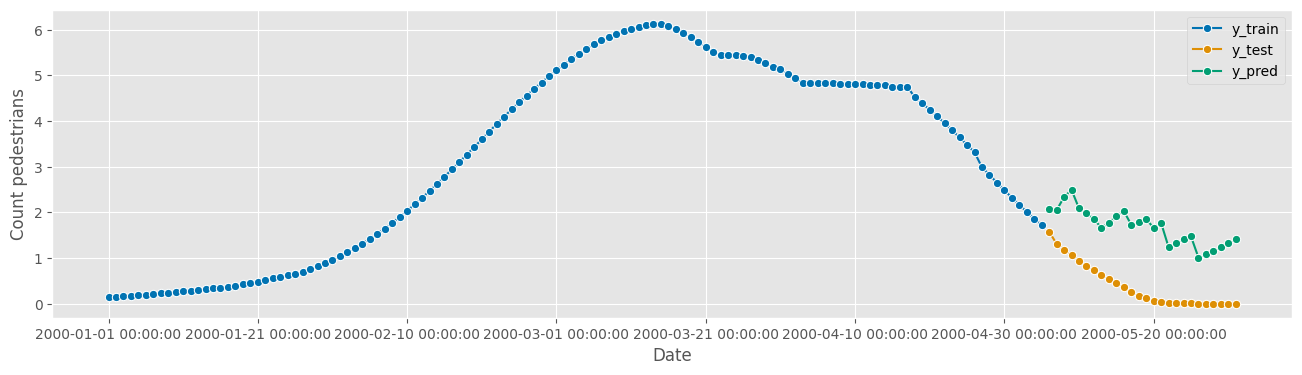

In [124]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor()
forecaster = make_reduction(regressor, window_length=12, strategy="recursive")
fh = ForecastingHorizon(y_test.index, is_relative=False)
# Fit and predict
forecaster.fit(y=y_train, X=X_train)
y_pred = forecaster.predict(fh=fh, X=X_test)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='Count pedestrians');

print('MAPE: %.4f' % mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

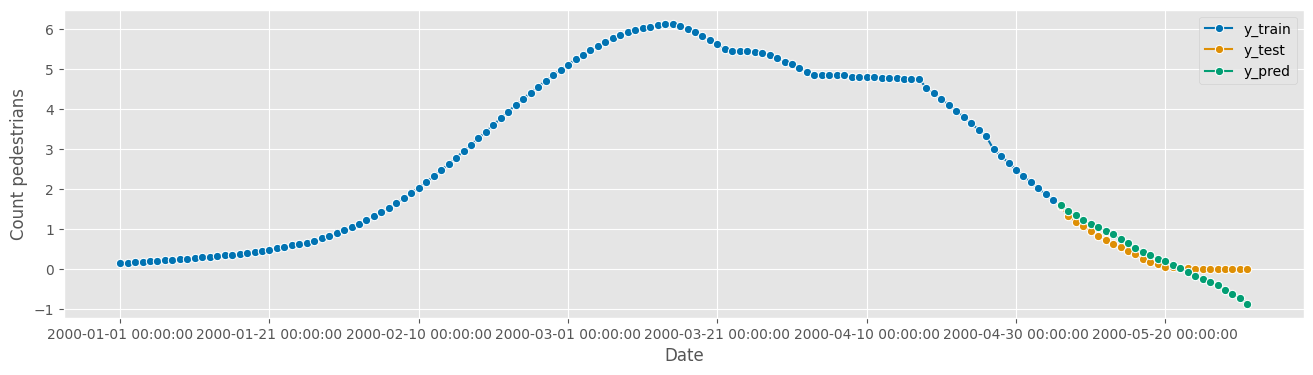

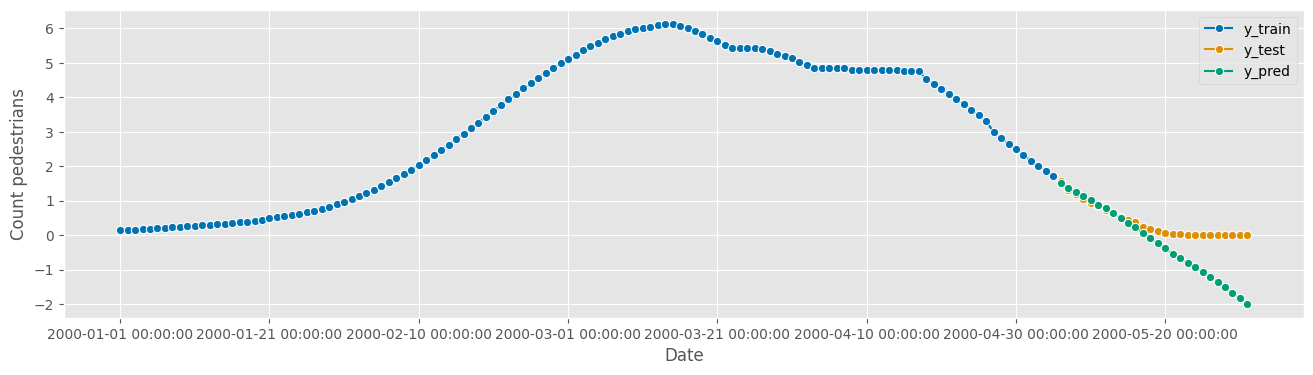

In [93]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from xgboost import XGBRegressor
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV, ForecastingGridSearchCV
from sktime.transformations.series.boxcox import LogTransformer

regressor = LinearRegression()

fh = ForecastingHorizon(y_test.index, is_relative=False)
validation_size = 26
cv = SingleWindowSplitter(window_length=len(y)-validation_size, fh=validation_size)

forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=26)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=2))),
        ("forecast", make_reduction(regressor, window_length=26, strategy="recursive")),
    ]
)

forecaster.fit(y=y_train, X=X_train)
y_pred = forecaster.predict(fh=fh, X=X_test)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='Count pedestrians');

param_grid = {
     'deseasonalize__model': ['multiplicative', 'additive'],
     'deseasonalize__sp': [8, 13, 26, 32],
     'detrend__forecaster__degree': [1, 2, 3, 4, 5],
     'forecast__window_length': [8, 13, 26, 32],
}

gscv = ForecastingRandomizedSearchCV(forecaster, cv=cv, param_distributions=param_grid, n_iter=100, random_state=42)
gscv.fit(y=y_train, X=X_train)
y_pred = gscv.predict(fh=fh, X=X_test)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='Count pedestrians');


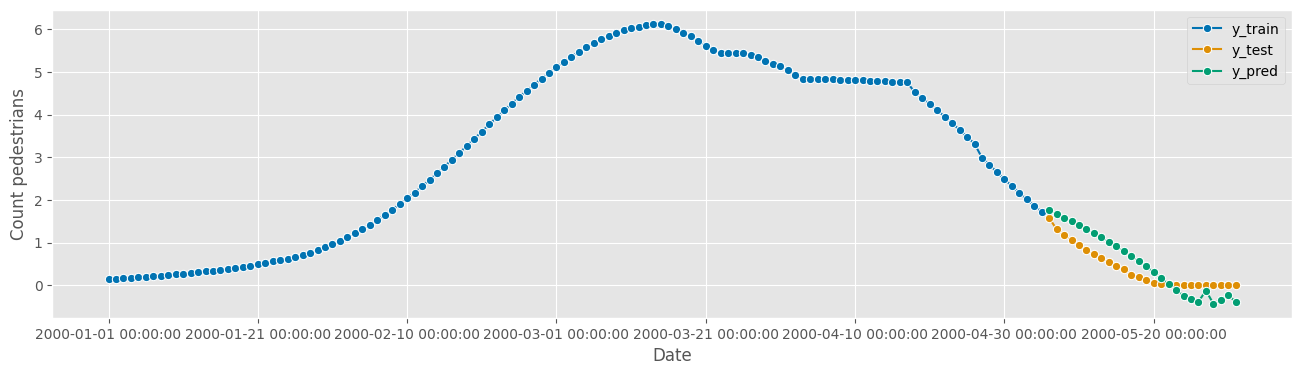

In [130]:
from sktime.forecasting.compose import AutoEnsembleForecaster, EnsembleForecaster
from sktime.forecasting.compose import StackingForecaster
from lightgbm import LGBMRegressor

fh = ForecastingHorizon(y_test.index, is_relative=False)

forecasters = []
for regressor in [
  LinearRegression(), Lasso(), Ridge(), XGBRegressor(), 
]:
    forecaster_name = regressor.__class__.__name__
    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalize", Deseasonalizer(model="multiplicative", sp=33)),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=2))),
            ("forecast", make_reduction(regressor, window_length=33, strategy="recursive")),
        ]
    )
    forecasters.append((forecaster_name, forecaster))
    
forecaster = AutoEnsembleForecaster(forecasters=forecasters)

forecaster.fit(y=y_train, X=X_train)
y_pred = forecaster.predict(fh=fh, X=X_test)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='Count pedestrians');


'LinearRegression'